In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm  # 
from pathlib import Path


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.backends.cudnn.benchmark = True


if torch.cuda.is_available():
    print(f"cuda:True")
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")
else:
    print(f"cuda:False")
    device = torch.device("cpu")


from models_LN import FNN_LN, dataset, one_hot, cross_entropy_loss, linear, linear_d, tanh, tanh_d, sign, sign_d, sigmoid, sigmoid_d, relu, relu_d, relu6, relu6_d, softmax, softmax_d

torch.set_grad_enabled(False)

cuda:True
GPU 0:NVIDIA GeForce GTX 1650:4.00GB


In [2]:

class Config:
    def __init__(self):
        self.n_input = 28 * 28  # 
        self.n_hidd = 16     # 
        self.n_out = 10      # 

        self.nL_hidd = 2

        self.sc_forward = 1
        self.sc_bias = 0
        self.sc_back = 1

        self.f = tanh #  relu tanh
        self.fd = tanh_d # relu_d tanh_d

        self.train_eta_global = 1e-3  #
        self.train_n_epochs = 100     # 
        self.train_batch_size = 500     # 
        self.train_task = "MNIST" #  "MNIST" "FMNIST" "CIFAR10"
        self.train_tmethod = ''     # 'FA','PC','LRA','BP'

        self.biasLearning = False
        
        self.EP_It2sta = 8
        self.EP_nudge = 1
        
config = Config()

In [3]:
train_loader, valid_loader, test_loader, config = dataset(config)
train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
valid_loader_gpu = [(data.to(device), target.to(device)) for data, target in valid_loader]
test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

In [4]:
##
ParaName = f'First_asymm_LN10_bsc_dynamics_LyapunovE_E'
Einfo = ''

res_path = Path(f"./Res/{ParaName}-{config.train_task}-0")
M_range = [0.001, 0.01, 0.1, 0.25, 1, 2, 4] # 0.001, 0.01, 0.1, 0.25, 1, 2, 4 fbsc  # 0.01, 0.1, 0.25, 0.5, 1, 2 SRsc
ParaRange = [2,3,5,10] # 2,3,5,8
multitest = 5 
config.save = True
config.ff = softmax
config.ffd = softmax_d
# -=--------------------------
config.train_tmethod = 'EP'
config.nL_hidd = 2
config.n_hidd = 64     # 

config.train_n_epochs = 50  # 

config.EP_symm_W = False
config.adam = True
config.EP_b_learn = False
config.EP_f_sc = 1
config.EP_nudge = 0.1
# config.EP_b_sc = 0.25

In [5]:
# -=--------------------------
res_path.mkdir(parents=True, exist_ok=True)
res = np.zeros((len(M_range),len(ParaRange),(multitest),6,config.train_n_epochs))

zall_list = [[[] for _ in range(len(ParaRange))] for _ in range(len(M_range))]
eall_list = [[[[] for _ in range((multitest))] for _ in range(len(ParaRange))] for _ in range(len(M_range))]

In [6]:
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(f'Current Time: {current_time}')
with open(res_path/"res.txt", "a") as f: 
    f.write(f"===================================================================")       
    f.write(f"Start Time: {current_time}")

Current Time: 20250720-171302


In [7]:
for iPara in range( len(ParaRange) ):
    for iM in range( len(M_range) ):
        for  imultitest in range((multitest)):
            config.EP_b_sc = M_range[iM]
            config.nL_hidd = ParaRange[iPara]

            #-----------------
            config.EP_It2sta = config.nL_hidd *10 
            config.EP_It2sta2 = config.nL_hidd *5
            # ---------------------------------
            model = FNN_LN(config).to(device)

            taskinfo = f'EP_L{config.nL_hidd}_{config.train_task}_{ParaName}-EP_b_sc{M_range[iM]}-EP_It2sta{config.EP_It2sta}-{Einfo}'
            print(taskinfo)

            ## Train

            for epoch in range(config.train_n_epochs):
                losssum = 0
                random.shuffle(train_loader_gpu)
                with tqdm(total=len(train_loader_gpu), desc=f'Epoch {epoch + 1}/{config.train_n_epochs}: ', unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                    for i, (images, labels) in enumerate(train_loader_gpu):
                        # 
                        images = images.view(-1, config.n_input)
                        labels_one_hot = one_hot(labels, config.n_out, device=device)
                        # 
                        outputs = model.forward(images)
                        # 
                        loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                        losssum += loss.item()
                        #
                        outputs = model.backward(images, labels_one_hot, outputs)
                        # 
                        model.update_weights_adam() if config.adam else model.update_weights() #model.update_weights_adam() model.update_weights()
                        # 
                        if i % 10 == 0: 
                            pbar.set_postfix({'loss': f'{losssum/(i+1):.6f}'})  
                            pbar.update(10)

                SR, ftmle, mle, zall = model.Lyapunov_EP(images[-1:,:], y=None, t_e=500, ret_zall=True)
                
                if imultitest==0: 
                    zall_list[iM][iPara].append(zall)
                    terr = model.ret_error()
                    eall_list[iM][iPara][imultitest].append(terr)

                # train set ------------------------------------------------------------
                train_correct = 0
                train_total = 0
                losssum = 0
                for images, labels in valid_loader_gpu:
                    images = images.view(-1, config.n_input)
                    labels_one_hot = one_hot(labels, config.n_out, device=device)
                    # 
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                    losssum += loss.item()
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()

                train_accuracy = train_correct / train_total

                # test set -------------------------------------------------------------
                test_correct = 0
                test_total = 0
                # ---------
                for images, labels in test_loader_gpu:
                    images = images.view(-1, config.n_input)
                    # 
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

                test_accuracy = test_correct / test_total

                res[iM][iPara][imultitest][0][epoch] = losssum
                res[iM][iPara][imultitest][1][epoch] = train_accuracy
                res[iM][iPara][imultitest][2][epoch] = test_accuracy
                res[iM][iPara][imultitest][3][epoch] = ftmle
                res[iM][iPara][imultitest][4][epoch] = mle
                res[iM][iPara][imultitest][5][epoch] = SR

                current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
                print(f'\t Loss: {res[iM][iPara][imultitest][0][epoch] :.3f},\t'
                    f'Train : {res[iM][iPara][imultitest][1][epoch] * 100:.2f}%({np.max(res[iM][iPara][imultitest][1]) * 100:.2f}%),\t'
                    f'Test : {res[iM][iPara][imultitest][2][epoch] * 100:.2f}%({np.max(res[iM][iPara][imultitest][2]) * 100:.2f}%),\t'
                    f'Current Time: {current_time}')
                
                # if 1-train_accuracy <1e-4:
                #     break
            
            # best result
            print(f"{taskinfo} Time: {current_time}, Epochs: {config.train_n_epochs}, Learning Rate: {config.train_eta_global}, "
                f"Best: {max(res[iM][iPara][imultitest][1]) * 100:.2f}%  {max(res[iM][iPara][imultitest][2]) * 100:.2f}%\n")
            
        for attempt in range(5):
            try:
                with open(res_path/"res.txt", "a") as f:
                    trainacct = np.max(res[iM][iPara][:,1,:], axis=-1)
                    testacct = np.max(res[iM][iPara][:,2,:], axis=-1)
                    f.write(f"{taskinfo} Time: {current_time}: "
                            f"train: {np.mean(trainacct) * 100:.2f}%+-{np.std(trainacct, ddof=1)*100:.2f}% ({np.min(trainacct) * 100:.2f}% {np.max(trainacct) * 100:.2f}%)"
                            f"\t test: {np.mean(testacct) * 100:.2f}%+-{np.std(testacct, ddof=1)*100:.2f}% ({np.min(testacct) * 100:.2f}% {np.max(testacct) * 100:.2f}%)\n")

                    for attr_name in dir(config):
                        if not attr_name.startswith('__') and not callable(getattr(config, attr_name)):  
                            attr_value = getattr(config, attr_name)
                            f.write(f'{attr_name}: {attr_value}  ')  
                    f.write(f'\n\n')  

                break  # 
            except PermissionError:
                if attempt < 5 - 1:
                    print(f"Permission denied, retrying in {5} seconds...")
                    time.sleep(5)
                else:
                    raise  # 
                        
                

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20-


Epoch 1/50:   0%|                                              | 0/120 [00:00<?, ?batch/s]d:\HWC\华为云盘\Codepy\aEP\models_LN.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(self.z, device=self.device)
Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.73batch/s, loss=1.769586]


	 Loss: 26.130,	Train : 82.20%(82.20%),	Test : 82.97%(82.97%),	Current Time: 20250720-171303


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 203.30batch/s, loss=0.587656]


	 Loss: 12.690,	Train : 89.02%(89.02%),	Test : 89.50%(89.50%),	Current Time: 20250720-171304


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 181.98batch/s, loss=0.373444]


	 Loss: 9.857,	Train : 90.83%(90.83%),	Test : 90.93%(90.93%),	Current Time: 20250720-171305


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 189.37batch/s, loss=0.306562]


	 Loss: 8.464,	Train : 92.02%(92.02%),	Test : 91.89%(91.89%),	Current Time: 20250720-171306


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 187.34batch/s, loss=0.270023]


	 Loss: 7.502,	Train : 92.81%(92.81%),	Test : 92.54%(92.54%),	Current Time: 20250720-171307


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 187.08batch/s, loss=0.238595]


	 Loss: 6.752,	Train : 93.46%(93.46%),	Test : 93.19%(93.19%),	Current Time: 20250720-171308


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 178.34batch/s, loss=0.217685]


	 Loss: 6.158,	Train : 94.08%(94.08%),	Test : 93.71%(93.71%),	Current Time: 20250720-171309


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 181.87batch/s, loss=0.198679]


	 Loss: 5.652,	Train : 94.55%(94.55%),	Test : 94.17%(94.17%),	Current Time: 20250720-171310


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 176.15batch/s, loss=0.183241]


	 Loss: 5.227,	Train : 94.95%(94.95%),	Test : 94.59%(94.59%),	Current Time: 20250720-171311


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 188.48batch/s, loss=0.170518]


	 Loss: 4.851,	Train : 95.30%(95.30%),	Test : 94.76%(94.76%),	Current Time: 20250720-171312


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 185.95batch/s, loss=0.160660]


	 Loss: 4.531,	Train : 95.66%(95.66%),	Test : 94.94%(94.94%),	Current Time: 20250720-171313


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 185.31batch/s, loss=0.150109]


	 Loss: 4.262,	Train : 95.91%(95.91%),	Test : 95.15%(95.15%),	Current Time: 20250720-171314


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 181.46batch/s, loss=0.139427]


	 Loss: 4.015,	Train : 96.18%(96.18%),	Test : 95.27%(95.27%),	Current Time: 20250720-171315


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.58batch/s, loss=0.131967]


	 Loss: 3.748,	Train : 96.45%(96.45%),	Test : 95.51%(95.51%),	Current Time: 20250720-171316


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.54batch/s, loss=0.124478]


	 Loss: 3.566,	Train : 96.58%(96.58%),	Test : 95.70%(95.70%),	Current Time: 20250720-171316


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 186.92batch/s, loss=0.118000]


	 Loss: 3.345,	Train : 96.82%(96.82%),	Test : 95.81%(95.81%),	Current Time: 20250720-171317


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.69batch/s, loss=0.113327]


	 Loss: 3.173,	Train : 96.98%(96.98%),	Test : 96.09%(96.09%),	Current Time: 20250720-171318


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.78batch/s, loss=0.106054]


	 Loss: 3.001,	Train : 97.18%(97.18%),	Test : 96.11%(96.11%),	Current Time: 20250720-171319


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.65batch/s, loss=0.101531]


	 Loss: 2.855,	Train : 97.33%(97.33%),	Test : 96.20%(96.20%),	Current Time: 20250720-171320


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.55batch/s, loss=0.096533]


	 Loss: 2.722,	Train : 97.46%(97.46%),	Test : 96.25%(96.25%),	Current Time: 20250720-171321


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.19batch/s, loss=0.091858]


	 Loss: 2.592,	Train : 97.60%(97.60%),	Test : 96.25%(96.25%),	Current Time: 20250720-171322


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.89batch/s, loss=0.087224]


	 Loss: 2.464,	Train : 97.72%(97.72%),	Test : 96.38%(96.38%),	Current Time: 20250720-171323


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.78batch/s, loss=0.084195]


	 Loss: 2.353,	Train : 97.80%(97.80%),	Test : 96.54%(96.54%),	Current Time: 20250720-171324


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.34batch/s, loss=0.078876]


	 Loss: 2.226,	Train : 97.97%(97.97%),	Test : 96.47%(96.54%),	Current Time: 20250720-171324


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.17batch/s, loss=0.077014]


	 Loss: 2.130,	Train : 98.03%(98.03%),	Test : 96.59%(96.59%),	Current Time: 20250720-171325


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.08batch/s, loss=0.071645]


	 Loss: 2.051,	Train : 98.15%(98.15%),	Test : 96.68%(96.68%),	Current Time: 20250720-171326


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.60batch/s, loss=0.069907]


	 Loss: 1.951,	Train : 98.28%(98.28%),	Test : 96.74%(96.74%),	Current Time: 20250720-171327


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.20batch/s, loss=0.066090]


	 Loss: 1.847,	Train : 98.36%(98.36%),	Test : 96.78%(96.78%),	Current Time: 20250720-171328


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.16batch/s, loss=0.063745]


	 Loss: 1.756,	Train : 98.50%(98.50%),	Test : 96.71%(96.78%),	Current Time: 20250720-171329


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.20batch/s, loss=0.061106]


	 Loss: 1.684,	Train : 98.51%(98.51%),	Test : 96.75%(96.78%),	Current Time: 20250720-171330


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.77batch/s, loss=0.058949]


	 Loss: 1.620,	Train : 98.64%(98.64%),	Test : 96.78%(96.78%),	Current Time: 20250720-171330


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.38batch/s, loss=0.055821]


	 Loss: 1.541,	Train : 98.69%(98.69%),	Test : 96.77%(96.78%),	Current Time: 20250720-171331


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.66batch/s, loss=0.053401]


	 Loss: 1.477,	Train : 98.76%(98.76%),	Test : 96.75%(96.78%),	Current Time: 20250720-171332


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.15batch/s, loss=0.051263]


	 Loss: 1.458,	Train : 98.77%(98.77%),	Test : 96.79%(96.79%),	Current Time: 20250720-171333


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.05batch/s, loss=0.049165]


	 Loss: 1.340,	Train : 98.93%(98.93%),	Test : 96.77%(96.79%),	Current Time: 20250720-171334


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.77batch/s, loss=0.046930]


	 Loss: 1.298,	Train : 98.96%(98.96%),	Test : 96.77%(96.79%),	Current Time: 20250720-171335


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.85batch/s, loss=0.043369]


	 Loss: 1.229,	Train : 99.00%(99.00%),	Test : 96.78%(96.79%),	Current Time: 20250720-171335


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.97batch/s, loss=0.042922]


	 Loss: 1.159,	Train : 99.10%(99.10%),	Test : 96.85%(96.85%),	Current Time: 20250720-171336


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.93batch/s, loss=0.040357]


	 Loss: 1.124,	Train : 99.12%(99.12%),	Test : 96.70%(96.85%),	Current Time: 20250720-171337


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.19batch/s, loss=0.039591]


	 Loss: 1.062,	Train : 99.18%(99.18%),	Test : 96.77%(96.85%),	Current Time: 20250720-171338


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.75batch/s, loss=0.037260]


	 Loss: 1.063,	Train : 99.12%(99.18%),	Test : 96.75%(96.85%),	Current Time: 20250720-171339


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.93batch/s, loss=0.036177]


	 Loss: 0.973,	Train : 99.25%(99.25%),	Test : 96.83%(96.85%),	Current Time: 20250720-171340


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.06batch/s, loss=0.034066]


	 Loss: 0.936,	Train : 99.26%(99.26%),	Test : 96.77%(96.85%),	Current Time: 20250720-171341


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.87batch/s, loss=0.032485]


	 Loss: 0.868,	Train : 99.37%(99.37%),	Test : 96.75%(96.85%),	Current Time: 20250720-171342


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.21batch/s, loss=0.030817]


	 Loss: 0.881,	Train : 99.33%(99.37%),	Test : 96.81%(96.85%),	Current Time: 20250720-171342


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.10batch/s, loss=0.029732]


	 Loss: 0.791,	Train : 99.48%(99.48%),	Test : 96.70%(96.85%),	Current Time: 20250720-171343


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.06batch/s, loss=0.027680]


	 Loss: 0.750,	Train : 99.49%(99.49%),	Test : 96.70%(96.85%),	Current Time: 20250720-171344


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.05batch/s, loss=0.027501]


	 Loss: 0.742,	Train : 99.48%(99.49%),	Test : 96.62%(96.85%),	Current Time: 20250720-171345


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.37batch/s, loss=0.025853]


	 Loss: 0.693,	Train : 99.54%(99.54%),	Test : 96.80%(96.85%),	Current Time: 20250720-171346


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.97batch/s, loss=0.024698]


	 Loss: 0.644,	Train : 99.59%(99.59%),	Test : 96.70%(96.85%),	Current Time: 20250720-171347
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20- Time: 20250720-171347, Epochs: 50, Learning Rate: 0.001, Best: 99.59%  96.85%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 197.44batch/s, loss=1.661448]


	 Loss: 23.908,	Train : 82.02%(82.02%),	Test : 83.04%(83.04%),	Current Time: 20250720-171348


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 185.61batch/s, loss=0.552867]


	 Loss: 12.418,	Train : 88.88%(88.88%),	Test : 89.40%(89.40%),	Current Time: 20250720-171349


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 211.46batch/s, loss=0.364337]


	 Loss: 9.626,	Train : 91.04%(91.04%),	Test : 91.41%(91.41%),	Current Time: 20250720-171349


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.22batch/s, loss=0.297007]


	 Loss: 8.155,	Train : 92.27%(92.27%),	Test : 92.50%(92.50%),	Current Time: 20250720-171350


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 197.01batch/s, loss=0.258503]


	 Loss: 7.167,	Train : 93.16%(93.16%),	Test : 93.09%(93.09%),	Current Time: 20250720-171351


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 190.10batch/s, loss=0.229806]


	 Loss: 6.403,	Train : 93.89%(93.89%),	Test : 93.73%(93.73%),	Current Time: 20250720-171352


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.58batch/s, loss=0.204572]


	 Loss: 5.772,	Train : 94.50%(94.50%),	Test : 94.26%(94.26%),	Current Time: 20250720-171353


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 200.91batch/s, loss=0.187097]


	 Loss: 5.257,	Train : 94.97%(94.97%),	Test : 94.68%(94.68%),	Current Time: 20250720-171354


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 183.20batch/s, loss=0.171456]


	 Loss: 4.867,	Train : 95.37%(95.37%),	Test : 94.96%(94.96%),	Current Time: 20250720-171355


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.07batch/s, loss=0.159059]


	 Loss: 4.471,	Train : 95.83%(95.83%),	Test : 95.34%(95.34%),	Current Time: 20250720-171356


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.71batch/s, loss=0.146933]


	 Loss: 4.174,	Train : 96.06%(96.06%),	Test : 95.47%(95.47%),	Current Time: 20250720-171356


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.11batch/s, loss=0.137197]


	 Loss: 3.898,	Train : 96.36%(96.36%),	Test : 95.67%(95.67%),	Current Time: 20250720-171357


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.84batch/s, loss=0.129736]


	 Loss: 3.662,	Train : 96.57%(96.57%),	Test : 95.93%(95.93%),	Current Time: 20250720-171358


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.50batch/s, loss=0.120739]


	 Loss: 3.445,	Train : 96.79%(96.79%),	Test : 96.00%(96.00%),	Current Time: 20250720-171359


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.07batch/s, loss=0.114654]


	 Loss: 3.248,	Train : 96.95%(96.95%),	Test : 96.09%(96.09%),	Current Time: 20250720-171400


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.43batch/s, loss=0.108512]


	 Loss: 3.042,	Train : 97.12%(97.12%),	Test : 96.28%(96.28%),	Current Time: 20250720-171401


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.22batch/s, loss=0.103637]


	 Loss: 2.888,	Train : 97.34%(97.34%),	Test : 96.37%(96.37%),	Current Time: 20250720-171402


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 174.08batch/s, loss=0.096394]


	 Loss: 2.768,	Train : 97.39%(97.39%),	Test : 96.45%(96.45%),	Current Time: 20250720-171403


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.20batch/s, loss=0.092271]


	 Loss: 2.599,	Train : 97.59%(97.59%),	Test : 96.51%(96.51%),	Current Time: 20250720-171404


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.40batch/s, loss=0.087837]


	 Loss: 2.470,	Train : 97.71%(97.71%),	Test : 96.60%(96.60%),	Current Time: 20250720-171405


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.89batch/s, loss=0.084517]


	 Loss: 2.383,	Train : 97.79%(97.79%),	Test : 96.66%(96.66%),	Current Time: 20250720-171405


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.66batch/s, loss=0.079367]


	 Loss: 2.197,	Train : 97.97%(97.97%),	Test : 96.79%(96.79%),	Current Time: 20250720-171406


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.01batch/s, loss=0.076624]


	 Loss: 2.137,	Train : 97.99%(97.99%),	Test : 96.63%(96.79%),	Current Time: 20250720-171407


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.63batch/s, loss=0.072450]


	 Loss: 1.997,	Train : 98.16%(98.16%),	Test : 96.84%(96.84%),	Current Time: 20250720-171408


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.85batch/s, loss=0.068342]


	 Loss: 1.899,	Train : 98.26%(98.26%),	Test : 96.84%(96.84%),	Current Time: 20250720-171409


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.17batch/s, loss=0.065270]


	 Loss: 1.853,	Train : 98.26%(98.26%),	Test : 96.80%(96.84%),	Current Time: 20250720-171410


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.31batch/s, loss=0.063069]


	 Loss: 1.735,	Train : 98.45%(98.45%),	Test : 96.93%(96.93%),	Current Time: 20250720-171411


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.72batch/s, loss=0.059257]


	 Loss: 1.661,	Train : 98.48%(98.48%),	Test : 96.88%(96.93%),	Current Time: 20250720-171412


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.93batch/s, loss=0.057106]


	 Loss: 1.566,	Train : 98.62%(98.62%),	Test : 96.86%(96.93%),	Current Time: 20250720-171412


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.68batch/s, loss=0.054121]


	 Loss: 1.485,	Train : 98.70%(98.70%),	Test : 96.91%(96.93%),	Current Time: 20250720-171413


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.83batch/s, loss=0.052221]


	 Loss: 1.430,	Train : 98.72%(98.72%),	Test : 96.96%(96.96%),	Current Time: 20250720-171414


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.63batch/s, loss=0.049826]


	 Loss: 1.382,	Train : 98.79%(98.79%),	Test : 96.90%(96.96%),	Current Time: 20250720-171415


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 177.61batch/s, loss=0.047338]


	 Loss: 1.309,	Train : 98.86%(98.86%),	Test : 96.92%(96.96%),	Current Time: 20250720-171416


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 186.41batch/s, loss=0.046034]


	 Loss: 1.265,	Train : 98.90%(98.90%),	Test : 96.86%(96.96%),	Current Time: 20250720-171417


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 176.59batch/s, loss=0.043304]


	 Loss: 1.207,	Train : 98.98%(98.98%),	Test : 96.88%(96.96%),	Current Time: 20250720-171418


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 178.50batch/s, loss=0.042154]


	 Loss: 1.100,	Train : 99.10%(99.10%),	Test : 96.95%(96.96%),	Current Time: 20250720-171419


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.32batch/s, loss=0.039461]


	 Loss: 1.100,	Train : 99.09%(99.10%),	Test : 96.92%(96.96%),	Current Time: 20250720-171420


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.45batch/s, loss=0.038243]


	 Loss: 1.022,	Train : 99.19%(99.19%),	Test : 96.92%(96.96%),	Current Time: 20250720-171421


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 186.92batch/s, loss=0.035820]


	 Loss: 0.946,	Train : 99.26%(99.26%),	Test : 97.01%(97.01%),	Current Time: 20250720-171422


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 188.02batch/s, loss=0.033832]


	 Loss: 0.934,	Train : 99.25%(99.26%),	Test : 96.89%(97.01%),	Current Time: 20250720-171423


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.90batch/s, loss=0.032970]


	 Loss: 0.870,	Train : 99.33%(99.33%),	Test : 96.92%(97.01%),	Current Time: 20250720-171424


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.33batch/s, loss=0.030731]


	 Loss: 0.826,	Train : 99.41%(99.41%),	Test : 96.87%(97.01%),	Current Time: 20250720-171425


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.23batch/s, loss=0.029465]


	 Loss: 0.801,	Train : 99.43%(99.43%),	Test : 96.92%(97.01%),	Current Time: 20250720-171425


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.19batch/s, loss=0.028104]


	 Loss: 0.759,	Train : 99.45%(99.45%),	Test : 96.94%(97.01%),	Current Time: 20250720-171426


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.13batch/s, loss=0.026418]


	 Loss: 0.732,	Train : 99.47%(99.47%),	Test : 96.93%(97.01%),	Current Time: 20250720-171427


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.75batch/s, loss=0.025470]


	 Loss: 0.681,	Train : 99.53%(99.53%),	Test : 97.09%(97.09%),	Current Time: 20250720-171428


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.49batch/s, loss=0.024084]


	 Loss: 0.681,	Train : 99.49%(99.53%),	Test : 97.02%(97.09%),	Current Time: 20250720-171429


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.10batch/s, loss=0.023147]


	 Loss: 0.616,	Train : 99.59%(99.59%),	Test : 96.96%(97.09%),	Current Time: 20250720-171430


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.32batch/s, loss=0.022047]


	 Loss: 0.632,	Train : 99.54%(99.59%),	Test : 96.88%(97.09%),	Current Time: 20250720-171431


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.41batch/s, loss=0.021690]


	 Loss: 0.585,	Train : 99.61%(99.61%),	Test : 96.83%(97.09%),	Current Time: 20250720-171431
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20- Time: 20250720-171431, Epochs: 50, Learning Rate: 0.001, Best: 99.61%  97.09%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.08batch/s, loss=1.654416]


	 Loss: 23.470,	Train : 83.28%(83.28%),	Test : 84.41%(84.41%),	Current Time: 20250720-171432


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.86batch/s, loss=0.544892]


	 Loss: 12.095,	Train : 89.39%(89.39%),	Test : 89.79%(89.79%),	Current Time: 20250720-171433


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.99batch/s, loss=0.357456]


	 Loss: 9.408,	Train : 91.15%(91.15%),	Test : 91.39%(91.39%),	Current Time: 20250720-171434


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.37batch/s, loss=0.293690]


	 Loss: 8.047,	Train : 92.35%(92.35%),	Test : 92.26%(92.26%),	Current Time: 20250720-171435


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.27batch/s, loss=0.255454]


	 Loss: 7.103,	Train : 93.20%(93.20%),	Test : 93.19%(93.19%),	Current Time: 20250720-171436


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 194.92batch/s, loss=0.227403]


	 Loss: 6.402,	Train : 93.84%(93.84%),	Test : 93.61%(93.61%),	Current Time: 20250720-171437


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 180.53batch/s, loss=0.206472]


	 Loss: 5.842,	Train : 94.36%(94.36%),	Test : 93.99%(93.99%),	Current Time: 20250720-171438


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 191.88batch/s, loss=0.189661]


	 Loss: 5.385,	Train : 94.84%(94.84%),	Test : 94.36%(94.36%),	Current Time: 20250720-171438


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 180.92batch/s, loss=0.176302]


	 Loss: 4.973,	Train : 95.14%(95.14%),	Test : 94.86%(94.86%),	Current Time: 20250720-171439


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.62batch/s, loss=0.163124]


	 Loss: 4.620,	Train : 95.51%(95.51%),	Test : 95.08%(95.08%),	Current Time: 20250720-171440


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.13batch/s, loss=0.153936]


	 Loss: 4.312,	Train : 95.82%(95.82%),	Test : 95.37%(95.37%),	Current Time: 20250720-171441


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.73batch/s, loss=0.143358]


	 Loss: 4.046,	Train : 96.10%(96.10%),	Test : 95.37%(95.37%),	Current Time: 20250720-171442


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.01batch/s, loss=0.131868]


	 Loss: 3.781,	Train : 96.37%(96.37%),	Test : 95.59%(95.59%),	Current Time: 20250720-171443


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.51batch/s, loss=0.125257]


	 Loss: 3.568,	Train : 96.57%(96.57%),	Test : 95.76%(95.76%),	Current Time: 20250720-171444


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.59batch/s, loss=0.119171]


	 Loss: 3.385,	Train : 96.77%(96.77%),	Test : 95.82%(95.82%),	Current Time: 20250720-171445


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.94batch/s, loss=0.113261]


	 Loss: 3.198,	Train : 96.94%(96.94%),	Test : 95.98%(95.98%),	Current Time: 20250720-171446


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 172.82batch/s, loss=0.106785]


	 Loss: 3.028,	Train : 97.13%(97.13%),	Test : 96.03%(96.03%),	Current Time: 20250720-171447


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.97batch/s, loss=0.101748]


	 Loss: 2.862,	Train : 97.31%(97.31%),	Test : 96.15%(96.15%),	Current Time: 20250720-171448


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.84batch/s, loss=0.096392]


	 Loss: 2.739,	Train : 97.35%(97.35%),	Test : 96.17%(96.17%),	Current Time: 20250720-171448


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.12batch/s, loss=0.092287]


	 Loss: 2.576,	Train : 97.58%(97.58%),	Test : 96.34%(96.34%),	Current Time: 20250720-171449


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.86batch/s, loss=0.087312]


	 Loss: 2.459,	Train : 97.67%(97.67%),	Test : 96.30%(96.34%),	Current Time: 20250720-171450


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.86batch/s, loss=0.082066]


	 Loss: 2.308,	Train : 97.81%(97.81%),	Test : 96.38%(96.38%),	Current Time: 20250720-171451


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.40batch/s, loss=0.079427]


	 Loss: 2.198,	Train : 97.91%(97.91%),	Test : 96.54%(96.54%),	Current Time: 20250720-171452


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.10batch/s, loss=0.075626]


	 Loss: 2.108,	Train : 98.02%(98.02%),	Test : 96.55%(96.55%),	Current Time: 20250720-171453


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.53batch/s, loss=0.071322]


	 Loss: 2.002,	Train : 98.12%(98.12%),	Test : 96.58%(96.58%),	Current Time: 20250720-171454


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.18batch/s, loss=0.067988]


	 Loss: 1.903,	Train : 98.25%(98.25%),	Test : 96.58%(96.58%),	Current Time: 20250720-171454


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.02batch/s, loss=0.064059]


	 Loss: 1.799,	Train : 98.32%(98.32%),	Test : 96.68%(96.68%),	Current Time: 20250720-171455


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.39batch/s, loss=0.061225]


	 Loss: 1.716,	Train : 98.41%(98.41%),	Test : 96.56%(96.68%),	Current Time: 20250720-171456


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.39batch/s, loss=0.059279]


	 Loss: 1.637,	Train : 98.48%(98.48%),	Test : 96.59%(96.68%),	Current Time: 20250720-171457


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.57batch/s, loss=0.056391]


	 Loss: 1.582,	Train : 98.54%(98.54%),	Test : 96.75%(96.75%),	Current Time: 20250720-171458


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.50batch/s, loss=0.053409]


	 Loss: 1.480,	Train : 98.67%(98.67%),	Test : 96.70%(96.75%),	Current Time: 20250720-171459


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.62batch/s, loss=0.051125]


	 Loss: 1.394,	Train : 98.78%(98.78%),	Test : 96.69%(96.75%),	Current Time: 20250720-171459


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.10batch/s, loss=0.049318]


	 Loss: 1.366,	Train : 98.76%(98.78%),	Test : 96.72%(96.75%),	Current Time: 20250720-171500


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.20batch/s, loss=0.047083]


	 Loss: 1.290,	Train : 98.87%(98.87%),	Test : 96.79%(96.79%),	Current Time: 20250720-171501


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.51batch/s, loss=0.045065]


	 Loss: 1.198,	Train : 98.98%(98.98%),	Test : 96.86%(96.86%),	Current Time: 20250720-171502


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.25batch/s, loss=0.043230]


	 Loss: 1.177,	Train : 98.98%(98.98%),	Test : 96.70%(96.86%),	Current Time: 20250720-171503


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.52batch/s, loss=0.040922]


	 Loss: 1.131,	Train : 99.05%(99.05%),	Test : 96.88%(96.88%),	Current Time: 20250720-171504


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.16batch/s, loss=0.038356]


	 Loss: 1.062,	Train : 99.14%(99.14%),	Test : 96.81%(96.88%),	Current Time: 20250720-171505


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.37batch/s, loss=0.037207]


	 Loss: 1.012,	Train : 99.17%(99.17%),	Test : 96.89%(96.89%),	Current Time: 20250720-171505


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.66batch/s, loss=0.036452]


	 Loss: 0.970,	Train : 99.22%(99.22%),	Test : 96.92%(96.92%),	Current Time: 20250720-171506


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.25batch/s, loss=0.033536]


	 Loss: 0.927,	Train : 99.28%(99.28%),	Test : 96.81%(96.92%),	Current Time: 20250720-171507


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.47batch/s, loss=0.032448]


	 Loss: 0.863,	Train : 99.33%(99.33%),	Test : 96.90%(96.92%),	Current Time: 20250720-171508


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.44batch/s, loss=0.031271]


	 Loss: 0.829,	Train : 99.36%(99.36%),	Test : 96.81%(96.92%),	Current Time: 20250720-171509


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.67batch/s, loss=0.029587]


	 Loss: 0.788,	Train : 99.43%(99.43%),	Test : 96.88%(96.92%),	Current Time: 20250720-171510


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.55batch/s, loss=0.027421]


	 Loss: 0.771,	Train : 99.44%(99.44%),	Test : 96.82%(96.92%),	Current Time: 20250720-171511


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.08batch/s, loss=0.026874]


	 Loss: 0.696,	Train : 99.54%(99.54%),	Test : 96.96%(96.96%),	Current Time: 20250720-171511


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.30batch/s, loss=0.025361]


	 Loss: 0.672,	Train : 99.56%(99.56%),	Test : 96.81%(96.96%),	Current Time: 20250720-171512


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.81batch/s, loss=0.024235]


	 Loss: 0.678,	Train : 99.52%(99.56%),	Test : 96.77%(96.96%),	Current Time: 20250720-171513


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.59batch/s, loss=0.023196]


	 Loss: 0.608,	Train : 99.63%(99.63%),	Test : 96.94%(96.96%),	Current Time: 20250720-171514


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.78batch/s, loss=0.021855]


	 Loss: 0.579,	Train : 99.66%(99.66%),	Test : 96.82%(96.96%),	Current Time: 20250720-171515
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20- Time: 20250720-171515, Epochs: 50, Learning Rate: 0.001, Best: 99.66%  96.96%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.70batch/s, loss=1.765666]


	 Loss: 27.279,	Train : 77.78%(77.78%),	Test : 78.48%(78.48%),	Current Time: 20250720-171516


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.79batch/s, loss=0.620859]


	 Loss: 13.168,	Train : 88.53%(88.53%),	Test : 89.28%(89.28%),	Current Time: 20250720-171516


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.15batch/s, loss=0.381838]


	 Loss: 9.993,	Train : 90.61%(90.61%),	Test : 91.02%(91.02%),	Current Time: 20250720-171517


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.28batch/s, loss=0.311100]


	 Loss: 8.559,	Train : 91.86%(91.86%),	Test : 91.88%(91.88%),	Current Time: 20250720-171518


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.09batch/s, loss=0.271513]


	 Loss: 7.597,	Train : 92.73%(92.73%),	Test : 92.52%(92.52%),	Current Time: 20250720-171519


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 205.62batch/s, loss=0.243303]


	 Loss: 6.838,	Train : 93.43%(93.43%),	Test : 93.06%(93.06%),	Current Time: 20250720-171520


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 206.77batch/s, loss=0.219300]


	 Loss: 6.220,	Train : 94.00%(94.00%),	Test : 93.67%(93.67%),	Current Time: 20250720-171521


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 199.85batch/s, loss=0.203464]


	 Loss: 5.708,	Train : 94.45%(94.45%),	Test : 94.07%(94.07%),	Current Time: 20250720-171522


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.05batch/s, loss=0.187219]


	 Loss: 5.313,	Train : 94.86%(94.86%),	Test : 94.50%(94.50%),	Current Time: 20250720-171523


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.90batch/s, loss=0.171887]


	 Loss: 4.899,	Train : 95.26%(95.26%),	Test : 94.88%(94.88%),	Current Time: 20250720-171523


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.01batch/s, loss=0.162166]


	 Loss: 4.545,	Train : 95.64%(95.64%),	Test : 95.26%(95.26%),	Current Time: 20250720-171524


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.23batch/s, loss=0.148858]


	 Loss: 4.265,	Train : 95.88%(95.88%),	Test : 95.45%(95.45%),	Current Time: 20250720-171525


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.91batch/s, loss=0.141022]


	 Loss: 3.987,	Train : 96.19%(96.19%),	Test : 95.52%(95.52%),	Current Time: 20250720-171526


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.12batch/s, loss=0.131006]


	 Loss: 3.774,	Train : 96.41%(96.41%),	Test : 95.69%(95.69%),	Current Time: 20250720-171527


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.46batch/s, loss=0.124875]


	 Loss: 3.576,	Train : 96.61%(96.61%),	Test : 95.84%(95.84%),	Current Time: 20250720-171528


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.12batch/s, loss=0.118137]


	 Loss: 3.355,	Train : 96.78%(96.78%),	Test : 96.02%(96.02%),	Current Time: 20250720-171529


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.90batch/s, loss=0.112312]


	 Loss: 3.159,	Train : 96.99%(96.99%),	Test : 96.05%(96.05%),	Current Time: 20250720-171530


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.19batch/s, loss=0.105115]


	 Loss: 2.985,	Train : 97.20%(97.20%),	Test : 96.23%(96.23%),	Current Time: 20250720-171530


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.14batch/s, loss=0.100284]


	 Loss: 2.845,	Train : 97.30%(97.30%),	Test : 96.28%(96.28%),	Current Time: 20250720-171531


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.04batch/s, loss=0.094644]


	 Loss: 2.684,	Train : 97.45%(97.45%),	Test : 96.36%(96.36%),	Current Time: 20250720-171532


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 185.06batch/s, loss=0.090983]


	 Loss: 2.601,	Train : 97.52%(97.52%),	Test : 96.42%(96.42%),	Current Time: 20250720-171533


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.39batch/s, loss=0.087046]


	 Loss: 2.420,	Train : 97.69%(97.69%),	Test : 96.47%(96.47%),	Current Time: 20250720-171534


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.24batch/s, loss=0.082458]


	 Loss: 2.293,	Train : 97.85%(97.85%),	Test : 96.69%(96.69%),	Current Time: 20250720-171535


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.92batch/s, loss=0.078448]


	 Loss: 2.191,	Train : 97.92%(97.92%),	Test : 96.67%(96.69%),	Current Time: 20250720-171536


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.82batch/s, loss=0.075210]


	 Loss: 2.095,	Train : 98.03%(98.03%),	Test : 96.72%(96.72%),	Current Time: 20250720-171537


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 183.30batch/s, loss=0.070981]


	 Loss: 2.028,	Train : 98.09%(98.09%),	Test : 96.71%(96.72%),	Current Time: 20250720-171538


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.53batch/s, loss=0.068575]


	 Loss: 1.927,	Train : 98.22%(98.22%),	Test : 96.70%(96.72%),	Current Time: 20250720-171539


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 186.51batch/s, loss=0.065123]


	 Loss: 1.799,	Train : 98.35%(98.35%),	Test : 96.72%(96.72%),	Current Time: 20250720-171539


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 181.45batch/s, loss=0.062364]


	 Loss: 1.736,	Train : 98.38%(98.38%),	Test : 96.88%(96.88%),	Current Time: 20250720-171540


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 168.42batch/s, loss=0.059692]


	 Loss: 1.631,	Train : 98.55%(98.55%),	Test : 96.85%(96.88%),	Current Time: 20250720-171541


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 175.56batch/s, loss=0.057049]


	 Loss: 1.581,	Train : 98.57%(98.57%),	Test : 96.86%(96.88%),	Current Time: 20250720-171542


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 167.75batch/s, loss=0.054753]


	 Loss: 1.499,	Train : 98.68%(98.68%),	Test : 96.90%(96.90%),	Current Time: 20250720-171543


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.86batch/s, loss=0.051645]


	 Loss: 1.412,	Train : 98.78%(98.78%),	Test : 96.85%(96.90%),	Current Time: 20250720-171544


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 183.11batch/s, loss=0.049843]


	 Loss: 1.387,	Train : 98.77%(98.78%),	Test : 96.90%(96.90%),	Current Time: 20250720-171545


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.58batch/s, loss=0.048215]


	 Loss: 1.330,	Train : 98.83%(98.83%),	Test : 96.90%(96.90%),	Current Time: 20250720-171546


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 175.68batch/s, loss=0.045116]


	 Loss: 1.253,	Train : 98.93%(98.93%),	Test : 96.94%(96.94%),	Current Time: 20250720-171547


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 169.74batch/s, loss=0.043914]


	 Loss: 1.260,	Train : 98.92%(98.93%),	Test : 96.90%(96.94%),	Current Time: 20250720-171548


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 177.32batch/s, loss=0.041905]


	 Loss: 1.172,	Train : 98.99%(98.99%),	Test : 96.96%(96.96%),	Current Time: 20250720-171549


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 186.35batch/s, loss=0.039905]


	 Loss: 1.131,	Train : 99.03%(99.03%),	Test : 96.94%(96.96%),	Current Time: 20250720-171550


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.42batch/s, loss=0.037921]


	 Loss: 1.048,	Train : 99.16%(99.16%),	Test : 96.90%(96.96%),	Current Time: 20250720-171551


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 177.50batch/s, loss=0.036872]


	 Loss: 1.064,	Train : 99.06%(99.16%),	Test : 96.84%(96.96%),	Current Time: 20250720-171552


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 174.92batch/s, loss=0.035755]


	 Loss: 0.934,	Train : 99.27%(99.27%),	Test : 96.99%(96.99%),	Current Time: 20250720-171553


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.74batch/s, loss=0.032780]


	 Loss: 0.891,	Train : 99.33%(99.33%),	Test : 96.87%(96.99%),	Current Time: 20250720-171554


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.90batch/s, loss=0.031658]


	 Loss: 0.859,	Train : 99.34%(99.34%),	Test : 97.01%(97.01%),	Current Time: 20250720-171555


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.86batch/s, loss=0.030309]


	 Loss: 0.878,	Train : 99.28%(99.34%),	Test : 96.94%(97.01%),	Current Time: 20250720-171556


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.32batch/s, loss=0.029475]


	 Loss: 0.791,	Train : 99.44%(99.44%),	Test : 96.99%(97.01%),	Current Time: 20250720-171557


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.27batch/s, loss=0.027957]


	 Loss: 0.737,	Train : 99.46%(99.46%),	Test : 97.03%(97.03%),	Current Time: 20250720-171558


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 173.84batch/s, loss=0.026365]


	 Loss: 0.731,	Train : 99.48%(99.48%),	Test : 96.94%(97.03%),	Current Time: 20250720-171559


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.99batch/s, loss=0.025205]


	 Loss: 0.653,	Train : 99.56%(99.56%),	Test : 97.02%(97.03%),	Current Time: 20250720-171600


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.96batch/s, loss=0.023861]


	 Loss: 0.623,	Train : 99.61%(99.61%),	Test : 96.96%(97.03%),	Current Time: 20250720-171601
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20- Time: 20250720-171601, Epochs: 50, Learning Rate: 0.001, Best: 99.61%  97.03%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.61batch/s, loss=1.681459]


	 Loss: 27.658,	Train : 78.08%(78.08%),	Test : 78.93%(78.93%),	Current Time: 20250720-171601


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.29batch/s, loss=0.628319]


	 Loss: 13.465,	Train : 88.53%(88.53%),	Test : 88.93%(88.93%),	Current Time: 20250720-171602


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 199.74batch/s, loss=0.387779]


	 Loss: 10.041,	Train : 90.84%(90.84%),	Test : 91.28%(91.28%),	Current Time: 20250720-171603


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.13batch/s, loss=0.309813]


	 Loss: 8.433,	Train : 92.12%(92.12%),	Test : 92.43%(92.43%),	Current Time: 20250720-171604


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 198.52batch/s, loss=0.266210]


	 Loss: 7.406,	Train : 93.04%(93.04%),	Test : 93.16%(93.16%),	Current Time: 20250720-171605


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 192.42batch/s, loss=0.236516]


	 Loss: 6.680,	Train : 93.65%(93.65%),	Test : 93.63%(93.63%),	Current Time: 20250720-171606


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 192.96batch/s, loss=0.214955]


	 Loss: 6.091,	Train : 94.24%(94.24%),	Test : 94.15%(94.15%),	Current Time: 20250720-171607


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 190.53batch/s, loss=0.196276]


	 Loss: 5.595,	Train : 94.69%(94.69%),	Test : 94.59%(94.59%),	Current Time: 20250720-171608


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.24batch/s, loss=0.182179]


	 Loss: 5.210,	Train : 95.03%(95.03%),	Test : 94.90%(94.90%),	Current Time: 20250720-171608


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.36batch/s, loss=0.170122]


	 Loss: 4.829,	Train : 95.40%(95.40%),	Test : 95.06%(95.06%),	Current Time: 20250720-171609


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.66batch/s, loss=0.159293]


	 Loss: 4.516,	Train : 95.72%(95.72%),	Test : 95.24%(95.24%),	Current Time: 20250720-171610


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.20batch/s, loss=0.148788]


	 Loss: 4.221,	Train : 95.99%(95.99%),	Test : 95.43%(95.43%),	Current Time: 20250720-171611


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.16batch/s, loss=0.138700]


	 Loss: 3.945,	Train : 96.22%(96.22%),	Test : 95.67%(95.67%),	Current Time: 20250720-171612


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.38batch/s, loss=0.131291]


	 Loss: 3.738,	Train : 96.41%(96.41%),	Test : 95.81%(95.81%),	Current Time: 20250720-171613


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.30batch/s, loss=0.123630]


	 Loss: 3.523,	Train : 96.63%(96.63%),	Test : 96.00%(96.00%),	Current Time: 20250720-171614


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.79batch/s, loss=0.117285]


	 Loss: 3.335,	Train : 96.83%(96.83%),	Test : 96.19%(96.19%),	Current Time: 20250720-171615


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.18batch/s, loss=0.112592]


	 Loss: 3.153,	Train : 96.99%(96.99%),	Test : 96.18%(96.19%),	Current Time: 20250720-171616


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.02batch/s, loss=0.105584]


	 Loss: 3.042,	Train : 97.07%(97.07%),	Test : 96.24%(96.24%),	Current Time: 20250720-171616


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.18batch/s, loss=0.100079]


	 Loss: 2.849,	Train : 97.34%(97.34%),	Test : 96.35%(96.35%),	Current Time: 20250720-171617


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.02batch/s, loss=0.094670]


	 Loss: 2.731,	Train : 97.42%(97.42%),	Test : 96.37%(96.37%),	Current Time: 20250720-171618


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.12batch/s, loss=0.091376]


	 Loss: 2.572,	Train : 97.54%(97.54%),	Test : 96.53%(96.53%),	Current Time: 20250720-171619


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.40batch/s, loss=0.086945]


	 Loss: 2.466,	Train : 97.66%(97.66%),	Test : 96.45%(96.53%),	Current Time: 20250720-171620


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.44batch/s, loss=0.082682]


	 Loss: 2.336,	Train : 97.81%(97.81%),	Test : 96.53%(96.53%),	Current Time: 20250720-171621


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.66batch/s, loss=0.080362]


	 Loss: 2.235,	Train : 97.97%(97.97%),	Test : 96.51%(96.53%),	Current Time: 20250720-171622


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.17batch/s, loss=0.076076]


	 Loss: 2.166,	Train : 97.99%(97.99%),	Test : 96.59%(96.59%),	Current Time: 20250720-171622


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 188.10batch/s, loss=0.071897]


	 Loss: 2.035,	Train : 98.12%(98.12%),	Test : 96.50%(96.59%),	Current Time: 20250720-171623


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 178.78batch/s, loss=0.069072]


	 Loss: 1.960,	Train : 98.19%(98.19%),	Test : 96.59%(96.59%),	Current Time: 20250720-171624


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.64batch/s, loss=0.066814]


	 Loss: 1.866,	Train : 98.28%(98.28%),	Test : 96.58%(96.59%),	Current Time: 20250720-171625


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.52batch/s, loss=0.063643]


	 Loss: 1.767,	Train : 98.41%(98.41%),	Test : 96.54%(96.59%),	Current Time: 20250720-171626


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.63batch/s, loss=0.061259]


	 Loss: 1.705,	Train : 98.50%(98.50%),	Test : 96.56%(96.59%),	Current Time: 20250720-171627


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.19batch/s, loss=0.059304]


	 Loss: 1.631,	Train : 98.58%(98.58%),	Test : 96.60%(96.60%),	Current Time: 20250720-171628


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.34batch/s, loss=0.055523]


	 Loss: 1.550,	Train : 98.69%(98.69%),	Test : 96.61%(96.61%),	Current Time: 20250720-171629


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 185.76batch/s, loss=0.054177]


	 Loss: 1.512,	Train : 98.65%(98.69%),	Test : 96.66%(96.66%),	Current Time: 20250720-171630


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.18batch/s, loss=0.051349]


	 Loss: 1.419,	Train : 98.79%(98.79%),	Test : 96.69%(96.69%),	Current Time: 20250720-171630


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.41batch/s, loss=0.049489]


	 Loss: 1.350,	Train : 98.87%(98.87%),	Test : 96.82%(96.82%),	Current Time: 20250720-171631


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.97batch/s, loss=0.047499]


	 Loss: 1.281,	Train : 98.95%(98.95%),	Test : 96.79%(96.82%),	Current Time: 20250720-171632


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.60batch/s, loss=0.044428]


	 Loss: 1.252,	Train : 98.98%(98.98%),	Test : 96.75%(96.82%),	Current Time: 20250720-171633


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 181.25batch/s, loss=0.042752]


	 Loss: 1.209,	Train : 98.98%(98.98%),	Test : 96.56%(96.82%),	Current Time: 20250720-171634


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 175.81batch/s, loss=0.041848]


	 Loss: 1.161,	Train : 99.03%(99.03%),	Test : 96.78%(96.82%),	Current Time: 20250720-171635


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 180.64batch/s, loss=0.040021]


	 Loss: 1.080,	Train : 99.13%(99.13%),	Test : 96.77%(96.82%),	Current Time: 20250720-171636


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 181.42batch/s, loss=0.037387]


	 Loss: 1.037,	Train : 99.18%(99.18%),	Test : 96.79%(96.82%),	Current Time: 20250720-171637


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 180.34batch/s, loss=0.036206]


	 Loss: 0.960,	Train : 99.29%(99.29%),	Test : 96.73%(96.82%),	Current Time: 20250720-171638


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.77batch/s, loss=0.034272]


	 Loss: 0.923,	Train : 99.34%(99.34%),	Test : 96.87%(96.87%),	Current Time: 20250720-171639


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.74batch/s, loss=0.032689]


	 Loss: 0.905,	Train : 99.33%(99.34%),	Test : 96.77%(96.87%),	Current Time: 20250720-171640


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 178.55batch/s, loss=0.031052]


	 Loss: 0.891,	Train : 99.31%(99.34%),	Test : 96.81%(96.87%),	Current Time: 20250720-171641


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.88batch/s, loss=0.029986]


	 Loss: 0.814,	Train : 99.43%(99.43%),	Test : 96.79%(96.87%),	Current Time: 20250720-171642


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.46batch/s, loss=0.028841]


	 Loss: 0.805,	Train : 99.43%(99.43%),	Test : 96.68%(96.87%),	Current Time: 20250720-171643


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.76batch/s, loss=0.028550]


	 Loss: 0.730,	Train : 99.55%(99.55%),	Test : 96.73%(96.87%),	Current Time: 20250720-171643


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.55batch/s, loss=0.026534]


	 Loss: 0.706,	Train : 99.52%(99.55%),	Test : 96.79%(96.87%),	Current Time: 20250720-171644


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.71batch/s, loss=0.024977]


	 Loss: 0.656,	Train : 99.59%(99.59%),	Test : 96.73%(96.87%),	Current Time: 20250720-171645
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20- Time: 20250720-171645, Epochs: 50, Learning Rate: 0.001, Best: 99.59%  96.87%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.03batch/s, loss=1.582424]


	 Loss: 24.105,	Train : 80.86%(80.86%),	Test : 81.94%(81.94%),	Current Time: 20250720-171646


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.08batch/s, loss=0.559284]


	 Loss: 12.265,	Train : 89.25%(89.25%),	Test : 89.82%(89.82%),	Current Time: 20250720-171647


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 206.16batch/s, loss=0.363872]


	 Loss: 9.567,	Train : 91.09%(91.09%),	Test : 91.31%(91.31%),	Current Time: 20250720-171648


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 178.40batch/s, loss=0.297731]


	 Loss: 8.144,	Train : 92.22%(92.22%),	Test : 92.15%(92.15%),	Current Time: 20250720-171649


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 177.75batch/s, loss=0.258232]


	 Loss: 7.205,	Train : 93.17%(93.17%),	Test : 92.91%(92.91%),	Current Time: 20250720-171650


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 194.86batch/s, loss=0.230186]


	 Loss: 6.450,	Train : 93.88%(93.88%),	Test : 93.59%(93.59%),	Current Time: 20250720-171651


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 205.02batch/s, loss=0.208839]


	 Loss: 5.878,	Train : 94.43%(94.43%),	Test : 93.93%(93.93%),	Current Time: 20250720-171652


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 194.80batch/s, loss=0.191636]


	 Loss: 5.411,	Train : 94.84%(94.84%),	Test : 94.59%(94.59%),	Current Time: 20250720-171652


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 180.58batch/s, loss=0.176077]


	 Loss: 5.037,	Train : 95.14%(95.14%),	Test : 94.82%(94.82%),	Current Time: 20250720-171653


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.82batch/s, loss=0.164499]


	 Loss: 4.657,	Train : 95.53%(95.53%),	Test : 95.03%(95.03%),	Current Time: 20250720-171654


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.22batch/s, loss=0.154225]


	 Loss: 4.338,	Train : 95.84%(95.84%),	Test : 95.28%(95.28%),	Current Time: 20250720-171655


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.73batch/s, loss=0.143440]


	 Loss: 4.047,	Train : 96.10%(96.10%),	Test : 95.42%(95.42%),	Current Time: 20250720-171656


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.92batch/s, loss=0.133502]


	 Loss: 3.797,	Train : 96.33%(96.33%),	Test : 95.70%(95.70%),	Current Time: 20250720-171657


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.58batch/s, loss=0.126485]


	 Loss: 3.590,	Train : 96.53%(96.53%),	Test : 95.76%(95.76%),	Current Time: 20250720-171658


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.85batch/s, loss=0.118969]


	 Loss: 3.387,	Train : 96.72%(96.72%),	Test : 95.90%(95.90%),	Current Time: 20250720-171659


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.42batch/s, loss=0.111210]


	 Loss: 3.135,	Train : 96.98%(96.98%),	Test : 96.06%(96.06%),	Current Time: 20250720-171700


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.00batch/s, loss=0.105667]


	 Loss: 2.959,	Train : 97.20%(97.20%),	Test : 96.16%(96.16%),	Current Time: 20250720-171700


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.92batch/s, loss=0.099155]


	 Loss: 2.789,	Train : 97.36%(97.36%),	Test : 96.28%(96.28%),	Current Time: 20250720-171701


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.87batch/s, loss=0.092999]


	 Loss: 2.624,	Train : 97.45%(97.45%),	Test : 96.50%(96.50%),	Current Time: 20250720-171702


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.90batch/s, loss=0.088685]


	 Loss: 2.471,	Train : 97.66%(97.66%),	Test : 96.46%(96.50%),	Current Time: 20250720-171703


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.38batch/s, loss=0.083304]


	 Loss: 2.377,	Train : 97.72%(97.72%),	Test : 96.36%(96.50%),	Current Time: 20250720-171704


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.59batch/s, loss=0.079526]


	 Loss: 2.208,	Train : 97.96%(97.96%),	Test : 96.56%(96.56%),	Current Time: 20250720-171705


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.30batch/s, loss=0.075735]


	 Loss: 2.080,	Train : 98.11%(98.11%),	Test : 96.56%(96.56%),	Current Time: 20250720-171705


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.62batch/s, loss=0.071241]


	 Loss: 1.986,	Train : 98.20%(98.20%),	Test : 96.71%(96.71%),	Current Time: 20250720-171706


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.59batch/s, loss=0.067455]


	 Loss: 1.871,	Train : 98.28%(98.28%),	Test : 96.71%(96.71%),	Current Time: 20250720-171707


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.49batch/s, loss=0.064379]


	 Loss: 1.738,	Train : 98.45%(98.45%),	Test : 96.79%(96.79%),	Current Time: 20250720-171708


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.67batch/s, loss=0.061191]


	 Loss: 1.662,	Train : 98.53%(98.53%),	Test : 96.77%(96.79%),	Current Time: 20250720-171709


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.53batch/s, loss=0.058077]


	 Loss: 1.606,	Train : 98.57%(98.57%),	Test : 96.74%(96.79%),	Current Time: 20250720-171710


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.05batch/s, loss=0.054345]


	 Loss: 1.498,	Train : 98.67%(98.67%),	Test : 96.81%(96.81%),	Current Time: 20250720-171711


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.71batch/s, loss=0.052635]


	 Loss: 1.391,	Train : 98.82%(98.82%),	Test : 96.87%(96.87%),	Current Time: 20250720-171711


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.96batch/s, loss=0.049059]


	 Loss: 1.330,	Train : 98.90%(98.90%),	Test : 96.81%(96.87%),	Current Time: 20250720-171712


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.11batch/s, loss=0.046525]


	 Loss: 1.309,	Train : 98.88%(98.90%),	Test : 96.83%(96.87%),	Current Time: 20250720-171713


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.52batch/s, loss=0.044796]


	 Loss: 1.186,	Train : 99.05%(99.05%),	Test : 96.84%(96.87%),	Current Time: 20250720-171714


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.61batch/s, loss=0.042656]


	 Loss: 1.148,	Train : 99.08%(99.08%),	Test : 96.82%(96.87%),	Current Time: 20250720-171715


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.59batch/s, loss=0.040096]


	 Loss: 1.118,	Train : 99.06%(99.08%),	Test : 96.81%(96.87%),	Current Time: 20250720-171716


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.90batch/s, loss=0.037660]


	 Loss: 1.077,	Train : 99.10%(99.10%),	Test : 96.74%(96.87%),	Current Time: 20250720-171717


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.27batch/s, loss=0.036306]


	 Loss: 0.995,	Train : 99.27%(99.27%),	Test : 96.88%(96.88%),	Current Time: 20250720-171718


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.07batch/s, loss=0.034457]


	 Loss: 0.920,	Train : 99.32%(99.32%),	Test : 96.84%(96.88%),	Current Time: 20250720-171718


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.72batch/s, loss=0.032998]


	 Loss: 0.897,	Train : 99.30%(99.32%),	Test : 96.96%(96.96%),	Current Time: 20250720-171719


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.41batch/s, loss=0.031208]


	 Loss: 0.823,	Train : 99.39%(99.39%),	Test : 96.84%(96.96%),	Current Time: 20250720-171720


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.39batch/s, loss=0.029757]


	 Loss: 0.768,	Train : 99.47%(99.47%),	Test : 96.91%(96.96%),	Current Time: 20250720-171721


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 173.88batch/s, loss=0.027739]


	 Loss: 0.755,	Train : 99.46%(99.47%),	Test : 96.80%(96.96%),	Current Time: 20250720-171722


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 186.84batch/s, loss=0.026246]


	 Loss: 0.726,	Train : 99.50%(99.50%),	Test : 96.94%(96.96%),	Current Time: 20250720-171723


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.60batch/s, loss=0.024964]


	 Loss: 0.691,	Train : 99.52%(99.52%),	Test : 96.87%(96.96%),	Current Time: 20250720-171724


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 177.84batch/s, loss=0.024294]


	 Loss: 0.607,	Train : 99.65%(99.65%),	Test : 96.91%(96.96%),	Current Time: 20250720-171725


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.22batch/s, loss=0.021925]


	 Loss: 0.601,	Train : 99.64%(99.65%),	Test : 96.84%(96.96%),	Current Time: 20250720-171726


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.83batch/s, loss=0.021228]


	 Loss: 0.544,	Train : 99.69%(99.69%),	Test : 96.89%(96.96%),	Current Time: 20250720-171727


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.13batch/s, loss=0.020098]


	 Loss: 0.514,	Train : 99.73%(99.73%),	Test : 96.71%(96.96%),	Current Time: 20250720-171727


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.23batch/s, loss=0.017824]


	 Loss: 0.510,	Train : 99.70%(99.73%),	Test : 96.91%(96.96%),	Current Time: 20250720-171728


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.82batch/s, loss=0.018252]


	 Loss: 0.481,	Train : 99.74%(99.74%),	Test : 96.72%(96.96%),	Current Time: 20250720-171729
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20- Time: 20250720-171729, Epochs: 50, Learning Rate: 0.001, Best: 99.74%  96.96%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 206.13batch/s, loss=1.545057]


	 Loss: 21.757,	Train : 83.45%(83.45%),	Test : 83.90%(83.90%),	Current Time: 20250720-171730


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 189.71batch/s, loss=0.513579]


	 Loss: 11.593,	Train : 89.35%(89.35%),	Test : 89.71%(89.71%),	Current Time: 20250720-171731


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 201.16batch/s, loss=0.346800]


	 Loss: 9.226,	Train : 91.21%(91.21%),	Test : 91.31%(91.31%),	Current Time: 20250720-171732


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 206.35batch/s, loss=0.289660]


	 Loss: 7.976,	Train : 92.25%(92.25%),	Test : 92.21%(92.21%),	Current Time: 20250720-171733


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.39batch/s, loss=0.254746]


	 Loss: 7.057,	Train : 93.17%(93.17%),	Test : 92.99%(92.99%),	Current Time: 20250720-171734


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.90batch/s, loss=0.227845]


	 Loss: 6.355,	Train : 93.88%(93.88%),	Test : 93.47%(93.47%),	Current Time: 20250720-171734


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.60batch/s, loss=0.206390]


	 Loss: 5.752,	Train : 94.45%(94.45%),	Test : 93.92%(93.92%),	Current Time: 20250720-171735


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 199.77batch/s, loss=0.187572]


	 Loss: 5.278,	Train : 94.98%(94.98%),	Test : 94.43%(94.43%),	Current Time: 20250720-171736


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.39batch/s, loss=0.171962]


	 Loss: 4.838,	Train : 95.39%(95.39%),	Test : 94.76%(94.76%),	Current Time: 20250720-171737


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.01batch/s, loss=0.160153]


	 Loss: 4.535,	Train : 95.60%(95.60%),	Test : 94.93%(94.93%),	Current Time: 20250720-171738


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.91batch/s, loss=0.147202]


	 Loss: 4.160,	Train : 95.98%(95.98%),	Test : 95.21%(95.21%),	Current Time: 20250720-171739


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.30batch/s, loss=0.137483]


	 Loss: 3.849,	Train : 96.32%(96.32%),	Test : 95.65%(95.65%),	Current Time: 20250720-171739


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.16batch/s, loss=0.128422]


	 Loss: 3.649,	Train : 96.52%(96.52%),	Test : 95.73%(95.73%),	Current Time: 20250720-171740


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.28batch/s, loss=0.120335]


	 Loss: 3.376,	Train : 96.75%(96.75%),	Test : 96.01%(96.01%),	Current Time: 20250720-171741


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.07batch/s, loss=0.112625]


	 Loss: 3.166,	Train : 97.00%(97.00%),	Test : 96.07%(96.07%),	Current Time: 20250720-171742


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.08batch/s, loss=0.105686]


	 Loss: 3.006,	Train : 97.14%(97.14%),	Test : 96.20%(96.20%),	Current Time: 20250720-171743


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.11batch/s, loss=0.100292]


	 Loss: 2.836,	Train : 97.26%(97.26%),	Test : 96.30%(96.30%),	Current Time: 20250720-171744


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.71batch/s, loss=0.094257]


	 Loss: 2.612,	Train : 97.55%(97.55%),	Test : 96.48%(96.48%),	Current Time: 20250720-171744


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.04batch/s, loss=0.087818]


	 Loss: 2.467,	Train : 97.67%(97.67%),	Test : 96.44%(96.48%),	Current Time: 20250720-171745


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.24batch/s, loss=0.084268]


	 Loss: 2.339,	Train : 97.81%(97.81%),	Test : 96.44%(96.48%),	Current Time: 20250720-171746


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.93batch/s, loss=0.079331]


	 Loss: 2.233,	Train : 98.00%(98.00%),	Test : 96.50%(96.50%),	Current Time: 20250720-171747


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.77batch/s, loss=0.074848]


	 Loss: 2.064,	Train : 98.06%(98.06%),	Test : 96.64%(96.64%),	Current Time: 20250720-171748


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.52batch/s, loss=0.071239]


	 Loss: 1.954,	Train : 98.23%(98.23%),	Test : 96.63%(96.64%),	Current Time: 20250720-171749


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.24batch/s, loss=0.067880]


	 Loss: 1.857,	Train : 98.29%(98.29%),	Test : 96.46%(96.64%),	Current Time: 20250720-171750


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.48batch/s, loss=0.063449]


	 Loss: 1.747,	Train : 98.44%(98.44%),	Test : 96.58%(96.64%),	Current Time: 20250720-171750


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.38batch/s, loss=0.059911]


	 Loss: 1.666,	Train : 98.50%(98.50%),	Test : 96.64%(96.64%),	Current Time: 20250720-171751


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.10batch/s, loss=0.056757]


	 Loss: 1.536,	Train : 98.65%(98.65%),	Test : 96.72%(96.72%),	Current Time: 20250720-171752


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.46batch/s, loss=0.053759]


	 Loss: 1.467,	Train : 98.68%(98.68%),	Test : 96.81%(96.81%),	Current Time: 20250720-171753


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.59batch/s, loss=0.051198]


	 Loss: 1.372,	Train : 98.81%(98.81%),	Test : 96.98%(96.98%),	Current Time: 20250720-171754


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.96batch/s, loss=0.047907]


	 Loss: 1.285,	Train : 98.89%(98.89%),	Test : 96.92%(96.98%),	Current Time: 20250720-171755


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 186.65batch/s, loss=0.046186]


	 Loss: 1.206,	Train : 98.95%(98.95%),	Test : 96.83%(96.98%),	Current Time: 20250720-171756


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.25batch/s, loss=0.043211]


	 Loss: 1.134,	Train : 99.05%(99.05%),	Test : 96.99%(96.99%),	Current Time: 20250720-171756


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.89batch/s, loss=0.040512]


	 Loss: 1.108,	Train : 99.04%(99.05%),	Test : 96.92%(96.99%),	Current Time: 20250720-171757


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.65batch/s, loss=0.038384]


	 Loss: 1.020,	Train : 99.19%(99.19%),	Test : 97.05%(97.05%),	Current Time: 20250720-171758


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.79batch/s, loss=0.036362]


	 Loss: 0.968,	Train : 99.23%(99.23%),	Test : 97.12%(97.12%),	Current Time: 20250720-171759


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.80batch/s, loss=0.034851]


	 Loss: 0.915,	Train : 99.23%(99.23%),	Test : 97.04%(97.12%),	Current Time: 20250720-171800


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.95batch/s, loss=0.032350]


	 Loss: 0.843,	Train : 99.39%(99.39%),	Test : 97.00%(97.12%),	Current Time: 20250720-171801


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.02batch/s, loss=0.030418]


	 Loss: 0.832,	Train : 99.37%(99.39%),	Test : 97.09%(97.12%),	Current Time: 20250720-171801


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.91batch/s, loss=0.028160]


	 Loss: 0.745,	Train : 99.49%(99.49%),	Test : 97.02%(97.12%),	Current Time: 20250720-171802


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.22batch/s, loss=0.026759]


	 Loss: 0.709,	Train : 99.48%(99.49%),	Test : 97.03%(97.12%),	Current Time: 20250720-171803


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.28batch/s, loss=0.025245]


	 Loss: 0.669,	Train : 99.55%(99.55%),	Test : 97.07%(97.12%),	Current Time: 20250720-171804


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.86batch/s, loss=0.023940]


	 Loss: 0.643,	Train : 99.57%(99.57%),	Test : 96.97%(97.12%),	Current Time: 20250720-171805


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.98batch/s, loss=0.022788]


	 Loss: 0.631,	Train : 99.56%(99.57%),	Test : 97.07%(97.12%),	Current Time: 20250720-171806


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.31batch/s, loss=0.021083]


	 Loss: 0.587,	Train : 99.61%(99.61%),	Test : 97.08%(97.12%),	Current Time: 20250720-171806


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.31batch/s, loss=0.019909]


	 Loss: 0.541,	Train : 99.66%(99.66%),	Test : 97.07%(97.12%),	Current Time: 20250720-171807


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.42batch/s, loss=0.017591]


	 Loss: 0.505,	Train : 99.68%(99.68%),	Test : 97.04%(97.12%),	Current Time: 20250720-171808


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.63batch/s, loss=0.017870]


	 Loss: 0.454,	Train : 99.77%(99.77%),	Test : 97.07%(97.12%),	Current Time: 20250720-171809


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.09batch/s, loss=0.016254]


	 Loss: 0.436,	Train : 99.77%(99.77%),	Test : 97.13%(97.13%),	Current Time: 20250720-171810


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.13batch/s, loss=0.014624]


	 Loss: 0.385,	Train : 99.82%(99.82%),	Test : 97.05%(97.13%),	Current Time: 20250720-171811


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.61batch/s, loss=0.014069]


	 Loss: 0.372,	Train : 99.84%(99.84%),	Test : 97.14%(97.14%),	Current Time: 20250720-171811
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20- Time: 20250720-171811, Epochs: 50, Learning Rate: 0.001, Best: 99.84%  97.14%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.12batch/s, loss=1.838059]


	 Loss: 26.047,	Train : 81.08%(81.08%),	Test : 82.25%(82.25%),	Current Time: 20250720-171812


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.27batch/s, loss=0.580360]


	 Loss: 12.439,	Train : 89.07%(89.07%),	Test : 89.43%(89.43%),	Current Time: 20250720-171813


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.66batch/s, loss=0.368010]


	 Loss: 9.831,	Train : 90.78%(90.78%),	Test : 90.99%(90.99%),	Current Time: 20250720-171814


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.82batch/s, loss=0.309009]


	 Loss: 8.480,	Train : 91.88%(91.88%),	Test : 91.98%(91.98%),	Current Time: 20250720-171815


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.74batch/s, loss=0.268970]


	 Loss: 7.534,	Train : 92.81%(92.81%),	Test : 92.64%(92.64%),	Current Time: 20250720-171816


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.65batch/s, loss=0.241801]


	 Loss: 6.828,	Train : 93.46%(93.46%),	Test : 93.13%(93.13%),	Current Time: 20250720-171816


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.48batch/s, loss=0.220102]


	 Loss: 6.209,	Train : 94.05%(94.05%),	Test : 93.65%(93.65%),	Current Time: 20250720-171817


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 200.43batch/s, loss=0.201079]


	 Loss: 5.673,	Train : 94.54%(94.54%),	Test : 94.15%(94.15%),	Current Time: 20250720-171818


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 203.12batch/s, loss=0.185002]


	 Loss: 5.235,	Train : 95.00%(95.00%),	Test : 94.47%(94.47%),	Current Time: 20250720-171819


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.94batch/s, loss=0.172106]


	 Loss: 4.858,	Train : 95.34%(95.34%),	Test : 94.72%(94.72%),	Current Time: 20250720-171820


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.10batch/s, loss=0.159631]


	 Loss: 4.503,	Train : 95.67%(95.67%),	Test : 95.07%(95.07%),	Current Time: 20250720-171821


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.97batch/s, loss=0.149794]


	 Loss: 4.233,	Train : 95.95%(95.95%),	Test : 95.39%(95.39%),	Current Time: 20250720-171822


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.23batch/s, loss=0.140119]


	 Loss: 3.959,	Train : 96.18%(96.18%),	Test : 95.67%(95.67%),	Current Time: 20250720-171823


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.05batch/s, loss=0.131023]


	 Loss: 3.737,	Train : 96.42%(96.42%),	Test : 95.88%(95.88%),	Current Time: 20250720-171823


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.97batch/s, loss=0.124150]


	 Loss: 3.498,	Train : 96.67%(96.67%),	Test : 95.89%(95.89%),	Current Time: 20250720-171824


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.93batch/s, loss=0.117562]


	 Loss: 3.335,	Train : 96.88%(96.88%),	Test : 96.09%(96.09%),	Current Time: 20250720-171825


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.63batch/s, loss=0.111321]


	 Loss: 3.116,	Train : 97.08%(97.08%),	Test : 96.25%(96.25%),	Current Time: 20250720-171826


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.01batch/s, loss=0.104322]


	 Loss: 2.973,	Train : 97.19%(97.19%),	Test : 96.19%(96.25%),	Current Time: 20250720-171827


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.66batch/s, loss=0.100072]


	 Loss: 2.809,	Train : 97.32%(97.32%),	Test : 96.35%(96.35%),	Current Time: 20250720-171828


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.40batch/s, loss=0.095071]


	 Loss: 2.636,	Train : 97.56%(97.56%),	Test : 96.47%(96.47%),	Current Time: 20250720-171829


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.39batch/s, loss=0.090389]


	 Loss: 2.526,	Train : 97.61%(97.61%),	Test : 96.46%(96.47%),	Current Time: 20250720-171830


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.08batch/s, loss=0.085144]


	 Loss: 2.356,	Train : 97.80%(97.80%),	Test : 96.55%(96.55%),	Current Time: 20250720-171830


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.48batch/s, loss=0.081094]


	 Loss: 2.242,	Train : 97.91%(97.91%),	Test : 96.52%(96.55%),	Current Time: 20250720-171831


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.67batch/s, loss=0.077044]


	 Loss: 2.178,	Train : 97.94%(97.94%),	Test : 96.50%(96.55%),	Current Time: 20250720-171832


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.76batch/s, loss=0.072011]


	 Loss: 2.044,	Train : 98.11%(98.11%),	Test : 96.55%(96.55%),	Current Time: 20250720-171833


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.66batch/s, loss=0.069262]


	 Loss: 1.916,	Train : 98.22%(98.22%),	Test : 96.72%(96.72%),	Current Time: 20250720-171834


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.03batch/s, loss=0.065869]


	 Loss: 1.814,	Train : 98.32%(98.32%),	Test : 96.77%(96.77%),	Current Time: 20250720-171835


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 182.74batch/s, loss=0.063042]


	 Loss: 1.799,	Train : 98.30%(98.32%),	Test : 96.71%(96.77%),	Current Time: 20250720-171836


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.54batch/s, loss=0.059643]


	 Loss: 1.636,	Train : 98.53%(98.53%),	Test : 96.85%(96.85%),	Current Time: 20250720-171837


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.80batch/s, loss=0.056731]


	 Loss: 1.557,	Train : 98.62%(98.62%),	Test : 96.78%(96.85%),	Current Time: 20250720-171837


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.41batch/s, loss=0.054456]


	 Loss: 1.454,	Train : 98.68%(98.68%),	Test : 96.79%(96.85%),	Current Time: 20250720-171838


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.57batch/s, loss=0.050959]


	 Loss: 1.430,	Train : 98.72%(98.72%),	Test : 96.87%(96.87%),	Current Time: 20250720-171839


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.29batch/s, loss=0.049284]


	 Loss: 1.339,	Train : 98.80%(98.80%),	Test : 96.94%(96.94%),	Current Time: 20250720-171840


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.63batch/s, loss=0.046489]


	 Loss: 1.238,	Train : 98.95%(98.95%),	Test : 96.92%(96.94%),	Current Time: 20250720-171841


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.38batch/s, loss=0.042605]


	 Loss: 1.181,	Train : 98.98%(98.98%),	Test : 96.76%(96.94%),	Current Time: 20250720-171842


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.21batch/s, loss=0.040680]


	 Loss: 1.129,	Train : 99.08%(99.08%),	Test : 96.82%(96.94%),	Current Time: 20250720-171843


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.03batch/s, loss=0.038747]


	 Loss: 1.067,	Train : 99.09%(99.09%),	Test : 96.85%(96.94%),	Current Time: 20250720-171843


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.22batch/s, loss=0.036927]


	 Loss: 0.975,	Train : 99.26%(99.26%),	Test : 96.86%(96.94%),	Current Time: 20250720-171844


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.93batch/s, loss=0.035449]


	 Loss: 0.981,	Train : 99.19%(99.26%),	Test : 96.81%(96.94%),	Current Time: 20250720-171845


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.83batch/s, loss=0.034436]


	 Loss: 0.903,	Train : 99.30%(99.30%),	Test : 96.91%(96.94%),	Current Time: 20250720-171846


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.28batch/s, loss=0.031498]


	 Loss: 0.870,	Train : 99.32%(99.32%),	Test : 96.86%(96.94%),	Current Time: 20250720-171847


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.42batch/s, loss=0.029880]


	 Loss: 0.789,	Train : 99.42%(99.42%),	Test : 96.86%(96.94%),	Current Time: 20250720-171848


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.82batch/s, loss=0.028711]


	 Loss: 0.768,	Train : 99.42%(99.42%),	Test : 96.89%(96.94%),	Current Time: 20250720-171849


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.64batch/s, loss=0.026585]


	 Loss: 0.692,	Train : 99.51%(99.51%),	Test : 96.93%(96.94%),	Current Time: 20250720-171850


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.77batch/s, loss=0.025320]


	 Loss: 0.658,	Train : 99.53%(99.53%),	Test : 96.84%(96.94%),	Current Time: 20250720-171850


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.79batch/s, loss=0.024360]


	 Loss: 0.622,	Train : 99.58%(99.58%),	Test : 96.76%(96.94%),	Current Time: 20250720-171851


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 181.56batch/s, loss=0.023071]


	 Loss: 0.607,	Train : 99.58%(99.58%),	Test : 96.76%(96.94%),	Current Time: 20250720-171852


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.09batch/s, loss=0.021168]


	 Loss: 0.531,	Train : 99.69%(99.69%),	Test : 96.99%(96.99%),	Current Time: 20250720-171853


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.16batch/s, loss=0.019836]


	 Loss: 0.530,	Train : 99.68%(99.69%),	Test : 96.89%(96.99%),	Current Time: 20250720-171854


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.25batch/s, loss=0.018786]


	 Loss: 0.470,	Train : 99.73%(99.73%),	Test : 96.94%(96.99%),	Current Time: 20250720-171855
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20- Time: 20250720-171855, Epochs: 50, Learning Rate: 0.001, Best: 99.73%  96.99%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 205.43batch/s, loss=1.801488]


	 Loss: 25.910,	Train : 81.51%(81.51%),	Test : 82.83%(82.83%),	Current Time: 20250720-171856


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.20batch/s, loss=0.577294]


	 Loss: 12.288,	Train : 89.05%(89.05%),	Test : 89.71%(89.71%),	Current Time: 20250720-171856


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.25batch/s, loss=0.361521]


	 Loss: 9.565,	Train : 91.02%(91.02%),	Test : 91.17%(91.17%),	Current Time: 20250720-171857


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.56batch/s, loss=0.297407]


	 Loss: 8.147,	Train : 92.25%(92.25%),	Test : 92.28%(92.28%),	Current Time: 20250720-171858


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 197.31batch/s, loss=0.259742]


	 Loss: 7.164,	Train : 93.16%(93.16%),	Test : 93.04%(93.04%),	Current Time: 20250720-171859


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 203.44batch/s, loss=0.229977]


	 Loss: 6.457,	Train : 93.85%(93.85%),	Test : 93.66%(93.66%),	Current Time: 20250720-171900


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.58batch/s, loss=0.209349]


	 Loss: 5.881,	Train : 94.37%(94.37%),	Test : 94.01%(94.01%),	Current Time: 20250720-171901


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 200.64batch/s, loss=0.191162]


	 Loss: 5.412,	Train : 94.80%(94.80%),	Test : 94.38%(94.38%),	Current Time: 20250720-171902


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 189.86batch/s, loss=0.175352]


	 Loss: 5.012,	Train : 95.14%(95.14%),	Test : 94.52%(94.52%),	Current Time: 20250720-171902


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.20batch/s, loss=0.163698]


	 Loss: 4.608,	Train : 95.56%(95.56%),	Test : 94.98%(94.98%),	Current Time: 20250720-171903


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.46batch/s, loss=0.151219]


	 Loss: 4.325,	Train : 95.85%(95.85%),	Test : 95.22%(95.22%),	Current Time: 20250720-171904


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.61batch/s, loss=0.141299]


	 Loss: 4.010,	Train : 96.25%(96.25%),	Test : 95.43%(95.43%),	Current Time: 20250720-171905


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.41batch/s, loss=0.132856]


	 Loss: 3.739,	Train : 96.52%(96.52%),	Test : 95.59%(95.59%),	Current Time: 20250720-171906


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.94batch/s, loss=0.123790]


	 Loss: 3.525,	Train : 96.74%(96.74%),	Test : 95.85%(95.85%),	Current Time: 20250720-171907


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.42batch/s, loss=0.117544]


	 Loss: 3.304,	Train : 96.93%(96.93%),	Test : 95.84%(95.85%),	Current Time: 20250720-171908


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 183.62batch/s, loss=0.110870]


	 Loss: 3.127,	Train : 97.05%(97.05%),	Test : 96.09%(96.09%),	Current Time: 20250720-171908


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.22batch/s, loss=0.104476]


	 Loss: 3.000,	Train : 97.17%(97.17%),	Test : 96.04%(96.09%),	Current Time: 20250720-171909


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.30batch/s, loss=0.098914]


	 Loss: 2.790,	Train : 97.38%(97.38%),	Test : 96.26%(96.26%),	Current Time: 20250720-171910


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.29batch/s, loss=0.094185]


	 Loss: 2.648,	Train : 97.54%(97.54%),	Test : 96.23%(96.26%),	Current Time: 20250720-171911


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.81batch/s, loss=0.089896]


	 Loss: 2.482,	Train : 97.73%(97.73%),	Test : 96.36%(96.36%),	Current Time: 20250720-171912


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.54batch/s, loss=0.083516]


	 Loss: 2.349,	Train : 97.84%(97.84%),	Test : 96.42%(96.42%),	Current Time: 20250720-171913


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.32batch/s, loss=0.081095]


	 Loss: 2.235,	Train : 97.91%(97.91%),	Test : 96.48%(96.48%),	Current Time: 20250720-171914


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.54batch/s, loss=0.076639]


	 Loss: 2.188,	Train : 97.94%(97.94%),	Test : 96.44%(96.48%),	Current Time: 20250720-171914


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.95batch/s, loss=0.072766]


	 Loss: 2.010,	Train : 98.19%(98.19%),	Test : 96.68%(96.68%),	Current Time: 20250720-171915


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.98batch/s, loss=0.070165]


	 Loss: 1.929,	Train : 98.20%(98.20%),	Test : 96.55%(96.68%),	Current Time: 20250720-171916


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.25batch/s, loss=0.064561]


	 Loss: 1.824,	Train : 98.37%(98.37%),	Test : 96.53%(96.68%),	Current Time: 20250720-171917


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.29batch/s, loss=0.062355]


	 Loss: 1.724,	Train : 98.43%(98.43%),	Test : 96.72%(96.72%),	Current Time: 20250720-171918


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.35batch/s, loss=0.059289]


	 Loss: 1.624,	Train : 98.56%(98.56%),	Test : 96.64%(96.72%),	Current Time: 20250720-171919


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.25batch/s, loss=0.056911]


	 Loss: 1.555,	Train : 98.59%(98.59%),	Test : 96.77%(96.77%),	Current Time: 20250720-171920


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.51batch/s, loss=0.054392]


	 Loss: 1.460,	Train : 98.70%(98.70%),	Test : 96.62%(96.77%),	Current Time: 20250720-171920


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.51batch/s, loss=0.051234]


	 Loss: 1.386,	Train : 98.82%(98.82%),	Test : 96.75%(96.77%),	Current Time: 20250720-171921


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.96batch/s, loss=0.047950]


	 Loss: 1.334,	Train : 98.81%(98.82%),	Test : 96.72%(96.77%),	Current Time: 20250720-171922


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.78batch/s, loss=0.045446]


	 Loss: 1.256,	Train : 98.91%(98.91%),	Test : 96.68%(96.77%),	Current Time: 20250720-171923


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.14batch/s, loss=0.044041]


	 Loss: 1.189,	Train : 99.02%(99.02%),	Test : 96.66%(96.77%),	Current Time: 20250720-171924


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.20batch/s, loss=0.041557]


	 Loss: 1.124,	Train : 99.10%(99.10%),	Test : 96.59%(96.77%),	Current Time: 20250720-171925


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.05batch/s, loss=0.039035]


	 Loss: 1.029,	Train : 99.17%(99.17%),	Test : 96.88%(96.88%),	Current Time: 20250720-171926


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.42batch/s, loss=0.036789]


	 Loss: 1.009,	Train : 99.19%(99.19%),	Test : 96.79%(96.88%),	Current Time: 20250720-171927


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.16batch/s, loss=0.034996]


	 Loss: 0.926,	Train : 99.28%(99.28%),	Test : 96.74%(96.88%),	Current Time: 20250720-171927


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.62batch/s, loss=0.033271]


	 Loss: 0.908,	Train : 99.30%(99.30%),	Test : 96.77%(96.88%),	Current Time: 20250720-171928


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.58batch/s, loss=0.031714]


	 Loss: 0.875,	Train : 99.30%(99.30%),	Test : 96.82%(96.88%),	Current Time: 20250720-171929


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.71batch/s, loss=0.030369]


	 Loss: 0.813,	Train : 99.36%(99.36%),	Test : 96.82%(96.88%),	Current Time: 20250720-171930


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.24batch/s, loss=0.028159]


	 Loss: 0.733,	Train : 99.49%(99.49%),	Test : 96.85%(96.88%),	Current Time: 20250720-171931


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.47batch/s, loss=0.027068]


	 Loss: 0.723,	Train : 99.49%(99.49%),	Test : 96.78%(96.88%),	Current Time: 20250720-171932


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.63batch/s, loss=0.024897]


	 Loss: 0.695,	Train : 99.50%(99.50%),	Test : 96.92%(96.92%),	Current Time: 20250720-171933


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.46batch/s, loss=0.023900]


	 Loss: 0.637,	Train : 99.59%(99.59%),	Test : 96.84%(96.92%),	Current Time: 20250720-171934


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.82batch/s, loss=0.022228]


	 Loss: 0.602,	Train : 99.60%(99.60%),	Test : 96.83%(96.92%),	Current Time: 20250720-171935


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.30batch/s, loss=0.020951]


	 Loss: 0.542,	Train : 99.70%(99.70%),	Test : 96.86%(96.92%),	Current Time: 20250720-171935


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.05batch/s, loss=0.019509]


	 Loss: 0.519,	Train : 99.71%(99.71%),	Test : 96.73%(96.92%),	Current Time: 20250720-171936


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.47batch/s, loss=0.018847]


	 Loss: 0.485,	Train : 99.74%(99.74%),	Test : 96.87%(96.92%),	Current Time: 20250720-171937


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.25batch/s, loss=0.018041]


	 Loss: 0.474,	Train : 99.72%(99.74%),	Test : 96.83%(96.92%),	Current Time: 20250720-171938
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20- Time: 20250720-171938, Epochs: 50, Learning Rate: 0.001, Best: 99.74%  96.92%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 193.07batch/s, loss=1.686209]


	 Loss: 24.809,	Train : 80.30%(80.30%),	Test : 80.46%(80.46%),	Current Time: 20250720-171939


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 203.83batch/s, loss=0.572115]


	 Loss: 12.422,	Train : 89.18%(89.18%),	Test : 89.60%(89.60%),	Current Time: 20250720-171940


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.25batch/s, loss=0.360969]


	 Loss: 9.314,	Train : 91.33%(91.33%),	Test : 91.44%(91.44%),	Current Time: 20250720-171941


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.58batch/s, loss=0.289392]


	 Loss: 7.937,	Train : 92.53%(92.53%),	Test : 92.50%(92.50%),	Current Time: 20250720-171942


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 187.64batch/s, loss=0.252138]


	 Loss: 7.044,	Train : 93.33%(93.33%),	Test : 93.15%(93.15%),	Current Time: 20250720-171943


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 182.64batch/s, loss=0.226105]


	 Loss: 6.385,	Train : 93.98%(93.98%),	Test : 93.73%(93.73%),	Current Time: 20250720-171944


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 185.31batch/s, loss=0.207306]


	 Loss: 5.838,	Train : 94.51%(94.51%),	Test : 94.03%(94.03%),	Current Time: 20250720-171945


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.54batch/s, loss=0.190898]


	 Loss: 5.382,	Train : 94.94%(94.94%),	Test : 94.41%(94.41%),	Current Time: 20250720-171945


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 188.99batch/s, loss=0.176176]


	 Loss: 4.968,	Train : 95.32%(95.32%),	Test : 94.85%(94.85%),	Current Time: 20250720-171946


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.94batch/s, loss=0.164460]


	 Loss: 4.620,	Train : 95.64%(95.64%),	Test : 95.03%(95.03%),	Current Time: 20250720-171947


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.74batch/s, loss=0.150962]


	 Loss: 4.328,	Train : 95.83%(95.83%),	Test : 95.24%(95.24%),	Current Time: 20250720-171948


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.87batch/s, loss=0.141515]


	 Loss: 4.037,	Train : 96.12%(96.12%),	Test : 95.48%(95.48%),	Current Time: 20250720-171949


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.00batch/s, loss=0.133255]


	 Loss: 3.747,	Train : 96.47%(96.47%),	Test : 95.63%(95.63%),	Current Time: 20250720-171950


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.87batch/s, loss=0.125058]


	 Loss: 3.541,	Train : 96.61%(96.61%),	Test : 95.77%(95.77%),	Current Time: 20250720-171951


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.95batch/s, loss=0.118361]


	 Loss: 3.284,	Train : 96.86%(96.86%),	Test : 95.89%(95.89%),	Current Time: 20250720-171952


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.18batch/s, loss=0.110619]


	 Loss: 3.111,	Train : 96.99%(96.99%),	Test : 96.01%(96.01%),	Current Time: 20250720-171953


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.47batch/s, loss=0.102864]


	 Loss: 2.918,	Train : 97.20%(97.20%),	Test : 96.09%(96.09%),	Current Time: 20250720-171954


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.37batch/s, loss=0.099291]


	 Loss: 2.762,	Train : 97.34%(97.34%),	Test : 96.24%(96.24%),	Current Time: 20250720-171955


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.48batch/s, loss=0.093267]


	 Loss: 2.619,	Train : 97.47%(97.47%),	Test : 96.24%(96.24%),	Current Time: 20250720-171955


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.70batch/s, loss=0.087771]


	 Loss: 2.480,	Train : 97.67%(97.67%),	Test : 96.45%(96.45%),	Current Time: 20250720-171956


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.46batch/s, loss=0.082506]


	 Loss: 2.309,	Train : 97.82%(97.82%),	Test : 96.39%(96.45%),	Current Time: 20250720-171957


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.67batch/s, loss=0.079004]


	 Loss: 2.198,	Train : 97.91%(97.91%),	Test : 96.32%(96.45%),	Current Time: 20250720-171958


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.55batch/s, loss=0.074566]


	 Loss: 2.076,	Train : 98.07%(98.07%),	Test : 96.58%(96.58%),	Current Time: 20250720-171959


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.19batch/s, loss=0.072170]


	 Loss: 1.996,	Train : 98.13%(98.13%),	Test : 96.60%(96.60%),	Current Time: 20250720-172000


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.66batch/s, loss=0.066419]


	 Loss: 1.884,	Train : 98.26%(98.26%),	Test : 96.58%(96.60%),	Current Time: 20250720-172001


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 181.24batch/s, loss=0.063793]


	 Loss: 1.812,	Train : 98.30%(98.30%),	Test : 96.59%(96.60%),	Current Time: 20250720-172002


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.07batch/s, loss=0.061379]


	 Loss: 1.708,	Train : 98.46%(98.46%),	Test : 96.49%(96.60%),	Current Time: 20250720-172003


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.82batch/s, loss=0.058740]


	 Loss: 1.596,	Train : 98.56%(98.56%),	Test : 96.74%(96.74%),	Current Time: 20250720-172004


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.86batch/s, loss=0.055306]


	 Loss: 1.522,	Train : 98.65%(98.65%),	Test : 96.62%(96.74%),	Current Time: 20250720-172004


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.78batch/s, loss=0.052852]


	 Loss: 1.461,	Train : 98.70%(98.70%),	Test : 96.66%(96.74%),	Current Time: 20250720-172005


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.38batch/s, loss=0.050107]


	 Loss: 1.347,	Train : 98.83%(98.83%),	Test : 96.70%(96.74%),	Current Time: 20250720-172006


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.94batch/s, loss=0.047601]


	 Loss: 1.293,	Train : 98.87%(98.87%),	Test : 96.65%(96.74%),	Current Time: 20250720-172007


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.17batch/s, loss=0.045143]


	 Loss: 1.222,	Train : 98.96%(98.96%),	Test : 96.64%(96.74%),	Current Time: 20250720-172008


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.02batch/s, loss=0.042942]


	 Loss: 1.231,	Train : 98.91%(98.96%),	Test : 96.67%(96.74%),	Current Time: 20250720-172009


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.52batch/s, loss=0.041431]


	 Loss: 1.183,	Train : 98.89%(98.96%),	Test : 96.62%(96.74%),	Current Time: 20250720-172010


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.80batch/s, loss=0.038359]


	 Loss: 1.054,	Train : 99.12%(99.12%),	Test : 96.70%(96.74%),	Current Time: 20250720-172011


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.47batch/s, loss=0.036618]


	 Loss: 0.978,	Train : 99.23%(99.23%),	Test : 96.78%(96.78%),	Current Time: 20250720-172012


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.71batch/s, loss=0.034660]


	 Loss: 0.944,	Train : 99.25%(99.25%),	Test : 96.60%(96.78%),	Current Time: 20250720-172013


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.48batch/s, loss=0.033139]


	 Loss: 0.867,	Train : 99.34%(99.34%),	Test : 96.76%(96.78%),	Current Time: 20250720-172014


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.34batch/s, loss=0.031445]


	 Loss: 0.860,	Train : 99.31%(99.34%),	Test : 96.67%(96.78%),	Current Time: 20250720-172014


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.11batch/s, loss=0.028988]


	 Loss: 0.805,	Train : 99.38%(99.38%),	Test : 96.79%(96.79%),	Current Time: 20250720-172015


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.54batch/s, loss=0.028879]


	 Loss: 0.761,	Train : 99.40%(99.40%),	Test : 96.81%(96.81%),	Current Time: 20250720-172016


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.22batch/s, loss=0.027367]


	 Loss: 0.724,	Train : 99.45%(99.45%),	Test : 96.82%(96.82%),	Current Time: 20250720-172017


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.33batch/s, loss=0.024632]


	 Loss: 0.682,	Train : 99.52%(99.52%),	Test : 96.82%(96.82%),	Current Time: 20250720-172018


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.18batch/s, loss=0.024278]


	 Loss: 0.661,	Train : 99.48%(99.52%),	Test : 96.79%(96.82%),	Current Time: 20250720-172019


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.50batch/s, loss=0.022707]


	 Loss: 0.602,	Train : 99.59%(99.59%),	Test : 96.58%(96.82%),	Current Time: 20250720-172020


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.70batch/s, loss=0.021672]


	 Loss: 0.554,	Train : 99.68%(99.68%),	Test : 96.71%(96.82%),	Current Time: 20250720-172021


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.77batch/s, loss=0.020210]


	 Loss: 0.510,	Train : 99.68%(99.68%),	Test : 96.70%(96.82%),	Current Time: 20250720-172022


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.15batch/s, loss=0.018820]


	 Loss: 0.497,	Train : 99.69%(99.69%),	Test : 96.65%(96.82%),	Current Time: 20250720-172022


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.41batch/s, loss=0.018515]


	 Loss: 0.479,	Train : 99.70%(99.70%),	Test : 96.69%(96.82%),	Current Time: 20250720-172023
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20- Time: 20250720-172023, Epochs: 50, Learning Rate: 0.001, Best: 99.70%  96.82%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 199.78batch/s, loss=1.729562]


	 Loss: 24.402,	Train : 81.95%(81.95%),	Test : 82.27%(82.27%),	Current Time: 20250720-172024


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.04batch/s, loss=0.553686]


	 Loss: 11.963,	Train : 89.60%(89.60%),	Test : 89.88%(89.88%),	Current Time: 20250720-172025


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 186.82batch/s, loss=0.354008]


	 Loss: 9.405,	Train : 91.26%(91.26%),	Test : 91.57%(91.57%),	Current Time: 20250720-172026


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 180.35batch/s, loss=0.292995]


	 Loss: 8.092,	Train : 92.34%(92.34%),	Test : 92.35%(92.35%),	Current Time: 20250720-172027


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 183.79batch/s, loss=0.257970]


	 Loss: 7.207,	Train : 93.04%(93.04%),	Test : 92.96%(92.96%),	Current Time: 20250720-172028


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.74batch/s, loss=0.231080]


	 Loss: 6.513,	Train : 93.69%(93.69%),	Test : 93.37%(93.37%),	Current Time: 20250720-172029


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 201.51batch/s, loss=0.210089]


	 Loss: 5.908,	Train : 94.31%(94.31%),	Test : 93.72%(93.72%),	Current Time: 20250720-172030


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 193.39batch/s, loss=0.192039]


	 Loss: 5.380,	Train : 94.81%(94.81%),	Test : 94.37%(94.37%),	Current Time: 20250720-172031


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 187.48batch/s, loss=0.176419]


	 Loss: 4.958,	Train : 95.21%(95.21%),	Test : 94.65%(94.65%),	Current Time: 20250720-172032


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 181.48batch/s, loss=0.161442]


	 Loss: 4.560,	Train : 95.65%(95.65%),	Test : 95.16%(95.16%),	Current Time: 20250720-172033


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.68batch/s, loss=0.149976]


	 Loss: 4.242,	Train : 95.98%(95.98%),	Test : 95.25%(95.25%),	Current Time: 20250720-172034


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.02batch/s, loss=0.138871]


	 Loss: 3.919,	Train : 96.29%(96.29%),	Test : 95.50%(95.50%),	Current Time: 20250720-172034


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.39batch/s, loss=0.129234]


	 Loss: 3.655,	Train : 96.60%(96.60%),	Test : 95.69%(95.69%),	Current Time: 20250720-172035


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.56batch/s, loss=0.121638]


	 Loss: 3.395,	Train : 96.81%(96.81%),	Test : 95.86%(95.86%),	Current Time: 20250720-172036


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.66batch/s, loss=0.113618]


	 Loss: 3.210,	Train : 96.99%(96.99%),	Test : 95.91%(95.91%),	Current Time: 20250720-172037


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.79batch/s, loss=0.108072]


	 Loss: 2.997,	Train : 97.17%(97.17%),	Test : 96.00%(96.00%),	Current Time: 20250720-172038


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.40batch/s, loss=0.100880]


	 Loss: 2.837,	Train : 97.37%(97.37%),	Test : 96.09%(96.09%),	Current Time: 20250720-172039


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.49batch/s, loss=0.094394]


	 Loss: 2.655,	Train : 97.49%(97.49%),	Test : 96.28%(96.28%),	Current Time: 20250720-172040


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.65batch/s, loss=0.090096]


	 Loss: 2.527,	Train : 97.64%(97.64%),	Test : 96.22%(96.28%),	Current Time: 20250720-172041


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.15batch/s, loss=0.084456]


	 Loss: 2.368,	Train : 97.82%(97.82%),	Test : 96.31%(96.31%),	Current Time: 20250720-172041


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 188.13batch/s, loss=0.080926]


	 Loss: 2.228,	Train : 97.94%(97.94%),	Test : 96.46%(96.46%),	Current Time: 20250720-172042


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.04batch/s, loss=0.076585]


	 Loss: 2.082,	Train : 98.09%(98.09%),	Test : 96.50%(96.50%),	Current Time: 20250720-172043


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.06batch/s, loss=0.071718]


	 Loss: 1.998,	Train : 98.22%(98.22%),	Test : 96.54%(96.54%),	Current Time: 20250720-172044


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.18batch/s, loss=0.068383]


	 Loss: 1.916,	Train : 98.25%(98.25%),	Test : 96.59%(96.59%),	Current Time: 20250720-172045


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.91batch/s, loss=0.064819]


	 Loss: 1.815,	Train : 98.33%(98.33%),	Test : 96.51%(96.59%),	Current Time: 20250720-172046


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.27batch/s, loss=0.059670]


	 Loss: 1.750,	Train : 98.41%(98.41%),	Test : 96.46%(96.59%),	Current Time: 20250720-172047


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.16batch/s, loss=0.058614]


	 Loss: 1.606,	Train : 98.57%(98.57%),	Test : 96.62%(96.62%),	Current Time: 20250720-172048


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.15batch/s, loss=0.055391]


	 Loss: 1.470,	Train : 98.72%(98.72%),	Test : 96.77%(96.77%),	Current Time: 20250720-172049


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.31batch/s, loss=0.051822]


	 Loss: 1.432,	Train : 98.79%(98.79%),	Test : 96.51%(96.77%),	Current Time: 20250720-172050


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.76batch/s, loss=0.048839]


	 Loss: 1.312,	Train : 98.92%(98.92%),	Test : 96.62%(96.77%),	Current Time: 20250720-172050


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.68batch/s, loss=0.046161]


	 Loss: 1.282,	Train : 98.93%(98.93%),	Test : 96.70%(96.77%),	Current Time: 20250720-172051


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.42batch/s, loss=0.044565]


	 Loss: 1.174,	Train : 99.06%(99.06%),	Test : 96.70%(96.77%),	Current Time: 20250720-172052


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.62batch/s, loss=0.041576]


	 Loss: 1.097,	Train : 99.17%(99.17%),	Test : 96.74%(96.77%),	Current Time: 20250720-172053


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.48batch/s, loss=0.038530]


	 Loss: 1.031,	Train : 99.18%(99.18%),	Test : 96.52%(96.77%),	Current Time: 20250720-172054


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.21batch/s, loss=0.037347]


	 Loss: 1.007,	Train : 99.20%(99.20%),	Test : 96.54%(96.77%),	Current Time: 20250720-172055


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.28batch/s, loss=0.034282]


	 Loss: 0.909,	Train : 99.34%(99.34%),	Test : 96.64%(96.77%),	Current Time: 20250720-172056


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.62batch/s, loss=0.032318]


	 Loss: 0.916,	Train : 99.26%(99.34%),	Test : 96.62%(96.77%),	Current Time: 20250720-172057


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.71batch/s, loss=0.030818]


	 Loss: 0.806,	Train : 99.41%(99.41%),	Test : 96.70%(96.77%),	Current Time: 20250720-172058


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.35batch/s, loss=0.029265]


	 Loss: 0.730,	Train : 99.53%(99.53%),	Test : 96.62%(96.77%),	Current Time: 20250720-172058


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.06batch/s, loss=0.027607]


	 Loss: 0.735,	Train : 99.47%(99.53%),	Test : 96.74%(96.77%),	Current Time: 20250720-172059


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.26batch/s, loss=0.025206]


	 Loss: 0.723,	Train : 99.47%(99.53%),	Test : 96.54%(96.77%),	Current Time: 20250720-172100


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.35batch/s, loss=0.024478]


	 Loss: 0.620,	Train : 99.60%(99.60%),	Test : 96.82%(96.82%),	Current Time: 20250720-172101


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.58batch/s, loss=0.022431]


	 Loss: 0.588,	Train : 99.63%(99.63%),	Test : 96.73%(96.82%),	Current Time: 20250720-172102


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.38batch/s, loss=0.021689]


	 Loss: 0.547,	Train : 99.67%(99.67%),	Test : 96.77%(96.82%),	Current Time: 20250720-172103


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.12batch/s, loss=0.019774]


	 Loss: 0.521,	Train : 99.70%(99.70%),	Test : 96.70%(96.82%),	Current Time: 20250720-172104


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.87batch/s, loss=0.019238]


	 Loss: 0.480,	Train : 99.72%(99.72%),	Test : 96.60%(96.82%),	Current Time: 20250720-172105


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.57batch/s, loss=0.017669]


	 Loss: 0.509,	Train : 99.65%(99.72%),	Test : 96.48%(96.82%),	Current Time: 20250720-172106


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.04batch/s, loss=0.016370]


	 Loss: 0.424,	Train : 99.77%(99.77%),	Test : 96.61%(96.82%),	Current Time: 20250720-172106


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.07batch/s, loss=0.014979]


	 Loss: 0.426,	Train : 99.78%(99.78%),	Test : 96.65%(96.82%),	Current Time: 20250720-172107


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.86batch/s, loss=0.014138]


	 Loss: 0.350,	Train : 99.85%(99.85%),	Test : 96.72%(96.82%),	Current Time: 20250720-172108
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20- Time: 20250720-172108, Epochs: 50, Learning Rate: 0.001, Best: 99.85%  96.82%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.21batch/s, loss=1.667778]


	 Loss: 23.428,	Train : 83.17%(83.17%),	Test : 83.74%(83.74%),	Current Time: 20250720-172109


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.09batch/s, loss=0.540947]


	 Loss: 12.064,	Train : 89.22%(89.22%),	Test : 89.57%(89.57%),	Current Time: 20250720-172110


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.25batch/s, loss=0.355837]


	 Loss: 9.376,	Train : 91.18%(91.18%),	Test : 91.45%(91.45%),	Current Time: 20250720-172111


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.28batch/s, loss=0.290410]


	 Loss: 7.910,	Train : 92.45%(92.45%),	Test : 92.51%(92.51%),	Current Time: 20250720-172112


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.31batch/s, loss=0.250582]


	 Loss: 6.962,	Train : 93.35%(93.35%),	Test : 93.20%(93.20%),	Current Time: 20250720-172113


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.82batch/s, loss=0.222202]


	 Loss: 6.202,	Train : 94.10%(94.10%),	Test : 93.75%(93.75%),	Current Time: 20250720-172113


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 205.16batch/s, loss=0.199024]


	 Loss: 5.649,	Train : 94.60%(94.60%),	Test : 94.09%(94.09%),	Current Time: 20250720-172114


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 206.99batch/s, loss=0.183553]


	 Loss: 5.176,	Train : 95.10%(95.10%),	Test : 94.54%(94.54%),	Current Time: 20250720-172115


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.53batch/s, loss=0.168513]


	 Loss: 4.779,	Train : 95.45%(95.45%),	Test : 94.92%(94.92%),	Current Time: 20250720-172116


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.74batch/s, loss=0.157321]


	 Loss: 4.452,	Train : 95.71%(95.71%),	Test : 95.03%(95.03%),	Current Time: 20250720-172117


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.46batch/s, loss=0.144982]


	 Loss: 4.102,	Train : 96.05%(96.05%),	Test : 95.28%(95.28%),	Current Time: 20250720-172118


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.21batch/s, loss=0.135740]


	 Loss: 3.783,	Train : 96.40%(96.40%),	Test : 95.65%(95.65%),	Current Time: 20250720-172119


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.79batch/s, loss=0.126724]


	 Loss: 3.539,	Train : 96.65%(96.65%),	Test : 95.75%(95.75%),	Current Time: 20250720-172120


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.00batch/s, loss=0.116551]


	 Loss: 3.320,	Train : 96.81%(96.81%),	Test : 95.84%(95.84%),	Current Time: 20250720-172121


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 185.28batch/s, loss=0.111400]


	 Loss: 3.092,	Train : 97.11%(97.11%),	Test : 96.03%(96.03%),	Current Time: 20250720-172122


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.50batch/s, loss=0.103423]


	 Loss: 2.886,	Train : 97.28%(97.28%),	Test : 96.18%(96.18%),	Current Time: 20250720-172122


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.67batch/s, loss=0.097763]


	 Loss: 2.739,	Train : 97.45%(97.45%),	Test : 96.19%(96.19%),	Current Time: 20250720-172123


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.38batch/s, loss=0.092064]


	 Loss: 2.552,	Train : 97.60%(97.60%),	Test : 96.37%(96.37%),	Current Time: 20250720-172124


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.90batch/s, loss=0.086643]


	 Loss: 2.381,	Train : 97.78%(97.78%),	Test : 96.39%(96.39%),	Current Time: 20250720-172125


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.78batch/s, loss=0.080526]


	 Loss: 2.255,	Train : 97.91%(97.91%),	Test : 96.54%(96.54%),	Current Time: 20250720-172126


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.68batch/s, loss=0.077383]


	 Loss: 2.093,	Train : 98.06%(98.06%),	Test : 96.47%(96.54%),	Current Time: 20250720-172127


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.80batch/s, loss=0.072547]


	 Loss: 1.981,	Train : 98.22%(98.22%),	Test : 96.64%(96.64%),	Current Time: 20250720-172128


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.47batch/s, loss=0.068350]


	 Loss: 1.886,	Train : 98.28%(98.28%),	Test : 96.65%(96.65%),	Current Time: 20250720-172129


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.63batch/s, loss=0.066070]


	 Loss: 1.822,	Train : 98.37%(98.37%),	Test : 96.67%(96.67%),	Current Time: 20250720-172130


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.68batch/s, loss=0.061628]


	 Loss: 1.703,	Train : 98.49%(98.49%),	Test : 96.75%(96.75%),	Current Time: 20250720-172131


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.47batch/s, loss=0.058569]


	 Loss: 1.568,	Train : 98.61%(98.61%),	Test : 96.77%(96.77%),	Current Time: 20250720-172131


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.94batch/s, loss=0.055040]


	 Loss: 1.505,	Train : 98.65%(98.65%),	Test : 96.73%(96.77%),	Current Time: 20250720-172132


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.87batch/s, loss=0.052431]


	 Loss: 1.418,	Train : 98.78%(98.78%),	Test : 96.80%(96.80%),	Current Time: 20250720-172133


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.69batch/s, loss=0.049326]


	 Loss: 1.311,	Train : 98.90%(98.90%),	Test : 96.81%(96.81%),	Current Time: 20250720-172134


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.05batch/s, loss=0.046085]


	 Loss: 1.258,	Train : 98.89%(98.90%),	Test : 96.74%(96.81%),	Current Time: 20250720-172135


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.42batch/s, loss=0.044347]


	 Loss: 1.194,	Train : 99.00%(99.00%),	Test : 96.88%(96.88%),	Current Time: 20250720-172136


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.76batch/s, loss=0.041649]


	 Loss: 1.137,	Train : 99.02%(99.02%),	Test : 96.66%(96.88%),	Current Time: 20250720-172137


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.16batch/s, loss=0.039625]


	 Loss: 1.040,	Train : 99.16%(99.16%),	Test : 96.83%(96.88%),	Current Time: 20250720-172138


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.30batch/s, loss=0.037207]


	 Loss: 0.981,	Train : 99.17%(99.17%),	Test : 96.83%(96.88%),	Current Time: 20250720-172139


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.26batch/s, loss=0.035309]


	 Loss: 0.944,	Train : 99.22%(99.22%),	Test : 96.84%(96.88%),	Current Time: 20250720-172139


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.99batch/s, loss=0.033646]


	 Loss: 0.927,	Train : 99.23%(99.23%),	Test : 96.86%(96.88%),	Current Time: 20250720-172140


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.35batch/s, loss=0.031241]


	 Loss: 0.821,	Train : 99.34%(99.34%),	Test : 96.89%(96.89%),	Current Time: 20250720-172141


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.26batch/s, loss=0.029690]


	 Loss: 0.769,	Train : 99.42%(99.42%),	Test : 96.87%(96.89%),	Current Time: 20250720-172142


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.83batch/s, loss=0.027338]


	 Loss: 0.711,	Train : 99.50%(99.50%),	Test : 96.90%(96.90%),	Current Time: 20250720-172143


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.52batch/s, loss=0.025743]


	 Loss: 0.677,	Train : 99.52%(99.52%),	Test : 96.81%(96.90%),	Current Time: 20250720-172144


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.47batch/s, loss=0.024579]


	 Loss: 0.675,	Train : 99.50%(99.52%),	Test : 96.76%(96.90%),	Current Time: 20250720-172145


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.11batch/s, loss=0.023108]


	 Loss: 0.589,	Train : 99.62%(99.62%),	Test : 96.82%(96.90%),	Current Time: 20250720-172146


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.33batch/s, loss=0.021633]


	 Loss: 0.577,	Train : 99.61%(99.62%),	Test : 96.72%(96.90%),	Current Time: 20250720-172146


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.86batch/s, loss=0.020062]


	 Loss: 0.516,	Train : 99.67%(99.67%),	Test : 96.85%(96.90%),	Current Time: 20250720-172147


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.24batch/s, loss=0.019068]


	 Loss: 0.570,	Train : 99.59%(99.67%),	Test : 96.77%(96.90%),	Current Time: 20250720-172148


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.72batch/s, loss=0.018083]


	 Loss: 0.503,	Train : 99.66%(99.67%),	Test : 96.63%(96.90%),	Current Time: 20250720-172149


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 188.28batch/s, loss=0.016631]


	 Loss: 0.440,	Train : 99.73%(99.73%),	Test : 96.75%(96.90%),	Current Time: 20250720-172150


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.33batch/s, loss=0.014773]


	 Loss: 0.383,	Train : 99.81%(99.81%),	Test : 96.81%(96.90%),	Current Time: 20250720-172151


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.45batch/s, loss=0.014223]


	 Loss: 0.386,	Train : 99.80%(99.81%),	Test : 96.76%(96.90%),	Current Time: 20250720-172152


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.46batch/s, loss=0.014837]


	 Loss: 0.367,	Train : 99.79%(99.81%),	Test : 96.76%(96.90%),	Current Time: 20250720-172153
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20- Time: 20250720-172153, Epochs: 50, Learning Rate: 0.001, Best: 99.81%  96.90%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 186.73batch/s, loss=1.690645]


	 Loss: 25.117,	Train : 82.08%(82.08%),	Test : 82.31%(82.31%),	Current Time: 20250720-172154


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 182.90batch/s, loss=0.555708]


	 Loss: 11.830,	Train : 89.70%(89.70%),	Test : 89.86%(89.86%),	Current Time: 20250720-172155


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 196.36batch/s, loss=0.349813]


	 Loss: 9.236,	Train : 91.45%(91.45%),	Test : 91.52%(91.52%),	Current Time: 20250720-172156


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 190.79batch/s, loss=0.288791]


	 Loss: 8.007,	Train : 92.36%(92.36%),	Test : 92.26%(92.26%),	Current Time: 20250720-172156


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 189.45batch/s, loss=0.255175]


	 Loss: 7.049,	Train : 93.30%(93.30%),	Test : 92.95%(92.95%),	Current Time: 20250720-172157


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 199.41batch/s, loss=0.226629]


	 Loss: 6.349,	Train : 93.88%(93.88%),	Test : 93.68%(93.68%),	Current Time: 20250720-172158


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.98batch/s, loss=0.204939]


	 Loss: 5.745,	Train : 94.51%(94.51%),	Test : 94.12%(94.12%),	Current Time: 20250720-172159


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 173.00batch/s, loss=0.186482]


	 Loss: 5.281,	Train : 94.89%(94.89%),	Test : 94.44%(94.44%),	Current Time: 20250720-172200


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 189.27batch/s, loss=0.171273]


	 Loss: 4.801,	Train : 95.35%(95.35%),	Test : 94.88%(94.88%),	Current Time: 20250720-172201


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.14batch/s, loss=0.156555]


	 Loss: 4.432,	Train : 95.73%(95.73%),	Test : 95.12%(95.12%),	Current Time: 20250720-172202


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.93batch/s, loss=0.147123]


	 Loss: 4.093,	Train : 96.03%(96.03%),	Test : 95.38%(95.38%),	Current Time: 20250720-172203


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.03batch/s, loss=0.134446]


	 Loss: 3.857,	Train : 96.33%(96.33%),	Test : 95.50%(95.50%),	Current Time: 20250720-172204


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.40batch/s, loss=0.128162]


	 Loss: 3.551,	Train : 96.58%(96.58%),	Test : 95.68%(95.68%),	Current Time: 20250720-172205


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.41batch/s, loss=0.119308]


	 Loss: 3.348,	Train : 96.78%(96.78%),	Test : 95.85%(95.85%),	Current Time: 20250720-172206


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.84batch/s, loss=0.111862]


	 Loss: 3.160,	Train : 96.97%(96.97%),	Test : 95.90%(95.90%),	Current Time: 20250720-172207


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.21batch/s, loss=0.105481]


	 Loss: 2.966,	Train : 97.19%(97.19%),	Test : 96.09%(96.09%),	Current Time: 20250720-172208


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.32batch/s, loss=0.099615]


	 Loss: 2.829,	Train : 97.29%(97.29%),	Test : 96.18%(96.18%),	Current Time: 20250720-172209


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.00batch/s, loss=0.093568]


	 Loss: 2.634,	Train : 97.51%(97.51%),	Test : 96.34%(96.34%),	Current Time: 20250720-172209


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.86batch/s, loss=0.089740]


	 Loss: 2.497,	Train : 97.66%(97.66%),	Test : 96.36%(96.36%),	Current Time: 20250720-172210


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.27batch/s, loss=0.085247]


	 Loss: 2.376,	Train : 97.76%(97.76%),	Test : 96.43%(96.43%),	Current Time: 20250720-172211


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.88batch/s, loss=0.080643]


	 Loss: 2.218,	Train : 97.91%(97.91%),	Test : 96.57%(96.57%),	Current Time: 20250720-172212


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.97batch/s, loss=0.075722]


	 Loss: 2.153,	Train : 97.96%(97.96%),	Test : 96.50%(96.57%),	Current Time: 20250720-172213


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.76batch/s, loss=0.073015]


	 Loss: 2.005,	Train : 98.12%(98.12%),	Test : 96.58%(96.58%),	Current Time: 20250720-172214


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.52batch/s, loss=0.068826]


	 Loss: 1.951,	Train : 98.18%(98.18%),	Test : 96.76%(96.76%),	Current Time: 20250720-172215


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.61batch/s, loss=0.065853]


	 Loss: 1.814,	Train : 98.29%(98.29%),	Test : 96.77%(96.77%),	Current Time: 20250720-172216


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.37batch/s, loss=0.062203]


	 Loss: 1.811,	Train : 98.27%(98.29%),	Test : 96.79%(96.79%),	Current Time: 20250720-172217


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.68batch/s, loss=0.058567]


	 Loss: 1.623,	Train : 98.54%(98.54%),	Test : 96.76%(96.79%),	Current Time: 20250720-172217


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.60batch/s, loss=0.056127]


	 Loss: 1.559,	Train : 98.60%(98.60%),	Test : 96.77%(96.79%),	Current Time: 20250720-172218


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.01batch/s, loss=0.052714]


	 Loss: 1.500,	Train : 98.65%(98.65%),	Test : 96.68%(96.79%),	Current Time: 20250720-172219


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.77batch/s, loss=0.050425]


	 Loss: 1.384,	Train : 98.80%(98.80%),	Test : 96.60%(96.79%),	Current Time: 20250720-172220


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.70batch/s, loss=0.047813]


	 Loss: 1.355,	Train : 98.79%(98.80%),	Test : 96.76%(96.79%),	Current Time: 20250720-172221


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.77batch/s, loss=0.045009]


	 Loss: 1.187,	Train : 98.99%(98.99%),	Test : 96.90%(96.90%),	Current Time: 20250720-172222


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.29batch/s, loss=0.042875]


	 Loss: 1.149,	Train : 99.03%(99.03%),	Test : 96.79%(96.90%),	Current Time: 20250720-172223


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.59batch/s, loss=0.040005]


	 Loss: 1.099,	Train : 99.08%(99.08%),	Test : 96.74%(96.90%),	Current Time: 20250720-172224


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.02batch/s, loss=0.038082]


	 Loss: 1.013,	Train : 99.19%(99.19%),	Test : 96.87%(96.90%),	Current Time: 20250720-172224


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.95batch/s, loss=0.035519]


	 Loss: 0.938,	Train : 99.27%(99.27%),	Test : 96.73%(96.90%),	Current Time: 20250720-172225


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.06batch/s, loss=0.033958]


	 Loss: 0.896,	Train : 99.30%(99.30%),	Test : 96.75%(96.90%),	Current Time: 20250720-172226


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.94batch/s, loss=0.031443]


	 Loss: 0.848,	Train : 99.36%(99.36%),	Test : 96.87%(96.90%),	Current Time: 20250720-172227


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.88batch/s, loss=0.029640]


	 Loss: 0.803,	Train : 99.41%(99.41%),	Test : 96.80%(96.90%),	Current Time: 20250720-172228


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.05batch/s, loss=0.029833]


	 Loss: 0.733,	Train : 99.49%(99.49%),	Test : 96.77%(96.90%),	Current Time: 20250720-172229


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.94batch/s, loss=0.027257]


	 Loss: 0.728,	Train : 99.47%(99.49%),	Test : 96.74%(96.90%),	Current Time: 20250720-172230


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.26batch/s, loss=0.024262]


	 Loss: 0.663,	Train : 99.53%(99.53%),	Test : 96.78%(96.90%),	Current Time: 20250720-172231


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.19batch/s, loss=0.023583]


	 Loss: 0.617,	Train : 99.58%(99.58%),	Test : 96.76%(96.90%),	Current Time: 20250720-172232


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.61batch/s, loss=0.022042]


	 Loss: 0.591,	Train : 99.61%(99.61%),	Test : 96.75%(96.90%),	Current Time: 20250720-172232


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.17batch/s, loss=0.020698]


	 Loss: 0.556,	Train : 99.63%(99.63%),	Test : 96.79%(96.90%),	Current Time: 20250720-172233


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.28batch/s, loss=0.019691]


	 Loss: 0.521,	Train : 99.69%(99.69%),	Test : 96.83%(96.90%),	Current Time: 20250720-172234


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.81batch/s, loss=0.018393]


	 Loss: 0.481,	Train : 99.74%(99.74%),	Test : 96.83%(96.90%),	Current Time: 20250720-172235


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.07batch/s, loss=0.016457]


	 Loss: 0.409,	Train : 99.81%(99.81%),	Test : 96.88%(96.90%),	Current Time: 20250720-172236


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.36batch/s, loss=0.016142]


	 Loss: 0.422,	Train : 99.76%(99.81%),	Test : 96.83%(96.90%),	Current Time: 20250720-172237


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.43batch/s, loss=0.014873]


	 Loss: 0.401,	Train : 99.78%(99.81%),	Test : 96.81%(96.90%),	Current Time: 20250720-172238
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20- Time: 20250720-172238, Epochs: 50, Learning Rate: 0.001, Best: 99.81%  96.90%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 203.79batch/s, loss=1.858683]


	 Loss: 29.657,	Train : 73.88%(73.88%),	Test : 74.91%(74.91%),	Current Time: 20250720-172239


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.00batch/s, loss=0.649608]


	 Loss: 13.052,	Train : 88.74%(88.74%),	Test : 89.25%(89.25%),	Current Time: 20250720-172239


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.85batch/s, loss=0.377614]


	 Loss: 9.816,	Train : 90.86%(90.86%),	Test : 90.95%(90.95%),	Current Time: 20250720-172240


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.12batch/s, loss=0.305158]


	 Loss: 8.396,	Train : 92.01%(92.01%),	Test : 92.03%(92.03%),	Current Time: 20250720-172241


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.86batch/s, loss=0.266287]


	 Loss: 7.397,	Train : 92.91%(92.91%),	Test : 92.78%(92.78%),	Current Time: 20250720-172242


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 201.01batch/s, loss=0.238925]


	 Loss: 6.686,	Train : 93.61%(93.61%),	Test : 93.29%(93.29%),	Current Time: 20250720-172243


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 193.23batch/s, loss=0.215483]


	 Loss: 6.062,	Train : 94.27%(94.27%),	Test : 93.74%(93.74%),	Current Time: 20250720-172244


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.32batch/s, loss=0.198493]


	 Loss: 5.556,	Train : 94.72%(94.72%),	Test : 94.15%(94.15%),	Current Time: 20250720-172245


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 189.61batch/s, loss=0.182001]


	 Loss: 5.126,	Train : 95.07%(95.07%),	Test : 94.51%(94.51%),	Current Time: 20250720-172246


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.09batch/s, loss=0.168096]


	 Loss: 4.734,	Train : 95.51%(95.51%),	Test : 94.80%(94.80%),	Current Time: 20250720-172247


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.22batch/s, loss=0.155701]


	 Loss: 4.424,	Train : 95.86%(95.86%),	Test : 95.03%(95.03%),	Current Time: 20250720-172247


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.67batch/s, loss=0.146972]


	 Loss: 4.137,	Train : 96.07%(96.07%),	Test : 95.17%(95.17%),	Current Time: 20250720-172248


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.58batch/s, loss=0.137535]


	 Loss: 3.912,	Train : 96.32%(96.32%),	Test : 95.42%(95.42%),	Current Time: 20250720-172249


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.34batch/s, loss=0.127872]


	 Loss: 3.668,	Train : 96.55%(96.55%),	Test : 95.58%(95.58%),	Current Time: 20250720-172250


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.89batch/s, loss=0.120835]


	 Loss: 3.444,	Train : 96.75%(96.75%),	Test : 95.63%(95.63%),	Current Time: 20250720-172251


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.63batch/s, loss=0.114427]


	 Loss: 3.279,	Train : 96.88%(96.88%),	Test : 95.73%(95.73%),	Current Time: 20250720-172252


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.69batch/s, loss=0.107955]


	 Loss: 3.057,	Train : 97.13%(97.13%),	Test : 95.80%(95.80%),	Current Time: 20250720-172253


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.04batch/s, loss=0.102069]


	 Loss: 2.864,	Train : 97.35%(97.35%),	Test : 96.04%(96.04%),	Current Time: 20250720-172254


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.56batch/s, loss=0.096598]


	 Loss: 2.704,	Train : 97.48%(97.48%),	Test : 96.11%(96.11%),	Current Time: 20250720-172254


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.27batch/s, loss=0.091779]


	 Loss: 2.576,	Train : 97.61%(97.61%),	Test : 96.24%(96.24%),	Current Time: 20250720-172255


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.26batch/s, loss=0.086132]


	 Loss: 2.441,	Train : 97.73%(97.73%),	Test : 96.15%(96.24%),	Current Time: 20250720-172256


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.81batch/s, loss=0.083550]


	 Loss: 2.288,	Train : 97.94%(97.94%),	Test : 96.31%(96.31%),	Current Time: 20250720-172257


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.47batch/s, loss=0.077828]


	 Loss: 2.188,	Train : 98.00%(98.00%),	Test : 96.31%(96.31%),	Current Time: 20250720-172258


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.64batch/s, loss=0.073812]


	 Loss: 2.052,	Train : 98.18%(98.18%),	Test : 96.46%(96.46%),	Current Time: 20250720-172259


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.15batch/s, loss=0.071728]


	 Loss: 1.927,	Train : 98.26%(98.26%),	Test : 96.40%(96.46%),	Current Time: 20250720-172300


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.43batch/s, loss=0.066717]


	 Loss: 1.859,	Train : 98.33%(98.33%),	Test : 96.43%(96.46%),	Current Time: 20250720-172300


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.16batch/s, loss=0.063412]


	 Loss: 1.755,	Train : 98.43%(98.43%),	Test : 96.44%(96.46%),	Current Time: 20250720-172301


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.78batch/s, loss=0.060188]


	 Loss: 1.638,	Train : 98.59%(98.59%),	Test : 96.37%(96.46%),	Current Time: 20250720-172302


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.99batch/s, loss=0.055928]


	 Loss: 1.537,	Train : 98.68%(98.68%),	Test : 96.48%(96.48%),	Current Time: 20250720-172303


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.53batch/s, loss=0.053323]


	 Loss: 1.526,	Train : 98.68%(98.68%),	Test : 96.44%(96.48%),	Current Time: 20250720-172304


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.27batch/s, loss=0.050609]


	 Loss: 1.385,	Train : 98.81%(98.81%),	Test : 96.58%(96.58%),	Current Time: 20250720-172305


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.15batch/s, loss=0.048190]


	 Loss: 1.317,	Train : 98.96%(98.96%),	Test : 96.43%(96.58%),	Current Time: 20250720-172306


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.98batch/s, loss=0.045591]


	 Loss: 1.236,	Train : 98.99%(98.99%),	Test : 96.62%(96.62%),	Current Time: 20250720-172307


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.08batch/s, loss=0.043238]


	 Loss: 1.132,	Train : 99.13%(99.13%),	Test : 96.55%(96.62%),	Current Time: 20250720-172308


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.33batch/s, loss=0.040238]


	 Loss: 1.095,	Train : 99.15%(99.15%),	Test : 96.47%(96.62%),	Current Time: 20250720-172308


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.52batch/s, loss=0.038915]


	 Loss: 1.112,	Train : 99.04%(99.15%),	Test : 96.59%(96.62%),	Current Time: 20250720-172309


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.67batch/s, loss=0.036632]


	 Loss: 0.987,	Train : 99.22%(99.22%),	Test : 96.59%(96.62%),	Current Time: 20250720-172310


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.59batch/s, loss=0.033772]


	 Loss: 0.907,	Train : 99.35%(99.35%),	Test : 96.61%(96.62%),	Current Time: 20250720-172311


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.52batch/s, loss=0.032232]


	 Loss: 0.859,	Train : 99.38%(99.38%),	Test : 96.60%(96.62%),	Current Time: 20250720-172312


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.93batch/s, loss=0.030187]


	 Loss: 0.810,	Train : 99.39%(99.39%),	Test : 96.67%(96.67%),	Current Time: 20250720-172313


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.80batch/s, loss=0.028690]


	 Loss: 0.747,	Train : 99.48%(99.48%),	Test : 96.62%(96.67%),	Current Time: 20250720-172314


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.51batch/s, loss=0.027629]


	 Loss: 0.735,	Train : 99.44%(99.48%),	Test : 96.51%(96.67%),	Current Time: 20250720-172314


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.31batch/s, loss=0.025447]


	 Loss: 0.665,	Train : 99.56%(99.56%),	Test : 96.69%(96.69%),	Current Time: 20250720-172315


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.71batch/s, loss=0.024412]


	 Loss: 0.634,	Train : 99.61%(99.61%),	Test : 96.62%(96.69%),	Current Time: 20250720-172316


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.62batch/s, loss=0.022668]


	 Loss: 0.593,	Train : 99.61%(99.61%),	Test : 96.62%(96.69%),	Current Time: 20250720-172317


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.38batch/s, loss=0.021538]


	 Loss: 0.543,	Train : 99.67%(99.67%),	Test : 96.65%(96.69%),	Current Time: 20250720-172318


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.15batch/s, loss=0.019980]


	 Loss: 0.535,	Train : 99.67%(99.67%),	Test : 96.71%(96.71%),	Current Time: 20250720-172319


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.74batch/s, loss=0.018706]


	 Loss: 0.487,	Train : 99.71%(99.71%),	Test : 96.67%(96.71%),	Current Time: 20250720-172320


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.06batch/s, loss=0.017319]


	 Loss: 0.436,	Train : 99.78%(99.78%),	Test : 96.65%(96.71%),	Current Time: 20250720-172321


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.66batch/s, loss=0.016444]


	 Loss: 0.467,	Train : 99.72%(99.78%),	Test : 96.65%(96.71%),	Current Time: 20250720-172322
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20- Time: 20250720-172322, Epochs: 50, Learning Rate: 0.001, Best: 99.78%  96.71%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 199.35batch/s, loss=1.792471]


	 Loss: 26.818,	Train : 80.10%(80.10%),	Test : 80.76%(80.76%),	Current Time: 20250720-172323


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 194.20batch/s, loss=0.604480]


	 Loss: 12.607,	Train : 89.20%(89.20%),	Test : 89.50%(89.50%),	Current Time: 20250720-172323


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 201.55batch/s, loss=0.368912]


	 Loss: 9.689,	Train : 90.99%(90.99%),	Test : 91.11%(91.11%),	Current Time: 20250720-172324


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.37batch/s, loss=0.299578]


	 Loss: 8.226,	Train : 92.29%(92.29%),	Test : 92.15%(92.15%),	Current Time: 20250720-172325


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 193.25batch/s, loss=0.260215]


	 Loss: 7.220,	Train : 93.15%(93.15%),	Test : 93.09%(93.09%),	Current Time: 20250720-172326


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.94batch/s, loss=0.231188]


	 Loss: 6.474,	Train : 93.82%(93.82%),	Test : 93.66%(93.66%),	Current Time: 20250720-172327


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.73batch/s, loss=0.208086]


	 Loss: 5.840,	Train : 94.39%(94.39%),	Test : 94.00%(94.00%),	Current Time: 20250720-172328


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 194.90batch/s, loss=0.189720]


	 Loss: 5.357,	Train : 94.93%(94.93%),	Test : 94.61%(94.61%),	Current Time: 20250720-172329


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.58batch/s, loss=0.174142]


	 Loss: 4.913,	Train : 95.38%(95.38%),	Test : 94.92%(94.92%),	Current Time: 20250720-172330


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.90batch/s, loss=0.159294]


	 Loss: 4.515,	Train : 95.72%(95.72%),	Test : 95.17%(95.17%),	Current Time: 20250720-172331


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.20batch/s, loss=0.148262]


	 Loss: 4.187,	Train : 96.00%(96.00%),	Test : 95.42%(95.42%),	Current Time: 20250720-172331


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 183.43batch/s, loss=0.138427]


	 Loss: 3.877,	Train : 96.34%(96.34%),	Test : 95.73%(95.73%),	Current Time: 20250720-172332


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.54batch/s, loss=0.128606]


	 Loss: 3.607,	Train : 96.60%(96.60%),	Test : 95.75%(95.75%),	Current Time: 20250720-172333


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.30batch/s, loss=0.120126]


	 Loss: 3.399,	Train : 96.77%(96.77%),	Test : 95.98%(95.98%),	Current Time: 20250720-172334


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.76batch/s, loss=0.112644]


	 Loss: 3.156,	Train : 97.03%(97.03%),	Test : 96.15%(96.15%),	Current Time: 20250720-172335


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.65batch/s, loss=0.104978]


	 Loss: 2.960,	Train : 97.23%(97.23%),	Test : 96.23%(96.23%),	Current Time: 20250720-172336


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.52batch/s, loss=0.098782]


	 Loss: 2.757,	Train : 97.42%(97.42%),	Test : 96.39%(96.39%),	Current Time: 20250720-172337


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 181.99batch/s, loss=0.092971]


	 Loss: 2.661,	Train : 97.49%(97.49%),	Test : 96.40%(96.40%),	Current Time: 20250720-172338


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.86batch/s, loss=0.088594]


	 Loss: 2.484,	Train : 97.69%(97.69%),	Test : 96.60%(96.60%),	Current Time: 20250720-172339


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.73batch/s, loss=0.084141]


	 Loss: 2.354,	Train : 97.81%(97.81%),	Test : 96.62%(96.62%),	Current Time: 20250720-172340


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.43batch/s, loss=0.079240]


	 Loss: 2.216,	Train : 97.98%(97.98%),	Test : 96.67%(96.67%),	Current Time: 20250720-172340


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.87batch/s, loss=0.075274]


	 Loss: 2.094,	Train : 98.11%(98.11%),	Test : 96.70%(96.70%),	Current Time: 20250720-172341


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.45batch/s, loss=0.071250]


	 Loss: 1.969,	Train : 98.24%(98.24%),	Test : 96.65%(96.70%),	Current Time: 20250720-172342


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.11batch/s, loss=0.067947]


	 Loss: 1.871,	Train : 98.32%(98.32%),	Test : 96.70%(96.70%),	Current Time: 20250720-172343


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.81batch/s, loss=0.064546]


	 Loss: 1.764,	Train : 98.46%(98.46%),	Test : 96.78%(96.78%),	Current Time: 20250720-172344


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.28batch/s, loss=0.060081]


	 Loss: 1.669,	Train : 98.53%(98.53%),	Test : 96.78%(96.78%),	Current Time: 20250720-172345


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.33batch/s, loss=0.057114]


	 Loss: 1.593,	Train : 98.59%(98.59%),	Test : 96.93%(96.93%),	Current Time: 20250720-172346


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.72batch/s, loss=0.055982]


	 Loss: 1.517,	Train : 98.66%(98.66%),	Test : 96.90%(96.93%),	Current Time: 20250720-172346


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.55batch/s, loss=0.051918]


	 Loss: 1.452,	Train : 98.71%(98.71%),	Test : 96.83%(96.93%),	Current Time: 20250720-172347


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.61batch/s, loss=0.050113]


	 Loss: 1.354,	Train : 98.82%(98.82%),	Test : 96.95%(96.95%),	Current Time: 20250720-172348


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.01batch/s, loss=0.046295]


	 Loss: 1.290,	Train : 98.89%(98.89%),	Test : 96.84%(96.95%),	Current Time: 20250720-172349


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.72batch/s, loss=0.044134]


	 Loss: 1.198,	Train : 99.02%(99.02%),	Test : 96.99%(96.99%),	Current Time: 20250720-172350


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.94batch/s, loss=0.042495]


	 Loss: 1.120,	Train : 99.09%(99.09%),	Test : 97.05%(97.05%),	Current Time: 20250720-172351


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.30batch/s, loss=0.040937]


	 Loss: 1.123,	Train : 99.04%(99.09%),	Test : 96.98%(97.05%),	Current Time: 20250720-172352


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.23batch/s, loss=0.038390]


	 Loss: 1.078,	Train : 99.12%(99.12%),	Test : 96.98%(97.05%),	Current Time: 20250720-172352


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.51batch/s, loss=0.036256]


	 Loss: 0.963,	Train : 99.25%(99.25%),	Test : 96.91%(97.05%),	Current Time: 20250720-172353


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.67batch/s, loss=0.034540]


	 Loss: 0.899,	Train : 99.35%(99.35%),	Test : 96.84%(97.05%),	Current Time: 20250720-172354


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.25batch/s, loss=0.032440]


	 Loss: 0.861,	Train : 99.35%(99.35%),	Test : 96.88%(97.05%),	Current Time: 20250720-172355


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.04batch/s, loss=0.030363]


	 Loss: 0.838,	Train : 99.36%(99.36%),	Test : 96.83%(97.05%),	Current Time: 20250720-172356


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.19batch/s, loss=0.029660]


	 Loss: 0.806,	Train : 99.38%(99.38%),	Test : 96.96%(97.05%),	Current Time: 20250720-172357


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.58batch/s, loss=0.027429]


	 Loss: 0.717,	Train : 99.52%(99.52%),	Test : 96.95%(97.05%),	Current Time: 20250720-172358


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.68batch/s, loss=0.025705]


	 Loss: 0.688,	Train : 99.52%(99.52%),	Test : 96.93%(97.05%),	Current Time: 20250720-172358


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.66batch/s, loss=0.024755]


	 Loss: 0.671,	Train : 99.54%(99.54%),	Test : 96.81%(97.05%),	Current Time: 20250720-172359


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 188.83batch/s, loss=0.023858]


	 Loss: 0.627,	Train : 99.58%(99.58%),	Test : 96.79%(97.05%),	Current Time: 20250720-172400


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.83batch/s, loss=0.022400]


	 Loss: 0.552,	Train : 99.67%(99.67%),	Test : 96.94%(97.05%),	Current Time: 20250720-172401


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.76batch/s, loss=0.020168]


	 Loss: 0.551,	Train : 99.67%(99.67%),	Test : 96.84%(97.05%),	Current Time: 20250720-172402


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.40batch/s, loss=0.019121]


	 Loss: 0.520,	Train : 99.69%(99.69%),	Test : 96.97%(97.05%),	Current Time: 20250720-172403


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.12batch/s, loss=0.018893]


	 Loss: 0.448,	Train : 99.76%(99.76%),	Test : 96.90%(97.05%),	Current Time: 20250720-172404


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.16batch/s, loss=0.017220]


	 Loss: 0.441,	Train : 99.76%(99.76%),	Test : 96.85%(97.05%),	Current Time: 20250720-172404


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.45batch/s, loss=0.015740]


	 Loss: 0.406,	Train : 99.81%(99.81%),	Test : 96.89%(97.05%),	Current Time: 20250720-172405
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20- Time: 20250720-172405, Epochs: 50, Learning Rate: 0.001, Best: 99.81%  97.05%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 189.69batch/s, loss=1.688152]


	 Loss: 25.302,	Train : 80.04%(80.04%),	Test : 80.85%(80.85%),	Current Time: 20250720-172406


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 194.29batch/s, loss=0.574821]


	 Loss: 12.148,	Train : 89.65%(89.65%),	Test : 90.07%(90.07%),	Current Time: 20250720-172407


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 190.77batch/s, loss=0.356317]


	 Loss: 9.313,	Train : 91.27%(91.27%),	Test : 91.52%(91.52%),	Current Time: 20250720-172408


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.52batch/s, loss=0.290618]


	 Loss: 7.901,	Train : 92.42%(92.42%),	Test : 92.41%(92.41%),	Current Time: 20250720-172409


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.11batch/s, loss=0.252155]


	 Loss: 6.987,	Train : 93.27%(93.27%),	Test : 93.33%(93.33%),	Current Time: 20250720-172410


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.12batch/s, loss=0.225360]


	 Loss: 6.271,	Train : 93.96%(93.96%),	Test : 93.62%(93.62%),	Current Time: 20250720-172411


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.91batch/s, loss=0.201697]


	 Loss: 5.667,	Train : 94.55%(94.55%),	Test : 94.19%(94.19%),	Current Time: 20250720-172411


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 196.73batch/s, loss=0.185503]


	 Loss: 5.244,	Train : 94.91%(94.91%),	Test : 94.50%(94.50%),	Current Time: 20250720-172412


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 191.19batch/s, loss=0.169316]


	 Loss: 4.731,	Train : 95.45%(95.45%),	Test : 94.87%(94.87%),	Current Time: 20250720-172413


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.38batch/s, loss=0.154198]


	 Loss: 4.338,	Train : 95.80%(95.80%),	Test : 95.31%(95.31%),	Current Time: 20250720-172414


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.00batch/s, loss=0.143574]


	 Loss: 3.988,	Train : 96.18%(96.18%),	Test : 95.51%(95.51%),	Current Time: 20250720-172415


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.33batch/s, loss=0.131070]


	 Loss: 3.690,	Train : 96.45%(96.45%),	Test : 95.67%(95.67%),	Current Time: 20250720-172416


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 182.90batch/s, loss=0.122801]


	 Loss: 3.418,	Train : 96.72%(96.72%),	Test : 95.80%(95.80%),	Current Time: 20250720-172417


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.49batch/s, loss=0.113965]


	 Loss: 3.171,	Train : 96.94%(96.94%),	Test : 95.91%(95.91%),	Current Time: 20250720-172418


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.37batch/s, loss=0.106374]


	 Loss: 3.033,	Train : 97.08%(97.08%),	Test : 96.07%(96.07%),	Current Time: 20250720-172419


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.20batch/s, loss=0.100042]


	 Loss: 2.769,	Train : 97.37%(97.37%),	Test : 96.23%(96.23%),	Current Time: 20250720-172420


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.65batch/s, loss=0.093006]


	 Loss: 2.568,	Train : 97.57%(97.57%),	Test : 96.33%(96.33%),	Current Time: 20250720-172420


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.20batch/s, loss=0.088424]


	 Loss: 2.417,	Train : 97.70%(97.70%),	Test : 96.35%(96.35%),	Current Time: 20250720-172421


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.17batch/s, loss=0.083052]


	 Loss: 2.302,	Train : 97.80%(97.80%),	Test : 96.46%(96.46%),	Current Time: 20250720-172422


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.54batch/s, loss=0.077329]


	 Loss: 2.179,	Train : 97.94%(97.94%),	Test : 96.45%(96.46%),	Current Time: 20250720-172423


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.12batch/s, loss=0.073584]


	 Loss: 2.041,	Train : 98.16%(98.16%),	Test : 96.65%(96.65%),	Current Time: 20250720-172424


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.21batch/s, loss=0.069409]


	 Loss: 1.906,	Train : 98.25%(98.25%),	Test : 96.60%(96.65%),	Current Time: 20250720-172425


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.79batch/s, loss=0.065095]


	 Loss: 1.772,	Train : 98.41%(98.41%),	Test : 96.67%(96.67%),	Current Time: 20250720-172426


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.88batch/s, loss=0.061319]


	 Loss: 1.691,	Train : 98.51%(98.51%),	Test : 96.69%(96.69%),	Current Time: 20250720-172427


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.92batch/s, loss=0.059603]


	 Loss: 1.595,	Train : 98.59%(98.59%),	Test : 96.70%(96.70%),	Current Time: 20250720-172427


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.18batch/s, loss=0.055974]


	 Loss: 1.468,	Train : 98.71%(98.71%),	Test : 96.80%(96.80%),	Current Time: 20250720-172428


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.70batch/s, loss=0.052078]


	 Loss: 1.469,	Train : 98.71%(98.71%),	Test : 96.71%(96.80%),	Current Time: 20250720-172429


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.51batch/s, loss=0.050396]


	 Loss: 1.365,	Train : 98.76%(98.76%),	Test : 96.76%(96.80%),	Current Time: 20250720-172430


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.83batch/s, loss=0.048080]


	 Loss: 1.261,	Train : 98.92%(98.92%),	Test : 96.79%(96.80%),	Current Time: 20250720-172431


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.78batch/s, loss=0.044247]


	 Loss: 1.193,	Train : 98.99%(98.99%),	Test : 96.84%(96.84%),	Current Time: 20250720-172432


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.53batch/s, loss=0.042100]


	 Loss: 1.099,	Train : 99.06%(99.06%),	Test : 96.88%(96.88%),	Current Time: 20250720-172433


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.44batch/s, loss=0.039853]


	 Loss: 1.132,	Train : 99.00%(99.06%),	Test : 96.87%(96.88%),	Current Time: 20250720-172433


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.75batch/s, loss=0.038066]


	 Loss: 0.992,	Train : 99.18%(99.18%),	Test : 96.87%(96.88%),	Current Time: 20250720-172434


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.87batch/s, loss=0.034990]


	 Loss: 0.956,	Train : 99.22%(99.22%),	Test : 96.87%(96.88%),	Current Time: 20250720-172435


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.18batch/s, loss=0.032251]


	 Loss: 0.854,	Train : 99.36%(99.36%),	Test : 96.98%(96.98%),	Current Time: 20250720-172436


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.44batch/s, loss=0.031967]


	 Loss: 0.938,	Train : 99.13%(99.36%),	Test : 96.75%(96.98%),	Current Time: 20250720-172437


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.11batch/s, loss=0.031489]


	 Loss: 0.779,	Train : 99.43%(99.43%),	Test : 96.89%(96.98%),	Current Time: 20250720-172438


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.98batch/s, loss=0.028996]


	 Loss: 0.732,	Train : 99.41%(99.43%),	Test : 96.89%(96.98%),	Current Time: 20250720-172439


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.25batch/s, loss=0.027871]


	 Loss: 0.737,	Train : 99.40%(99.43%),	Test : 96.82%(96.98%),	Current Time: 20250720-172439


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.16batch/s, loss=0.026605]


	 Loss: 0.647,	Train : 99.56%(99.56%),	Test : 96.72%(96.98%),	Current Time: 20250720-172440


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.47batch/s, loss=0.024308]


	 Loss: 0.655,	Train : 99.53%(99.56%),	Test : 96.91%(96.98%),	Current Time: 20250720-172441


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.24batch/s, loss=0.023705]


	 Loss: 0.613,	Train : 99.52%(99.56%),	Test : 96.84%(96.98%),	Current Time: 20250720-172442


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.43batch/s, loss=0.022280]


	 Loss: 0.561,	Train : 99.60%(99.60%),	Test : 96.68%(96.98%),	Current Time: 20250720-172443


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.24batch/s, loss=0.022590]


	 Loss: 0.568,	Train : 99.58%(99.60%),	Test : 96.85%(96.98%),	Current Time: 20250720-172444


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.38batch/s, loss=0.021059]


	 Loss: 0.544,	Train : 99.62%(99.62%),	Test : 96.81%(96.98%),	Current Time: 20250720-172445


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.89batch/s, loss=0.021841]


	 Loss: 0.540,	Train : 99.61%(99.62%),	Test : 96.79%(96.98%),	Current Time: 20250720-172445


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.01batch/s, loss=0.021222]


	 Loss: 0.579,	Train : 99.51%(99.62%),	Test : 96.65%(96.98%),	Current Time: 20250720-172446


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.93batch/s, loss=0.021612]


	 Loss: 0.544,	Train : 99.59%(99.62%),	Test : 96.76%(96.98%),	Current Time: 20250720-172447


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.16batch/s, loss=0.021055]


	 Loss: 0.598,	Train : 99.49%(99.62%),	Test : 96.40%(96.98%),	Current Time: 20250720-172448


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.27batch/s, loss=0.024151]


	 Loss: 0.607,	Train : 99.47%(99.62%),	Test : 96.52%(96.98%),	Current Time: 20250720-172449
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20- Time: 20250720-172449, Epochs: 50, Learning Rate: 0.001, Best: 99.62%  96.98%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.14batch/s, loss=1.714310]


	 Loss: 27.504,	Train : 80.22%(80.22%),	Test : 80.98%(80.98%),	Current Time: 20250720-172450


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.69batch/s, loss=0.611131]


	 Loss: 12.543,	Train : 89.31%(89.31%),	Test : 89.97%(89.97%),	Current Time: 20250720-172450


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.23batch/s, loss=0.359816]


	 Loss: 9.232,	Train : 91.39%(91.39%),	Test : 91.87%(91.87%),	Current Time: 20250720-172451


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.65batch/s, loss=0.284609]


	 Loss: 7.771,	Train : 92.59%(92.59%),	Test : 92.60%(92.60%),	Current Time: 20250720-172452


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.17batch/s, loss=0.246794]


	 Loss: 6.795,	Train : 93.48%(93.48%),	Test : 93.37%(93.37%),	Current Time: 20250720-172453


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.27batch/s, loss=0.218644]


	 Loss: 6.123,	Train : 94.11%(94.11%),	Test : 93.82%(93.82%),	Current Time: 20250720-172454


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.63batch/s, loss=0.197951]


	 Loss: 5.538,	Train : 94.68%(94.68%),	Test : 94.41%(94.41%),	Current Time: 20250720-172455


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.72batch/s, loss=0.182608]


	 Loss: 5.092,	Train : 95.08%(95.08%),	Test : 94.80%(94.80%),	Current Time: 20250720-172455


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.03batch/s, loss=0.165969]


	 Loss: 4.754,	Train : 95.41%(95.41%),	Test : 94.94%(94.94%),	Current Time: 20250720-172456


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.47batch/s, loss=0.155006]


	 Loss: 4.370,	Train : 95.80%(95.80%),	Test : 95.15%(95.15%),	Current Time: 20250720-172457


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.55batch/s, loss=0.143746]


	 Loss: 4.028,	Train : 96.18%(96.18%),	Test : 95.45%(95.45%),	Current Time: 20250720-172458


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.55batch/s, loss=0.133827]


	 Loss: 3.761,	Train : 96.43%(96.43%),	Test : 95.55%(95.55%),	Current Time: 20250720-172459


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.65batch/s, loss=0.124859]


	 Loss: 3.479,	Train : 96.70%(96.70%),	Test : 95.89%(95.89%),	Current Time: 20250720-172500


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.62batch/s, loss=0.116408]


	 Loss: 3.260,	Train : 96.92%(96.92%),	Test : 95.99%(95.99%),	Current Time: 20250720-172501


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.47batch/s, loss=0.110390]


	 Loss: 3.103,	Train : 97.14%(97.14%),	Test : 95.94%(95.99%),	Current Time: 20250720-172502


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.40batch/s, loss=0.103462]


	 Loss: 2.925,	Train : 97.21%(97.21%),	Test : 96.13%(96.13%),	Current Time: 20250720-172503


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.20batch/s, loss=0.097892]


	 Loss: 2.779,	Train : 97.34%(97.34%),	Test : 96.03%(96.13%),	Current Time: 20250720-172503


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.63batch/s, loss=0.093794]


	 Loss: 2.604,	Train : 97.52%(97.52%),	Test : 96.09%(96.13%),	Current Time: 20250720-172504


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.06batch/s, loss=0.089400]


	 Loss: 2.429,	Train : 97.70%(97.70%),	Test : 96.34%(96.34%),	Current Time: 20250720-172505


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.79batch/s, loss=0.082386]


	 Loss: 2.282,	Train : 97.86%(97.86%),	Test : 96.38%(96.38%),	Current Time: 20250720-172506


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.32batch/s, loss=0.079330]


	 Loss: 2.178,	Train : 97.93%(97.93%),	Test : 96.37%(96.38%),	Current Time: 20250720-172507


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.41batch/s, loss=0.073784]


	 Loss: 2.081,	Train : 98.07%(98.07%),	Test : 96.41%(96.41%),	Current Time: 20250720-172508


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.08batch/s, loss=0.071058]


	 Loss: 1.928,	Train : 98.20%(98.20%),	Test : 96.47%(96.47%),	Current Time: 20250720-172509


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.95batch/s, loss=0.067103]


	 Loss: 1.830,	Train : 98.36%(98.36%),	Test : 96.48%(96.48%),	Current Time: 20250720-172510


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.40batch/s, loss=0.064563]


	 Loss: 1.720,	Train : 98.43%(98.43%),	Test : 96.45%(96.48%),	Current Time: 20250720-172511


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.63batch/s, loss=0.060808]


	 Loss: 1.714,	Train : 98.43%(98.43%),	Test : 96.52%(96.52%),	Current Time: 20250720-172511


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.14batch/s, loss=0.059023]


	 Loss: 1.570,	Train : 98.57%(98.57%),	Test : 96.66%(96.66%),	Current Time: 20250720-172512


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.45batch/s, loss=0.053538]


	 Loss: 1.515,	Train : 98.62%(98.62%),	Test : 96.58%(96.66%),	Current Time: 20250720-172513


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.17batch/s, loss=0.052467]


	 Loss: 1.429,	Train : 98.75%(98.75%),	Test : 96.65%(96.66%),	Current Time: 20250720-172514


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.17batch/s, loss=0.049689]


	 Loss: 1.384,	Train : 98.77%(98.77%),	Test : 96.74%(96.74%),	Current Time: 20250720-172515


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.58batch/s, loss=0.047152]


	 Loss: 1.290,	Train : 98.85%(98.85%),	Test : 96.64%(96.74%),	Current Time: 20250720-172516


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.67batch/s, loss=0.045253]


	 Loss: 1.204,	Train : 98.98%(98.98%),	Test : 96.66%(96.74%),	Current Time: 20250720-172517


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.15batch/s, loss=0.043561]


	 Loss: 1.147,	Train : 99.01%(99.01%),	Test : 96.52%(96.74%),	Current Time: 20250720-172517


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.37batch/s, loss=0.041392]


	 Loss: 1.095,	Train : 99.06%(99.06%),	Test : 96.49%(96.74%),	Current Time: 20250720-172518


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.78batch/s, loss=0.039420]


	 Loss: 1.003,	Train : 99.17%(99.17%),	Test : 96.67%(96.74%),	Current Time: 20250720-172519


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.06batch/s, loss=0.037126]


	 Loss: 0.964,	Train : 99.20%(99.20%),	Test : 96.52%(96.74%),	Current Time: 20250720-172520


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.62batch/s, loss=0.035415]


	 Loss: 0.943,	Train : 99.20%(99.20%),	Test : 96.43%(96.74%),	Current Time: 20250720-172521


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.69batch/s, loss=0.036513]


	 Loss: 0.912,	Train : 99.22%(99.22%),	Test : 96.57%(96.74%),	Current Time: 20250720-172522


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.02batch/s, loss=0.032285]


	 Loss: 0.903,	Train : 99.25%(99.25%),	Test : 96.49%(96.74%),	Current Time: 20250720-172523


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.81batch/s, loss=0.031296]


	 Loss: 0.781,	Train : 99.39%(99.39%),	Test : 96.55%(96.74%),	Current Time: 20250720-172523


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.99batch/s, loss=0.029631]


	 Loss: 0.788,	Train : 99.35%(99.39%),	Test : 96.51%(96.74%),	Current Time: 20250720-172524


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.43batch/s, loss=0.028230]


	 Loss: 0.748,	Train : 99.37%(99.39%),	Test : 96.43%(96.74%),	Current Time: 20250720-172525


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.13batch/s, loss=0.026844]


	 Loss: 0.718,	Train : 99.41%(99.41%),	Test : 96.35%(96.74%),	Current Time: 20250720-172526


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.87batch/s, loss=0.026401]


	 Loss: 0.691,	Train : 99.49%(99.49%),	Test : 96.27%(96.74%),	Current Time: 20250720-172527


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.30batch/s, loss=0.026312]


	 Loss: 0.611,	Train : 99.55%(99.55%),	Test : 96.36%(96.74%),	Current Time: 20250720-172528


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.42batch/s, loss=0.024994]


	 Loss: 0.688,	Train : 99.42%(99.55%),	Test : 96.20%(96.74%),	Current Time: 20250720-172529


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.96batch/s, loss=0.024956]


	 Loss: 0.610,	Train : 99.53%(99.55%),	Test : 96.35%(96.74%),	Current Time: 20250720-172530


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.15batch/s, loss=0.023580]


	 Loss: 0.662,	Train : 99.43%(99.55%),	Test : 96.38%(96.74%),	Current Time: 20250720-172530


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.02batch/s, loss=0.025432]


	 Loss: 0.612,	Train : 99.52%(99.55%),	Test : 96.26%(96.74%),	Current Time: 20250720-172531


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.47batch/s, loss=0.027361]


	 Loss: 0.741,	Train : 99.32%(99.55%),	Test : 96.33%(96.74%),	Current Time: 20250720-172532
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20- Time: 20250720-172532, Epochs: 50, Learning Rate: 0.001, Best: 99.55%  96.74%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 206.72batch/s, loss=1.678570]


	 Loss: 24.563,	Train : 82.69%(82.69%),	Test : 83.97%(83.97%),	Current Time: 20250720-172533


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.03batch/s, loss=0.577912]


	 Loss: 12.321,	Train : 89.12%(89.12%),	Test : 89.53%(89.53%),	Current Time: 20250720-172534


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.66batch/s, loss=0.359834]


	 Loss: 9.435,	Train : 91.16%(91.16%),	Test : 91.19%(91.19%),	Current Time: 20250720-172535


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.16batch/s, loss=0.295071]


	 Loss: 7.993,	Train : 92.32%(92.32%),	Test : 92.28%(92.28%),	Current Time: 20250720-172536


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.01batch/s, loss=0.253264]


	 Loss: 6.991,	Train : 93.32%(93.32%),	Test : 93.13%(93.13%),	Current Time: 20250720-172536


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.10batch/s, loss=0.224523]


	 Loss: 6.176,	Train : 94.11%(94.11%),	Test : 93.85%(93.85%),	Current Time: 20250720-172537


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 197.01batch/s, loss=0.200506]


	 Loss: 5.538,	Train : 94.68%(94.68%),	Test : 94.35%(94.35%),	Current Time: 20250720-172538


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.10batch/s, loss=0.179075]


	 Loss: 5.011,	Train : 95.23%(95.23%),	Test : 94.81%(94.81%),	Current Time: 20250720-172539


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.61batch/s, loss=0.162161]


	 Loss: 4.573,	Train : 95.63%(95.63%),	Test : 95.06%(95.06%),	Current Time: 20250720-172540


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.11batch/s, loss=0.148116]


	 Loss: 4.159,	Train : 96.03%(96.03%),	Test : 95.42%(95.42%),	Current Time: 20250720-172541


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.76batch/s, loss=0.137219]


	 Loss: 3.808,	Train : 96.33%(96.33%),	Test : 95.54%(95.54%),	Current Time: 20250720-172542


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.56batch/s, loss=0.125611]


	 Loss: 3.528,	Train : 96.62%(96.62%),	Test : 95.63%(95.63%),	Current Time: 20250720-172542


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.34batch/s, loss=0.116879]


	 Loss: 3.288,	Train : 96.81%(96.81%),	Test : 95.67%(95.67%),	Current Time: 20250720-172543


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.77batch/s, loss=0.108363]


	 Loss: 3.054,	Train : 97.09%(97.09%),	Test : 95.92%(95.92%),	Current Time: 20250720-172544


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.14batch/s, loss=0.101959]


	 Loss: 2.796,	Train : 97.32%(97.32%),	Test : 96.06%(96.06%),	Current Time: 20250720-172545


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.22batch/s, loss=0.095749]


	 Loss: 2.638,	Train : 97.52%(97.52%),	Test : 96.10%(96.10%),	Current Time: 20250720-172546


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.96batch/s, loss=0.088866]


	 Loss: 2.425,	Train : 97.71%(97.71%),	Test : 96.29%(96.29%),	Current Time: 20250720-172547


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.02batch/s, loss=0.082031]


	 Loss: 2.275,	Train : 97.86%(97.86%),	Test : 96.43%(96.43%),	Current Time: 20250720-172548


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.41batch/s, loss=0.078555]


	 Loss: 2.158,	Train : 97.96%(97.96%),	Test : 96.46%(96.46%),	Current Time: 20250720-172548


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.22batch/s, loss=0.073059]


	 Loss: 1.983,	Train : 98.14%(98.14%),	Test : 96.48%(96.48%),	Current Time: 20250720-172549


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.16batch/s, loss=0.069763]


	 Loss: 1.878,	Train : 98.24%(98.24%),	Test : 96.45%(96.48%),	Current Time: 20250720-172550


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.61batch/s, loss=0.065124]


	 Loss: 1.777,	Train : 98.32%(98.32%),	Test : 96.44%(96.48%),	Current Time: 20250720-172551


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.26batch/s, loss=0.061006]


	 Loss: 1.651,	Train : 98.46%(98.46%),	Test : 96.45%(96.48%),	Current Time: 20250720-172552


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.33batch/s, loss=0.057622]


	 Loss: 1.561,	Train : 98.55%(98.55%),	Test : 96.46%(96.48%),	Current Time: 20250720-172553


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.58batch/s, loss=0.054099]


	 Loss: 1.450,	Train : 98.69%(98.69%),	Test : 96.63%(96.63%),	Current Time: 20250720-172554


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.52batch/s, loss=0.050947]


	 Loss: 1.350,	Train : 98.85%(98.85%),	Test : 96.55%(96.63%),	Current Time: 20250720-172554


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.28batch/s, loss=0.048132]


	 Loss: 1.269,	Train : 98.89%(98.89%),	Test : 96.59%(96.63%),	Current Time: 20250720-172555


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.50batch/s, loss=0.045368]


	 Loss: 1.246,	Train : 98.86%(98.89%),	Test : 96.57%(96.63%),	Current Time: 20250720-172556


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.71batch/s, loss=0.042657]


	 Loss: 1.133,	Train : 99.03%(99.03%),	Test : 96.65%(96.65%),	Current Time: 20250720-172557


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.55batch/s, loss=0.040894]


	 Loss: 1.059,	Train : 99.09%(99.09%),	Test : 96.57%(96.65%),	Current Time: 20250720-172558


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.42batch/s, loss=0.038839]


	 Loss: 0.986,	Train : 99.22%(99.22%),	Test : 96.42%(96.65%),	Current Time: 20250720-172559


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.96batch/s, loss=0.034607]


	 Loss: 0.911,	Train : 99.27%(99.27%),	Test : 96.55%(96.65%),	Current Time: 20250720-172600


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 185.63batch/s, loss=0.033464]


	 Loss: 0.889,	Train : 99.29%(99.29%),	Test : 96.53%(96.65%),	Current Time: 20250720-172601


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.26batch/s, loss=0.031834]


	 Loss: 0.842,	Train : 99.33%(99.33%),	Test : 96.59%(96.65%),	Current Time: 20250720-172602


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.61batch/s, loss=0.029737]


	 Loss: 0.792,	Train : 99.40%(99.40%),	Test : 96.50%(96.65%),	Current Time: 20250720-172603


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 185.15batch/s, loss=0.027509]


	 Loss: 0.719,	Train : 99.46%(99.46%),	Test : 96.54%(96.65%),	Current Time: 20250720-172603


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.29batch/s, loss=0.025254]


	 Loss: 0.758,	Train : 99.34%(99.46%),	Test : 96.53%(96.65%),	Current Time: 20250720-172604


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.64batch/s, loss=0.024975]


	 Loss: 0.628,	Train : 99.54%(99.54%),	Test : 96.60%(96.65%),	Current Time: 20250720-172605


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.11batch/s, loss=0.022412]


	 Loss: 0.609,	Train : 99.54%(99.54%),	Test : 96.60%(96.65%),	Current Time: 20250720-172606


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.69batch/s, loss=0.022209]


	 Loss: 0.615,	Train : 99.52%(99.54%),	Test : 96.63%(96.65%),	Current Time: 20250720-172607


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.85batch/s, loss=0.021088]


	 Loss: 0.514,	Train : 99.68%(99.68%),	Test : 96.67%(96.67%),	Current Time: 20250720-172608


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.65batch/s, loss=0.019349]


	 Loss: 0.496,	Train : 99.68%(99.68%),	Test : 96.60%(96.67%),	Current Time: 20250720-172609


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.34batch/s, loss=0.018210]


	 Loss: 0.462,	Train : 99.73%(99.73%),	Test : 96.55%(96.67%),	Current Time: 20250720-172609


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.41batch/s, loss=0.016682]


	 Loss: 0.409,	Train : 99.79%(99.79%),	Test : 96.63%(96.67%),	Current Time: 20250720-172610


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.19batch/s, loss=0.015514]


	 Loss: 0.412,	Train : 99.77%(99.79%),	Test : 96.70%(96.70%),	Current Time: 20250720-172611


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.32batch/s, loss=0.014819]


	 Loss: 0.423,	Train : 99.72%(99.79%),	Test : 96.58%(96.70%),	Current Time: 20250720-172612


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.41batch/s, loss=0.015885]


	 Loss: 0.366,	Train : 99.78%(99.79%),	Test : 96.65%(96.70%),	Current Time: 20250720-172613


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.24batch/s, loss=0.013683]


	 Loss: 0.449,	Train : 99.67%(99.79%),	Test : 96.44%(96.70%),	Current Time: 20250720-172614


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.47batch/s, loss=0.013760]


	 Loss: 0.358,	Train : 99.77%(99.79%),	Test : 96.69%(96.70%),	Current Time: 20250720-172614


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.60batch/s, loss=0.012428]


	 Loss: 0.322,	Train : 99.81%(99.81%),	Test : 96.55%(96.70%),	Current Time: 20250720-172615
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20- Time: 20250720-172615, Epochs: 50, Learning Rate: 0.001, Best: 99.81%  96.70%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.66batch/s, loss=1.699750]


	 Loss: 23.305,	Train : 82.39%(82.39%),	Test : 83.28%(83.28%),	Current Time: 20250720-172616


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.26batch/s, loss=0.546842]


	 Loss: 12.216,	Train : 88.79%(88.79%),	Test : 89.18%(89.18%),	Current Time: 20250720-172617


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.20batch/s, loss=0.363437]


	 Loss: 9.648,	Train : 90.91%(90.91%),	Test : 91.06%(91.06%),	Current Time: 20250720-172618


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.45batch/s, loss=0.303385]


	 Loss: 8.321,	Train : 92.06%(92.06%),	Test : 92.07%(92.07%),	Current Time: 20250720-172619


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.39batch/s, loss=0.260536]


	 Loss: 7.237,	Train : 93.15%(93.15%),	Test : 92.83%(92.83%),	Current Time: 20250720-172619


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.38batch/s, loss=0.231146]


	 Loss: 6.456,	Train : 93.84%(93.84%),	Test : 93.62%(93.62%),	Current Time: 20250720-172620


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.19batch/s, loss=0.208642]


	 Loss: 5.861,	Train : 94.41%(94.41%),	Test : 94.11%(94.11%),	Current Time: 20250720-172621


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 196.09batch/s, loss=0.191419]


	 Loss: 5.347,	Train : 94.95%(94.95%),	Test : 94.55%(94.55%),	Current Time: 20250720-172622


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.85batch/s, loss=0.177160]


	 Loss: 4.962,	Train : 95.31%(95.31%),	Test : 94.70%(94.70%),	Current Time: 20250720-172623


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.64batch/s, loss=0.162273]


	 Loss: 4.566,	Train : 95.67%(95.67%),	Test : 95.12%(95.12%),	Current Time: 20250720-172624


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.78batch/s, loss=0.150327]


	 Loss: 4.225,	Train : 96.05%(96.05%),	Test : 95.42%(95.42%),	Current Time: 20250720-172624


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.17batch/s, loss=0.140838]


	 Loss: 3.982,	Train : 96.34%(96.34%),	Test : 95.43%(95.43%),	Current Time: 20250720-172625


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.96batch/s, loss=0.132954]


	 Loss: 3.740,	Train : 96.53%(96.53%),	Test : 95.50%(95.50%),	Current Time: 20250720-172626


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.42batch/s, loss=0.124281]


	 Loss: 3.474,	Train : 96.75%(96.75%),	Test : 95.64%(95.64%),	Current Time: 20250720-172627


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.01batch/s, loss=0.117123]


	 Loss: 3.288,	Train : 96.94%(96.94%),	Test : 95.81%(95.81%),	Current Time: 20250720-172628


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.87batch/s, loss=0.111228]


	 Loss: 3.064,	Train : 97.13%(97.13%),	Test : 95.94%(95.94%),	Current Time: 20250720-172629


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.69batch/s, loss=0.103512]


	 Loss: 2.860,	Train : 97.31%(97.31%),	Test : 96.20%(96.20%),	Current Time: 20250720-172629


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.02batch/s, loss=0.097796]


	 Loss: 2.780,	Train : 97.35%(97.35%),	Test : 96.01%(96.20%),	Current Time: 20250720-172630


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.71batch/s, loss=0.093057]


	 Loss: 2.564,	Train : 97.63%(97.63%),	Test : 96.05%(96.20%),	Current Time: 20250720-172631


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.54batch/s, loss=0.088574]


	 Loss: 2.424,	Train : 97.72%(97.72%),	Test : 96.01%(96.20%),	Current Time: 20250720-172632


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.08batch/s, loss=0.083117]


	 Loss: 2.325,	Train : 97.81%(97.81%),	Test : 96.06%(96.20%),	Current Time: 20250720-172633


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.92batch/s, loss=0.079582]


	 Loss: 2.198,	Train : 97.94%(97.94%),	Test : 96.14%(96.20%),	Current Time: 20250720-172634


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.90batch/s, loss=0.075192]


	 Loss: 2.081,	Train : 98.07%(98.07%),	Test : 96.19%(96.20%),	Current Time: 20250720-172634


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.59batch/s, loss=0.069979]


	 Loss: 1.917,	Train : 98.21%(98.21%),	Test : 96.41%(96.41%),	Current Time: 20250720-172635


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.09batch/s, loss=0.066415]


	 Loss: 1.789,	Train : 98.36%(98.36%),	Test : 96.38%(96.41%),	Current Time: 20250720-172636


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.98batch/s, loss=0.063322]


	 Loss: 1.699,	Train : 98.49%(98.49%),	Test : 96.39%(96.41%),	Current Time: 20250720-172637


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.88batch/s, loss=0.060244]


	 Loss: 1.675,	Train : 98.49%(98.49%),	Test : 96.31%(96.41%),	Current Time: 20250720-172638


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.12batch/s, loss=0.057382]


	 Loss: 1.526,	Train : 98.65%(98.65%),	Test : 96.48%(96.48%),	Current Time: 20250720-172639


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.50batch/s, loss=0.054261]


	 Loss: 1.458,	Train : 98.75%(98.75%),	Test : 96.48%(96.48%),	Current Time: 20250720-172640


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.39batch/s, loss=0.051745]


	 Loss: 1.382,	Train : 98.80%(98.80%),	Test : 96.51%(96.51%),	Current Time: 20250720-172640


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.04batch/s, loss=0.049008]


	 Loss: 1.288,	Train : 98.89%(98.89%),	Test : 96.58%(96.58%),	Current Time: 20250720-172641


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.24batch/s, loss=0.045928]


	 Loss: 1.229,	Train : 98.92%(98.92%),	Test : 96.57%(96.58%),	Current Time: 20250720-172642


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.50batch/s, loss=0.044108]


	 Loss: 1.122,	Train : 99.09%(99.09%),	Test : 96.65%(96.65%),	Current Time: 20250720-172643


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.20batch/s, loss=0.041604]


	 Loss: 1.103,	Train : 99.03%(99.09%),	Test : 96.60%(96.65%),	Current Time: 20250720-172644


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.14batch/s, loss=0.038757]


	 Loss: 1.081,	Train : 99.04%(99.09%),	Test : 96.53%(96.65%),	Current Time: 20250720-172645


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.07batch/s, loss=0.037558]


	 Loss: 0.976,	Train : 99.18%(99.18%),	Test : 96.50%(96.65%),	Current Time: 20250720-172646


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.04batch/s, loss=0.034922]


	 Loss: 0.962,	Train : 99.16%(99.18%),	Test : 96.46%(96.65%),	Current Time: 20250720-172646


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.87batch/s, loss=0.033744]


	 Loss: 0.832,	Train : 99.32%(99.32%),	Test : 96.56%(96.65%),	Current Time: 20250720-172647


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.52batch/s, loss=0.030200]


	 Loss: 0.811,	Train : 99.39%(99.39%),	Test : 96.50%(96.65%),	Current Time: 20250720-172648


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.57batch/s, loss=0.028517]


	 Loss: 0.793,	Train : 99.36%(99.39%),	Test : 96.52%(96.65%),	Current Time: 20250720-172649


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.79batch/s, loss=0.028179]


	 Loss: 0.709,	Train : 99.46%(99.46%),	Test : 96.51%(96.65%),	Current Time: 20250720-172650


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.35batch/s, loss=0.026268]


	 Loss: 0.658,	Train : 99.55%(99.55%),	Test : 96.53%(96.65%),	Current Time: 20250720-172651


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.43batch/s, loss=0.025532]


	 Loss: 0.629,	Train : 99.56%(99.56%),	Test : 96.55%(96.65%),	Current Time: 20250720-172651


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.46batch/s, loss=0.025077]


	 Loss: 0.643,	Train : 99.54%(99.56%),	Test : 96.55%(96.65%),	Current Time: 20250720-172652


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.80batch/s, loss=0.022294]


	 Loss: 0.583,	Train : 99.59%(99.59%),	Test : 96.42%(96.65%),	Current Time: 20250720-172653


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.97batch/s, loss=0.021015]


	 Loss: 0.628,	Train : 99.48%(99.59%),	Test : 96.33%(96.65%),	Current Time: 20250720-172654


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.52batch/s, loss=0.021696]


	 Loss: 0.520,	Train : 99.65%(99.65%),	Test : 96.55%(96.65%),	Current Time: 20250720-172655


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.23batch/s, loss=0.019985]


	 Loss: 0.521,	Train : 99.64%(99.65%),	Test : 96.48%(96.65%),	Current Time: 20250720-172656


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.83batch/s, loss=0.018854]


	 Loss: 0.471,	Train : 99.69%(99.69%),	Test : 96.49%(96.65%),	Current Time: 20250720-172657


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.28batch/s, loss=0.018206]


	 Loss: 0.434,	Train : 99.72%(99.72%),	Test : 96.44%(96.65%),	Current Time: 20250720-172657
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20- Time: 20250720-172657, Epochs: 50, Learning Rate: 0.001, Best: 99.72%  96.65%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.80batch/s, loss=1.931809]


	 Loss: 28.688,	Train : 73.83%(73.83%),	Test : 74.79%(74.79%),	Current Time: 20250720-172658


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.59batch/s, loss=0.668568]


	 Loss: 13.753,	Train : 88.37%(88.37%),	Test : 88.66%(88.66%),	Current Time: 20250720-172659


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 189.24batch/s, loss=0.393621]


	 Loss: 10.148,	Train : 90.71%(90.71%),	Test : 90.97%(90.97%),	Current Time: 20250720-172700


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.11batch/s, loss=0.311443]


	 Loss: 8.464,	Train : 92.07%(92.07%),	Test : 92.19%(92.19%),	Current Time: 20250720-172701


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.21batch/s, loss=0.266084]


	 Loss: 7.431,	Train : 92.92%(92.92%),	Test : 92.97%(92.97%),	Current Time: 20250720-172702


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.41batch/s, loss=0.236651]


	 Loss: 6.608,	Train : 93.65%(93.65%),	Test : 93.58%(93.58%),	Current Time: 20250720-172703


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.74batch/s, loss=0.212078]


	 Loss: 5.937,	Train : 94.33%(94.33%),	Test : 94.05%(94.05%),	Current Time: 20250720-172703


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 205.66batch/s, loss=0.191581]


	 Loss: 5.416,	Train : 94.89%(94.89%),	Test : 94.43%(94.43%),	Current Time: 20250720-172704


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.98batch/s, loss=0.176996]


	 Loss: 4.982,	Train : 95.26%(95.26%),	Test : 94.66%(94.66%),	Current Time: 20250720-172705


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.62batch/s, loss=0.164606]


	 Loss: 4.569,	Train : 95.71%(95.71%),	Test : 95.04%(95.04%),	Current Time: 20250720-172706


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.95batch/s, loss=0.150072]


	 Loss: 4.265,	Train : 95.95%(95.95%),	Test : 95.21%(95.21%),	Current Time: 20250720-172707


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.50batch/s, loss=0.139161]


	 Loss: 3.938,	Train : 96.31%(96.31%),	Test : 95.47%(95.47%),	Current Time: 20250720-172708


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.32batch/s, loss=0.130565]


	 Loss: 3.692,	Train : 96.52%(96.52%),	Test : 95.71%(95.71%),	Current Time: 20250720-172708


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.84batch/s, loss=0.122391]


	 Loss: 3.411,	Train : 96.83%(96.83%),	Test : 95.73%(95.73%),	Current Time: 20250720-172709


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.24batch/s, loss=0.115206]


	 Loss: 3.225,	Train : 96.99%(96.99%),	Test : 95.86%(95.86%),	Current Time: 20250720-172710


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.79batch/s, loss=0.107162]


	 Loss: 3.001,	Train : 97.21%(97.21%),	Test : 96.11%(96.11%),	Current Time: 20250720-172711


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.61batch/s, loss=0.101244]


	 Loss: 2.832,	Train : 97.32%(97.32%),	Test : 96.19%(96.19%),	Current Time: 20250720-172712


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.74batch/s, loss=0.094819]


	 Loss: 2.662,	Train : 97.49%(97.49%),	Test : 96.31%(96.31%),	Current Time: 20250720-172713


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.68batch/s, loss=0.089353]


	 Loss: 2.555,	Train : 97.56%(97.56%),	Test : 96.33%(96.33%),	Current Time: 20250720-172714


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.94batch/s, loss=0.084343]


	 Loss: 2.333,	Train : 97.83%(97.83%),	Test : 96.60%(96.60%),	Current Time: 20250720-172714


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.31batch/s, loss=0.079663]


	 Loss: 2.211,	Train : 97.92%(97.92%),	Test : 96.63%(96.63%),	Current Time: 20250720-172715


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.17batch/s, loss=0.074815]


	 Loss: 2.067,	Train : 98.03%(98.03%),	Test : 96.45%(96.63%),	Current Time: 20250720-172716


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.89batch/s, loss=0.071449]


	 Loss: 1.914,	Train : 98.19%(98.19%),	Test : 96.69%(96.69%),	Current Time: 20250720-172717


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.11batch/s, loss=0.067880]


	 Loss: 1.836,	Train : 98.27%(98.27%),	Test : 96.66%(96.69%),	Current Time: 20250720-172718


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 231.56batch/s, loss=0.063445]


	 Loss: 1.825,	Train : 98.25%(98.27%),	Test : 96.66%(96.69%),	Current Time: 20250720-172719


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.32batch/s, loss=0.060768]


	 Loss: 1.640,	Train : 98.48%(98.48%),	Test : 96.69%(96.69%),	Current Time: 20250720-172719


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.05batch/s, loss=0.058313]


	 Loss: 1.499,	Train : 98.70%(98.70%),	Test : 96.80%(96.80%),	Current Time: 20250720-172720


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.07batch/s, loss=0.054371]


	 Loss: 1.506,	Train : 98.60%(98.70%),	Test : 96.69%(96.80%),	Current Time: 20250720-172721


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.59batch/s, loss=0.052134]


	 Loss: 1.365,	Train : 98.80%(98.80%),	Test : 96.84%(96.84%),	Current Time: 20250720-172722


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.02batch/s, loss=0.048506]


	 Loss: 1.285,	Train : 98.90%(98.90%),	Test : 96.83%(96.84%),	Current Time: 20250720-172723


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.65batch/s, loss=0.045581]


	 Loss: 1.279,	Train : 98.89%(98.90%),	Test : 96.81%(96.84%),	Current Time: 20250720-172724


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.56batch/s, loss=0.044845]


	 Loss: 1.192,	Train : 98.95%(98.95%),	Test : 96.86%(96.86%),	Current Time: 20250720-172724


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.87batch/s, loss=0.041087]


	 Loss: 1.106,	Train : 99.07%(99.07%),	Test : 96.79%(96.86%),	Current Time: 20250720-172725


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.75batch/s, loss=0.041798]


	 Loss: 1.121,	Train : 98.98%(99.07%),	Test : 96.58%(96.86%),	Current Time: 20250720-172726


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.44batch/s, loss=0.038635]


	 Loss: 1.009,	Train : 99.14%(99.14%),	Test : 96.61%(96.86%),	Current Time: 20250720-172727


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.97batch/s, loss=0.037810]


	 Loss: 1.069,	Train : 99.05%(99.14%),	Test : 96.67%(96.86%),	Current Time: 20250720-172728


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.89batch/s, loss=0.037673]


	 Loss: 0.978,	Train : 99.19%(99.19%),	Test : 96.71%(96.86%),	Current Time: 20250720-172729


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 185.37batch/s, loss=0.035947]


	 Loss: 1.009,	Train : 99.13%(99.19%),	Test : 96.63%(96.86%),	Current Time: 20250720-172730


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.93batch/s, loss=0.035878]


	 Loss: 0.957,	Train : 99.21%(99.21%),	Test : 96.58%(96.86%),	Current Time: 20250720-172731


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.99batch/s, loss=0.040485]


	 Loss: 1.927,	Train : 98.18%(99.21%),	Test : 95.94%(96.86%),	Current Time: 20250720-172731


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.80batch/s, loss=0.046751]


	 Loss: 1.034,	Train : 99.06%(99.21%),	Test : 96.43%(96.86%),	Current Time: 20250720-172732


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.75batch/s, loss=0.035747]


	 Loss: 0.935,	Train : 99.17%(99.21%),	Test : 96.42%(96.86%),	Current Time: 20250720-172733


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.92batch/s, loss=0.034379]


	 Loss: 1.037,	Train : 99.09%(99.21%),	Test : 96.28%(96.86%),	Current Time: 20250720-172734


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.44batch/s, loss=0.035927]


	 Loss: 0.926,	Train : 99.23%(99.23%),	Test : 96.38%(96.86%),	Current Time: 20250720-172735


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.65batch/s, loss=0.037562]


	 Loss: 1.040,	Train : 99.09%(99.23%),	Test : 96.40%(96.86%),	Current Time: 20250720-172736


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.56batch/s, loss=0.043050]


	 Loss: 1.182,	Train : 98.91%(99.23%),	Test : 96.05%(96.86%),	Current Time: 20250720-172736


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.08batch/s, loss=0.056195]


	 Loss: 2.082,	Train : 97.81%(99.23%),	Test : 95.35%(96.86%),	Current Time: 20250720-172737


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.73batch/s, loss=0.121480]


	 Loss: 7.276,	Train : 92.56%(99.23%),	Test : 91.16%(96.86%),	Current Time: 20250720-172738


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.96batch/s, loss=0.226800]


	 Loss: 6.218,	Train : 93.53%(99.23%),	Test : 92.45%(96.86%),	Current Time: 20250720-172739


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.37batch/s, loss=0.208454]


	 Loss: 5.717,	Train : 94.09%(99.23%),	Test : 93.07%(96.86%),	Current Time: 20250720-172740
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20- Time: 20250720-172740, Epochs: 50, Learning Rate: 0.001, Best: 99.23%  96.86%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.02batch/s, loss=1.984853]


	 Loss: 38.980,	Train : 59.27%(59.27%),	Test : 59.69%(59.69%),	Current Time: 20250720-172741


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 203.75batch/s, loss=1.249232]


	 Loss: 29.410,	Train : 73.20%(73.20%),	Test : 73.25%(73.25%),	Current Time: 20250720-172742


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.28batch/s, loss=0.815553]


	 Loss: 17.255,	Train : 84.58%(84.58%),	Test : 85.82%(85.82%),	Current Time: 20250720-172743


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 191.21batch/s, loss=0.515561]


	 Loss: 14.863,	Train : 86.88%(86.88%),	Test : 87.29%(87.29%),	Current Time: 20250720-172744


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 205.56batch/s, loss=0.452026]


	 Loss: 13.150,	Train : 88.07%(88.07%),	Test : 88.16%(88.16%),	Current Time: 20250720-172744


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.48batch/s, loss=0.475870]


	 Loss: 13.012,	Train : 88.13%(88.13%),	Test : 88.46%(88.46%),	Current Time: 20250720-172745


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 193.25batch/s, loss=0.428823]


	 Loss: 11.587,	Train : 88.47%(88.47%),	Test : 88.80%(88.80%),	Current Time: 20250720-172746


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 192.31batch/s, loss=0.361796]


	 Loss: 10.798,	Train : 89.70%(89.70%),	Test : 89.80%(89.80%),	Current Time: 20250720-172747


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 186.15batch/s, loss=0.384799]


	 Loss: 12.112,	Train : 89.29%(89.70%),	Test : 89.47%(89.80%),	Current Time: 20250720-172748


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.73batch/s, loss=0.403571]


	 Loss: 11.468,	Train : 89.24%(89.70%),	Test : 90.09%(90.09%),	Current Time: 20250720-172749


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.50batch/s, loss=0.354575]


	 Loss: 10.009,	Train : 90.56%(90.56%),	Test : 90.72%(90.72%),	Current Time: 20250720-172750


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.04batch/s, loss=0.351953]


	 Loss: 12.071,	Train : 88.61%(90.56%),	Test : 89.31%(90.72%),	Current Time: 20250720-172751


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.79batch/s, loss=0.454102]


	 Loss: 11.525,	Train : 89.45%(90.56%),	Test : 89.57%(90.72%),	Current Time: 20250720-172752


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 183.69batch/s, loss=0.364885]


	 Loss: 9.888,	Train : 90.52%(90.56%),	Test : 90.79%(90.79%),	Current Time: 20250720-172753


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.96batch/s, loss=0.313478]


	 Loss: 8.961,	Train : 91.29%(91.29%),	Test : 91.38%(91.38%),	Current Time: 20250720-172753


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 186.96batch/s, loss=0.312455]


	 Loss: 8.735,	Train : 91.58%(91.58%),	Test : 91.56%(91.56%),	Current Time: 20250720-172754


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.71batch/s, loss=0.299637]


	 Loss: 8.527,	Train : 91.93%(91.93%),	Test : 91.64%(91.64%),	Current Time: 20250720-172755


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.22batch/s, loss=0.284419]


	 Loss: 8.925,	Train : 91.52%(91.93%),	Test : 91.47%(91.64%),	Current Time: 20250720-172756


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.66batch/s, loss=0.297728]


	 Loss: 8.992,	Train : 91.53%(91.93%),	Test : 90.99%(91.64%),	Current Time: 20250720-172757


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.93batch/s, loss=0.303638]


	 Loss: 9.015,	Train : 91.73%(91.93%),	Test : 91.53%(91.64%),	Current Time: 20250720-172758


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.10batch/s, loss=0.294461]


	 Loss: 8.542,	Train : 92.18%(92.18%),	Test : 91.82%(91.82%),	Current Time: 20250720-172759


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.29batch/s, loss=0.274995]


	 Loss: 7.409,	Train : 93.05%(93.05%),	Test : 92.81%(92.81%),	Current Time: 20250720-172800


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.66batch/s, loss=0.238114]


	 Loss: 6.769,	Train : 93.60%(93.60%),	Test : 93.21%(93.21%),	Current Time: 20250720-172800


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.13batch/s, loss=0.223785]


	 Loss: 6.433,	Train : 93.80%(93.80%),	Test : 93.40%(93.40%),	Current Time: 20250720-172801


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.13batch/s, loss=0.215785]


	 Loss: 6.205,	Train : 94.02%(94.02%),	Test : 93.40%(93.40%),	Current Time: 20250720-172802


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.00batch/s, loss=0.204659]


	 Loss: 5.888,	Train : 94.38%(94.38%),	Test : 93.80%(93.80%),	Current Time: 20250720-172803


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.15batch/s, loss=0.197602]


	 Loss: 5.694,	Train : 94.59%(94.59%),	Test : 93.59%(93.80%),	Current Time: 20250720-172804


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.87batch/s, loss=0.194551]


	 Loss: 5.717,	Train : 94.52%(94.59%),	Test : 93.80%(93.80%),	Current Time: 20250720-172805


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.89batch/s, loss=0.197733]


	 Loss: 6.497,	Train : 93.76%(94.59%),	Test : 93.36%(93.80%),	Current Time: 20250720-172806


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.48batch/s, loss=0.253621]


	 Loss: 12.832,	Train : 87.60%(94.59%),	Test : 87.32%(93.80%),	Current Time: 20250720-172807


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.75batch/s, loss=0.307558]


	 Loss: 7.608,	Train : 92.79%(94.59%),	Test : 92.19%(93.80%),	Current Time: 20250720-172807


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.12batch/s, loss=0.254266]


	 Loss: 7.245,	Train : 93.11%(94.59%),	Test : 92.54%(93.80%),	Current Time: 20250720-172808


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.07batch/s, loss=0.241383]


	 Loss: 6.964,	Train : 93.35%(94.59%),	Test : 93.09%(93.80%),	Current Time: 20250720-172809


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.57batch/s, loss=0.229213]


	 Loss: 6.611,	Train : 93.54%(94.59%),	Test : 93.11%(93.80%),	Current Time: 20250720-172810


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.94batch/s, loss=0.221855]


	 Loss: 6.608,	Train : 93.61%(94.59%),	Test : 93.04%(93.80%),	Current Time: 20250720-172811


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 181.29batch/s, loss=0.219254]


	 Loss: 6.751,	Train : 93.47%(94.59%),	Test : 92.94%(93.80%),	Current Time: 20250720-172812


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.91batch/s, loss=0.234639]


	 Loss: 6.817,	Train : 93.54%(94.59%),	Test : 93.06%(93.80%),	Current Time: 20250720-172813


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.92batch/s, loss=0.250271]


	 Loss: 7.383,	Train : 93.12%(94.59%),	Test : 93.13%(93.80%),	Current Time: 20250720-172814


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.03batch/s, loss=0.250316]


	 Loss: 6.892,	Train : 93.42%(94.59%),	Test : 92.85%(93.80%),	Current Time: 20250720-172814


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.16batch/s, loss=0.244169]


	 Loss: 7.042,	Train : 93.49%(94.59%),	Test : 92.88%(93.80%),	Current Time: 20250720-172815


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.38batch/s, loss=0.223464]


	 Loss: 6.474,	Train : 93.92%(94.59%),	Test : 93.41%(93.80%),	Current Time: 20250720-172816


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.56batch/s, loss=0.212388]


	 Loss: 5.812,	Train : 94.55%(94.59%),	Test : 93.95%(93.95%),	Current Time: 20250720-172817


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.28batch/s, loss=0.201075]


	 Loss: 6.097,	Train : 94.22%(94.59%),	Test : 93.84%(93.95%),	Current Time: 20250720-172818


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.69batch/s, loss=0.213981]


	 Loss: 5.972,	Train : 94.12%(94.59%),	Test : 93.78%(93.95%),	Current Time: 20250720-172819


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.59batch/s, loss=0.205796]


	 Loss: 5.737,	Train : 94.37%(94.59%),	Test : 93.99%(93.99%),	Current Time: 20250720-172820


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.96batch/s, loss=0.195338]


	 Loss: 6.140,	Train : 94.04%(94.59%),	Test : 93.43%(93.99%),	Current Time: 20250720-172821


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.47batch/s, loss=0.234544]


	 Loss: 7.541,	Train : 93.03%(94.59%),	Test : 92.69%(93.99%),	Current Time: 20250720-172821


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.40batch/s, loss=0.248660]


	 Loss: 6.800,	Train : 93.51%(94.59%),	Test : 93.08%(93.99%),	Current Time: 20250720-172822


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.76batch/s, loss=0.230303]


	 Loss: 7.048,	Train : 93.37%(94.59%),	Test : 92.99%(93.99%),	Current Time: 20250720-172823


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.95batch/s, loss=0.220597]


	 Loss: 6.116,	Train : 94.11%(94.59%),	Test : 93.59%(93.99%),	Current Time: 20250720-172824
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20- Time: 20250720-172824, Epochs: 50, Learning Rate: 0.001, Best: 94.59%  93.99%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.50batch/s, loss=2.026111]


	 Loss: 49.378,	Train : 44.71%(44.71%),	Test : 44.52%(44.52%),	Current Time: 20250720-172825


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 206.24batch/s, loss=1.475700]


	 Loss: 36.994,	Train : 65.73%(65.73%),	Test : 66.40%(66.40%),	Current Time: 20250720-172826


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.34batch/s, loss=0.971077]


	 Loss: 22.976,	Train : 80.23%(80.23%),	Test : 81.29%(81.29%),	Current Time: 20250720-172827


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 199.33batch/s, loss=0.731695]


	 Loss: 18.386,	Train : 84.88%(84.88%),	Test : 85.96%(85.96%),	Current Time: 20250720-172827


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.54batch/s, loss=0.644095]


	 Loss: 20.128,	Train : 84.03%(84.88%),	Test : 85.45%(85.96%),	Current Time: 20250720-172828


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 205.30batch/s, loss=0.602579]


	 Loss: 16.169,	Train : 85.86%(85.86%),	Test : 87.00%(87.00%),	Current Time: 20250720-172829


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.75batch/s, loss=0.565799]


	 Loss: 15.325,	Train : 86.03%(86.03%),	Test : 86.89%(87.00%),	Current Time: 20250720-172830


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.92batch/s, loss=0.503619]


	 Loss: 13.682,	Train : 87.59%(87.59%),	Test : 88.03%(88.03%),	Current Time: 20250720-172831


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.24batch/s, loss=0.575878]


	 Loss: 16.189,	Train : 85.76%(87.59%),	Test : 86.37%(88.03%),	Current Time: 20250720-172832


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.02batch/s, loss=0.520478]


	 Loss: 14.570,	Train : 86.29%(87.59%),	Test : 86.99%(88.03%),	Current Time: 20250720-172832


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.28batch/s, loss=0.426306]


	 Loss: 11.605,	Train : 89.25%(89.25%),	Test : 89.46%(89.46%),	Current Time: 20250720-172833


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.58batch/s, loss=0.397447]


	 Loss: 13.908,	Train : 87.49%(89.25%),	Test : 87.41%(89.46%),	Current Time: 20250720-172834


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.37batch/s, loss=0.422546]


	 Loss: 10.153,	Train : 90.75%(90.75%),	Test : 90.52%(90.52%),	Current Time: 20250720-172835


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.24batch/s, loss=0.372727]


	 Loss: 10.682,	Train : 90.00%(90.75%),	Test : 90.17%(90.52%),	Current Time: 20250720-172836


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.11batch/s, loss=0.319019]


	 Loss: 9.099,	Train : 91.39%(91.39%),	Test : 91.35%(91.35%),	Current Time: 20250720-172837


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.49batch/s, loss=0.307510]


	 Loss: 12.821,	Train : 87.55%(91.39%),	Test : 87.87%(91.35%),	Current Time: 20250720-172837


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.42batch/s, loss=0.505415]


	 Loss: 12.367,	Train : 88.72%(91.39%),	Test : 88.35%(91.35%),	Current Time: 20250720-172838


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.36batch/s, loss=0.349509]


	 Loss: 13.007,	Train : 87.50%(91.39%),	Test : 87.27%(91.35%),	Current Time: 20250720-172839


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.43batch/s, loss=0.542545]


	 Loss: 12.691,	Train : 87.69%(91.39%),	Test : 87.72%(91.35%),	Current Time: 20250720-172840


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 188.73batch/s, loss=0.356743]


	 Loss: 8.960,	Train : 91.36%(91.39%),	Test : 91.58%(91.58%),	Current Time: 20250720-172841


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.49batch/s, loss=0.287509]


	 Loss: 8.774,	Train : 91.23%(91.39%),	Test : 91.39%(91.58%),	Current Time: 20250720-172842


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.58batch/s, loss=0.278839]


	 Loss: 7.633,	Train : 92.69%(92.69%),	Test : 92.72%(92.72%),	Current Time: 20250720-172843


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.93batch/s, loss=0.290817]


	 Loss: 10.384,	Train : 90.36%(92.69%),	Test : 90.31%(92.72%),	Current Time: 20250720-172844


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.28batch/s, loss=0.301777]


	 Loss: 8.208,	Train : 92.20%(92.69%),	Test : 92.10%(92.72%),	Current Time: 20250720-172844


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.18batch/s, loss=0.281679]


	 Loss: 7.590,	Train : 92.69%(92.69%),	Test : 92.25%(92.72%),	Current Time: 20250720-172845


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.52batch/s, loss=0.263241]


	 Loss: 7.698,	Train : 92.66%(92.69%),	Test : 92.31%(92.72%),	Current Time: 20250720-172846


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.39batch/s, loss=0.252680]


	 Loss: 7.671,	Train : 92.70%(92.70%),	Test : 92.28%(92.72%),	Current Time: 20250720-172847


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.78batch/s, loss=0.270048]


	 Loss: 8.223,	Train : 92.08%(92.70%),	Test : 91.43%(92.72%),	Current Time: 20250720-172848


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.97batch/s, loss=0.281774]


	 Loss: 12.248,	Train : 88.31%(92.70%),	Test : 88.09%(92.72%),	Current Time: 20250720-172849


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.82batch/s, loss=0.341956]


	 Loss: 9.704,	Train : 90.81%(92.70%),	Test : 90.76%(92.72%),	Current Time: 20250720-172849


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.52batch/s, loss=0.297431]


	 Loss: 8.399,	Train : 92.00%(92.70%),	Test : 91.86%(92.72%),	Current Time: 20250720-172850


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.29batch/s, loss=0.286590]


	 Loss: 7.678,	Train : 92.64%(92.70%),	Test : 92.31%(92.72%),	Current Time: 20250720-172851


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.34batch/s, loss=0.246931]


	 Loss: 7.030,	Train : 92.98%(92.98%),	Test : 92.36%(92.72%),	Current Time: 20250720-172852


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.44batch/s, loss=0.247509]


	 Loss: 7.727,	Train : 92.54%(92.98%),	Test : 92.23%(92.72%),	Current Time: 20250720-172853


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.05batch/s, loss=0.264218]


	 Loss: 7.326,	Train : 93.11%(93.11%),	Test : 92.61%(92.72%),	Current Time: 20250720-172854


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.29batch/s, loss=0.244634]


	 Loss: 6.901,	Train : 93.55%(93.55%),	Test : 92.75%(92.75%),	Current Time: 20250720-172855


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.74batch/s, loss=0.230630]


	 Loss: 6.893,	Train : 93.47%(93.55%),	Test : 92.76%(92.76%),	Current Time: 20250720-172855


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.04batch/s, loss=0.245085]


	 Loss: 7.074,	Train : 93.27%(93.55%),	Test : 92.58%(92.76%),	Current Time: 20250720-172856


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.41batch/s, loss=0.254649]


	 Loss: 8.505,	Train : 91.79%(93.55%),	Test : 91.26%(92.76%),	Current Time: 20250720-172857


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.04batch/s, loss=0.252549]


	 Loss: 6.705,	Train : 93.55%(93.55%),	Test : 93.22%(93.22%),	Current Time: 20250720-172858


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.88batch/s, loss=0.214053]


	 Loss: 5.954,	Train : 94.36%(94.36%),	Test : 93.63%(93.63%),	Current Time: 20250720-172859


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.98batch/s, loss=0.187950]


	 Loss: 5.468,	Train : 94.60%(94.60%),	Test : 93.88%(93.88%),	Current Time: 20250720-172900


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.71batch/s, loss=0.258363]


	 Loss: 17.633,	Train : 82.34%(94.60%),	Test : 82.69%(93.88%),	Current Time: 20250720-172900


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.50batch/s, loss=0.475283]


	 Loss: 9.486,	Train : 90.98%(94.60%),	Test : 90.95%(93.88%),	Current Time: 20250720-172901


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.04batch/s, loss=0.359672]


	 Loss: 11.009,	Train : 89.56%(94.60%),	Test : 89.76%(93.88%),	Current Time: 20250720-172902


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.19batch/s, loss=0.347358]


	 Loss: 10.795,	Train : 88.91%(94.60%),	Test : 88.84%(93.88%),	Current Time: 20250720-172903


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.50batch/s, loss=0.337538]


	 Loss: 8.648,	Train : 91.50%(94.60%),	Test : 91.28%(93.88%),	Current Time: 20250720-172904


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.72batch/s, loss=0.280658]


	 Loss: 7.722,	Train : 92.96%(94.60%),	Test : 92.52%(93.88%),	Current Time: 20250720-172905


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.91batch/s, loss=0.253597]


	 Loss: 7.202,	Train : 93.20%(94.60%),	Test : 92.70%(93.88%),	Current Time: 20250720-172906


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.61batch/s, loss=0.236433]


	 Loss: 6.900,	Train : 93.36%(94.60%),	Test : 92.93%(93.88%),	Current Time: 20250720-172906
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20- Time: 20250720-172906, Epochs: 50, Learning Rate: 0.001, Best: 94.60%  93.88%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.89batch/s, loss=1.912929]


	 Loss: 47.763,	Train : 48.13%(48.13%),	Test : 48.82%(48.82%),	Current Time: 20250720-172907


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 203.34batch/s, loss=1.331670]


	 Loss: 28.321,	Train : 76.33%(76.33%),	Test : 77.11%(77.11%),	Current Time: 20250720-172908


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.79batch/s, loss=0.811544]


	 Loss: 20.208,	Train : 83.09%(83.09%),	Test : 83.70%(83.70%),	Current Time: 20250720-172909


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.61batch/s, loss=0.597782]


	 Loss: 19.109,	Train : 82.78%(83.09%),	Test : 83.14%(83.70%),	Current Time: 20250720-172910


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.00batch/s, loss=0.504969]


	 Loss: 13.921,	Train : 86.61%(86.61%),	Test : 86.96%(86.96%),	Current Time: 20250720-172911


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.80batch/s, loss=0.455942]


	 Loss: 15.341,	Train : 85.88%(86.61%),	Test : 86.23%(86.96%),	Current Time: 20250720-172911


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.29batch/s, loss=0.618212]


	 Loss: 17.836,	Train : 84.13%(86.61%),	Test : 84.76%(86.96%),	Current Time: 20250720-172912


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 205.56batch/s, loss=0.563616]


	 Loss: 15.373,	Train : 86.42%(86.61%),	Test : 86.59%(86.96%),	Current Time: 20250720-172913


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.39batch/s, loss=0.478487]


	 Loss: 13.283,	Train : 87.96%(87.96%),	Test : 88.30%(88.30%),	Current Time: 20250720-172914


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.31batch/s, loss=0.513157]


	 Loss: 16.791,	Train : 83.86%(87.96%),	Test : 84.07%(88.30%),	Current Time: 20250720-172915


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 120.87batch/s, loss=0.471230]


	 Loss: 12.923,	Train : 88.17%(88.17%),	Test : 88.54%(88.54%),	Current Time: 20250720-172916


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.44batch/s, loss=0.404888]


	 Loss: 10.917,	Train : 89.99%(89.99%),	Test : 90.30%(90.30%),	Current Time: 20250720-172917


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.49batch/s, loss=0.360765]


	 Loss: 10.152,	Train : 90.43%(90.43%),	Test : 91.06%(91.06%),	Current Time: 20250720-172919


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.26batch/s, loss=0.345488]


	 Loss: 9.903,	Train : 90.63%(90.63%),	Test : 90.72%(91.06%),	Current Time: 20250720-172920


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 181.98batch/s, loss=0.338103]


	 Loss: 9.457,	Train : 91.05%(91.05%),	Test : 91.31%(91.31%),	Current Time: 20250720-172921


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.95batch/s, loss=0.312711]


	 Loss: 9.368,	Train : 91.10%(91.10%),	Test : 91.32%(91.32%),	Current Time: 20250720-172922


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.46batch/s, loss=0.311957]


	 Loss: 9.042,	Train : 91.43%(91.43%),	Test : 91.71%(91.71%),	Current Time: 20250720-172923


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.96batch/s, loss=0.309104]


	 Loss: 8.758,	Train : 91.85%(91.85%),	Test : 91.83%(91.83%),	Current Time: 20250720-172924


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.82batch/s, loss=0.288248]


	 Loss: 8.428,	Train : 92.30%(92.30%),	Test : 92.05%(92.05%),	Current Time: 20250720-172925


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.14batch/s, loss=0.284405]


	 Loss: 7.713,	Train : 92.89%(92.89%),	Test : 92.60%(92.60%),	Current Time: 20250720-172926


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 165.61batch/s, loss=0.259721]


	 Loss: 7.312,	Train : 93.12%(93.12%),	Test : 93.00%(93.00%),	Current Time: 20250720-172927


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.03batch/s, loss=0.244284]


	 Loss: 7.097,	Train : 93.38%(93.38%),	Test : 93.27%(93.27%),	Current Time: 20250720-172928


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.65batch/s, loss=0.245155]


	 Loss: 7.422,	Train : 93.09%(93.38%),	Test : 92.91%(93.27%),	Current Time: 20250720-172929


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.07batch/s, loss=0.244938]


	 Loss: 7.260,	Train : 93.27%(93.38%),	Test : 92.90%(93.27%),	Current Time: 20250720-172929


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.00batch/s, loss=0.242533]


	 Loss: 7.190,	Train : 93.08%(93.38%),	Test : 92.98%(93.27%),	Current Time: 20250720-172930


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.74batch/s, loss=0.254823]


	 Loss: 8.243,	Train : 92.26%(93.38%),	Test : 92.12%(93.27%),	Current Time: 20250720-172931


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.76batch/s, loss=0.265114]


	 Loss: 7.039,	Train : 93.38%(93.38%),	Test : 93.00%(93.27%),	Current Time: 20250720-172932


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.14batch/s, loss=0.242579]


	 Loss: 7.097,	Train : 93.17%(93.38%),	Test : 93.06%(93.27%),	Current Time: 20250720-172933


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.11batch/s, loss=0.222090]


	 Loss: 6.222,	Train : 94.07%(94.07%),	Test : 93.49%(93.49%),	Current Time: 20250720-172934


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.08batch/s, loss=0.207850]


	 Loss: 6.238,	Train : 94.08%(94.08%),	Test : 93.70%(93.70%),	Current Time: 20250720-172934


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.17batch/s, loss=0.198389]


	 Loss: 6.199,	Train : 94.08%(94.08%),	Test : 93.37%(93.70%),	Current Time: 20250720-172935


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.67batch/s, loss=0.202642]


	 Loss: 6.751,	Train : 93.57%(94.08%),	Test : 93.17%(93.70%),	Current Time: 20250720-172936


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.56batch/s, loss=0.202698]


	 Loss: 5.973,	Train : 94.28%(94.28%),	Test : 93.47%(93.70%),	Current Time: 20250720-172937


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.92batch/s, loss=0.217883]


	 Loss: 7.183,	Train : 93.26%(94.28%),	Test : 92.75%(93.70%),	Current Time: 20250720-172938


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.99batch/s, loss=0.248173]


	 Loss: 7.260,	Train : 93.05%(94.28%),	Test : 92.29%(93.70%),	Current Time: 20250720-172939


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.23batch/s, loss=0.242516]


	 Loss: 7.313,	Train : 93.17%(94.28%),	Test : 92.61%(93.70%),	Current Time: 20250720-172939


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.35batch/s, loss=0.266551]


	 Loss: 7.980,	Train : 92.41%(94.28%),	Test : 91.98%(93.70%),	Current Time: 20250720-172940


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.24batch/s, loss=0.267821]


	 Loss: 7.759,	Train : 92.63%(94.28%),	Test : 92.37%(93.70%),	Current Time: 20250720-172941


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.57batch/s, loss=0.236424]


	 Loss: 6.710,	Train : 93.64%(94.28%),	Test : 93.05%(93.70%),	Current Time: 20250720-172942


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.19batch/s, loss=0.214779]


	 Loss: 6.107,	Train : 94.14%(94.28%),	Test : 93.65%(93.70%),	Current Time: 20250720-172943


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.65batch/s, loss=0.202008]


	 Loss: 6.083,	Train : 94.08%(94.28%),	Test : 93.60%(93.70%),	Current Time: 20250720-172944


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.94batch/s, loss=0.195276]


	 Loss: 5.521,	Train : 94.70%(94.70%),	Test : 93.88%(93.88%),	Current Time: 20250720-172944


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.41batch/s, loss=0.192992]


	 Loss: 5.617,	Train : 94.51%(94.70%),	Test : 93.71%(93.88%),	Current Time: 20250720-172945


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.02batch/s, loss=0.192071]


	 Loss: 5.903,	Train : 94.20%(94.70%),	Test : 93.62%(93.88%),	Current Time: 20250720-172946


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.73batch/s, loss=0.187149]


	 Loss: 5.401,	Train : 94.79%(94.79%),	Test : 94.00%(94.00%),	Current Time: 20250720-172947


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.14batch/s, loss=0.192017]


	 Loss: 5.491,	Train : 94.73%(94.79%),	Test : 94.06%(94.06%),	Current Time: 20250720-172948


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.59batch/s, loss=0.187746]


	 Loss: 5.296,	Train : 94.89%(94.89%),	Test : 94.13%(94.13%),	Current Time: 20250720-172949


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.83batch/s, loss=0.197529]


	 Loss: 6.141,	Train : 94.08%(94.89%),	Test : 93.20%(94.13%),	Current Time: 20250720-172950


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.35batch/s, loss=0.209878]


	 Loss: 6.828,	Train : 93.38%(94.89%),	Test : 92.43%(94.13%),	Current Time: 20250720-172950


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.42batch/s, loss=0.229834]


	 Loss: 7.086,	Train : 93.31%(94.89%),	Test : 92.77%(94.13%),	Current Time: 20250720-172951
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20- Time: 20250720-172951, Epochs: 50, Learning Rate: 0.001, Best: 94.89%  94.13%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.92batch/s, loss=1.892937]


	 Loss: 34.064,	Train : 70.63%(70.63%),	Test : 70.52%(70.52%),	Current Time: 20250720-172952


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.96batch/s, loss=0.835135]


	 Loss: 23.567,	Train : 80.36%(80.36%),	Test : 81.19%(81.19%),	Current Time: 20250720-172953


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.68batch/s, loss=1.062819]


	 Loss: 20.155,	Train : 83.69%(83.69%),	Test : 84.12%(84.12%),	Current Time: 20250720-172954


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 193.61batch/s, loss=0.551760]


	 Loss: 14.887,	Train : 86.57%(86.57%),	Test : 87.11%(87.11%),	Current Time: 20250720-172955


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 205.95batch/s, loss=0.446536]


	 Loss: 13.015,	Train : 88.63%(88.63%),	Test : 88.88%(88.88%),	Current Time: 20250720-172956


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.14batch/s, loss=0.439711]


	 Loss: 15.430,	Train : 85.41%(88.63%),	Test : 85.64%(88.88%),	Current Time: 20250720-172956


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.12batch/s, loss=0.401203]


	 Loss: 10.244,	Train : 90.68%(90.68%),	Test : 90.66%(90.66%),	Current Time: 20250720-172957


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.83batch/s, loss=0.372934]


	 Loss: 10.964,	Train : 90.06%(90.68%),	Test : 90.19%(90.66%),	Current Time: 20250720-172958


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 203.28batch/s, loss=0.326600]


	 Loss: 9.230,	Train : 91.23%(91.23%),	Test : 91.30%(91.30%),	Current Time: 20250720-172959


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.92batch/s, loss=0.308986]


	 Loss: 8.887,	Train : 91.52%(91.52%),	Test : 91.70%(91.70%),	Current Time: 20250720-173000


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.49batch/s, loss=0.295548]


	 Loss: 8.969,	Train : 91.58%(91.58%),	Test : 91.59%(91.70%),	Current Time: 20250720-173001


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.50batch/s, loss=0.334751]


	 Loss: 10.621,	Train : 90.32%(91.58%),	Test : 90.53%(91.70%),	Current Time: 20250720-173001


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.61batch/s, loss=0.395188]


	 Loss: 11.566,	Train : 89.37%(91.58%),	Test : 89.48%(91.70%),	Current Time: 20250720-173002


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.64batch/s, loss=0.347767]


	 Loss: 10.284,	Train : 90.29%(91.58%),	Test : 90.43%(91.70%),	Current Time: 20250720-173003


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.95batch/s, loss=0.325459]


	 Loss: 8.993,	Train : 91.45%(91.58%),	Test : 91.58%(91.70%),	Current Time: 20250720-173004


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.10batch/s, loss=0.289291]


	 Loss: 8.593,	Train : 91.82%(91.82%),	Test : 91.65%(91.70%),	Current Time: 20250720-173005


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.32batch/s, loss=0.418051]


	 Loss: 18.823,	Train : 80.47%(91.82%),	Test : 80.19%(91.70%),	Current Time: 20250720-173006


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.18batch/s, loss=0.483096]


	 Loss: 11.540,	Train : 89.64%(91.82%),	Test : 89.82%(91.70%),	Current Time: 20250720-173007


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.15batch/s, loss=0.362625]


	 Loss: 10.076,	Train : 90.68%(91.82%),	Test : 90.50%(91.70%),	Current Time: 20250720-173008


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.31batch/s, loss=0.335720]


	 Loss: 9.742,	Train : 91.14%(91.82%),	Test : 91.18%(91.70%),	Current Time: 20250720-173008


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.24batch/s, loss=0.325239]


	 Loss: 9.112,	Train : 91.64%(91.82%),	Test : 91.59%(91.70%),	Current Time: 20250720-173009


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 188.72batch/s, loss=0.287452]


	 Loss: 8.245,	Train : 92.25%(92.25%),	Test : 92.04%(92.04%),	Current Time: 20250720-173010


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.47batch/s, loss=0.274554]


	 Loss: 7.801,	Train : 92.66%(92.66%),	Test : 92.47%(92.47%),	Current Time: 20250720-173011


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.74batch/s, loss=0.247849]


	 Loss: 7.304,	Train : 93.31%(93.31%),	Test : 92.98%(92.98%),	Current Time: 20250720-173012


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.27batch/s, loss=0.235859]


	 Loss: 6.989,	Train : 93.53%(93.53%),	Test : 92.97%(92.98%),	Current Time: 20250720-173013


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.94batch/s, loss=0.231993]


	 Loss: 6.889,	Train : 93.55%(93.55%),	Test : 92.72%(92.98%),	Current Time: 20250720-173014


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.10batch/s, loss=0.239531]


	 Loss: 7.528,	Train : 93.14%(93.55%),	Test : 92.61%(92.98%),	Current Time: 20250720-173015


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.15batch/s, loss=0.246415]


	 Loss: 7.065,	Train : 93.38%(93.55%),	Test : 93.22%(93.22%),	Current Time: 20250720-173015


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.27batch/s, loss=0.235644]


	 Loss: 6.743,	Train : 93.63%(93.63%),	Test : 92.87%(93.22%),	Current Time: 20250720-173016


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.27batch/s, loss=0.222714]


	 Loss: 6.346,	Train : 93.91%(93.91%),	Test : 93.28%(93.28%),	Current Time: 20250720-173017


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.25batch/s, loss=0.216027]


	 Loss: 6.053,	Train : 94.25%(94.25%),	Test : 93.71%(93.71%),	Current Time: 20250720-173018


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.33batch/s, loss=0.206052]


	 Loss: 6.024,	Train : 94.21%(94.25%),	Test : 93.48%(93.71%),	Current Time: 20250720-173019


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.19batch/s, loss=0.212700]


	 Loss: 6.356,	Train : 93.89%(94.25%),	Test : 93.08%(93.71%),	Current Time: 20250720-173020


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.54batch/s, loss=0.245246]


	 Loss: 7.488,	Train : 92.74%(94.25%),	Test : 92.39%(93.71%),	Current Time: 20250720-173020


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.69batch/s, loss=0.225303]


	 Loss: 6.356,	Train : 93.86%(94.25%),	Test : 93.22%(93.71%),	Current Time: 20250720-173021


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.00batch/s, loss=0.235044]


	 Loss: 7.970,	Train : 92.36%(94.25%),	Test : 91.69%(93.71%),	Current Time: 20250720-173022


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.62batch/s, loss=0.251628]


	 Loss: 7.895,	Train : 92.65%(94.25%),	Test : 92.25%(93.71%),	Current Time: 20250720-173023


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.10batch/s, loss=0.241913]


	 Loss: 7.239,	Train : 93.10%(94.25%),	Test : 92.66%(93.71%),	Current Time: 20250720-173024


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.10batch/s, loss=0.230344]


	 Loss: 7.022,	Train : 93.37%(94.25%),	Test : 93.21%(93.71%),	Current Time: 20250720-173025


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.11batch/s, loss=0.246139]


	 Loss: 7.579,	Train : 92.86%(94.25%),	Test : 92.68%(93.71%),	Current Time: 20250720-173025


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.15batch/s, loss=0.249514]


	 Loss: 7.175,	Train : 93.07%(94.25%),	Test : 93.07%(93.71%),	Current Time: 20250720-173026


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.32batch/s, loss=0.254166]


	 Loss: 7.699,	Train : 92.65%(94.25%),	Test : 92.62%(93.71%),	Current Time: 20250720-173027


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.42batch/s, loss=0.291397]


	 Loss: 8.482,	Train : 91.79%(94.25%),	Test : 91.92%(93.71%),	Current Time: 20250720-173028


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.24batch/s, loss=0.267674]


	 Loss: 8.702,	Train : 91.62%(94.25%),	Test : 91.13%(93.71%),	Current Time: 20250720-173029


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.87batch/s, loss=0.244405]


	 Loss: 7.006,	Train : 93.47%(94.25%),	Test : 93.13%(93.71%),	Current Time: 20250720-173030


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.23batch/s, loss=0.226176]


	 Loss: 6.567,	Train : 93.72%(94.25%),	Test : 93.07%(93.71%),	Current Time: 20250720-173030


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.35batch/s, loss=0.213870]


	 Loss: 6.046,	Train : 94.24%(94.25%),	Test : 93.53%(93.71%),	Current Time: 20250720-173031


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.49batch/s, loss=0.200485]


	 Loss: 5.699,	Train : 94.45%(94.45%),	Test : 93.71%(93.71%),	Current Time: 20250720-173032


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.75batch/s, loss=0.190424]


	 Loss: 5.772,	Train : 94.36%(94.45%),	Test : 93.90%(93.90%),	Current Time: 20250720-173033


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.32batch/s, loss=0.205297]


	 Loss: 10.477,	Train : 89.25%(94.45%),	Test : 88.67%(93.90%),	Current Time: 20250720-173034
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20- Time: 20250720-173034, Epochs: 50, Learning Rate: 0.001, Best: 94.45%  93.90%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.45batch/s, loss=1.875579]


	 Loss: 44.185,	Train : 54.96%(54.96%),	Test : 54.80%(54.80%),	Current Time: 20250720-173035


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.93batch/s, loss=1.105900]


	 Loss: 25.433,	Train : 78.85%(78.85%),	Test : 79.44%(79.44%),	Current Time: 20250720-173035


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.14batch/s, loss=0.706197]


	 Loss: 21.391,	Train : 82.14%(82.14%),	Test : 82.99%(82.99%),	Current Time: 20250720-173036


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.80batch/s, loss=0.627338]


	 Loss: 16.194,	Train : 86.43%(86.43%),	Test : 86.73%(86.73%),	Current Time: 20250720-173037


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.72batch/s, loss=0.571238]


	 Loss: 17.283,	Train : 86.09%(86.43%),	Test : 86.82%(86.82%),	Current Time: 20250720-173038


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.87batch/s, loss=0.639025]


	 Loss: 19.361,	Train : 84.36%(86.43%),	Test : 84.87%(86.82%),	Current Time: 20250720-173039


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.79batch/s, loss=0.585286]


	 Loss: 15.096,	Train : 85.84%(86.43%),	Test : 86.12%(86.82%),	Current Time: 20250720-173040


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.58batch/s, loss=0.521186]


	 Loss: 14.765,	Train : 85.76%(86.43%),	Test : 86.17%(86.82%),	Current Time: 20250720-173040


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.17batch/s, loss=0.420273]


	 Loss: 11.111,	Train : 89.38%(89.38%),	Test : 89.25%(89.25%),	Current Time: 20250720-173041


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.55batch/s, loss=0.418391]


	 Loss: 13.817,	Train : 87.17%(89.38%),	Test : 87.37%(89.25%),	Current Time: 20250720-173042


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.33batch/s, loss=0.426646]


	 Loss: 12.206,	Train : 88.93%(89.38%),	Test : 89.23%(89.25%),	Current Time: 20250720-173043


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.77batch/s, loss=0.391201]


	 Loss: 10.776,	Train : 89.59%(89.59%),	Test : 89.83%(89.83%),	Current Time: 20250720-173044


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.94batch/s, loss=0.363486]


	 Loss: 11.947,	Train : 88.65%(89.59%),	Test : 89.00%(89.83%),	Current Time: 20250720-173045


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.88batch/s, loss=0.374637]


	 Loss: 11.749,	Train : 88.93%(89.59%),	Test : 88.88%(89.83%),	Current Time: 20250720-173045


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.09batch/s, loss=0.400865]


	 Loss: 10.445,	Train : 90.10%(90.10%),	Test : 89.90%(89.90%),	Current Time: 20250720-173046


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.42batch/s, loss=0.348430]


	 Loss: 9.801,	Train : 90.73%(90.73%),	Test : 90.75%(90.75%),	Current Time: 20250720-173047


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.43batch/s, loss=0.322804]


	 Loss: 9.432,	Train : 91.03%(91.03%),	Test : 91.04%(91.04%),	Current Time: 20250720-173048


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.61batch/s, loss=0.304018]


	 Loss: 8.812,	Train : 91.62%(91.62%),	Test : 91.53%(91.53%),	Current Time: 20250720-173049


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.08batch/s, loss=0.299027]


	 Loss: 8.792,	Train : 91.64%(91.64%),	Test : 91.00%(91.53%),	Current Time: 20250720-173050


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.42batch/s, loss=0.316344]


	 Loss: 9.658,	Train : 91.11%(91.64%),	Test : 90.73%(91.53%),	Current Time: 20250720-173050


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.54batch/s, loss=0.382004]


	 Loss: 11.870,	Train : 88.46%(91.64%),	Test : 88.69%(91.53%),	Current Time: 20250720-173051


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.01batch/s, loss=0.380418]


	 Loss: 9.940,	Train : 90.68%(91.64%),	Test : 90.83%(91.53%),	Current Time: 20250720-173052


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.43batch/s, loss=0.392281]


	 Loss: 12.323,	Train : 88.78%(91.64%),	Test : 88.95%(91.53%),	Current Time: 20250720-173053


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.48batch/s, loss=0.627200]


	 Loss: 18.516,	Train : 82.71%(91.64%),	Test : 83.33%(91.53%),	Current Time: 20250720-173054


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.96batch/s, loss=0.513762]


	 Loss: 16.158,	Train : 84.58%(91.64%),	Test : 84.56%(91.53%),	Current Time: 20250720-173055


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.01batch/s, loss=0.449499]


	 Loss: 12.083,	Train : 89.24%(91.64%),	Test : 89.37%(91.53%),	Current Time: 20250720-173056


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.58batch/s, loss=0.402469]


	 Loss: 10.074,	Train : 90.45%(91.64%),	Test : 90.54%(91.53%),	Current Time: 20250720-173056


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.81batch/s, loss=0.331550]


	 Loss: 12.902,	Train : 87.42%(91.64%),	Test : 87.49%(91.53%),	Current Time: 20250720-173057


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.50batch/s, loss=0.470597]


	 Loss: 10.654,	Train : 89.75%(91.64%),	Test : 89.28%(91.53%),	Current Time: 20250720-173058


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.05batch/s, loss=0.399627]


	 Loss: 12.785,	Train : 87.60%(91.64%),	Test : 87.06%(91.53%),	Current Time: 20250720-173059


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.95batch/s, loss=0.412785]


	 Loss: 10.942,	Train : 89.57%(91.64%),	Test : 89.71%(91.53%),	Current Time: 20250720-173100


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.67batch/s, loss=0.336174]


	 Loss: 9.288,	Train : 90.94%(91.64%),	Test : 90.80%(91.53%),	Current Time: 20250720-173101


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.85batch/s, loss=0.293521]


	 Loss: 8.109,	Train : 92.03%(92.03%),	Test : 91.89%(91.89%),	Current Time: 20250720-173101


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 186.29batch/s, loss=0.270624]


	 Loss: 7.731,	Train : 92.46%(92.46%),	Test : 92.29%(92.29%),	Current Time: 20250720-173102


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.06batch/s, loss=0.253132]


	 Loss: 7.285,	Train : 92.86%(92.86%),	Test : 92.69%(92.69%),	Current Time: 20250720-173103


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.19batch/s, loss=0.246685]


	 Loss: 7.375,	Train : 92.84%(92.86%),	Test : 92.80%(92.80%),	Current Time: 20250720-173104


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.57batch/s, loss=0.250928]


	 Loss: 7.210,	Train : 92.88%(92.88%),	Test : 92.60%(92.80%),	Current Time: 20250720-173105


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.59batch/s, loss=0.231254]


	 Loss: 7.017,	Train : 93.14%(93.14%),	Test : 92.50%(92.80%),	Current Time: 20250720-173106


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.30batch/s, loss=0.237442]


	 Loss: 7.363,	Train : 92.80%(93.14%),	Test : 92.38%(92.80%),	Current Time: 20250720-173107


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.53batch/s, loss=0.241232]


	 Loss: 6.977,	Train : 93.14%(93.14%),	Test : 92.86%(92.86%),	Current Time: 20250720-173108


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.82batch/s, loss=0.238764]


	 Loss: 6.968,	Train : 93.26%(93.26%),	Test : 92.67%(92.86%),	Current Time: 20250720-173108


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.59batch/s, loss=0.258008]


	 Loss: 8.939,	Train : 91.20%(93.26%),	Test : 91.18%(92.86%),	Current Time: 20250720-173109


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.07batch/s, loss=0.283230]


	 Loss: 8.439,	Train : 91.87%(93.26%),	Test : 91.31%(92.86%),	Current Time: 20250720-173110


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.42batch/s, loss=0.286673]


	 Loss: 8.665,	Train : 91.88%(93.26%),	Test : 91.61%(92.86%),	Current Time: 20250720-173111


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.81batch/s, loss=0.284104]


	 Loss: 8.535,	Train : 91.54%(93.26%),	Test : 91.22%(92.86%),	Current Time: 20250720-173112


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.60batch/s, loss=0.251343]


	 Loss: 7.033,	Train : 93.33%(93.33%),	Test : 92.89%(92.89%),	Current Time: 20250720-173113


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.15batch/s, loss=0.252385]


	 Loss: 7.525,	Train : 92.97%(93.33%),	Test : 92.38%(92.89%),	Current Time: 20250720-173113


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.39batch/s, loss=0.247513]


	 Loss: 7.067,	Train : 93.21%(93.33%),	Test : 92.75%(92.89%),	Current Time: 20250720-173114


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.04batch/s, loss=0.255505]


	 Loss: 7.661,	Train : 92.75%(93.33%),	Test : 92.42%(92.89%),	Current Time: 20250720-173115


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.83batch/s, loss=0.227355]


	 Loss: 6.314,	Train : 94.05%(94.05%),	Test : 93.49%(93.49%),	Current Time: 20250720-173116
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20- Time: 20250720-173116, Epochs: 50, Learning Rate: 0.001, Best: 94.05%  93.49%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.50batch/s, loss=2.264889]


	 Loss: 60.053,	Train : 37.33%(37.33%),	Test : 37.62%(37.62%),	Current Time: 20250720-173117


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.53batch/s, loss=1.911003]


	 Loss: 48.855,	Train : 50.38%(50.38%),	Test : 50.54%(50.54%),	Current Time: 20250720-173118


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.06batch/s, loss=1.610708]


	 Loss: 42.362,	Train : 55.21%(55.21%),	Test : 55.44%(55.44%),	Current Time: 20250720-173119


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 200.33batch/s, loss=1.324252]


	 Loss: 34.937,	Train : 66.52%(66.52%),	Test : 67.07%(67.07%),	Current Time: 20250720-173119


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 192.57batch/s, loss=1.108538]


	 Loss: 29.782,	Train : 69.79%(69.79%),	Test : 70.83%(70.83%),	Current Time: 20250720-173120


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 203.69batch/s, loss=0.961809]


	 Loss: 24.262,	Train : 75.95%(75.95%),	Test : 76.58%(76.58%),	Current Time: 20250720-173121


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 201.41batch/s, loss=0.659181]


	 Loss: 19.407,	Train : 81.19%(81.19%),	Test : 82.07%(82.07%),	Current Time: 20250720-173122


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.58batch/s, loss=0.891628]


	 Loss: 28.460,	Train : 75.23%(81.19%),	Test : 75.57%(82.07%),	Current Time: 20250720-173123


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 201.34batch/s, loss=0.810225]


	 Loss: 23.177,	Train : 77.48%(81.19%),	Test : 77.89%(82.07%),	Current Time: 20250720-173124


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.17batch/s, loss=0.842616]


	 Loss: 21.811,	Train : 78.86%(81.19%),	Test : 79.91%(82.07%),	Current Time: 20250720-173125


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.47batch/s, loss=0.677039]


	 Loss: 18.105,	Train : 83.15%(83.15%),	Test : 83.23%(83.23%),	Current Time: 20250720-173126


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.94batch/s, loss=0.615591]


	 Loss: 18.221,	Train : 82.57%(83.15%),	Test : 82.53%(83.23%),	Current Time: 20250720-173126


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.03batch/s, loss=0.605708]


	 Loss: 17.295,	Train : 83.60%(83.60%),	Test : 83.49%(83.49%),	Current Time: 20250720-173127


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.37batch/s, loss=0.583080]


	 Loss: 17.187,	Train : 84.66%(84.66%),	Test : 85.05%(85.05%),	Current Time: 20250720-173128


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.72batch/s, loss=0.530983]


	 Loss: 15.949,	Train : 84.70%(84.70%),	Test : 84.82%(85.05%),	Current Time: 20250720-173129


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.25batch/s, loss=0.571858]


	 Loss: 18.421,	Train : 82.66%(84.70%),	Test : 82.81%(85.05%),	Current Time: 20250720-173130


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.75batch/s, loss=0.682278]


	 Loss: 22.790,	Train : 79.37%(84.70%),	Test : 79.83%(85.05%),	Current Time: 20250720-173131


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.59batch/s, loss=0.712935]


	 Loss: 19.856,	Train : 81.75%(84.70%),	Test : 82.69%(85.05%),	Current Time: 20250720-173132


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.32batch/s, loss=0.655670]


	 Loss: 21.138,	Train : 79.14%(84.70%),	Test : 79.78%(85.05%),	Current Time: 20250720-173132


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.96batch/s, loss=0.627650]


	 Loss: 16.381,	Train : 84.20%(84.70%),	Test : 84.73%(85.05%),	Current Time: 20250720-173133


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.36batch/s, loss=0.594898]


	 Loss: 18.713,	Train : 83.47%(84.70%),	Test : 84.06%(85.05%),	Current Time: 20250720-173134


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.99batch/s, loss=0.587232]


	 Loss: 15.726,	Train : 84.77%(84.77%),	Test : 85.86%(85.86%),	Current Time: 20250720-173135


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.25batch/s, loss=0.550297]


	 Loss: 17.496,	Train : 82.93%(84.77%),	Test : 83.50%(85.86%),	Current Time: 20250720-173136


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.18batch/s, loss=0.552325]


	 Loss: 15.173,	Train : 85.71%(85.71%),	Test : 86.67%(86.67%),	Current Time: 20250720-173137


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.84batch/s, loss=0.438019]


	 Loss: 13.733,	Train : 86.76%(86.76%),	Test : 87.53%(87.53%),	Current Time: 20250720-173138


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.47batch/s, loss=0.461676]


	 Loss: 15.727,	Train : 85.49%(86.76%),	Test : 86.43%(87.53%),	Current Time: 20250720-173138


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.05batch/s, loss=0.565398]


	 Loss: 14.814,	Train : 86.84%(86.84%),	Test : 86.94%(87.53%),	Current Time: 20250720-173139


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.28batch/s, loss=0.450847]


	 Loss: 12.424,	Train : 88.34%(88.34%),	Test : 88.31%(88.31%),	Current Time: 20250720-173140


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.93batch/s, loss=0.402606]


	 Loss: 11.603,	Train : 89.10%(89.10%),	Test : 89.10%(89.10%),	Current Time: 20250720-173141


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.19batch/s, loss=0.376662]


	 Loss: 11.072,	Train : 89.81%(89.81%),	Test : 89.73%(89.73%),	Current Time: 20250720-173142


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.94batch/s, loss=0.389518]


	 Loss: 12.963,	Train : 87.28%(89.81%),	Test : 87.58%(89.73%),	Current Time: 20250720-173143


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.37batch/s, loss=0.630854]


	 Loss: 18.217,	Train : 82.17%(89.81%),	Test : 82.27%(89.73%),	Current Time: 20250720-173143


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.40batch/s, loss=0.412284]


	 Loss: 10.957,	Train : 89.68%(89.81%),	Test : 89.94%(89.94%),	Current Time: 20250720-173144


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.36batch/s, loss=0.366435]


	 Loss: 11.020,	Train : 89.78%(89.81%),	Test : 90.10%(90.10%),	Current Time: 20250720-173145


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.02batch/s, loss=0.378390]


	 Loss: 11.303,	Train : 89.46%(89.81%),	Test : 89.47%(90.10%),	Current Time: 20250720-173146


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.30batch/s, loss=0.418232]


	 Loss: 12.458,	Train : 88.24%(89.81%),	Test : 88.06%(90.10%),	Current Time: 20250720-173147


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.51batch/s, loss=0.398527]


	 Loss: 11.138,	Train : 89.66%(89.81%),	Test : 89.55%(90.10%),	Current Time: 20250720-173148


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.94batch/s, loss=0.362783]


	 Loss: 10.422,	Train : 90.28%(90.28%),	Test : 90.18%(90.18%),	Current Time: 20250720-173148


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.89batch/s, loss=0.337679]


	 Loss: 10.143,	Train : 90.38%(90.38%),	Test : 90.21%(90.21%),	Current Time: 20250720-173149


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.33batch/s, loss=0.370677]


	 Loss: 12.457,	Train : 88.46%(90.38%),	Test : 88.58%(90.21%),	Current Time: 20250720-173150


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.11batch/s, loss=0.415706]


	 Loss: 12.937,	Train : 87.69%(90.38%),	Test : 88.00%(90.21%),	Current Time: 20250720-173151


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.28batch/s, loss=0.372341]


	 Loss: 11.365,	Train : 88.75%(90.38%),	Test : 89.02%(90.21%),	Current Time: 20250720-173152


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.71batch/s, loss=0.374347]


	 Loss: 10.300,	Train : 90.06%(90.38%),	Test : 89.87%(90.21%),	Current Time: 20250720-173153


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.27batch/s, loss=0.349562]


	 Loss: 10.456,	Train : 89.89%(90.38%),	Test : 89.87%(90.21%),	Current Time: 20250720-173154


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.71batch/s, loss=0.342950]


	 Loss: 9.937,	Train : 90.69%(90.69%),	Test : 90.71%(90.71%),	Current Time: 20250720-173154


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.23batch/s, loss=0.338482]


	 Loss: 9.458,	Train : 90.90%(90.90%),	Test : 90.75%(90.75%),	Current Time: 20250720-173155


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.47batch/s, loss=0.305502]


	 Loss: 9.801,	Train : 90.62%(90.90%),	Test : 90.48%(90.75%),	Current Time: 20250720-173156


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.70batch/s, loss=0.330416]


	 Loss: 9.816,	Train : 90.34%(90.90%),	Test : 90.61%(90.75%),	Current Time: 20250720-173157


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.42batch/s, loss=0.356594]


	 Loss: 9.756,	Train : 90.98%(90.98%),	Test : 90.73%(90.75%),	Current Time: 20250720-173158


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.77batch/s, loss=0.310347]


	 Loss: 8.601,	Train : 91.63%(91.63%),	Test : 91.46%(91.46%),	Current Time: 20250720-173159
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20- Time: 20250720-173159, Epochs: 50, Learning Rate: 0.001, Best: 91.63%  91.46%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 197.61batch/s, loss=2.239542]


	 Loss: 58.848,	Train : 37.05%(37.05%),	Test : 36.88%(36.88%),	Current Time: 20250720-173159


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.38batch/s, loss=1.778492]


	 Loss: 46.395,	Train : 49.96%(49.96%),	Test : 49.79%(49.79%),	Current Time: 20250720-173200


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.38batch/s, loss=1.680934]


	 Loss: 42.857,	Train : 59.00%(59.00%),	Test : 59.98%(59.98%),	Current Time: 20250720-173201


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.89batch/s, loss=1.663123]


	 Loss: 47.297,	Train : 54.75%(59.00%),	Test : 55.52%(59.98%),	Current Time: 20250720-173202


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 194.11batch/s, loss=1.574226]


	 Loss: 43.965,	Train : 55.77%(59.00%),	Test : 56.93%(59.98%),	Current Time: 20250720-173203


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.09batch/s, loss=1.282405]


	 Loss: 33.821,	Train : 65.63%(65.63%),	Test : 65.86%(65.86%),	Current Time: 20250720-173204


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.81batch/s, loss=1.044207]


	 Loss: 27.565,	Train : 74.14%(74.14%),	Test : 74.63%(74.63%),	Current Time: 20250720-173205


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 201.63batch/s, loss=0.910139]


	 Loss: 25.866,	Train : 74.91%(74.91%),	Test : 75.38%(75.38%),	Current Time: 20250720-173205


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 200.81batch/s, loss=0.812641]


	 Loss: 25.181,	Train : 76.26%(76.26%),	Test : 76.34%(76.34%),	Current Time: 20250720-173206


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.93batch/s, loss=0.843815]


	 Loss: 21.996,	Train : 79.11%(79.11%),	Test : 80.43%(80.43%),	Current Time: 20250720-173207


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.89batch/s, loss=0.692336]


	 Loss: 21.510,	Train : 79.75%(79.75%),	Test : 81.02%(81.02%),	Current Time: 20250720-173208


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.10batch/s, loss=0.652676]


	 Loss: 17.798,	Train : 82.96%(82.96%),	Test : 83.20%(83.20%),	Current Time: 20250720-173209


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.57batch/s, loss=0.718968]


	 Loss: 36.557,	Train : 68.30%(82.96%),	Test : 68.65%(83.20%),	Current Time: 20250720-173210


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.94batch/s, loss=0.993441]


	 Loss: 25.072,	Train : 78.03%(82.96%),	Test : 79.21%(83.20%),	Current Time: 20250720-173211


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.84batch/s, loss=0.772915]


	 Loss: 19.444,	Train : 82.45%(82.96%),	Test : 83.04%(83.20%),	Current Time: 20250720-173211


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.30batch/s, loss=0.600884]


	 Loss: 16.501,	Train : 84.82%(84.82%),	Test : 85.28%(85.28%),	Current Time: 20250720-173212


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.08batch/s, loss=0.496791]


	 Loss: 14.033,	Train : 86.74%(86.74%),	Test : 86.88%(86.88%),	Current Time: 20250720-173213


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.24batch/s, loss=0.459290]


	 Loss: 13.257,	Train : 87.36%(87.36%),	Test : 87.68%(87.68%),	Current Time: 20250720-173214


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.98batch/s, loss=0.433170]


	 Loss: 13.487,	Train : 86.99%(87.36%),	Test : 87.10%(87.68%),	Current Time: 20250720-173215


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.57batch/s, loss=0.465456]


	 Loss: 14.288,	Train : 86.33%(87.36%),	Test : 86.96%(87.68%),	Current Time: 20250720-173216


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.29batch/s, loss=0.532760]


	 Loss: 15.493,	Train : 84.86%(87.36%),	Test : 85.19%(87.68%),	Current Time: 20250720-173217


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.17batch/s, loss=0.498826]


	 Loss: 17.061,	Train : 84.41%(87.36%),	Test : 84.50%(87.68%),	Current Time: 20250720-173217


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.74batch/s, loss=0.577842]


	 Loss: 14.590,	Train : 86.63%(87.36%),	Test : 87.26%(87.68%),	Current Time: 20250720-173218


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.44batch/s, loss=0.450493]


	 Loss: 12.301,	Train : 88.40%(88.40%),	Test : 88.56%(88.56%),	Current Time: 20250720-173219


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.49batch/s, loss=0.407066]


	 Loss: 12.604,	Train : 87.61%(88.40%),	Test : 88.27%(88.56%),	Current Time: 20250720-173220


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.36batch/s, loss=0.628042]


	 Loss: 18.152,	Train : 82.96%(88.40%),	Test : 83.36%(88.56%),	Current Time: 20250720-173221


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 193.98batch/s, loss=0.529306]


	 Loss: 15.119,	Train : 85.66%(88.40%),	Test : 86.33%(88.56%),	Current Time: 20250720-173222


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.99batch/s, loss=0.476980]


	 Loss: 13.457,	Train : 87.14%(88.40%),	Test : 87.42%(88.56%),	Current Time: 20250720-173223


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.21batch/s, loss=0.440491]


	 Loss: 13.264,	Train : 87.48%(88.40%),	Test : 87.78%(88.56%),	Current Time: 20250720-173223


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.83batch/s, loss=0.431039]


	 Loss: 12.926,	Train : 87.62%(88.40%),	Test : 88.09%(88.56%),	Current Time: 20250720-173224


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.04batch/s, loss=0.415214]


	 Loss: 12.866,	Train : 87.55%(88.40%),	Test : 88.06%(88.56%),	Current Time: 20250720-173225


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.29batch/s, loss=0.440315]


	 Loss: 12.231,	Train : 88.35%(88.40%),	Test : 88.87%(88.87%),	Current Time: 20250720-173226


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.29batch/s, loss=0.473854]


	 Loss: 12.963,	Train : 87.56%(88.40%),	Test : 87.56%(88.87%),	Current Time: 20250720-173227


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.50batch/s, loss=0.393790]


	 Loss: 11.129,	Train : 89.19%(89.19%),	Test : 88.98%(88.98%),	Current Time: 20250720-173228


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.42batch/s, loss=0.384163]


	 Loss: 11.995,	Train : 88.40%(89.19%),	Test : 88.71%(88.98%),	Current Time: 20250720-173229


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.77batch/s, loss=0.391668]


	 Loss: 11.160,	Train : 89.37%(89.37%),	Test : 89.68%(89.68%),	Current Time: 20250720-173229


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.91batch/s, loss=0.385600]


	 Loss: 11.123,	Train : 89.60%(89.60%),	Test : 89.73%(89.73%),	Current Time: 20250720-173230


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.13batch/s, loss=0.360552]


	 Loss: 10.073,	Train : 90.48%(90.48%),	Test : 90.64%(90.64%),	Current Time: 20250720-173231


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.13batch/s, loss=0.339849]


	 Loss: 10.297,	Train : 90.38%(90.48%),	Test : 90.34%(90.64%),	Current Time: 20250720-173232


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.15batch/s, loss=0.333830]


	 Loss: 9.891,	Train : 90.92%(90.92%),	Test : 91.19%(91.19%),	Current Time: 20250720-173233


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.52batch/s, loss=0.328758]


	 Loss: 9.154,	Train : 91.38%(91.38%),	Test : 91.57%(91.57%),	Current Time: 20250720-173234


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.33batch/s, loss=0.401829]


	 Loss: 11.217,	Train : 89.85%(91.38%),	Test : 90.18%(91.57%),	Current Time: 20250720-173234


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.69batch/s, loss=0.356776]


	 Loss: 9.821,	Train : 90.81%(91.38%),	Test : 90.87%(91.57%),	Current Time: 20250720-173235


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.27batch/s, loss=0.348469]


	 Loss: 11.355,	Train : 88.98%(91.38%),	Test : 89.26%(91.57%),	Current Time: 20250720-173236


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.48batch/s, loss=0.393784]


	 Loss: 11.257,	Train : 89.48%(91.38%),	Test : 89.38%(91.57%),	Current Time: 20250720-173237


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.09batch/s, loss=0.367036]


	 Loss: 9.955,	Train : 90.83%(91.38%),	Test : 90.59%(91.57%),	Current Time: 20250720-173238


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.86batch/s, loss=0.354276]


	 Loss: 9.818,	Train : 90.97%(91.38%),	Test : 90.61%(91.57%),	Current Time: 20250720-173239


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.68batch/s, loss=0.343710]


	 Loss: 10.953,	Train : 89.68%(91.38%),	Test : 89.52%(91.57%),	Current Time: 20250720-173239


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.31batch/s, loss=0.425913]


	 Loss: 12.490,	Train : 88.48%(91.38%),	Test : 89.00%(91.57%),	Current Time: 20250720-173240


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.94batch/s, loss=0.456233]


	 Loss: 14.597,	Train : 86.78%(91.38%),	Test : 87.11%(91.57%),	Current Time: 20250720-173241
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20- Time: 20250720-173241, Epochs: 50, Learning Rate: 0.001, Best: 91.38%  91.57%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.94batch/s, loss=2.314606]


	 Loss: 62.735,	Train : 25.70%(25.70%),	Test : 26.27%(26.27%),	Current Time: 20250720-173242


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.54batch/s, loss=1.859176]


	 Loss: 59.944,	Train : 29.45%(29.45%),	Test : 28.20%(28.20%),	Current Time: 20250720-173243


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.79batch/s, loss=1.675283]


	 Loss: 42.831,	Train : 54.58%(54.58%),	Test : 55.59%(55.59%),	Current Time: 20250720-173244


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.78batch/s, loss=1.457635]


	 Loss: 42.198,	Train : 56.60%(56.60%),	Test : 56.54%(56.54%),	Current Time: 20250720-173245


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.01batch/s, loss=1.266611]


	 Loss: 37.016,	Train : 70.60%(70.60%),	Test : 70.97%(70.97%),	Current Time: 20250720-173245


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.08batch/s, loss=1.093695]


	 Loss: 26.106,	Train : 75.66%(75.66%),	Test : 76.14%(76.14%),	Current Time: 20250720-173246


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.00batch/s, loss=0.924391]


	 Loss: 24.177,	Train : 77.91%(77.91%),	Test : 78.98%(78.98%),	Current Time: 20250720-173247


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.25batch/s, loss=0.742220]


	 Loss: 20.892,	Train : 80.11%(80.11%),	Test : 80.91%(80.91%),	Current Time: 20250720-173248


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 201.43batch/s, loss=0.695590]


	 Loss: 21.188,	Train : 81.30%(81.30%),	Test : 81.74%(81.74%),	Current Time: 20250720-173249


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.18batch/s, loss=0.724355]


	 Loss: 19.674,	Train : 82.12%(82.12%),	Test : 82.27%(82.27%),	Current Time: 20250720-173250


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.41batch/s, loss=0.645260]


	 Loss: 19.179,	Train : 82.37%(82.37%),	Test : 82.23%(82.27%),	Current Time: 20250720-173250


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.51batch/s, loss=0.649824]


	 Loss: 18.197,	Train : 83.06%(83.06%),	Test : 83.85%(83.85%),	Current Time: 20250720-173251


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.14batch/s, loss=0.563026]


	 Loss: 15.915,	Train : 85.21%(85.21%),	Test : 85.75%(85.75%),	Current Time: 20250720-173252


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.97batch/s, loss=0.544669]


	 Loss: 15.900,	Train : 85.16%(85.21%),	Test : 86.16%(86.16%),	Current Time: 20250720-173253


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.61batch/s, loss=0.524292]


	 Loss: 17.316,	Train : 83.91%(85.21%),	Test : 84.21%(86.16%),	Current Time: 20250720-173254


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.60batch/s, loss=0.563777]


	 Loss: 15.700,	Train : 85.17%(85.21%),	Test : 85.88%(86.16%),	Current Time: 20250720-173255


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.33batch/s, loss=0.582166]


	 Loss: 14.059,	Train : 86.43%(86.43%),	Test : 86.84%(86.84%),	Current Time: 20250720-173256


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.76batch/s, loss=0.437683]


	 Loss: 12.522,	Train : 87.63%(87.63%),	Test : 88.43%(88.43%),	Current Time: 20250720-173256


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.33batch/s, loss=0.427894]


	 Loss: 12.449,	Train : 88.03%(88.03%),	Test : 88.48%(88.48%),	Current Time: 20250720-173257


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.91batch/s, loss=0.419217]


	 Loss: 12.614,	Train : 88.27%(88.27%),	Test : 88.79%(88.79%),	Current Time: 20250720-173258


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.30batch/s, loss=0.415967]


	 Loss: 15.598,	Train : 84.20%(88.27%),	Test : 84.84%(88.79%),	Current Time: 20250720-173259


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.95batch/s, loss=0.461672]


	 Loss: 13.093,	Train : 87.72%(88.27%),	Test : 88.08%(88.79%),	Current Time: 20250720-173300


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.07batch/s, loss=0.575107]


	 Loss: 21.072,	Train : 80.61%(88.27%),	Test : 81.18%(88.79%),	Current Time: 20250720-173301


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.81batch/s, loss=0.633196]


	 Loss: 14.933,	Train : 86.74%(88.27%),	Test : 87.53%(88.79%),	Current Time: 20250720-173301


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.10batch/s, loss=0.499028]


	 Loss: 15.110,	Train : 85.50%(88.27%),	Test : 85.99%(88.79%),	Current Time: 20250720-173302


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.79batch/s, loss=0.436858]


	 Loss: 11.880,	Train : 88.67%(88.67%),	Test : 88.93%(88.93%),	Current Time: 20250720-173303


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.00batch/s, loss=0.434897]


	 Loss: 12.714,	Train : 87.61%(88.67%),	Test : 88.10%(88.93%),	Current Time: 20250720-173304


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.33batch/s, loss=0.420501]


	 Loss: 11.444,	Train : 89.07%(89.07%),	Test : 88.94%(88.94%),	Current Time: 20250720-173305


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.77batch/s, loss=0.357526]


	 Loss: 10.335,	Train : 90.14%(90.14%),	Test : 90.09%(90.09%),	Current Time: 20250720-173306


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.87batch/s, loss=0.360216]


	 Loss: 12.312,	Train : 88.03%(90.14%),	Test : 87.99%(90.09%),	Current Time: 20250720-173306


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.95batch/s, loss=0.544484]


	 Loss: 16.142,	Train : 85.78%(90.14%),	Test : 85.91%(90.09%),	Current Time: 20250720-173307


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.11batch/s, loss=0.500076]


	 Loss: 13.912,	Train : 86.95%(90.14%),	Test : 87.29%(90.09%),	Current Time: 20250720-173308


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.58batch/s, loss=0.418687]


	 Loss: 11.538,	Train : 89.15%(90.14%),	Test : 88.96%(90.09%),	Current Time: 20250720-173309


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.66batch/s, loss=0.413840]


	 Loss: 11.823,	Train : 88.89%(90.14%),	Test : 89.13%(90.09%),	Current Time: 20250720-173310


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.61batch/s, loss=0.393668]


	 Loss: 11.475,	Train : 89.06%(90.14%),	Test : 89.39%(90.09%),	Current Time: 20250720-173311


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.26batch/s, loss=0.366038]


	 Loss: 10.010,	Train : 90.56%(90.56%),	Test : 90.54%(90.54%),	Current Time: 20250720-173311


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.60batch/s, loss=0.328780]


	 Loss: 9.711,	Train : 90.62%(90.62%),	Test : 90.57%(90.57%),	Current Time: 20250720-173312


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.35batch/s, loss=0.357827]


	 Loss: 11.240,	Train : 89.84%(90.62%),	Test : 90.41%(90.57%),	Current Time: 20250720-173313


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.60batch/s, loss=0.354528]


	 Loss: 10.101,	Train : 90.79%(90.79%),	Test : 90.88%(90.88%),	Current Time: 20250720-173314


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.69batch/s, loss=0.321061]


	 Loss: 9.212,	Train : 91.43%(91.43%),	Test : 91.20%(91.20%),	Current Time: 20250720-173315


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.49batch/s, loss=0.319993]


	 Loss: 10.171,	Train : 90.16%(91.43%),	Test : 90.32%(91.20%),	Current Time: 20250720-173316


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.17batch/s, loss=0.368578]


	 Loss: 10.586,	Train : 90.06%(91.43%),	Test : 89.90%(91.20%),	Current Time: 20250720-173316


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.59batch/s, loss=0.376832]


	 Loss: 11.198,	Train : 89.28%(91.43%),	Test : 89.38%(91.20%),	Current Time: 20250720-173317


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.49batch/s, loss=0.345813]


	 Loss: 10.237,	Train : 90.44%(91.43%),	Test : 90.55%(91.20%),	Current Time: 20250720-173318


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.02batch/s, loss=0.314505]


	 Loss: 8.618,	Train : 91.64%(91.64%),	Test : 91.63%(91.63%),	Current Time: 20250720-173319


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.39batch/s, loss=0.286860]


	 Loss: 8.632,	Train : 91.75%(91.75%),	Test : 91.65%(91.65%),	Current Time: 20250720-173320


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.04batch/s, loss=0.307057]


	 Loss: 9.845,	Train : 90.79%(91.75%),	Test : 91.01%(91.65%),	Current Time: 20250720-173321


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.02batch/s, loss=0.321916]


	 Loss: 9.038,	Train : 91.29%(91.75%),	Test : 90.98%(91.65%),	Current Time: 20250720-173321


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.21batch/s, loss=0.326426]


	 Loss: 9.886,	Train : 90.95%(91.75%),	Test : 90.81%(91.65%),	Current Time: 20250720-173322


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.23batch/s, loss=0.305740]


	 Loss: 8.240,	Train : 92.12%(92.12%),	Test : 92.16%(92.16%),	Current Time: 20250720-173323
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20- Time: 20250720-173323, Epochs: 50, Learning Rate: 0.001, Best: 92.12%  92.16%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 211.77batch/s, loss=2.288518]


	 Loss: 67.046,	Train : 17.36%(17.36%),	Test : 18.07%(18.07%),	Current Time: 20250720-173324


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.58batch/s, loss=1.984967]


	 Loss: 49.251,	Train : 53.80%(53.80%),	Test : 55.25%(55.25%),	Current Time: 20250720-173325


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.38batch/s, loss=1.397391]


	 Loss: 36.860,	Train : 64.77%(64.77%),	Test : 65.32%(65.32%),	Current Time: 20250720-173326


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.21batch/s, loss=1.102603]


	 Loss: 30.743,	Train : 72.98%(72.98%),	Test : 73.66%(73.66%),	Current Time: 20250720-173327


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.45batch/s, loss=1.076851]


	 Loss: 31.359,	Train : 73.31%(73.31%),	Test : 73.92%(73.92%),	Current Time: 20250720-173327


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 188.15batch/s, loss=1.190957]


	 Loss: 30.049,	Train : 70.70%(73.31%),	Test : 71.28%(73.92%),	Current Time: 20250720-173328


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.09batch/s, loss=0.932961]


	 Loss: 25.741,	Train : 77.31%(77.31%),	Test : 77.57%(77.57%),	Current Time: 20250720-173329


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.36batch/s, loss=0.798798]


	 Loss: 21.087,	Train : 80.20%(80.20%),	Test : 80.67%(80.67%),	Current Time: 20250720-173330


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 204.67batch/s, loss=0.703270]


	 Loss: 20.217,	Train : 80.97%(80.97%),	Test : 81.67%(81.67%),	Current Time: 20250720-173331


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.37batch/s, loss=0.654532]


	 Loss: 20.045,	Train : 80.43%(80.97%),	Test : 80.93%(81.67%),	Current Time: 20250720-173332


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.65batch/s, loss=0.727050]


	 Loss: 22.461,	Train : 80.53%(80.97%),	Test : 80.64%(81.67%),	Current Time: 20250720-173333


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.64batch/s, loss=0.718727]


	 Loss: 17.235,	Train : 83.89%(83.89%),	Test : 84.42%(84.42%),	Current Time: 20250720-173333


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.80batch/s, loss=0.558102]


	 Loss: 15.178,	Train : 85.23%(85.23%),	Test : 85.84%(85.84%),	Current Time: 20250720-173334


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.20batch/s, loss=0.490113]


	 Loss: 14.583,	Train : 86.00%(86.00%),	Test : 87.20%(87.20%),	Current Time: 20250720-173335


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.39batch/s, loss=0.475134]


	 Loss: 13.915,	Train : 87.01%(87.01%),	Test : 87.27%(87.27%),	Current Time: 20250720-173336


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.56batch/s, loss=0.471384]


	 Loss: 14.063,	Train : 86.88%(87.01%),	Test : 87.25%(87.27%),	Current Time: 20250720-173337


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.83batch/s, loss=0.471856]


	 Loss: 17.179,	Train : 85.30%(87.01%),	Test : 86.02%(87.27%),	Current Time: 20250720-173338


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.47batch/s, loss=0.732600]


	 Loss: 25.196,	Train : 77.26%(87.01%),	Test : 79.00%(87.27%),	Current Time: 20250720-173338


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.79batch/s, loss=0.718252]


	 Loss: 19.291,	Train : 83.04%(87.01%),	Test : 83.58%(87.27%),	Current Time: 20250720-173339


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.10batch/s, loss=0.626069]


	 Loss: 18.648,	Train : 83.35%(87.01%),	Test : 83.80%(87.27%),	Current Time: 20250720-173340


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.26batch/s, loss=0.657849]


	 Loss: 17.706,	Train : 83.11%(87.01%),	Test : 83.37%(87.27%),	Current Time: 20250720-173341


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.39batch/s, loss=0.578150]


	 Loss: 17.216,	Train : 83.42%(87.01%),	Test : 83.82%(87.27%),	Current Time: 20250720-173342


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.55batch/s, loss=0.625325]


	 Loss: 18.801,	Train : 82.03%(87.01%),	Test : 82.82%(87.27%),	Current Time: 20250720-173343


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.01batch/s, loss=0.657746]


	 Loss: 17.683,	Train : 83.54%(87.01%),	Test : 84.43%(87.27%),	Current Time: 20250720-173343


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.20batch/s, loss=0.547672]


	 Loss: 15.588,	Train : 85.67%(87.01%),	Test : 86.60%(87.27%),	Current Time: 20250720-173344


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.65batch/s, loss=0.520372]


	 Loss: 15.737,	Train : 85.95%(87.01%),	Test : 86.48%(87.27%),	Current Time: 20250720-173345


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.56batch/s, loss=0.538419]


	 Loss: 15.707,	Train : 85.53%(87.01%),	Test : 85.66%(87.27%),	Current Time: 20250720-173346


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.33batch/s, loss=0.491768]


	 Loss: 13.540,	Train : 87.58%(87.58%),	Test : 87.96%(87.96%),	Current Time: 20250720-173347


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.97batch/s, loss=0.442115]


	 Loss: 13.606,	Train : 86.95%(87.58%),	Test : 87.19%(87.96%),	Current Time: 20250720-173348


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.57batch/s, loss=0.444309]


	 Loss: 12.611,	Train : 87.94%(87.94%),	Test : 87.93%(87.96%),	Current Time: 20250720-173348


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.79batch/s, loss=0.433240]


	 Loss: 11.909,	Train : 88.78%(88.78%),	Test : 88.99%(88.99%),	Current Time: 20250720-173349


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.42batch/s, loss=0.398501]


	 Loss: 11.445,	Train : 89.28%(89.28%),	Test : 89.61%(89.61%),	Current Time: 20250720-173350


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.24batch/s, loss=0.411235]


	 Loss: 12.080,	Train : 88.35%(89.28%),	Test : 88.70%(89.61%),	Current Time: 20250720-173351


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.02batch/s, loss=0.579210]


	 Loss: 17.668,	Train : 83.62%(89.28%),	Test : 83.99%(89.61%),	Current Time: 20250720-173352


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.12batch/s, loss=0.512137]


	 Loss: 13.930,	Train : 87.39%(89.28%),	Test : 87.64%(89.61%),	Current Time: 20250720-173353


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.05batch/s, loss=0.401736]


	 Loss: 11.639,	Train : 89.14%(89.28%),	Test : 89.18%(89.61%),	Current Time: 20250720-173353


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.57batch/s, loss=0.391438]


	 Loss: 10.707,	Train : 89.67%(89.67%),	Test : 89.94%(89.94%),	Current Time: 20250720-173354


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.23batch/s, loss=0.354850]


	 Loss: 10.728,	Train : 90.08%(90.08%),	Test : 89.96%(89.96%),	Current Time: 20250720-173355


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.33batch/s, loss=0.356637]


	 Loss: 10.630,	Train : 90.16%(90.16%),	Test : 90.32%(90.32%),	Current Time: 20250720-173356


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.19batch/s, loss=0.348532]


	 Loss: 9.969,	Train : 90.40%(90.40%),	Test : 90.16%(90.32%),	Current Time: 20250720-173357


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.27batch/s, loss=0.323934]


	 Loss: 9.119,	Train : 90.98%(90.98%),	Test : 90.92%(90.92%),	Current Time: 20250720-173358


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.20batch/s, loss=0.305780]


	 Loss: 9.069,	Train : 91.14%(91.14%),	Test : 90.89%(90.92%),	Current Time: 20250720-173359


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.60batch/s, loss=0.338908]


	 Loss: 12.643,	Train : 87.39%(91.14%),	Test : 87.03%(90.92%),	Current Time: 20250720-173359


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.22batch/s, loss=0.431439]


	 Loss: 11.843,	Train : 88.73%(91.14%),	Test : 88.94%(90.92%),	Current Time: 20250720-173400


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.39batch/s, loss=0.361138]


	 Loss: 9.632,	Train : 90.72%(91.14%),	Test : 90.59%(90.92%),	Current Time: 20250720-173401


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.49batch/s, loss=0.311284]


	 Loss: 9.119,	Train : 91.36%(91.36%),	Test : 90.84%(90.92%),	Current Time: 20250720-173402


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.36batch/s, loss=0.294525]


	 Loss: 8.416,	Train : 91.98%(91.98%),	Test : 91.59%(91.59%),	Current Time: 20250720-173403


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.55batch/s, loss=0.288933]


	 Loss: 8.614,	Train : 91.71%(91.98%),	Test : 91.53%(91.59%),	Current Time: 20250720-173404


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.53batch/s, loss=0.285251]


	 Loss: 8.541,	Train : 91.77%(91.98%),	Test : 91.68%(91.68%),	Current Time: 20250720-173404


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.11batch/s, loss=0.283229]


	 Loss: 7.996,	Train : 92.23%(92.23%),	Test : 92.22%(92.22%),	Current Time: 20250720-173405
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20- Time: 20250720-173405, Epochs: 50, Learning Rate: 0.001, Best: 92.23%  92.22%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.31batch/s, loss=2.268315]


	 Loss: 66.050,	Train : 21.01%(21.01%),	Test : 20.92%(20.92%),	Current Time: 20250720-173406


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.25batch/s, loss=1.975011]


	 Loss: 46.673,	Train : 52.43%(52.43%),	Test : 53.40%(53.40%),	Current Time: 20250720-173407


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.63batch/s, loss=1.696715]


	 Loss: 51.555,	Train : 51.23%(52.43%),	Test : 51.78%(53.40%),	Current Time: 20250720-173408


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.49batch/s, loss=1.500543]


	 Loss: 42.952,	Train : 64.45%(64.45%),	Test : 65.00%(65.00%),	Current Time: 20250720-173409


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 202.58batch/s, loss=1.105453]


	 Loss: 32.934,	Train : 70.80%(70.80%),	Test : 72.33%(72.33%),	Current Time: 20250720-173409


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 197.14batch/s, loss=1.013137]


	 Loss: 28.364,	Train : 73.81%(73.81%),	Test : 74.33%(74.33%),	Current Time: 20250720-173410


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 187.97batch/s, loss=0.999061]


	 Loss: 36.900,	Train : 70.80%(73.81%),	Test : 71.27%(74.33%),	Current Time: 20250720-173411


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 201.11batch/s, loss=1.014488]


	 Loss: 26.524,	Train : 77.73%(77.73%),	Test : 77.93%(77.93%),	Current Time: 20250720-173412


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 197.43batch/s, loss=0.901137]


	 Loss: 35.131,	Train : 67.78%(77.73%),	Test : 68.73%(77.93%),	Current Time: 20250720-173413


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.74batch/s, loss=0.969370]


	 Loss: 25.205,	Train : 77.22%(77.73%),	Test : 77.61%(77.93%),	Current Time: 20250720-173414


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 183.73batch/s, loss=0.954390]


	 Loss: 27.977,	Train : 76.02%(77.73%),	Test : 76.46%(77.93%),	Current Time: 20250720-173415


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.61batch/s, loss=0.884715]


	 Loss: 22.471,	Train : 77.81%(77.81%),	Test : 78.73%(78.73%),	Current Time: 20250720-173416


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.24batch/s, loss=0.685905]


	 Loss: 19.642,	Train : 80.94%(80.94%),	Test : 81.27%(81.27%),	Current Time: 20250720-173417


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.03batch/s, loss=0.629933]


	 Loss: 16.692,	Train : 84.54%(84.54%),	Test : 85.07%(85.07%),	Current Time: 20250720-173417


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.45batch/s, loss=0.563421]


	 Loss: 15.014,	Train : 85.63%(85.63%),	Test : 86.33%(86.33%),	Current Time: 20250720-173418


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.13batch/s, loss=0.536978]


	 Loss: 17.477,	Train : 84.29%(85.63%),	Test : 84.86%(86.33%),	Current Time: 20250720-173419


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.54batch/s, loss=0.523321]


	 Loss: 14.862,	Train : 86.44%(86.44%),	Test : 86.58%(86.58%),	Current Time: 20250720-173420


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.49batch/s, loss=0.458839]


	 Loss: 12.670,	Train : 88.53%(88.53%),	Test : 89.09%(89.09%),	Current Time: 20250720-173421


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.39batch/s, loss=0.438770]


	 Loss: 14.464,	Train : 87.18%(88.53%),	Test : 87.77%(89.09%),	Current Time: 20250720-173422


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.14batch/s, loss=0.556102]


	 Loss: 22.808,	Train : 79.64%(88.53%),	Test : 80.70%(89.09%),	Current Time: 20250720-173423


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.63batch/s, loss=0.595217]


	 Loss: 14.548,	Train : 86.86%(88.53%),	Test : 87.46%(89.09%),	Current Time: 20250720-173423


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.60batch/s, loss=0.458848]


	 Loss: 13.383,	Train : 87.63%(88.53%),	Test : 88.20%(89.09%),	Current Time: 20250720-173424


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.57batch/s, loss=0.484487]


	 Loss: 13.609,	Train : 87.74%(88.53%),	Test : 88.42%(89.09%),	Current Time: 20250720-173425


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.94batch/s, loss=0.463754]


	 Loss: 14.135,	Train : 87.35%(88.53%),	Test : 87.78%(89.09%),	Current Time: 20250720-173426


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.58batch/s, loss=0.482105]


	 Loss: 15.189,	Train : 86.06%(88.53%),	Test : 87.38%(89.09%),	Current Time: 20250720-173427


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.58batch/s, loss=0.455775]


	 Loss: 11.199,	Train : 89.19%(89.19%),	Test : 89.79%(89.79%),	Current Time: 20250720-173428


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.13batch/s, loss=0.416207]


	 Loss: 13.367,	Train : 87.18%(89.19%),	Test : 87.91%(89.79%),	Current Time: 20250720-173428


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.27batch/s, loss=0.413660]


	 Loss: 11.282,	Train : 89.21%(89.21%),	Test : 89.40%(89.79%),	Current Time: 20250720-173429


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.66batch/s, loss=0.371434]


	 Loss: 11.120,	Train : 89.43%(89.43%),	Test : 89.94%(89.94%),	Current Time: 20250720-173430


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.51batch/s, loss=0.371531]


	 Loss: 11.338,	Train : 88.75%(89.43%),	Test : 89.34%(89.94%),	Current Time: 20250720-173431


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.62batch/s, loss=0.415030]


	 Loss: 12.788,	Train : 88.18%(89.43%),	Test : 88.49%(89.94%),	Current Time: 20250720-173432


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.96batch/s, loss=0.382060]


	 Loss: 10.374,	Train : 90.07%(90.07%),	Test : 90.06%(90.06%),	Current Time: 20250720-173433


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.74batch/s, loss=0.336340]


	 Loss: 11.081,	Train : 89.77%(90.07%),	Test : 89.49%(90.06%),	Current Time: 20250720-173434


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.07batch/s, loss=0.393830]


	 Loss: 14.923,	Train : 86.82%(90.07%),	Test : 87.13%(90.06%),	Current Time: 20250720-173434


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.11batch/s, loss=0.427642]


	 Loss: 13.462,	Train : 87.80%(90.07%),	Test : 88.31%(90.06%),	Current Time: 20250720-173435


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.35batch/s, loss=0.398356]


	 Loss: 11.070,	Train : 89.89%(90.07%),	Test : 90.19%(90.19%),	Current Time: 20250720-173436


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.07batch/s, loss=0.369646]


	 Loss: 10.560,	Train : 90.16%(90.16%),	Test : 90.20%(90.20%),	Current Time: 20250720-173437


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.08batch/s, loss=0.338965]


	 Loss: 11.362,	Train : 89.09%(90.16%),	Test : 89.65%(90.20%),	Current Time: 20250720-173438


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.86batch/s, loss=0.362158]


	 Loss: 10.726,	Train : 89.77%(90.16%),	Test : 89.77%(90.20%),	Current Time: 20250720-173439


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.23batch/s, loss=0.346807]


	 Loss: 9.840,	Train : 90.48%(90.48%),	Test : 90.93%(90.93%),	Current Time: 20250720-173439


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.84batch/s, loss=0.313083]


	 Loss: 8.732,	Train : 91.72%(91.72%),	Test : 91.66%(91.66%),	Current Time: 20250720-173440


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.11batch/s, loss=0.294486]


	 Loss: 9.480,	Train : 91.03%(91.72%),	Test : 91.27%(91.66%),	Current Time: 20250720-173441


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.59batch/s, loss=0.328610]


	 Loss: 11.478,	Train : 88.91%(91.72%),	Test : 88.44%(91.66%),	Current Time: 20250720-173442


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.49batch/s, loss=0.488026]


	 Loss: 16.209,	Train : 84.50%(91.72%),	Test : 84.83%(91.66%),	Current Time: 20250720-173443


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.62batch/s, loss=0.483796]


	 Loss: 11.713,	Train : 88.53%(91.72%),	Test : 88.93%(91.66%),	Current Time: 20250720-173444


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.06batch/s, loss=0.359578]


	 Loss: 10.820,	Train : 89.61%(91.72%),	Test : 89.86%(91.66%),	Current Time: 20250720-173445


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.20batch/s, loss=0.338164]


	 Loss: 9.423,	Train : 91.18%(91.72%),	Test : 90.95%(91.66%),	Current Time: 20250720-173445


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.09batch/s, loss=0.310742]


	 Loss: 8.979,	Train : 91.60%(91.72%),	Test : 91.20%(91.66%),	Current Time: 20250720-173446


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.11batch/s, loss=0.306061]


	 Loss: 9.059,	Train : 91.49%(91.72%),	Test : 91.16%(91.66%),	Current Time: 20250720-173447


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.12batch/s, loss=0.352318]


	 Loss: 9.978,	Train : 90.64%(91.72%),	Test : 90.68%(91.66%),	Current Time: 20250720-173448
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20- Time: 20250720-173448, Epochs: 50, Learning Rate: 0.001, Best: 91.72%  91.66%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.52batch/s, loss=2.376101]


	 Loss: 69.544,	Train : 13.19%(13.19%),	Test : 13.75%(13.75%),	Current Time: 20250720-173449


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.08batch/s, loss=2.198062]


	 Loss: 61.296,	Train : 29.48%(29.48%),	Test : 29.34%(29.34%),	Current Time: 20250720-173449


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 196.86batch/s, loss=1.919623]


	 Loss: 54.060,	Train : 43.60%(43.60%),	Test : 43.57%(43.57%),	Current Time: 20250720-173450


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 196.19batch/s, loss=1.751824]


	 Loss: 48.011,	Train : 50.76%(50.76%),	Test : 51.65%(51.65%),	Current Time: 20250720-173451


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 192.21batch/s, loss=1.568774]


	 Loss: 47.030,	Train : 49.02%(50.76%),	Test : 50.06%(51.65%),	Current Time: 20250720-173452


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.14batch/s, loss=1.552656]


	 Loss: 41.882,	Train : 58.71%(58.71%),	Test : 59.11%(59.11%),	Current Time: 20250720-173453


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.16batch/s, loss=1.276616]


	 Loss: 39.770,	Train : 61.52%(61.52%),	Test : 61.58%(61.58%),	Current Time: 20250720-173454


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 195.60batch/s, loss=1.290180]


	 Loss: 33.993,	Train : 67.99%(67.99%),	Test : 67.80%(67.80%),	Current Time: 20250720-173455


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 189.98batch/s, loss=1.169070]


	 Loss: 33.543,	Train : 72.82%(72.82%),	Test : 73.60%(73.60%),	Current Time: 20250720-173456


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.02batch/s, loss=1.027709]


	 Loss: 29.868,	Train : 72.55%(72.82%),	Test : 73.65%(73.65%),	Current Time: 20250720-173457


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.25batch/s, loss=0.937274]


	 Loss: 28.954,	Train : 73.07%(73.07%),	Test : 73.04%(73.65%),	Current Time: 20250720-173458


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 195.74batch/s, loss=0.907498]


	 Loss: 26.391,	Train : 75.43%(75.43%),	Test : 75.55%(75.55%),	Current Time: 20250720-173458


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 199.22batch/s, loss=0.875412]


	 Loss: 26.522,	Train : 76.62%(76.62%),	Test : 77.36%(77.36%),	Current Time: 20250720-173459


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.71batch/s, loss=0.846152]


	 Loss: 22.181,	Train : 79.48%(79.48%),	Test : 80.55%(80.55%),	Current Time: 20250720-173500


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.99batch/s, loss=0.718290]


	 Loss: 21.435,	Train : 80.25%(80.25%),	Test : 80.63%(80.63%),	Current Time: 20250720-173501


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.41batch/s, loss=0.915435]


	 Loss: 25.856,	Train : 75.02%(80.25%),	Test : 75.27%(80.63%),	Current Time: 20250720-173502


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.92batch/s, loss=0.777615]


	 Loss: 21.154,	Train : 79.48%(80.25%),	Test : 79.66%(80.63%),	Current Time: 20250720-173503


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.91batch/s, loss=0.696315]


	 Loss: 18.664,	Train : 83.15%(83.15%),	Test : 84.01%(84.01%),	Current Time: 20250720-173504


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.43batch/s, loss=0.649512]


	 Loss: 18.269,	Train : 83.30%(83.30%),	Test : 83.72%(84.01%),	Current Time: 20250720-173504


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.90batch/s, loss=0.622646]


	 Loss: 17.830,	Train : 83.35%(83.35%),	Test : 84.21%(84.21%),	Current Time: 20250720-173505


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.20batch/s, loss=0.595224]


	 Loss: 17.842,	Train : 83.14%(83.35%),	Test : 83.90%(84.21%),	Current Time: 20250720-173506


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.76batch/s, loss=0.730883]


	 Loss: 22.963,	Train : 79.64%(83.35%),	Test : 80.29%(84.21%),	Current Time: 20250720-173507


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.09batch/s, loss=0.657973]


	 Loss: 17.311,	Train : 84.90%(84.90%),	Test : 84.94%(84.94%),	Current Time: 20250720-173508


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.36batch/s, loss=0.524041]


	 Loss: 14.232,	Train : 86.97%(86.97%),	Test : 87.19%(87.19%),	Current Time: 20250720-173509


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.05batch/s, loss=0.460167]


	 Loss: 16.294,	Train : 85.48%(86.97%),	Test : 85.90%(87.19%),	Current Time: 20250720-173509


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.83batch/s, loss=0.584937]


	 Loss: 16.490,	Train : 84.85%(86.97%),	Test : 85.29%(87.19%),	Current Time: 20250720-173510


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.39batch/s, loss=0.547098]


	 Loss: 17.583,	Train : 84.27%(86.97%),	Test : 85.15%(87.19%),	Current Time: 20250720-173511


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.60batch/s, loss=0.519126]


	 Loss: 13.849,	Train : 86.92%(86.97%),	Test : 87.53%(87.53%),	Current Time: 20250720-173512


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.35batch/s, loss=0.461501]


	 Loss: 16.291,	Train : 85.09%(86.97%),	Test : 85.58%(87.53%),	Current Time: 20250720-173513


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.68batch/s, loss=0.571872]


	 Loss: 22.088,	Train : 79.48%(86.97%),	Test : 80.33%(87.53%),	Current Time: 20250720-173514


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.94batch/s, loss=0.745998]


	 Loss: 19.845,	Train : 80.99%(86.97%),	Test : 81.73%(87.53%),	Current Time: 20250720-173514


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.66batch/s, loss=0.624946]


	 Loss: 16.406,	Train : 84.86%(86.97%),	Test : 85.73%(87.53%),	Current Time: 20250720-173515


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.29batch/s, loss=0.530574]


	 Loss: 14.611,	Train : 86.45%(86.97%),	Test : 87.37%(87.53%),	Current Time: 20250720-173516


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.90batch/s, loss=0.462339]


	 Loss: 14.321,	Train : 86.14%(86.97%),	Test : 86.75%(87.53%),	Current Time: 20250720-173517


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.00batch/s, loss=0.547738]


	 Loss: 18.505,	Train : 83.41%(86.97%),	Test : 83.82%(87.53%),	Current Time: 20250720-173518


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.66batch/s, loss=0.511253]


	 Loss: 13.713,	Train : 87.39%(87.39%),	Test : 87.82%(87.82%),	Current Time: 20250720-173519


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.22batch/s, loss=0.466651]


	 Loss: 15.049,	Train : 85.98%(87.39%),	Test : 86.56%(87.82%),	Current Time: 20250720-173519


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.68batch/s, loss=0.481349]


	 Loss: 14.172,	Train : 86.64%(87.39%),	Test : 86.88%(87.82%),	Current Time: 20250720-173520


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.19batch/s, loss=0.489872]


	 Loss: 19.048,	Train : 83.75%(87.39%),	Test : 84.43%(87.82%),	Current Time: 20250720-173521


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.00batch/s, loss=0.489550]


	 Loss: 11.907,	Train : 88.36%(88.36%),	Test : 88.35%(88.35%),	Current Time: 20250720-173522


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.01batch/s, loss=0.398665]


	 Loss: 12.272,	Train : 88.49%(88.49%),	Test : 88.65%(88.65%),	Current Time: 20250720-173523


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.77batch/s, loss=0.541813]


	 Loss: 15.997,	Train : 86.01%(88.49%),	Test : 86.46%(88.65%),	Current Time: 20250720-173524


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.80batch/s, loss=0.478929]


	 Loss: 12.681,	Train : 88.26%(88.49%),	Test : 88.85%(88.85%),	Current Time: 20250720-173524


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.07batch/s, loss=0.417633]


	 Loss: 12.134,	Train : 88.64%(88.64%),	Test : 88.95%(88.95%),	Current Time: 20250720-173525


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.20batch/s, loss=0.416559]


	 Loss: 11.670,	Train : 89.16%(89.16%),	Test : 89.03%(89.03%),	Current Time: 20250720-173526


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.04batch/s, loss=0.442871]


	 Loss: 15.099,	Train : 87.28%(89.16%),	Test : 87.85%(89.03%),	Current Time: 20250720-173527


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.55batch/s, loss=0.467112]


	 Loss: 11.352,	Train : 89.09%(89.16%),	Test : 89.51%(89.51%),	Current Time: 20250720-173528


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.27batch/s, loss=0.355388]


	 Loss: 11.197,	Train : 89.62%(89.62%),	Test : 89.54%(89.54%),	Current Time: 20250720-173529


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.03batch/s, loss=0.565197]


	 Loss: 15.603,	Train : 86.41%(89.62%),	Test : 86.23%(89.54%),	Current Time: 20250720-173529


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.80batch/s, loss=0.486701]


	 Loss: 15.398,	Train : 85.99%(89.62%),	Test : 85.88%(89.54%),	Current Time: 20250720-173530
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20- Time: 20250720-173530, Epochs: 50, Learning Rate: 0.001, Best: 89.62%  89.54%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 206.96batch/s, loss=2.362802]


	 Loss: 67.433,	Train : 18.57%(18.57%),	Test : 19.17%(19.17%),	Current Time: 20250720-173531


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.64batch/s, loss=2.142633]


	 Loss: 59.632,	Train : 34.58%(34.58%),	Test : 35.03%(35.03%),	Current Time: 20250720-173532


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.28batch/s, loss=1.939674]


	 Loss: 58.638,	Train : 32.67%(34.58%),	Test : 32.17%(35.03%),	Current Time: 20250720-173533


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.47batch/s, loss=1.997877]


	 Loss: 55.027,	Train : 38.41%(38.41%),	Test : 39.45%(39.45%),	Current Time: 20250720-173533


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.40batch/s, loss=1.746859]


	 Loss: 46.999,	Train : 56.71%(56.71%),	Test : 57.76%(57.76%),	Current Time: 20250720-173534


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.10batch/s, loss=1.629127]


	 Loss: 47.571,	Train : 52.03%(56.71%),	Test : 53.48%(57.76%),	Current Time: 20250720-173535


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 199.25batch/s, loss=1.558915]


	 Loss: 46.794,	Train : 50.33%(56.71%),	Test : 51.49%(57.76%),	Current Time: 20250720-173536


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.96batch/s, loss=1.404744]


	 Loss: 38.958,	Train : 65.64%(65.64%),	Test : 65.94%(65.94%),	Current Time: 20250720-173537


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.31batch/s, loss=1.264364]


	 Loss: 36.092,	Train : 61.38%(65.64%),	Test : 62.12%(65.94%),	Current Time: 20250720-173538


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.72batch/s, loss=1.346866]


	 Loss: 37.300,	Train : 62.58%(65.64%),	Test : 63.72%(65.94%),	Current Time: 20250720-173539


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.71batch/s, loss=1.044227]


	 Loss: 28.900,	Train : 71.69%(71.69%),	Test : 72.50%(72.50%),	Current Time: 20250720-173539


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.64batch/s, loss=0.984809]


	 Loss: 26.778,	Train : 75.23%(75.23%),	Test : 75.69%(75.69%),	Current Time: 20250720-173540


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 190.19batch/s, loss=0.841419]


	 Loss: 23.392,	Train : 77.54%(77.54%),	Test : 78.21%(78.21%),	Current Time: 20250720-173541


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.48batch/s, loss=0.916402]


	 Loss: 29.594,	Train : 70.98%(77.54%),	Test : 72.04%(78.21%),	Current Time: 20250720-173542


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 191.85batch/s, loss=1.007367]


	 Loss: 25.707,	Train : 76.27%(77.54%),	Test : 76.40%(78.21%),	Current Time: 20250720-173543


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.90batch/s, loss=0.791634]


	 Loss: 21.655,	Train : 80.44%(80.44%),	Test : 81.39%(81.39%),	Current Time: 20250720-173544


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.82batch/s, loss=0.720717]


	 Loss: 21.370,	Train : 79.86%(80.44%),	Test : 80.02%(81.39%),	Current Time: 20250720-173545


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.15batch/s, loss=0.653967]


	 Loss: 18.609,	Train : 82.35%(82.35%),	Test : 82.99%(82.99%),	Current Time: 20250720-173546


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 192.68batch/s, loss=0.636401]


	 Loss: 18.633,	Train : 82.26%(82.35%),	Test : 82.79%(82.99%),	Current Time: 20250720-173546


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.84batch/s, loss=0.580711]


	 Loss: 16.297,	Train : 84.97%(84.97%),	Test : 85.65%(85.65%),	Current Time: 20250720-173547


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.73batch/s, loss=0.546134]


	 Loss: 16.764,	Train : 84.60%(84.97%),	Test : 85.20%(85.65%),	Current Time: 20250720-173548


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.71batch/s, loss=0.579128]


	 Loss: 17.458,	Train : 84.27%(84.97%),	Test : 85.14%(85.65%),	Current Time: 20250720-173549


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.12batch/s, loss=0.531883]


	 Loss: 15.917,	Train : 84.77%(84.97%),	Test : 84.90%(85.65%),	Current Time: 20250720-173550


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.02batch/s, loss=0.508474]


	 Loss: 14.149,	Train : 86.85%(86.85%),	Test : 86.74%(86.74%),	Current Time: 20250720-173551


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.99batch/s, loss=0.451722]


	 Loss: 13.152,	Train : 87.48%(87.48%),	Test : 87.78%(87.78%),	Current Time: 20250720-173552


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.22batch/s, loss=0.435780]


	 Loss: 14.096,	Train : 87.03%(87.48%),	Test : 86.95%(87.78%),	Current Time: 20250720-173552


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.11batch/s, loss=0.470230]


	 Loss: 17.802,	Train : 83.09%(87.48%),	Test : 83.98%(87.78%),	Current Time: 20250720-173553


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.76batch/s, loss=0.646052]


	 Loss: 26.638,	Train : 76.71%(87.48%),	Test : 78.00%(87.78%),	Current Time: 20250720-173554


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.32batch/s, loss=0.816428]


	 Loss: 19.046,	Train : 82.85%(87.48%),	Test : 83.90%(87.78%),	Current Time: 20250720-173555


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.94batch/s, loss=0.560496]


	 Loss: 16.386,	Train : 84.80%(87.48%),	Test : 85.32%(87.78%),	Current Time: 20250720-173556


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.42batch/s, loss=0.639784]


	 Loss: 23.571,	Train : 80.62%(87.48%),	Test : 80.86%(87.78%),	Current Time: 20250720-173557


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.41batch/s, loss=0.706561]


	 Loss: 17.340,	Train : 84.46%(87.48%),	Test : 84.69%(87.78%),	Current Time: 20250720-173557


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.83batch/s, loss=0.503487]


	 Loss: 14.183,	Train : 86.82%(87.48%),	Test : 87.44%(87.78%),	Current Time: 20250720-173558


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.49batch/s, loss=0.477300]


	 Loss: 13.303,	Train : 88.05%(88.05%),	Test : 88.38%(88.38%),	Current Time: 20250720-173559


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.04batch/s, loss=0.439824]


	 Loss: 12.619,	Train : 88.17%(88.17%),	Test : 88.04%(88.38%),	Current Time: 20250720-173600


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.60batch/s, loss=0.394677]


	 Loss: 11.444,	Train : 89.23%(89.23%),	Test : 88.97%(88.97%),	Current Time: 20250720-173601


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.87batch/s, loss=0.418715]


	 Loss: 13.564,	Train : 87.36%(89.23%),	Test : 87.32%(88.97%),	Current Time: 20250720-173602


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.48batch/s, loss=0.655267]


	 Loss: 19.247,	Train : 82.56%(89.23%),	Test : 82.91%(88.97%),	Current Time: 20250720-173603


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.07batch/s, loss=0.536094]


	 Loss: 15.672,	Train : 85.81%(89.23%),	Test : 85.77%(88.97%),	Current Time: 20250720-173603


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.28batch/s, loss=0.465525]


	 Loss: 13.757,	Train : 86.52%(89.23%),	Test : 86.34%(88.97%),	Current Time: 20250720-173604


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.86batch/s, loss=0.447543]


	 Loss: 12.473,	Train : 88.34%(89.23%),	Test : 87.75%(88.97%),	Current Time: 20250720-173605


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.04batch/s, loss=0.402424]


	 Loss: 10.627,	Train : 89.47%(89.47%),	Test : 89.47%(89.47%),	Current Time: 20250720-173606


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.02batch/s, loss=0.338991]


	 Loss: 9.864,	Train : 90.41%(90.41%),	Test : 90.06%(90.06%),	Current Time: 20250720-173607


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.12batch/s, loss=0.349635]


	 Loss: 10.875,	Train : 89.55%(90.41%),	Test : 89.86%(90.06%),	Current Time: 20250720-173608


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.28batch/s, loss=0.387768]


	 Loss: 12.438,	Train : 88.18%(90.41%),	Test : 88.48%(90.06%),	Current Time: 20250720-173608


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.21batch/s, loss=0.535657]


	 Loss: 16.409,	Train : 84.38%(90.41%),	Test : 84.01%(90.06%),	Current Time: 20250720-173609


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.74batch/s, loss=0.489048]


	 Loss: 12.917,	Train : 87.76%(90.41%),	Test : 88.29%(90.06%),	Current Time: 20250720-173610


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.76batch/s, loss=0.398032]


	 Loss: 11.221,	Train : 89.02%(90.41%),	Test : 89.33%(90.06%),	Current Time: 20250720-173611


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.91batch/s, loss=0.408725]


	 Loss: 13.199,	Train : 87.78%(90.41%),	Test : 88.19%(90.06%),	Current Time: 20250720-173612


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.79batch/s, loss=0.426481]


	 Loss: 11.467,	Train : 89.20%(90.41%),	Test : 89.39%(90.06%),	Current Time: 20250720-173613
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20- Time: 20250720-173613, Epochs: 50, Learning Rate: 0.001, Best: 90.41%  90.06%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.78batch/s, loss=2.326144]


	 Loss: 63.473,	Train : 22.64%(22.64%),	Test : 22.81%(22.81%),	Current Time: 20250720-173613


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 211.76batch/s, loss=2.022739]


	 Loss: 57.313,	Train : 33.27%(33.27%),	Test : 33.15%(33.15%),	Current Time: 20250720-173614


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.76batch/s, loss=1.802789]


	 Loss: 61.363,	Train : 32.35%(33.27%),	Test : 31.02%(33.15%),	Current Time: 20250720-173615


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.76batch/s, loss=1.924862]


	 Loss: 50.121,	Train : 49.07%(49.07%),	Test : 49.85%(49.85%),	Current Time: 20250720-173616


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.14batch/s, loss=1.504709]


	 Loss: 43.914,	Train : 53.91%(53.91%),	Test : 54.55%(54.55%),	Current Time: 20250720-173617


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 211.25batch/s, loss=1.589263]


	 Loss: 43.073,	Train : 59.51%(59.51%),	Test : 60.09%(60.09%),	Current Time: 20250720-173618


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.94batch/s, loss=1.312948]


	 Loss: 38.133,	Train : 63.51%(63.51%),	Test : 63.49%(63.49%),	Current Time: 20250720-173618


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.35batch/s, loss=1.158921]


	 Loss: 30.645,	Train : 73.63%(73.63%),	Test : 74.34%(74.34%),	Current Time: 20250720-173619


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 211.99batch/s, loss=0.913353]


	 Loss: 25.508,	Train : 77.00%(77.00%),	Test : 77.77%(77.77%),	Current Time: 20250720-173620


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.68batch/s, loss=1.010022]


	 Loss: 30.971,	Train : 70.65%(77.00%),	Test : 71.96%(77.77%),	Current Time: 20250720-173621


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.79batch/s, loss=1.054300]


	 Loss: 31.313,	Train : 71.64%(77.00%),	Test : 72.12%(77.77%),	Current Time: 20250720-173622


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.47batch/s, loss=0.942556]


	 Loss: 25.476,	Train : 75.95%(77.00%),	Test : 76.81%(77.77%),	Current Time: 20250720-173623


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.35batch/s, loss=0.837692]


	 Loss: 24.251,	Train : 78.47%(78.47%),	Test : 78.67%(78.67%),	Current Time: 20250720-173623


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.28batch/s, loss=0.762847]


	 Loss: 21.503,	Train : 79.64%(79.64%),	Test : 80.51%(80.51%),	Current Time: 20250720-173624


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.28batch/s, loss=0.705478]


	 Loss: 20.128,	Train : 82.04%(82.04%),	Test : 83.23%(83.23%),	Current Time: 20250720-173625


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.25batch/s, loss=0.654778]


	 Loss: 18.301,	Train : 83.39%(83.39%),	Test : 84.34%(84.34%),	Current Time: 20250720-173626


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.73batch/s, loss=0.739901]


	 Loss: 25.686,	Train : 77.71%(83.39%),	Test : 77.84%(84.34%),	Current Time: 20250720-173627


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 198.72batch/s, loss=0.809638]


	 Loss: 21.770,	Train : 80.18%(83.39%),	Test : 81.11%(84.34%),	Current Time: 20250720-173628


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.31batch/s, loss=0.720063]


	 Loss: 20.953,	Train : 81.43%(83.39%),	Test : 81.42%(84.34%),	Current Time: 20250720-173629


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.39batch/s, loss=0.695106]


	 Loss: 23.006,	Train : 77.43%(83.39%),	Test : 78.52%(84.34%),	Current Time: 20250720-173629


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.37batch/s, loss=0.755063]


	 Loss: 21.421,	Train : 80.94%(83.39%),	Test : 81.07%(84.34%),	Current Time: 20250720-173630


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.39batch/s, loss=0.667198]


	 Loss: 23.809,	Train : 74.71%(83.39%),	Test : 75.85%(84.34%),	Current Time: 20250720-173631


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.39batch/s, loss=0.757178]


	 Loss: 28.275,	Train : 74.09%(83.39%),	Test : 74.59%(84.34%),	Current Time: 20250720-173632


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.08batch/s, loss=0.738297]


	 Loss: 18.990,	Train : 83.85%(83.85%),	Test : 84.42%(84.42%),	Current Time: 20250720-173633


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.04batch/s, loss=0.621918]


	 Loss: 17.869,	Train : 84.29%(84.29%),	Test : 85.09%(85.09%),	Current Time: 20250720-173634


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.26batch/s, loss=0.526819]


	 Loss: 14.293,	Train : 86.38%(86.38%),	Test : 86.76%(86.76%),	Current Time: 20250720-173635


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.94batch/s, loss=0.474862]


	 Loss: 15.950,	Train : 85.66%(86.38%),	Test : 86.17%(86.76%),	Current Time: 20250720-173635


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.48batch/s, loss=0.647170]


	 Loss: 18.007,	Train : 82.34%(86.38%),	Test : 83.23%(86.76%),	Current Time: 20250720-173636


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 200.85batch/s, loss=0.646988]


	 Loss: 18.026,	Train : 83.61%(86.38%),	Test : 83.95%(86.76%),	Current Time: 20250720-173637


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.30batch/s, loss=0.580269]


	 Loss: 20.504,	Train : 82.09%(86.38%),	Test : 82.66%(86.76%),	Current Time: 20250720-173638


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.08batch/s, loss=0.649260]


	 Loss: 16.925,	Train : 85.26%(86.38%),	Test : 85.32%(86.76%),	Current Time: 20250720-173639


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.61batch/s, loss=0.502232]


	 Loss: 13.532,	Train : 87.39%(87.39%),	Test : 87.58%(87.58%),	Current Time: 20250720-173640


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.64batch/s, loss=0.472624]


	 Loss: 14.108,	Train : 86.54%(87.39%),	Test : 86.84%(87.58%),	Current Time: 20250720-173640


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.72batch/s, loss=0.456240]


	 Loss: 12.733,	Train : 87.70%(87.70%),	Test : 88.25%(88.25%),	Current Time: 20250720-173641


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 186.80batch/s, loss=0.466834]


	 Loss: 15.828,	Train : 85.08%(87.70%),	Test : 85.29%(88.25%),	Current Time: 20250720-173642


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.49batch/s, loss=0.478566]


	 Loss: 12.943,	Train : 88.12%(88.12%),	Test : 89.21%(89.21%),	Current Time: 20250720-173643


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.25batch/s, loss=0.413052]


	 Loss: 11.186,	Train : 89.68%(89.68%),	Test : 89.96%(89.96%),	Current Time: 20250720-173644


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.84batch/s, loss=0.353089]


	 Loss: 10.260,	Train : 90.35%(90.35%),	Test : 90.63%(90.63%),	Current Time: 20250720-173645


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.58batch/s, loss=0.499534]


	 Loss: 16.784,	Train : 84.90%(90.35%),	Test : 85.22%(90.63%),	Current Time: 20250720-173646


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.36batch/s, loss=0.536764]


	 Loss: 14.596,	Train : 86.22%(90.35%),	Test : 86.56%(90.63%),	Current Time: 20250720-173646


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.20batch/s, loss=0.450115]


	 Loss: 12.782,	Train : 87.87%(90.35%),	Test : 88.16%(90.63%),	Current Time: 20250720-173647


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.93batch/s, loss=0.397243]


	 Loss: 11.093,	Train : 89.26%(90.35%),	Test : 89.32%(90.63%),	Current Time: 20250720-173648


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.48batch/s, loss=0.403438]


	 Loss: 11.194,	Train : 89.12%(90.35%),	Test : 89.24%(90.63%),	Current Time: 20250720-173649


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.61batch/s, loss=0.361907]


	 Loss: 13.785,	Train : 88.01%(90.35%),	Test : 88.17%(90.63%),	Current Time: 20250720-173650


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.73batch/s, loss=0.496594]


	 Loss: 15.453,	Train : 86.13%(90.35%),	Test : 86.35%(90.63%),	Current Time: 20250720-173651


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.55batch/s, loss=0.432882]


	 Loss: 11.519,	Train : 89.09%(90.35%),	Test : 89.29%(90.63%),	Current Time: 20250720-173652


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.99batch/s, loss=0.363344]


	 Loss: 10.224,	Train : 90.06%(90.35%),	Test : 90.23%(90.63%),	Current Time: 20250720-173652


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.81batch/s, loss=0.332846]


	 Loss: 9.512,	Train : 90.91%(90.91%),	Test : 90.92%(90.92%),	Current Time: 20250720-173653


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.06batch/s, loss=0.312320]


	 Loss: 9.490,	Train : 91.00%(91.00%),	Test : 90.96%(90.96%),	Current Time: 20250720-173654


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.51batch/s, loss=0.322240]


	 Loss: 10.921,	Train : 90.33%(91.00%),	Test : 90.10%(90.96%),	Current Time: 20250720-173655
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20- Time: 20250720-173655, Epochs: 50, Learning Rate: 0.001, Best: 91.00%  90.96%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.25batch/s, loss=2.390131]


	 Loss: 66.909,	Train : 20.56%(20.56%),	Test : 21.53%(21.53%),	Current Time: 20250720-173656


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.85batch/s, loss=2.135771]


	 Loss: 61.513,	Train : 35.01%(35.01%),	Test : 34.95%(34.95%),	Current Time: 20250720-173657


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.50batch/s, loss=1.923591]


	 Loss: 55.759,	Train : 42.72%(42.72%),	Test : 44.25%(44.25%),	Current Time: 20250720-173657


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.96batch/s, loss=1.700295]


	 Loss: 51.597,	Train : 44.11%(44.11%),	Test : 44.58%(44.58%),	Current Time: 20250720-173658


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.98batch/s, loss=1.608273]


	 Loss: 42.013,	Train : 54.45%(54.45%),	Test : 56.10%(56.10%),	Current Time: 20250720-173659


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.00batch/s, loss=1.543644]


	 Loss: 42.641,	Train : 52.95%(54.45%),	Test : 54.79%(56.10%),	Current Time: 20250720-173700


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.51batch/s, loss=1.299586]


	 Loss: 38.799,	Train : 61.64%(61.64%),	Test : 63.10%(63.10%),	Current Time: 20250720-173701


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.69batch/s, loss=1.282859]


	 Loss: 34.725,	Train : 65.82%(65.82%),	Test : 67.05%(67.05%),	Current Time: 20250720-173702


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 200.36batch/s, loss=1.083383]


	 Loss: 31.113,	Train : 68.07%(68.07%),	Test : 68.72%(68.72%),	Current Time: 20250720-173703


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.94batch/s, loss=1.190240]


	 Loss: 38.784,	Train : 64.77%(68.07%),	Test : 65.96%(68.72%),	Current Time: 20250720-173703


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.84batch/s, loss=1.078325]


	 Loss: 28.545,	Train : 72.08%(72.08%),	Test : 71.92%(71.92%),	Current Time: 20250720-173704


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.38batch/s, loss=0.931961]


	 Loss: 28.106,	Train : 74.48%(74.48%),	Test : 74.97%(74.97%),	Current Time: 20250720-173705


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.40batch/s, loss=0.943264]


	 Loss: 31.129,	Train : 69.86%(74.48%),	Test : 70.49%(74.97%),	Current Time: 20250720-173706


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.10batch/s, loss=0.888049]


	 Loss: 22.866,	Train : 78.79%(78.79%),	Test : 79.67%(79.67%),	Current Time: 20250720-173707


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.64batch/s, loss=0.766784]


	 Loss: 21.702,	Train : 79.77%(79.77%),	Test : 80.64%(80.64%),	Current Time: 20250720-173708


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.61batch/s, loss=0.691792]


	 Loss: 20.679,	Train : 79.35%(79.77%),	Test : 80.64%(80.64%),	Current Time: 20250720-173708


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.18batch/s, loss=0.700798]


	 Loss: 22.034,	Train : 79.97%(79.97%),	Test : 81.29%(81.29%),	Current Time: 20250720-173709


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.64batch/s, loss=0.714316]


	 Loss: 19.166,	Train : 81.53%(81.53%),	Test : 82.41%(82.41%),	Current Time: 20250720-173710


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.37batch/s, loss=0.583155]


	 Loss: 16.782,	Train : 83.97%(83.97%),	Test : 84.85%(84.85%),	Current Time: 20250720-173711


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.00batch/s, loss=0.561320]


	 Loss: 16.665,	Train : 84.07%(84.07%),	Test : 84.90%(84.90%),	Current Time: 20250720-173712


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.76batch/s, loss=0.543241]


	 Loss: 15.861,	Train : 84.83%(84.83%),	Test : 86.05%(86.05%),	Current Time: 20250720-173713


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.36batch/s, loss=0.528656]


	 Loss: 14.775,	Train : 86.14%(86.14%),	Test : 86.60%(86.60%),	Current Time: 20250720-173713


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.04batch/s, loss=0.487376]


	 Loss: 14.952,	Train : 85.53%(86.14%),	Test : 85.42%(86.60%),	Current Time: 20250720-173714


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.32batch/s, loss=0.510081]


	 Loss: 15.974,	Train : 84.80%(86.14%),	Test : 85.39%(86.60%),	Current Time: 20250720-173715


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.25batch/s, loss=0.598600]


	 Loss: 17.904,	Train : 83.12%(86.14%),	Test : 84.09%(86.60%),	Current Time: 20250720-173716


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.08batch/s, loss=0.599649]


	 Loss: 17.129,	Train : 84.44%(86.14%),	Test : 84.45%(86.60%),	Current Time: 20250720-173717


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.70batch/s, loss=0.526624]


	 Loss: 15.372,	Train : 84.99%(86.14%),	Test : 85.54%(86.60%),	Current Time: 20250720-173718


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.49batch/s, loss=0.587961]


	 Loss: 20.716,	Train : 81.19%(86.14%),	Test : 81.66%(86.60%),	Current Time: 20250720-173719


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.97batch/s, loss=0.688313]


	 Loss: 15.399,	Train : 85.56%(86.14%),	Test : 86.24%(86.60%),	Current Time: 20250720-173719


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.04batch/s, loss=0.475393]


	 Loss: 13.324,	Train : 87.56%(87.56%),	Test : 87.85%(87.85%),	Current Time: 20250720-173720


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.90batch/s, loss=0.465414]


	 Loss: 14.797,	Train : 86.47%(87.56%),	Test : 86.83%(87.85%),	Current Time: 20250720-173721


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.25batch/s, loss=0.652603]


	 Loss: 25.370,	Train : 77.28%(87.56%),	Test : 77.69%(87.85%),	Current Time: 20250720-173722


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 189.79batch/s, loss=0.659448]


	 Loss: 16.612,	Train : 85.63%(87.56%),	Test : 85.54%(87.85%),	Current Time: 20250720-173723


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.41batch/s, loss=0.506350]


	 Loss: 13.883,	Train : 87.35%(87.56%),	Test : 87.41%(87.85%),	Current Time: 20250720-173724


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.45batch/s, loss=0.477451]


	 Loss: 13.288,	Train : 86.85%(87.56%),	Test : 87.24%(87.85%),	Current Time: 20250720-173724


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.98batch/s, loss=0.458688]


	 Loss: 12.959,	Train : 87.65%(87.65%),	Test : 88.41%(88.41%),	Current Time: 20250720-173725


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.56batch/s, loss=0.425075]


	 Loss: 12.203,	Train : 88.17%(88.17%),	Test : 88.88%(88.88%),	Current Time: 20250720-173726


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.59batch/s, loss=0.444433]


	 Loss: 14.462,	Train : 87.22%(88.17%),	Test : 88.15%(88.88%),	Current Time: 20250720-173727


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.15batch/s, loss=0.481684]


	 Loss: 14.537,	Train : 86.02%(88.17%),	Test : 86.20%(88.88%),	Current Time: 20250720-173728


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.58batch/s, loss=0.443856]


	 Loss: 13.618,	Train : 87.04%(88.17%),	Test : 87.20%(88.88%),	Current Time: 20250720-173729


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.83batch/s, loss=0.448666]


	 Loss: 12.032,	Train : 88.66%(88.66%),	Test : 88.83%(88.88%),	Current Time: 20250720-173729


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.93batch/s, loss=0.406242]


	 Loss: 10.725,	Train : 89.66%(89.66%),	Test : 90.14%(90.14%),	Current Time: 20250720-173730


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.56batch/s, loss=0.342185]


	 Loss: 9.740,	Train : 90.36%(90.36%),	Test : 90.65%(90.65%),	Current Time: 20250720-173731


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.37batch/s, loss=0.339044]


	 Loss: 10.567,	Train : 90.03%(90.36%),	Test : 90.59%(90.65%),	Current Time: 20250720-173732


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.93batch/s, loss=0.373505]


	 Loss: 12.498,	Train : 88.43%(90.36%),	Test : 88.85%(90.65%),	Current Time: 20250720-173733


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.68batch/s, loss=0.406971]


	 Loss: 12.187,	Train : 89.02%(90.36%),	Test : 89.82%(90.65%),	Current Time: 20250720-173734


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.42batch/s, loss=0.471610]


	 Loss: 12.453,	Train : 88.34%(90.36%),	Test : 88.62%(90.65%),	Current Time: 20250720-173734


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.92batch/s, loss=0.389315]


	 Loss: 11.626,	Train : 88.67%(90.36%),	Test : 88.91%(90.65%),	Current Time: 20250720-173735


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.31batch/s, loss=0.361487]


	 Loss: 11.120,	Train : 89.57%(90.36%),	Test : 89.80%(90.65%),	Current Time: 20250720-173736


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.29batch/s, loss=0.380468]


	 Loss: 11.710,	Train : 88.59%(90.36%),	Test : 88.60%(90.65%),	Current Time: 20250720-173737
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20- Time: 20250720-173737, Epochs: 50, Learning Rate: 0.001, Best: 90.36%  90.65%

EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 211.44batch/s, loss=2.391501]


	 Loss: 69.569,	Train : 10.17%(10.17%),	Test : 10.76%(10.76%),	Current Time: 20250720-173738


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 200.07batch/s, loss=2.271825]


	 Loss: 68.099,	Train : 12.65%(12.65%),	Test : 12.15%(12.15%),	Current Time: 20250720-173739


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.90batch/s, loss=2.131870]


	 Loss: 60.097,	Train : 27.02%(27.02%),	Test : 28.31%(28.31%),	Current Time: 20250720-173740


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.53batch/s, loss=1.906333]


	 Loss: 52.447,	Train : 48.16%(48.16%),	Test : 49.04%(49.04%),	Current Time: 20250720-173740


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.62batch/s, loss=1.821286]


	 Loss: 53.683,	Train : 43.84%(48.16%),	Test : 44.24%(49.04%),	Current Time: 20250720-173741


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 198.94batch/s, loss=1.689189]


	 Loss: 48.488,	Train : 49.30%(49.30%),	Test : 49.37%(49.37%),	Current Time: 20250720-173742


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 200.26batch/s, loss=1.585556]


	 Loss: 41.097,	Train : 61.67%(61.67%),	Test : 62.25%(62.25%),	Current Time: 20250720-173743


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 190.65batch/s, loss=1.249550]


	 Loss: 33.125,	Train : 71.49%(71.49%),	Test : 72.03%(72.03%),	Current Time: 20250720-173744


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 207.11batch/s, loss=1.405101]


	 Loss: 49.418,	Train : 42.21%(71.49%),	Test : 41.39%(72.03%),	Current Time: 20250720-173745


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.85batch/s, loss=1.435465]


	 Loss: 37.297,	Train : 65.09%(71.49%),	Test : 64.73%(72.03%),	Current Time: 20250720-173746


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.85batch/s, loss=1.167739]


	 Loss: 33.884,	Train : 66.78%(71.49%),	Test : 67.75%(72.03%),	Current Time: 20250720-173746


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.58batch/s, loss=1.120864]


	 Loss: 30.004,	Train : 70.32%(71.49%),	Test : 70.94%(72.03%),	Current Time: 20250720-173747


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.04batch/s, loss=0.966188]


	 Loss: 27.927,	Train : 73.20%(73.20%),	Test : 73.96%(73.96%),	Current Time: 20250720-173748


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.65batch/s, loss=0.825332]


	 Loss: 21.749,	Train : 78.73%(78.73%),	Test : 78.77%(78.77%),	Current Time: 20250720-173749


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.94batch/s, loss=0.767421]


	 Loss: 22.812,	Train : 80.33%(80.33%),	Test : 81.34%(81.34%),	Current Time: 20250720-173750


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.33batch/s, loss=0.948384]


	 Loss: 28.880,	Train : 74.36%(80.33%),	Test : 74.73%(81.34%),	Current Time: 20250720-173751


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.66batch/s, loss=0.888995]


	 Loss: 25.318,	Train : 76.33%(80.33%),	Test : 77.18%(81.34%),	Current Time: 20250720-173752


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.56batch/s, loss=0.809019]


	 Loss: 22.936,	Train : 78.79%(80.33%),	Test : 79.14%(81.34%),	Current Time: 20250720-173752


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 201.76batch/s, loss=0.805983]


	 Loss: 24.169,	Train : 78.24%(80.33%),	Test : 79.08%(81.34%),	Current Time: 20250720-173753


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.47batch/s, loss=0.748297]


	 Loss: 20.846,	Train : 79.81%(80.33%),	Test : 80.38%(81.34%),	Current Time: 20250720-173754


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.96batch/s, loss=0.637612]


	 Loss: 17.546,	Train : 83.86%(83.86%),	Test : 84.52%(84.52%),	Current Time: 20250720-173755


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.27batch/s, loss=0.592034]


	 Loss: 16.578,	Train : 84.69%(84.69%),	Test : 85.22%(85.22%),	Current Time: 20250720-173756


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.56batch/s, loss=0.581710]


	 Loss: 18.037,	Train : 83.41%(84.69%),	Test : 83.82%(85.22%),	Current Time: 20250720-173757


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.69batch/s, loss=0.642830]


	 Loss: 18.604,	Train : 83.63%(84.69%),	Test : 84.15%(85.22%),	Current Time: 20250720-173757


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.27batch/s, loss=0.613625]


	 Loss: 17.177,	Train : 84.05%(84.69%),	Test : 84.77%(85.22%),	Current Time: 20250720-173758


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.22batch/s, loss=0.555072]


	 Loss: 17.285,	Train : 84.03%(84.69%),	Test : 84.67%(85.22%),	Current Time: 20250720-173759


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.33batch/s, loss=0.546576]


	 Loss: 16.327,	Train : 84.96%(84.96%),	Test : 85.33%(85.33%),	Current Time: 20250720-173800


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.33batch/s, loss=0.655667]


	 Loss: 20.842,	Train : 83.06%(84.96%),	Test : 83.14%(85.33%),	Current Time: 20250720-173801


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.36batch/s, loss=0.720412]


	 Loss: 18.422,	Train : 83.71%(84.96%),	Test : 83.55%(85.33%),	Current Time: 20250720-173802


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.71batch/s, loss=0.626983]


	 Loss: 18.304,	Train : 83.74%(84.96%),	Test : 84.60%(85.33%),	Current Time: 20250720-173803


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.89batch/s, loss=0.626460]


	 Loss: 18.433,	Train : 82.37%(84.96%),	Test : 83.04%(85.33%),	Current Time: 20250720-173803


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.22batch/s, loss=0.594542]


	 Loss: 16.694,	Train : 84.34%(84.96%),	Test : 85.39%(85.39%),	Current Time: 20250720-173804


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.69batch/s, loss=0.585733]


	 Loss: 19.156,	Train : 81.75%(84.96%),	Test : 82.46%(85.39%),	Current Time: 20250720-173805


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.17batch/s, loss=0.612525]


	 Loss: 17.152,	Train : 83.78%(84.96%),	Test : 84.27%(85.39%),	Current Time: 20250720-173806


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.99batch/s, loss=0.618857]


	 Loss: 16.907,	Train : 83.12%(84.96%),	Test : 83.90%(85.39%),	Current Time: 20250720-173807


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.98batch/s, loss=0.538850]


	 Loss: 17.052,	Train : 82.89%(84.96%),	Test : 83.18%(85.39%),	Current Time: 20250720-173808


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.55batch/s, loss=0.480021]


	 Loss: 13.194,	Train : 87.00%(87.00%),	Test : 87.67%(87.67%),	Current Time: 20250720-173808


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.96batch/s, loss=0.447425]


	 Loss: 13.922,	Train : 86.82%(87.00%),	Test : 87.31%(87.67%),	Current Time: 20250720-173809


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.97batch/s, loss=0.465547]


	 Loss: 14.082,	Train : 86.93%(87.00%),	Test : 87.46%(87.67%),	Current Time: 20250720-173810


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.88batch/s, loss=0.505817]


	 Loss: 12.938,	Train : 88.17%(88.17%),	Test : 88.32%(88.32%),	Current Time: 20250720-173811


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.59batch/s, loss=0.560898]


	 Loss: 23.823,	Train : 79.68%(88.17%),	Test : 79.73%(88.32%),	Current Time: 20250720-173812


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.33batch/s, loss=0.660017]


	 Loss: 21.169,	Train : 82.52%(88.17%),	Test : 82.58%(88.32%),	Current Time: 20250720-173813


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.61batch/s, loss=0.625839]


	 Loss: 16.210,	Train : 84.77%(88.17%),	Test : 85.45%(88.32%),	Current Time: 20250720-173813


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.18batch/s, loss=0.545951]


	 Loss: 17.105,	Train : 84.00%(88.17%),	Test : 83.70%(88.32%),	Current Time: 20250720-173814


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.06batch/s, loss=0.710547]


	 Loss: 16.955,	Train : 83.76%(88.17%),	Test : 83.98%(88.32%),	Current Time: 20250720-173815


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 196.43batch/s, loss=0.508284]


	 Loss: 16.398,	Train : 83.91%(88.17%),	Test : 84.20%(88.32%),	Current Time: 20250720-173816


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.16batch/s, loss=0.523982]


	 Loss: 16.295,	Train : 85.15%(88.17%),	Test : 85.57%(88.32%),	Current Time: 20250720-173817


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 184.00batch/s, loss=0.518283]


	 Loss: 13.824,	Train : 87.51%(88.17%),	Test : 87.67%(88.32%),	Current Time: 20250720-173818


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.17batch/s, loss=0.444547]


	 Loss: 13.017,	Train : 87.68%(88.17%),	Test : 88.35%(88.35%),	Current Time: 20250720-173819


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 194.59batch/s, loss=0.433503]


	 Loss: 12.725,	Train : 87.55%(88.17%),	Test : 88.01%(88.35%),	Current Time: 20250720-173820
EP_L2_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20- Time: 20250720-173820, Epochs: 50, Learning Rate: 0.001, Best: 88.17%  88.35%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.34batch/s, loss=1.947141]


	 Loss: 35.592,	Train : 67.10%(67.10%),	Test : 67.45%(67.45%),	Current Time: 20250720-173821


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.13batch/s, loss=0.874317]


	 Loss: 20.067,	Train : 80.97%(80.97%),	Test : 82.11%(82.11%),	Current Time: 20250720-173822


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.12batch/s, loss=0.595968]


	 Loss: 16.054,	Train : 84.26%(84.26%),	Test : 84.98%(84.98%),	Current Time: 20250720-173824


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.50batch/s, loss=0.506306]


	 Loss: 14.220,	Train : 85.94%(85.94%),	Test : 86.56%(86.56%),	Current Time: 20250720-173825


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.69batch/s, loss=0.455852]


	 Loss: 13.117,	Train : 86.95%(86.95%),	Test : 87.53%(87.53%),	Current Time: 20250720-173826


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.48batch/s, loss=0.425275]


	 Loss: 12.323,	Train : 87.71%(87.71%),	Test : 88.32%(88.32%),	Current Time: 20250720-173827


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.42batch/s, loss=0.401789]


	 Loss: 11.662,	Train : 88.26%(88.26%),	Test : 88.94%(88.94%),	Current Time: 20250720-173828


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.41batch/s, loss=0.381174]


	 Loss: 11.091,	Train : 88.98%(88.98%),	Test : 89.16%(89.16%),	Current Time: 20250720-173830


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.56batch/s, loss=0.361468]


	 Loss: 10.582,	Train : 89.44%(89.44%),	Test : 89.96%(89.96%),	Current Time: 20250720-173831


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.69batch/s, loss=0.346713]


	 Loss: 10.116,	Train : 89.86%(89.86%),	Test : 90.22%(90.22%),	Current Time: 20250720-173832


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.52batch/s, loss=0.333193]


	 Loss: 9.698,	Train : 90.33%(90.33%),	Test : 90.51%(90.51%),	Current Time: 20250720-173834


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.30batch/s, loss=0.319336]


	 Loss: 9.310,	Train : 90.70%(90.70%),	Test : 90.72%(90.72%),	Current Time: 20250720-173835


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.53batch/s, loss=0.307657]


	 Loss: 8.928,	Train : 91.11%(91.11%),	Test : 91.23%(91.23%),	Current Time: 20250720-173836


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.12batch/s, loss=0.292006]


	 Loss: 8.578,	Train : 91.47%(91.47%),	Test : 91.38%(91.38%),	Current Time: 20250720-173837


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.09batch/s, loss=0.284434]


	 Loss: 8.290,	Train : 91.75%(91.75%),	Test : 91.70%(91.70%),	Current Time: 20250720-173838


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.37batch/s, loss=0.272998]


	 Loss: 7.996,	Train : 92.03%(92.03%),	Test : 91.88%(91.88%),	Current Time: 20250720-173840


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.42batch/s, loss=0.265525]


	 Loss: 7.756,	Train : 92.32%(92.32%),	Test : 92.12%(92.12%),	Current Time: 20250720-173841


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.85batch/s, loss=0.256449]


	 Loss: 7.488,	Train : 92.53%(92.53%),	Test : 92.22%(92.22%),	Current Time: 20250720-173842


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.76batch/s, loss=0.249765]


	 Loss: 7.263,	Train : 92.77%(92.77%),	Test : 92.53%(92.53%),	Current Time: 20250720-173843


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.72batch/s, loss=0.242244]


	 Loss: 7.089,	Train : 92.88%(92.88%),	Test : 92.61%(92.61%),	Current Time: 20250720-173844


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.36batch/s, loss=0.236244]


	 Loss: 6.868,	Train : 93.12%(93.12%),	Test : 92.71%(92.71%),	Current Time: 20250720-173845


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.99batch/s, loss=0.225891]


	 Loss: 6.678,	Train : 93.28%(93.28%),	Test : 92.95%(92.95%),	Current Time: 20250720-173847


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.48batch/s, loss=0.222350]


	 Loss: 6.506,	Train : 93.51%(93.51%),	Test : 92.98%(92.98%),	Current Time: 20250720-173848


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.38batch/s, loss=0.216383]


	 Loss: 6.349,	Train : 93.64%(93.64%),	Test : 93.20%(93.20%),	Current Time: 20250720-173849


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.48batch/s, loss=0.210983]


	 Loss: 6.213,	Train : 93.72%(93.72%),	Test : 93.31%(93.31%),	Current Time: 20250720-173850


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.11batch/s, loss=0.205893]


	 Loss: 6.037,	Train : 93.88%(93.88%),	Test : 93.47%(93.47%),	Current Time: 20250720-173851


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.77batch/s, loss=0.201025]


	 Loss: 5.880,	Train : 94.07%(94.07%),	Test : 93.63%(93.63%),	Current Time: 20250720-173853


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.11batch/s, loss=0.198025]


	 Loss: 5.785,	Train : 94.21%(94.21%),	Test : 93.76%(93.76%),	Current Time: 20250720-173854


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.65batch/s, loss=0.191856]


	 Loss: 5.642,	Train : 94.30%(94.30%),	Test : 93.82%(93.82%),	Current Time: 20250720-173855


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.11batch/s, loss=0.188034]


	 Loss: 5.526,	Train : 94.39%(94.39%),	Test : 93.97%(93.97%),	Current Time: 20250720-173856


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.42batch/s, loss=0.184351]


	 Loss: 5.425,	Train : 94.47%(94.47%),	Test : 94.01%(94.01%),	Current Time: 20250720-173857


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.38batch/s, loss=0.180862]


	 Loss: 5.303,	Train : 94.63%(94.63%),	Test : 94.06%(94.06%),	Current Time: 20250720-173859


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.66batch/s, loss=0.178024]


	 Loss: 5.165,	Train : 94.78%(94.78%),	Test : 94.36%(94.36%),	Current Time: 20250720-173900


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.46batch/s, loss=0.174859]


	 Loss: 5.077,	Train : 94.84%(94.84%),	Test : 94.35%(94.36%),	Current Time: 20250720-173901


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.67batch/s, loss=0.170391]


	 Loss: 4.965,	Train : 94.94%(94.94%),	Test : 94.35%(94.36%),	Current Time: 20250720-173902


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.34batch/s, loss=0.167930]


	 Loss: 4.897,	Train : 95.01%(95.01%),	Test : 94.50%(94.50%),	Current Time: 20250720-173904


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.18batch/s, loss=0.164303]


	 Loss: 4.794,	Train : 95.07%(95.07%),	Test : 94.50%(94.50%),	Current Time: 20250720-173905


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.31batch/s, loss=0.161306]


	 Loss: 4.694,	Train : 95.20%(95.20%),	Test : 94.68%(94.68%),	Current Time: 20250720-173906


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.96batch/s, loss=0.157864]


	 Loss: 4.624,	Train : 95.27%(95.27%),	Test : 94.72%(94.72%),	Current Time: 20250720-173907


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.39batch/s, loss=0.155553]


	 Loss: 4.538,	Train : 95.32%(95.32%),	Test : 94.80%(94.80%),	Current Time: 20250720-173909


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.55batch/s, loss=0.152769]


	 Loss: 4.496,	Train : 95.37%(95.37%),	Test : 94.79%(94.80%),	Current Time: 20250720-173910


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.68batch/s, loss=0.150142]


	 Loss: 4.378,	Train : 95.46%(95.46%),	Test : 94.97%(94.97%),	Current Time: 20250720-173911


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.49batch/s, loss=0.146118]


	 Loss: 4.361,	Train : 95.47%(95.47%),	Test : 94.92%(94.97%),	Current Time: 20250720-173912


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.81batch/s, loss=0.146260]


	 Loss: 4.221,	Train : 95.64%(95.64%),	Test : 95.08%(95.08%),	Current Time: 20250720-173913


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.01batch/s, loss=0.143166]


	 Loss: 4.184,	Train : 95.70%(95.70%),	Test : 95.06%(95.08%),	Current Time: 20250720-173915


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.47batch/s, loss=0.140804]


	 Loss: 4.111,	Train : 95.72%(95.72%),	Test : 95.09%(95.09%),	Current Time: 20250720-173916


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.37batch/s, loss=0.139386]


	 Loss: 4.029,	Train : 95.84%(95.84%),	Test : 95.24%(95.24%),	Current Time: 20250720-173917


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.22batch/s, loss=0.136288]


	 Loss: 3.977,	Train : 95.88%(95.88%),	Test : 95.29%(95.29%),	Current Time: 20250720-173918


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.22batch/s, loss=0.134469]


	 Loss: 3.957,	Train : 95.92%(95.92%),	Test : 95.21%(95.29%),	Current Time: 20250720-173919


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.72batch/s, loss=0.132998]


	 Loss: 3.895,	Train : 95.99%(95.99%),	Test : 95.30%(95.30%),	Current Time: 20250720-173921
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30- Time: 20250720-173921, Epochs: 50, Learning Rate: 0.001, Best: 95.99%  95.30%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.06batch/s, loss=2.021612]


	 Loss: 39.564,	Train : 60.20%(60.20%),	Test : 61.32%(61.32%),	Current Time: 20250720-173922


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.39batch/s, loss=0.961195]


	 Loss: 21.278,	Train : 80.35%(80.35%),	Test : 80.99%(80.99%),	Current Time: 20250720-173923


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.67batch/s, loss=0.622928]


	 Loss: 16.591,	Train : 84.00%(84.00%),	Test : 84.71%(84.71%),	Current Time: 20250720-173924


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.21batch/s, loss=0.520649]


	 Loss: 14.667,	Train : 85.45%(85.45%),	Test : 86.13%(86.13%),	Current Time: 20250720-173925


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.63batch/s, loss=0.469295]


	 Loss: 13.533,	Train : 86.48%(86.48%),	Test : 87.02%(87.02%),	Current Time: 20250720-173927


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.62batch/s, loss=0.438397]


	 Loss: 12.716,	Train : 87.15%(87.15%),	Test : 87.69%(87.69%),	Current Time: 20250720-173928


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.79batch/s, loss=0.415693]


	 Loss: 12.052,	Train : 87.87%(87.87%),	Test : 88.31%(88.31%),	Current Time: 20250720-173929


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.84batch/s, loss=0.394088]


	 Loss: 11.480,	Train : 88.45%(88.45%),	Test : 88.75%(88.75%),	Current Time: 20250720-173930


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.05batch/s, loss=0.374539]


	 Loss: 10.986,	Train : 88.95%(88.95%),	Test : 89.26%(89.26%),	Current Time: 20250720-173931


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.50batch/s, loss=0.361254]


	 Loss: 10.483,	Train : 89.39%(89.39%),	Test : 89.67%(89.67%),	Current Time: 20250720-173933


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.70batch/s, loss=0.343903]


	 Loss: 10.066,	Train : 89.81%(89.81%),	Test : 90.08%(90.08%),	Current Time: 20250720-173934


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.78batch/s, loss=0.331546]


	 Loss: 9.635,	Train : 90.22%(90.22%),	Test : 90.45%(90.45%),	Current Time: 20250720-173935


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.02batch/s, loss=0.318024]


	 Loss: 9.250,	Train : 90.65%(90.65%),	Test : 90.95%(90.95%),	Current Time: 20250720-173936


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.77batch/s, loss=0.305026]


	 Loss: 8.894,	Train : 91.02%(91.02%),	Test : 91.18%(91.18%),	Current Time: 20250720-173937


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.92batch/s, loss=0.291851]


	 Loss: 8.530,	Train : 91.41%(91.41%),	Test : 91.44%(91.44%),	Current Time: 20250720-173939


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.74batch/s, loss=0.281175]


	 Loss: 8.232,	Train : 91.64%(91.64%),	Test : 91.79%(91.79%),	Current Time: 20250720-173940


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.09batch/s, loss=0.270619]


	 Loss: 7.936,	Train : 92.03%(92.03%),	Test : 92.05%(92.05%),	Current Time: 20250720-173941


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.60batch/s, loss=0.261941]


	 Loss: 7.665,	Train : 92.29%(92.29%),	Test : 92.30%(92.30%),	Current Time: 20250720-173942


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.70batch/s, loss=0.252832]


	 Loss: 7.434,	Train : 92.50%(92.50%),	Test : 92.30%(92.30%),	Current Time: 20250720-173943


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.01batch/s, loss=0.247144]


	 Loss: 7.195,	Train : 92.71%(92.71%),	Test : 92.47%(92.47%),	Current Time: 20250720-173945


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.66batch/s, loss=0.238697]


	 Loss: 6.989,	Train : 92.95%(92.95%),	Test : 92.64%(92.64%),	Current Time: 20250720-173946


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.74batch/s, loss=0.232521]


	 Loss: 6.799,	Train : 93.05%(93.05%),	Test : 92.81%(92.81%),	Current Time: 20250720-173947


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.85batch/s, loss=0.225370]


	 Loss: 6.614,	Train : 93.27%(93.27%),	Test : 93.12%(93.12%),	Current Time: 20250720-173948


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.05batch/s, loss=0.220204]


	 Loss: 6.464,	Train : 93.41%(93.41%),	Test : 93.16%(93.16%),	Current Time: 20250720-173949


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.46batch/s, loss=0.214437]


	 Loss: 6.308,	Train : 93.62%(93.62%),	Test : 93.21%(93.21%),	Current Time: 20250720-173950


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.73batch/s, loss=0.209178]


	 Loss: 6.167,	Train : 93.73%(93.73%),	Test : 93.35%(93.35%),	Current Time: 20250720-173952


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.09batch/s, loss=0.205791]


	 Loss: 5.996,	Train : 93.91%(93.91%),	Test : 93.41%(93.41%),	Current Time: 20250720-173953


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.92batch/s, loss=0.201281]


	 Loss: 5.881,	Train : 94.04%(94.04%),	Test : 93.57%(93.57%),	Current Time: 20250720-173954


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.84batch/s, loss=0.197157]


	 Loss: 5.765,	Train : 94.11%(94.11%),	Test : 93.76%(93.76%),	Current Time: 20250720-173955


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.24batch/s, loss=0.192099]


	 Loss: 5.619,	Train : 94.33%(94.33%),	Test : 93.73%(93.76%),	Current Time: 20250720-173956


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.91batch/s, loss=0.189960]


	 Loss: 5.518,	Train : 94.34%(94.34%),	Test : 93.89%(93.89%),	Current Time: 20250720-173958


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.02batch/s, loss=0.185530]


	 Loss: 5.406,	Train : 94.46%(94.46%),	Test : 93.95%(93.95%),	Current Time: 20250720-173959


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.31batch/s, loss=0.181294]


	 Loss: 5.287,	Train : 94.60%(94.60%),	Test : 94.03%(94.03%),	Current Time: 20250720-174000


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.42batch/s, loss=0.178051]


	 Loss: 5.181,	Train : 94.73%(94.73%),	Test : 94.06%(94.06%),	Current Time: 20250720-174001


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.91batch/s, loss=0.173372]


	 Loss: 5.089,	Train : 94.82%(94.82%),	Test : 94.17%(94.17%),	Current Time: 20250720-174002


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.63batch/s, loss=0.170771]


	 Loss: 5.019,	Train : 94.86%(94.86%),	Test : 94.22%(94.22%),	Current Time: 20250720-174004


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.19batch/s, loss=0.167135]


	 Loss: 4.938,	Train : 94.99%(94.99%),	Test : 94.32%(94.32%),	Current Time: 20250720-174005


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.39batch/s, loss=0.165407]


	 Loss: 4.801,	Train : 95.09%(95.09%),	Test : 94.23%(94.32%),	Current Time: 20250720-174006


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.98batch/s, loss=0.160749]


	 Loss: 4.722,	Train : 95.22%(95.22%),	Test : 94.45%(94.45%),	Current Time: 20250720-174007


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.25batch/s, loss=0.158834]


	 Loss: 4.654,	Train : 95.27%(95.27%),	Test : 94.49%(94.49%),	Current Time: 20250720-174008


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.93batch/s, loss=0.156430]


	 Loss: 4.615,	Train : 95.25%(95.27%),	Test : 94.50%(94.50%),	Current Time: 20250720-174010


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.07batch/s, loss=0.153300]


	 Loss: 4.504,	Train : 95.43%(95.43%),	Test : 94.61%(94.61%),	Current Time: 20250720-174011


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.35batch/s, loss=0.151270]


	 Loss: 4.468,	Train : 95.46%(95.46%),	Test : 94.51%(94.61%),	Current Time: 20250720-174012


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.68batch/s, loss=0.148740]


	 Loss: 4.372,	Train : 95.52%(95.52%),	Test : 94.72%(94.72%),	Current Time: 20250720-174013


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.53batch/s, loss=0.148171]


	 Loss: 4.311,	Train : 95.62%(95.62%),	Test : 94.60%(94.72%),	Current Time: 20250720-174014


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.84batch/s, loss=0.145051]


	 Loss: 4.265,	Train : 95.69%(95.69%),	Test : 94.77%(94.77%),	Current Time: 20250720-174016


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.09batch/s, loss=0.143605]


	 Loss: 4.162,	Train : 95.76%(95.76%),	Test : 94.85%(94.85%),	Current Time: 20250720-174017


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.28batch/s, loss=0.140810]


	 Loss: 4.120,	Train : 95.86%(95.86%),	Test : 94.97%(94.97%),	Current Time: 20250720-174018


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.57batch/s, loss=0.139073]


	 Loss: 4.056,	Train : 95.93%(95.93%),	Test : 95.00%(95.00%),	Current Time: 20250720-174019


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.94batch/s, loss=0.137881]


	 Loss: 4.021,	Train : 95.88%(95.93%),	Test : 95.04%(95.04%),	Current Time: 20250720-174020
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30- Time: 20250720-174020, Epochs: 50, Learning Rate: 0.001, Best: 95.93%  95.04%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.18batch/s, loss=1.849850]


	 Loss: 33.963,	Train : 67.75%(67.75%),	Test : 68.92%(68.92%),	Current Time: 20250720-174022


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.15batch/s, loss=0.867029]


	 Loss: 20.276,	Train : 80.77%(80.77%),	Test : 81.00%(81.00%),	Current Time: 20250720-174023


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.21batch/s, loss=0.604232]


	 Loss: 16.245,	Train : 84.21%(84.21%),	Test : 84.76%(84.76%),	Current Time: 20250720-174024


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.01batch/s, loss=0.512793]


	 Loss: 14.380,	Train : 85.84%(85.84%),	Test : 86.43%(86.43%),	Current Time: 20250720-174025


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.13batch/s, loss=0.463240]


	 Loss: 13.271,	Train : 86.67%(86.67%),	Test : 87.24%(87.24%),	Current Time: 20250720-174026


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.57batch/s, loss=0.429969]


	 Loss: 12.443,	Train : 87.54%(87.54%),	Test : 88.05%(88.05%),	Current Time: 20250720-174028


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.77batch/s, loss=0.405689]


	 Loss: 11.793,	Train : 88.17%(88.17%),	Test : 88.68%(88.68%),	Current Time: 20250720-174029


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.10batch/s, loss=0.384861]


	 Loss: 11.182,	Train : 88.81%(88.81%),	Test : 89.18%(89.18%),	Current Time: 20250720-174030


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.36batch/s, loss=0.366339]


	 Loss: 10.694,	Train : 89.30%(89.30%),	Test : 89.66%(89.66%),	Current Time: 20250720-174031


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.18batch/s, loss=0.350034]


	 Loss: 10.175,	Train : 89.74%(89.74%),	Test : 90.07%(90.07%),	Current Time: 20250720-174033


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.18batch/s, loss=0.330838]


	 Loss: 9.708,	Train : 90.18%(90.18%),	Test : 90.40%(90.40%),	Current Time: 20250720-174034


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.51batch/s, loss=0.318283]


	 Loss: 9.305,	Train : 90.62%(90.62%),	Test : 90.78%(90.78%),	Current Time: 20250720-174035


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.18batch/s, loss=0.305455]


	 Loss: 8.894,	Train : 91.03%(91.03%),	Test : 91.24%(91.24%),	Current Time: 20250720-174036


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.21batch/s, loss=0.293491]


	 Loss: 8.591,	Train : 91.30%(91.30%),	Test : 91.36%(91.36%),	Current Time: 20250720-174037


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.13batch/s, loss=0.281007]


	 Loss: 8.243,	Train : 91.63%(91.63%),	Test : 91.82%(91.82%),	Current Time: 20250720-174039


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.06batch/s, loss=0.271114]


	 Loss: 7.938,	Train : 91.98%(91.98%),	Test : 92.01%(92.01%),	Current Time: 20250720-174040


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.58batch/s, loss=0.262334]


	 Loss: 7.684,	Train : 92.26%(92.26%),	Test : 92.35%(92.35%),	Current Time: 20250720-174041


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.26batch/s, loss=0.253229]


	 Loss: 7.407,	Train : 92.53%(92.53%),	Test : 92.62%(92.62%),	Current Time: 20250720-174042


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.57batch/s, loss=0.243320]


	 Loss: 7.185,	Train : 92.74%(92.74%),	Test : 92.73%(92.73%),	Current Time: 20250720-174043


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.32batch/s, loss=0.237882]


	 Loss: 6.987,	Train : 93.03%(93.03%),	Test : 92.96%(92.96%),	Current Time: 20250720-174045


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.17batch/s, loss=0.229969]


	 Loss: 6.747,	Train : 93.19%(93.19%),	Test : 93.03%(93.03%),	Current Time: 20250720-174046


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.53batch/s, loss=0.224874]


	 Loss: 6.570,	Train : 93.35%(93.35%),	Test : 93.19%(93.19%),	Current Time: 20250720-174047


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.85batch/s, loss=0.218343]


	 Loss: 6.368,	Train : 93.60%(93.60%),	Test : 93.31%(93.31%),	Current Time: 20250720-174048


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.55batch/s, loss=0.211583]


	 Loss: 6.207,	Train : 93.74%(93.74%),	Test : 93.42%(93.42%),	Current Time: 20250720-174050


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.64batch/s, loss=0.207474]


	 Loss: 6.056,	Train : 93.81%(93.81%),	Test : 93.37%(93.42%),	Current Time: 20250720-174051


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.15batch/s, loss=0.203178]


	 Loss: 5.892,	Train : 94.02%(94.02%),	Test : 93.58%(93.58%),	Current Time: 20250720-174052


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.84batch/s, loss=0.197931]


	 Loss: 5.796,	Train : 94.17%(94.17%),	Test : 93.83%(93.83%),	Current Time: 20250720-174053


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.06batch/s, loss=0.192663]


	 Loss: 5.640,	Train : 94.25%(94.25%),	Test : 93.69%(93.83%),	Current Time: 20250720-174054


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.69batch/s, loss=0.189119]


	 Loss: 5.542,	Train : 94.34%(94.34%),	Test : 93.81%(93.83%),	Current Time: 20250720-174056


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.98batch/s, loss=0.184533]


	 Loss: 5.404,	Train : 94.49%(94.49%),	Test : 94.06%(94.06%),	Current Time: 20250720-174057


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.86batch/s, loss=0.179443]


	 Loss: 5.307,	Train : 94.61%(94.61%),	Test : 93.89%(94.06%),	Current Time: 20250720-174058


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.21batch/s, loss=0.178290]


	 Loss: 5.217,	Train : 94.69%(94.69%),	Test : 93.93%(94.06%),	Current Time: 20250720-174059


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.01batch/s, loss=0.173332]


	 Loss: 5.075,	Train : 94.88%(94.88%),	Test : 94.17%(94.17%),	Current Time: 20250720-174100


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.12batch/s, loss=0.170010]


	 Loss: 5.001,	Train : 94.95%(94.95%),	Test : 94.38%(94.38%),	Current Time: 20250720-174102


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.81batch/s, loss=0.167379]


	 Loss: 4.883,	Train : 95.08%(95.08%),	Test : 94.32%(94.38%),	Current Time: 20250720-174103


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.88batch/s, loss=0.162502]


	 Loss: 4.807,	Train : 95.19%(95.19%),	Test : 94.37%(94.38%),	Current Time: 20250720-174104


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.62batch/s, loss=0.162395]


	 Loss: 4.742,	Train : 95.20%(95.20%),	Test : 94.43%(94.43%),	Current Time: 20250720-174105


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.06batch/s, loss=0.157853]


	 Loss: 4.601,	Train : 95.40%(95.40%),	Test : 94.58%(94.58%),	Current Time: 20250720-174107


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.31batch/s, loss=0.154159]


	 Loss: 4.552,	Train : 95.41%(95.41%),	Test : 94.46%(94.58%),	Current Time: 20250720-174108


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.06batch/s, loss=0.151542]


	 Loss: 4.514,	Train : 95.45%(95.45%),	Test : 94.55%(94.58%),	Current Time: 20250720-174109


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.21batch/s, loss=0.151340]


	 Loss: 4.427,	Train : 95.56%(95.56%),	Test : 94.70%(94.70%),	Current Time: 20250720-174110


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.22batch/s, loss=0.148894]


	 Loss: 4.325,	Train : 95.66%(95.66%),	Test : 94.63%(94.70%),	Current Time: 20250720-174111


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.74batch/s, loss=0.145893]


	 Loss: 4.270,	Train : 95.66%(95.66%),	Test : 94.81%(94.81%),	Current Time: 20250720-174113


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.11batch/s, loss=0.143953]


	 Loss: 4.192,	Train : 95.74%(95.74%),	Test : 94.89%(94.89%),	Current Time: 20250720-174114


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.86batch/s, loss=0.141357]


	 Loss: 4.126,	Train : 95.83%(95.83%),	Test : 94.89%(94.89%),	Current Time: 20250720-174115


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.87batch/s, loss=0.139576]


	 Loss: 4.045,	Train : 95.97%(95.97%),	Test : 95.01%(95.01%),	Current Time: 20250720-174116


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.88batch/s, loss=0.138058]


	 Loss: 3.997,	Train : 95.97%(95.97%),	Test : 94.87%(95.01%),	Current Time: 20250720-174117


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.02batch/s, loss=0.134755]


	 Loss: 3.919,	Train : 96.05%(96.05%),	Test : 94.98%(95.01%),	Current Time: 20250720-174119


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.71batch/s, loss=0.131023]


	 Loss: 3.891,	Train : 96.09%(96.09%),	Test : 95.15%(95.15%),	Current Time: 20250720-174120


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.99batch/s, loss=0.129955]


	 Loss: 3.818,	Train : 96.17%(96.17%),	Test : 95.08%(95.15%),	Current Time: 20250720-174121
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30- Time: 20250720-174121, Epochs: 50, Learning Rate: 0.001, Best: 96.17%  95.15%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.44batch/s, loss=1.921740]


	 Loss: 36.979,	Train : 66.84%(66.84%),	Test : 68.00%(68.00%),	Current Time: 20250720-174122


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.29batch/s, loss=0.912275]


	 Loss: 21.306,	Train : 79.14%(79.14%),	Test : 79.46%(79.46%),	Current Time: 20250720-174123


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.12batch/s, loss=0.633974]


	 Loss: 16.922,	Train : 83.11%(83.11%),	Test : 83.95%(83.95%),	Current Time: 20250720-174125


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.20batch/s, loss=0.528456]


	 Loss: 14.815,	Train : 84.99%(84.99%),	Test : 85.75%(85.75%),	Current Time: 20250720-174126


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.94batch/s, loss=0.472108]


	 Loss: 13.525,	Train : 86.33%(86.33%),	Test : 86.97%(86.97%),	Current Time: 20250720-174127


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.26batch/s, loss=0.438168]


	 Loss: 12.600,	Train : 87.35%(87.35%),	Test : 87.71%(87.71%),	Current Time: 20250720-174128


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.57batch/s, loss=0.409070]


	 Loss: 11.852,	Train : 88.18%(88.18%),	Test : 88.41%(88.41%),	Current Time: 20250720-174129


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.09batch/s, loss=0.383324]


	 Loss: 11.212,	Train : 88.85%(88.85%),	Test : 88.92%(88.92%),	Current Time: 20250720-174131


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.78batch/s, loss=0.364971]


	 Loss: 10.661,	Train : 89.33%(89.33%),	Test : 89.41%(89.41%),	Current Time: 20250720-174132


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.92batch/s, loss=0.349646]


	 Loss: 10.147,	Train : 89.77%(89.77%),	Test : 89.96%(89.96%),	Current Time: 20250720-174133


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.73batch/s, loss=0.329314]


	 Loss: 9.680,	Train : 90.25%(90.25%),	Test : 90.47%(90.47%),	Current Time: 20250720-174134


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.53batch/s, loss=0.316622]


	 Loss: 9.284,	Train : 90.63%(90.63%),	Test : 90.78%(90.78%),	Current Time: 20250720-174135


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.09batch/s, loss=0.306433]


	 Loss: 8.907,	Train : 91.04%(91.04%),	Test : 91.09%(91.09%),	Current Time: 20250720-174137


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.18batch/s, loss=0.294216]


	 Loss: 8.593,	Train : 91.37%(91.37%),	Test : 91.39%(91.39%),	Current Time: 20250720-174138


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.33batch/s, loss=0.282583]


	 Loss: 8.287,	Train : 91.69%(91.69%),	Test : 91.53%(91.53%),	Current Time: 20250720-174139


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.96batch/s, loss=0.272561]


	 Loss: 7.986,	Train : 91.96%(91.96%),	Test : 91.86%(91.86%),	Current Time: 20250720-174140


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.83batch/s, loss=0.265013]


	 Loss: 7.732,	Train : 92.23%(92.23%),	Test : 91.97%(91.97%),	Current Time: 20250720-174141


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.54batch/s, loss=0.254747]


	 Loss: 7.494,	Train : 92.44%(92.44%),	Test : 92.30%(92.30%),	Current Time: 20250720-174143


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.05batch/s, loss=0.247550]


	 Loss: 7.272,	Train : 92.71%(92.71%),	Test : 92.45%(92.45%),	Current Time: 20250720-174144


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.61batch/s, loss=0.240818]


	 Loss: 7.056,	Train : 92.92%(92.92%),	Test : 92.69%(92.69%),	Current Time: 20250720-174145


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.17batch/s, loss=0.232980]


	 Loss: 6.849,	Train : 93.15%(93.15%),	Test : 92.70%(92.70%),	Current Time: 20250720-174146


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.47batch/s, loss=0.226823]


	 Loss: 6.667,	Train : 93.31%(93.31%),	Test : 92.84%(92.84%),	Current Time: 20250720-174147


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.45batch/s, loss=0.220204]


	 Loss: 6.456,	Train : 93.54%(93.54%),	Test : 93.19%(93.19%),	Current Time: 20250720-174149


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.90batch/s, loss=0.215047]


	 Loss: 6.310,	Train : 93.74%(93.74%),	Test : 93.22%(93.22%),	Current Time: 20250720-174150


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.52batch/s, loss=0.209872]


	 Loss: 6.164,	Train : 93.77%(93.77%),	Test : 93.41%(93.41%),	Current Time: 20250720-174151


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.72batch/s, loss=0.203827]


	 Loss: 5.976,	Train : 94.01%(94.01%),	Test : 93.61%(93.61%),	Current Time: 20250720-174152


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.82batch/s, loss=0.199440]


	 Loss: 5.849,	Train : 94.14%(94.14%),	Test : 93.63%(93.63%),	Current Time: 20250720-174153


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.00batch/s, loss=0.195388]


	 Loss: 5.681,	Train : 94.31%(94.31%),	Test : 93.75%(93.75%),	Current Time: 20250720-174155


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.39batch/s, loss=0.188926]


	 Loss: 5.544,	Train : 94.43%(94.43%),	Test : 93.95%(93.95%),	Current Time: 20250720-174156


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.16batch/s, loss=0.183571]


	 Loss: 5.426,	Train : 94.56%(94.56%),	Test : 94.10%(94.10%),	Current Time: 20250720-174157


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.35batch/s, loss=0.182707]


	 Loss: 5.302,	Train : 94.69%(94.69%),	Test : 94.17%(94.17%),	Current Time: 20250720-174158


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.76batch/s, loss=0.177958]


	 Loss: 5.195,	Train : 94.77%(94.77%),	Test : 94.26%(94.26%),	Current Time: 20250720-174200


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.74batch/s, loss=0.173041]


	 Loss: 5.116,	Train : 94.81%(94.81%),	Test : 94.26%(94.26%),	Current Time: 20250720-174201


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.26batch/s, loss=0.170455]


	 Loss: 5.008,	Train : 94.95%(94.95%),	Test : 94.37%(94.37%),	Current Time: 20250720-174202


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.20batch/s, loss=0.167420]


	 Loss: 4.879,	Train : 95.09%(95.09%),	Test : 94.60%(94.60%),	Current Time: 20250720-174203


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.03batch/s, loss=0.164448]


	 Loss: 4.837,	Train : 95.11%(95.11%),	Test : 94.49%(94.60%),	Current Time: 20250720-174204


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.92batch/s, loss=0.161034]


	 Loss: 4.682,	Train : 95.26%(95.26%),	Test : 94.43%(94.60%),	Current Time: 20250720-174206


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.21batch/s, loss=0.156263]


	 Loss: 4.622,	Train : 95.35%(95.35%),	Test : 94.49%(94.60%),	Current Time: 20250720-174207


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.20batch/s, loss=0.153518]


	 Loss: 4.517,	Train : 95.41%(95.41%),	Test : 94.62%(94.62%),	Current Time: 20250720-174208


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.43batch/s, loss=0.152349]


	 Loss: 4.443,	Train : 95.45%(95.45%),	Test : 94.74%(94.74%),	Current Time: 20250720-174209


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.63batch/s, loss=0.149623]


	 Loss: 4.386,	Train : 95.48%(95.48%),	Test : 94.82%(94.82%),	Current Time: 20250720-174210


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.77batch/s, loss=0.146277]


	 Loss: 4.295,	Train : 95.62%(95.62%),	Test : 94.79%(94.82%),	Current Time: 20250720-174211


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.39batch/s, loss=0.145406]


	 Loss: 4.234,	Train : 95.67%(95.67%),	Test : 94.82%(94.82%),	Current Time: 20250720-174213


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.16batch/s, loss=0.141907]


	 Loss: 4.131,	Train : 95.81%(95.81%),	Test : 94.90%(94.90%),	Current Time: 20250720-174214


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.09batch/s, loss=0.140004]


	 Loss: 4.099,	Train : 95.85%(95.85%),	Test : 94.73%(94.90%),	Current Time: 20250720-174215


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.67batch/s, loss=0.137402]


	 Loss: 4.011,	Train : 95.94%(95.94%),	Test : 95.00%(95.00%),	Current Time: 20250720-174216


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.07batch/s, loss=0.135972]


	 Loss: 3.972,	Train : 96.02%(96.02%),	Test : 95.17%(95.17%),	Current Time: 20250720-174217


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.46batch/s, loss=0.132541]


	 Loss: 3.874,	Train : 96.06%(96.06%),	Test : 95.13%(95.17%),	Current Time: 20250720-174219


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.80batch/s, loss=0.131137]


	 Loss: 3.825,	Train : 96.13%(96.13%),	Test : 95.23%(95.23%),	Current Time: 20250720-174220


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.74batch/s, loss=0.129252]


	 Loss: 3.775,	Train : 96.21%(96.21%),	Test : 95.20%(95.23%),	Current Time: 20250720-174221
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30- Time: 20250720-174221, Epochs: 50, Learning Rate: 0.001, Best: 96.21%  95.23%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.24batch/s, loss=1.931670]


	 Loss: 35.323,	Train : 66.13%(66.13%),	Test : 67.01%(67.01%),	Current Time: 20250720-174222


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.63batch/s, loss=0.852161]


	 Loss: 19.406,	Train : 81.30%(81.30%),	Test : 82.13%(82.13%),	Current Time: 20250720-174224


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.59batch/s, loss=0.585580]


	 Loss: 16.014,	Train : 84.05%(84.05%),	Test : 84.73%(84.73%),	Current Time: 20250720-174225


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.79batch/s, loss=0.507007]


	 Loss: 14.408,	Train : 85.57%(85.57%),	Test : 86.11%(86.11%),	Current Time: 20250720-174226


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.84batch/s, loss=0.465096]


	 Loss: 13.342,	Train : 86.62%(86.62%),	Test : 87.15%(87.15%),	Current Time: 20250720-174228


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.08batch/s, loss=0.434492]


	 Loss: 12.540,	Train : 87.43%(87.43%),	Test : 87.78%(87.78%),	Current Time: 20250720-174229


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.23batch/s, loss=0.408897]


	 Loss: 11.869,	Train : 88.08%(88.08%),	Test : 88.52%(88.52%),	Current Time: 20250720-174230


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.62batch/s, loss=0.388293]


	 Loss: 11.277,	Train : 88.68%(88.68%),	Test : 89.27%(89.27%),	Current Time: 20250720-174231


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.16batch/s, loss=0.367775]


	 Loss: 10.766,	Train : 89.25%(89.25%),	Test : 89.61%(89.61%),	Current Time: 20250720-174233


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.43batch/s, loss=0.351524]


	 Loss: 10.260,	Train : 89.75%(89.75%),	Test : 90.16%(90.16%),	Current Time: 20250720-174234


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.51batch/s, loss=0.337622]


	 Loss: 9.807,	Train : 90.27%(90.27%),	Test : 90.59%(90.59%),	Current Time: 20250720-174235


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.97batch/s, loss=0.322412]


	 Loss: 9.393,	Train : 90.64%(90.64%),	Test : 90.89%(90.89%),	Current Time: 20250720-174236


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.81batch/s, loss=0.308703]


	 Loss: 8.987,	Train : 91.11%(91.11%),	Test : 91.33%(91.33%),	Current Time: 20250720-174238


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.55batch/s, loss=0.296075]


	 Loss: 8.642,	Train : 91.42%(91.42%),	Test : 91.56%(91.56%),	Current Time: 20250720-174239


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.90batch/s, loss=0.283142]


	 Loss: 8.335,	Train : 91.63%(91.63%),	Test : 91.72%(91.72%),	Current Time: 20250720-174240


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.13batch/s, loss=0.274355]


	 Loss: 8.011,	Train : 92.03%(92.03%),	Test : 92.05%(92.05%),	Current Time: 20250720-174241


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.71batch/s, loss=0.264688]


	 Loss: 7.731,	Train : 92.37%(92.37%),	Test : 92.39%(92.39%),	Current Time: 20250720-174242


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.25batch/s, loss=0.254478]


	 Loss: 7.479,	Train : 92.51%(92.51%),	Test : 92.55%(92.55%),	Current Time: 20250720-174243


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.74batch/s, loss=0.246755]


	 Loss: 7.249,	Train : 92.81%(92.81%),	Test : 92.82%(92.82%),	Current Time: 20250720-174245


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.30batch/s, loss=0.238620]


	 Loss: 7.023,	Train : 93.04%(93.04%),	Test : 92.98%(92.98%),	Current Time: 20250720-174246


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.66batch/s, loss=0.231414]


	 Loss: 6.834,	Train : 93.29%(93.29%),	Test : 93.05%(93.05%),	Current Time: 20250720-174247


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.40batch/s, loss=0.227437]


	 Loss: 6.610,	Train : 93.42%(93.42%),	Test : 93.30%(93.30%),	Current Time: 20250720-174248


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.19batch/s, loss=0.220112]


	 Loss: 6.425,	Train : 93.55%(93.55%),	Test : 93.53%(93.53%),	Current Time: 20250720-174249


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.89batch/s, loss=0.213990]


	 Loss: 6.258,	Train : 93.77%(93.77%),	Test : 93.54%(93.54%),	Current Time: 20250720-174251


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.14batch/s, loss=0.209400]


	 Loss: 6.131,	Train : 93.87%(93.87%),	Test : 93.62%(93.62%),	Current Time: 20250720-174252


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.89batch/s, loss=0.202457]


	 Loss: 5.951,	Train : 94.07%(94.07%),	Test : 93.77%(93.77%),	Current Time: 20250720-174253


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.23batch/s, loss=0.199498]


	 Loss: 5.844,	Train : 94.14%(94.14%),	Test : 93.95%(93.95%),	Current Time: 20250720-174254


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.63batch/s, loss=0.194816]


	 Loss: 5.702,	Train : 94.23%(94.23%),	Test : 94.10%(94.10%),	Current Time: 20250720-174256


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.19batch/s, loss=0.188526]


	 Loss: 5.581,	Train : 94.42%(94.42%),	Test : 94.03%(94.10%),	Current Time: 20250720-174257


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.23batch/s, loss=0.185735]


	 Loss: 5.450,	Train : 94.55%(94.55%),	Test : 94.23%(94.23%),	Current Time: 20250720-174258


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.25batch/s, loss=0.180882]


	 Loss: 5.321,	Train : 94.66%(94.66%),	Test : 94.43%(94.43%),	Current Time: 20250720-174259


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.82batch/s, loss=0.178412]


	 Loss: 5.245,	Train : 94.69%(94.69%),	Test : 94.28%(94.43%),	Current Time: 20250720-174300


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.56batch/s, loss=0.175938]


	 Loss: 5.115,	Train : 94.81%(94.81%),	Test : 94.40%(94.43%),	Current Time: 20250720-174302


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.96batch/s, loss=0.170374]


	 Loss: 5.008,	Train : 94.96%(94.96%),	Test : 94.47%(94.47%),	Current Time: 20250720-174303


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.56batch/s, loss=0.167204]


	 Loss: 4.964,	Train : 95.02%(95.02%),	Test : 94.51%(94.51%),	Current Time: 20250720-174304


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.13batch/s, loss=0.165149]


	 Loss: 4.846,	Train : 95.13%(95.13%),	Test : 94.55%(94.55%),	Current Time: 20250720-174305


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.72batch/s, loss=0.162237]


	 Loss: 4.756,	Train : 95.23%(95.23%),	Test : 94.47%(94.55%),	Current Time: 20250720-174306


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.03batch/s, loss=0.158452]


	 Loss: 4.658,	Train : 95.38%(95.38%),	Test : 94.59%(94.59%),	Current Time: 20250720-174308


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.53batch/s, loss=0.156972]


	 Loss: 4.581,	Train : 95.41%(95.41%),	Test : 94.67%(94.67%),	Current Time: 20250720-174309


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.41batch/s, loss=0.152940]


	 Loss: 4.519,	Train : 95.42%(95.42%),	Test : 94.74%(94.74%),	Current Time: 20250720-174310


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.87batch/s, loss=0.151403]


	 Loss: 4.469,	Train : 95.51%(95.51%),	Test : 94.77%(94.77%),	Current Time: 20250720-174311


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.93batch/s, loss=0.149280]


	 Loss: 4.365,	Train : 95.64%(95.64%),	Test : 94.82%(94.82%),	Current Time: 20250720-174313


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.36batch/s, loss=0.145741]


	 Loss: 4.329,	Train : 95.66%(95.66%),	Test : 94.82%(94.82%),	Current Time: 20250720-174314


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.52batch/s, loss=0.143243]


	 Loss: 4.235,	Train : 95.78%(95.78%),	Test : 94.79%(94.82%),	Current Time: 20250720-174315


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.24batch/s, loss=0.142425]


	 Loss: 4.148,	Train : 95.86%(95.86%),	Test : 95.00%(95.00%),	Current Time: 20250720-174316


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.90batch/s, loss=0.139522]


	 Loss: 4.090,	Train : 95.94%(95.94%),	Test : 94.97%(95.00%),	Current Time: 20250720-174317


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.34batch/s, loss=0.138267]


	 Loss: 4.040,	Train : 95.97%(95.97%),	Test : 95.15%(95.15%),	Current Time: 20250720-174319


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.66batch/s, loss=0.134497]


	 Loss: 3.959,	Train : 96.05%(96.05%),	Test : 95.03%(95.15%),	Current Time: 20250720-174320


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.58batch/s, loss=0.134380]


	 Loss: 3.924,	Train : 96.02%(96.05%),	Test : 95.12%(95.15%),	Current Time: 20250720-174321


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.39batch/s, loss=0.131275]


	 Loss: 3.841,	Train : 96.17%(96.17%),	Test : 95.11%(95.15%),	Current Time: 20250720-174322
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30- Time: 20250720-174322, Epochs: 50, Learning Rate: 0.001, Best: 96.17%  95.15%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.36batch/s, loss=1.757426]


	 Loss: 27.754,	Train : 76.00%(76.00%),	Test : 77.04%(77.04%),	Current Time: 20250720-174323


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.66batch/s, loss=0.625508]


	 Loss: 13.440,	Train : 87.68%(87.68%),	Test : 88.48%(88.48%),	Current Time: 20250720-174325


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.68batch/s, loss=0.394188]


	 Loss: 10.451,	Train : 90.03%(90.03%),	Test : 90.65%(90.65%),	Current Time: 20250720-174326


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.59batch/s, loss=0.326203]


	 Loss: 9.008,	Train : 91.27%(91.27%),	Test : 91.78%(91.78%),	Current Time: 20250720-174327


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.19batch/s, loss=0.286237]


	 Loss: 8.060,	Train : 92.15%(92.15%),	Test : 92.54%(92.54%),	Current Time: 20250720-174328


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.82batch/s, loss=0.258716]


	 Loss: 7.348,	Train : 92.78%(92.78%),	Test : 92.86%(92.86%),	Current Time: 20250720-174330


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.33batch/s, loss=0.236945]


	 Loss: 6.791,	Train : 93.30%(93.30%),	Test : 93.42%(93.42%),	Current Time: 20250720-174331


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.68batch/s, loss=0.217805]


	 Loss: 6.304,	Train : 93.81%(93.81%),	Test : 93.85%(93.85%),	Current Time: 20250720-174332


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.28batch/s, loss=0.206204]


	 Loss: 5.937,	Train : 94.18%(94.18%),	Test : 94.05%(94.05%),	Current Time: 20250720-174334


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.00batch/s, loss=0.193728]


	 Loss: 5.574,	Train : 94.51%(94.51%),	Test : 94.32%(94.32%),	Current Time: 20250720-174335


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.76batch/s, loss=0.183848]


	 Loss: 5.296,	Train : 94.77%(94.77%),	Test : 94.59%(94.59%),	Current Time: 20250720-174336


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.90batch/s, loss=0.174242]


	 Loss: 5.037,	Train : 95.08%(95.08%),	Test : 94.76%(94.76%),	Current Time: 20250720-174337


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.07batch/s, loss=0.167024]


	 Loss: 4.793,	Train : 95.30%(95.30%),	Test : 94.92%(94.92%),	Current Time: 20250720-174338


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.79batch/s, loss=0.159171]


	 Loss: 4.578,	Train : 95.50%(95.50%),	Test : 95.25%(95.25%),	Current Time: 20250720-174340


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.19batch/s, loss=0.152362]


	 Loss: 4.369,	Train : 95.76%(95.76%),	Test : 95.40%(95.40%),	Current Time: 20250720-174341


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.23batch/s, loss=0.145701]


	 Loss: 4.204,	Train : 95.90%(95.90%),	Test : 95.50%(95.50%),	Current Time: 20250720-174342


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.31batch/s, loss=0.140014]


	 Loss: 4.026,	Train : 96.03%(96.03%),	Test : 95.51%(95.51%),	Current Time: 20250720-174343


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.21batch/s, loss=0.132535]


	 Loss: 3.872,	Train : 96.24%(96.24%),	Test : 95.64%(95.64%),	Current Time: 20250720-174344


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.61batch/s, loss=0.129424]


	 Loss: 3.701,	Train : 96.35%(96.35%),	Test : 95.81%(95.81%),	Current Time: 20250720-174346


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.25batch/s, loss=0.124039]


	 Loss: 3.574,	Train : 96.47%(96.47%),	Test : 95.89%(95.89%),	Current Time: 20250720-174347


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.54batch/s, loss=0.119701]


	 Loss: 3.443,	Train : 96.65%(96.65%),	Test : 95.93%(95.93%),	Current Time: 20250720-174348


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.17batch/s, loss=0.115441]


	 Loss: 3.338,	Train : 96.73%(96.73%),	Test : 96.06%(96.06%),	Current Time: 20250720-174349


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.84batch/s, loss=0.110602]


	 Loss: 3.184,	Train : 96.89%(96.89%),	Test : 96.05%(96.06%),	Current Time: 20250720-174350


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.24batch/s, loss=0.107645]


	 Loss: 3.090,	Train : 96.97%(96.97%),	Test : 96.18%(96.18%),	Current Time: 20250720-174352


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.42batch/s, loss=0.104297]


	 Loss: 2.941,	Train : 97.13%(97.13%),	Test : 96.23%(96.23%),	Current Time: 20250720-174353


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.19batch/s, loss=0.098256]


	 Loss: 2.862,	Train : 97.15%(97.15%),	Test : 96.15%(96.23%),	Current Time: 20250720-174354


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.15batch/s, loss=0.096069]


	 Loss: 2.777,	Train : 97.22%(97.22%),	Test : 96.34%(96.34%),	Current Time: 20250720-174355


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.56batch/s, loss=0.093747]


	 Loss: 2.674,	Train : 97.36%(97.36%),	Test : 96.34%(96.34%),	Current Time: 20250720-174357


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.44batch/s, loss=0.090575]


	 Loss: 2.571,	Train : 97.43%(97.43%),	Test : 96.44%(96.44%),	Current Time: 20250720-174358


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.05batch/s, loss=0.088088]


	 Loss: 2.487,	Train : 97.50%(97.50%),	Test : 96.56%(96.56%),	Current Time: 20250720-174359


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.32batch/s, loss=0.085012]


	 Loss: 2.431,	Train : 97.56%(97.56%),	Test : 96.55%(96.56%),	Current Time: 20250720-174400


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.29batch/s, loss=0.081991]


	 Loss: 2.362,	Train : 97.61%(97.61%),	Test : 96.50%(96.56%),	Current Time: 20250720-174401


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.33batch/s, loss=0.080208]


	 Loss: 2.281,	Train : 97.72%(97.72%),	Test : 96.78%(96.78%),	Current Time: 20250720-174403


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.00batch/s, loss=0.077392]


	 Loss: 2.220,	Train : 97.77%(97.77%),	Test : 96.65%(96.78%),	Current Time: 20250720-174404


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.07batch/s, loss=0.074230]


	 Loss: 2.151,	Train : 97.91%(97.91%),	Test : 96.70%(96.78%),	Current Time: 20250720-174405


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.42batch/s, loss=0.072908]


	 Loss: 2.065,	Train : 97.98%(97.98%),	Test : 96.74%(96.78%),	Current Time: 20250720-174406


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.02batch/s, loss=0.071348]


	 Loss: 2.049,	Train : 97.97%(97.98%),	Test : 96.65%(96.78%),	Current Time: 20250720-174407


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.86batch/s, loss=0.068396]


	 Loss: 1.952,	Train : 98.06%(98.06%),	Test : 96.76%(96.78%),	Current Time: 20250720-174409


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.49batch/s, loss=0.067362]


	 Loss: 1.913,	Train : 98.11%(98.11%),	Test : 96.84%(96.84%),	Current Time: 20250720-174410


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.42batch/s, loss=0.066031]


	 Loss: 1.868,	Train : 98.17%(98.17%),	Test : 96.84%(96.84%),	Current Time: 20250720-174411


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.71batch/s, loss=0.063060]


	 Loss: 1.799,	Train : 98.19%(98.19%),	Test : 96.89%(96.89%),	Current Time: 20250720-174412


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.21batch/s, loss=0.062394]


	 Loss: 1.757,	Train : 98.29%(98.29%),	Test : 96.85%(96.89%),	Current Time: 20250720-174413


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.73batch/s, loss=0.060855]


	 Loss: 1.712,	Train : 98.34%(98.34%),	Test : 96.89%(96.89%),	Current Time: 20250720-174415


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.08batch/s, loss=0.059179]


	 Loss: 1.654,	Train : 98.39%(98.39%),	Test : 96.98%(96.98%),	Current Time: 20250720-174416


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.38batch/s, loss=0.058011]


	 Loss: 1.646,	Train : 98.39%(98.39%),	Test : 96.85%(96.98%),	Current Time: 20250720-174417


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.41batch/s, loss=0.056219]


	 Loss: 1.604,	Train : 98.42%(98.42%),	Test : 97.04%(97.04%),	Current Time: 20250720-174418


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.34batch/s, loss=0.054231]


	 Loss: 1.518,	Train : 98.56%(98.56%),	Test : 97.07%(97.07%),	Current Time: 20250720-174419


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.65batch/s, loss=0.053178]


	 Loss: 1.485,	Train : 98.56%(98.56%),	Test : 97.03%(97.07%),	Current Time: 20250720-174421


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.47batch/s, loss=0.051253]


	 Loss: 1.468,	Train : 98.57%(98.57%),	Test : 97.10%(97.10%),	Current Time: 20250720-174422


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.62batch/s, loss=0.051431]


	 Loss: 1.448,	Train : 98.59%(98.59%),	Test : 97.00%(97.10%),	Current Time: 20250720-174423
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30- Time: 20250720-174423, Epochs: 50, Learning Rate: 0.001, Best: 98.59%  97.10%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.57batch/s, loss=1.726093]


	 Loss: 27.186,	Train : 79.40%(79.40%),	Test : 80.63%(80.63%),	Current Time: 20250720-174424


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.17batch/s, loss=0.640236]


	 Loss: 14.157,	Train : 87.50%(87.50%),	Test : 88.09%(88.09%),	Current Time: 20250720-174426


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.71batch/s, loss=0.410169]


	 Loss: 10.595,	Train : 90.08%(90.08%),	Test : 90.34%(90.34%),	Current Time: 20250720-174427


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.58batch/s, loss=0.326684]


	 Loss: 8.970,	Train : 91.37%(91.37%),	Test : 91.56%(91.56%),	Current Time: 20250720-174428


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.94batch/s, loss=0.283884]


	 Loss: 7.977,	Train : 92.13%(92.13%),	Test : 92.24%(92.24%),	Current Time: 20250720-174429


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.51batch/s, loss=0.256309]


	 Loss: 7.231,	Train : 92.83%(92.83%),	Test : 93.13%(93.13%),	Current Time: 20250720-174430


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.42batch/s, loss=0.234181]


	 Loss: 6.681,	Train : 93.42%(93.42%),	Test : 93.63%(93.63%),	Current Time: 20250720-174432


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.96batch/s, loss=0.218691]


	 Loss: 6.240,	Train : 93.82%(93.82%),	Test : 93.95%(93.95%),	Current Time: 20250720-174433


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.48batch/s, loss=0.204219]


	 Loss: 5.840,	Train : 94.27%(94.27%),	Test : 94.20%(94.20%),	Current Time: 20250720-174434


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.17batch/s, loss=0.192162]


	 Loss: 5.498,	Train : 94.59%(94.59%),	Test : 94.49%(94.49%),	Current Time: 20250720-174435


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.75batch/s, loss=0.181327]


	 Loss: 5.202,	Train : 94.93%(94.93%),	Test : 94.48%(94.49%),	Current Time: 20250720-174436


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.35batch/s, loss=0.171133]


	 Loss: 4.931,	Train : 95.19%(95.19%),	Test : 94.71%(94.71%),	Current Time: 20250720-174438


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.61batch/s, loss=0.163221]


	 Loss: 4.680,	Train : 95.45%(95.45%),	Test : 95.01%(95.01%),	Current Time: 20250720-174439


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.48batch/s, loss=0.154754]


	 Loss: 4.491,	Train : 95.60%(95.60%),	Test : 95.02%(95.02%),	Current Time: 20250720-174440


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.77batch/s, loss=0.148335]


	 Loss: 4.280,	Train : 95.80%(95.80%),	Test : 95.21%(95.21%),	Current Time: 20250720-174441


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.56batch/s, loss=0.142529]


	 Loss: 4.068,	Train : 96.01%(96.01%),	Test : 95.34%(95.34%),	Current Time: 20250720-174443


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.51batch/s, loss=0.135799]


	 Loss: 3.940,	Train : 96.08%(96.08%),	Test : 95.44%(95.44%),	Current Time: 20250720-174444


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.79batch/s, loss=0.130502]


	 Loss: 3.737,	Train : 96.36%(96.36%),	Test : 95.58%(95.58%),	Current Time: 20250720-174445


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.66batch/s, loss=0.124302]


	 Loss: 3.644,	Train : 96.40%(96.40%),	Test : 95.71%(95.71%),	Current Time: 20250720-174446


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.85batch/s, loss=0.119380]


	 Loss: 3.458,	Train : 96.57%(96.57%),	Test : 95.80%(95.80%),	Current Time: 20250720-174447


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.96batch/s, loss=0.116204]


	 Loss: 3.327,	Train : 96.68%(96.68%),	Test : 95.85%(95.85%),	Current Time: 20250720-174449


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.41batch/s, loss=0.112791]


	 Loss: 3.211,	Train : 96.81%(96.81%),	Test : 96.00%(96.00%),	Current Time: 20250720-174450


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.00batch/s, loss=0.108555]


	 Loss: 3.091,	Train : 96.93%(96.93%),	Test : 95.99%(96.00%),	Current Time: 20250720-174451


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.61batch/s, loss=0.104666]


	 Loss: 3.029,	Train : 97.02%(97.02%),	Test : 96.02%(96.02%),	Current Time: 20250720-174452


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.71batch/s, loss=0.100587]


	 Loss: 2.910,	Train : 97.12%(97.12%),	Test : 96.18%(96.18%),	Current Time: 20250720-174453


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.66batch/s, loss=0.097261]


	 Loss: 2.806,	Train : 97.15%(97.15%),	Test : 96.16%(96.18%),	Current Time: 20250720-174455


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.11batch/s, loss=0.094430]


	 Loss: 2.680,	Train : 97.34%(97.34%),	Test : 96.24%(96.24%),	Current Time: 20250720-174456


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.19batch/s, loss=0.091922]


	 Loss: 2.610,	Train : 97.39%(97.39%),	Test : 96.11%(96.24%),	Current Time: 20250720-174457


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.73batch/s, loss=0.086967]


	 Loss: 2.536,	Train : 97.45%(97.45%),	Test : 96.34%(96.34%),	Current Time: 20250720-174458


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.00batch/s, loss=0.085847]


	 Loss: 2.472,	Train : 97.51%(97.51%),	Test : 96.34%(96.34%),	Current Time: 20250720-174459


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.12batch/s, loss=0.084301]


	 Loss: 2.337,	Train : 97.64%(97.64%),	Test : 96.31%(96.34%),	Current Time: 20250720-174501


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.98batch/s, loss=0.080018]


	 Loss: 2.260,	Train : 97.71%(97.71%),	Test : 96.40%(96.40%),	Current Time: 20250720-174502


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.20batch/s, loss=0.077229]


	 Loss: 2.224,	Train : 97.75%(97.75%),	Test : 96.43%(96.43%),	Current Time: 20250720-174503


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.91batch/s, loss=0.074734]


	 Loss: 2.114,	Train : 97.89%(97.89%),	Test : 96.51%(96.51%),	Current Time: 20250720-174504


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.33batch/s, loss=0.073105]


	 Loss: 2.081,	Train : 97.91%(97.91%),	Test : 96.35%(96.51%),	Current Time: 20250720-174505


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.98batch/s, loss=0.070923]


	 Loss: 2.011,	Train : 98.02%(98.02%),	Test : 96.34%(96.51%),	Current Time: 20250720-174507


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.25batch/s, loss=0.068557]


	 Loss: 1.956,	Train : 98.00%(98.02%),	Test : 96.52%(96.52%),	Current Time: 20250720-174508


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.86batch/s, loss=0.066554]


	 Loss: 1.907,	Train : 98.10%(98.10%),	Test : 96.55%(96.55%),	Current Time: 20250720-174509


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.28batch/s, loss=0.064672]


	 Loss: 1.876,	Train : 98.10%(98.10%),	Test : 96.53%(96.55%),	Current Time: 20250720-174510


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.08batch/s, loss=0.062541]


	 Loss: 1.767,	Train : 98.24%(98.24%),	Test : 96.64%(96.64%),	Current Time: 20250720-174511


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.82batch/s, loss=0.060963]


	 Loss: 1.732,	Train : 98.27%(98.27%),	Test : 96.76%(96.76%),	Current Time: 20250720-174513


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.44batch/s, loss=0.059448]


	 Loss: 1.678,	Train : 98.34%(98.34%),	Test : 96.75%(96.76%),	Current Time: 20250720-174514


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.05batch/s, loss=0.057786]


	 Loss: 1.690,	Train : 98.30%(98.34%),	Test : 96.64%(96.76%),	Current Time: 20250720-174515


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.20batch/s, loss=0.056647]


	 Loss: 1.625,	Train : 98.36%(98.36%),	Test : 96.66%(96.76%),	Current Time: 20250720-174516


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.67batch/s, loss=0.054287]


	 Loss: 1.523,	Train : 98.54%(98.54%),	Test : 96.67%(96.76%),	Current Time: 20250720-174517


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.68batch/s, loss=0.052818]


	 Loss: 1.513,	Train : 98.46%(98.54%),	Test : 96.67%(96.76%),	Current Time: 20250720-174519


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.58batch/s, loss=0.051742]


	 Loss: 1.447,	Train : 98.62%(98.62%),	Test : 96.74%(96.76%),	Current Time: 20250720-174520


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.87batch/s, loss=0.049269]


	 Loss: 1.425,	Train : 98.59%(98.62%),	Test : 96.72%(96.76%),	Current Time: 20250720-174521


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.51batch/s, loss=0.048861]


	 Loss: 1.365,	Train : 98.67%(98.67%),	Test : 96.76%(96.76%),	Current Time: 20250720-174522


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.95batch/s, loss=0.047522]


	 Loss: 1.336,	Train : 98.72%(98.72%),	Test : 96.74%(96.76%),	Current Time: 20250720-174523
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30- Time: 20250720-174523, Epochs: 50, Learning Rate: 0.001, Best: 98.72%  96.76%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.99batch/s, loss=1.812473]


	 Loss: 30.043,	Train : 70.34%(70.34%),	Test : 71.29%(71.29%),	Current Time: 20250720-174525


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.61batch/s, loss=0.673958]


	 Loss: 13.939,	Train : 87.51%(87.51%),	Test : 88.03%(88.03%),	Current Time: 20250720-174526


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.64batch/s, loss=0.403244]


	 Loss: 10.512,	Train : 90.06%(90.06%),	Test : 90.52%(90.52%),	Current Time: 20250720-174527


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.76batch/s, loss=0.323318]


	 Loss: 8.834,	Train : 91.46%(91.46%),	Test : 91.83%(91.83%),	Current Time: 20250720-174528


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.82batch/s, loss=0.279618]


	 Loss: 7.850,	Train : 92.42%(92.42%),	Test : 92.54%(92.54%),	Current Time: 20250720-174529


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.58batch/s, loss=0.252859]


	 Loss: 7.147,	Train : 93.01%(93.01%),	Test : 93.16%(93.16%),	Current Time: 20250720-174531


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.58batch/s, loss=0.232000]


	 Loss: 6.567,	Train : 93.62%(93.62%),	Test : 93.59%(93.59%),	Current Time: 20250720-174532


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.74batch/s, loss=0.214581]


	 Loss: 6.131,	Train : 93.97%(93.97%),	Test : 94.00%(94.00%),	Current Time: 20250720-174533


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.46batch/s, loss=0.198826]


	 Loss: 5.739,	Train : 94.33%(94.33%),	Test : 94.23%(94.23%),	Current Time: 20250720-174534


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.26batch/s, loss=0.187688]


	 Loss: 5.401,	Train : 94.73%(94.73%),	Test : 94.46%(94.46%),	Current Time: 20250720-174535


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.53batch/s, loss=0.178641]


	 Loss: 5.155,	Train : 94.97%(94.97%),	Test : 94.76%(94.76%),	Current Time: 20250720-174536


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.55batch/s, loss=0.170066]


	 Loss: 4.838,	Train : 95.23%(95.23%),	Test : 94.90%(94.90%),	Current Time: 20250720-174538


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.92batch/s, loss=0.160912]


	 Loss: 4.650,	Train : 95.45%(95.45%),	Test : 95.10%(95.10%),	Current Time: 20250720-174539


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.69batch/s, loss=0.152309]


	 Loss: 4.384,	Train : 95.67%(95.67%),	Test : 95.23%(95.23%),	Current Time: 20250720-174540


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.48batch/s, loss=0.145959]


	 Loss: 4.201,	Train : 95.88%(95.88%),	Test : 95.39%(95.39%),	Current Time: 20250720-174541


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.83batch/s, loss=0.138659]


	 Loss: 4.024,	Train : 96.04%(96.04%),	Test : 95.53%(95.53%),	Current Time: 20250720-174542


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.97batch/s, loss=0.133518]


	 Loss: 3.838,	Train : 96.24%(96.24%),	Test : 95.59%(95.59%),	Current Time: 20250720-174544


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.80batch/s, loss=0.128610]


	 Loss: 3.667,	Train : 96.39%(96.39%),	Test : 95.76%(95.76%),	Current Time: 20250720-174545


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.60batch/s, loss=0.121922]


	 Loss: 3.532,	Train : 96.53%(96.53%),	Test : 95.85%(95.85%),	Current Time: 20250720-174546


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.74batch/s, loss=0.118055]


	 Loss: 3.385,	Train : 96.70%(96.70%),	Test : 95.98%(95.98%),	Current Time: 20250720-174547


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.08batch/s, loss=0.113168]


	 Loss: 3.328,	Train : 96.70%(96.70%),	Test : 96.07%(96.07%),	Current Time: 20250720-174548


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.81batch/s, loss=0.109054]


	 Loss: 3.163,	Train : 96.91%(96.91%),	Test : 96.02%(96.07%),	Current Time: 20250720-174550


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.77batch/s, loss=0.107057]


	 Loss: 3.038,	Train : 97.03%(97.03%),	Test : 96.17%(96.17%),	Current Time: 20250720-174551


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.68batch/s, loss=0.102342]


	 Loss: 2.947,	Train : 97.10%(97.10%),	Test : 96.25%(96.25%),	Current Time: 20250720-174552


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.55batch/s, loss=0.097717]


	 Loss: 2.835,	Train : 97.20%(97.20%),	Test : 96.26%(96.26%),	Current Time: 20250720-174553


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.60batch/s, loss=0.095855]


	 Loss: 2.718,	Train : 97.32%(97.32%),	Test : 96.32%(96.32%),	Current Time: 20250720-174554


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.28batch/s, loss=0.092250]


	 Loss: 2.627,	Train : 97.44%(97.44%),	Test : 96.30%(96.32%),	Current Time: 20250720-174556


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.34batch/s, loss=0.089604]


	 Loss: 2.540,	Train : 97.49%(97.49%),	Test : 96.41%(96.41%),	Current Time: 20250720-174557


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.98batch/s, loss=0.086721]


	 Loss: 2.494,	Train : 97.54%(97.54%),	Test : 96.46%(96.46%),	Current Time: 20250720-174558


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.44batch/s, loss=0.084268]


	 Loss: 2.406,	Train : 97.62%(97.62%),	Test : 96.43%(96.46%),	Current Time: 20250720-174559


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.01batch/s, loss=0.081330]


	 Loss: 2.333,	Train : 97.72%(97.72%),	Test : 96.48%(96.48%),	Current Time: 20250720-174600


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.86batch/s, loss=0.079271]


	 Loss: 2.250,	Train : 97.79%(97.79%),	Test : 96.54%(96.54%),	Current Time: 20250720-174602


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.32batch/s, loss=0.076612]


	 Loss: 2.170,	Train : 97.87%(97.87%),	Test : 96.58%(96.58%),	Current Time: 20250720-174603


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.07batch/s, loss=0.074652]


	 Loss: 2.101,	Train : 98.00%(98.00%),	Test : 96.64%(96.64%),	Current Time: 20250720-174604


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.79batch/s, loss=0.071123]


	 Loss: 2.086,	Train : 97.95%(98.00%),	Test : 96.65%(96.65%),	Current Time: 20250720-174605


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.50batch/s, loss=0.070666]


	 Loss: 1.996,	Train : 98.06%(98.06%),	Test : 96.58%(96.65%),	Current Time: 20250720-174606


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.56batch/s, loss=0.067017]


	 Loss: 1.976,	Train : 98.03%(98.06%),	Test : 96.65%(96.65%),	Current Time: 20250720-174608


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.08batch/s, loss=0.066993]


	 Loss: 1.872,	Train : 98.16%(98.16%),	Test : 96.80%(96.80%),	Current Time: 20250720-174609


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.14batch/s, loss=0.065348]


	 Loss: 1.839,	Train : 98.23%(98.23%),	Test : 96.73%(96.80%),	Current Time: 20250720-174610


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.11batch/s, loss=0.062717]


	 Loss: 1.793,	Train : 98.30%(98.30%),	Test : 96.77%(96.80%),	Current Time: 20250720-174611


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.26batch/s, loss=0.061618]


	 Loss: 1.760,	Train : 98.31%(98.31%),	Test : 96.76%(96.80%),	Current Time: 20250720-174612


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.49batch/s, loss=0.059192]


	 Loss: 1.761,	Train : 98.32%(98.32%),	Test : 96.72%(96.80%),	Current Time: 20250720-174614


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.16batch/s, loss=0.058733]


	 Loss: 1.662,	Train : 98.39%(98.39%),	Test : 96.82%(96.82%),	Current Time: 20250720-174615


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.02batch/s, loss=0.056756]


	 Loss: 1.588,	Train : 98.47%(98.47%),	Test : 96.80%(96.82%),	Current Time: 20250720-174616


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.69batch/s, loss=0.055445]


	 Loss: 1.548,	Train : 98.52%(98.52%),	Test : 96.82%(96.82%),	Current Time: 20250720-174617


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.11batch/s, loss=0.054199]


	 Loss: 1.501,	Train : 98.56%(98.56%),	Test : 96.88%(96.88%),	Current Time: 20250720-174618


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.59batch/s, loss=0.051990]


	 Loss: 1.469,	Train : 98.61%(98.61%),	Test : 96.82%(96.88%),	Current Time: 20250720-174620


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.24batch/s, loss=0.051514]


	 Loss: 1.424,	Train : 98.70%(98.70%),	Test : 96.78%(96.88%),	Current Time: 20250720-174621


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.35batch/s, loss=0.050311]


	 Loss: 1.451,	Train : 98.63%(98.70%),	Test : 96.87%(96.88%),	Current Time: 20250720-174622


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.43batch/s, loss=0.048301]


	 Loss: 1.379,	Train : 98.71%(98.71%),	Test : 96.87%(96.88%),	Current Time: 20250720-174623
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30- Time: 20250720-174623, Epochs: 50, Learning Rate: 0.001, Best: 98.71%  96.88%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.56batch/s, loss=1.681104]


	 Loss: 26.790,	Train : 76.72%(76.72%),	Test : 77.22%(77.22%),	Current Time: 20250720-174624


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.94batch/s, loss=0.636834]


	 Loss: 14.025,	Train : 87.14%(87.14%),	Test : 87.68%(87.68%),	Current Time: 20250720-174626


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.54batch/s, loss=0.410063]


	 Loss: 10.828,	Train : 89.59%(89.59%),	Test : 89.94%(89.94%),	Current Time: 20250720-174627


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.45batch/s, loss=0.338017]


	 Loss: 9.323,	Train : 90.89%(90.89%),	Test : 91.35%(91.35%),	Current Time: 20250720-174628


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.02batch/s, loss=0.296135]


	 Loss: 8.341,	Train : 91.83%(91.83%),	Test : 92.00%(92.00%),	Current Time: 20250720-174629


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.49batch/s, loss=0.269387]


	 Loss: 7.543,	Train : 92.59%(92.59%),	Test : 92.71%(92.71%),	Current Time: 20250720-174631


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.93batch/s, loss=0.245086]


	 Loss: 6.943,	Train : 93.19%(93.19%),	Test : 93.29%(93.29%),	Current Time: 20250720-174632


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.30batch/s, loss=0.224572]


	 Loss: 6.450,	Train : 93.68%(93.68%),	Test : 93.69%(93.69%),	Current Time: 20250720-174633


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.37batch/s, loss=0.210086]


	 Loss: 6.011,	Train : 94.10%(94.10%),	Test : 94.06%(94.06%),	Current Time: 20250720-174634


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.42batch/s, loss=0.196993]


	 Loss: 5.665,	Train : 94.41%(94.41%),	Test : 94.29%(94.29%),	Current Time: 20250720-174636


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.20batch/s, loss=0.186698]


	 Loss: 5.308,	Train : 94.73%(94.73%),	Test : 94.58%(94.58%),	Current Time: 20250720-174637


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.90batch/s, loss=0.174999]


	 Loss: 5.033,	Train : 95.00%(95.00%),	Test : 94.77%(94.77%),	Current Time: 20250720-174638


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.68batch/s, loss=0.166060]


	 Loss: 4.759,	Train : 95.23%(95.23%),	Test : 94.93%(94.93%),	Current Time: 20250720-174639


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.04batch/s, loss=0.157899]


	 Loss: 4.532,	Train : 95.45%(95.45%),	Test : 95.16%(95.16%),	Current Time: 20250720-174641


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.90batch/s, loss=0.150257]


	 Loss: 4.338,	Train : 95.64%(95.64%),	Test : 95.29%(95.29%),	Current Time: 20250720-174642


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.52batch/s, loss=0.143617]


	 Loss: 4.130,	Train : 95.86%(95.86%),	Test : 95.57%(95.57%),	Current Time: 20250720-174643


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.31batch/s, loss=0.136811]


	 Loss: 3.930,	Train : 96.02%(96.02%),	Test : 95.52%(95.57%),	Current Time: 20250720-174644


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.25batch/s, loss=0.132223]


	 Loss: 3.771,	Train : 96.24%(96.24%),	Test : 95.61%(95.61%),	Current Time: 20250720-174645


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.54batch/s, loss=0.126162]


	 Loss: 3.595,	Train : 96.47%(96.47%),	Test : 95.82%(95.82%),	Current Time: 20250720-174647


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.99batch/s, loss=0.121289]


	 Loss: 3.466,	Train : 96.56%(96.56%),	Test : 95.98%(95.98%),	Current Time: 20250720-174648


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.80batch/s, loss=0.116082]


	 Loss: 3.331,	Train : 96.73%(96.73%),	Test : 96.04%(96.04%),	Current Time: 20250720-174649


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.17batch/s, loss=0.111351]


	 Loss: 3.215,	Train : 96.80%(96.80%),	Test : 96.08%(96.08%),	Current Time: 20250720-174650


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.59batch/s, loss=0.108296]


	 Loss: 3.081,	Train : 96.95%(96.95%),	Test : 96.16%(96.16%),	Current Time: 20250720-174652


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.76batch/s, loss=0.104582]


	 Loss: 3.004,	Train : 96.97%(96.97%),	Test : 96.05%(96.16%),	Current Time: 20250720-174653


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.45batch/s, loss=0.101088]


	 Loss: 2.875,	Train : 97.13%(97.13%),	Test : 96.24%(96.24%),	Current Time: 20250720-174654


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.40batch/s, loss=0.096147]


	 Loss: 2.839,	Train : 97.21%(97.21%),	Test : 96.18%(96.24%),	Current Time: 20250720-174655


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.31batch/s, loss=0.094284]


	 Loss: 2.731,	Train : 97.32%(97.32%),	Test : 96.35%(96.35%),	Current Time: 20250720-174656


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.28batch/s, loss=0.091226]


	 Loss: 2.622,	Train : 97.39%(97.39%),	Test : 96.35%(96.35%),	Current Time: 20250720-174658


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.71batch/s, loss=0.089145]


	 Loss: 2.502,	Train : 97.53%(97.53%),	Test : 96.45%(96.45%),	Current Time: 20250720-174659


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.09batch/s, loss=0.084966]


	 Loss: 2.445,	Train : 97.57%(97.57%),	Test : 96.47%(96.47%),	Current Time: 20250720-174700


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 125.08batch/s, loss=0.083334]


	 Loss: 2.381,	Train : 97.67%(97.67%),	Test : 96.52%(96.52%),	Current Time: 20250720-174702


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.75batch/s, loss=0.079745]


	 Loss: 2.317,	Train : 97.72%(97.72%),	Test : 96.47%(96.52%),	Current Time: 20250720-174703


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.37batch/s, loss=0.077779]


	 Loss: 2.213,	Train : 97.80%(97.80%),	Test : 96.66%(96.66%),	Current Time: 20250720-174704


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.65batch/s, loss=0.075339]


	 Loss: 2.197,	Train : 97.82%(97.82%),	Test : 96.50%(96.66%),	Current Time: 20250720-174706


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.49batch/s, loss=0.074438]


	 Loss: 2.100,	Train : 97.90%(97.90%),	Test : 96.66%(96.66%),	Current Time: 20250720-174707


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.98batch/s, loss=0.070784]


	 Loss: 2.047,	Train : 98.03%(98.03%),	Test : 96.68%(96.68%),	Current Time: 20250720-174708


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.92batch/s, loss=0.070193]


	 Loss: 1.973,	Train : 98.05%(98.05%),	Test : 96.73%(96.73%),	Current Time: 20250720-174709


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.60batch/s, loss=0.068194]


	 Loss: 1.922,	Train : 98.13%(98.13%),	Test : 96.70%(96.73%),	Current Time: 20250720-174710


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.89batch/s, loss=0.066321]


	 Loss: 1.917,	Train : 98.11%(98.13%),	Test : 96.72%(96.73%),	Current Time: 20250720-174712


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.61batch/s, loss=0.064912]


	 Loss: 1.846,	Train : 98.14%(98.14%),	Test : 96.72%(96.73%),	Current Time: 20250720-174713


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.03batch/s, loss=0.063062]


	 Loss: 1.749,	Train : 98.30%(98.30%),	Test : 96.80%(96.80%),	Current Time: 20250720-174714


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.44batch/s, loss=0.060496]


	 Loss: 1.742,	Train : 98.29%(98.30%),	Test : 96.63%(96.80%),	Current Time: 20250720-174715


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.39batch/s, loss=0.060165]


	 Loss: 1.676,	Train : 98.40%(98.40%),	Test : 96.77%(96.80%),	Current Time: 20250720-174717


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.24batch/s, loss=0.057614]


	 Loss: 1.645,	Train : 98.39%(98.40%),	Test : 96.87%(96.87%),	Current Time: 20250720-174718


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.06batch/s, loss=0.056249]


	 Loss: 1.606,	Train : 98.43%(98.43%),	Test : 96.82%(96.87%),	Current Time: 20250720-174719


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.98batch/s, loss=0.054750]


	 Loss: 1.524,	Train : 98.53%(98.53%),	Test : 97.05%(97.05%),	Current Time: 20250720-174720


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.91batch/s, loss=0.053337]


	 Loss: 1.511,	Train : 98.53%(98.53%),	Test : 96.87%(97.05%),	Current Time: 20250720-174722


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.00batch/s, loss=0.051353]


	 Loss: 1.480,	Train : 98.58%(98.58%),	Test : 96.84%(97.05%),	Current Time: 20250720-174723


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.26batch/s, loss=0.050638]


	 Loss: 1.460,	Train : 98.57%(98.58%),	Test : 96.95%(97.05%),	Current Time: 20250720-174724


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.39batch/s, loss=0.049772]


	 Loss: 1.390,	Train : 98.67%(98.67%),	Test : 96.99%(97.05%),	Current Time: 20250720-174725
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30- Time: 20250720-174725, Epochs: 50, Learning Rate: 0.001, Best: 98.67%  97.05%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.12batch/s, loss=1.732650]


	 Loss: 26.836,	Train : 79.15%(79.15%),	Test : 79.35%(79.35%),	Current Time: 20250720-174726


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.43batch/s, loss=0.632488]


	 Loss: 13.924,	Train : 87.20%(87.20%),	Test : 87.59%(87.59%),	Current Time: 20250720-174728


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.63batch/s, loss=0.409469]


	 Loss: 10.813,	Train : 89.49%(89.49%),	Test : 89.89%(89.89%),	Current Time: 20250720-174729


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.64batch/s, loss=0.333929]


	 Loss: 9.305,	Train : 90.90%(90.90%),	Test : 91.21%(91.21%),	Current Time: 20250720-174730


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.44batch/s, loss=0.296640]


	 Loss: 8.325,	Train : 91.84%(91.84%),	Test : 92.11%(92.11%),	Current Time: 20250720-174731


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.12batch/s, loss=0.266416]


	 Loss: 7.537,	Train : 92.58%(92.58%),	Test : 92.90%(92.90%),	Current Time: 20250720-174733


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.31batch/s, loss=0.244156]


	 Loss: 6.932,	Train : 93.13%(93.13%),	Test : 93.34%(93.34%),	Current Time: 20250720-174734


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.21batch/s, loss=0.224676]


	 Loss: 6.482,	Train : 93.62%(93.62%),	Test : 93.83%(93.83%),	Current Time: 20250720-174735


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.06batch/s, loss=0.211862]


	 Loss: 6.006,	Train : 94.08%(94.08%),	Test : 94.05%(94.05%),	Current Time: 20250720-174736


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.92batch/s, loss=0.197551]


	 Loss: 5.635,	Train : 94.53%(94.53%),	Test : 94.32%(94.32%),	Current Time: 20250720-174737


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.87batch/s, loss=0.184143]


	 Loss: 5.327,	Train : 94.76%(94.76%),	Test : 94.64%(94.64%),	Current Time: 20250720-174739


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.41batch/s, loss=0.174063]


	 Loss: 5.019,	Train : 95.08%(95.08%),	Test : 94.67%(94.67%),	Current Time: 20250720-174740


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.71batch/s, loss=0.166066]


	 Loss: 4.767,	Train : 95.29%(95.29%),	Test : 94.97%(94.97%),	Current Time: 20250720-174741


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.22batch/s, loss=0.157434]


	 Loss: 4.511,	Train : 95.58%(95.58%),	Test : 95.02%(95.02%),	Current Time: 20250720-174742


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.94batch/s, loss=0.150591]


	 Loss: 4.308,	Train : 95.76%(95.76%),	Test : 95.15%(95.15%),	Current Time: 20250720-174743


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.95batch/s, loss=0.143565]


	 Loss: 4.105,	Train : 95.97%(95.97%),	Test : 95.35%(95.35%),	Current Time: 20250720-174745


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.58batch/s, loss=0.137573]


	 Loss: 3.923,	Train : 96.17%(96.17%),	Test : 95.43%(95.43%),	Current Time: 20250720-174746


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.79batch/s, loss=0.132571]


	 Loss: 3.795,	Train : 96.25%(96.25%),	Test : 95.45%(95.45%),	Current Time: 20250720-174747


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.92batch/s, loss=0.125731]


	 Loss: 3.636,	Train : 96.41%(96.41%),	Test : 95.60%(95.60%),	Current Time: 20250720-174748


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.96batch/s, loss=0.120786]


	 Loss: 3.510,	Train : 96.49%(96.49%),	Test : 95.54%(95.60%),	Current Time: 20250720-174750


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.41batch/s, loss=0.116768]


	 Loss: 3.366,	Train : 96.64%(96.64%),	Test : 95.77%(95.77%),	Current Time: 20250720-174751


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.19batch/s, loss=0.112613]


	 Loss: 3.227,	Train : 96.83%(96.83%),	Test : 95.82%(95.82%),	Current Time: 20250720-174752


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.25batch/s, loss=0.109385]


	 Loss: 3.112,	Train : 96.93%(96.93%),	Test : 96.02%(96.02%),	Current Time: 20250720-174753


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.31batch/s, loss=0.104405]


	 Loss: 3.044,	Train : 97.00%(97.00%),	Test : 96.10%(96.10%),	Current Time: 20250720-174754


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.95batch/s, loss=0.102816]


	 Loss: 2.899,	Train : 97.14%(97.14%),	Test : 96.05%(96.10%),	Current Time: 20250720-174756


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.69batch/s, loss=0.097871]


	 Loss: 2.805,	Train : 97.25%(97.25%),	Test : 96.09%(96.10%),	Current Time: 20250720-174757


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.47batch/s, loss=0.095219]


	 Loss: 2.732,	Train : 97.28%(97.28%),	Test : 96.10%(96.10%),	Current Time: 20250720-174758


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.85batch/s, loss=0.092538]


	 Loss: 2.657,	Train : 97.39%(97.39%),	Test : 96.12%(96.12%),	Current Time: 20250720-174759


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.34batch/s, loss=0.088897]


	 Loss: 2.543,	Train : 97.51%(97.51%),	Test : 96.25%(96.25%),	Current Time: 20250720-174801


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.38batch/s, loss=0.086306]


	 Loss: 2.482,	Train : 97.56%(97.56%),	Test : 96.29%(96.29%),	Current Time: 20250720-174802


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.29batch/s, loss=0.084006]


	 Loss: 2.392,	Train : 97.65%(97.65%),	Test : 96.34%(96.34%),	Current Time: 20250720-174803


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.79batch/s, loss=0.080778]


	 Loss: 2.353,	Train : 97.65%(97.65%),	Test : 96.36%(96.36%),	Current Time: 20250720-174804


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.60batch/s, loss=0.078849]


	 Loss: 2.284,	Train : 97.69%(97.69%),	Test : 96.37%(96.37%),	Current Time: 20250720-174805


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.80batch/s, loss=0.076761]


	 Loss: 2.219,	Train : 97.76%(97.76%),	Test : 96.23%(96.37%),	Current Time: 20250720-174807


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.00batch/s, loss=0.075288]


	 Loss: 2.140,	Train : 97.86%(97.86%),	Test : 96.38%(96.38%),	Current Time: 20250720-174808


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.81batch/s, loss=0.073638]


	 Loss: 2.074,	Train : 97.94%(97.94%),	Test : 96.43%(96.43%),	Current Time: 20250720-174809


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.03batch/s, loss=0.070560]


	 Loss: 2.106,	Train : 97.89%(97.94%),	Test : 96.33%(96.43%),	Current Time: 20250720-174810


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.52batch/s, loss=0.069335]


	 Loss: 1.967,	Train : 98.09%(98.09%),	Test : 96.41%(96.43%),	Current Time: 20250720-174811


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.92batch/s, loss=0.067309]


	 Loss: 1.932,	Train : 98.09%(98.09%),	Test : 96.48%(96.48%),	Current Time: 20250720-174813


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.43batch/s, loss=0.066003]


	 Loss: 1.853,	Train : 98.17%(98.17%),	Test : 96.53%(96.53%),	Current Time: 20250720-174814


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.81batch/s, loss=0.063447]


	 Loss: 1.818,	Train : 98.22%(98.22%),	Test : 96.59%(96.59%),	Current Time: 20250720-174815


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.34batch/s, loss=0.063320]


	 Loss: 1.744,	Train : 98.28%(98.28%),	Test : 96.55%(96.59%),	Current Time: 20250720-174816


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.63batch/s, loss=0.060145]


	 Loss: 1.692,	Train : 98.35%(98.35%),	Test : 96.57%(96.59%),	Current Time: 20250720-174817


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.72batch/s, loss=0.057844]


	 Loss: 1.674,	Train : 98.37%(98.37%),	Test : 96.59%(96.59%),	Current Time: 20250720-174819


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.44batch/s, loss=0.057941]


	 Loss: 1.605,	Train : 98.45%(98.45%),	Test : 96.67%(96.67%),	Current Time: 20250720-174820


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.60batch/s, loss=0.056347]


	 Loss: 1.572,	Train : 98.48%(98.48%),	Test : 96.55%(96.67%),	Current Time: 20250720-174821


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.85batch/s, loss=0.054369]


	 Loss: 1.535,	Train : 98.52%(98.52%),	Test : 96.57%(96.67%),	Current Time: 20250720-174822


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.57batch/s, loss=0.053327]


	 Loss: 1.505,	Train : 98.53%(98.53%),	Test : 96.59%(96.67%),	Current Time: 20250720-174824


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.79batch/s, loss=0.051738]


	 Loss: 1.461,	Train : 98.57%(98.57%),	Test : 96.59%(96.67%),	Current Time: 20250720-174825


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.33batch/s, loss=0.050193]


	 Loss: 1.427,	Train : 98.60%(98.60%),	Test : 96.74%(96.74%),	Current Time: 20250720-174826
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30- Time: 20250720-174826, Epochs: 50, Learning Rate: 0.001, Best: 98.60%  96.74%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.29batch/s, loss=1.747576]


	 Loss: 28.297,	Train : 77.62%(77.62%),	Test : 78.54%(78.54%),	Current Time: 20250720-174827


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.49batch/s, loss=0.607547]


	 Loss: 12.651,	Train : 88.51%(88.51%),	Test : 89.20%(89.20%),	Current Time: 20250720-174828


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.38batch/s, loss=0.372910]


	 Loss: 9.753,	Train : 90.79%(90.79%),	Test : 91.27%(91.27%),	Current Time: 20250720-174830


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.10batch/s, loss=0.300576]


	 Loss: 8.168,	Train : 92.13%(92.13%),	Test : 92.44%(92.44%),	Current Time: 20250720-174831


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.31batch/s, loss=0.257268]


	 Loss: 7.074,	Train : 93.16%(93.16%),	Test : 93.30%(93.30%),	Current Time: 20250720-174832


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.12batch/s, loss=0.227455]


	 Loss: 6.327,	Train : 93.89%(93.89%),	Test : 93.90%(93.90%),	Current Time: 20250720-174833


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.27batch/s, loss=0.202798]


	 Loss: 5.719,	Train : 94.50%(94.50%),	Test : 94.25%(94.25%),	Current Time: 20250720-174835


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.89batch/s, loss=0.186484]


	 Loss: 5.227,	Train : 94.95%(94.95%),	Test : 94.65%(94.65%),	Current Time: 20250720-174836


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.86batch/s, loss=0.171405]


	 Loss: 4.849,	Train : 95.29%(95.29%),	Test : 94.84%(94.84%),	Current Time: 20250720-174837


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.65batch/s, loss=0.158163]


	 Loss: 4.466,	Train : 95.70%(95.70%),	Test : 95.04%(95.04%),	Current Time: 20250720-174838


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.93batch/s, loss=0.147113]


	 Loss: 4.173,	Train : 95.98%(95.98%),	Test : 95.24%(95.24%),	Current Time: 20250720-174840


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.70batch/s, loss=0.138495]


	 Loss: 3.933,	Train : 96.16%(96.16%),	Test : 95.44%(95.44%),	Current Time: 20250720-174841


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.08batch/s, loss=0.128052]


	 Loss: 3.589,	Train : 96.49%(96.49%),	Test : 95.64%(95.64%),	Current Time: 20250720-174842


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.70batch/s, loss=0.120288]


	 Loss: 3.378,	Train : 96.75%(96.75%),	Test : 95.89%(95.89%),	Current Time: 20250720-174843


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.45batch/s, loss=0.113392]


	 Loss: 3.183,	Train : 96.91%(96.91%),	Test : 95.85%(95.89%),	Current Time: 20250720-174845


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.32batch/s, loss=0.106917]


	 Loss: 2.984,	Train : 97.13%(97.13%),	Test : 95.90%(95.90%),	Current Time: 20250720-174846


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.23batch/s, loss=0.101394]


	 Loss: 2.836,	Train : 97.28%(97.28%),	Test : 96.06%(96.06%),	Current Time: 20250720-174847


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.71batch/s, loss=0.096014]


	 Loss: 2.620,	Train : 97.49%(97.49%),	Test : 96.25%(96.25%),	Current Time: 20250720-174848


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.04batch/s, loss=0.089023]


	 Loss: 2.512,	Train : 97.58%(97.58%),	Test : 96.12%(96.25%),	Current Time: 20250720-174850


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.72batch/s, loss=0.085467]


	 Loss: 2.338,	Train : 97.75%(97.75%),	Test : 96.26%(96.26%),	Current Time: 20250720-174851


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.21batch/s, loss=0.081240]


	 Loss: 2.163,	Train : 97.95%(97.95%),	Test : 96.41%(96.41%),	Current Time: 20250720-174852


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.67batch/s, loss=0.076105]


	 Loss: 2.091,	Train : 98.06%(98.06%),	Test : 96.44%(96.44%),	Current Time: 20250720-174853


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.57batch/s, loss=0.071734]


	 Loss: 1.963,	Train : 98.14%(98.14%),	Test : 96.56%(96.56%),	Current Time: 20250720-174854


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.92batch/s, loss=0.067596]


	 Loss: 1.822,	Train : 98.33%(98.33%),	Test : 96.55%(96.56%),	Current Time: 20250720-174856


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.89batch/s, loss=0.065069]


	 Loss: 1.803,	Train : 98.32%(98.33%),	Test : 96.52%(96.56%),	Current Time: 20250720-174857


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.62batch/s, loss=0.061928]


	 Loss: 1.707,	Train : 98.39%(98.39%),	Test : 96.64%(96.64%),	Current Time: 20250720-174858


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.34batch/s, loss=0.058729]


	 Loss: 1.591,	Train : 98.53%(98.53%),	Test : 96.68%(96.68%),	Current Time: 20250720-174859


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.62batch/s, loss=0.055362]


	 Loss: 1.529,	Train : 98.60%(98.60%),	Test : 96.62%(96.68%),	Current Time: 20250720-174901


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.21batch/s, loss=0.052478]


	 Loss: 1.423,	Train : 98.70%(98.70%),	Test : 96.60%(96.68%),	Current Time: 20250720-174902


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.53batch/s, loss=0.050379]


	 Loss: 1.360,	Train : 98.77%(98.77%),	Test : 96.84%(96.84%),	Current Time: 20250720-174903


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.46batch/s, loss=0.049207]


	 Loss: 1.288,	Train : 98.88%(98.88%),	Test : 96.53%(96.84%),	Current Time: 20250720-174904


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.07batch/s, loss=0.044807]


	 Loss: 1.238,	Train : 98.95%(98.95%),	Test : 96.66%(96.84%),	Current Time: 20250720-174905


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.39batch/s, loss=0.042214]


	 Loss: 1.171,	Train : 98.98%(98.98%),	Test : 96.73%(96.84%),	Current Time: 20250720-174907


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.61batch/s, loss=0.040678]


	 Loss: 1.090,	Train : 99.06%(99.06%),	Test : 96.64%(96.84%),	Current Time: 20250720-174908


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.53batch/s, loss=0.038502]


	 Loss: 1.117,	Train : 98.97%(99.06%),	Test : 96.60%(96.84%),	Current Time: 20250720-174909


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.09batch/s, loss=0.036845]


	 Loss: 0.973,	Train : 99.16%(99.16%),	Test : 96.68%(96.84%),	Current Time: 20250720-174910


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.12batch/s, loss=0.034549]


	 Loss: 0.881,	Train : 99.28%(99.28%),	Test : 96.73%(96.84%),	Current Time: 20250720-174911


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.23batch/s, loss=0.032602]


	 Loss: 0.865,	Train : 99.30%(99.30%),	Test : 96.53%(96.84%),	Current Time: 20250720-174913


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.01batch/s, loss=0.031728]


	 Loss: 0.800,	Train : 99.33%(99.33%),	Test : 96.74%(96.84%),	Current Time: 20250720-174914


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.21batch/s, loss=0.028914]


	 Loss: 0.799,	Train : 99.32%(99.33%),	Test : 96.71%(96.84%),	Current Time: 20250720-174915


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.28batch/s, loss=0.027556]


	 Loss: 0.750,	Train : 99.36%(99.36%),	Test : 96.77%(96.84%),	Current Time: 20250720-174916


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.86batch/s, loss=0.027302]


	 Loss: 0.714,	Train : 99.42%(99.42%),	Test : 96.71%(96.84%),	Current Time: 20250720-174918


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.94batch/s, loss=0.026086]


	 Loss: 0.671,	Train : 99.45%(99.45%),	Test : 96.70%(96.84%),	Current Time: 20250720-174919


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.52batch/s, loss=0.023249]


	 Loss: 0.614,	Train : 99.54%(99.54%),	Test : 96.63%(96.84%),	Current Time: 20250720-174920


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.27batch/s, loss=0.021540]


	 Loss: 0.580,	Train : 99.56%(99.56%),	Test : 96.63%(96.84%),	Current Time: 20250720-174921


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.05batch/s, loss=0.021587]


	 Loss: 0.624,	Train : 99.49%(99.56%),	Test : 96.47%(96.84%),	Current Time: 20250720-174922


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.81batch/s, loss=0.020770]


	 Loss: 0.570,	Train : 99.53%(99.56%),	Test : 96.57%(96.84%),	Current Time: 20250720-174924


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.44batch/s, loss=0.019390]


	 Loss: 0.483,	Train : 99.67%(99.67%),	Test : 96.65%(96.84%),	Current Time: 20250720-174925


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.63batch/s, loss=0.017028]


	 Loss: 0.490,	Train : 99.62%(99.67%),	Test : 96.64%(96.84%),	Current Time: 20250720-174926


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.58batch/s, loss=0.017323]


	 Loss: 0.438,	Train : 99.70%(99.70%),	Test : 96.69%(96.84%),	Current Time: 20250720-174928
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30- Time: 20250720-174928, Epochs: 50, Learning Rate: 0.001, Best: 99.70%  96.84%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.44batch/s, loss=1.707005]


	 Loss: 25.118,	Train : 81.83%(81.83%),	Test : 82.37%(82.37%),	Current Time: 20250720-174929


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.87batch/s, loss=0.577165]


	 Loss: 12.514,	Train : 88.96%(88.96%),	Test : 89.90%(89.90%),	Current Time: 20250720-174930


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.51batch/s, loss=0.365469]


	 Loss: 9.559,	Train : 90.88%(90.88%),	Test : 91.47%(91.47%),	Current Time: 20250720-174931


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.10batch/s, loss=0.295628]


	 Loss: 8.049,	Train : 92.24%(92.24%),	Test : 92.44%(92.44%),	Current Time: 20250720-174933


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.54batch/s, loss=0.254978]


	 Loss: 7.050,	Train : 93.16%(93.16%),	Test : 93.29%(93.29%),	Current Time: 20250720-174934


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.97batch/s, loss=0.228523]


	 Loss: 6.316,	Train : 93.85%(93.85%),	Test : 93.73%(93.73%),	Current Time: 20250720-174935


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.86batch/s, loss=0.203816]


	 Loss: 5.725,	Train : 94.44%(94.44%),	Test : 94.07%(94.07%),	Current Time: 20250720-174936


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.21batch/s, loss=0.185814]


	 Loss: 5.220,	Train : 94.87%(94.87%),	Test : 94.68%(94.68%),	Current Time: 20250720-174937


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.13batch/s, loss=0.171197]


	 Loss: 4.791,	Train : 95.26%(95.26%),	Test : 94.93%(94.93%),	Current Time: 20250720-174939


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.69batch/s, loss=0.157434]


	 Loss: 4.442,	Train : 95.67%(95.67%),	Test : 95.21%(95.21%),	Current Time: 20250720-174940


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.55batch/s, loss=0.145414]


	 Loss: 4.161,	Train : 95.91%(95.91%),	Test : 95.47%(95.47%),	Current Time: 20250720-174941


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.33batch/s, loss=0.137428]


	 Loss: 3.898,	Train : 96.18%(96.18%),	Test : 95.52%(95.52%),	Current Time: 20250720-174942


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.61batch/s, loss=0.128567]


	 Loss: 3.654,	Train : 96.37%(96.37%),	Test : 95.72%(95.72%),	Current Time: 20250720-174943


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.80batch/s, loss=0.120201]


	 Loss: 3.374,	Train : 96.71%(96.71%),	Test : 95.84%(95.84%),	Current Time: 20250720-174945


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.51batch/s, loss=0.113834]


	 Loss: 3.207,	Train : 96.83%(96.83%),	Test : 96.08%(96.08%),	Current Time: 20250720-174946


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.31batch/s, loss=0.108346]


	 Loss: 3.004,	Train : 97.09%(97.09%),	Test : 95.97%(96.08%),	Current Time: 20250720-174947


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.79batch/s, loss=0.102839]


	 Loss: 2.823,	Train : 97.27%(97.27%),	Test : 96.07%(96.08%),	Current Time: 20250720-174948


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.35batch/s, loss=0.095660]


	 Loss: 2.678,	Train : 97.36%(97.36%),	Test : 96.11%(96.11%),	Current Time: 20250720-174949


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.48batch/s, loss=0.091466]


	 Loss: 2.601,	Train : 97.37%(97.37%),	Test : 96.22%(96.22%),	Current Time: 20250720-174951


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.86batch/s, loss=0.086268]


	 Loss: 2.388,	Train : 97.69%(97.69%),	Test : 96.27%(96.27%),	Current Time: 20250720-174952


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.42batch/s, loss=0.082748]


	 Loss: 2.350,	Train : 97.73%(97.73%),	Test : 96.15%(96.27%),	Current Time: 20250720-174953


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.12batch/s, loss=0.078851]


	 Loss: 2.140,	Train : 98.00%(98.00%),	Test : 96.43%(96.43%),	Current Time: 20250720-174954


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.15batch/s, loss=0.074647]


	 Loss: 2.060,	Train : 98.02%(98.02%),	Test : 96.41%(96.43%),	Current Time: 20250720-174956


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.13batch/s, loss=0.069884]


	 Loss: 1.905,	Train : 98.18%(98.18%),	Test : 96.40%(96.43%),	Current Time: 20250720-174957


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.66batch/s, loss=0.067185]


	 Loss: 1.868,	Train : 98.23%(98.23%),	Test : 96.19%(96.43%),	Current Time: 20250720-174958


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.26batch/s, loss=0.064050]


	 Loss: 1.758,	Train : 98.31%(98.31%),	Test : 96.19%(96.43%),	Current Time: 20250720-174959


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.34batch/s, loss=0.061168]


	 Loss: 1.638,	Train : 98.39%(98.39%),	Test : 96.48%(96.48%),	Current Time: 20250720-175000


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.26batch/s, loss=0.058188]


	 Loss: 1.535,	Train : 98.57%(98.57%),	Test : 96.39%(96.48%),	Current Time: 20250720-175002


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.03batch/s, loss=0.055580]


	 Loss: 1.494,	Train : 98.59%(98.59%),	Test : 96.45%(96.48%),	Current Time: 20250720-175003


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.37batch/s, loss=0.052087]


	 Loss: 1.457,	Train : 98.55%(98.59%),	Test : 96.31%(96.48%),	Current Time: 20250720-175004


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.92batch/s, loss=0.048811]


	 Loss: 1.362,	Train : 98.70%(98.70%),	Test : 96.43%(96.48%),	Current Time: 20250720-175005


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.33batch/s, loss=0.047008]


	 Loss: 1.279,	Train : 98.81%(98.81%),	Test : 96.57%(96.57%),	Current Time: 20250720-175006


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.02batch/s, loss=0.045061]


	 Loss: 1.220,	Train : 98.84%(98.84%),	Test : 96.52%(96.57%),	Current Time: 20250720-175008


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.55batch/s, loss=0.041291]


	 Loss: 1.143,	Train : 98.96%(98.96%),	Test : 96.47%(96.57%),	Current Time: 20250720-175009


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.26batch/s, loss=0.040885]


	 Loss: 1.049,	Train : 99.00%(99.00%),	Test : 96.54%(96.57%),	Current Time: 20250720-175010


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.11batch/s, loss=0.037595]


	 Loss: 0.996,	Train : 99.16%(99.16%),	Test : 96.59%(96.59%),	Current Time: 20250720-175011


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.07batch/s, loss=0.036198]


	 Loss: 0.962,	Train : 99.10%(99.16%),	Test : 96.45%(96.59%),	Current Time: 20250720-175013


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.63batch/s, loss=0.034933]


	 Loss: 0.959,	Train : 99.10%(99.16%),	Test : 96.59%(96.59%),	Current Time: 20250720-175014


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.47batch/s, loss=0.033916]


	 Loss: 0.873,	Train : 99.22%(99.22%),	Test : 96.69%(96.69%),	Current Time: 20250720-175015


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.26batch/s, loss=0.031210]


	 Loss: 0.814,	Train : 99.30%(99.30%),	Test : 96.58%(96.69%),	Current Time: 20250720-175016


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.76batch/s, loss=0.029299]


	 Loss: 0.749,	Train : 99.38%(99.38%),	Test : 96.68%(96.69%),	Current Time: 20250720-175017


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.76batch/s, loss=0.027384]


	 Loss: 0.775,	Train : 99.27%(99.38%),	Test : 96.38%(96.69%),	Current Time: 20250720-175019


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.79batch/s, loss=0.026907]


	 Loss: 0.640,	Train : 99.50%(99.50%),	Test : 96.61%(96.69%),	Current Time: 20250720-175020


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.89batch/s, loss=0.025386]


	 Loss: 0.658,	Train : 99.47%(99.50%),	Test : 96.61%(96.69%),	Current Time: 20250720-175021


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.99batch/s, loss=0.022620]


	 Loss: 0.601,	Train : 99.54%(99.54%),	Test : 96.58%(96.69%),	Current Time: 20250720-175022


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.49batch/s, loss=0.021678]


	 Loss: 0.567,	Train : 99.53%(99.54%),	Test : 96.50%(96.69%),	Current Time: 20250720-175024


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.19batch/s, loss=0.020654]


	 Loss: 0.560,	Train : 99.59%(99.59%),	Test : 96.48%(96.69%),	Current Time: 20250720-175025


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.67batch/s, loss=0.020405]


	 Loss: 0.488,	Train : 99.63%(99.63%),	Test : 96.59%(96.69%),	Current Time: 20250720-175026


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.34batch/s, loss=0.019269]


	 Loss: 0.493,	Train : 99.62%(99.63%),	Test : 96.68%(96.69%),	Current Time: 20250720-175027


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.33batch/s, loss=0.017237]


	 Loss: 0.450,	Train : 99.67%(99.67%),	Test : 96.45%(96.69%),	Current Time: 20250720-175028
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30- Time: 20250720-175028, Epochs: 50, Learning Rate: 0.001, Best: 99.67%  96.69%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.43batch/s, loss=1.701947]


	 Loss: 24.753,	Train : 80.54%(80.54%),	Test : 81.28%(81.28%),	Current Time: 20250720-175030


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.13batch/s, loss=0.571567]


	 Loss: 12.549,	Train : 88.78%(88.78%),	Test : 89.30%(89.30%),	Current Time: 20250720-175031


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.64batch/s, loss=0.366363]


	 Loss: 9.561,	Train : 91.04%(91.04%),	Test : 91.27%(91.27%),	Current Time: 20250720-175032


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.36batch/s, loss=0.296351]


	 Loss: 8.062,	Train : 92.32%(92.32%),	Test : 92.24%(92.24%),	Current Time: 20250720-175033


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.71batch/s, loss=0.254117]


	 Loss: 7.030,	Train : 93.25%(93.25%),	Test : 93.16%(93.16%),	Current Time: 20250720-175035


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.22batch/s, loss=0.225843]


	 Loss: 6.315,	Train : 93.92%(93.92%),	Test : 93.70%(93.70%),	Current Time: 20250720-175036


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.52batch/s, loss=0.203480]


	 Loss: 5.742,	Train : 94.49%(94.49%),	Test : 94.14%(94.14%),	Current Time: 20250720-175037


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.12batch/s, loss=0.187974]


	 Loss: 5.245,	Train : 94.90%(94.90%),	Test : 94.41%(94.41%),	Current Time: 20250720-175039


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.06batch/s, loss=0.170550]


	 Loss: 4.819,	Train : 95.35%(95.35%),	Test : 94.84%(94.84%),	Current Time: 20250720-175040


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.55batch/s, loss=0.157665]


	 Loss: 4.542,	Train : 95.61%(95.61%),	Test : 94.98%(94.98%),	Current Time: 20250720-175041


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.32batch/s, loss=0.147320]


	 Loss: 4.145,	Train : 96.03%(96.03%),	Test : 95.36%(95.36%),	Current Time: 20250720-175042


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.23batch/s, loss=0.136717]


	 Loss: 3.843,	Train : 96.31%(96.31%),	Test : 95.57%(95.57%),	Current Time: 20250720-175043


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.62batch/s, loss=0.128810]


	 Loss: 3.582,	Train : 96.55%(96.55%),	Test : 95.77%(95.77%),	Current Time: 20250720-175045


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.39batch/s, loss=0.119798]


	 Loss: 3.402,	Train : 96.74%(96.74%),	Test : 95.95%(95.95%),	Current Time: 20250720-175046


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.14batch/s, loss=0.112259]


	 Loss: 3.176,	Train : 96.96%(96.96%),	Test : 96.02%(96.02%),	Current Time: 20250720-175047


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.42batch/s, loss=0.107913]


	 Loss: 3.028,	Train : 97.08%(97.08%),	Test : 96.08%(96.08%),	Current Time: 20250720-175048


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.80batch/s, loss=0.101874]


	 Loss: 2.841,	Train : 97.30%(97.30%),	Test : 96.11%(96.11%),	Current Time: 20250720-175049


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.44batch/s, loss=0.094857]


	 Loss: 2.717,	Train : 97.44%(97.44%),	Test : 96.17%(96.17%),	Current Time: 20250720-175051


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.94batch/s, loss=0.091584]


	 Loss: 2.627,	Train : 97.50%(97.50%),	Test : 96.16%(96.17%),	Current Time: 20250720-175052


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.01batch/s, loss=0.086474]


	 Loss: 2.414,	Train : 97.74%(97.74%),	Test : 96.30%(96.30%),	Current Time: 20250720-175053


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.56batch/s, loss=0.081846]


	 Loss: 2.283,	Train : 97.84%(97.84%),	Test : 96.42%(96.42%),	Current Time: 20250720-175054


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.23batch/s, loss=0.078281]


	 Loss: 2.201,	Train : 97.92%(97.92%),	Test : 96.45%(96.45%),	Current Time: 20250720-175055


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.87batch/s, loss=0.076367]


	 Loss: 2.053,	Train : 98.08%(98.08%),	Test : 96.38%(96.45%),	Current Time: 20250720-175057


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.94batch/s, loss=0.071515]


	 Loss: 1.945,	Train : 98.20%(98.20%),	Test : 96.43%(96.45%),	Current Time: 20250720-175058


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.94batch/s, loss=0.068271]


	 Loss: 1.906,	Train : 98.19%(98.20%),	Test : 96.51%(96.51%),	Current Time: 20250720-175059


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.93batch/s, loss=0.065894]


	 Loss: 1.780,	Train : 98.35%(98.35%),	Test : 96.51%(96.51%),	Current Time: 20250720-175100


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.23batch/s, loss=0.062662]


	 Loss: 1.671,	Train : 98.48%(98.48%),	Test : 96.51%(96.51%),	Current Time: 20250720-175102


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.33batch/s, loss=0.060355]


	 Loss: 1.596,	Train : 98.55%(98.55%),	Test : 96.54%(96.54%),	Current Time: 20250720-175103


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.12batch/s, loss=0.057482]


	 Loss: 1.573,	Train : 98.53%(98.55%),	Test : 96.52%(96.54%),	Current Time: 20250720-175104


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.05batch/s, loss=0.053556]


	 Loss: 1.454,	Train : 98.67%(98.67%),	Test : 96.40%(96.54%),	Current Time: 20250720-175105


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.34batch/s, loss=0.051925]


	 Loss: 1.383,	Train : 98.74%(98.74%),	Test : 96.59%(96.59%),	Current Time: 20250720-175106


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.81batch/s, loss=0.049674]


	 Loss: 1.263,	Train : 98.89%(98.89%),	Test : 96.61%(96.61%),	Current Time: 20250720-175108


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.28batch/s, loss=0.046175]


	 Loss: 1.240,	Train : 98.86%(98.89%),	Test : 96.43%(96.61%),	Current Time: 20250720-175109


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.19batch/s, loss=0.043842]


	 Loss: 1.176,	Train : 98.97%(98.97%),	Test : 96.42%(96.61%),	Current Time: 20250720-175110


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.33batch/s, loss=0.041788]


	 Loss: 1.131,	Train : 98.95%(98.97%),	Test : 96.47%(96.61%),	Current Time: 20250720-175111


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.85batch/s, loss=0.040214]


	 Loss: 1.158,	Train : 98.95%(98.97%),	Test : 96.48%(96.61%),	Current Time: 20250720-175112


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.02batch/s, loss=0.037028]


	 Loss: 1.018,	Train : 99.11%(99.11%),	Test : 96.64%(96.64%),	Current Time: 20250720-175114


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.04batch/s, loss=0.035860]


	 Loss: 0.935,	Train : 99.22%(99.22%),	Test : 96.64%(96.64%),	Current Time: 20250720-175115


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.80batch/s, loss=0.034532]


	 Loss: 0.857,	Train : 99.29%(99.29%),	Test : 96.58%(96.64%),	Current Time: 20250720-175116


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.71batch/s, loss=0.033113]


	 Loss: 0.827,	Train : 99.36%(99.36%),	Test : 96.52%(96.64%),	Current Time: 20250720-175117


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.99batch/s, loss=0.029376]


	 Loss: 0.822,	Train : 99.31%(99.36%),	Test : 96.50%(96.64%),	Current Time: 20250720-175119


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.93batch/s, loss=0.028727]


	 Loss: 0.755,	Train : 99.37%(99.37%),	Test : 96.59%(96.64%),	Current Time: 20250720-175120


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.71batch/s, loss=0.027086]


	 Loss: 0.694,	Train : 99.47%(99.47%),	Test : 96.45%(96.64%),	Current Time: 20250720-175121


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.17batch/s, loss=0.026074]


	 Loss: 0.674,	Train : 99.44%(99.47%),	Test : 96.60%(96.64%),	Current Time: 20250720-175122


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.23batch/s, loss=0.024060]


	 Loss: 0.727,	Train : 99.39%(99.47%),	Test : 96.41%(96.64%),	Current Time: 20250720-175123


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.21batch/s, loss=0.023541]


	 Loss: 0.647,	Train : 99.47%(99.47%),	Test : 96.51%(96.64%),	Current Time: 20250720-175125


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.71batch/s, loss=0.022338]


	 Loss: 0.550,	Train : 99.61%(99.61%),	Test : 96.54%(96.64%),	Current Time: 20250720-175126


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.51batch/s, loss=0.021190]


	 Loss: 0.603,	Train : 99.48%(99.61%),	Test : 96.53%(96.64%),	Current Time: 20250720-175127


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.97batch/s, loss=0.019367]


	 Loss: 0.522,	Train : 99.60%(99.61%),	Test : 96.55%(96.64%),	Current Time: 20250720-175129


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.19batch/s, loss=0.019230]


	 Loss: 0.496,	Train : 99.67%(99.67%),	Test : 96.33%(96.64%),	Current Time: 20250720-175130
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30- Time: 20250720-175130, Epochs: 50, Learning Rate: 0.001, Best: 99.67%  96.64%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.79batch/s, loss=1.689699]


	 Loss: 26.003,	Train : 80.32%(80.32%),	Test : 81.41%(81.41%),	Current Time: 20250720-175131


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.09batch/s, loss=0.598080]


	 Loss: 12.570,	Train : 88.69%(88.69%),	Test : 89.43%(89.43%),	Current Time: 20250720-175132


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.69batch/s, loss=0.367370]


	 Loss: 9.630,	Train : 90.82%(90.82%),	Test : 91.28%(91.28%),	Current Time: 20250720-175133


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.50batch/s, loss=0.297799]


	 Loss: 8.202,	Train : 92.06%(92.06%),	Test : 92.18%(92.18%),	Current Time: 20250720-175135


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.39batch/s, loss=0.260615]


	 Loss: 7.170,	Train : 93.06%(93.06%),	Test : 92.86%(92.86%),	Current Time: 20250720-175136


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.91batch/s, loss=0.229948]


	 Loss: 6.393,	Train : 93.80%(93.80%),	Test : 93.59%(93.59%),	Current Time: 20250720-175137


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.64batch/s, loss=0.206980]


	 Loss: 5.788,	Train : 94.40%(94.40%),	Test : 93.94%(93.94%),	Current Time: 20250720-175138


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.01batch/s, loss=0.187455]


	 Loss: 5.247,	Train : 94.92%(94.92%),	Test : 94.41%(94.41%),	Current Time: 20250720-175139


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.53batch/s, loss=0.172001]


	 Loss: 4.848,	Train : 95.27%(95.27%),	Test : 94.69%(94.69%),	Current Time: 20250720-175141


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.91batch/s, loss=0.160344]


	 Loss: 4.512,	Train : 95.62%(95.62%),	Test : 94.97%(94.97%),	Current Time: 20250720-175142


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.65batch/s, loss=0.147916]


	 Loss: 4.144,	Train : 95.99%(95.99%),	Test : 95.28%(95.28%),	Current Time: 20250720-175143


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.53batch/s, loss=0.138413]


	 Loss: 3.862,	Train : 96.26%(96.26%),	Test : 95.48%(95.48%),	Current Time: 20250720-175144


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.92batch/s, loss=0.128832]


	 Loss: 3.611,	Train : 96.46%(96.46%),	Test : 95.67%(95.67%),	Current Time: 20250720-175145


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.18batch/s, loss=0.120184]


	 Loss: 3.387,	Train : 96.72%(96.72%),	Test : 95.85%(95.85%),	Current Time: 20250720-175147


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.41batch/s, loss=0.113416]


	 Loss: 3.165,	Train : 96.94%(96.94%),	Test : 96.05%(96.05%),	Current Time: 20250720-175148


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.63batch/s, loss=0.106533]


	 Loss: 2.965,	Train : 97.18%(97.18%),	Test : 96.15%(96.15%),	Current Time: 20250720-175149


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.61batch/s, loss=0.099945]


	 Loss: 2.809,	Train : 97.29%(97.29%),	Test : 96.14%(96.15%),	Current Time: 20250720-175150


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.62batch/s, loss=0.095376]


	 Loss: 2.652,	Train : 97.42%(97.42%),	Test : 96.31%(96.31%),	Current Time: 20250720-175151


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.17batch/s, loss=0.089770]


	 Loss: 2.537,	Train : 97.57%(97.57%),	Test : 96.24%(96.31%),	Current Time: 20250720-175153


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.58batch/s, loss=0.085572]


	 Loss: 2.429,	Train : 97.66%(97.66%),	Test : 96.41%(96.41%),	Current Time: 20250720-175154


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.68batch/s, loss=0.080134]


	 Loss: 2.215,	Train : 97.94%(97.94%),	Test : 96.52%(96.52%),	Current Time: 20250720-175155


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.69batch/s, loss=0.077207]


	 Loss: 2.153,	Train : 97.97%(97.97%),	Test : 96.42%(96.52%),	Current Time: 20250720-175156


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.37batch/s, loss=0.073149]


	 Loss: 2.009,	Train : 98.14%(98.14%),	Test : 96.54%(96.54%),	Current Time: 20250720-175158


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.21batch/s, loss=0.068651]


	 Loss: 1.887,	Train : 98.24%(98.24%),	Test : 96.51%(96.54%),	Current Time: 20250720-175159


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.43batch/s, loss=0.064983]


	 Loss: 1.841,	Train : 98.25%(98.25%),	Test : 96.53%(96.54%),	Current Time: 20250720-175200


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.61batch/s, loss=0.061766]


	 Loss: 1.742,	Train : 98.35%(98.35%),	Test : 96.66%(96.66%),	Current Time: 20250720-175201


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.20batch/s, loss=0.059196]


	 Loss: 1.627,	Train : 98.47%(98.47%),	Test : 96.53%(96.66%),	Current Time: 20250720-175202


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.71batch/s, loss=0.056545]


	 Loss: 1.558,	Train : 98.54%(98.54%),	Test : 96.56%(96.66%),	Current Time: 20250720-175204


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.34batch/s, loss=0.054831]


	 Loss: 1.463,	Train : 98.67%(98.67%),	Test : 96.48%(96.66%),	Current Time: 20250720-175205


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.82batch/s, loss=0.051354]


	 Loss: 1.339,	Train : 98.82%(98.82%),	Test : 96.64%(96.66%),	Current Time: 20250720-175206


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.86batch/s, loss=0.048560]


	 Loss: 1.312,	Train : 98.79%(98.82%),	Test : 96.53%(96.66%),	Current Time: 20250720-175207


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.30batch/s, loss=0.046096]


	 Loss: 1.239,	Train : 98.90%(98.90%),	Test : 96.66%(96.66%),	Current Time: 20250720-175209


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.27batch/s, loss=0.043113]


	 Loss: 1.163,	Train : 98.98%(98.98%),	Test : 96.67%(96.67%),	Current Time: 20250720-175210


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.11batch/s, loss=0.042524]


	 Loss: 1.193,	Train : 98.91%(98.98%),	Test : 96.44%(96.67%),	Current Time: 20250720-175211


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.55batch/s, loss=0.039754]


	 Loss: 1.053,	Train : 99.03%(99.03%),	Test : 96.53%(96.67%),	Current Time: 20250720-175212


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.95batch/s, loss=0.037638]


	 Loss: 1.065,	Train : 99.03%(99.03%),	Test : 96.48%(96.67%),	Current Time: 20250720-175213


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.35batch/s, loss=0.036981]


	 Loss: 0.977,	Train : 99.15%(99.15%),	Test : 96.67%(96.67%),	Current Time: 20250720-175215


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.75batch/s, loss=0.035727]


	 Loss: 1.022,	Train : 99.03%(99.15%),	Test : 96.48%(96.67%),	Current Time: 20250720-175216


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.08batch/s, loss=0.033340]


	 Loss: 0.823,	Train : 99.35%(99.35%),	Test : 96.52%(96.67%),	Current Time: 20250720-175217


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.23batch/s, loss=0.030826]


	 Loss: 0.844,	Train : 99.28%(99.35%),	Test : 96.61%(96.67%),	Current Time: 20250720-175218


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.46batch/s, loss=0.029199]


	 Loss: 0.786,	Train : 99.35%(99.35%),	Test : 96.59%(96.67%),	Current Time: 20250720-175219


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.88batch/s, loss=0.028250]


	 Loss: 0.754,	Train : 99.35%(99.35%),	Test : 96.45%(96.67%),	Current Time: 20250720-175221


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.43batch/s, loss=0.027407]


	 Loss: 0.708,	Train : 99.42%(99.42%),	Test : 96.52%(96.67%),	Current Time: 20250720-175222


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.46batch/s, loss=0.024829]


	 Loss: 0.662,	Train : 99.53%(99.53%),	Test : 96.56%(96.67%),	Current Time: 20250720-175223


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.06batch/s, loss=0.025054]


	 Loss: 0.596,	Train : 99.55%(99.55%),	Test : 96.52%(96.67%),	Current Time: 20250720-175224


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.93batch/s, loss=0.022214]


	 Loss: 0.615,	Train : 99.51%(99.55%),	Test : 96.59%(96.67%),	Current Time: 20250720-175226


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.06batch/s, loss=0.022119]


	 Loss: 0.597,	Train : 99.52%(99.55%),	Test : 96.42%(96.67%),	Current Time: 20250720-175227


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.99batch/s, loss=0.019973]


	 Loss: 0.523,	Train : 99.62%(99.62%),	Test : 96.48%(96.67%),	Current Time: 20250720-175228


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.45batch/s, loss=0.019979]


	 Loss: 0.503,	Train : 99.63%(99.63%),	Test : 96.38%(96.67%),	Current Time: 20250720-175229


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.87batch/s, loss=0.018026]


	 Loss: 0.476,	Train : 99.63%(99.63%),	Test : 96.48%(96.67%),	Current Time: 20250720-175230
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30- Time: 20250720-175230, Epochs: 50, Learning Rate: 0.001, Best: 99.63%  96.67%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.19batch/s, loss=1.815543]


	 Loss: 26.938,	Train : 78.83%(78.83%),	Test : 79.44%(79.44%),	Current Time: 20250720-175232


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.52batch/s, loss=0.610727]


	 Loss: 12.997,	Train : 88.13%(88.13%),	Test : 88.66%(88.66%),	Current Time: 20250720-175233


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.55batch/s, loss=0.379487]


	 Loss: 9.730,	Train : 90.78%(90.78%),	Test : 91.10%(91.10%),	Current Time: 20250720-175234


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.72batch/s, loss=0.300003]


	 Loss: 8.158,	Train : 92.18%(92.18%),	Test : 92.33%(92.33%),	Current Time: 20250720-175235


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.04batch/s, loss=0.259922]


	 Loss: 7.107,	Train : 93.19%(93.19%),	Test : 92.93%(92.93%),	Current Time: 20250720-175236


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.88batch/s, loss=0.228210]


	 Loss: 6.344,	Train : 93.94%(93.94%),	Test : 93.72%(93.72%),	Current Time: 20250720-175238


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.26batch/s, loss=0.203687]


	 Loss: 5.764,	Train : 94.41%(94.41%),	Test : 94.10%(94.10%),	Current Time: 20250720-175239


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.42batch/s, loss=0.184867]


	 Loss: 5.227,	Train : 94.90%(94.90%),	Test : 94.41%(94.41%),	Current Time: 20250720-175240


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.58batch/s, loss=0.171245]


	 Loss: 4.796,	Train : 95.34%(95.34%),	Test : 94.75%(94.75%),	Current Time: 20250720-175241


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.89batch/s, loss=0.157647]


	 Loss: 4.427,	Train : 95.71%(95.71%),	Test : 95.02%(95.02%),	Current Time: 20250720-175242


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.18batch/s, loss=0.145923]


	 Loss: 4.119,	Train : 95.99%(95.99%),	Test : 95.11%(95.11%),	Current Time: 20250720-175244


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.98batch/s, loss=0.135788]


	 Loss: 3.843,	Train : 96.25%(96.25%),	Test : 95.52%(95.52%),	Current Time: 20250720-175245


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.99batch/s, loss=0.128536]


	 Loss: 3.602,	Train : 96.59%(96.59%),	Test : 95.61%(95.61%),	Current Time: 20250720-175246


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.46batch/s, loss=0.121015]


	 Loss: 3.357,	Train : 96.78%(96.78%),	Test : 95.72%(95.72%),	Current Time: 20250720-175247


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.08batch/s, loss=0.114627]


	 Loss: 3.209,	Train : 96.94%(96.94%),	Test : 95.92%(95.92%),	Current Time: 20250720-175248


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.05batch/s, loss=0.106997]


	 Loss: 3.010,	Train : 97.04%(97.04%),	Test : 95.98%(95.98%),	Current Time: 20250720-175250


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.00batch/s, loss=0.100832]


	 Loss: 2.810,	Train : 97.28%(97.28%),	Test : 95.94%(95.98%),	Current Time: 20250720-175251


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.05batch/s, loss=0.094932]


	 Loss: 2.634,	Train : 97.41%(97.41%),	Test : 96.31%(96.31%),	Current Time: 20250720-175252


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.24batch/s, loss=0.091036]


	 Loss: 2.547,	Train : 97.53%(97.53%),	Test : 96.16%(96.31%),	Current Time: 20250720-175253


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.65batch/s, loss=0.086550]


	 Loss: 2.373,	Train : 97.69%(97.69%),	Test : 96.38%(96.38%),	Current Time: 20250720-175255


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.79batch/s, loss=0.082179]


	 Loss: 2.282,	Train : 97.80%(97.80%),	Test : 96.35%(96.38%),	Current Time: 20250720-175256


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.51batch/s, loss=0.077507]


	 Loss: 2.174,	Train : 97.91%(97.91%),	Test : 96.30%(96.38%),	Current Time: 20250720-175257


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.19batch/s, loss=0.074223]


	 Loss: 2.006,	Train : 98.09%(98.09%),	Test : 96.49%(96.49%),	Current Time: 20250720-175258


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.88batch/s, loss=0.070339]


	 Loss: 1.931,	Train : 98.17%(98.17%),	Test : 96.51%(96.51%),	Current Time: 20250720-175259


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.70batch/s, loss=0.066717]


	 Loss: 1.940,	Train : 98.10%(98.17%),	Test : 96.19%(96.51%),	Current Time: 20250720-175301


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.49batch/s, loss=0.065640]


	 Loss: 1.740,	Train : 98.38%(98.38%),	Test : 96.49%(96.51%),	Current Time: 20250720-175302


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.12batch/s, loss=0.060165]


	 Loss: 1.639,	Train : 98.47%(98.47%),	Test : 96.50%(96.51%),	Current Time: 20250720-175303


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.33batch/s, loss=0.058250]


	 Loss: 1.513,	Train : 98.60%(98.60%),	Test : 96.69%(96.69%),	Current Time: 20250720-175304


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.04batch/s, loss=0.054706]


	 Loss: 1.488,	Train : 98.61%(98.61%),	Test : 96.65%(96.69%),	Current Time: 20250720-175305


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.18batch/s, loss=0.051863]


	 Loss: 1.410,	Train : 98.69%(98.69%),	Test : 96.73%(96.73%),	Current Time: 20250720-175307


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.01batch/s, loss=0.048201]


	 Loss: 1.331,	Train : 98.72%(98.72%),	Test : 96.79%(96.79%),	Current Time: 20250720-175308


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.19batch/s, loss=0.046163]


	 Loss: 1.251,	Train : 98.83%(98.83%),	Test : 96.95%(96.95%),	Current Time: 20250720-175309


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.50batch/s, loss=0.044942]


	 Loss: 1.163,	Train : 98.94%(98.94%),	Test : 96.74%(96.95%),	Current Time: 20250720-175310


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.66batch/s, loss=0.042766]


	 Loss: 1.125,	Train : 98.99%(98.99%),	Test : 96.70%(96.95%),	Current Time: 20250720-175312


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.07batch/s, loss=0.040241]


	 Loss: 1.069,	Train : 99.05%(99.05%),	Test : 96.73%(96.95%),	Current Time: 20250720-175313


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.21batch/s, loss=0.036739]


	 Loss: 0.985,	Train : 99.12%(99.12%),	Test : 96.85%(96.95%),	Current Time: 20250720-175314


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.38batch/s, loss=0.034519]


	 Loss: 0.925,	Train : 99.20%(99.20%),	Test : 96.73%(96.95%),	Current Time: 20250720-175315


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.88batch/s, loss=0.034311]


	 Loss: 0.874,	Train : 99.28%(99.28%),	Test : 96.74%(96.95%),	Current Time: 20250720-175316


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.56batch/s, loss=0.032297]


	 Loss: 0.810,	Train : 99.34%(99.34%),	Test : 96.82%(96.95%),	Current Time: 20250720-175318


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.42batch/s, loss=0.029378]


	 Loss: 0.838,	Train : 99.30%(99.34%),	Test : 96.66%(96.95%),	Current Time: 20250720-175319


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.72batch/s, loss=0.027855]


	 Loss: 0.777,	Train : 99.34%(99.34%),	Test : 96.61%(96.95%),	Current Time: 20250720-175320


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.55batch/s, loss=0.026981]


	 Loss: 0.710,	Train : 99.41%(99.41%),	Test : 96.79%(96.95%),	Current Time: 20250720-175321


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.16batch/s, loss=0.024943]


	 Loss: 0.715,	Train : 99.37%(99.41%),	Test : 96.48%(96.95%),	Current Time: 20250720-175322


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.02batch/s, loss=0.023889]


	 Loss: 0.586,	Train : 99.59%(99.59%),	Test : 96.67%(96.95%),	Current Time: 20250720-175324


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.69batch/s, loss=0.022277]


	 Loss: 0.539,	Train : 99.65%(99.65%),	Test : 96.84%(96.95%),	Current Time: 20250720-175325


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.80batch/s, loss=0.020655]


	 Loss: 0.545,	Train : 99.64%(99.65%),	Test : 96.61%(96.95%),	Current Time: 20250720-175326


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.93batch/s, loss=0.019389]


	 Loss: 0.532,	Train : 99.61%(99.65%),	Test : 96.54%(96.95%),	Current Time: 20250720-175327


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.56batch/s, loss=0.018219]


	 Loss: 0.473,	Train : 99.66%(99.66%),	Test : 96.67%(96.95%),	Current Time: 20250720-175328


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.22batch/s, loss=0.016631]


	 Loss: 0.427,	Train : 99.73%(99.73%),	Test : 96.67%(96.95%),	Current Time: 20250720-175330


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.47batch/s, loss=0.016791]


	 Loss: 0.432,	Train : 99.71%(99.73%),	Test : 96.61%(96.95%),	Current Time: 20250720-175331
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30- Time: 20250720-175331, Epochs: 50, Learning Rate: 0.001, Best: 99.73%  96.95%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.59batch/s, loss=1.828084]


	 Loss: 27.004,	Train : 80.95%(80.95%),	Test : 81.29%(81.29%),	Current Time: 20250720-175332


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.30batch/s, loss=0.603319]


	 Loss: 12.240,	Train : 89.55%(89.55%),	Test : 89.76%(89.76%),	Current Time: 20250720-175333


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.58batch/s, loss=0.350124]


	 Loss: 9.003,	Train : 91.67%(91.67%),	Test : 91.52%(91.52%),	Current Time: 20250720-175335


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.01batch/s, loss=0.279045]


	 Loss: 7.498,	Train : 93.02%(93.02%),	Test : 92.95%(92.95%),	Current Time: 20250720-175336


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.27batch/s, loss=0.237442]


	 Loss: 6.531,	Train : 93.91%(93.91%),	Test : 93.77%(93.77%),	Current Time: 20250720-175337


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.57batch/s, loss=0.209103]


	 Loss: 5.778,	Train : 94.60%(94.60%),	Test : 94.30%(94.30%),	Current Time: 20250720-175338


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.14batch/s, loss=0.186713]


	 Loss: 5.167,	Train : 95.11%(95.11%),	Test : 94.64%(94.64%),	Current Time: 20250720-175339


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.51batch/s, loss=0.170553]


	 Loss: 4.809,	Train : 95.50%(95.50%),	Test : 95.07%(95.07%),	Current Time: 20250720-175341


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.51batch/s, loss=0.154713]


	 Loss: 4.372,	Train : 95.90%(95.90%),	Test : 95.23%(95.23%),	Current Time: 20250720-175342


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.82batch/s, loss=0.143326]


	 Loss: 3.987,	Train : 96.24%(96.24%),	Test : 95.64%(95.64%),	Current Time: 20250720-175343


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.70batch/s, loss=0.132304]


	 Loss: 3.721,	Train : 96.50%(96.50%),	Test : 95.78%(95.78%),	Current Time: 20250720-175344


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.31batch/s, loss=0.124259]


	 Loss: 3.514,	Train : 96.61%(96.61%),	Test : 95.93%(95.93%),	Current Time: 20250720-175346


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.69batch/s, loss=0.114883]


	 Loss: 3.240,	Train : 96.91%(96.91%),	Test : 95.95%(95.95%),	Current Time: 20250720-175347


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.99batch/s, loss=0.108397]


	 Loss: 3.003,	Train : 97.06%(97.06%),	Test : 96.24%(96.24%),	Current Time: 20250720-175348


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.29batch/s, loss=0.100558]


	 Loss: 2.830,	Train : 97.25%(97.25%),	Test : 96.17%(96.24%),	Current Time: 20250720-175349


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.62batch/s, loss=0.095169]


	 Loss: 2.663,	Train : 97.41%(97.41%),	Test : 96.26%(96.26%),	Current Time: 20250720-175351


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.87batch/s, loss=0.089175]


	 Loss: 2.486,	Train : 97.58%(97.58%),	Test : 96.39%(96.39%),	Current Time: 20250720-175352


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.45batch/s, loss=0.084322]


	 Loss: 2.353,	Train : 97.77%(97.77%),	Test : 96.37%(96.39%),	Current Time: 20250720-175353


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.87batch/s, loss=0.081406]


	 Loss: 2.169,	Train : 97.95%(97.95%),	Test : 96.52%(96.52%),	Current Time: 20250720-175354


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.66batch/s, loss=0.075061]


	 Loss: 2.094,	Train : 98.00%(98.00%),	Test : 96.40%(96.52%),	Current Time: 20250720-175355


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.54batch/s, loss=0.073096]


	 Loss: 1.971,	Train : 98.11%(98.11%),	Test : 96.60%(96.60%),	Current Time: 20250720-175357


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.37batch/s, loss=0.070212]


	 Loss: 1.806,	Train : 98.33%(98.33%),	Test : 96.65%(96.65%),	Current Time: 20250720-175358


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.09batch/s, loss=0.063405]


	 Loss: 1.755,	Train : 98.38%(98.38%),	Test : 96.55%(96.65%),	Current Time: 20250720-175359


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.09batch/s, loss=0.061114]


	 Loss: 1.689,	Train : 98.38%(98.38%),	Test : 96.44%(96.65%),	Current Time: 20250720-175400


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.18batch/s, loss=0.057786]


	 Loss: 1.556,	Train : 98.60%(98.60%),	Test : 96.80%(96.80%),	Current Time: 20250720-175402


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.87batch/s, loss=0.055464]


	 Loss: 1.477,	Train : 98.64%(98.64%),	Test : 96.52%(96.80%),	Current Time: 20250720-175403


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.16batch/s, loss=0.054120]


	 Loss: 1.463,	Train : 98.63%(98.64%),	Test : 96.73%(96.80%),	Current Time: 20250720-175404


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.49batch/s, loss=0.050747]


	 Loss: 1.341,	Train : 98.76%(98.76%),	Test : 96.72%(96.80%),	Current Time: 20250720-175405


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.94batch/s, loss=0.047878]


	 Loss: 1.299,	Train : 98.81%(98.81%),	Test : 96.57%(96.80%),	Current Time: 20250720-175407


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.31batch/s, loss=0.047239]


	 Loss: 1.368,	Train : 98.66%(98.81%),	Test : 96.41%(96.80%),	Current Time: 20250720-175408


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.72batch/s, loss=0.049048]


	 Loss: 1.301,	Train : 98.77%(98.81%),	Test : 96.62%(96.80%),	Current Time: 20250720-175409


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.31batch/s, loss=0.046482]


	 Loss: 1.233,	Train : 98.87%(98.87%),	Test : 96.63%(96.80%),	Current Time: 20250720-175410


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.54batch/s, loss=0.045583]


	 Loss: 1.242,	Train : 98.79%(98.87%),	Test : 96.66%(96.80%),	Current Time: 20250720-175412


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.14batch/s, loss=0.042628]


	 Loss: 1.133,	Train : 98.91%(98.91%),	Test : 96.50%(96.80%),	Current Time: 20250720-175413


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.85batch/s, loss=0.041084]


	 Loss: 1.197,	Train : 98.81%(98.91%),	Test : 96.39%(96.80%),	Current Time: 20250720-175414


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.84batch/s, loss=0.042480]


	 Loss: 1.240,	Train : 98.83%(98.91%),	Test : 96.49%(96.80%),	Current Time: 20250720-175415


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.98batch/s, loss=0.039761]


	 Loss: 1.178,	Train : 98.80%(98.91%),	Test : 96.57%(96.80%),	Current Time: 20250720-175416


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.52batch/s, loss=0.038461]


	 Loss: 1.062,	Train : 98.96%(98.96%),	Test : 96.57%(96.80%),	Current Time: 20250720-175418


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.85batch/s, loss=0.052988]


	 Loss: 1.150,	Train : 98.84%(98.96%),	Test : 96.52%(96.80%),	Current Time: 20250720-175419


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.71batch/s, loss=0.038681]


	 Loss: 0.898,	Train : 99.22%(99.22%),	Test : 96.53%(96.80%),	Current Time: 20250720-175420


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.11batch/s, loss=0.035504]


	 Loss: 0.846,	Train : 99.27%(99.27%),	Test : 96.76%(96.80%),	Current Time: 20250720-175421


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.90batch/s, loss=0.032509]


	 Loss: 1.083,	Train : 98.94%(99.27%),	Test : 96.46%(96.80%),	Current Time: 20250720-175422


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.73batch/s, loss=0.031999]


	 Loss: 1.037,	Train : 99.05%(99.27%),	Test : 96.52%(96.80%),	Current Time: 20250720-175424


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.22batch/s, loss=0.034498]


	 Loss: 0.883,	Train : 99.13%(99.27%),	Test : 96.58%(96.80%),	Current Time: 20250720-175425


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.92batch/s, loss=0.028292]


	 Loss: 0.749,	Train : 99.32%(99.32%),	Test : 96.45%(96.80%),	Current Time: 20250720-175426


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.64batch/s, loss=0.026608]


	 Loss: 0.738,	Train : 99.29%(99.32%),	Test : 96.61%(96.80%),	Current Time: 20250720-175427


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.07batch/s, loss=0.030343]


	 Loss: 0.935,	Train : 99.02%(99.32%),	Test : 96.38%(96.80%),	Current Time: 20250720-175428


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.90batch/s, loss=0.028529]


	 Loss: 0.662,	Train : 99.39%(99.39%),	Test : 96.61%(96.80%),	Current Time: 20250720-175430


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.89batch/s, loss=0.025818]


	 Loss: 0.700,	Train : 99.36%(99.39%),	Test : 96.73%(96.80%),	Current Time: 20250720-175431


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.12batch/s, loss=0.029989]


	 Loss: 0.714,	Train : 99.27%(99.39%),	Test : 96.50%(96.80%),	Current Time: 20250720-175432
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30- Time: 20250720-175432, Epochs: 50, Learning Rate: 0.001, Best: 99.39%  96.80%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.58batch/s, loss=1.827525]


	 Loss: 27.693,	Train : 78.31%(78.31%),	Test : 79.28%(79.28%),	Current Time: 20250720-175433


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.22batch/s, loss=0.635477]


	 Loss: 13.494,	Train : 87.88%(87.88%),	Test : 88.02%(88.02%),	Current Time: 20250720-175435


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.67batch/s, loss=0.388921]


	 Loss: 9.933,	Train : 90.56%(90.56%),	Test : 90.68%(90.68%),	Current Time: 20250720-175436


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.57batch/s, loss=0.306625]


	 Loss: 8.290,	Train : 92.05%(92.05%),	Test : 92.05%(92.05%),	Current Time: 20250720-175437


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.05batch/s, loss=0.260935]


	 Loss: 7.200,	Train : 93.05%(93.05%),	Test : 93.01%(93.01%),	Current Time: 20250720-175438


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.23batch/s, loss=0.230845]


	 Loss: 6.349,	Train : 93.89%(93.89%),	Test : 93.88%(93.88%),	Current Time: 20250720-175440


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.52batch/s, loss=0.205143]


	 Loss: 5.705,	Train : 94.52%(94.52%),	Test : 94.09%(94.09%),	Current Time: 20250720-175441


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.56batch/s, loss=0.186246]


	 Loss: 5.206,	Train : 94.98%(94.98%),	Test : 94.52%(94.52%),	Current Time: 20250720-175442


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.39batch/s, loss=0.169198]


	 Loss: 4.716,	Train : 95.41%(95.41%),	Test : 94.87%(94.87%),	Current Time: 20250720-175443


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.28batch/s, loss=0.154951]


	 Loss: 4.371,	Train : 95.74%(95.74%),	Test : 95.18%(95.18%),	Current Time: 20250720-175444


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.54batch/s, loss=0.145389]


	 Loss: 4.055,	Train : 96.08%(96.08%),	Test : 95.16%(95.18%),	Current Time: 20250720-175446


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.92batch/s, loss=0.133640]


	 Loss: 3.782,	Train : 96.34%(96.34%),	Test : 95.53%(95.53%),	Current Time: 20250720-175447


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.52batch/s, loss=0.125462]


	 Loss: 3.539,	Train : 96.56%(96.56%),	Test : 95.65%(95.65%),	Current Time: 20250720-175448


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.27batch/s, loss=0.117136]


	 Loss: 3.256,	Train : 96.91%(96.91%),	Test : 95.97%(95.97%),	Current Time: 20250720-175449


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.21batch/s, loss=0.111213]


	 Loss: 3.105,	Train : 97.03%(97.03%),	Test : 95.90%(95.97%),	Current Time: 20250720-175451


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.56batch/s, loss=0.102937]


	 Loss: 2.928,	Train : 97.17%(97.17%),	Test : 96.15%(96.15%),	Current Time: 20250720-175452


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.68batch/s, loss=0.099323]


	 Loss: 2.747,	Train : 97.38%(97.38%),	Test : 96.20%(96.20%),	Current Time: 20250720-175453


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.49batch/s, loss=0.092754]


	 Loss: 2.548,	Train : 97.60%(97.60%),	Test : 96.33%(96.33%),	Current Time: 20250720-175454


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.51batch/s, loss=0.086573]


	 Loss: 2.514,	Train : 97.58%(97.60%),	Test : 96.33%(96.33%),	Current Time: 20250720-175455


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.95batch/s, loss=0.082840]


	 Loss: 2.256,	Train : 97.89%(97.89%),	Test : 96.40%(96.40%),	Current Time: 20250720-175457


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.91batch/s, loss=0.079460]


	 Loss: 2.167,	Train : 97.92%(97.92%),	Test : 96.29%(96.40%),	Current Time: 20250720-175458


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.42batch/s, loss=0.074488]


	 Loss: 2.030,	Train : 98.12%(98.12%),	Test : 96.55%(96.55%),	Current Time: 20250720-175459


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.31batch/s, loss=0.069241]


	 Loss: 1.958,	Train : 98.16%(98.16%),	Test : 96.58%(96.58%),	Current Time: 20250720-175500


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.47batch/s, loss=0.065494]


	 Loss: 1.745,	Train : 98.37%(98.37%),	Test : 96.62%(96.62%),	Current Time: 20250720-175502


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.32batch/s, loss=0.061851]


	 Loss: 1.654,	Train : 98.47%(98.47%),	Test : 96.70%(96.70%),	Current Time: 20250720-175503


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.08batch/s, loss=0.058229]


	 Loss: 1.598,	Train : 98.54%(98.54%),	Test : 96.60%(96.70%),	Current Time: 20250720-175504


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.75batch/s, loss=0.056955]


	 Loss: 1.556,	Train : 98.52%(98.54%),	Test : 96.72%(96.72%),	Current Time: 20250720-175505


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.41batch/s, loss=0.052930]


	 Loss: 1.378,	Train : 98.76%(98.76%),	Test : 96.68%(96.72%),	Current Time: 20250720-175506


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.96batch/s, loss=0.050445]


	 Loss: 1.364,	Train : 98.70%(98.76%),	Test : 96.54%(96.72%),	Current Time: 20250720-175508


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.87batch/s, loss=0.047644]


	 Loss: 1.280,	Train : 98.86%(98.86%),	Test : 96.68%(96.72%),	Current Time: 20250720-175509


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.81batch/s, loss=0.045085]


	 Loss: 1.217,	Train : 98.93%(98.93%),	Test : 96.63%(96.72%),	Current Time: 20250720-175510


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.83batch/s, loss=0.044643]


	 Loss: 1.121,	Train : 99.03%(99.03%),	Test : 96.69%(96.72%),	Current Time: 20250720-175511


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.73batch/s, loss=0.040548]


	 Loss: 1.181,	Train : 98.84%(99.03%),	Test : 96.47%(96.72%),	Current Time: 20250720-175513


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.99batch/s, loss=0.039183]


	 Loss: 1.105,	Train : 98.95%(99.03%),	Test : 96.48%(96.72%),	Current Time: 20250720-175514


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.32batch/s, loss=0.036015]


	 Loss: 0.970,	Train : 99.12%(99.12%),	Test : 96.54%(96.72%),	Current Time: 20250720-175515


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.86batch/s, loss=0.036336]


	 Loss: 0.938,	Train : 99.19%(99.19%),	Test : 96.58%(96.72%),	Current Time: 20250720-175516


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.94batch/s, loss=0.033797]


	 Loss: 0.899,	Train : 99.24%(99.24%),	Test : 96.41%(96.72%),	Current Time: 20250720-175517


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.03batch/s, loss=0.033543]


	 Loss: 0.945,	Train : 99.12%(99.24%),	Test : 96.47%(96.72%),	Current Time: 20250720-175519


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.56batch/s, loss=0.030328]


	 Loss: 0.849,	Train : 99.22%(99.24%),	Test : 96.28%(96.72%),	Current Time: 20250720-175520


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.50batch/s, loss=0.031600]


	 Loss: 0.770,	Train : 99.33%(99.33%),	Test : 96.50%(96.72%),	Current Time: 20250720-175521


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.69batch/s, loss=0.028570]


	 Loss: 0.777,	Train : 99.31%(99.33%),	Test : 96.47%(96.72%),	Current Time: 20250720-175522


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.29batch/s, loss=0.028471]


	 Loss: 0.800,	Train : 99.26%(99.33%),	Test : 96.36%(96.72%),	Current Time: 20250720-175523


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.16batch/s, loss=0.030553]


	 Loss: 0.728,	Train : 99.37%(99.37%),	Test : 96.30%(96.72%),	Current Time: 20250720-175525


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.75batch/s, loss=0.029310]


	 Loss: 0.734,	Train : 99.32%(99.37%),	Test : 96.19%(96.72%),	Current Time: 20250720-175526


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.45batch/s, loss=0.033260]


	 Loss: 0.868,	Train : 99.16%(99.37%),	Test : 95.93%(96.72%),	Current Time: 20250720-175527


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.56batch/s, loss=0.038157]


	 Loss: 0.950,	Train : 99.04%(99.37%),	Test : 96.19%(96.72%),	Current Time: 20250720-175528


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.65batch/s, loss=0.032694]


	 Loss: 0.841,	Train : 99.18%(99.37%),	Test : 96.28%(96.72%),	Current Time: 20250720-175530


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.85batch/s, loss=0.033753]


	 Loss: 1.158,	Train : 98.84%(99.37%),	Test : 96.00%(96.72%),	Current Time: 20250720-175531


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.84batch/s, loss=0.033026]


	 Loss: 0.930,	Train : 99.04%(99.37%),	Test : 96.17%(96.72%),	Current Time: 20250720-175532


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.65batch/s, loss=0.026880]


	 Loss: 0.711,	Train : 99.37%(99.37%),	Test : 96.30%(96.72%),	Current Time: 20250720-175533
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30- Time: 20250720-175533, Epochs: 50, Learning Rate: 0.001, Best: 99.37%  96.72%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.33batch/s, loss=1.710305]


	 Loss: 25.392,	Train : 81.30%(81.30%),	Test : 82.36%(82.36%),	Current Time: 20250720-175534


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.25batch/s, loss=0.576883]


	 Loss: 12.352,	Train : 88.75%(88.75%),	Test : 88.93%(88.93%),	Current Time: 20250720-175536


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.20batch/s, loss=0.356770]


	 Loss: 9.325,	Train : 91.04%(91.04%),	Test : 91.08%(91.08%),	Current Time: 20250720-175537


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.59batch/s, loss=0.287602]


	 Loss: 7.818,	Train : 92.47%(92.47%),	Test : 92.43%(92.43%),	Current Time: 20250720-175538


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.59batch/s, loss=0.248722]


	 Loss: 6.811,	Train : 93.46%(93.46%),	Test : 93.32%(93.32%),	Current Time: 20250720-175539


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.39batch/s, loss=0.219024]


	 Loss: 6.096,	Train : 94.13%(94.13%),	Test : 93.77%(93.77%),	Current Time: 20250720-175540


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.40batch/s, loss=0.198047]


	 Loss: 5.555,	Train : 94.64%(94.64%),	Test : 94.26%(94.26%),	Current Time: 20250720-175542


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.25batch/s, loss=0.180901]


	 Loss: 5.115,	Train : 95.08%(95.08%),	Test : 94.66%(94.66%),	Current Time: 20250720-175543


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.37batch/s, loss=0.166864]


	 Loss: 4.687,	Train : 95.47%(95.47%),	Test : 94.87%(94.87%),	Current Time: 20250720-175544


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.72batch/s, loss=0.153030]


	 Loss: 4.272,	Train : 95.87%(95.87%),	Test : 95.24%(95.24%),	Current Time: 20250720-175545


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.38batch/s, loss=0.144199]


	 Loss: 3.943,	Train : 96.18%(96.18%),	Test : 95.49%(95.49%),	Current Time: 20250720-175546


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.35batch/s, loss=0.132485]


	 Loss: 3.681,	Train : 96.41%(96.41%),	Test : 95.60%(95.60%),	Current Time: 20250720-175547


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.07batch/s, loss=0.124576]


	 Loss: 3.453,	Train : 96.70%(96.70%),	Test : 95.71%(95.71%),	Current Time: 20250720-175549


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.00batch/s, loss=0.116535]


	 Loss: 3.258,	Train : 96.83%(96.83%),	Test : 95.88%(95.88%),	Current Time: 20250720-175550


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.78batch/s, loss=0.109847]


	 Loss: 3.058,	Train : 96.98%(96.98%),	Test : 95.90%(95.90%),	Current Time: 20250720-175551


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.10batch/s, loss=0.103525]


	 Loss: 2.824,	Train : 97.33%(97.33%),	Test : 96.15%(96.15%),	Current Time: 20250720-175552


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.28batch/s, loss=0.097556]


	 Loss: 2.842,	Train : 97.19%(97.33%),	Test : 96.15%(96.15%),	Current Time: 20250720-175554


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.63batch/s, loss=0.091966]


	 Loss: 2.612,	Train : 97.44%(97.44%),	Test : 96.12%(96.15%),	Current Time: 20250720-175555


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.82batch/s, loss=0.086647]


	 Loss: 2.330,	Train : 97.79%(97.79%),	Test : 96.47%(96.47%),	Current Time: 20250720-175556


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.53batch/s, loss=0.081599]


	 Loss: 2.336,	Train : 97.74%(97.79%),	Test : 96.34%(96.47%),	Current Time: 20250720-175557


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.10batch/s, loss=0.078284]


	 Loss: 2.095,	Train : 97.99%(97.99%),	Test : 96.51%(96.51%),	Current Time: 20250720-175558


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.70batch/s, loss=0.073844]


	 Loss: 2.110,	Train : 97.98%(97.99%),	Test : 96.43%(96.51%),	Current Time: 20250720-175600


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.06batch/s, loss=0.069499]


	 Loss: 1.837,	Train : 98.31%(98.31%),	Test : 96.58%(96.58%),	Current Time: 20250720-175601


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.31batch/s, loss=0.065133]


	 Loss: 1.788,	Train : 98.33%(98.33%),	Test : 96.50%(96.58%),	Current Time: 20250720-175602


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.84batch/s, loss=0.061120]


	 Loss: 1.749,	Train : 98.30%(98.33%),	Test : 96.54%(96.58%),	Current Time: 20250720-175603


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.70batch/s, loss=0.059434]


	 Loss: 1.658,	Train : 98.45%(98.45%),	Test : 96.54%(96.58%),	Current Time: 20250720-175605


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.80batch/s, loss=0.055239]


	 Loss: 1.460,	Train : 98.69%(98.69%),	Test : 96.81%(96.81%),	Current Time: 20250720-175606


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.33batch/s, loss=0.052993]


	 Loss: 1.447,	Train : 98.68%(98.69%),	Test : 96.58%(96.81%),	Current Time: 20250720-175607


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.72batch/s, loss=0.049787]


	 Loss: 1.328,	Train : 98.78%(98.78%),	Test : 96.75%(96.81%),	Current Time: 20250720-175608


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.54batch/s, loss=0.047449]


	 Loss: 1.295,	Train : 98.82%(98.82%),	Test : 96.56%(96.81%),	Current Time: 20250720-175609


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.04batch/s, loss=0.046150]


	 Loss: 1.211,	Train : 98.89%(98.89%),	Test : 96.61%(96.81%),	Current Time: 20250720-175611


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.45batch/s, loss=0.045290]


	 Loss: 1.136,	Train : 98.95%(98.95%),	Test : 96.73%(96.81%),	Current Time: 20250720-175612


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.85batch/s, loss=0.041824]


	 Loss: 1.171,	Train : 98.91%(98.95%),	Test : 96.45%(96.81%),	Current Time: 20250720-175613


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.34batch/s, loss=0.039136]


	 Loss: 1.071,	Train : 99.00%(99.00%),	Test : 96.67%(96.81%),	Current Time: 20250720-175614


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.42batch/s, loss=0.039319]


	 Loss: 1.009,	Train : 99.10%(99.10%),	Test : 96.65%(96.81%),	Current Time: 20250720-175616


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.66batch/s, loss=0.036616]


	 Loss: 1.002,	Train : 99.02%(99.10%),	Test : 96.65%(96.81%),	Current Time: 20250720-175617


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.64batch/s, loss=0.035019]


	 Loss: 0.973,	Train : 99.06%(99.10%),	Test : 96.49%(96.81%),	Current Time: 20250720-175618


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.78batch/s, loss=0.035502]


	 Loss: 0.894,	Train : 99.17%(99.17%),	Test : 96.46%(96.81%),	Current Time: 20250720-175619


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.01batch/s, loss=0.033829]


	 Loss: 0.898,	Train : 99.18%(99.18%),	Test : 96.53%(96.81%),	Current Time: 20250720-175620


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.46batch/s, loss=0.029982]


	 Loss: 0.781,	Train : 99.33%(99.33%),	Test : 96.45%(96.81%),	Current Time: 20250720-175622


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.21batch/s, loss=0.028089]


	 Loss: 0.773,	Train : 99.33%(99.33%),	Test : 96.56%(96.81%),	Current Time: 20250720-175623


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.97batch/s, loss=0.028721]


	 Loss: 0.798,	Train : 99.24%(99.33%),	Test : 96.37%(96.81%),	Current Time: 20250720-175624


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.38batch/s, loss=0.027114]


	 Loss: 0.699,	Train : 99.39%(99.39%),	Test : 96.53%(96.81%),	Current Time: 20250720-175625


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.03batch/s, loss=0.032461]


	 Loss: 0.742,	Train : 99.28%(99.39%),	Test : 96.36%(96.81%),	Current Time: 20250720-175626


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.11batch/s, loss=0.025662]


	 Loss: 0.673,	Train : 99.39%(99.39%),	Test : 96.53%(96.81%),	Current Time: 20250720-175628


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.22batch/s, loss=0.023776]


	 Loss: 0.611,	Train : 99.49%(99.49%),	Test : 96.34%(96.81%),	Current Time: 20250720-175629


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.49batch/s, loss=0.022941]


	 Loss: 0.817,	Train : 99.23%(99.49%),	Test : 96.25%(96.81%),	Current Time: 20250720-175630


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.64batch/s, loss=0.024726]


	 Loss: 1.235,	Train : 98.91%(99.49%),	Test : 96.14%(96.81%),	Current Time: 20250720-175631


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.44batch/s, loss=0.029741]


	 Loss: 0.586,	Train : 99.44%(99.49%),	Test : 96.49%(96.81%),	Current Time: 20250720-175632


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.60batch/s, loss=0.020888]


	 Loss: 0.505,	Train : 99.61%(99.61%),	Test : 96.49%(96.81%),	Current Time: 20250720-175634
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30- Time: 20250720-175634, Epochs: 50, Learning Rate: 0.001, Best: 99.61%  96.81%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.29batch/s, loss=1.735515]


	 Loss: 27.200,	Train : 80.00%(80.00%),	Test : 80.25%(80.25%),	Current Time: 20250720-175635


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.35batch/s, loss=0.587424]


	 Loss: 12.231,	Train : 88.89%(88.89%),	Test : 89.05%(89.05%),	Current Time: 20250720-175636


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.66batch/s, loss=0.352394]


	 Loss: 9.047,	Train : 91.52%(91.52%),	Test : 91.58%(91.58%),	Current Time: 20250720-175637


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.96batch/s, loss=0.275256]


	 Loss: 7.462,	Train : 92.89%(92.89%),	Test : 92.77%(92.77%),	Current Time: 20250720-175639


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.38batch/s, loss=0.235537]


	 Loss: 6.412,	Train : 93.88%(93.88%),	Test : 93.59%(93.59%),	Current Time: 20250720-175640


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.11batch/s, loss=0.204367]


	 Loss: 5.673,	Train : 94.54%(94.54%),	Test : 94.16%(94.16%),	Current Time: 20250720-175641


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.16batch/s, loss=0.184799]


	 Loss: 5.123,	Train : 95.09%(95.09%),	Test : 94.64%(94.64%),	Current Time: 20250720-175642


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.25batch/s, loss=0.168890]


	 Loss: 4.691,	Train : 95.42%(95.42%),	Test : 94.90%(94.90%),	Current Time: 20250720-175643


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.79batch/s, loss=0.154324]


	 Loss: 4.400,	Train : 95.77%(95.77%),	Test : 95.10%(95.10%),	Current Time: 20250720-175645


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.87batch/s, loss=0.144875]


	 Loss: 4.026,	Train : 96.10%(96.10%),	Test : 95.27%(95.27%),	Current Time: 20250720-175646


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.24batch/s, loss=0.133501]


	 Loss: 3.715,	Train : 96.42%(96.42%),	Test : 95.39%(95.39%),	Current Time: 20250720-175647


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.26batch/s, loss=0.126134]


	 Loss: 3.502,	Train : 96.57%(96.57%),	Test : 95.51%(95.51%),	Current Time: 20250720-175648


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.13batch/s, loss=0.117546]


	 Loss: 3.226,	Train : 96.91%(96.91%),	Test : 95.57%(95.57%),	Current Time: 20250720-175650


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.63batch/s, loss=0.110469]


	 Loss: 3.059,	Train : 97.04%(97.04%),	Test : 95.67%(95.67%),	Current Time: 20250720-175651


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.89batch/s, loss=0.103916]


	 Loss: 2.818,	Train : 97.33%(97.33%),	Test : 95.95%(95.95%),	Current Time: 20250720-175652


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.05batch/s, loss=0.096389]


	 Loss: 2.654,	Train : 97.46%(97.46%),	Test : 95.89%(95.95%),	Current Time: 20250720-175653


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.11batch/s, loss=0.091446]


	 Loss: 2.487,	Train : 97.63%(97.63%),	Test : 96.24%(96.24%),	Current Time: 20250720-175655


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.12batch/s, loss=0.087078]


	 Loss: 2.342,	Train : 97.72%(97.72%),	Test : 96.14%(96.24%),	Current Time: 20250720-175656


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.63batch/s, loss=0.080396]


	 Loss: 2.196,	Train : 97.95%(97.95%),	Test : 96.00%(96.24%),	Current Time: 20250720-175657


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.22batch/s, loss=0.078124]


	 Loss: 2.014,	Train : 98.09%(98.09%),	Test : 96.26%(96.26%),	Current Time: 20250720-175658


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.10batch/s, loss=0.073343]


	 Loss: 1.979,	Train : 98.11%(98.11%),	Test : 96.20%(96.26%),	Current Time: 20250720-175700


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.57batch/s, loss=0.068180]


	 Loss: 1.859,	Train : 98.21%(98.21%),	Test : 96.24%(96.26%),	Current Time: 20250720-175701


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.22batch/s, loss=0.063643]


	 Loss: 1.897,	Train : 98.09%(98.21%),	Test : 96.09%(96.26%),	Current Time: 20250720-175702


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.70batch/s, loss=0.065494]


	 Loss: 1.752,	Train : 98.28%(98.28%),	Test : 96.18%(96.26%),	Current Time: 20250720-175703


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.02batch/s, loss=0.060080]


	 Loss: 1.628,	Train : 98.43%(98.43%),	Test : 96.21%(96.26%),	Current Time: 20250720-175705


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.82batch/s, loss=0.056061]


	 Loss: 1.644,	Train : 98.35%(98.43%),	Test : 96.09%(96.26%),	Current Time: 20250720-175706


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.81batch/s, loss=0.054798]


	 Loss: 1.353,	Train : 98.73%(98.73%),	Test : 96.45%(96.45%),	Current Time: 20250720-175707


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.54batch/s, loss=0.049613]


	 Loss: 1.385,	Train : 98.62%(98.73%),	Test : 96.32%(96.45%),	Current Time: 20250720-175708


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.95batch/s, loss=0.049986]


	 Loss: 1.312,	Train : 98.70%(98.73%),	Test : 96.50%(96.50%),	Current Time: 20250720-175710


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.20batch/s, loss=0.046665]


	 Loss: 1.260,	Train : 98.76%(98.76%),	Test : 96.41%(96.50%),	Current Time: 20250720-175711


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.51batch/s, loss=0.045541]


	 Loss: 1.220,	Train : 98.78%(98.78%),	Test : 96.70%(96.70%),	Current Time: 20250720-175712


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.92batch/s, loss=0.040785]


	 Loss: 1.038,	Train : 99.04%(99.04%),	Test : 96.60%(96.70%),	Current Time: 20250720-175713


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.24batch/s, loss=0.039217]


	 Loss: 1.139,	Train : 98.88%(99.04%),	Test : 96.38%(96.70%),	Current Time: 20250720-175714


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.78batch/s, loss=0.038760]


	 Loss: 1.139,	Train : 98.84%(99.04%),	Test : 96.33%(96.70%),	Current Time: 20250720-175716


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.60batch/s, loss=0.038160]


	 Loss: 0.926,	Train : 99.12%(99.12%),	Test : 96.45%(96.70%),	Current Time: 20250720-175717


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.97batch/s, loss=0.033719]


	 Loss: 0.921,	Train : 99.11%(99.12%),	Test : 96.40%(96.70%),	Current Time: 20250720-175718


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.01batch/s, loss=0.031256]


	 Loss: 0.989,	Train : 99.01%(99.12%),	Test : 96.27%(96.70%),	Current Time: 20250720-175719


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.57batch/s, loss=0.031957]


	 Loss: 0.988,	Train : 99.01%(99.12%),	Test : 96.35%(96.70%),	Current Time: 20250720-175720


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.11batch/s, loss=0.033682]


	 Loss: 0.816,	Train : 99.23%(99.23%),	Test : 96.43%(96.70%),	Current Time: 20250720-175722


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.07batch/s, loss=0.028843]


	 Loss: 0.866,	Train : 99.17%(99.23%),	Test : 96.28%(96.70%),	Current Time: 20250720-175723


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.55batch/s, loss=0.031523]


	 Loss: 0.873,	Train : 99.12%(99.23%),	Test : 96.27%(96.70%),	Current Time: 20250720-175724


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.01batch/s, loss=0.033630]


	 Loss: 0.852,	Train : 99.11%(99.23%),	Test : 96.35%(96.70%),	Current Time: 20250720-175725


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.15batch/s, loss=0.029680]


	 Loss: 0.731,	Train : 99.32%(99.32%),	Test : 96.29%(96.70%),	Current Time: 20250720-175726


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.46batch/s, loss=0.025973]


	 Loss: 0.654,	Train : 99.40%(99.40%),	Test : 96.42%(96.70%),	Current Time: 20250720-175728


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.74batch/s, loss=0.023037]


	 Loss: 0.596,	Train : 99.49%(99.49%),	Test : 96.25%(96.70%),	Current Time: 20250720-175729


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.89batch/s, loss=0.022307]


	 Loss: 0.651,	Train : 99.39%(99.49%),	Test : 96.22%(96.70%),	Current Time: 20250720-175730


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.97batch/s, loss=0.029531]


	 Loss: 0.747,	Train : 99.26%(99.49%),	Test : 96.31%(96.70%),	Current Time: 20250720-175731


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.14batch/s, loss=0.027527]


	 Loss: 0.611,	Train : 99.44%(99.49%),	Test : 96.55%(96.70%),	Current Time: 20250720-175733


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.88batch/s, loss=0.026573]


	 Loss: 0.767,	Train : 99.19%(99.49%),	Test : 96.36%(96.70%),	Current Time: 20250720-175734


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.52batch/s, loss=0.032388]


	 Loss: 0.910,	Train : 99.10%(99.49%),	Test : 96.23%(96.70%),	Current Time: 20250720-175735
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30- Time: 20250720-175735, Epochs: 50, Learning Rate: 0.001, Best: 99.49%  96.70%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.88batch/s, loss=1.817014]


	 Loss: 25.787,	Train : 80.18%(80.18%),	Test : 80.08%(80.08%),	Current Time: 20250720-175736


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.91batch/s, loss=0.577476]


	 Loss: 11.982,	Train : 89.23%(89.23%),	Test : 89.48%(89.48%),	Current Time: 20250720-175737


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.96batch/s, loss=0.351529]


	 Loss: 9.228,	Train : 91.37%(91.37%),	Test : 91.40%(91.40%),	Current Time: 20250720-175739


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.29batch/s, loss=0.286557]


	 Loss: 7.894,	Train : 92.46%(92.46%),	Test : 92.36%(92.36%),	Current Time: 20250720-175740


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.65batch/s, loss=0.250283]


	 Loss: 6.944,	Train : 93.36%(93.36%),	Test : 93.17%(93.17%),	Current Time: 20250720-175741


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.64batch/s, loss=0.223145]


	 Loss: 6.202,	Train : 94.07%(94.07%),	Test : 93.77%(93.77%),	Current Time: 20250720-175742


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.84batch/s, loss=0.199148]


	 Loss: 5.568,	Train : 94.66%(94.66%),	Test : 94.34%(94.34%),	Current Time: 20250720-175744


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.59batch/s, loss=0.181397]


	 Loss: 5.090,	Train : 95.11%(95.11%),	Test : 94.61%(94.61%),	Current Time: 20250720-175745


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.83batch/s, loss=0.167176]


	 Loss: 4.669,	Train : 95.53%(95.53%),	Test : 95.06%(95.06%),	Current Time: 20250720-175746


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.34batch/s, loss=0.154242]


	 Loss: 4.249,	Train : 95.97%(95.97%),	Test : 95.33%(95.33%),	Current Time: 20250720-175748


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.87batch/s, loss=0.143939]


	 Loss: 3.968,	Train : 96.15%(96.15%),	Test : 95.43%(95.43%),	Current Time: 20250720-175749


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.88batch/s, loss=0.133188]


	 Loss: 3.801,	Train : 96.30%(96.30%),	Test : 95.34%(95.43%),	Current Time: 20250720-175750


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.31batch/s, loss=0.124503]


	 Loss: 3.455,	Train : 96.69%(96.69%),	Test : 95.61%(95.61%),	Current Time: 20250720-175751


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.39batch/s, loss=0.115866]


	 Loss: 3.192,	Train : 96.94%(96.94%),	Test : 95.86%(95.86%),	Current Time: 20250720-175752


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.52batch/s, loss=0.108314]


	 Loss: 2.994,	Train : 97.15%(97.15%),	Test : 95.96%(95.96%),	Current Time: 20250720-175754


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.18batch/s, loss=0.102141]


	 Loss: 2.786,	Train : 97.34%(97.34%),	Test : 95.95%(95.96%),	Current Time: 20250720-175755


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.31batch/s, loss=0.095288]


	 Loss: 2.609,	Train : 97.55%(97.55%),	Test : 96.08%(96.08%),	Current Time: 20250720-175756


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.70batch/s, loss=0.092495]


	 Loss: 2.484,	Train : 97.62%(97.62%),	Test : 96.10%(96.10%),	Current Time: 20250720-175757


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.35batch/s, loss=0.084957]


	 Loss: 2.438,	Train : 97.65%(97.65%),	Test : 96.02%(96.10%),	Current Time: 20250720-175758


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.42batch/s, loss=0.082311]


	 Loss: 2.194,	Train : 97.96%(97.96%),	Test : 96.11%(96.11%),	Current Time: 20250720-175800


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.29batch/s, loss=0.078947]


	 Loss: 2.120,	Train : 97.99%(97.99%),	Test : 96.02%(96.11%),	Current Time: 20250720-175801


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.23batch/s, loss=0.073833]


	 Loss: 2.059,	Train : 98.04%(98.04%),	Test : 96.02%(96.11%),	Current Time: 20250720-175802


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.10batch/s, loss=0.072227]


	 Loss: 2.143,	Train : 97.91%(98.04%),	Test : 95.89%(96.11%),	Current Time: 20250720-175803


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.72batch/s, loss=0.068907]


	 Loss: 1.850,	Train : 98.26%(98.26%),	Test : 96.28%(96.28%),	Current Time: 20250720-175805


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.51batch/s, loss=0.065535]


	 Loss: 1.733,	Train : 98.38%(98.38%),	Test : 96.22%(96.28%),	Current Time: 20250720-175806


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.05batch/s, loss=0.062213]


	 Loss: 1.737,	Train : 98.38%(98.38%),	Test : 96.07%(96.28%),	Current Time: 20250720-175807


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.57batch/s, loss=0.062465]


	 Loss: 1.623,	Train : 98.50%(98.50%),	Test : 96.07%(96.28%),	Current Time: 20250720-175808


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.67batch/s, loss=0.060065]


	 Loss: 1.738,	Train : 98.32%(98.50%),	Test : 96.02%(96.28%),	Current Time: 20250720-175809


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.71batch/s, loss=0.071646]


	 Loss: 1.821,	Train : 98.22%(98.50%),	Test : 96.12%(96.28%),	Current Time: 20250720-175811


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.96batch/s, loss=0.083344]


	 Loss: 2.312,	Train : 97.61%(98.50%),	Test : 95.85%(96.28%),	Current Time: 20250720-175812


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.10batch/s, loss=0.086624]


	 Loss: 2.290,	Train : 97.64%(98.50%),	Test : 95.93%(96.28%),	Current Time: 20250720-175813


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.39batch/s, loss=0.077315]


	 Loss: 2.148,	Train : 97.87%(98.50%),	Test : 95.47%(96.28%),	Current Time: 20250720-175814


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.51batch/s, loss=0.085537]


	 Loss: 3.512,	Train : 96.30%(98.50%),	Test : 94.92%(96.28%),	Current Time: 20250720-175816


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.49batch/s, loss=0.106621]


	 Loss: 3.285,	Train : 96.51%(98.50%),	Test : 95.11%(96.28%),	Current Time: 20250720-175817


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.84batch/s, loss=0.125281]


	 Loss: 3.924,	Train : 95.97%(98.50%),	Test : 94.88%(96.28%),	Current Time: 20250720-175818


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.41batch/s, loss=0.140385]


	 Loss: 3.820,	Train : 96.02%(98.50%),	Test : 95.03%(96.28%),	Current Time: 20250720-175819


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.85batch/s, loss=0.128518]


	 Loss: 3.982,	Train : 95.93%(98.50%),	Test : 95.42%(96.28%),	Current Time: 20250720-175821


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.86batch/s, loss=0.155910]


	 Loss: 4.024,	Train : 95.87%(98.50%),	Test : 95.00%(96.28%),	Current Time: 20250720-175822


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.91batch/s, loss=0.141818]


	 Loss: 3.623,	Train : 96.26%(98.50%),	Test : 95.23%(96.28%),	Current Time: 20250720-175823


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.09batch/s, loss=0.124010]


	 Loss: 3.812,	Train : 96.10%(98.50%),	Test : 95.13%(96.28%),	Current Time: 20250720-175824


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.82batch/s, loss=0.132419]


	 Loss: 3.411,	Train : 96.45%(98.50%),	Test : 95.33%(96.28%),	Current Time: 20250720-175825


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.43batch/s, loss=0.119195]


	 Loss: 3.313,	Train : 96.61%(98.50%),	Test : 95.50%(96.28%),	Current Time: 20250720-175827


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.40batch/s, loss=0.104732]


	 Loss: 2.979,	Train : 96.96%(98.50%),	Test : 95.65%(96.28%),	Current Time: 20250720-175828


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.60batch/s, loss=0.105452]


	 Loss: 3.600,	Train : 96.24%(98.50%),	Test : 95.07%(96.28%),	Current Time: 20250720-175829


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.45batch/s, loss=0.104690]


	 Loss: 2.812,	Train : 97.15%(98.50%),	Test : 95.66%(96.28%),	Current Time: 20250720-175830


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.80batch/s, loss=0.095330]


	 Loss: 3.060,	Train : 96.82%(98.50%),	Test : 95.52%(96.28%),	Current Time: 20250720-175831


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.11batch/s, loss=0.097590]


	 Loss: 2.557,	Train : 97.32%(98.50%),	Test : 95.94%(96.28%),	Current Time: 20250720-175833


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.47batch/s, loss=0.093250]


	 Loss: 2.983,	Train : 97.03%(98.50%),	Test : 95.77%(96.28%),	Current Time: 20250720-175834


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.60batch/s, loss=0.092938]


	 Loss: 2.423,	Train : 97.49%(98.50%),	Test : 96.04%(96.28%),	Current Time: 20250720-175835


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.35batch/s, loss=0.087934]


	 Loss: 2.428,	Train : 97.50%(98.50%),	Test : 96.05%(96.28%),	Current Time: 20250720-175836
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30- Time: 20250720-175836, Epochs: 50, Learning Rate: 0.001, Best: 98.50%  96.28%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.60batch/s, loss=2.250242]


	 Loss: 63.279,	Train : 21.16%(21.16%),	Test : 22.25%(22.25%),	Current Time: 20250720-175837


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.78batch/s, loss=1.993087]


	 Loss: 54.931,	Train : 29.28%(29.28%),	Test : 29.89%(29.89%),	Current Time: 20250720-175839


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.62batch/s, loss=1.768834]


	 Loss: 56.561,	Train : 41.87%(41.87%),	Test : 41.98%(41.98%),	Current Time: 20250720-175840


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.46batch/s, loss=1.618018]


	 Loss: 38.775,	Train : 66.43%(66.43%),	Test : 67.90%(67.90%),	Current Time: 20250720-175841


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.23batch/s, loss=1.206885]


	 Loss: 32.075,	Train : 70.29%(70.29%),	Test : 71.21%(71.21%),	Current Time: 20250720-175842


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.90batch/s, loss=0.970751]


	 Loss: 24.369,	Train : 76.60%(76.60%),	Test : 78.11%(78.11%),	Current Time: 20250720-175844


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.11batch/s, loss=0.741971]


	 Loss: 18.428,	Train : 83.66%(83.66%),	Test : 84.58%(84.58%),	Current Time: 20250720-175845


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.12batch/s, loss=0.628545]


	 Loss: 25.943,	Train : 75.13%(83.66%),	Test : 76.15%(84.58%),	Current Time: 20250720-175846


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.51batch/s, loss=1.005900]


	 Loss: 38.480,	Train : 68.39%(83.66%),	Test : 69.29%(84.58%),	Current Time: 20250720-175847


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.47batch/s, loss=0.838974]


	 Loss: 22.443,	Train : 79.32%(83.66%),	Test : 78.97%(84.58%),	Current Time: 20250720-175849


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.83batch/s, loss=0.657662]


	 Loss: 16.434,	Train : 84.23%(84.23%),	Test : 84.86%(84.86%),	Current Time: 20250720-175850


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.02batch/s, loss=0.582705]


	 Loss: 20.891,	Train : 80.71%(84.23%),	Test : 81.22%(84.86%),	Current Time: 20250720-175851


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.28batch/s, loss=0.851840]


	 Loss: 21.023,	Train : 81.31%(84.23%),	Test : 81.83%(84.86%),	Current Time: 20250720-175852


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.83batch/s, loss=0.639199]


	 Loss: 16.974,	Train : 84.27%(84.27%),	Test : 84.99%(84.99%),	Current Time: 20250720-175854


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.88batch/s, loss=0.505764]


	 Loss: 13.770,	Train : 87.01%(87.01%),	Test : 88.01%(88.01%),	Current Time: 20250720-175855


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.48batch/s, loss=0.441621]


	 Loss: 12.934,	Train : 87.87%(87.87%),	Test : 88.59%(88.59%),	Current Time: 20250720-175856


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.26batch/s, loss=0.465404]


	 Loss: 15.589,	Train : 85.21%(87.87%),	Test : 86.15%(88.59%),	Current Time: 20250720-175857


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.08batch/s, loss=0.577497]


	 Loss: 16.817,	Train : 84.80%(87.87%),	Test : 85.45%(88.59%),	Current Time: 20250720-175859


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.75batch/s, loss=0.507301]


	 Loss: 15.726,	Train : 85.43%(87.87%),	Test : 85.51%(88.59%),	Current Time: 20250720-175900


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.52batch/s, loss=0.579707]


	 Loss: 15.081,	Train : 85.58%(87.87%),	Test : 86.48%(88.59%),	Current Time: 20250720-175901


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.81batch/s, loss=0.466699]


	 Loss: 12.542,	Train : 88.32%(88.32%),	Test : 88.71%(88.71%),	Current Time: 20250720-175902


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.39batch/s, loss=0.442672]


	 Loss: 12.976,	Train : 87.81%(88.32%),	Test : 88.12%(88.71%),	Current Time: 20250720-175903


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.93batch/s, loss=0.445227]


	 Loss: 14.773,	Train : 85.72%(88.32%),	Test : 86.04%(88.71%),	Current Time: 20250720-175905


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.98batch/s, loss=0.510901]


	 Loss: 12.525,	Train : 88.40%(88.40%),	Test : 88.89%(88.89%),	Current Time: 20250720-175906


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.40batch/s, loss=0.426515]


	 Loss: 13.650,	Train : 87.49%(88.40%),	Test : 87.61%(88.89%),	Current Time: 20250720-175907


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.01batch/s, loss=0.445017]


	 Loss: 15.585,	Train : 85.14%(88.40%),	Test : 85.38%(88.89%),	Current Time: 20250720-175908


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.46batch/s, loss=0.486024]


	 Loss: 13.014,	Train : 87.86%(88.40%),	Test : 88.07%(88.89%),	Current Time: 20250720-175909


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.19batch/s, loss=0.510675]


	 Loss: 15.679,	Train : 85.75%(88.40%),	Test : 86.27%(88.89%),	Current Time: 20250720-175911


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.23batch/s, loss=0.503978]


	 Loss: 14.484,	Train : 85.79%(88.40%),	Test : 86.20%(88.89%),	Current Time: 20250720-175912


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.45batch/s, loss=0.487401]


	 Loss: 15.210,	Train : 85.75%(88.40%),	Test : 85.99%(88.89%),	Current Time: 20250720-175913


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.52batch/s, loss=0.589184]


	 Loss: 19.239,	Train : 81.62%(88.40%),	Test : 81.63%(88.89%),	Current Time: 20250720-175914


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.28batch/s, loss=0.511682]


	 Loss: 14.705,	Train : 87.28%(88.40%),	Test : 87.41%(88.89%),	Current Time: 20250720-175916


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.94batch/s, loss=0.419513]


	 Loss: 11.259,	Train : 89.47%(89.47%),	Test : 89.67%(89.67%),	Current Time: 20250720-175917


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.62batch/s, loss=0.367276]


	 Loss: 10.772,	Train : 89.54%(89.54%),	Test : 89.55%(89.67%),	Current Time: 20250720-175918


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.28batch/s, loss=0.345684]


	 Loss: 9.733,	Train : 90.55%(90.55%),	Test : 90.54%(90.54%),	Current Time: 20250720-175919


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.03batch/s, loss=0.340289]


	 Loss: 10.121,	Train : 90.33%(90.55%),	Test : 90.33%(90.54%),	Current Time: 20250720-175920


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.13batch/s, loss=0.336842]


	 Loss: 9.877,	Train : 90.31%(90.55%),	Test : 90.20%(90.54%),	Current Time: 20250720-175921


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.58batch/s, loss=0.320815]


	 Loss: 9.304,	Train : 91.32%(91.32%),	Test : 91.15%(91.15%),	Current Time: 20250720-175923


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.86batch/s, loss=0.311616]


	 Loss: 8.945,	Train : 91.55%(91.55%),	Test : 91.40%(91.40%),	Current Time: 20250720-175924


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.51batch/s, loss=0.327876]


	 Loss: 9.985,	Train : 90.45%(91.55%),	Test : 90.30%(91.40%),	Current Time: 20250720-175925


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.32batch/s, loss=0.334051]


	 Loss: 9.419,	Train : 91.10%(91.55%),	Test : 91.10%(91.40%),	Current Time: 20250720-175926


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.90batch/s, loss=0.305429]


	 Loss: 10.801,	Train : 90.12%(91.55%),	Test : 89.71%(91.40%),	Current Time: 20250720-175928


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.73batch/s, loss=0.321035]


	 Loss: 8.968,	Train : 91.71%(91.71%),	Test : 91.17%(91.40%),	Current Time: 20250720-175929


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.29batch/s, loss=0.293493]


	 Loss: 8.490,	Train : 91.99%(91.99%),	Test : 91.73%(91.73%),	Current Time: 20250720-175930


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.25batch/s, loss=0.270902]


	 Loss: 8.109,	Train : 92.36%(92.36%),	Test : 91.79%(91.79%),	Current Time: 20250720-175931


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.47batch/s, loss=0.341988]


	 Loss: 12.242,	Train : 89.08%(92.36%),	Test : 88.85%(91.79%),	Current Time: 20250720-175932


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.39batch/s, loss=0.414262]


	 Loss: 11.086,	Train : 89.88%(92.36%),	Test : 89.91%(91.79%),	Current Time: 20250720-175934


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.86batch/s, loss=0.370556]


	 Loss: 10.051,	Train : 90.59%(92.36%),	Test : 90.58%(91.79%),	Current Time: 20250720-175935


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.03batch/s, loss=0.332139]


	 Loss: 9.509,	Train : 91.13%(92.36%),	Test : 91.49%(91.79%),	Current Time: 20250720-175936


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.83batch/s, loss=0.353622]


	 Loss: 10.552,	Train : 90.02%(92.36%),	Test : 90.41%(91.79%),	Current Time: 20250720-175937
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30- Time: 20250720-175937, Epochs: 50, Learning Rate: 0.001, Best: 92.36%  91.79%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.07batch/s, loss=2.154624]


	 Loss: 57.187,	Train : 26.81%(26.81%),	Test : 26.29%(26.29%),	Current Time: 20250720-175939


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.18batch/s, loss=1.702105]


	 Loss: 47.433,	Train : 48.57%(48.57%),	Test : 49.45%(49.45%),	Current Time: 20250720-175940


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.05batch/s, loss=1.578371]


	 Loss: 41.867,	Train : 51.39%(51.39%),	Test : 52.78%(52.78%),	Current Time: 20250720-175941


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.31batch/s, loss=1.104614]


	 Loss: 31.331,	Train : 67.04%(67.04%),	Test : 67.72%(67.72%),	Current Time: 20250720-175942


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.83batch/s, loss=0.782621]


	 Loss: 22.930,	Train : 78.30%(78.30%),	Test : 78.91%(78.91%),	Current Time: 20250720-175943


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.67batch/s, loss=0.773430]


	 Loss: 24.302,	Train : 77.39%(78.30%),	Test : 77.77%(78.91%),	Current Time: 20250720-175945


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.39batch/s, loss=0.835156]


	 Loss: 22.446,	Train : 79.12%(79.12%),	Test : 79.66%(79.66%),	Current Time: 20250720-175946


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.69batch/s, loss=0.856671]


	 Loss: 32.950,	Train : 69.97%(79.12%),	Test : 69.73%(79.66%),	Current Time: 20250720-175947


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.21batch/s, loss=1.028660]


	 Loss: 34.568,	Train : 69.34%(79.12%),	Test : 69.02%(79.66%),	Current Time: 20250720-175949


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.69batch/s, loss=0.979688]


	 Loss: 34.710,	Train : 65.01%(79.12%),	Test : 65.49%(79.66%),	Current Time: 20250720-175950


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.69batch/s, loss=1.006315]


	 Loss: 24.878,	Train : 77.32%(79.12%),	Test : 78.15%(79.66%),	Current Time: 20250720-175951


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.83batch/s, loss=0.840128]


	 Loss: 23.708,	Train : 78.55%(79.12%),	Test : 79.67%(79.67%),	Current Time: 20250720-175952


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.15batch/s, loss=0.801620]


	 Loss: 22.292,	Train : 78.37%(79.12%),	Test : 79.15%(79.67%),	Current Time: 20250720-175953


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.88batch/s, loss=0.755352]


	 Loss: 19.639,	Train : 81.22%(81.22%),	Test : 81.64%(81.64%),	Current Time: 20250720-175955


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.18batch/s, loss=0.663119]


	 Loss: 18.341,	Train : 82.93%(82.93%),	Test : 84.05%(84.05%),	Current Time: 20250720-175956


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.00batch/s, loss=0.589562]


	 Loss: 16.844,	Train : 84.53%(84.53%),	Test : 84.82%(84.82%),	Current Time: 20250720-175957


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.78batch/s, loss=0.598041]


	 Loss: 19.555,	Train : 83.32%(84.53%),	Test : 83.17%(84.82%),	Current Time: 20250720-175958


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.74batch/s, loss=0.619737]


	 Loss: 26.593,	Train : 72.76%(84.53%),	Test : 72.63%(84.82%),	Current Time: 20250720-175959


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.08batch/s, loss=0.692019]


	 Loss: 16.358,	Train : 84.28%(84.53%),	Test : 84.73%(84.82%),	Current Time: 20250720-180001


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.00batch/s, loss=0.528720]


	 Loss: 14.809,	Train : 86.52%(86.52%),	Test : 86.62%(86.62%),	Current Time: 20250720-180002


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.44batch/s, loss=0.520878]


	 Loss: 16.376,	Train : 83.92%(86.52%),	Test : 83.69%(86.62%),	Current Time: 20250720-180003


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.13batch/s, loss=0.500612]


	 Loss: 15.550,	Train : 84.91%(86.52%),	Test : 85.44%(86.62%),	Current Time: 20250720-180004


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.19batch/s, loss=0.473961]


	 Loss: 13.426,	Train : 87.13%(87.13%),	Test : 87.04%(87.04%),	Current Time: 20250720-180005


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.88batch/s, loss=0.439616]


	 Loss: 13.247,	Train : 87.19%(87.19%),	Test : 87.54%(87.54%),	Current Time: 20250720-180007


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.17batch/s, loss=0.396402]


	 Loss: 13.259,	Train : 87.42%(87.42%),	Test : 87.21%(87.54%),	Current Time: 20250720-180008


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.07batch/s, loss=0.527411]


	 Loss: 13.683,	Train : 87.79%(87.79%),	Test : 87.98%(87.98%),	Current Time: 20250720-180009


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.97batch/s, loss=0.416282]


	 Loss: 11.490,	Train : 89.32%(89.32%),	Test : 89.24%(89.24%),	Current Time: 20250720-180010


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.50batch/s, loss=0.392396]


	 Loss: 12.166,	Train : 88.50%(89.32%),	Test : 88.85%(89.24%),	Current Time: 20250720-180011


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.08batch/s, loss=0.424240]


	 Loss: 11.137,	Train : 89.75%(89.75%),	Test : 89.68%(89.68%),	Current Time: 20250720-180013


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.36batch/s, loss=0.349804]


	 Loss: 9.705,	Train : 90.86%(90.86%),	Test : 90.97%(90.97%),	Current Time: 20250720-180014


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.48batch/s, loss=0.316574]


	 Loss: 9.539,	Train : 91.00%(91.00%),	Test : 91.10%(91.10%),	Current Time: 20250720-180015


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.49batch/s, loss=0.345678]


	 Loss: 10.075,	Train : 90.72%(91.00%),	Test : 90.72%(91.10%),	Current Time: 20250720-180016


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.73batch/s, loss=0.329441]


	 Loss: 9.540,	Train : 91.14%(91.14%),	Test : 91.23%(91.23%),	Current Time: 20250720-180018


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.58batch/s, loss=0.329129]


	 Loss: 11.860,	Train : 88.45%(91.14%),	Test : 88.31%(91.23%),	Current Time: 20250720-180019


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.45batch/s, loss=0.389565]


	 Loss: 10.356,	Train : 90.12%(91.14%),	Test : 90.51%(91.23%),	Current Time: 20250720-180020


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.76batch/s, loss=0.455777]


	 Loss: 13.689,	Train : 87.50%(91.14%),	Test : 88.11%(91.23%),	Current Time: 20250720-180021


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.93batch/s, loss=0.417937]


	 Loss: 11.252,	Train : 89.66%(91.14%),	Test : 89.75%(91.23%),	Current Time: 20250720-180022


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.54batch/s, loss=0.363122]


	 Loss: 10.924,	Train : 89.78%(91.14%),	Test : 90.31%(91.23%),	Current Time: 20250720-180024


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.46batch/s, loss=0.365753]


	 Loss: 10.804,	Train : 89.92%(91.14%),	Test : 89.81%(91.23%),	Current Time: 20250720-180025


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.54batch/s, loss=0.417875]


	 Loss: 13.844,	Train : 86.88%(91.14%),	Test : 87.18%(91.23%),	Current Time: 20250720-180026


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.70batch/s, loss=0.448799]


	 Loss: 11.460,	Train : 89.16%(91.14%),	Test : 88.82%(91.23%),	Current Time: 20250720-180027


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.80batch/s, loss=0.388650]


	 Loss: 11.266,	Train : 89.50%(91.14%),	Test : 89.30%(91.23%),	Current Time: 20250720-180028


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.57batch/s, loss=0.363950]


	 Loss: 10.326,	Train : 90.19%(91.14%),	Test : 90.05%(91.23%),	Current Time: 20250720-180030


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.51batch/s, loss=0.339394]


	 Loss: 10.092,	Train : 90.42%(91.14%),	Test : 89.95%(91.23%),	Current Time: 20250720-180031


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.38batch/s, loss=0.327761]


	 Loss: 9.736,	Train : 90.92%(91.14%),	Test : 90.12%(91.23%),	Current Time: 20250720-180032


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.21batch/s, loss=0.322566]


	 Loss: 9.498,	Train : 90.98%(91.14%),	Test : 90.62%(91.23%),	Current Time: 20250720-180033


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.02batch/s, loss=0.302275]


	 Loss: 9.415,	Train : 90.90%(91.14%),	Test : 90.61%(91.23%),	Current Time: 20250720-180034


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.13batch/s, loss=0.320381]


	 Loss: 10.540,	Train : 90.24%(91.14%),	Test : 90.35%(91.23%),	Current Time: 20250720-180036


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.71batch/s, loss=0.383352]


	 Loss: 12.752,	Train : 88.26%(91.14%),	Test : 88.01%(91.23%),	Current Time: 20250720-180037


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.01batch/s, loss=0.414448]


	 Loss: 12.838,	Train : 87.56%(91.14%),	Test : 87.48%(91.23%),	Current Time: 20250720-180038
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30- Time: 20250720-180038, Epochs: 50, Learning Rate: 0.001, Best: 91.14%  91.23%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.92batch/s, loss=2.222361]


	 Loss: 60.451,	Train : 21.86%(21.86%),	Test : 22.15%(22.15%),	Current Time: 20250720-180039


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.94batch/s, loss=1.867965]


	 Loss: 50.345,	Train : 43.07%(43.07%),	Test : 43.47%(43.47%),	Current Time: 20250720-180041


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.79batch/s, loss=1.689435]


	 Loss: 50.493,	Train : 45.02%(45.02%),	Test : 45.22%(45.22%),	Current Time: 20250720-180042


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.64batch/s, loss=1.689972]


	 Loss: 47.419,	Train : 46.33%(46.33%),	Test : 45.97%(45.97%),	Current Time: 20250720-180043


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.65batch/s, loss=1.586928]


	 Loss: 45.439,	Train : 46.13%(46.33%),	Test : 46.63%(46.63%),	Current Time: 20250720-180044


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.13batch/s, loss=1.334315]


	 Loss: 47.057,	Train : 49.90%(49.90%),	Test : 50.75%(50.75%),	Current Time: 20250720-180045


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.79batch/s, loss=1.177621]


	 Loss: 28.416,	Train : 73.22%(73.22%),	Test : 74.61%(74.61%),	Current Time: 20250720-180047


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.94batch/s, loss=0.841519]


	 Loss: 26.979,	Train : 73.10%(73.22%),	Test : 73.58%(74.61%),	Current Time: 20250720-180048


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.79batch/s, loss=0.892654]


	 Loss: 24.892,	Train : 78.61%(78.61%),	Test : 80.11%(80.11%),	Current Time: 20250720-180049


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.64batch/s, loss=0.839479]


	 Loss: 21.173,	Train : 80.56%(80.56%),	Test : 81.99%(81.99%),	Current Time: 20250720-180050


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.30batch/s, loss=0.734119]


	 Loss: 32.235,	Train : 69.67%(80.56%),	Test : 70.24%(81.99%),	Current Time: 20250720-180052


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.39batch/s, loss=0.930093]


	 Loss: 21.379,	Train : 80.99%(80.99%),	Test : 81.74%(81.99%),	Current Time: 20250720-180053


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.28batch/s, loss=0.710210]


	 Loss: 17.196,	Train : 84.51%(84.51%),	Test : 85.26%(85.26%),	Current Time: 20250720-180054


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.34batch/s, loss=0.513468]


	 Loss: 14.001,	Train : 86.17%(86.17%),	Test : 86.88%(86.88%),	Current Time: 20250720-180055


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.15batch/s, loss=0.459580]


	 Loss: 13.571,	Train : 87.11%(87.11%),	Test : 87.55%(87.55%),	Current Time: 20250720-180056


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.79batch/s, loss=0.489046]


	 Loss: 14.281,	Train : 86.33%(87.11%),	Test : 86.54%(87.55%),	Current Time: 20250720-180058


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.20batch/s, loss=0.495617]


	 Loss: 16.728,	Train : 84.47%(87.11%),	Test : 84.92%(87.55%),	Current Time: 20250720-180059


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.84batch/s, loss=0.545968]


	 Loss: 13.953,	Train : 87.39%(87.39%),	Test : 87.95%(87.95%),	Current Time: 20250720-180100


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.03batch/s, loss=0.467938]


	 Loss: 16.538,	Train : 84.96%(87.39%),	Test : 85.83%(87.95%),	Current Time: 20250720-180101


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.48batch/s, loss=0.501473]


	 Loss: 13.302,	Train : 87.23%(87.39%),	Test : 87.77%(87.95%),	Current Time: 20250720-180103


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.56batch/s, loss=0.432877]


	 Loss: 12.861,	Train : 87.88%(87.88%),	Test : 87.61%(87.95%),	Current Time: 20250720-180104


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.45batch/s, loss=0.445429]


	 Loss: 17.533,	Train : 84.95%(87.88%),	Test : 84.05%(87.95%),	Current Time: 20250720-180105


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.44batch/s, loss=0.737077]


	 Loss: 33.407,	Train : 65.25%(87.88%),	Test : 65.90%(87.95%),	Current Time: 20250720-180106


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.87batch/s, loss=0.714991]


	 Loss: 15.897,	Train : 85.72%(87.88%),	Test : 85.72%(87.95%),	Current Time: 20250720-180107


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.15batch/s, loss=0.527971]


	 Loss: 16.174,	Train : 85.34%(87.88%),	Test : 85.65%(87.95%),	Current Time: 20250720-180108


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.22batch/s, loss=0.515719]


	 Loss: 17.599,	Train : 83.73%(87.88%),	Test : 84.21%(87.95%),	Current Time: 20250720-180110


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.68batch/s, loss=0.581504]


	 Loss: 14.154,	Train : 87.42%(87.88%),	Test : 88.09%(88.09%),	Current Time: 20250720-180111


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.70batch/s, loss=0.463146]


	 Loss: 15.682,	Train : 84.53%(87.88%),	Test : 84.40%(88.09%),	Current Time: 20250720-180112


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.94batch/s, loss=0.555700]


	 Loss: 16.946,	Train : 84.78%(87.88%),	Test : 84.99%(88.09%),	Current Time: 20250720-180113


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.38batch/s, loss=0.553504]


	 Loss: 19.792,	Train : 81.48%(87.88%),	Test : 82.45%(88.09%),	Current Time: 20250720-180115


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.24batch/s, loss=0.793712]


	 Loss: 18.481,	Train : 83.52%(87.88%),	Test : 83.86%(88.09%),	Current Time: 20250720-180116


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.54batch/s, loss=0.546614]


	 Loss: 15.017,	Train : 86.32%(87.88%),	Test : 86.33%(88.09%),	Current Time: 20250720-180117


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.84batch/s, loss=0.518983]


	 Loss: 16.443,	Train : 85.56%(87.88%),	Test : 85.49%(88.09%),	Current Time: 20250720-180118


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.53batch/s, loss=0.510755]


	 Loss: 15.488,	Train : 86.26%(87.88%),	Test : 86.06%(88.09%),	Current Time: 20250720-180119


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.62batch/s, loss=0.475484]


	 Loss: 14.478,	Train : 86.80%(87.88%),	Test : 86.72%(88.09%),	Current Time: 20250720-180121


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.68batch/s, loss=0.475850]


	 Loss: 14.784,	Train : 87.34%(87.88%),	Test : 87.53%(88.09%),	Current Time: 20250720-180122


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.76batch/s, loss=0.485580]


	 Loss: 13.377,	Train : 87.63%(87.88%),	Test : 88.01%(88.09%),	Current Time: 20250720-180123


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.49batch/s, loss=0.446324]


	 Loss: 14.728,	Train : 85.83%(87.88%),	Test : 85.80%(88.09%),	Current Time: 20250720-180124


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.27batch/s, loss=0.450143]


	 Loss: 11.584,	Train : 89.20%(89.20%),	Test : 89.56%(89.56%),	Current Time: 20250720-180125


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.22batch/s, loss=0.454145]


	 Loss: 14.819,	Train : 86.71%(89.20%),	Test : 87.06%(89.56%),	Current Time: 20250720-180126


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.19batch/s, loss=0.495694]


	 Loss: 15.634,	Train : 84.82%(89.20%),	Test : 84.60%(89.56%),	Current Time: 20250720-180128


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.55batch/s, loss=0.463071]


	 Loss: 13.371,	Train : 86.88%(89.20%),	Test : 87.12%(89.56%),	Current Time: 20250720-180129


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.98batch/s, loss=0.416143]


	 Loss: 12.299,	Train : 88.39%(89.20%),	Test : 88.67%(89.56%),	Current Time: 20250720-180130


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.50batch/s, loss=0.417460]


	 Loss: 11.945,	Train : 88.62%(89.20%),	Test : 88.90%(89.56%),	Current Time: 20250720-180131


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.79batch/s, loss=0.393850]


	 Loss: 11.636,	Train : 88.95%(89.20%),	Test : 89.05%(89.56%),	Current Time: 20250720-180133


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.88batch/s, loss=0.380840]


	 Loss: 11.164,	Train : 89.53%(89.53%),	Test : 89.54%(89.56%),	Current Time: 20250720-180134


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.41batch/s, loss=0.370724]


	 Loss: 12.044,	Train : 88.35%(89.53%),	Test : 88.47%(89.56%),	Current Time: 20250720-180135


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.78batch/s, loss=0.390145]


	 Loss: 11.346,	Train : 89.19%(89.53%),	Test : 89.27%(89.56%),	Current Time: 20250720-180136


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.57batch/s, loss=0.385106]


	 Loss: 11.377,	Train : 89.11%(89.53%),	Test : 88.84%(89.56%),	Current Time: 20250720-180137


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.84batch/s, loss=0.377375]


	 Loss: 10.717,	Train : 89.69%(89.69%),	Test : 89.46%(89.56%),	Current Time: 20250720-180139
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30- Time: 20250720-180139, Epochs: 50, Learning Rate: 0.001, Best: 89.69%  89.56%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.52batch/s, loss=2.266281]


	 Loss: 62.568,	Train : 21.42%(21.42%),	Test : 21.95%(21.95%),	Current Time: 20250720-180140


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.90batch/s, loss=1.897940]


	 Loss: 52.300,	Train : 39.05%(39.05%),	Test : 39.58%(39.58%),	Current Time: 20250720-180141


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.03batch/s, loss=1.561664]


	 Loss: 43.799,	Train : 58.79%(58.79%),	Test : 58.60%(58.60%),	Current Time: 20250720-180142


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.57batch/s, loss=1.638865]


	 Loss: 43.768,	Train : 50.02%(58.79%),	Test : 49.84%(58.60%),	Current Time: 20250720-180143


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.35batch/s, loss=1.161190]


	 Loss: 31.745,	Train : 67.49%(67.49%),	Test : 67.92%(67.92%),	Current Time: 20250720-180145


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.80batch/s, loss=1.247584]


	 Loss: 26.163,	Train : 74.54%(74.54%),	Test : 75.26%(75.26%),	Current Time: 20250720-180146


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.95batch/s, loss=0.715163]


	 Loss: 24.617,	Train : 76.10%(76.10%),	Test : 76.50%(76.50%),	Current Time: 20250720-180147


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.05batch/s, loss=0.912907]


	 Loss: 27.806,	Train : 72.45%(76.10%),	Test : 73.82%(76.50%),	Current Time: 20250720-180148


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.34batch/s, loss=0.851563]


	 Loss: 24.649,	Train : 76.93%(76.93%),	Test : 77.58%(77.58%),	Current Time: 20250720-180149


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.04batch/s, loss=0.928686]


	 Loss: 24.486,	Train : 77.75%(77.75%),	Test : 78.35%(78.35%),	Current Time: 20250720-180151


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.46batch/s, loss=0.757627]


	 Loss: 18.706,	Train : 82.85%(82.85%),	Test : 83.35%(83.35%),	Current Time: 20250720-180152


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.33batch/s, loss=0.660924]


	 Loss: 20.453,	Train : 81.05%(82.85%),	Test : 81.50%(83.35%),	Current Time: 20250720-180153


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.96batch/s, loss=0.680290]


	 Loss: 20.467,	Train : 80.54%(82.85%),	Test : 80.75%(83.35%),	Current Time: 20250720-180154


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.85batch/s, loss=0.581649]


	 Loss: 16.480,	Train : 85.04%(85.04%),	Test : 85.48%(85.48%),	Current Time: 20250720-180156


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.76batch/s, loss=0.665792]


	 Loss: 19.896,	Train : 81.24%(85.04%),	Test : 81.92%(85.48%),	Current Time: 20250720-180157


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.18batch/s, loss=0.639862]


	 Loss: 16.588,	Train : 83.75%(85.04%),	Test : 84.07%(85.48%),	Current Time: 20250720-180158


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.52batch/s, loss=0.530918]


	 Loss: 14.508,	Train : 86.37%(86.37%),	Test : 86.86%(86.86%),	Current Time: 20250720-180159


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.96batch/s, loss=0.491910]


	 Loss: 15.680,	Train : 85.41%(86.37%),	Test : 85.29%(86.86%),	Current Time: 20250720-180200


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.11batch/s, loss=0.468689]


	 Loss: 14.090,	Train : 87.30%(87.30%),	Test : 87.00%(87.00%),	Current Time: 20250720-180201


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.95batch/s, loss=0.551500]


	 Loss: 21.595,	Train : 79.53%(87.30%),	Test : 79.78%(87.00%),	Current Time: 20250720-180203


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.88batch/s, loss=0.745972]


	 Loss: 17.389,	Train : 83.71%(87.30%),	Test : 83.74%(87.00%),	Current Time: 20250720-180204


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.47batch/s, loss=0.567225]


	 Loss: 18.684,	Train : 81.98%(87.30%),	Test : 82.06%(87.00%),	Current Time: 20250720-180205


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.14batch/s, loss=0.511785]


	 Loss: 14.208,	Train : 85.72%(87.30%),	Test : 86.00%(87.00%),	Current Time: 20250720-180206


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.98batch/s, loss=0.412152]


	 Loss: 11.556,	Train : 89.29%(89.29%),	Test : 89.28%(89.28%),	Current Time: 20250720-180208


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.12batch/s, loss=0.499975]


	 Loss: 18.308,	Train : 80.64%(89.29%),	Test : 80.87%(89.28%),	Current Time: 20250720-180209


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.11batch/s, loss=0.535166]


	 Loss: 12.865,	Train : 87.88%(89.29%),	Test : 87.78%(89.28%),	Current Time: 20250720-180210


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.02batch/s, loss=0.433507]


	 Loss: 12.910,	Train : 88.58%(89.29%),	Test : 88.88%(89.28%),	Current Time: 20250720-180211


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.86batch/s, loss=0.447814]


	 Loss: 11.931,	Train : 88.69%(89.29%),	Test : 88.75%(89.28%),	Current Time: 20250720-180212


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.82batch/s, loss=0.399597]


	 Loss: 11.177,	Train : 89.40%(89.40%),	Test : 89.18%(89.28%),	Current Time: 20250720-180214


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.38batch/s, loss=0.364858]


	 Loss: 10.734,	Train : 89.83%(89.83%),	Test : 89.87%(89.87%),	Current Time: 20250720-180215


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.66batch/s, loss=0.368974]


	 Loss: 10.344,	Train : 90.12%(90.12%),	Test : 90.09%(90.09%),	Current Time: 20250720-180216


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.99batch/s, loss=0.345718]


	 Loss: 9.819,	Train : 90.72%(90.72%),	Test : 90.56%(90.56%),	Current Time: 20250720-180217


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.17batch/s, loss=0.318867]


	 Loss: 9.252,	Train : 91.28%(91.28%),	Test : 90.88%(90.88%),	Current Time: 20250720-180219


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.76batch/s, loss=0.305810]


	 Loss: 8.890,	Train : 91.55%(91.55%),	Test : 91.27%(91.27%),	Current Time: 20250720-180220


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.15batch/s, loss=0.352607]


	 Loss: 10.585,	Train : 90.39%(91.55%),	Test : 90.06%(91.27%),	Current Time: 20250720-180221


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.90batch/s, loss=0.363514]


	 Loss: 10.471,	Train : 90.10%(91.55%),	Test : 90.23%(91.27%),	Current Time: 20250720-180222


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.87batch/s, loss=0.345437]


	 Loss: 9.392,	Train : 90.98%(91.55%),	Test : 90.80%(91.27%),	Current Time: 20250720-180223


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.18batch/s, loss=0.308613]


	 Loss: 9.525,	Train : 90.85%(91.55%),	Test : 90.68%(91.27%),	Current Time: 20250720-180225


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.45batch/s, loss=0.353458]


	 Loss: 10.096,	Train : 90.55%(91.55%),	Test : 90.55%(91.27%),	Current Time: 20250720-180226


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.04batch/s, loss=0.416998]


	 Loss: 11.227,	Train : 89.98%(91.55%),	Test : 89.64%(91.27%),	Current Time: 20250720-180227


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.93batch/s, loss=0.354135]


	 Loss: 9.944,	Train : 90.83%(91.55%),	Test : 90.48%(91.27%),	Current Time: 20250720-180228


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.61batch/s, loss=0.318995]


	 Loss: 8.882,	Train : 91.54%(91.55%),	Test : 91.27%(91.27%),	Current Time: 20250720-180230


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.97batch/s, loss=0.296076]


	 Loss: 8.848,	Train : 91.66%(91.66%),	Test : 91.18%(91.27%),	Current Time: 20250720-180231


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.59batch/s, loss=0.353270]


	 Loss: 9.806,	Train : 91.18%(91.66%),	Test : 91.15%(91.27%),	Current Time: 20250720-180232


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.00batch/s, loss=0.313177]


	 Loss: 8.844,	Train : 91.61%(91.66%),	Test : 91.54%(91.54%),	Current Time: 20250720-180233


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.12batch/s, loss=0.283685]


	 Loss: 7.948,	Train : 92.42%(92.42%),	Test : 92.22%(92.22%),	Current Time: 20250720-180234


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.35batch/s, loss=0.269216]


	 Loss: 8.131,	Train : 92.43%(92.43%),	Test : 92.49%(92.49%),	Current Time: 20250720-180236


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.92batch/s, loss=0.264843]


	 Loss: 7.885,	Train : 92.59%(92.59%),	Test : 92.10%(92.49%),	Current Time: 20250720-180237


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.37batch/s, loss=0.270195]


	 Loss: 8.391,	Train : 91.99%(92.59%),	Test : 91.85%(92.49%),	Current Time: 20250720-180238


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.34batch/s, loss=0.276875]


	 Loss: 7.992,	Train : 92.45%(92.59%),	Test : 92.13%(92.49%),	Current Time: 20250720-180239
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30- Time: 20250720-180239, Epochs: 50, Learning Rate: 0.001, Best: 92.59%  92.49%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.17batch/s, loss=2.222378]


	 Loss: 63.294,	Train : 29.13%(29.13%),	Test : 28.70%(28.70%),	Current Time: 20250720-180241


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.12batch/s, loss=2.188923]


	 Loss: 64.346,	Train : 20.61%(29.13%),	Test : 20.69%(28.70%),	Current Time: 20250720-180242


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.27batch/s, loss=2.085063]


	 Loss: 54.506,	Train : 44.57%(44.57%),	Test : 44.84%(44.84%),	Current Time: 20250720-180243


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.93batch/s, loss=1.828588]


	 Loss: 45.353,	Train : 54.98%(54.98%),	Test : 55.15%(55.15%),	Current Time: 20250720-180244


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.40batch/s, loss=1.391576]


	 Loss: 38.640,	Train : 66.10%(66.10%),	Test : 66.25%(66.25%),	Current Time: 20250720-180245


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.52batch/s, loss=1.133533]


	 Loss: 25.412,	Train : 77.59%(77.59%),	Test : 78.24%(78.24%),	Current Time: 20250720-180247


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.09batch/s, loss=0.845750]


	 Loss: 32.448,	Train : 72.23%(77.59%),	Test : 72.53%(78.24%),	Current Time: 20250720-180248


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.28batch/s, loss=1.197798]


	 Loss: 30.747,	Train : 74.19%(77.59%),	Test : 75.29%(78.24%),	Current Time: 20250720-180249


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.75batch/s, loss=0.899185]


	 Loss: 28.614,	Train : 70.77%(77.59%),	Test : 71.25%(78.24%),	Current Time: 20250720-180250


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.09batch/s, loss=0.846505]


	 Loss: 30.689,	Train : 70.96%(77.59%),	Test : 71.32%(78.24%),	Current Time: 20250720-180251


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.19batch/s, loss=0.934939]


	 Loss: 22.028,	Train : 79.62%(79.62%),	Test : 79.29%(79.29%),	Current Time: 20250720-180253


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.43batch/s, loss=0.641251]


	 Loss: 17.467,	Train : 83.75%(83.75%),	Test : 84.20%(84.20%),	Current Time: 20250720-180254


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.79batch/s, loss=0.562837]


	 Loss: 15.269,	Train : 85.84%(85.84%),	Test : 86.18%(86.18%),	Current Time: 20250720-180255


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.43batch/s, loss=0.451080]


	 Loss: 12.899,	Train : 88.02%(88.02%),	Test : 88.45%(88.45%),	Current Time: 20250720-180256


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.66batch/s, loss=0.438082]


	 Loss: 13.530,	Train : 87.55%(88.02%),	Test : 87.93%(88.45%),	Current Time: 20250720-180258


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.73batch/s, loss=0.583449]


	 Loss: 22.174,	Train : 81.19%(88.02%),	Test : 81.12%(88.45%),	Current Time: 20250720-180259


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.24batch/s, loss=0.654962]


	 Loss: 17.981,	Train : 84.99%(88.02%),	Test : 85.03%(88.45%),	Current Time: 20250720-180300


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.99batch/s, loss=0.589170]


	 Loss: 21.387,	Train : 80.86%(88.02%),	Test : 81.31%(88.45%),	Current Time: 20250720-180301


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.32batch/s, loss=0.706991]


	 Loss: 18.490,	Train : 82.25%(88.02%),	Test : 83.18%(88.45%),	Current Time: 20250720-180302


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.12batch/s, loss=0.548549]


	 Loss: 14.062,	Train : 86.95%(88.02%),	Test : 87.36%(88.45%),	Current Time: 20250720-180304


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.44batch/s, loss=0.574321]


	 Loss: 16.501,	Train : 85.02%(88.02%),	Test : 85.37%(88.45%),	Current Time: 20250720-180305


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.19batch/s, loss=0.601392]


	 Loss: 17.626,	Train : 83.56%(88.02%),	Test : 84.26%(88.45%),	Current Time: 20250720-180306


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.36batch/s, loss=0.586486]


	 Loss: 17.815,	Train : 81.74%(88.02%),	Test : 82.26%(88.45%),	Current Time: 20250720-180308


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.06batch/s, loss=0.588486]


	 Loss: 16.089,	Train : 85.55%(88.02%),	Test : 86.06%(88.45%),	Current Time: 20250720-180309


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.11batch/s, loss=0.496630]


	 Loss: 14.184,	Train : 86.86%(88.02%),	Test : 87.46%(88.45%),	Current Time: 20250720-180310


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.73batch/s, loss=0.585633]


	 Loss: 16.763,	Train : 83.77%(88.02%),	Test : 84.54%(88.45%),	Current Time: 20250720-180311


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.92batch/s, loss=0.510636]


	 Loss: 14.361,	Train : 86.75%(88.02%),	Test : 86.86%(88.45%),	Current Time: 20250720-180313


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.93batch/s, loss=0.474827]


	 Loss: 13.071,	Train : 88.31%(88.31%),	Test : 88.52%(88.52%),	Current Time: 20250720-180314


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.85batch/s, loss=0.427103]


	 Loss: 12.017,	Train : 89.04%(89.04%),	Test : 89.56%(89.56%),	Current Time: 20250720-180315


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.64batch/s, loss=0.394474]


	 Loss: 11.409,	Train : 89.53%(89.53%),	Test : 89.67%(89.67%),	Current Time: 20250720-180316


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.63batch/s, loss=0.389939]


	 Loss: 14.067,	Train : 86.84%(89.53%),	Test : 86.89%(89.67%),	Current Time: 20250720-180318


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.15batch/s, loss=0.755421]


	 Loss: 17.945,	Train : 84.29%(89.53%),	Test : 85.77%(89.67%),	Current Time: 20250720-180319


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.67batch/s, loss=0.495904]


	 Loss: 13.911,	Train : 87.13%(89.53%),	Test : 87.91%(89.67%),	Current Time: 20250720-180320


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.28batch/s, loss=0.449343]


	 Loss: 13.102,	Train : 88.09%(89.53%),	Test : 88.70%(89.67%),	Current Time: 20250720-180321


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.42batch/s, loss=0.440199]


	 Loss: 15.486,	Train : 84.85%(89.53%),	Test : 85.66%(89.67%),	Current Time: 20250720-180322


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.67batch/s, loss=0.470199]


	 Loss: 12.742,	Train : 87.21%(89.53%),	Test : 87.57%(89.67%),	Current Time: 20250720-180324


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.63batch/s, loss=0.426483]


	 Loss: 11.925,	Train : 89.06%(89.53%),	Test : 88.96%(89.67%),	Current Time: 20250720-180325


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.69batch/s, loss=0.437257]


	 Loss: 12.360,	Train : 88.60%(89.53%),	Test : 88.64%(89.67%),	Current Time: 20250720-180326


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.11batch/s, loss=0.431764]


	 Loss: 12.764,	Train : 88.59%(89.53%),	Test : 88.78%(89.67%),	Current Time: 20250720-180327


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.48batch/s, loss=0.462010]


	 Loss: 13.418,	Train : 87.51%(89.53%),	Test : 87.86%(89.67%),	Current Time: 20250720-180328


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.77batch/s, loss=0.427489]


	 Loss: 12.750,	Train : 88.09%(89.53%),	Test : 88.24%(89.67%),	Current Time: 20250720-180330


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.72batch/s, loss=0.462462]


	 Loss: 14.174,	Train : 86.83%(89.53%),	Test : 87.33%(89.67%),	Current Time: 20250720-180331


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.45batch/s, loss=0.409083]


	 Loss: 12.281,	Train : 88.49%(89.53%),	Test : 88.29%(89.67%),	Current Time: 20250720-180332


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.77batch/s, loss=0.383603]


	 Loss: 11.238,	Train : 89.40%(89.53%),	Test : 89.61%(89.67%),	Current Time: 20250720-180333


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.54batch/s, loss=0.361556]


	 Loss: 10.554,	Train : 89.83%(89.83%),	Test : 90.19%(90.19%),	Current Time: 20250720-180334


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.57batch/s, loss=0.352722]


	 Loss: 10.020,	Train : 90.41%(90.41%),	Test : 90.58%(90.58%),	Current Time: 20250720-180336


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.32batch/s, loss=0.329786]


	 Loss: 10.205,	Train : 90.22%(90.41%),	Test : 90.40%(90.58%),	Current Time: 20250720-180337


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.13batch/s, loss=0.332192]


	 Loss: 9.547,	Train : 90.89%(90.89%),	Test : 90.99%(90.99%),	Current Time: 20250720-180338


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.20batch/s, loss=0.316734]


	 Loss: 10.048,	Train : 90.35%(90.89%),	Test : 90.13%(90.99%),	Current Time: 20250720-180339


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.31batch/s, loss=0.369585]


	 Loss: 11.528,	Train : 89.37%(90.89%),	Test : 89.24%(90.99%),	Current Time: 20250720-180340
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30- Time: 20250720-180340, Epochs: 50, Learning Rate: 0.001, Best: 90.89%  90.99%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.19batch/s, loss=2.363118]


	 Loss: 71.948,	Train : 6.28%(6.28%),	Test : 5.91%(5.91%),	Current Time: 20250720-180342


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.63batch/s, loss=2.309364]


	 Loss: 67.412,	Train : 20.89%(20.89%),	Test : 21.01%(21.01%),	Current Time: 20250720-180343


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.02batch/s, loss=2.219085]


	 Loss: 66.378,	Train : 17.34%(20.89%),	Test : 16.81%(21.01%),	Current Time: 20250720-180344


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.94batch/s, loss=2.217778]


	 Loss: 66.338,	Train : 25.14%(25.14%),	Test : 26.19%(26.19%),	Current Time: 20250720-180345


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.65batch/s, loss=2.198423]


	 Loss: 64.955,	Train : 25.91%(25.91%),	Test : 26.03%(26.19%),	Current Time: 20250720-180347


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.56batch/s, loss=2.256137]


	 Loss: 65.951,	Train : 21.46%(25.91%),	Test : 21.76%(26.19%),	Current Time: 20250720-180348


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.25batch/s, loss=2.162320]


	 Loss: 63.627,	Train : 27.65%(27.65%),	Test : 27.79%(27.79%),	Current Time: 20250720-180349


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.15batch/s, loss=2.090008]


	 Loss: 61.881,	Train : 30.66%(30.66%),	Test : 31.42%(31.42%),	Current Time: 20250720-180350


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.68batch/s, loss=2.132744]


	 Loss: 64.758,	Train : 28.88%(30.66%),	Test : 28.53%(31.42%),	Current Time: 20250720-180352


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.00batch/s, loss=2.142236]


	 Loss: 63.647,	Train : 29.11%(30.66%),	Test : 29.02%(31.42%),	Current Time: 20250720-180353


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.95batch/s, loss=2.100171]


	 Loss: 62.700,	Train : 27.43%(30.66%),	Test : 27.70%(31.42%),	Current Time: 20250720-180354


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.66batch/s, loss=2.067265]


	 Loss: 61.102,	Train : 29.84%(30.66%),	Test : 29.45%(31.42%),	Current Time: 20250720-180355


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.84batch/s, loss=2.350664]


	 Loss: 66.336,	Train : 23.32%(30.66%),	Test : 22.66%(31.42%),	Current Time: 20250720-180357


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.47batch/s, loss=2.187624]


	 Loss: 64.789,	Train : 33.53%(33.53%),	Test : 33.75%(33.75%),	Current Time: 20250720-180358


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.62batch/s, loss=2.131715]


	 Loss: 62.883,	Train : 40.02%(40.02%),	Test : 39.34%(39.34%),	Current Time: 20250720-180359


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.73batch/s, loss=2.061486]


	 Loss: 60.780,	Train : 42.88%(42.88%),	Test : 41.76%(41.76%),	Current Time: 20250720-180400


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.54batch/s, loss=2.041108]


	 Loss: 58.236,	Train : 43.27%(43.27%),	Test : 42.31%(42.31%),	Current Time: 20250720-180401


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.34batch/s, loss=1.918641]


	 Loss: 56.650,	Train : 41.62%(43.27%),	Test : 40.92%(42.31%),	Current Time: 20250720-180403


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.52batch/s, loss=1.831839]


	 Loss: 53.805,	Train : 43.23%(43.27%),	Test : 43.15%(43.15%),	Current Time: 20250720-180404


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.13batch/s, loss=1.867762]


	 Loss: 62.489,	Train : 30.58%(43.27%),	Test : 30.85%(43.15%),	Current Time: 20250720-180405


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.85batch/s, loss=1.969935]


	 Loss: 55.248,	Train : 44.59%(44.59%),	Test : 44.46%(44.46%),	Current Time: 20250720-180406


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.81batch/s, loss=1.800828]


	 Loss: 54.265,	Train : 43.29%(44.59%),	Test : 42.99%(44.46%),	Current Time: 20250720-180407


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.49batch/s, loss=2.228285]


	 Loss: 71.151,	Train : 16.73%(44.59%),	Test : 16.72%(44.46%),	Current Time: 20250720-180409


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.57batch/s, loss=2.292336]


	 Loss: 65.954,	Train : 21.56%(44.59%),	Test : 21.37%(44.46%),	Current Time: 20250720-180410


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.14batch/s, loss=2.184581]


	 Loss: 64.975,	Train : 24.41%(44.59%),	Test : 25.11%(44.46%),	Current Time: 20250720-180411


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.74batch/s, loss=2.152889]


	 Loss: 63.557,	Train : 28.79%(44.59%),	Test : 29.05%(44.46%),	Current Time: 20250720-180412


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.69batch/s, loss=2.075940]


	 Loss: 60.555,	Train : 35.80%(44.59%),	Test : 35.91%(44.46%),	Current Time: 20250720-180414


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.97batch/s, loss=1.967076]


	 Loss: 57.484,	Train : 38.56%(44.59%),	Test : 38.59%(44.46%),	Current Time: 20250720-180415


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.95batch/s, loss=1.883093]


	 Loss: 55.312,	Train : 41.30%(44.59%),	Test : 41.44%(44.46%),	Current Time: 20250720-180416


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.04batch/s, loss=1.805457]


	 Loss: 52.817,	Train : 44.54%(44.59%),	Test : 44.82%(44.82%),	Current Time: 20250720-180417


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.51batch/s, loss=1.726501]


	 Loss: 51.142,	Train : 38.64%(44.59%),	Test : 39.28%(44.82%),	Current Time: 20250720-180418


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.34batch/s, loss=1.729111]


	 Loss: 51.409,	Train : 42.46%(44.59%),	Test : 41.76%(44.82%),	Current Time: 20250720-180420


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.84batch/s, loss=1.651097]


	 Loss: 47.397,	Train : 48.80%(48.80%),	Test : 48.38%(48.38%),	Current Time: 20250720-180421


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.74batch/s, loss=1.730653]


	 Loss: 52.847,	Train : 36.89%(48.80%),	Test : 37.36%(48.38%),	Current Time: 20250720-180422


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.88batch/s, loss=1.853601]


	 Loss: 50.594,	Train : 45.10%(48.80%),	Test : 45.73%(48.38%),	Current Time: 20250720-180423


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.57batch/s, loss=1.668043]


	 Loss: 44.911,	Train : 53.15%(53.15%),	Test : 52.39%(52.39%),	Current Time: 20250720-180424


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.22batch/s, loss=1.541294]


	 Loss: 43.930,	Train : 51.68%(53.15%),	Test : 51.37%(52.39%),	Current Time: 20250720-180426


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.16batch/s, loss=1.516090]


	 Loss: 42.265,	Train : 52.01%(53.15%),	Test : 52.39%(52.39%),	Current Time: 20250720-180427


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.67batch/s, loss=1.352304]


	 Loss: 37.777,	Train : 59.99%(59.99%),	Test : 60.34%(60.34%),	Current Time: 20250720-180428


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.68batch/s, loss=1.209114]


	 Loss: 35.509,	Train : 62.70%(62.70%),	Test : 63.33%(63.33%),	Current Time: 20250720-180429


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.43batch/s, loss=1.394924]


	 Loss: 40.988,	Train : 56.70%(62.70%),	Test : 57.54%(63.33%),	Current Time: 20250720-180430


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.29batch/s, loss=1.340679]


	 Loss: 39.385,	Train : 60.03%(62.70%),	Test : 60.38%(63.33%),	Current Time: 20250720-180432


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.94batch/s, loss=1.314094]


	 Loss: 39.744,	Train : 59.88%(62.70%),	Test : 61.24%(63.33%),	Current Time: 20250720-180433


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.58batch/s, loss=1.659098]


	 Loss: 51.669,	Train : 46.20%(62.70%),	Test : 46.89%(63.33%),	Current Time: 20250720-180434


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.64batch/s, loss=1.624022]


	 Loss: 49.876,	Train : 40.51%(62.70%),	Test : 40.94%(63.33%),	Current Time: 20250720-180435


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.40batch/s, loss=1.579277]


	 Loss: 46.185,	Train : 44.44%(62.70%),	Test : 44.65%(63.33%),	Current Time: 20250720-180437


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.79batch/s, loss=1.431448]


	 Loss: 40.012,	Train : 57.57%(62.70%),	Test : 57.76%(63.33%),	Current Time: 20250720-180438


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.59batch/s, loss=1.265633]


	 Loss: 35.281,	Train : 65.93%(65.93%),	Test : 66.78%(66.78%),	Current Time: 20250720-180439


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.93batch/s, loss=1.178780]


	 Loss: 35.737,	Train : 61.94%(65.93%),	Test : 62.09%(66.78%),	Current Time: 20250720-180440


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.07batch/s, loss=1.202687]


	 Loss: 35.240,	Train : 66.11%(66.11%),	Test : 67.10%(67.10%),	Current Time: 20250720-180441
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30- Time: 20250720-180441, Epochs: 50, Learning Rate: 0.001, Best: 66.11%  67.10%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.14batch/s, loss=2.348248]


	 Loss: 67.353,	Train : 22.26%(22.26%),	Test : 22.78%(22.78%),	Current Time: 20250720-180443


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.04batch/s, loss=2.282367]


	 Loss: 67.494,	Train : 16.10%(22.26%),	Test : 16.56%(22.78%),	Current Time: 20250720-180444


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.83batch/s, loss=2.297182]


	 Loss: 65.352,	Train : 18.16%(22.26%),	Test : 18.32%(22.78%),	Current Time: 20250720-180445


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.38batch/s, loss=2.232177]


	 Loss: 69.541,	Train : 11.15%(22.26%),	Test : 11.18%(22.78%),	Current Time: 20250720-180446


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.45batch/s, loss=2.172678]


	 Loss: 67.007,	Train : 22.59%(22.59%),	Test : 22.78%(22.78%),	Current Time: 20250720-180448


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.70batch/s, loss=2.113467]


	 Loss: 61.559,	Train : 31.52%(31.52%),	Test : 31.95%(31.95%),	Current Time: 20250720-180449


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.60batch/s, loss=2.120732]


	 Loss: 62.449,	Train : 29.27%(31.52%),	Test : 29.99%(31.95%),	Current Time: 20250720-180450


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.61batch/s, loss=2.130583]


	 Loss: 63.074,	Train : 30.69%(31.52%),	Test : 31.80%(31.95%),	Current Time: 20250720-180451


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.39batch/s, loss=2.082353]


	 Loss: 62.378,	Train : 34.84%(34.84%),	Test : 35.10%(35.10%),	Current Time: 20250720-180453


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.04batch/s, loss=2.019347]


	 Loss: 59.293,	Train : 35.68%(35.68%),	Test : 36.14%(36.14%),	Current Time: 20250720-180454


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.45batch/s, loss=2.126660]


	 Loss: 74.644,	Train : 20.45%(35.68%),	Test : 21.06%(36.14%),	Current Time: 20250720-180455


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.95batch/s, loss=2.441553]


	 Loss: 70.652,	Train : 15.40%(35.68%),	Test : 15.18%(36.14%),	Current Time: 20250720-180456


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.76batch/s, loss=2.266380]


	 Loss: 66.415,	Train : 19.89%(35.68%),	Test : 19.65%(36.14%),	Current Time: 20250720-180457


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.68batch/s, loss=2.157719]


	 Loss: 63.473,	Train : 21.84%(35.68%),	Test : 22.21%(36.14%),	Current Time: 20250720-180459


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.11batch/s, loss=2.121708]


	 Loss: 63.029,	Train : 24.68%(35.68%),	Test : 24.98%(36.14%),	Current Time: 20250720-180500


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.97batch/s, loss=2.120577]


	 Loss: 64.175,	Train : 25.25%(35.68%),	Test : 25.62%(36.14%),	Current Time: 20250720-180501


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.36batch/s, loss=2.168452]


	 Loss: 64.955,	Train : 23.11%(35.68%),	Test : 23.38%(36.14%),	Current Time: 20250720-180502


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.54batch/s, loss=2.161544]


	 Loss: 64.904,	Train : 18.63%(35.68%),	Test : 19.28%(36.14%),	Current Time: 20250720-180503


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.03batch/s, loss=2.145392]


	 Loss: 65.028,	Train : 24.59%(35.68%),	Test : 24.07%(36.14%),	Current Time: 20250720-180505


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.86batch/s, loss=2.184917]


	 Loss: 67.851,	Train : 17.57%(35.68%),	Test : 18.23%(36.14%),	Current Time: 20250720-180506


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.07batch/s, loss=2.214907]


	 Loss: 64.830,	Train : 24.87%(35.68%),	Test : 24.49%(36.14%),	Current Time: 20250720-180507


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.19batch/s, loss=2.117909]


	 Loss: 62.114,	Train : 36.05%(36.05%),	Test : 38.01%(38.01%),	Current Time: 20250720-180508


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.53batch/s, loss=2.056884]


	 Loss: 61.094,	Train : 36.53%(36.53%),	Test : 38.34%(38.34%),	Current Time: 20250720-180509


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.93batch/s, loss=1.991089]


	 Loss: 57.869,	Train : 38.98%(38.98%),	Test : 39.84%(39.84%),	Current Time: 20250720-180511


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.34batch/s, loss=1.874092]


	 Loss: 56.506,	Train : 37.74%(38.98%),	Test : 38.56%(39.84%),	Current Time: 20250720-180512


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.21batch/s, loss=2.268462]


	 Loss: 68.745,	Train : 17.82%(38.98%),	Test : 18.08%(39.84%),	Current Time: 20250720-180513


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.27batch/s, loss=2.197903]


	 Loss: 65.181,	Train : 26.04%(38.98%),	Test : 26.28%(39.84%),	Current Time: 20250720-180514


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.99batch/s, loss=2.140943]


	 Loss: 63.037,	Train : 30.29%(38.98%),	Test : 31.03%(39.84%),	Current Time: 20250720-180515


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.26batch/s, loss=2.108471]


	 Loss: 62.981,	Train : 28.57%(38.98%),	Test : 29.12%(39.84%),	Current Time: 20250720-180517


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.04batch/s, loss=2.102374]


	 Loss: 63.307,	Train : 26.61%(38.98%),	Test : 26.63%(39.84%),	Current Time: 20250720-180518


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.88batch/s, loss=2.071895]


	 Loss: 61.495,	Train : 29.04%(38.98%),	Test : 29.19%(39.84%),	Current Time: 20250720-180519


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.92batch/s, loss=2.069324]


	 Loss: 61.459,	Train : 28.80%(38.98%),	Test : 29.05%(39.84%),	Current Time: 20250720-180520


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.73batch/s, loss=2.027516]


	 Loss: 59.454,	Train : 30.61%(38.98%),	Test : 30.18%(39.84%),	Current Time: 20250720-180521


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.93batch/s, loss=1.983362]


	 Loss: 58.517,	Train : 32.59%(38.98%),	Test : 33.06%(39.84%),	Current Time: 20250720-180523


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.54batch/s, loss=1.988391]


	 Loss: 60.977,	Train : 32.83%(38.98%),	Test : 32.24%(39.84%),	Current Time: 20250720-180524


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.66batch/s, loss=2.047321]


	 Loss: 61.799,	Train : 32.98%(38.98%),	Test : 32.73%(39.84%),	Current Time: 20250720-180525


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.54batch/s, loss=2.058915]


	 Loss: 61.312,	Train : 29.48%(38.98%),	Test : 29.17%(39.84%),	Current Time: 20250720-180526


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.72batch/s, loss=2.042633]


	 Loss: 62.755,	Train : 25.20%(38.98%),	Test : 25.01%(39.84%),	Current Time: 20250720-180528


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.82batch/s, loss=2.067573]


	 Loss: 62.794,	Train : 20.92%(38.98%),	Test : 20.74%(39.84%),	Current Time: 20250720-180529


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.62batch/s, loss=2.097817]


	 Loss: 62.777,	Train : 21.52%(38.98%),	Test : 21.46%(39.84%),	Current Time: 20250720-180530


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.31batch/s, loss=2.060793]


	 Loss: 60.890,	Train : 26.58%(38.98%),	Test : 26.54%(39.84%),	Current Time: 20250720-180531


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.35batch/s, loss=2.070227]


	 Loss: 63.667,	Train : 24.10%(38.98%),	Test : 24.33%(39.84%),	Current Time: 20250720-180532


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.29batch/s, loss=2.102067]


	 Loss: 62.570,	Train : 23.77%(38.98%),	Test : 23.83%(39.84%),	Current Time: 20250720-180534


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.43batch/s, loss=2.162766]


	 Loss: 64.262,	Train : 17.51%(38.98%),	Test : 18.55%(39.84%),	Current Time: 20250720-180535


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.76batch/s, loss=2.129012]


	 Loss: 64.692,	Train : 21.27%(38.98%),	Test : 21.65%(39.84%),	Current Time: 20250720-180536


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.10batch/s, loss=2.291307]


	 Loss: 69.823,	Train : 16.18%(38.98%),	Test : 16.46%(39.84%),	Current Time: 20250720-180537


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.55batch/s, loss=2.523636]


	 Loss: 81.414,	Train : 13.88%(38.98%),	Test : 13.81%(39.84%),	Current Time: 20250720-180539


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.63batch/s, loss=2.426286]


	 Loss: 69.525,	Train : 17.07%(38.98%),	Test : 17.30%(39.84%),	Current Time: 20250720-180540


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.48batch/s, loss=2.319267]


	 Loss: 69.437,	Train : 17.62%(38.98%),	Test : 17.82%(39.84%),	Current Time: 20250720-180541


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.77batch/s, loss=2.226037]


	 Loss: 67.907,	Train : 25.12%(38.98%),	Test : 24.89%(39.84%),	Current Time: 20250720-180542
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30- Time: 20250720-180542, Epochs: 50, Learning Rate: 0.001, Best: 38.98%  39.84%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.09batch/s, loss=2.368615]


	 Loss: 68.819,	Train : 15.34%(15.34%),	Test : 15.18%(15.18%),	Current Time: 20250720-180543


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.42batch/s, loss=2.263490]


	 Loss: 63.044,	Train : 28.14%(28.14%),	Test : 29.59%(29.59%),	Current Time: 20250720-180545


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.76batch/s, loss=2.197179]


	 Loss: 64.554,	Train : 18.20%(28.14%),	Test : 18.01%(29.59%),	Current Time: 20250720-180546


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.26batch/s, loss=2.248932]


	 Loss: 66.900,	Train : 21.44%(28.14%),	Test : 21.60%(29.59%),	Current Time: 20250720-180547


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.64batch/s, loss=2.155771]


	 Loss: 63.062,	Train : 24.29%(28.14%),	Test : 24.57%(29.59%),	Current Time: 20250720-180548


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.88batch/s, loss=2.194027]


	 Loss: 64.245,	Train : 27.05%(28.14%),	Test : 27.11%(29.59%),	Current Time: 20250720-180550


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.60batch/s, loss=2.114748]


	 Loss: 61.877,	Train : 35.30%(35.30%),	Test : 35.98%(35.98%),	Current Time: 20250720-180551


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.58batch/s, loss=2.007146]


	 Loss: 58.531,	Train : 40.04%(40.04%),	Test : 40.67%(40.67%),	Current Time: 20250720-180552


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.43batch/s, loss=1.919948]


	 Loss: 56.427,	Train : 40.95%(40.95%),	Test : 41.84%(41.84%),	Current Time: 20250720-180553


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.99batch/s, loss=1.850454]


	 Loss: 54.244,	Train : 44.39%(44.39%),	Test : 44.99%(44.99%),	Current Time: 20250720-180554


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.32batch/s, loss=1.769938]


	 Loss: 51.411,	Train : 49.56%(49.56%),	Test : 49.88%(49.88%),	Current Time: 20250720-180556


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.00batch/s, loss=1.679436]


	 Loss: 54.782,	Train : 39.32%(49.56%),	Test : 40.27%(49.88%),	Current Time: 20250720-180557


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.33batch/s, loss=2.151625]


	 Loss: 62.297,	Train : 33.82%(49.56%),	Test : 35.48%(49.88%),	Current Time: 20250720-180558


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.97batch/s, loss=2.058210]


	 Loss: 58.977,	Train : 42.10%(49.56%),	Test : 42.00%(49.88%),	Current Time: 20250720-180559


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.76batch/s, loss=1.907310]


	 Loss: 54.583,	Train : 47.84%(49.56%),	Test : 47.37%(49.88%),	Current Time: 20250720-180601


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.13batch/s, loss=1.766361]


	 Loss: 51.321,	Train : 48.00%(49.56%),	Test : 48.27%(49.88%),	Current Time: 20250720-180602


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.06batch/s, loss=1.662271]


	 Loss: 48.091,	Train : 50.94%(50.94%),	Test : 51.48%(51.48%),	Current Time: 20250720-180603


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.83batch/s, loss=1.549289]


	 Loss: 44.714,	Train : 54.06%(54.06%),	Test : 54.89%(54.89%),	Current Time: 20250720-180604


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.63batch/s, loss=1.453536]


	 Loss: 42.454,	Train : 55.20%(55.20%),	Test : 55.48%(55.48%),	Current Time: 20250720-180605


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.01batch/s, loss=1.392723]


	 Loss: 41.082,	Train : 57.48%(57.48%),	Test : 57.70%(57.70%),	Current Time: 20250720-180607


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.75batch/s, loss=1.347978]


	 Loss: 39.646,	Train : 59.63%(59.63%),	Test : 59.65%(59.65%),	Current Time: 20250720-180608


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.45batch/s, loss=1.312856]


	 Loss: 39.583,	Train : 60.36%(60.36%),	Test : 60.65%(60.65%),	Current Time: 20250720-180609


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.57batch/s, loss=1.326690]


	 Loss: 39.469,	Train : 61.05%(61.05%),	Test : 62.53%(62.53%),	Current Time: 20250720-180610


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.26batch/s, loss=1.307285]


	 Loss: 38.963,	Train : 61.51%(61.51%),	Test : 62.60%(62.60%),	Current Time: 20250720-180612


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.56batch/s, loss=1.464560]


	 Loss: 46.443,	Train : 45.06%(61.51%),	Test : 45.37%(62.60%),	Current Time: 20250720-180613


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.54batch/s, loss=1.630827]


	 Loss: 58.689,	Train : 36.79%(61.51%),	Test : 35.90%(62.60%),	Current Time: 20250720-180614


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.68batch/s, loss=1.705154]


	 Loss: 43.777,	Train : 50.75%(61.51%),	Test : 50.97%(62.60%),	Current Time: 20250720-180615


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.95batch/s, loss=1.499795]


	 Loss: 55.662,	Train : 38.35%(61.51%),	Test : 38.45%(62.60%),	Current Time: 20250720-180616


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.00batch/s, loss=1.667302]


	 Loss: 44.440,	Train : 52.92%(61.51%),	Test : 51.77%(62.60%),	Current Time: 20250720-180618


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.86batch/s, loss=1.768076]


	 Loss: 47.270,	Train : 45.07%(61.51%),	Test : 45.81%(62.60%),	Current Time: 20250720-180619


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.69batch/s, loss=1.483555]


	 Loss: 47.501,	Train : 47.54%(61.51%),	Test : 48.26%(62.60%),	Current Time: 20250720-180620


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.57batch/s, loss=1.568876]


	 Loss: 47.598,	Train : 51.92%(61.51%),	Test : 52.62%(62.60%),	Current Time: 20250720-180621


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.47batch/s, loss=2.412053]


	 Loss: 114.390,	Train : 9.83%(61.51%),	Test : 9.85%(62.60%),	Current Time: 20250720-180623


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.39batch/s, loss=2.322488]


	 Loss: 60.452,	Train : 22.89%(61.51%),	Test : 24.35%(62.60%),	Current Time: 20250720-180624


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.36batch/s, loss=1.980046]


	 Loss: 60.730,	Train : 28.54%(61.51%),	Test : 28.49%(62.60%),	Current Time: 20250720-180625


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.15batch/s, loss=2.096742]


	 Loss: 63.474,	Train : 24.91%(61.51%),	Test : 25.22%(62.60%),	Current Time: 20250720-180626


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.52batch/s, loss=1.978845]


	 Loss: 60.945,	Train : 32.03%(61.51%),	Test : 31.94%(62.60%),	Current Time: 20250720-180627


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.40batch/s, loss=2.246659]


	 Loss: 69.146,	Train : 17.71%(61.51%),	Test : 17.97%(62.60%),	Current Time: 20250720-180629


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.17batch/s, loss=2.076886]


	 Loss: 58.685,	Train : 29.29%(61.51%),	Test : 29.03%(62.60%),	Current Time: 20250720-180630


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.93batch/s, loss=1.770923]


	 Loss: 48.467,	Train : 48.91%(61.51%),	Test : 49.77%(62.60%),	Current Time: 20250720-180631


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.86batch/s, loss=1.949117]


	 Loss: 58.334,	Train : 32.31%(61.51%),	Test : 31.40%(62.60%),	Current Time: 20250720-180632


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.04batch/s, loss=1.932842]


	 Loss: 49.950,	Train : 41.84%(61.51%),	Test : 41.11%(62.60%),	Current Time: 20250720-180633


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.48batch/s, loss=1.928535]


	 Loss: 73.584,	Train : 22.96%(61.51%),	Test : 22.40%(62.60%),	Current Time: 20250720-180635


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.00batch/s, loss=2.258793]


	 Loss: 63.826,	Train : 22.01%(61.51%),	Test : 22.14%(62.60%),	Current Time: 20250720-180636


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.87batch/s, loss=2.093377]


	 Loss: 55.213,	Train : 35.03%(61.51%),	Test : 35.11%(62.60%),	Current Time: 20250720-180637


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.64batch/s, loss=1.845218]


	 Loss: 54.483,	Train : 35.72%(61.51%),	Test : 35.94%(62.60%),	Current Time: 20250720-180638


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.49batch/s, loss=1.797282]


	 Loss: 52.106,	Train : 36.70%(61.51%),	Test : 37.26%(62.60%),	Current Time: 20250720-180639


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.80batch/s, loss=1.653124]


	 Loss: 47.975,	Train : 47.19%(61.51%),	Test : 46.91%(62.60%),	Current Time: 20250720-180641


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.46batch/s, loss=1.607788]


	 Loss: 48.374,	Train : 45.69%(61.51%),	Test : 45.75%(62.60%),	Current Time: 20250720-180642


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.49batch/s, loss=1.459362]


	 Loss: 41.913,	Train : 54.51%(61.51%),	Test : 54.67%(62.60%),	Current Time: 20250720-180643
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30- Time: 20250720-180643, Epochs: 50, Learning Rate: 0.001, Best: 61.51%  62.60%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.74batch/s, loss=2.369122]


	 Loss: 65.980,	Train : 17.67%(17.67%),	Test : 17.27%(17.27%),	Current Time: 20250720-180644


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.04batch/s, loss=2.229171]


	 Loss: 62.099,	Train : 26.43%(26.43%),	Test : 25.70%(25.70%),	Current Time: 20250720-180645


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.97batch/s, loss=2.177037]


	 Loss: 62.994,	Train : 30.94%(30.94%),	Test : 30.82%(30.82%),	Current Time: 20250720-180647


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.38batch/s, loss=2.130923]


	 Loss: 64.397,	Train : 21.19%(30.94%),	Test : 22.45%(30.82%),	Current Time: 20250720-180648


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.77batch/s, loss=2.070726]


	 Loss: 60.306,	Train : 35.94%(35.94%),	Test : 37.64%(37.64%),	Current Time: 20250720-180649


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.48batch/s, loss=1.921218]


	 Loss: 55.562,	Train : 42.21%(42.21%),	Test : 42.57%(42.57%),	Current Time: 20250720-180650


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.24batch/s, loss=1.839191]


	 Loss: 53.667,	Train : 41.66%(42.21%),	Test : 41.49%(42.57%),	Current Time: 20250720-180652


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.30batch/s, loss=1.672925]


	 Loss: 47.017,	Train : 59.55%(59.55%),	Test : 60.55%(60.55%),	Current Time: 20250720-180653


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.25batch/s, loss=1.495248]


	 Loss: 50.601,	Train : 45.77%(59.55%),	Test : 46.68%(60.55%),	Current Time: 20250720-180654


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.20batch/s, loss=1.587847]


	 Loss: 43.277,	Train : 61.32%(61.32%),	Test : 61.22%(61.22%),	Current Time: 20250720-180655


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.84batch/s, loss=1.488882]


	 Loss: 71.373,	Train : 26.82%(61.32%),	Test : 26.57%(61.22%),	Current Time: 20250720-180656


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.51batch/s, loss=2.238478]


	 Loss: 59.091,	Train : 33.20%(61.32%),	Test : 32.98%(61.22%),	Current Time: 20250720-180658


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.77batch/s, loss=1.821425]


	 Loss: 53.419,	Train : 34.38%(61.32%),	Test : 34.19%(61.22%),	Current Time: 20250720-180659


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.41batch/s, loss=2.200841]


	 Loss: 56.673,	Train : 32.63%(61.32%),	Test : 32.23%(61.22%),	Current Time: 20250720-180700


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.30batch/s, loss=2.140972]


	 Loss: 60.535,	Train : 28.24%(61.32%),	Test : 27.93%(61.22%),	Current Time: 20250720-180701


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.00batch/s, loss=2.025809]


	 Loss: 60.360,	Train : 23.26%(61.32%),	Test : 23.24%(61.22%),	Current Time: 20250720-180703


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.09batch/s, loss=2.045608]


	 Loss: 66.612,	Train : 23.41%(61.32%),	Test : 24.08%(61.22%),	Current Time: 20250720-180704


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.10batch/s, loss=2.064953]


	 Loss: 64.473,	Train : 25.33%(61.32%),	Test : 25.15%(61.22%),	Current Time: 20250720-180705


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.52batch/s, loss=1.912500]


	 Loss: 58.674,	Train : 29.28%(61.32%),	Test : 29.33%(61.22%),	Current Time: 20250720-180706


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.29batch/s, loss=2.060947]


	 Loss: 64.412,	Train : 25.02%(61.32%),	Test : 25.73%(61.22%),	Current Time: 20250720-180707


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.16batch/s, loss=2.160049]


	 Loss: 68.414,	Train : 14.59%(61.32%),	Test : 14.32%(61.22%),	Current Time: 20250720-180709


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.66batch/s, loss=2.056486]


	 Loss: 57.718,	Train : 36.54%(61.32%),	Test : 37.61%(61.22%),	Current Time: 20250720-180710


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.56batch/s, loss=1.868887]


	 Loss: 53.717,	Train : 38.91%(61.32%),	Test : 39.97%(61.22%),	Current Time: 20250720-180711


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.91batch/s, loss=1.820606]


	 Loss: 55.100,	Train : 38.26%(61.32%),	Test : 38.71%(61.22%),	Current Time: 20250720-180712


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.50batch/s, loss=1.851656]


	 Loss: 57.116,	Train : 31.27%(61.32%),	Test : 31.03%(61.22%),	Current Time: 20250720-180713


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.90batch/s, loss=1.925302]


	 Loss: 52.991,	Train : 38.26%(61.32%),	Test : 38.70%(61.22%),	Current Time: 20250720-180715


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.51batch/s, loss=1.735762]


	 Loss: 62.112,	Train : 29.64%(61.32%),	Test : 29.60%(61.22%),	Current Time: 20250720-180716


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.25batch/s, loss=1.875810]


	 Loss: 60.430,	Train : 33.99%(61.32%),	Test : 34.43%(61.22%),	Current Time: 20250720-180717


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.89batch/s, loss=1.810495]


	 Loss: 51.462,	Train : 43.74%(61.32%),	Test : 44.79%(61.22%),	Current Time: 20250720-180718


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.62batch/s, loss=1.650810]


	 Loss: 48.066,	Train : 45.28%(61.32%),	Test : 46.67%(61.22%),	Current Time: 20250720-180720


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.45batch/s, loss=1.569434]


	 Loss: 45.917,	Train : 48.44%(61.32%),	Test : 48.98%(61.22%),	Current Time: 20250720-180721


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.60batch/s, loss=1.530954]


	 Loss: 46.284,	Train : 48.54%(61.32%),	Test : 49.47%(61.22%),	Current Time: 20250720-180722


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.99batch/s, loss=1.528370]


	 Loss: 44.721,	Train : 50.69%(61.32%),	Test : 51.61%(61.22%),	Current Time: 20250720-180723


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.50batch/s, loss=1.449529]


	 Loss: 41.515,	Train : 54.57%(61.32%),	Test : 54.88%(61.22%),	Current Time: 20250720-180724


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.37batch/s, loss=1.623259]


	 Loss: 50.980,	Train : 44.81%(61.32%),	Test : 44.42%(61.22%),	Current Time: 20250720-180726


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.14batch/s, loss=1.709685]


	 Loss: 49.371,	Train : 42.03%(61.32%),	Test : 41.67%(61.22%),	Current Time: 20250720-180727


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.56batch/s, loss=1.652044]


	 Loss: 47.917,	Train : 48.36%(61.32%),	Test : 48.51%(61.22%),	Current Time: 20250720-180728


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.34batch/s, loss=1.507247]


	 Loss: 43.259,	Train : 51.97%(61.32%),	Test : 51.58%(61.22%),	Current Time: 20250720-180729


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.82batch/s, loss=1.377227]


	 Loss: 39.823,	Train : 55.30%(61.32%),	Test : 55.12%(61.22%),	Current Time: 20250720-180730


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.44batch/s, loss=1.498016]


	 Loss: 43.697,	Train : 56.46%(61.32%),	Test : 56.74%(61.22%),	Current Time: 20250720-180732


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.58batch/s, loss=1.375308]


	 Loss: 40.776,	Train : 59.29%(61.32%),	Test : 59.56%(61.22%),	Current Time: 20250720-180733


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.50batch/s, loss=1.916424]


	 Loss: 63.679,	Train : 24.73%(61.32%),	Test : 25.48%(61.22%),	Current Time: 20250720-180734


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.30batch/s, loss=1.918365]


	 Loss: 54.768,	Train : 38.51%(61.32%),	Test : 38.08%(61.22%),	Current Time: 20250720-180735


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.99batch/s, loss=1.654983]


	 Loss: 45.354,	Train : 51.96%(61.32%),	Test : 51.92%(61.22%),	Current Time: 20250720-180737


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.73batch/s, loss=1.498857]


	 Loss: 44.270,	Train : 50.12%(61.32%),	Test : 51.31%(61.22%),	Current Time: 20250720-180738


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.16batch/s, loss=1.768544]


	 Loss: 50.625,	Train : 40.00%(61.32%),	Test : 39.50%(61.22%),	Current Time: 20250720-180739


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.61batch/s, loss=1.841786]


	 Loss: 57.358,	Train : 34.59%(61.32%),	Test : 35.47%(61.22%),	Current Time: 20250720-180740


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.16batch/s, loss=1.788737]


	 Loss: 57.898,	Train : 32.70%(61.32%),	Test : 33.29%(61.22%),	Current Time: 20250720-180741


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.69batch/s, loss=1.763836]


	 Loss: 49.729,	Train : 42.70%(61.32%),	Test : 42.59%(61.22%),	Current Time: 20250720-180743


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.99batch/s, loss=1.721601]


	 Loss: 45.270,	Train : 52.07%(61.32%),	Test : 52.99%(61.22%),	Current Time: 20250720-180744
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30- Time: 20250720-180744, Epochs: 50, Learning Rate: 0.001, Best: 61.32%  61.22%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.82batch/s, loss=2.365155]


	 Loss: 85.164,	Train : 4.12%(4.12%),	Test : 3.89%(3.89%),	Current Time: 20250720-180745


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.58batch/s, loss=2.235686]


	 Loss: 63.723,	Train : 18.04%(18.04%),	Test : 17.98%(17.98%),	Current Time: 20250720-180746


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.38batch/s, loss=2.161185]


	 Loss: 62.378,	Train : 20.29%(20.29%),	Test : 19.89%(19.89%),	Current Time: 20250720-180747


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.41batch/s, loss=2.153132]


	 Loss: 65.392,	Train : 26.92%(26.92%),	Test : 26.92%(26.92%),	Current Time: 20250720-180749


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.43batch/s, loss=2.150101]


	 Loss: 63.846,	Train : 26.66%(26.92%),	Test : 27.44%(27.44%),	Current Time: 20250720-180750


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.03batch/s, loss=2.231842]


	 Loss: 66.767,	Train : 18.45%(26.92%),	Test : 18.25%(27.44%),	Current Time: 20250720-180751


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.23batch/s, loss=2.213061]


	 Loss: 66.207,	Train : 22.64%(26.92%),	Test : 23.03%(27.44%),	Current Time: 20250720-180752


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.91batch/s, loss=2.187558]


	 Loss: 69.952,	Train : 16.76%(26.92%),	Test : 17.40%(27.44%),	Current Time: 20250720-180754


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.20batch/s, loss=2.118090]


	 Loss: 63.112,	Train : 19.55%(26.92%),	Test : 19.58%(27.44%),	Current Time: 20250720-180755


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.46batch/s, loss=2.142830]


	 Loss: 73.092,	Train : 10.44%(26.92%),	Test : 10.32%(27.44%),	Current Time: 20250720-180756


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.28batch/s, loss=2.257282]


	 Loss: 63.252,	Train : 32.63%(32.63%),	Test : 33.43%(33.43%),	Current Time: 20250720-180757


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.33batch/s, loss=2.055089]


	 Loss: 59.651,	Train : 42.21%(42.21%),	Test : 42.47%(42.47%),	Current Time: 20250720-180758


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.08batch/s, loss=1.995028]


	 Loss: 63.819,	Train : 27.45%(42.21%),	Test : 28.03%(42.47%),	Current Time: 20250720-180800


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.58batch/s, loss=2.197033]


	 Loss: 63.206,	Train : 23.59%(42.21%),	Test : 24.12%(42.47%),	Current Time: 20250720-180801


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.87batch/s, loss=2.107428]


	 Loss: 60.226,	Train : 25.76%(42.21%),	Test : 25.89%(42.47%),	Current Time: 20250720-180802


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.06batch/s, loss=2.158731]


	 Loss: 64.697,	Train : 22.52%(42.21%),	Test : 22.68%(42.47%),	Current Time: 20250720-180803


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.01batch/s, loss=2.205004]


	 Loss: 61.237,	Train : 28.31%(42.21%),	Test : 28.05%(42.47%),	Current Time: 20250720-180805


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.45batch/s, loss=2.053833]


	 Loss: 62.598,	Train : 28.51%(42.21%),	Test : 28.80%(42.47%),	Current Time: 20250720-180806


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.91batch/s, loss=1.975560]


	 Loss: 56.733,	Train : 32.50%(42.21%),	Test : 33.31%(42.47%),	Current Time: 20250720-180807


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.53batch/s, loss=1.966585]


	 Loss: 55.193,	Train : 32.89%(42.21%),	Test : 32.66%(42.47%),	Current Time: 20250720-180808


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.05batch/s, loss=1.824393]


	 Loss: 52.900,	Train : 41.40%(42.21%),	Test : 41.38%(42.47%),	Current Time: 20250720-180809


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.01batch/s, loss=1.801456]


	 Loss: 53.124,	Train : 37.68%(42.21%),	Test : 38.22%(42.47%),	Current Time: 20250720-180811


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.17batch/s, loss=1.758588]


	 Loss: 52.643,	Train : 39.85%(42.21%),	Test : 40.14%(42.47%),	Current Time: 20250720-180812


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.21batch/s, loss=1.711501]


	 Loss: 53.426,	Train : 38.80%(42.21%),	Test : 37.31%(42.47%),	Current Time: 20250720-180813


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.96batch/s, loss=1.663773]


	 Loss: 52.557,	Train : 38.83%(42.21%),	Test : 38.53%(42.47%),	Current Time: 20250720-180814


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.77batch/s, loss=1.796937]


	 Loss: 56.206,	Train : 33.44%(42.21%),	Test : 32.75%(42.47%),	Current Time: 20250720-180815


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.81batch/s, loss=1.888436]


	 Loss: 57.500,	Train : 29.71%(42.21%),	Test : 29.75%(42.47%),	Current Time: 20250720-180817


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.26batch/s, loss=1.842461]


	 Loss: 53.907,	Train : 33.66%(42.21%),	Test : 34.15%(42.47%),	Current Time: 20250720-180818


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.10batch/s, loss=1.897969]


	 Loss: 57.706,	Train : 30.08%(42.21%),	Test : 30.51%(42.47%),	Current Time: 20250720-180819


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.17batch/s, loss=1.900915]


	 Loss: 66.906,	Train : 20.55%(42.21%),	Test : 21.16%(42.47%),	Current Time: 20250720-180820


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.04batch/s, loss=2.117614]


	 Loss: 75.934,	Train : 13.56%(42.21%),	Test : 13.61%(42.47%),	Current Time: 20250720-180822


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.33batch/s, loss=2.282987]


	 Loss: 62.278,	Train : 25.76%(42.21%),	Test : 26.33%(42.47%),	Current Time: 20250720-180823


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.62batch/s, loss=1.931677]


	 Loss: 61.475,	Train : 33.15%(42.21%),	Test : 33.13%(42.47%),	Current Time: 20250720-180824


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.61batch/s, loss=2.198782]


	 Loss: 61.224,	Train : 30.49%(42.21%),	Test : 31.25%(42.47%),	Current Time: 20250720-180825


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.34batch/s, loss=2.071740]


	 Loss: 60.060,	Train : 27.36%(42.21%),	Test : 27.47%(42.47%),	Current Time: 20250720-180826


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.68batch/s, loss=1.945570]


	 Loss: 60.231,	Train : 27.84%(42.21%),	Test : 27.84%(42.47%),	Current Time: 20250720-180828


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.26batch/s, loss=2.015593]


	 Loss: 58.575,	Train : 30.86%(42.21%),	Test : 31.24%(42.47%),	Current Time: 20250720-180829


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.79batch/s, loss=1.881873]


	 Loss: 60.097,	Train : 26.99%(42.21%),	Test : 28.17%(42.47%),	Current Time: 20250720-180830


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.75batch/s, loss=2.010355]


	 Loss: 59.180,	Train : 32.60%(42.21%),	Test : 32.57%(42.47%),	Current Time: 20250720-180831


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.91batch/s, loss=2.034223]


	 Loss: 62.859,	Train : 25.59%(42.21%),	Test : 26.10%(42.47%),	Current Time: 20250720-180832


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.86batch/s, loss=2.058703]


	 Loss: 66.606,	Train : 24.71%(42.21%),	Test : 24.21%(42.47%),	Current Time: 20250720-180834


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.16batch/s, loss=2.277459]


	 Loss: 70.770,	Train : 15.43%(42.21%),	Test : 16.22%(42.47%),	Current Time: 20250720-180835


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.99batch/s, loss=2.158265]


	 Loss: 64.875,	Train : 18.43%(42.21%),	Test : 18.25%(42.47%),	Current Time: 20250720-180836


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.86batch/s, loss=2.131404]


	 Loss: 58.735,	Train : 27.68%(42.21%),	Test : 28.26%(42.47%),	Current Time: 20250720-180837


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.81batch/s, loss=2.037136]


	 Loss: 64.453,	Train : 22.20%(42.21%),	Test : 22.68%(42.47%),	Current Time: 20250720-180838


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.64batch/s, loss=2.093375]


	 Loss: 60.925,	Train : 25.74%(42.21%),	Test : 25.37%(42.47%),	Current Time: 20250720-180840


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.27batch/s, loss=2.009771]


	 Loss: 58.912,	Train : 28.23%(42.21%),	Test : 29.31%(42.47%),	Current Time: 20250720-180841


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.42batch/s, loss=1.898199]


	 Loss: 55.701,	Train : 29.02%(42.21%),	Test : 29.74%(42.47%),	Current Time: 20250720-180842


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.75batch/s, loss=1.886341]


	 Loss: 61.422,	Train : 28.44%(42.21%),	Test : 27.21%(42.47%),	Current Time: 20250720-180843


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.08batch/s, loss=1.970046]


	 Loss: 53.895,	Train : 34.95%(42.21%),	Test : 35.55%(42.47%),	Current Time: 20250720-180844
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30- Time: 20250720-180844, Epochs: 50, Learning Rate: 0.001, Best: 42.21%  42.47%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.58batch/s, loss=2.409235]


	 Loss: 70.692,	Train : 9.94%(9.94%),	Test : 9.58%(9.58%),	Current Time: 20250720-180846


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.73batch/s, loss=2.319152]


	 Loss: 69.411,	Train : 14.91%(14.91%),	Test : 15.61%(15.61%),	Current Time: 20250720-180847


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.44batch/s, loss=2.324845]


	 Loss: 69.916,	Train : 10.47%(14.91%),	Test : 10.02%(15.61%),	Current Time: 20250720-180848


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.86batch/s, loss=2.316020]


	 Loss: 68.992,	Train : 15.75%(15.75%),	Test : 15.72%(15.72%),	Current Time: 20250720-180849


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.71batch/s, loss=2.292143]


	 Loss: 68.381,	Train : 13.97%(15.75%),	Test : 14.25%(15.72%),	Current Time: 20250720-180851


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.85batch/s, loss=2.282384]


	 Loss: 71.165,	Train : 12.46%(15.75%),	Test : 12.76%(15.72%),	Current Time: 20250720-180852


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.81batch/s, loss=2.305333]


	 Loss: 68.631,	Train : 15.73%(15.75%),	Test : 15.43%(15.72%),	Current Time: 20250720-180853


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.91batch/s, loss=2.286167]


	 Loss: 65.404,	Train : 17.68%(17.68%),	Test : 17.97%(17.97%),	Current Time: 20250720-180855


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.78batch/s, loss=2.207628]


	 Loss: 65.662,	Train : 17.87%(17.87%),	Test : 18.13%(18.13%),	Current Time: 20250720-180856


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.47batch/s, loss=2.200205]


	 Loss: 67.177,	Train : 17.01%(17.87%),	Test : 16.15%(18.13%),	Current Time: 20250720-180857


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.02batch/s, loss=2.250941]


	 Loss: 67.949,	Train : 15.17%(17.87%),	Test : 14.84%(18.13%),	Current Time: 20250720-180858


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.21batch/s, loss=2.256140]


	 Loss: 67.403,	Train : 15.75%(17.87%),	Test : 15.88%(18.13%),	Current Time: 20250720-180900


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.03batch/s, loss=2.244847]


	 Loss: 67.637,	Train : 15.00%(17.87%),	Test : 15.06%(18.13%),	Current Time: 20250720-180901


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.55batch/s, loss=2.264706]


	 Loss: 67.013,	Train : 17.91%(17.91%),	Test : 18.28%(18.28%),	Current Time: 20250720-180902


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.21batch/s, loss=2.254915]


	 Loss: 68.227,	Train : 16.81%(17.91%),	Test : 16.58%(18.28%),	Current Time: 20250720-180903


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.38batch/s, loss=2.196843]


	 Loss: 64.272,	Train : 23.08%(23.08%),	Test : 23.13%(23.13%),	Current Time: 20250720-180904


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.76batch/s, loss=2.173310]


	 Loss: 64.203,	Train : 21.79%(23.08%),	Test : 21.43%(23.13%),	Current Time: 20250720-180906


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.73batch/s, loss=2.176836]


	 Loss: 65.751,	Train : 20.26%(23.08%),	Test : 20.08%(23.13%),	Current Time: 20250720-180907


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.83batch/s, loss=2.190442]


	 Loss: 66.324,	Train : 18.61%(23.08%),	Test : 18.84%(23.13%),	Current Time: 20250720-180908


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.75batch/s, loss=2.212444]


	 Loss: 65.897,	Train : 19.46%(23.08%),	Test : 19.58%(23.13%),	Current Time: 20250720-180909


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.14batch/s, loss=2.190813]


	 Loss: 65.716,	Train : 19.95%(23.08%),	Test : 19.58%(23.13%),	Current Time: 20250720-180910


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.85batch/s, loss=2.201614]


	 Loss: 67.373,	Train : 18.69%(23.08%),	Test : 18.82%(23.13%),	Current Time: 20250720-180912


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.48batch/s, loss=2.261629]


	 Loss: 68.192,	Train : 15.18%(23.08%),	Test : 15.61%(23.13%),	Current Time: 20250720-180913


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.64batch/s, loss=2.253861]


	 Loss: 67.089,	Train : 15.35%(23.08%),	Test : 15.29%(23.13%),	Current Time: 20250720-180914


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.10batch/s, loss=2.230910]


	 Loss: 67.869,	Train : 20.58%(23.08%),	Test : 20.64%(23.13%),	Current Time: 20250720-180915


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.56batch/s, loss=2.267523]


	 Loss: 68.046,	Train : 12.05%(23.08%),	Test : 12.13%(23.13%),	Current Time: 20250720-180917


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.05batch/s, loss=2.275718]


	 Loss: 68.498,	Train : 17.82%(23.08%),	Test : 17.75%(23.13%),	Current Time: 20250720-180918


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.27batch/s, loss=2.285711]


	 Loss: 68.583,	Train : 18.68%(23.08%),	Test : 19.22%(23.13%),	Current Time: 20250720-180919


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.78batch/s, loss=2.286131]


	 Loss: 68.673,	Train : 14.50%(23.08%),	Test : 14.70%(23.13%),	Current Time: 20250720-180920


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.54batch/s, loss=2.284731]


	 Loss: 68.419,	Train : 15.70%(23.08%),	Test : 15.83%(23.13%),	Current Time: 20250720-180922


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.26batch/s, loss=2.276668]


	 Loss: 67.802,	Train : 16.85%(23.08%),	Test : 16.55%(23.13%),	Current Time: 20250720-180923


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.87batch/s, loss=2.242591]


	 Loss: 67.798,	Train : 16.00%(23.08%),	Test : 16.22%(23.13%),	Current Time: 20250720-180924


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.10batch/s, loss=2.255563]


	 Loss: 67.489,	Train : 18.58%(23.08%),	Test : 18.86%(23.13%),	Current Time: 20250720-180925


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.74batch/s, loss=2.244817]


	 Loss: 68.103,	Train : 14.16%(23.08%),	Test : 14.20%(23.13%),	Current Time: 20250720-180927


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.26batch/s, loss=2.225626]


	 Loss: 66.104,	Train : 16.91%(23.08%),	Test : 16.93%(23.13%),	Current Time: 20250720-180928


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.50batch/s, loss=2.267965]


	 Loss: 69.069,	Train : 11.87%(23.08%),	Test : 12.03%(23.13%),	Current Time: 20250720-180929


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.18batch/s, loss=2.188434]


	 Loss: 64.508,	Train : 20.04%(23.08%),	Test : 19.81%(23.13%),	Current Time: 20250720-180930


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.33batch/s, loss=2.224254]


	 Loss: 67.251,	Train : 17.96%(23.08%),	Test : 17.36%(23.13%),	Current Time: 20250720-180932


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.92batch/s, loss=2.253189]


	 Loss: 68.437,	Train : 12.33%(23.08%),	Test : 12.29%(23.13%),	Current Time: 20250720-180933


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.14batch/s, loss=2.288890]


	 Loss: 68.715,	Train : 12.37%(23.08%),	Test : 12.39%(23.13%),	Current Time: 20250720-180934


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.18batch/s, loss=2.291208]


	 Loss: 68.832,	Train : 12.14%(23.08%),	Test : 12.28%(23.13%),	Current Time: 20250720-180935


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.84batch/s, loss=2.345663]


	 Loss: 71.261,	Train : 9.12%(23.08%),	Test : 9.23%(23.13%),	Current Time: 20250720-180937


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.67batch/s, loss=2.343837]


	 Loss: 69.309,	Train : 10.27%(23.08%),	Test : 10.35%(23.13%),	Current Time: 20250720-180938


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.65batch/s, loss=2.291047]


	 Loss: 68.214,	Train : 11.08%(23.08%),	Test : 10.70%(23.13%),	Current Time: 20250720-180939


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.88batch/s, loss=2.271344]


	 Loss: 68.149,	Train : 9.44%(23.08%),	Test : 9.31%(23.13%),	Current Time: 20250720-180940


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.46batch/s, loss=2.271397]


	 Loss: 67.919,	Train : 10.54%(23.08%),	Test : 10.24%(23.13%),	Current Time: 20250720-180941


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.67batch/s, loss=2.262241]


	 Loss: 68.011,	Train : 12.71%(23.08%),	Test : 12.54%(23.13%),	Current Time: 20250720-180943


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.91batch/s, loss=2.275985]


	 Loss: 68.687,	Train : 11.20%(23.08%),	Test : 11.12%(23.13%),	Current Time: 20250720-180944


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.06batch/s, loss=2.291570]


	 Loss: 68.760,	Train : 12.49%(23.08%),	Test : 12.53%(23.13%),	Current Time: 20250720-180945


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.58batch/s, loss=2.290280]


	 Loss: 68.636,	Train : 11.74%(23.08%),	Test : 12.00%(23.13%),	Current Time: 20250720-180946
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30- Time: 20250720-180946, Epochs: 50, Learning Rate: 0.001, Best: 23.08%  23.13%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.74batch/s, loss=2.367528]


	 Loss: 69.827,	Train : 11.27%(11.27%),	Test : 10.79%(10.79%),	Current Time: 20250720-180948


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.10batch/s, loss=2.335232]


	 Loss: 74.531,	Train : 6.10%(11.27%),	Test : 6.19%(10.79%),	Current Time: 20250720-180949


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.80batch/s, loss=2.231971]


	 Loss: 65.734,	Train : 20.61%(20.61%),	Test : 20.07%(20.07%),	Current Time: 20250720-180950


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.05batch/s, loss=2.210581]


	 Loss: 67.981,	Train : 16.16%(20.61%),	Test : 15.33%(20.07%),	Current Time: 20250720-180951


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.29batch/s, loss=2.241712]


	 Loss: 67.431,	Train : 19.32%(20.61%),	Test : 19.88%(20.07%),	Current Time: 20250720-180952


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.71batch/s, loss=2.219403]


	 Loss: 65.370,	Train : 19.63%(20.61%),	Test : 20.04%(20.07%),	Current Time: 20250720-180954


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.19batch/s, loss=2.274092]


	 Loss: 67.766,	Train : 14.55%(20.61%),	Test : 14.74%(20.07%),	Current Time: 20250720-180955


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.39batch/s, loss=2.212433]


	 Loss: 64.248,	Train : 23.54%(23.54%),	Test : 24.26%(24.26%),	Current Time: 20250720-180956


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.70batch/s, loss=2.130957]


	 Loss: 63.948,	Train : 25.90%(25.90%),	Test : 26.55%(26.55%),	Current Time: 20250720-180957


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.08batch/s, loss=2.180239]


	 Loss: 62.774,	Train : 17.48%(25.90%),	Test : 18.24%(26.55%),	Current Time: 20250720-180958


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.18batch/s, loss=2.133431]


	 Loss: 67.017,	Train : 16.70%(25.90%),	Test : 17.01%(26.55%),	Current Time: 20250720-181000


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.62batch/s, loss=2.265808]


	 Loss: 65.681,	Train : 19.03%(25.90%),	Test : 18.61%(26.55%),	Current Time: 20250720-181001


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.04batch/s, loss=2.240450]


	 Loss: 69.724,	Train : 7.94%(25.90%),	Test : 8.12%(26.55%),	Current Time: 20250720-181002


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.60batch/s, loss=2.288377]


	 Loss: 67.614,	Train : 18.68%(25.90%),	Test : 18.79%(26.55%),	Current Time: 20250720-181004


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.82batch/s, loss=2.207041]


	 Loss: 65.817,	Train : 18.25%(25.90%),	Test : 18.29%(26.55%),	Current Time: 20250720-181005


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.90batch/s, loss=2.163557]


	 Loss: 63.387,	Train : 17.70%(25.90%),	Test : 17.42%(26.55%),	Current Time: 20250720-181006


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.55batch/s, loss=2.143677]


	 Loss: 63.113,	Train : 21.56%(25.90%),	Test : 21.71%(26.55%),	Current Time: 20250720-181007


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.86batch/s, loss=2.131503]


	 Loss: 68.514,	Train : 13.19%(25.90%),	Test : 12.47%(26.55%),	Current Time: 20250720-181009


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.02batch/s, loss=2.326304]


	 Loss: 65.344,	Train : 21.20%(25.90%),	Test : 21.28%(26.55%),	Current Time: 20250720-181010


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.79batch/s, loss=2.170752]


	 Loss: 68.350,	Train : 18.37%(25.90%),	Test : 18.27%(26.55%),	Current Time: 20250720-181011


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.20batch/s, loss=2.248419]


	 Loss: 66.317,	Train : 18.87%(25.90%),	Test : 18.11%(26.55%),	Current Time: 20250720-181012


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.06batch/s, loss=2.217335]


	 Loss: 70.268,	Train : 11.34%(25.90%),	Test : 11.14%(26.55%),	Current Time: 20250720-181013


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.14batch/s, loss=2.238697]


	 Loss: 67.163,	Train : 17.57%(25.90%),	Test : 18.02%(26.55%),	Current Time: 20250720-181015


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.28batch/s, loss=2.258301]


	 Loss: 66.976,	Train : 18.35%(25.90%),	Test : 19.53%(26.55%),	Current Time: 20250720-181016


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.95batch/s, loss=2.202795]


	 Loss: 65.350,	Train : 22.67%(25.90%),	Test : 23.10%(26.55%),	Current Time: 20250720-181017


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.75batch/s, loss=2.108379]


	 Loss: 63.668,	Train : 20.67%(25.90%),	Test : 21.13%(26.55%),	Current Time: 20250720-181018


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.60batch/s, loss=2.184609]


	 Loss: 64.982,	Train : 18.78%(25.90%),	Test : 18.96%(26.55%),	Current Time: 20250720-181020


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.45batch/s, loss=2.151328]


	 Loss: 64.070,	Train : 20.24%(25.90%),	Test : 20.55%(26.55%),	Current Time: 20250720-181021


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.75batch/s, loss=2.121418]


	 Loss: 62.814,	Train : 23.45%(25.90%),	Test : 23.71%(26.55%),	Current Time: 20250720-181022


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.46batch/s, loss=2.116505]


	 Loss: 64.867,	Train : 20.54%(25.90%),	Test : 21.54%(26.55%),	Current Time: 20250720-181023


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.76batch/s, loss=2.149063]


	 Loss: 62.307,	Train : 21.68%(25.90%),	Test : 22.16%(26.55%),	Current Time: 20250720-181024


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.26batch/s, loss=2.130014]


	 Loss: 64.357,	Train : 19.30%(25.90%),	Test : 19.81%(26.55%),	Current Time: 20250720-181026


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.99batch/s, loss=2.158928]


	 Loss: 64.289,	Train : 23.31%(25.90%),	Test : 23.58%(26.55%),	Current Time: 20250720-181027


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.69batch/s, loss=2.122121]


	 Loss: 63.977,	Train : 20.39%(25.90%),	Test : 20.34%(26.55%),	Current Time: 20250720-181028


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.57batch/s, loss=2.123799]


	 Loss: 63.187,	Train : 22.80%(25.90%),	Test : 23.10%(26.55%),	Current Time: 20250720-181029


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.10batch/s, loss=2.102689]


	 Loss: 63.513,	Train : 24.86%(25.90%),	Test : 23.80%(26.55%),	Current Time: 20250720-181030


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.32batch/s, loss=2.099415]


	 Loss: 63.813,	Train : 23.43%(25.90%),	Test : 22.43%(26.55%),	Current Time: 20250720-181032


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.77batch/s, loss=2.130900]


	 Loss: 67.467,	Train : 18.07%(25.90%),	Test : 16.50%(26.55%),	Current Time: 20250720-181033


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.52batch/s, loss=2.199903]


	 Loss: 63.519,	Train : 26.59%(26.59%),	Test : 26.12%(26.55%),	Current Time: 20250720-181034


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.20batch/s, loss=2.127876]


	 Loss: 65.966,	Train : 20.03%(26.59%),	Test : 20.55%(26.55%),	Current Time: 20250720-181035


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.90batch/s, loss=2.195421]


	 Loss: 65.337,	Train : 22.16%(26.59%),	Test : 22.04%(26.55%),	Current Time: 20250720-181036


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.95batch/s, loss=2.167073]


	 Loss: 64.090,	Train : 23.80%(26.59%),	Test : 23.73%(26.55%),	Current Time: 20250720-181038


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.52batch/s, loss=2.100621]


	 Loss: 63.527,	Train : 21.47%(26.59%),	Test : 21.44%(26.55%),	Current Time: 20250720-181039


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.17batch/s, loss=2.148960]


	 Loss: 64.684,	Train : 20.92%(26.59%),	Test : 21.30%(26.55%),	Current Time: 20250720-181040


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.06batch/s, loss=2.135210]


	 Loss: 63.691,	Train : 23.48%(26.59%),	Test : 23.63%(26.55%),	Current Time: 20250720-181041


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.20batch/s, loss=2.222919]


	 Loss: 65.331,	Train : 22.07%(26.59%),	Test : 21.80%(26.55%),	Current Time: 20250720-181043


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.85batch/s, loss=2.200577]


	 Loss: 70.109,	Train : 13.78%(26.59%),	Test : 13.39%(26.55%),	Current Time: 20250720-181044


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.48batch/s, loss=2.286524]


	 Loss: 66.429,	Train : 19.03%(26.59%),	Test : 19.63%(26.55%),	Current Time: 20250720-181045


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.30batch/s, loss=2.209593]


	 Loss: 70.584,	Train : 17.17%(26.59%),	Test : 16.79%(26.55%),	Current Time: 20250720-181046


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.32batch/s, loss=2.180083]


	 Loss: 64.890,	Train : 19.59%(26.59%),	Test : 19.20%(26.55%),	Current Time: 20250720-181047
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30- Time: 20250720-181047, Epochs: 50, Learning Rate: 0.001, Best: 26.59%  26.55%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.98batch/s, loss=2.451901]


	 Loss: 71.039,	Train : 13.84%(13.84%),	Test : 14.34%(14.34%),	Current Time: 20250720-181049


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.12batch/s, loss=2.175947]


	 Loss: 66.095,	Train : 18.45%(18.45%),	Test : 18.02%(18.02%),	Current Time: 20250720-181050


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.64batch/s, loss=2.172465]


	 Loss: 63.524,	Train : 22.05%(22.05%),	Test : 22.22%(22.22%),	Current Time: 20250720-181051


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.59batch/s, loss=2.342953]


	 Loss: 65.480,	Train : 21.00%(22.05%),	Test : 20.79%(22.22%),	Current Time: 20250720-181052


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.82batch/s, loss=2.288403]


	 Loss: 68.389,	Train : 17.71%(22.05%),	Test : 18.20%(22.22%),	Current Time: 20250720-181053


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.41batch/s, loss=2.244860]


	 Loss: 66.759,	Train : 18.34%(22.05%),	Test : 18.81%(22.22%),	Current Time: 20250720-181055


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.21batch/s, loss=2.228949]


	 Loss: 68.776,	Train : 15.45%(22.05%),	Test : 15.69%(22.22%),	Current Time: 20250720-181056


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.19batch/s, loss=2.258865]


	 Loss: 65.461,	Train : 19.86%(22.05%),	Test : 20.33%(22.22%),	Current Time: 20250720-181057


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.69batch/s, loss=2.226910]


	 Loss: 73.142,	Train : 12.12%(22.05%),	Test : 12.51%(22.22%),	Current Time: 20250720-181058


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.24batch/s, loss=2.265236]


	 Loss: 68.364,	Train : 15.59%(22.05%),	Test : 15.37%(22.22%),	Current Time: 20250720-181059


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.47batch/s, loss=2.248847]


	 Loss: 65.994,	Train : 19.02%(22.05%),	Test : 19.65%(22.22%),	Current Time: 20250720-181101


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.81batch/s, loss=2.214566]


	 Loss: 66.937,	Train : 19.66%(22.05%),	Test : 20.45%(22.22%),	Current Time: 20250720-181102


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.18batch/s, loss=2.197388]


	 Loss: 67.944,	Train : 18.04%(22.05%),	Test : 18.59%(22.22%),	Current Time: 20250720-181103


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.97batch/s, loss=2.255786]


	 Loss: 67.628,	Train : 16.59%(22.05%),	Test : 16.41%(22.22%),	Current Time: 20250720-181104


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.48batch/s, loss=2.272701]


	 Loss: 68.756,	Train : 12.65%(22.05%),	Test : 12.34%(22.22%),	Current Time: 20250720-181106


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.29batch/s, loss=2.276871]


	 Loss: 67.824,	Train : 15.09%(22.05%),	Test : 15.23%(22.22%),	Current Time: 20250720-181107


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.01batch/s, loss=2.227126]


	 Loss: 64.764,	Train : 20.17%(22.05%),	Test : 20.32%(22.22%),	Current Time: 20250720-181108


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.50batch/s, loss=2.115447]


	 Loss: 63.810,	Train : 21.14%(22.05%),	Test : 20.75%(22.22%),	Current Time: 20250720-181109


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.21batch/s, loss=2.109172]


	 Loss: 64.637,	Train : 20.65%(22.05%),	Test : 20.70%(22.22%),	Current Time: 20250720-181111


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.93batch/s, loss=2.177482]


	 Loss: 64.604,	Train : 16.78%(22.05%),	Test : 16.79%(22.22%),	Current Time: 20250720-181112


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.01batch/s, loss=2.153242]


	 Loss: 65.066,	Train : 20.84%(22.05%),	Test : 20.95%(22.22%),	Current Time: 20250720-181113


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.08batch/s, loss=2.185144]


	 Loss: 64.973,	Train : 19.08%(22.05%),	Test : 18.51%(22.22%),	Current Time: 20250720-181114


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.75batch/s, loss=2.164745]


	 Loss: 65.960,	Train : 16.18%(22.05%),	Test : 16.33%(22.22%),	Current Time: 20250720-181115


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.65batch/s, loss=2.168097]


	 Loss: 64.354,	Train : 19.70%(22.05%),	Test : 19.56%(22.22%),	Current Time: 20250720-181117


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.31batch/s, loss=2.176024]


	 Loss: 66.388,	Train : 20.48%(22.05%),	Test : 20.77%(22.22%),	Current Time: 20250720-181118


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.81batch/s, loss=2.209890]


	 Loss: 66.891,	Train : 18.52%(22.05%),	Test : 18.44%(22.22%),	Current Time: 20250720-181119


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.90batch/s, loss=2.213272]


	 Loss: 67.071,	Train : 18.26%(22.05%),	Test : 18.37%(22.22%),	Current Time: 20250720-181120


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.56batch/s, loss=2.216838]


	 Loss: 65.966,	Train : 18.65%(22.05%),	Test : 18.81%(22.22%),	Current Time: 20250720-181121


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.66batch/s, loss=2.188120]


	 Loss: 65.826,	Train : 21.80%(22.05%),	Test : 22.79%(22.79%),	Current Time: 20250720-181123


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.23batch/s, loss=2.231558]


	 Loss: 70.284,	Train : 15.59%(22.05%),	Test : 16.23%(22.79%),	Current Time: 20250720-181124


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.37batch/s, loss=2.252841]


	 Loss: 67.813,	Train : 14.12%(22.05%),	Test : 13.40%(22.79%),	Current Time: 20250720-181125


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.09batch/s, loss=2.251893]


	 Loss: 68.415,	Train : 14.03%(22.05%),	Test : 14.08%(22.79%),	Current Time: 20250720-181126


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.81batch/s, loss=2.253410]


	 Loss: 64.613,	Train : 21.30%(22.05%),	Test : 21.41%(22.79%),	Current Time: 20250720-181128


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.88batch/s, loss=2.110627]


	 Loss: 62.383,	Train : 25.95%(25.95%),	Test : 26.14%(26.14%),	Current Time: 20250720-181129


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.28batch/s, loss=2.076153]


	 Loss: 62.781,	Train : 27.36%(27.36%),	Test : 28.41%(28.41%),	Current Time: 20250720-181130


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.81batch/s, loss=2.113034]


	 Loss: 63.960,	Train : 30.07%(30.07%),	Test : 30.77%(30.77%),	Current Time: 20250720-181131


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.37batch/s, loss=2.153869]


	 Loss: 65.499,	Train : 18.73%(30.07%),	Test : 18.81%(30.77%),	Current Time: 20250720-181132


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.40batch/s, loss=2.209102]


	 Loss: 63.881,	Train : 25.48%(30.07%),	Test : 26.09%(30.77%),	Current Time: 20250720-181134


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.53batch/s, loss=2.151076]


	 Loss: 64.548,	Train : 23.70%(30.07%),	Test : 24.02%(30.77%),	Current Time: 20250720-181135


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.79batch/s, loss=2.167208]


	 Loss: 65.241,	Train : 24.12%(30.07%),	Test : 24.32%(30.77%),	Current Time: 20250720-181136


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.02batch/s, loss=2.212104]


	 Loss: 68.451,	Train : 20.64%(30.07%),	Test : 21.23%(30.77%),	Current Time: 20250720-181137


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.54batch/s, loss=2.217866]


	 Loss: 66.628,	Train : 18.93%(30.07%),	Test : 18.82%(30.77%),	Current Time: 20250720-181138


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.78batch/s, loss=2.271546]


	 Loss: 68.243,	Train : 18.89%(30.07%),	Test : 18.33%(30.77%),	Current Time: 20250720-181140


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.40batch/s, loss=2.302047]


	 Loss: 66.232,	Train : 18.37%(30.07%),	Test : 18.08%(30.77%),	Current Time: 20250720-181141


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.92batch/s, loss=2.191429]


	 Loss: 66.129,	Train : 22.32%(30.07%),	Test : 22.54%(30.77%),	Current Time: 20250720-181142


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.01batch/s, loss=2.213742]


	 Loss: 66.500,	Train : 21.02%(30.07%),	Test : 21.25%(30.77%),	Current Time: 20250720-181143


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.25batch/s, loss=2.256999]


	 Loss: 73.220,	Train : 13.28%(30.07%),	Test : 12.61%(30.77%),	Current Time: 20250720-181144


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.01batch/s, loss=2.407096]


	 Loss: 70.116,	Train : 14.23%(30.07%),	Test : 14.30%(30.77%),	Current Time: 20250720-181146


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.50batch/s, loss=2.271804]


	 Loss: 72.127,	Train : 15.74%(30.07%),	Test : 15.49%(30.77%),	Current Time: 20250720-181147


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.61batch/s, loss=2.303080]


	 Loss: 66.581,	Train : 18.16%(30.07%),	Test : 19.15%(30.77%),	Current Time: 20250720-181148
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30- Time: 20250720-181148, Epochs: 50, Learning Rate: 0.001, Best: 30.07%  30.77%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.50batch/s, loss=2.425665]


	 Loss: 70.070,	Train : 9.74%(9.74%),	Test : 10.11%(10.11%),	Current Time: 20250720-181149


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.97batch/s, loss=2.325288]


	 Loss: 67.664,	Train : 13.67%(13.67%),	Test : 13.18%(13.18%),	Current Time: 20250720-181150


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.67batch/s, loss=2.222267]


	 Loss: 67.323,	Train : 17.15%(17.15%),	Test : 17.18%(17.18%),	Current Time: 20250720-181152


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.38batch/s, loss=2.243298]


	 Loss: 66.769,	Train : 19.06%(19.06%),	Test : 18.69%(18.69%),	Current Time: 20250720-181153


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.06batch/s, loss=2.185506]


	 Loss: 65.129,	Train : 21.56%(21.56%),	Test : 21.89%(21.89%),	Current Time: 20250720-181154


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.69batch/s, loss=2.158344]


	 Loss: 65.493,	Train : 19.19%(21.56%),	Test : 19.20%(21.89%),	Current Time: 20250720-181155


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.21batch/s, loss=2.183128]


	 Loss: 67.358,	Train : 19.24%(21.56%),	Test : 20.11%(21.89%),	Current Time: 20250720-181157


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.36batch/s, loss=2.241513]


	 Loss: 66.044,	Train : 21.52%(21.56%),	Test : 21.70%(21.89%),	Current Time: 20250720-181158


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.45batch/s, loss=2.196543]


	 Loss: 67.192,	Train : 19.45%(21.56%),	Test : 19.80%(21.89%),	Current Time: 20250720-181159


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.72batch/s, loss=2.250022]


	 Loss: 68.020,	Train : 12.62%(21.56%),	Test : 12.62%(21.89%),	Current Time: 20250720-181200


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.61batch/s, loss=2.234868]


	 Loss: 65.340,	Train : 23.00%(23.00%),	Test : 23.32%(23.32%),	Current Time: 20250720-181201


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.37batch/s, loss=2.235532]


	 Loss: 68.295,	Train : 16.35%(23.00%),	Test : 16.13%(23.32%),	Current Time: 20250720-181203


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.49batch/s, loss=2.235293]


	 Loss: 66.387,	Train : 18.15%(23.00%),	Test : 18.36%(23.32%),	Current Time: 20250720-181204


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.08batch/s, loss=2.156083]


	 Loss: 65.690,	Train : 20.83%(23.00%),	Test : 20.52%(23.32%),	Current Time: 20250720-181205


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.55batch/s, loss=2.210525]


	 Loss: 66.854,	Train : 18.02%(23.00%),	Test : 18.03%(23.32%),	Current Time: 20250720-181206


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.57batch/s, loss=2.237688]


	 Loss: 67.624,	Train : 16.15%(23.00%),	Test : 16.90%(23.32%),	Current Time: 20250720-181208


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.21batch/s, loss=2.227752]


	 Loss: 67.046,	Train : 16.54%(23.00%),	Test : 16.21%(23.32%),	Current Time: 20250720-181209


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.26batch/s, loss=2.277798]


	 Loss: 68.211,	Train : 14.29%(23.00%),	Test : 14.56%(23.32%),	Current Time: 20250720-181210


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.57batch/s, loss=2.244903]


	 Loss: 66.148,	Train : 18.56%(23.00%),	Test : 18.19%(23.32%),	Current Time: 20250720-181211


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.21batch/s, loss=2.200897]


	 Loss: 66.494,	Train : 21.04%(23.00%),	Test : 20.57%(23.32%),	Current Time: 20250720-181212


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.68batch/s, loss=2.171571]


	 Loss: 66.090,	Train : 20.23%(23.00%),	Test : 19.79%(23.32%),	Current Time: 20250720-181214


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.16batch/s, loss=2.200130]


	 Loss: 65.661,	Train : 21.65%(23.00%),	Test : 21.02%(23.32%),	Current Time: 20250720-181215


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.14batch/s, loss=2.180364]


	 Loss: 65.348,	Train : 22.52%(23.00%),	Test : 22.05%(23.32%),	Current Time: 20250720-181216


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.06batch/s, loss=2.185132]


	 Loss: 65.753,	Train : 20.68%(23.00%),	Test : 20.75%(23.32%),	Current Time: 20250720-181217


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.03batch/s, loss=2.184607]


	 Loss: 64.341,	Train : 23.64%(23.64%),	Test : 22.95%(23.32%),	Current Time: 20250720-181218


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.25batch/s, loss=2.153192]


	 Loss: 64.863,	Train : 19.55%(23.64%),	Test : 18.87%(23.32%),	Current Time: 20250720-181220


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.42batch/s, loss=2.164855]


	 Loss: 63.789,	Train : 24.42%(24.42%),	Test : 23.77%(23.77%),	Current Time: 20250720-181221


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.10batch/s, loss=2.157775]


	 Loss: 64.477,	Train : 20.63%(24.42%),	Test : 19.78%(23.77%),	Current Time: 20250720-181222


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.81batch/s, loss=2.173897]


	 Loss: 64.537,	Train : 24.45%(24.45%),	Test : 24.29%(24.29%),	Current Time: 20250720-181223


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.36batch/s, loss=2.127150]


	 Loss: 63.509,	Train : 23.12%(24.45%),	Test : 23.07%(24.29%),	Current Time: 20250720-181224


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.74batch/s, loss=2.127703]


	 Loss: 64.218,	Train : 22.22%(24.45%),	Test : 21.99%(24.29%),	Current Time: 20250720-181226


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.44batch/s, loss=2.139231]


	 Loss: 61.969,	Train : 27.03%(27.03%),	Test : 27.13%(27.13%),	Current Time: 20250720-181227


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.93batch/s, loss=2.000954]


	 Loss: 61.161,	Train : 25.91%(27.03%),	Test : 25.67%(27.13%),	Current Time: 20250720-181228


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.84batch/s, loss=2.020183]


	 Loss: 60.870,	Train : 26.91%(27.03%),	Test : 27.54%(27.54%),	Current Time: 20250720-181229


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.31batch/s, loss=2.050361]


	 Loss: 63.923,	Train : 21.67%(27.03%),	Test : 22.39%(27.54%),	Current Time: 20250720-181231


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.16batch/s, loss=2.088385]


	 Loss: 63.127,	Train : 26.11%(27.03%),	Test : 26.75%(27.54%),	Current Time: 20250720-181232


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.18batch/s, loss=2.096079]


	 Loss: 61.042,	Train : 26.82%(27.03%),	Test : 27.80%(27.80%),	Current Time: 20250720-181233


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.02batch/s, loss=2.073102]


	 Loss: 62.780,	Train : 24.04%(27.03%),	Test : 24.99%(27.80%),	Current Time: 20250720-181234


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.20batch/s, loss=2.129003]


	 Loss: 64.013,	Train : 22.79%(27.03%),	Test : 24.18%(27.80%),	Current Time: 20250720-181235


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.66batch/s, loss=2.118646]


	 Loss: 63.808,	Train : 22.16%(27.03%),	Test : 23.28%(27.80%),	Current Time: 20250720-181237


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.55batch/s, loss=2.114042]


	 Loss: 62.150,	Train : 24.94%(27.03%),	Test : 25.33%(27.80%),	Current Time: 20250720-181238


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.84batch/s, loss=2.111830]


	 Loss: 64.910,	Train : 19.48%(27.03%),	Test : 20.49%(27.80%),	Current Time: 20250720-181239


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.33batch/s, loss=2.153890]


	 Loss: 63.495,	Train : 23.67%(27.03%),	Test : 23.80%(27.80%),	Current Time: 20250720-181240


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.58batch/s, loss=2.126425]


	 Loss: 62.746,	Train : 25.11%(27.03%),	Test : 25.21%(27.80%),	Current Time: 20250720-181241


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.23batch/s, loss=2.161751]


	 Loss: 67.050,	Train : 17.71%(27.03%),	Test : 18.57%(27.80%),	Current Time: 20250720-181243


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.86batch/s, loss=2.177414]


	 Loss: 68.209,	Train : 19.17%(27.03%),	Test : 18.58%(27.80%),	Current Time: 20250720-181244


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.23batch/s, loss=2.187563]


	 Loss: 63.928,	Train : 23.16%(27.03%),	Test : 23.31%(27.80%),	Current Time: 20250720-181245


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.73batch/s, loss=2.154828]


	 Loss: 65.540,	Train : 20.81%(27.03%),	Test : 21.44%(27.80%),	Current Time: 20250720-181246


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.52batch/s, loss=2.224381]


	 Loss: 63.414,	Train : 24.29%(27.03%),	Test : 24.99%(27.80%),	Current Time: 20250720-181248


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.32batch/s, loss=2.157466]


	 Loss: 63.495,	Train : 26.18%(27.03%),	Test : 27.38%(27.80%),	Current Time: 20250720-181249
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30- Time: 20250720-181249, Epochs: 50, Learning Rate: 0.001, Best: 27.03%  27.80%

EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.77batch/s, loss=2.423240]


	 Loss: 70.645,	Train : 11.64%(11.64%),	Test : 12.01%(12.01%),	Current Time: 20250720-181250


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.84batch/s, loss=2.325416]


	 Loss: 68.405,	Train : 12.76%(12.76%),	Test : 13.19%(13.19%),	Current Time: 20250720-181251


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.05batch/s, loss=2.344037]


	 Loss: 69.583,	Train : 8.41%(12.76%),	Test : 8.74%(13.19%),	Current Time: 20250720-181252


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.59batch/s, loss=2.307373]


	 Loss: 69.317,	Train : 13.76%(13.76%),	Test : 13.10%(13.19%),	Current Time: 20250720-181254


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.47batch/s, loss=2.308057]


	 Loss: 70.347,	Train : 10.58%(13.76%),	Test : 11.47%(13.19%),	Current Time: 20250720-181255


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.95batch/s, loss=2.325104]


	 Loss: 68.950,	Train : 11.26%(13.76%),	Test : 11.20%(13.19%),	Current Time: 20250720-181256


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.08batch/s, loss=2.294812]


	 Loss: 68.998,	Train : 7.96%(13.76%),	Test : 7.97%(13.19%),	Current Time: 20250720-181257


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.80batch/s, loss=2.291632]


	 Loss: 68.627,	Train : 14.49%(14.49%),	Test : 14.74%(14.74%),	Current Time: 20250720-181259


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.60batch/s, loss=2.284869]


	 Loss: 68.430,	Train : 12.23%(14.49%),	Test : 12.36%(14.74%),	Current Time: 20250720-181300


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.93batch/s, loss=2.280816]


	 Loss: 68.342,	Train : 13.75%(14.49%),	Test : 14.12%(14.74%),	Current Time: 20250720-181301


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.07batch/s, loss=2.279158]


	 Loss: 68.557,	Train : 15.35%(15.35%),	Test : 15.53%(15.53%),	Current Time: 20250720-181302


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.83batch/s, loss=2.274009]


	 Loss: 67.345,	Train : 15.85%(15.85%),	Test : 16.61%(16.61%),	Current Time: 20250720-181304


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.24batch/s, loss=2.245932]


	 Loss: 68.740,	Train : 11.07%(15.85%),	Test : 11.05%(16.61%),	Current Time: 20250720-181305


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.40batch/s, loss=2.288215]


	 Loss: 67.718,	Train : 17.30%(17.30%),	Test : 17.75%(17.75%),	Current Time: 20250720-181306


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.03batch/s, loss=2.239485]


	 Loss: 66.657,	Train : 15.88%(17.30%),	Test : 16.48%(17.75%),	Current Time: 20250720-181307


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.28batch/s, loss=2.209664]


	 Loss: 65.937,	Train : 15.28%(17.30%),	Test : 15.44%(17.75%),	Current Time: 20250720-181308


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.94batch/s, loss=2.189778]


	 Loss: 65.413,	Train : 17.45%(17.45%),	Test : 17.83%(17.83%),	Current Time: 20250720-181310


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.24batch/s, loss=2.174058]


	 Loss: 64.936,	Train : 18.22%(18.22%),	Test : 18.85%(18.85%),	Current Time: 20250720-181311


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.48batch/s, loss=2.157582]


	 Loss: 64.436,	Train : 19.11%(19.11%),	Test : 19.53%(19.53%),	Current Time: 20250720-181312


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.14batch/s, loss=2.141257]


	 Loss: 63.991,	Train : 18.38%(19.11%),	Test : 19.28%(19.53%),	Current Time: 20250720-181313


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.49batch/s, loss=2.124785]


	 Loss: 63.426,	Train : 21.55%(21.55%),	Test : 22.67%(22.67%),	Current Time: 20250720-181314


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.75batch/s, loss=2.106259]


	 Loss: 62.864,	Train : 23.11%(23.11%),	Test : 24.01%(24.01%),	Current Time: 20250720-181316


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.15batch/s, loss=2.089958]


	 Loss: 63.044,	Train : 23.10%(23.11%),	Test : 23.86%(24.01%),	Current Time: 20250720-181317


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.54batch/s, loss=2.187563]


	 Loss: 67.428,	Train : 24.26%(24.26%),	Test : 25.01%(25.01%),	Current Time: 20250720-181318


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.93batch/s, loss=2.349750]


	 Loss: 68.645,	Train : 14.92%(24.26%),	Test : 15.32%(25.01%),	Current Time: 20250720-181319


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.45batch/s, loss=2.267372]


	 Loss: 67.171,	Train : 18.32%(24.26%),	Test : 18.18%(25.01%),	Current Time: 20250720-181321


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.44batch/s, loss=2.209668]


	 Loss: 65.273,	Train : 25.05%(25.05%),	Test : 25.33%(25.33%),	Current Time: 20250720-181322


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.14batch/s, loss=2.145311]


	 Loss: 63.168,	Train : 20.06%(25.05%),	Test : 20.08%(25.33%),	Current Time: 20250720-181323


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.36batch/s, loss=2.148828]


	 Loss: 65.509,	Train : 19.37%(25.05%),	Test : 20.20%(25.33%),	Current Time: 20250720-181324


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.74batch/s, loss=2.184440]


	 Loss: 71.296,	Train : 11.10%(25.05%),	Test : 11.10%(25.33%),	Current Time: 20250720-181325


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.40batch/s, loss=2.266661]


	 Loss: 67.244,	Train : 20.43%(25.05%),	Test : 20.75%(25.33%),	Current Time: 20250720-181327


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.32batch/s, loss=2.234113]


	 Loss: 66.708,	Train : 19.55%(25.05%),	Test : 19.93%(25.33%),	Current Time: 20250720-181328


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.69batch/s, loss=2.215038]


	 Loss: 66.129,	Train : 20.74%(25.05%),	Test : 20.59%(25.33%),	Current Time: 20250720-181329


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.06batch/s, loss=2.197209]


	 Loss: 65.649,	Train : 20.79%(25.05%),	Test : 20.52%(25.33%),	Current Time: 20250720-181330


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.95batch/s, loss=2.194442]


	 Loss: 66.917,	Train : 23.81%(25.05%),	Test : 23.76%(25.33%),	Current Time: 20250720-181332


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.69batch/s, loss=2.313818]


	 Loss: 68.529,	Train : 16.50%(25.05%),	Test : 16.64%(25.33%),	Current Time: 20250720-181333


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.75batch/s, loss=2.274686]


	 Loss: 67.933,	Train : 15.36%(25.05%),	Test : 15.44%(25.33%),	Current Time: 20250720-181334


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.51batch/s, loss=2.260343]


	 Loss: 67.668,	Train : 20.02%(25.05%),	Test : 20.15%(25.33%),	Current Time: 20250720-181335


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.55batch/s, loss=2.250311]


	 Loss: 67.343,	Train : 19.58%(25.05%),	Test : 19.72%(25.33%),	Current Time: 20250720-181336


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.85batch/s, loss=2.238998]


	 Loss: 66.871,	Train : 18.95%(25.05%),	Test : 19.19%(25.33%),	Current Time: 20250720-181338


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.93batch/s, loss=2.225716]


	 Loss: 66.864,	Train : 18.22%(25.05%),	Test : 18.22%(25.33%),	Current Time: 20250720-181339


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.05batch/s, loss=2.239258]


	 Loss: 67.454,	Train : 18.54%(25.05%),	Test : 18.96%(25.33%),	Current Time: 20250720-181340


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.18batch/s, loss=2.282764]


	 Loss: 68.181,	Train : 19.86%(25.05%),	Test : 19.82%(25.33%),	Current Time: 20250720-181341


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.26batch/s, loss=2.302545]


	 Loss: 68.863,	Train : 17.02%(25.05%),	Test : 16.84%(25.33%),	Current Time: 20250720-181343


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.35batch/s, loss=2.291085]


	 Loss: 68.480,	Train : 17.93%(25.05%),	Test : 18.28%(25.33%),	Current Time: 20250720-181344


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.20batch/s, loss=2.278128]


	 Loss: 68.097,	Train : 19.30%(25.05%),	Test : 19.35%(25.33%),	Current Time: 20250720-181345


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.91batch/s, loss=2.257216]


	 Loss: 67.407,	Train : 23.03%(25.05%),	Test : 23.43%(25.33%),	Current Time: 20250720-181346


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.39batch/s, loss=2.594461]


	 Loss: 74.256,	Train : 12.82%(25.05%),	Test : 12.91%(25.33%),	Current Time: 20250720-181347


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.85batch/s, loss=2.314619]


	 Loss: 69.145,	Train : 13.78%(25.05%),	Test : 13.22%(25.33%),	Current Time: 20250720-181349


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.18batch/s, loss=2.303147]


	 Loss: 68.854,	Train : 15.28%(25.05%),	Test : 15.07%(25.33%),	Current Time: 20250720-181350
EP_L3_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30- Time: 20250720-181350, Epochs: 50, Learning Rate: 0.001, Best: 25.05%  25.33%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.06batch/s, loss=1.979982]


	 Loss: 43.758,	Train : 52.28%(52.28%),	Test : 53.81%(53.81%),	Current Time: 20250720-181352


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.17batch/s, loss=1.222673]


	 Loss: 30.481,	Train : 67.30%(67.30%),	Test : 68.58%(68.58%),	Current Time: 20250720-181354


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=0.931503]


	 Loss: 25.657,	Train : 72.65%(72.65%),	Test : 73.45%(73.45%),	Current Time: 20250720-181357


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.64batch/s, loss=0.812263]


	 Loss: 22.978,	Train : 75.51%(75.51%),	Test : 76.55%(76.55%),	Current Time: 20250720-181359


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.26batch/s, loss=0.738304]


	 Loss: 21.180,	Train : 77.82%(77.82%),	Test : 78.50%(78.50%),	Current Time: 20250720-181402


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.25batch/s, loss=0.685299]


	 Loss: 19.806,	Train : 79.45%(79.45%),	Test : 80.25%(80.25%),	Current Time: 20250720-181404


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=0.644528]


	 Loss: 18.726,	Train : 80.68%(80.68%),	Test : 81.06%(81.06%),	Current Time: 20250720-181406


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.07batch/s, loss=0.610726]


	 Loss: 17.811,	Train : 81.59%(81.59%),	Test : 82.16%(82.16%),	Current Time: 20250720-181408


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.04batch/s, loss=0.584087]


	 Loss: 17.051,	Train : 82.37%(82.37%),	Test : 82.78%(82.78%),	Current Time: 20250720-181411


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.60batch/s, loss=0.559329]


	 Loss: 16.346,	Train : 83.09%(83.09%),	Test : 83.67%(83.67%),	Current Time: 20250720-181413


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.21batch/s, loss=0.538524]


	 Loss: 15.735,	Train : 83.79%(83.79%),	Test : 84.25%(84.25%),	Current Time: 20250720-181415


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.24batch/s, loss=0.517306]


	 Loss: 15.297,	Train : 84.25%(84.25%),	Test : 84.71%(84.71%),	Current Time: 20250720-181418


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.15batch/s, loss=0.501550]


	 Loss: 14.749,	Train : 84.82%(84.82%),	Test : 85.23%(85.23%),	Current Time: 20250720-181420


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=0.488493]


	 Loss: 14.323,	Train : 85.27%(85.27%),	Test : 85.56%(85.56%),	Current Time: 20250720-181422


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.74batch/s, loss=0.474305]


	 Loss: 13.931,	Train : 85.70%(85.70%),	Test : 85.96%(85.96%),	Current Time: 20250720-181424


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.66batch/s, loss=0.462992]


	 Loss: 13.589,	Train : 85.97%(85.97%),	Test : 86.51%(86.51%),	Current Time: 20250720-181427


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.91batch/s, loss=0.450750]


	 Loss: 13.305,	Train : 86.28%(86.28%),	Test : 86.74%(86.74%),	Current Time: 20250720-181429


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.02batch/s, loss=0.439017]


	 Loss: 12.899,	Train : 86.67%(86.67%),	Test : 87.04%(87.04%),	Current Time: 20250720-181431


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.69batch/s, loss=0.427023]


	 Loss: 12.573,	Train : 87.06%(87.06%),	Test : 87.48%(87.48%),	Current Time: 20250720-181433


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.98batch/s, loss=0.416396]


	 Loss: 12.307,	Train : 87.34%(87.34%),	Test : 87.79%(87.79%),	Current Time: 20250720-181436


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=0.407397]


	 Loss: 12.034,	Train : 87.62%(87.62%),	Test : 87.96%(87.96%),	Current Time: 20250720-181438


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.28batch/s, loss=0.399059]


	 Loss: 11.798,	Train : 87.83%(87.83%),	Test : 88.15%(88.15%),	Current Time: 20250720-181440


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.58batch/s, loss=0.392307]


	 Loss: 11.534,	Train : 88.13%(88.13%),	Test : 88.30%(88.30%),	Current Time: 20250720-181443


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.78batch/s, loss=0.382864]


	 Loss: 11.336,	Train : 88.33%(88.33%),	Test : 88.65%(88.65%),	Current Time: 20250720-181445


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.34batch/s, loss=0.376388]


	 Loss: 11.107,	Train : 88.55%(88.55%),	Test : 88.70%(88.70%),	Current Time: 20250720-181447


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.01batch/s, loss=0.370504]


	 Loss: 10.882,	Train : 88.88%(88.88%),	Test : 88.97%(88.97%),	Current Time: 20250720-181450


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.95batch/s, loss=0.362761]


	 Loss: 10.707,	Train : 88.96%(88.96%),	Test : 89.00%(89.00%),	Current Time: 20250720-181452


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.22batch/s, loss=0.354324]


	 Loss: 10.560,	Train : 89.14%(89.14%),	Test : 89.16%(89.16%),	Current Time: 20250720-181454


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.77batch/s, loss=0.349156]


	 Loss: 10.410,	Train : 89.35%(89.35%),	Test : 89.13%(89.16%),	Current Time: 20250720-181456


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=0.345835]


	 Loss: 10.258,	Train : 89.45%(89.45%),	Test : 89.29%(89.29%),	Current Time: 20250720-181459


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=0.341685]


	 Loss: 10.016,	Train : 89.77%(89.77%),	Test : 89.67%(89.67%),	Current Time: 20250720-181501


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.12batch/s, loss=0.337457]


	 Loss: 9.921,	Train : 89.85%(89.85%),	Test : 89.86%(89.86%),	Current Time: 20250720-181503


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.06batch/s, loss=0.331791]


	 Loss: 9.734,	Train : 89.96%(89.96%),	Test : 89.67%(89.86%),	Current Time: 20250720-181506


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.24batch/s, loss=0.325628]


	 Loss: 9.651,	Train : 90.03%(90.03%),	Test : 89.84%(89.86%),	Current Time: 20250720-181508


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.10batch/s, loss=0.323863]


	 Loss: 9.539,	Train : 90.22%(90.22%),	Test : 89.99%(89.99%),	Current Time: 20250720-181510


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.78batch/s, loss=0.319538]


	 Loss: 9.392,	Train : 90.31%(90.31%),	Test : 90.13%(90.13%),	Current Time: 20250720-181512


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=0.314143]


	 Loss: 9.322,	Train : 90.38%(90.38%),	Test : 90.16%(90.16%),	Current Time: 20250720-181515


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.72batch/s, loss=0.310718]


	 Loss: 9.154,	Train : 90.63%(90.63%),	Test : 90.34%(90.34%),	Current Time: 20250720-181517


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=0.307109]


	 Loss: 9.102,	Train : 90.65%(90.65%),	Test : 90.37%(90.37%),	Current Time: 20250720-181519


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.34batch/s, loss=0.301403]


	 Loss: 8.947,	Train : 90.82%(90.82%),	Test : 90.56%(90.56%),	Current Time: 20250720-181522


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.41batch/s, loss=0.300172]


	 Loss: 8.864,	Train : 90.93%(90.93%),	Test : 90.71%(90.71%),	Current Time: 20250720-181524


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.45batch/s, loss=0.296395]


	 Loss: 8.805,	Train : 91.01%(91.01%),	Test : 90.71%(90.71%),	Current Time: 20250720-181526


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.293345]


	 Loss: 8.678,	Train : 91.15%(91.15%),	Test : 90.97%(90.97%),	Current Time: 20250720-181528


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.51batch/s, loss=0.290623]


	 Loss: 8.583,	Train : 91.20%(91.20%),	Test : 90.79%(90.97%),	Current Time: 20250720-181531


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.77batch/s, loss=0.286961]


	 Loss: 8.518,	Train : 91.28%(91.28%),	Test : 91.00%(91.00%),	Current Time: 20250720-181533


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.33batch/s, loss=0.285410]


	 Loss: 8.402,	Train : 91.46%(91.46%),	Test : 90.80%(91.00%),	Current Time: 20250720-181535


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.26batch/s, loss=0.282879]


	 Loss: 8.312,	Train : 91.56%(91.56%),	Test : 91.12%(91.12%),	Current Time: 20250720-181538


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.50batch/s, loss=0.280651]


	 Loss: 8.256,	Train : 91.67%(91.67%),	Test : 91.21%(91.21%),	Current Time: 20250720-181540


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.15batch/s, loss=0.276672]


	 Loss: 8.222,	Train : 91.50%(91.67%),	Test : 91.08%(91.21%),	Current Time: 20250720-181542


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.53batch/s, loss=0.274790]


	 Loss: 8.125,	Train : 91.71%(91.71%),	Test : 91.11%(91.21%),	Current Time: 20250720-181545
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50- Time: 20250720-181545, Epochs: 50, Learning Rate: 0.001, Best: 91.71%  91.21%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=1.870731]


	 Loss: 40.518,	Train : 59.42%(59.42%),	Test : 59.57%(59.57%),	Current Time: 20250720-181547


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.83batch/s, loss=1.134506]


	 Loss: 29.003,	Train : 69.95%(69.95%),	Test : 70.88%(70.88%),	Current Time: 20250720-181549


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=0.894647]


	 Loss: 24.863,	Train : 74.13%(74.13%),	Test : 75.18%(75.18%),	Current Time: 20250720-181552


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.98batch/s, loss=0.790227]


	 Loss: 22.620,	Train : 76.48%(76.48%),	Test : 77.80%(77.80%),	Current Time: 20250720-181554


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.95batch/s, loss=0.728343]


	 Loss: 21.137,	Train : 78.04%(78.04%),	Test : 79.50%(79.50%),	Current Time: 20250720-181556


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.689565]


	 Loss: 19.997,	Train : 79.34%(79.34%),	Test : 80.74%(80.74%),	Current Time: 20250720-181559


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.37batch/s, loss=0.656312]


	 Loss: 19.087,	Train : 80.34%(80.34%),	Test : 81.41%(81.41%),	Current Time: 20250720-181601


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=0.623517]


	 Loss: 18.264,	Train : 81.30%(81.30%),	Test : 82.55%(82.55%),	Current Time: 20250720-181603


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.10batch/s, loss=0.599460]


	 Loss: 17.543,	Train : 82.03%(82.03%),	Test : 83.37%(83.37%),	Current Time: 20250720-181605


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=0.576764]


	 Loss: 16.837,	Train : 82.77%(82.77%),	Test : 83.93%(83.93%),	Current Time: 20250720-181608


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.48batch/s, loss=0.555665]


	 Loss: 16.183,	Train : 83.48%(83.48%),	Test : 84.67%(84.67%),	Current Time: 20250720-181610


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.00batch/s, loss=0.534317]


	 Loss: 15.605,	Train : 84.16%(84.16%),	Test : 85.13%(85.13%),	Current Time: 20250720-181612


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=0.515966]


	 Loss: 15.051,	Train : 84.67%(84.67%),	Test : 86.00%(86.00%),	Current Time: 20250720-181615


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=0.498589]


	 Loss: 14.562,	Train : 85.16%(85.16%),	Test : 86.16%(86.16%),	Current Time: 20250720-181617


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.479383]


	 Loss: 14.109,	Train : 85.67%(85.67%),	Test : 86.94%(86.94%),	Current Time: 20250720-181619


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.79batch/s, loss=0.467010]


	 Loss: 13.675,	Train : 86.19%(86.19%),	Test : 87.64%(87.64%),	Current Time: 20250720-181622


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.06batch/s, loss=0.451439]


	 Loss: 13.245,	Train : 86.55%(86.55%),	Test : 87.74%(87.74%),	Current Time: 20250720-181624


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.48batch/s, loss=0.439459]


	 Loss: 12.856,	Train : 86.99%(86.99%),	Test : 87.88%(87.88%),	Current Time: 20250720-181626


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.87batch/s, loss=0.425142]


	 Loss: 12.505,	Train : 87.37%(87.37%),	Test : 88.27%(88.27%),	Current Time: 20250720-181629


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.24batch/s, loss=0.413703]


	 Loss: 12.178,	Train : 87.67%(87.67%),	Test : 88.59%(88.59%),	Current Time: 20250720-181631


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.45batch/s, loss=0.404872]


	 Loss: 11.882,	Train : 87.98%(87.98%),	Test : 88.83%(88.83%),	Current Time: 20250720-181633


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.82batch/s, loss=0.394365]


	 Loss: 11.655,	Train : 88.17%(88.17%),	Test : 88.85%(88.85%),	Current Time: 20250720-181636


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.29batch/s, loss=0.385738]


	 Loss: 11.333,	Train : 88.55%(88.55%),	Test : 89.09%(89.09%),	Current Time: 20250720-181638


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.96batch/s, loss=0.378115]


	 Loss: 11.134,	Train : 88.81%(88.81%),	Test : 89.20%(89.20%),	Current Time: 20250720-181640


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.15batch/s, loss=0.368844]


	 Loss: 10.855,	Train : 88.99%(88.99%),	Test : 89.46%(89.46%),	Current Time: 20250720-181642


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.19batch/s, loss=0.359527]


	 Loss: 10.633,	Train : 89.23%(89.23%),	Test : 89.64%(89.64%),	Current Time: 20250720-181645


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.85batch/s, loss=0.353026]


	 Loss: 10.432,	Train : 89.50%(89.50%),	Test : 89.94%(89.94%),	Current Time: 20250720-181647


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.92batch/s, loss=0.347167]


	 Loss: 10.230,	Train : 89.77%(89.77%),	Test : 90.17%(90.17%),	Current Time: 20250720-181649


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.59batch/s, loss=0.342516]


	 Loss: 10.054,	Train : 89.96%(89.96%),	Test : 90.36%(90.36%),	Current Time: 20250720-181652


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.66batch/s, loss=0.336037]


	 Loss: 9.869,	Train : 90.11%(90.11%),	Test : 90.39%(90.39%),	Current Time: 20250720-181654


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.43batch/s, loss=0.331417]


	 Loss: 9.718,	Train : 90.22%(90.22%),	Test : 90.62%(90.62%),	Current Time: 20250720-181656


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.95batch/s, loss=0.325464]


	 Loss: 9.576,	Train : 90.38%(90.38%),	Test : 90.78%(90.78%),	Current Time: 20250720-181659


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=0.319713]


	 Loss: 9.463,	Train : 90.49%(90.49%),	Test : 90.86%(90.86%),	Current Time: 20250720-181701


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.67batch/s, loss=0.318258]


	 Loss: 9.316,	Train : 90.66%(90.66%),	Test : 90.95%(90.95%),	Current Time: 20250720-181703


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.21batch/s, loss=0.310875]


	 Loss: 9.228,	Train : 90.69%(90.69%),	Test : 90.80%(90.95%),	Current Time: 20250720-181706


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.00batch/s, loss=0.308017]


	 Loss: 9.053,	Train : 90.87%(90.87%),	Test : 91.10%(91.10%),	Current Time: 20250720-181708


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=0.302461]


	 Loss: 8.935,	Train : 91.00%(91.00%),	Test : 91.14%(91.14%),	Current Time: 20250720-181710


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.30batch/s, loss=0.297474]


	 Loss: 8.868,	Train : 91.02%(91.02%),	Test : 91.18%(91.18%),	Current Time: 20250720-181712


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.34batch/s, loss=0.297129]


	 Loss: 8.727,	Train : 91.15%(91.15%),	Test : 91.32%(91.32%),	Current Time: 20250720-181715


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.62batch/s, loss=0.290732]


	 Loss: 8.595,	Train : 91.31%(91.31%),	Test : 91.38%(91.38%),	Current Time: 20250720-181717


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.24batch/s, loss=0.288129]


	 Loss: 8.506,	Train : 91.36%(91.36%),	Test : 91.43%(91.43%),	Current Time: 20250720-181719


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.34batch/s, loss=0.285514]


	 Loss: 8.421,	Train : 91.47%(91.47%),	Test : 91.64%(91.64%),	Current Time: 20250720-181722


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.34batch/s, loss=0.282436]


	 Loss: 8.333,	Train : 91.48%(91.48%),	Test : 91.55%(91.64%),	Current Time: 20250720-181724


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.28batch/s, loss=0.280744]


	 Loss: 8.292,	Train : 91.55%(91.55%),	Test : 91.73%(91.73%),	Current Time: 20250720-181726


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.20batch/s, loss=0.276291]


	 Loss: 8.153,	Train : 91.70%(91.70%),	Test : 91.60%(91.73%),	Current Time: 20250720-181728


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.07batch/s, loss=0.273718]


	 Loss: 8.058,	Train : 91.77%(91.77%),	Test : 91.81%(91.81%),	Current Time: 20250720-181731


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.31batch/s, loss=0.270643]


	 Loss: 7.972,	Train : 91.95%(91.95%),	Test : 91.80%(91.81%),	Current Time: 20250720-181733


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.32batch/s, loss=0.267947]


	 Loss: 7.899,	Train : 91.94%(91.95%),	Test : 91.93%(91.93%),	Current Time: 20250720-181735


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=0.265909]


	 Loss: 7.822,	Train : 92.05%(92.05%),	Test : 92.01%(92.01%),	Current Time: 20250720-181738


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.44batch/s, loss=0.262119]


	 Loss: 7.780,	Train : 92.09%(92.09%),	Test : 91.81%(92.01%),	Current Time: 20250720-181740
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50- Time: 20250720-181740, Epochs: 50, Learning Rate: 0.001, Best: 92.09%  92.01%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.28batch/s, loss=1.971812]


	 Loss: 43.405,	Train : 52.07%(52.07%),	Test : 52.35%(52.35%),	Current Time: 20250720-181742


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.33batch/s, loss=1.191828]


	 Loss: 29.881,	Train : 69.19%(69.19%),	Test : 70.36%(70.36%),	Current Time: 20250720-181745


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=0.916601]


	 Loss: 25.367,	Train : 73.31%(73.31%),	Test : 74.40%(74.40%),	Current Time: 20250720-181747


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=0.810859]


	 Loss: 23.151,	Train : 75.74%(75.74%),	Test : 76.53%(76.53%),	Current Time: 20250720-181749


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.21batch/s, loss=0.749943]


	 Loss: 21.631,	Train : 77.60%(77.60%),	Test : 78.47%(78.47%),	Current Time: 20250720-181751


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=0.702018]


	 Loss: 20.486,	Train : 78.81%(78.81%),	Test : 79.51%(79.51%),	Current Time: 20250720-181754


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.09batch/s, loss=0.666841]


	 Loss: 19.506,	Train : 79.95%(79.95%),	Test : 80.73%(80.73%),	Current Time: 20250720-181756


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.92batch/s, loss=0.637566]


	 Loss: 18.623,	Train : 80.97%(80.97%),	Test : 81.61%(81.61%),	Current Time: 20250720-181758


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.03batch/s, loss=0.611271]


	 Loss: 17.896,	Train : 81.66%(81.66%),	Test : 82.31%(82.31%),	Current Time: 20250720-181801


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.08batch/s, loss=0.587052]


	 Loss: 17.196,	Train : 82.32%(82.32%),	Test : 82.98%(82.98%),	Current Time: 20250720-181803


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.02batch/s, loss=0.565558]


	 Loss: 16.616,	Train : 82.99%(82.99%),	Test : 83.67%(83.67%),	Current Time: 20250720-181805


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.12batch/s, loss=0.545290]


	 Loss: 16.059,	Train : 83.55%(83.55%),	Test : 84.02%(84.02%),	Current Time: 20250720-181808


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.72batch/s, loss=0.528798]


	 Loss: 15.518,	Train : 84.06%(84.06%),	Test : 84.64%(84.64%),	Current Time: 20250720-181810


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.73batch/s, loss=0.513076]


	 Loss: 15.059,	Train : 84.62%(84.62%),	Test : 85.22%(85.22%),	Current Time: 20250720-181812


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.88batch/s, loss=0.496574]


	 Loss: 14.643,	Train : 85.05%(85.05%),	Test : 85.69%(85.69%),	Current Time: 20250720-181815


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.33batch/s, loss=0.483266]


	 Loss: 14.192,	Train : 85.39%(85.39%),	Test : 86.13%(86.13%),	Current Time: 20250720-181817


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.52batch/s, loss=0.468753]


	 Loss: 13.792,	Train : 85.84%(85.84%),	Test : 86.22%(86.22%),	Current Time: 20250720-181819


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.37batch/s, loss=0.458142]


	 Loss: 13.445,	Train : 86.21%(86.21%),	Test : 86.73%(86.73%),	Current Time: 20250720-181822


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=0.447166]


	 Loss: 13.106,	Train : 86.57%(86.57%),	Test : 87.19%(87.19%),	Current Time: 20250720-181824


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.35batch/s, loss=0.434469]


	 Loss: 12.761,	Train : 86.94%(86.94%),	Test : 87.48%(87.48%),	Current Time: 20250720-181826


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.74batch/s, loss=0.423240]


	 Loss: 12.445,	Train : 87.26%(87.26%),	Test : 87.67%(87.67%),	Current Time: 20250720-181828


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.45batch/s, loss=0.413072]


	 Loss: 12.151,	Train : 87.59%(87.59%),	Test : 88.04%(88.04%),	Current Time: 20250720-181831


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.90batch/s, loss=0.402573]


	 Loss: 11.886,	Train : 87.83%(87.83%),	Test : 88.38%(88.38%),	Current Time: 20250720-181833


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.00batch/s, loss=0.395483]


	 Loss: 11.586,	Train : 88.16%(88.16%),	Test : 88.59%(88.59%),	Current Time: 20250720-181835


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.56batch/s, loss=0.384930]


	 Loss: 11.332,	Train : 88.40%(88.40%),	Test : 88.66%(88.66%),	Current Time: 20250720-181838


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.60batch/s, loss=0.378309]


	 Loss: 11.105,	Train : 88.71%(88.71%),	Test : 88.80%(88.80%),	Current Time: 20250720-181840


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.369727]


	 Loss: 10.961,	Train : 88.83%(88.83%),	Test : 88.98%(88.98%),	Current Time: 20250720-181842


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.60batch/s, loss=0.361788]


	 Loss: 10.698,	Train : 89.05%(89.05%),	Test : 89.42%(89.42%),	Current Time: 20250720-181845


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.33batch/s, loss=0.357228]


	 Loss: 10.521,	Train : 89.25%(89.25%),	Test : 89.31%(89.42%),	Current Time: 20250720-181847


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.87batch/s, loss=0.350957]


	 Loss: 10.298,	Train : 89.53%(89.53%),	Test : 89.44%(89.44%),	Current Time: 20250720-181849


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.49batch/s, loss=0.345225]


	 Loss: 10.180,	Train : 89.54%(89.54%),	Test : 89.74%(89.74%),	Current Time: 20250720-181851


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.71batch/s, loss=0.339079]


	 Loss: 9.978,	Train : 89.91%(89.91%),	Test : 90.04%(90.04%),	Current Time: 20250720-181854


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=0.333583]


	 Loss: 9.836,	Train : 90.00%(90.00%),	Test : 89.92%(90.04%),	Current Time: 20250720-181856


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.31batch/s, loss=0.330573]


	 Loss: 9.693,	Train : 90.12%(90.12%),	Test : 90.05%(90.05%),	Current Time: 20250720-181858


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.325590]


	 Loss: 9.588,	Train : 90.20%(90.20%),	Test : 90.17%(90.17%),	Current Time: 20250720-181901


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=0.321079]


	 Loss: 9.417,	Train : 90.41%(90.41%),	Test : 90.17%(90.17%),	Current Time: 20250720-181903


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.316639]


	 Loss: 9.339,	Train : 90.50%(90.50%),	Test : 90.33%(90.33%),	Current Time: 20250720-181905


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.92batch/s, loss=0.310798]


	 Loss: 9.215,	Train : 90.62%(90.62%),	Test : 90.31%(90.33%),	Current Time: 20250720-181907


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.34batch/s, loss=0.307134]


	 Loss: 9.082,	Train : 90.66%(90.66%),	Test : 90.57%(90.57%),	Current Time: 20250720-181910


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.36batch/s, loss=0.303994]


	 Loss: 8.974,	Train : 90.87%(90.87%),	Test : 90.55%(90.57%),	Current Time: 20250720-181912


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.83batch/s, loss=0.301633]


	 Loss: 8.873,	Train : 91.00%(91.00%),	Test : 90.51%(90.57%),	Current Time: 20250720-181914


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=0.298737]


	 Loss: 8.790,	Train : 91.08%(91.08%),	Test : 90.63%(90.63%),	Current Time: 20250720-181917


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.25batch/s, loss=0.295735]


	 Loss: 8.748,	Train : 91.05%(91.08%),	Test : 90.63%(90.63%),	Current Time: 20250720-181919


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.43batch/s, loss=0.291350]


	 Loss: 8.635,	Train : 91.21%(91.21%),	Test : 90.60%(90.63%),	Current Time: 20250720-181921


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.61batch/s, loss=0.288130]


	 Loss: 8.515,	Train : 91.33%(91.33%),	Test : 90.71%(90.71%),	Current Time: 20250720-181924


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=0.285688]


	 Loss: 8.447,	Train : 91.33%(91.33%),	Test : 90.97%(90.97%),	Current Time: 20250720-181926


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=0.285076]


	 Loss: 8.352,	Train : 91.54%(91.54%),	Test : 91.13%(91.13%),	Current Time: 20250720-181928


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.09batch/s, loss=0.281683]


	 Loss: 8.256,	Train : 91.57%(91.57%),	Test : 90.82%(91.13%),	Current Time: 20250720-181931


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=0.277415]


	 Loss: 8.167,	Train : 91.67%(91.67%),	Test : 90.97%(91.13%),	Current Time: 20250720-181933


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=0.273520]


	 Loss: 8.121,	Train : 91.72%(91.72%),	Test : 90.99%(91.13%),	Current Time: 20250720-181935
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50- Time: 20250720-181935, Epochs: 50, Learning Rate: 0.001, Best: 91.72%  91.13%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=2.150131]


	 Loss: 50.586,	Train : 46.76%(46.76%),	Test : 47.49%(47.49%),	Current Time: 20250720-181937


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.40batch/s, loss=1.351797]


	 Loss: 32.794,	Train : 66.93%(66.93%),	Test : 67.62%(67.62%),	Current Time: 20250720-181940


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=0.979968]


	 Loss: 26.377,	Train : 72.83%(72.83%),	Test : 73.77%(73.77%),	Current Time: 20250720-181942


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.92batch/s, loss=0.826613]


	 Loss: 23.406,	Train : 75.59%(75.59%),	Test : 76.13%(76.13%),	Current Time: 20250720-181944


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=0.753504]


	 Loss: 21.711,	Train : 77.40%(77.40%),	Test : 77.80%(77.80%),	Current Time: 20250720-181946


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=0.707541]


	 Loss: 20.520,	Train : 78.77%(78.77%),	Test : 79.11%(79.11%),	Current Time: 20250720-181949


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.70batch/s, loss=0.671589]


	 Loss: 19.569,	Train : 79.72%(79.72%),	Test : 79.95%(79.95%),	Current Time: 20250720-181951


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.20batch/s, loss=0.642007]


	 Loss: 18.784,	Train : 80.65%(80.65%),	Test : 80.80%(80.80%),	Current Time: 20250720-181953


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=0.613122]


	 Loss: 18.021,	Train : 81.46%(81.46%),	Test : 81.54%(81.54%),	Current Time: 20250720-181956


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=0.591288]


	 Loss: 17.273,	Train : 82.30%(82.30%),	Test : 82.19%(82.19%),	Current Time: 20250720-181958


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.90batch/s, loss=0.569761]


	 Loss: 16.615,	Train : 82.89%(82.89%),	Test : 82.75%(82.75%),	Current Time: 20250720-182000


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.92batch/s, loss=0.545055]


	 Loss: 16.010,	Train : 83.54%(83.54%),	Test : 83.36%(83.36%),	Current Time: 20250720-182003


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.02batch/s, loss=0.529384]


	 Loss: 15.475,	Train : 83.96%(83.96%),	Test : 83.70%(83.70%),	Current Time: 20250720-182005


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.40batch/s, loss=0.509508]


	 Loss: 14.972,	Train : 84.52%(84.52%),	Test : 84.42%(84.42%),	Current Time: 20250720-182007


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.50batch/s, loss=0.495454]


	 Loss: 14.539,	Train : 84.92%(84.92%),	Test : 84.92%(84.92%),	Current Time: 20250720-182009


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.16batch/s, loss=0.476797]


	 Loss: 14.050,	Train : 85.43%(85.43%),	Test : 85.27%(85.27%),	Current Time: 20250720-182012


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.58batch/s, loss=0.465670]


	 Loss: 13.674,	Train : 85.87%(85.87%),	Test : 85.69%(85.69%),	Current Time: 20250720-182014


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.00batch/s, loss=0.452892]


	 Loss: 13.338,	Train : 86.28%(86.28%),	Test : 85.97%(85.97%),	Current Time: 20250720-182016


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.27batch/s, loss=0.439605]


	 Loss: 13.048,	Train : 86.56%(86.56%),	Test : 86.33%(86.33%),	Current Time: 20250720-182019


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.431549]


	 Loss: 12.755,	Train : 86.86%(86.86%),	Test : 86.69%(86.69%),	Current Time: 20250720-182021


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.35batch/s, loss=0.420550]


	 Loss: 12.417,	Train : 87.19%(87.19%),	Test : 87.03%(87.03%),	Current Time: 20250720-182023


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.78batch/s, loss=0.414417]


	 Loss: 12.163,	Train : 87.50%(87.50%),	Test : 87.40%(87.40%),	Current Time: 20250720-182026


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.19batch/s, loss=0.403148]


	 Loss: 11.907,	Train : 87.77%(87.77%),	Test : 87.59%(87.59%),	Current Time: 20250720-182028


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=0.396955]


	 Loss: 11.688,	Train : 87.91%(87.91%),	Test : 87.62%(87.62%),	Current Time: 20250720-182030


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.24batch/s, loss=0.389775]


	 Loss: 11.575,	Train : 88.02%(88.02%),	Test : 87.76%(87.76%),	Current Time: 20250720-182032


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.81batch/s, loss=0.384083]


	 Loss: 11.258,	Train : 88.49%(88.49%),	Test : 88.06%(88.06%),	Current Time: 20250720-182035


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.50batch/s, loss=0.375280]


	 Loss: 11.043,	Train : 88.67%(88.67%),	Test : 88.24%(88.24%),	Current Time: 20250720-182037


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.14batch/s, loss=0.368566]


	 Loss: 10.872,	Train : 88.84%(88.84%),	Test : 88.42%(88.42%),	Current Time: 20250720-182039


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.13batch/s, loss=0.363198]


	 Loss: 10.658,	Train : 89.07%(89.07%),	Test : 88.62%(88.62%),	Current Time: 20250720-182042


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=0.356487]


	 Loss: 10.624,	Train : 89.09%(89.09%),	Test : 88.51%(88.62%),	Current Time: 20250720-182044


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=0.351278]


	 Loss: 10.358,	Train : 89.45%(89.45%),	Test : 88.88%(88.88%),	Current Time: 20250720-182046


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.82batch/s, loss=0.346678]


	 Loss: 10.209,	Train : 89.55%(89.55%),	Test : 88.88%(88.88%),	Current Time: 20250720-182048


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.94batch/s, loss=0.340726]


	 Loss: 10.039,	Train : 89.77%(89.77%),	Test : 89.09%(89.09%),	Current Time: 20250720-182051


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.06batch/s, loss=0.337015]


	 Loss: 9.936,	Train : 89.85%(89.85%),	Test : 88.97%(89.09%),	Current Time: 20250720-182053


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.94batch/s, loss=0.331333]


	 Loss: 9.775,	Train : 89.99%(89.99%),	Test : 89.10%(89.10%),	Current Time: 20250720-182055


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=0.326227]


	 Loss: 9.662,	Train : 90.08%(90.08%),	Test : 89.34%(89.34%),	Current Time: 20250720-182058


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.323177]


	 Loss: 9.512,	Train : 90.28%(90.28%),	Test : 89.34%(89.34%),	Current Time: 20250720-182100


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.92batch/s, loss=0.316515]


	 Loss: 9.461,	Train : 90.25%(90.28%),	Test : 89.48%(89.48%),	Current Time: 20250720-182102


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.66batch/s, loss=0.313921]


	 Loss: 9.314,	Train : 90.41%(90.41%),	Test : 89.54%(89.54%),	Current Time: 20250720-182105


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.17batch/s, loss=0.311570]


	 Loss: 9.145,	Train : 90.57%(90.57%),	Test : 89.55%(89.55%),	Current Time: 20250720-182107


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=0.309254]


	 Loss: 9.052,	Train : 90.71%(90.71%),	Test : 89.77%(89.77%),	Current Time: 20250720-182109


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=0.303845]


	 Loss: 8.944,	Train : 90.80%(90.80%),	Test : 89.87%(89.87%),	Current Time: 20250720-182111


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=0.299987]


	 Loss: 8.842,	Train : 90.80%(90.80%),	Test : 89.90%(89.90%),	Current Time: 20250720-182114


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=0.295477]


	 Loss: 8.785,	Train : 90.88%(90.88%),	Test : 90.22%(90.22%),	Current Time: 20250720-182116


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=0.294081]


	 Loss: 8.705,	Train : 90.92%(90.92%),	Test : 90.02%(90.22%),	Current Time: 20250720-182118


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.04batch/s, loss=0.289671]


	 Loss: 8.537,	Train : 91.16%(91.16%),	Test : 90.20%(90.22%),	Current Time: 20250720-182121


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.70batch/s, loss=0.286132]


	 Loss: 8.480,	Train : 91.14%(91.16%),	Test : 90.16%(90.22%),	Current Time: 20250720-182123


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.39batch/s, loss=0.287181]


	 Loss: 8.416,	Train : 91.17%(91.17%),	Test : 90.31%(90.31%),	Current Time: 20250720-182125


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.24batch/s, loss=0.281851]


	 Loss: 8.299,	Train : 91.39%(91.39%),	Test : 90.30%(90.31%),	Current Time: 20250720-182127


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 46.01batch/s, loss=0.279954]


	 Loss: 8.285,	Train : 91.36%(91.39%),	Test : 90.26%(90.31%),	Current Time: 20250720-182131
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50- Time: 20250720-182131, Epochs: 50, Learning Rate: 0.001, Best: 91.39%  90.31%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.17batch/s, loss=1.990877]


	 Loss: 44.013,	Train : 56.66%(56.66%),	Test : 58.38%(58.38%),	Current Time: 20250720-182133


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.84batch/s, loss=1.197988]


	 Loss: 29.563,	Train : 70.23%(70.23%),	Test : 72.12%(72.12%),	Current Time: 20250720-182136


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.10batch/s, loss=0.898159]


	 Loss: 24.759,	Train : 74.64%(74.64%),	Test : 76.47%(76.47%),	Current Time: 20250720-182138


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=0.786627]


	 Loss: 22.338,	Train : 77.05%(77.05%),	Test : 78.62%(78.62%),	Current Time: 20250720-182140


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.61batch/s, loss=0.719800]


	 Loss: 20.778,	Train : 78.65%(78.65%),	Test : 80.08%(80.08%),	Current Time: 20250720-182143


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.03batch/s, loss=0.676885]


	 Loss: 19.676,	Train : 79.92%(79.92%),	Test : 81.10%(81.10%),	Current Time: 20250720-182145


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.643326]


	 Loss: 18.766,	Train : 80.82%(80.82%),	Test : 81.87%(81.87%),	Current Time: 20250720-182147


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.88batch/s, loss=0.617470]


	 Loss: 18.081,	Train : 81.57%(81.57%),	Test : 82.55%(82.55%),	Current Time: 20250720-182149


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.25batch/s, loss=0.591691]


	 Loss: 17.460,	Train : 82.19%(82.19%),	Test : 83.23%(83.23%),	Current Time: 20250720-182152


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.92batch/s, loss=0.573453]


	 Loss: 16.872,	Train : 82.69%(82.69%),	Test : 83.91%(83.91%),	Current Time: 20250720-182154


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.84batch/s, loss=0.556837]


	 Loss: 16.389,	Train : 83.21%(83.21%),	Test : 84.36%(84.36%),	Current Time: 20250720-182156


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.18batch/s, loss=0.539212]


	 Loss: 15.915,	Train : 83.83%(83.83%),	Test : 84.64%(84.64%),	Current Time: 20250720-182159


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.38batch/s, loss=0.524964]


	 Loss: 15.425,	Train : 84.25%(84.25%),	Test : 85.13%(85.13%),	Current Time: 20250720-182201


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.03batch/s, loss=0.507510]


	 Loss: 15.024,	Train : 84.60%(84.60%),	Test : 85.51%(85.51%),	Current Time: 20250720-182203


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=0.496276]


	 Loss: 14.599,	Train : 85.09%(85.09%),	Test : 85.92%(85.92%),	Current Time: 20250720-182206


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.483713]


	 Loss: 14.185,	Train : 85.53%(85.53%),	Test : 86.14%(86.14%),	Current Time: 20250720-182208


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.12batch/s, loss=0.467022]


	 Loss: 13.795,	Train : 85.95%(85.95%),	Test : 86.41%(86.41%),	Current Time: 20250720-182210


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.456678]


	 Loss: 13.413,	Train : 86.38%(86.38%),	Test : 86.67%(86.67%),	Current Time: 20250720-182212


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.08batch/s, loss=0.444905]


	 Loss: 13.081,	Train : 86.67%(86.67%),	Test : 86.92%(86.92%),	Current Time: 20250720-182215


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=0.436285]


	 Loss: 12.741,	Train : 86.92%(86.92%),	Test : 87.32%(87.32%),	Current Time: 20250720-182217


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.67batch/s, loss=0.422917]


	 Loss: 12.494,	Train : 87.19%(87.19%),	Test : 87.47%(87.47%),	Current Time: 20250720-182219


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.67batch/s, loss=0.412228]


	 Loss: 12.152,	Train : 87.51%(87.51%),	Test : 87.67%(87.67%),	Current Time: 20250720-182222


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.68batch/s, loss=0.403521]


	 Loss: 11.903,	Train : 87.79%(87.79%),	Test : 88.06%(88.06%),	Current Time: 20250720-182224


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.72batch/s, loss=0.394251]


	 Loss: 11.650,	Train : 88.02%(88.02%),	Test : 88.16%(88.16%),	Current Time: 20250720-182226


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.86batch/s, loss=0.386556]


	 Loss: 11.459,	Train : 88.33%(88.33%),	Test : 88.36%(88.36%),	Current Time: 20250720-182228


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=0.378299]


	 Loss: 11.136,	Train : 88.58%(88.58%),	Test : 88.80%(88.80%),	Current Time: 20250720-182231


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.54batch/s, loss=0.371324]


	 Loss: 10.970,	Train : 88.76%(88.76%),	Test : 88.81%(88.81%),	Current Time: 20250720-182233


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=0.364456]


	 Loss: 10.810,	Train : 88.87%(88.87%),	Test : 88.96%(88.96%),	Current Time: 20250720-182235


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.65batch/s, loss=0.360504]


	 Loss: 10.625,	Train : 89.04%(89.04%),	Test : 89.14%(89.14%),	Current Time: 20250720-182238


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.60batch/s, loss=0.352300]


	 Loss: 10.383,	Train : 89.37%(89.37%),	Test : 89.21%(89.21%),	Current Time: 20250720-182240


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.72batch/s, loss=0.346629]


	 Loss: 10.278,	Train : 89.45%(89.45%),	Test : 89.30%(89.30%),	Current Time: 20250720-182242


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.341827]


	 Loss: 10.130,	Train : 89.64%(89.64%),	Test : 89.51%(89.51%),	Current Time: 20250720-182244


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.10batch/s, loss=0.336572]


	 Loss: 9.938,	Train : 89.79%(89.79%),	Test : 89.66%(89.66%),	Current Time: 20250720-182247


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.56batch/s, loss=0.333699]


	 Loss: 9.815,	Train : 89.94%(89.94%),	Test : 89.71%(89.71%),	Current Time: 20250720-182249


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=0.329345]


	 Loss: 9.636,	Train : 90.08%(90.08%),	Test : 89.92%(89.92%),	Current Time: 20250720-182251


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.66batch/s, loss=0.323182]


	 Loss: 9.513,	Train : 90.28%(90.28%),	Test : 89.91%(89.92%),	Current Time: 20250720-182254


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.58batch/s, loss=0.317316]


	 Loss: 9.383,	Train : 90.39%(90.39%),	Test : 90.02%(90.02%),	Current Time: 20250720-182256


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=0.314315]


	 Loss: 9.304,	Train : 90.55%(90.55%),	Test : 90.22%(90.22%),	Current Time: 20250720-182258


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=0.312481]


	 Loss: 9.174,	Train : 90.55%(90.55%),	Test : 90.29%(90.29%),	Current Time: 20250720-182300


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=0.306803]


	 Loss: 9.093,	Train : 90.75%(90.75%),	Test : 90.38%(90.38%),	Current Time: 20250720-182303


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.59batch/s, loss=0.303969]


	 Loss: 8.966,	Train : 90.83%(90.83%),	Test : 90.46%(90.46%),	Current Time: 20250720-182305


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.52batch/s, loss=0.298972]


	 Loss: 8.953,	Train : 90.76%(90.83%),	Test : 90.50%(90.50%),	Current Time: 20250720-182307


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=0.298378]


	 Loss: 8.758,	Train : 91.13%(91.13%),	Test : 90.66%(90.66%),	Current Time: 20250720-182309


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=0.293812]


	 Loss: 8.743,	Train : 91.04%(91.13%),	Test : 90.66%(90.66%),	Current Time: 20250720-182312


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=0.292977]


	 Loss: 8.583,	Train : 91.22%(91.22%),	Test : 90.82%(90.82%),	Current Time: 20250720-182314


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.48batch/s, loss=0.289550]


	 Loss: 8.549,	Train : 91.14%(91.22%),	Test : 90.65%(90.82%),	Current Time: 20250720-182316


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.286283]


	 Loss: 8.438,	Train : 91.33%(91.33%),	Test : 91.05%(91.05%),	Current Time: 20250720-182319


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=0.284631]


	 Loss: 8.324,	Train : 91.46%(91.46%),	Test : 91.03%(91.05%),	Current Time: 20250720-182321


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.79batch/s, loss=0.280709]


	 Loss: 8.297,	Train : 91.47%(91.47%),	Test : 91.06%(91.06%),	Current Time: 20250720-182323


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=0.277672]


	 Loss: 8.207,	Train : 91.57%(91.57%),	Test : 91.00%(91.06%),	Current Time: 20250720-182325
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50- Time: 20250720-182325, Epochs: 50, Learning Rate: 0.001, Best: 91.57%  91.06%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.04batch/s, loss=1.929476]


	 Loss: 40.367,	Train : 58.08%(58.08%),	Test : 58.80%(58.80%),	Current Time: 20250720-182328


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.18batch/s, loss=1.101268]


	 Loss: 27.451,	Train : 71.59%(71.59%),	Test : 72.46%(72.46%),	Current Time: 20250720-182330


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=0.836372]


	 Loss: 22.770,	Train : 76.30%(76.30%),	Test : 77.26%(77.26%),	Current Time: 20250720-182332


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.94batch/s, loss=0.720586]


	 Loss: 20.338,	Train : 78.98%(78.98%),	Test : 79.60%(79.60%),	Current Time: 20250720-182335


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.95batch/s, loss=0.654331]


	 Loss: 18.874,	Train : 80.41%(80.41%),	Test : 80.81%(80.81%),	Current Time: 20250720-182337


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.09batch/s, loss=0.612022]


	 Loss: 17.735,	Train : 81.75%(81.75%),	Test : 81.83%(81.83%),	Current Time: 20250720-182339


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.11batch/s, loss=0.577502]


	 Loss: 16.815,	Train : 82.79%(82.79%),	Test : 82.83%(82.83%),	Current Time: 20250720-182342


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 80.10batch/s, loss=0.548624]


	 Loss: 16.002,	Train : 83.62%(83.62%),	Test : 83.65%(83.65%),	Current Time: 20250720-182344


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.524090]


	 Loss: 15.275,	Train : 84.34%(84.34%),	Test : 84.16%(84.16%),	Current Time: 20250720-182346


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.28batch/s, loss=0.502050]


	 Loss: 14.777,	Train : 84.70%(84.70%),	Test : 84.46%(84.46%),	Current Time: 20250720-182348


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.20batch/s, loss=0.481726]


	 Loss: 14.099,	Train : 85.39%(85.39%),	Test : 85.28%(85.28%),	Current Time: 20250720-182351


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.09batch/s, loss=0.463604]


	 Loss: 13.654,	Train : 85.87%(85.87%),	Test : 85.49%(85.49%),	Current Time: 20250720-182353


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.88batch/s, loss=0.451324]


	 Loss: 13.200,	Train : 86.34%(86.34%),	Test : 86.06%(86.06%),	Current Time: 20250720-182355


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.59batch/s, loss=0.436176]


	 Loss: 12.776,	Train : 86.74%(86.74%),	Test : 86.50%(86.50%),	Current Time: 20250720-182358


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=0.424173]


	 Loss: 12.424,	Train : 87.14%(87.14%),	Test : 86.77%(86.77%),	Current Time: 20250720-182400


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=0.412138]


	 Loss: 12.054,	Train : 87.61%(87.61%),	Test : 87.33%(87.33%),	Current Time: 20250720-182402


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.46batch/s, loss=0.399268]


	 Loss: 11.770,	Train : 87.84%(87.84%),	Test : 87.35%(87.35%),	Current Time: 20250720-182404


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.37batch/s, loss=0.390967]


	 Loss: 11.441,	Train : 88.21%(88.21%),	Test : 87.77%(87.77%),	Current Time: 20250720-182407


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.36batch/s, loss=0.379887]


	 Loss: 11.187,	Train : 88.51%(88.51%),	Test : 87.93%(87.93%),	Current Time: 20250720-182409


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.97batch/s, loss=0.372072]


	 Loss: 10.886,	Train : 88.67%(88.67%),	Test : 88.27%(88.27%),	Current Time: 20250720-182411


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.00batch/s, loss=0.361489]


	 Loss: 10.590,	Train : 89.11%(89.11%),	Test : 88.50%(88.50%),	Current Time: 20250720-182413


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.23batch/s, loss=0.351522]


	 Loss: 10.324,	Train : 89.33%(89.33%),	Test : 89.02%(89.02%),	Current Time: 20250720-182416


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.11batch/s, loss=0.342110]


	 Loss: 10.065,	Train : 89.63%(89.63%),	Test : 89.18%(89.18%),	Current Time: 20250720-182418


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=0.333783]


	 Loss: 9.852,	Train : 89.80%(89.80%),	Test : 89.32%(89.32%),	Current Time: 20250720-182420


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=0.329115]


	 Loss: 9.637,	Train : 90.05%(90.05%),	Test : 89.52%(89.52%),	Current Time: 20250720-182423


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.97batch/s, loss=0.321910]


	 Loss: 9.495,	Train : 90.15%(90.15%),	Test : 89.56%(89.56%),	Current Time: 20250720-182425


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.35batch/s, loss=0.315549]


	 Loss: 9.256,	Train : 90.39%(90.39%),	Test : 90.01%(90.01%),	Current Time: 20250720-182427


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.58batch/s, loss=0.307513]


	 Loss: 9.055,	Train : 90.53%(90.53%),	Test : 90.13%(90.13%),	Current Time: 20250720-182429


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.16batch/s, loss=0.303722]


	 Loss: 8.920,	Train : 90.70%(90.70%),	Test : 90.20%(90.20%),	Current Time: 20250720-182432


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.08batch/s, loss=0.297866]


	 Loss: 8.792,	Train : 90.81%(90.81%),	Test : 90.13%(90.20%),	Current Time: 20250720-182434


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.19batch/s, loss=0.293233]


	 Loss: 8.576,	Train : 91.07%(91.07%),	Test : 90.43%(90.43%),	Current Time: 20250720-182436


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.56batch/s, loss=0.286929]


	 Loss: 8.441,	Train : 91.14%(91.14%),	Test : 90.83%(90.83%),	Current Time: 20250720-182438


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=0.282583]


	 Loss: 8.292,	Train : 91.34%(91.34%),	Test : 90.87%(90.87%),	Current Time: 20250720-182441


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.24batch/s, loss=0.276752]


	 Loss: 8.117,	Train : 91.55%(91.55%),	Test : 90.92%(90.92%),	Current Time: 20250720-182443


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.272050]


	 Loss: 8.016,	Train : 91.62%(91.62%),	Test : 91.02%(91.02%),	Current Time: 20250720-182445


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=0.270805]


	 Loss: 7.916,	Train : 91.74%(91.74%),	Test : 91.17%(91.17%),	Current Time: 20250720-182448


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.69batch/s, loss=0.264761]


	 Loss: 7.749,	Train : 91.86%(91.86%),	Test : 91.17%(91.17%),	Current Time: 20250720-182450


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.10batch/s, loss=0.260985]


	 Loss: 7.646,	Train : 91.96%(91.96%),	Test : 91.39%(91.39%),	Current Time: 20250720-182452


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.80batch/s, loss=0.254893]


	 Loss: 7.530,	Train : 92.09%(92.09%),	Test : 91.32%(91.39%),	Current Time: 20250720-182455


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.69batch/s, loss=0.253532]


	 Loss: 7.486,	Train : 92.14%(92.14%),	Test : 91.37%(91.39%),	Current Time: 20250720-182457


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.35batch/s, loss=0.251004]


	 Loss: 7.359,	Train : 92.25%(92.25%),	Test : 91.43%(91.43%),	Current Time: 20250720-182459


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.16batch/s, loss=0.246158]


	 Loss: 7.263,	Train : 92.40%(92.40%),	Test : 91.67%(91.67%),	Current Time: 20250720-182502


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=0.242002]


	 Loss: 7.181,	Train : 92.48%(92.48%),	Test : 91.69%(91.69%),	Current Time: 20250720-182504


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.78batch/s, loss=0.240026]


	 Loss: 7.088,	Train : 92.55%(92.55%),	Test : 91.81%(91.81%),	Current Time: 20250720-182506


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.37batch/s, loss=0.238005]


	 Loss: 7.056,	Train : 92.58%(92.58%),	Test : 91.74%(91.81%),	Current Time: 20250720-182509


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.54batch/s, loss=0.233450]


	 Loss: 6.904,	Train : 92.74%(92.74%),	Test : 91.82%(91.82%),	Current Time: 20250720-182511


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.15batch/s, loss=0.233630]


	 Loss: 6.802,	Train : 92.81%(92.81%),	Test : 91.86%(91.86%),	Current Time: 20250720-182513


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.58batch/s, loss=0.229814]


	 Loss: 6.710,	Train : 92.94%(92.94%),	Test : 91.91%(91.91%),	Current Time: 20250720-182516


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.45batch/s, loss=0.226916]


	 Loss: 6.612,	Train : 93.02%(93.02%),	Test : 91.94%(91.94%),	Current Time: 20250720-182518


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.67batch/s, loss=0.223311]


	 Loss: 6.589,	Train : 93.13%(93.13%),	Test : 92.06%(92.06%),	Current Time: 20250720-182520
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50- Time: 20250720-182520, Epochs: 50, Learning Rate: 0.001, Best: 93.13%  92.06%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.22batch/s, loss=1.903652]


	 Loss: 38.177,	Train : 62.51%(62.51%),	Test : 64.09%(64.09%),	Current Time: 20250720-182523


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=0.978824]


	 Loss: 23.996,	Train : 75.56%(75.56%),	Test : 76.67%(76.67%),	Current Time: 20250720-182525


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=0.741548]


	 Loss: 20.676,	Train : 78.47%(78.47%),	Test : 79.60%(79.60%),	Current Time: 20250720-182527


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.58batch/s, loss=0.660436]


	 Loss: 18.956,	Train : 80.27%(80.27%),	Test : 81.10%(81.10%),	Current Time: 20250720-182530


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.88batch/s, loss=0.613831]


	 Loss: 17.762,	Train : 81.40%(81.40%),	Test : 82.39%(82.39%),	Current Time: 20250720-182532


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=0.576933]


	 Loss: 16.794,	Train : 82.55%(82.55%),	Test : 83.22%(83.22%),	Current Time: 20250720-182534


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.01batch/s, loss=0.551792]


	 Loss: 15.995,	Train : 83.39%(83.39%),	Test : 84.03%(84.03%),	Current Time: 20250720-182536


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.18batch/s, loss=0.526029]


	 Loss: 15.343,	Train : 84.07%(84.07%),	Test : 84.63%(84.63%),	Current Time: 20250720-182539


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.46batch/s, loss=0.502151]


	 Loss: 14.660,	Train : 84.91%(84.91%),	Test : 85.46%(85.46%),	Current Time: 20250720-182542


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.41batch/s, loss=0.482376]


	 Loss: 14.068,	Train : 85.59%(85.59%),	Test : 85.99%(85.99%),	Current Time: 20250720-182544


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.13batch/s, loss=0.466645]


	 Loss: 13.609,	Train : 86.00%(86.00%),	Test : 86.49%(86.49%),	Current Time: 20250720-182546


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.04batch/s, loss=0.447232]


	 Loss: 13.138,	Train : 86.50%(86.50%),	Test : 86.83%(86.83%),	Current Time: 20250720-182549


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 58.60batch/s, loss=0.432101]


	 Loss: 12.753,	Train : 86.93%(86.93%),	Test : 87.03%(87.03%),	Current Time: 20250720-182552


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.83batch/s, loss=0.419553]


	 Loss: 12.304,	Train : 87.41%(87.41%),	Test : 87.55%(87.55%),	Current Time: 20250720-182555


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.50batch/s, loss=0.407692]


	 Loss: 11.925,	Train : 87.84%(87.84%),	Test : 87.92%(87.92%),	Current Time: 20250720-182557


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.96batch/s, loss=0.393090]


	 Loss: 11.593,	Train : 88.22%(88.22%),	Test : 88.16%(88.16%),	Current Time: 20250720-182600


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.68batch/s, loss=0.384663]


	 Loss: 11.222,	Train : 88.53%(88.53%),	Test : 88.52%(88.52%),	Current Time: 20250720-182603


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.96batch/s, loss=0.372057]


	 Loss: 10.945,	Train : 88.85%(88.85%),	Test : 88.74%(88.74%),	Current Time: 20250720-182605


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.33batch/s, loss=0.364565]


	 Loss: 10.697,	Train : 89.02%(89.02%),	Test : 89.08%(89.08%),	Current Time: 20250720-182608


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.26batch/s, loss=0.353741]


	 Loss: 10.356,	Train : 89.40%(89.40%),	Test : 89.27%(89.27%),	Current Time: 20250720-182610


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.89batch/s, loss=0.345890]


	 Loss: 10.114,	Train : 89.57%(89.57%),	Test : 89.43%(89.43%),	Current Time: 20250720-182613


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.65batch/s, loss=0.336037]


	 Loss: 9.919,	Train : 89.72%(89.72%),	Test : 89.50%(89.50%),	Current Time: 20250720-182616


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.63batch/s, loss=0.329071]


	 Loss: 9.669,	Train : 89.98%(89.98%),	Test : 89.87%(89.87%),	Current Time: 20250720-182618


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.27batch/s, loss=0.322057]


	 Loss: 9.453,	Train : 90.17%(90.17%),	Test : 90.05%(90.05%),	Current Time: 20250720-182621


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.69batch/s, loss=0.315592]


	 Loss: 9.279,	Train : 90.34%(90.34%),	Test : 90.08%(90.08%),	Current Time: 20250720-182623


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.87batch/s, loss=0.307732]


	 Loss: 9.074,	Train : 90.55%(90.55%),	Test : 90.20%(90.20%),	Current Time: 20250720-182626


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.12batch/s, loss=0.302798]


	 Loss: 8.909,	Train : 90.72%(90.72%),	Test : 90.15%(90.20%),	Current Time: 20250720-182629


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.16batch/s, loss=0.297733]


	 Loss: 8.715,	Train : 90.94%(90.94%),	Test : 90.40%(90.40%),	Current Time: 20250720-182631


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.34batch/s, loss=0.291657]


	 Loss: 8.589,	Train : 91.06%(91.06%),	Test : 90.70%(90.70%),	Current Time: 20250720-182634


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.99batch/s, loss=0.285742]


	 Loss: 8.415,	Train : 91.19%(91.19%),	Test : 90.79%(90.79%),	Current Time: 20250720-182636


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.26batch/s, loss=0.280525]


	 Loss: 8.367,	Train : 91.23%(91.23%),	Test : 90.76%(90.79%),	Current Time: 20250720-182639


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.12batch/s, loss=0.277322]


	 Loss: 8.143,	Train : 91.51%(91.51%),	Test : 91.00%(91.00%),	Current Time: 20250720-182642


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.57batch/s, loss=0.273910]


	 Loss: 8.012,	Train : 91.51%(91.51%),	Test : 91.03%(91.03%),	Current Time: 20250720-182644


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.55batch/s, loss=0.268343]


	 Loss: 7.874,	Train : 91.75%(91.75%),	Test : 91.11%(91.11%),	Current Time: 20250720-182647


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.48batch/s, loss=0.265281]


	 Loss: 7.868,	Train : 91.69%(91.75%),	Test : 91.08%(91.11%),	Current Time: 20250720-182649


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.48batch/s, loss=0.259501]


	 Loss: 7.655,	Train : 91.93%(91.93%),	Test : 91.35%(91.35%),	Current Time: 20250720-182652


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.72batch/s, loss=0.256966]


	 Loss: 7.612,	Train : 92.02%(92.02%),	Test : 91.39%(91.39%),	Current Time: 20250720-182655


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.19batch/s, loss=0.254398]


	 Loss: 7.529,	Train : 92.08%(92.08%),	Test : 91.27%(91.39%),	Current Time: 20250720-182657


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.92batch/s, loss=0.250868]


	 Loss: 7.372,	Train : 92.26%(92.26%),	Test : 91.58%(91.58%),	Current Time: 20250720-182700


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.22batch/s, loss=0.247621]


	 Loss: 7.267,	Train : 92.36%(92.36%),	Test : 91.68%(91.68%),	Current Time: 20250720-182703


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.10batch/s, loss=0.244079]


	 Loss: 7.215,	Train : 92.47%(92.47%),	Test : 91.49%(91.68%),	Current Time: 20250720-182705


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.64batch/s, loss=0.243395]


	 Loss: 7.096,	Train : 92.53%(92.53%),	Test : 91.68%(91.68%),	Current Time: 20250720-182708


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.13batch/s, loss=0.238848]


	 Loss: 7.024,	Train : 92.62%(92.62%),	Test : 91.49%(91.68%),	Current Time: 20250720-182710


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.73batch/s, loss=0.235332]


	 Loss: 6.989,	Train : 92.64%(92.64%),	Test : 91.84%(91.84%),	Current Time: 20250720-182713


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.59batch/s, loss=0.232669]


	 Loss: 6.866,	Train : 92.80%(92.80%),	Test : 91.59%(91.84%),	Current Time: 20250720-182716


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.55batch/s, loss=0.231062]


	 Loss: 6.859,	Train : 92.74%(92.80%),	Test : 91.95%(91.95%),	Current Time: 20250720-182718


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.52batch/s, loss=0.230305]


	 Loss: 6.712,	Train : 92.94%(92.94%),	Test : 92.08%(92.08%),	Current Time: 20250720-182721


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.93batch/s, loss=0.228119]


	 Loss: 6.718,	Train : 92.94%(92.94%),	Test : 91.92%(92.08%),	Current Time: 20250720-182723


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.56batch/s, loss=0.223720]


	 Loss: 6.637,	Train : 92.98%(92.98%),	Test : 92.16%(92.16%),	Current Time: 20250720-182726


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.28batch/s, loss=0.223620]


	 Loss: 6.504,	Train : 93.11%(93.11%),	Test : 92.03%(92.16%),	Current Time: 20250720-182729
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50- Time: 20250720-182729, Epochs: 50, Learning Rate: 0.001, Best: 93.11%  92.16%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.81batch/s, loss=1.995157]


	 Loss: 40.572,	Train : 60.34%(60.34%),	Test : 60.67%(60.67%),	Current Time: 20250720-182731


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.51batch/s, loss=1.078728]


	 Loss: 26.353,	Train : 72.94%(72.94%),	Test : 73.73%(73.73%),	Current Time: 20250720-182734


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.52batch/s, loss=0.797484]


	 Loss: 21.768,	Train : 77.51%(77.51%),	Test : 78.58%(78.58%),	Current Time: 20250720-182736


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.09batch/s, loss=0.687383]


	 Loss: 19.455,	Train : 79.79%(79.79%),	Test : 80.69%(80.69%),	Current Time: 20250720-182739


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.48batch/s, loss=0.623707]


	 Loss: 17.899,	Train : 81.20%(81.20%),	Test : 82.43%(82.43%),	Current Time: 20250720-182741


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.74batch/s, loss=0.582224]


	 Loss: 16.793,	Train : 82.37%(82.37%),	Test : 83.67%(83.67%),	Current Time: 20250720-182744


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=0.545040]


	 Loss: 15.859,	Train : 83.36%(83.36%),	Test : 84.78%(84.78%),	Current Time: 20250720-182747


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.23batch/s, loss=0.518280]


	 Loss: 15.060,	Train : 84.30%(84.30%),	Test : 85.55%(85.55%),	Current Time: 20250720-182749


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.01batch/s, loss=0.493507]


	 Loss: 14.381,	Train : 85.07%(85.07%),	Test : 86.00%(86.00%),	Current Time: 20250720-182752


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.33batch/s, loss=0.470128]


	 Loss: 13.759,	Train : 85.72%(85.72%),	Test : 86.62%(86.62%),	Current Time: 20250720-182754


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.77batch/s, loss=0.452192]


	 Loss: 13.239,	Train : 86.34%(86.34%),	Test : 87.21%(87.21%),	Current Time: 20250720-182757


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.67batch/s, loss=0.433532]


	 Loss: 12.685,	Train : 86.89%(86.89%),	Test : 87.76%(87.76%),	Current Time: 20250720-182800


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.63batch/s, loss=0.418258]


	 Loss: 12.205,	Train : 87.35%(87.35%),	Test : 88.22%(88.22%),	Current Time: 20250720-182802


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.66batch/s, loss=0.401595]


	 Loss: 11.834,	Train : 87.77%(87.77%),	Test : 88.38%(88.38%),	Current Time: 20250720-182805


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.99batch/s, loss=0.388584]


	 Loss: 11.448,	Train : 88.20%(88.20%),	Test : 88.82%(88.82%),	Current Time: 20250720-182808


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.17batch/s, loss=0.377514]


	 Loss: 11.103,	Train : 88.62%(88.62%),	Test : 89.04%(89.04%),	Current Time: 20250720-182810


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.23batch/s, loss=0.366853]


	 Loss: 10.756,	Train : 88.94%(88.94%),	Test : 89.40%(89.40%),	Current Time: 20250720-182813


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.59batch/s, loss=0.356636]


	 Loss: 10.485,	Train : 89.13%(89.13%),	Test : 89.82%(89.82%),	Current Time: 20250720-182816


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.10batch/s, loss=0.347268]


	 Loss: 10.248,	Train : 89.48%(89.48%),	Test : 89.99%(89.99%),	Current Time: 20250720-182818


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.62batch/s, loss=0.339404]


	 Loss: 9.968,	Train : 89.73%(89.73%),	Test : 90.35%(90.35%),	Current Time: 20250720-182821


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.69batch/s, loss=0.330073]


	 Loss: 9.722,	Train : 89.97%(89.97%),	Test : 90.47%(90.47%),	Current Time: 20250720-182824


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.44batch/s, loss=0.325106]


	 Loss: 9.544,	Train : 90.13%(90.13%),	Test : 90.44%(90.47%),	Current Time: 20250720-182826


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.23batch/s, loss=0.317832]


	 Loss: 9.330,	Train : 90.35%(90.35%),	Test : 90.87%(90.87%),	Current Time: 20250720-182829


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.56batch/s, loss=0.310416]


	 Loss: 9.126,	Train : 90.57%(90.57%),	Test : 90.95%(90.95%),	Current Time: 20250720-182831


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=0.305564]


	 Loss: 8.951,	Train : 90.70%(90.70%),	Test : 91.22%(91.22%),	Current Time: 20250720-182834


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.27batch/s, loss=0.298342]


	 Loss: 8.810,	Train : 90.88%(90.88%),	Test : 91.39%(91.39%),	Current Time: 20250720-182836


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.46batch/s, loss=0.294487]


	 Loss: 8.639,	Train : 91.08%(91.08%),	Test : 91.31%(91.39%),	Current Time: 20250720-182839


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.63batch/s, loss=0.288551]


	 Loss: 8.495,	Train : 91.18%(91.18%),	Test : 91.62%(91.62%),	Current Time: 20250720-182842


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.00batch/s, loss=0.281065]


	 Loss: 8.297,	Train : 91.38%(91.38%),	Test : 91.59%(91.62%),	Current Time: 20250720-182844


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.05batch/s, loss=0.279567]


	 Loss: 8.202,	Train : 91.53%(91.53%),	Test : 91.72%(91.72%),	Current Time: 20250720-182847


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.23batch/s, loss=0.272275]


	 Loss: 8.015,	Train : 91.74%(91.74%),	Test : 91.86%(91.86%),	Current Time: 20250720-182849


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.85batch/s, loss=0.268123]


	 Loss: 7.896,	Train : 91.77%(91.77%),	Test : 91.98%(91.98%),	Current Time: 20250720-182852


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.63batch/s, loss=0.266447]


	 Loss: 7.785,	Train : 91.96%(91.96%),	Test : 92.05%(92.05%),	Current Time: 20250720-182854


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.56batch/s, loss=0.261248]


	 Loss: 7.660,	Train : 92.07%(92.07%),	Test : 92.02%(92.05%),	Current Time: 20250720-182857


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.92batch/s, loss=0.260417]


	 Loss: 7.645,	Train : 91.92%(92.07%),	Test : 91.98%(92.05%),	Current Time: 20250720-182900


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.05batch/s, loss=0.254673]


	 Loss: 7.490,	Train : 92.25%(92.25%),	Test : 92.14%(92.14%),	Current Time: 20250720-182902


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.29batch/s, loss=0.250938]


	 Loss: 7.382,	Train : 92.29%(92.29%),	Test : 92.27%(92.27%),	Current Time: 20250720-182905


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.19batch/s, loss=0.248834]


	 Loss: 7.279,	Train : 92.43%(92.43%),	Test : 92.51%(92.51%),	Current Time: 20250720-182907


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.26batch/s, loss=0.245212]


	 Loss: 7.191,	Train : 92.54%(92.54%),	Test : 92.53%(92.53%),	Current Time: 20250720-182910


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.05batch/s, loss=0.241947]


	 Loss: 7.177,	Train : 92.52%(92.54%),	Test : 92.42%(92.53%),	Current Time: 20250720-182913


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.06batch/s, loss=0.240602]


	 Loss: 7.029,	Train : 92.65%(92.65%),	Test : 92.47%(92.53%),	Current Time: 20250720-182915


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 43.46batch/s, loss=0.236667]


	 Loss: 7.029,	Train : 92.63%(92.65%),	Test : 92.64%(92.64%),	Current Time: 20250720-182919


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 55.50batch/s, loss=0.234368]


	 Loss: 6.918,	Train : 92.80%(92.80%),	Test : 92.53%(92.64%),	Current Time: 20250720-182922


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 60.87batch/s, loss=0.232426]


	 Loss: 6.831,	Train : 92.84%(92.84%),	Test : 92.71%(92.71%),	Current Time: 20250720-182925


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 54.12batch/s, loss=0.231566]


	 Loss: 6.778,	Train : 92.86%(92.86%),	Test : 92.77%(92.77%),	Current Time: 20250720-182928


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.91batch/s, loss=0.226273]


	 Loss: 6.661,	Train : 92.97%(92.97%),	Test : 92.83%(92.83%),	Current Time: 20250720-182931


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.15batch/s, loss=0.226095]


	 Loss: 6.660,	Train : 93.04%(93.04%),	Test : 92.81%(92.83%),	Current Time: 20250720-182933


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.22batch/s, loss=0.222935]


	 Loss: 6.568,	Train : 93.14%(93.14%),	Test : 92.93%(92.93%),	Current Time: 20250720-182936


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.68batch/s, loss=0.223262]


	 Loss: 6.521,	Train : 93.14%(93.14%),	Test : 92.92%(92.93%),	Current Time: 20250720-182938


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.99batch/s, loss=0.219177]


	 Loss: 6.415,	Train : 93.27%(93.27%),	Test : 92.73%(92.93%),	Current Time: 20250720-182941
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50- Time: 20250720-182941, Epochs: 50, Learning Rate: 0.001, Best: 93.27%  92.93%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.32batch/s, loss=1.986115]


	 Loss: 40.130,	Train : 58.21%(58.21%),	Test : 59.42%(59.42%),	Current Time: 20250720-182944


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.19batch/s, loss=1.046519]


	 Loss: 25.519,	Train : 73.91%(73.91%),	Test : 74.95%(74.95%),	Current Time: 20250720-182946


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.90batch/s, loss=0.782268]


	 Loss: 21.707,	Train : 77.37%(77.37%),	Test : 78.36%(78.36%),	Current Time: 20250720-182949


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.82batch/s, loss=0.687166]


	 Loss: 19.509,	Train : 79.50%(79.50%),	Test : 80.55%(80.55%),	Current Time: 20250720-182951


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.70batch/s, loss=0.630919]


	 Loss: 18.158,	Train : 80.99%(80.99%),	Test : 81.78%(81.78%),	Current Time: 20250720-182954


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.07batch/s, loss=0.590232]


	 Loss: 17.156,	Train : 81.92%(81.92%),	Test : 82.72%(82.72%),	Current Time: 20250720-182956


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.65batch/s, loss=0.561827]


	 Loss: 16.326,	Train : 82.93%(82.93%),	Test : 83.70%(83.70%),	Current Time: 20250720-182959


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.85batch/s, loss=0.532652]


	 Loss: 15.613,	Train : 83.73%(83.73%),	Test : 84.24%(84.24%),	Current Time: 20250720-183002


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.11batch/s, loss=0.512954]


	 Loss: 14.946,	Train : 84.46%(84.46%),	Test : 84.75%(84.75%),	Current Time: 20250720-183004


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.72batch/s, loss=0.490455]


	 Loss: 14.368,	Train : 85.12%(85.12%),	Test : 85.46%(85.46%),	Current Time: 20250720-183007


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.72batch/s, loss=0.472752]


	 Loss: 13.789,	Train : 85.66%(85.66%),	Test : 86.11%(86.11%),	Current Time: 20250720-183009


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.50batch/s, loss=0.456133]


	 Loss: 13.330,	Train : 86.22%(86.22%),	Test : 86.41%(86.41%),	Current Time: 20250720-183012


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.77batch/s, loss=0.436791]


	 Loss: 12.880,	Train : 86.61%(86.61%),	Test : 86.85%(86.85%),	Current Time: 20250720-183015


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.36batch/s, loss=0.423034]


	 Loss: 12.385,	Train : 87.23%(87.23%),	Test : 87.40%(87.40%),	Current Time: 20250720-183017


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.26batch/s, loss=0.409102]


	 Loss: 12.012,	Train : 87.55%(87.55%),	Test : 87.53%(87.53%),	Current Time: 20250720-183020


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.34batch/s, loss=0.395462]


	 Loss: 11.647,	Train : 87.94%(87.94%),	Test : 88.21%(88.21%),	Current Time: 20250720-183022


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.87batch/s, loss=0.388034]


	 Loss: 11.310,	Train : 88.31%(88.31%),	Test : 88.30%(88.30%),	Current Time: 20250720-183025


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.18batch/s, loss=0.374038]


	 Loss: 11.018,	Train : 88.55%(88.55%),	Test : 88.73%(88.73%),	Current Time: 20250720-183027


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.88batch/s, loss=0.366414]


	 Loss: 10.761,	Train : 88.80%(88.80%),	Test : 88.84%(88.84%),	Current Time: 20250720-183030


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.41batch/s, loss=0.358028]


	 Loss: 10.528,	Train : 89.05%(89.05%),	Test : 88.96%(88.96%),	Current Time: 20250720-183033


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.13batch/s, loss=0.349215]


	 Loss: 10.204,	Train : 89.32%(89.32%),	Test : 89.42%(89.42%),	Current Time: 20250720-183035


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.27batch/s, loss=0.340581]


	 Loss: 9.999,	Train : 89.54%(89.54%),	Test : 89.64%(89.64%),	Current Time: 20250720-183038


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.56batch/s, loss=0.333546]


	 Loss: 9.800,	Train : 89.79%(89.79%),	Test : 89.69%(89.69%),	Current Time: 20250720-183040


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.07batch/s, loss=0.324367]


	 Loss: 9.538,	Train : 89.98%(89.98%),	Test : 90.03%(90.03%),	Current Time: 20250720-183043


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.80batch/s, loss=0.317992]


	 Loss: 9.340,	Train : 90.22%(90.22%),	Test : 89.81%(90.03%),	Current Time: 20250720-183045


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.89batch/s, loss=0.311923]


	 Loss: 9.239,	Train : 90.29%(90.29%),	Test : 90.32%(90.32%),	Current Time: 20250720-183048


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.60batch/s, loss=0.307209]


	 Loss: 8.986,	Train : 90.60%(90.60%),	Test : 90.30%(90.32%),	Current Time: 20250720-183051


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.42batch/s, loss=0.300509]


	 Loss: 8.839,	Train : 90.72%(90.72%),	Test : 90.52%(90.52%),	Current Time: 20250720-183053


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.37batch/s, loss=0.295411]


	 Loss: 8.640,	Train : 90.99%(90.99%),	Test : 90.79%(90.79%),	Current Time: 20250720-183056


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.08batch/s, loss=0.289626]


	 Loss: 8.523,	Train : 91.04%(91.04%),	Test : 90.87%(90.87%),	Current Time: 20250720-183058


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.32batch/s, loss=0.284661]


	 Loss: 8.348,	Train : 91.32%(91.32%),	Test : 91.10%(91.10%),	Current Time: 20250720-183101


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.33batch/s, loss=0.280068]


	 Loss: 8.233,	Train : 91.33%(91.33%),	Test : 91.15%(91.15%),	Current Time: 20250720-183103


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.18batch/s, loss=0.274200]


	 Loss: 8.106,	Train : 91.51%(91.51%),	Test : 91.27%(91.27%),	Current Time: 20250720-183106


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.76batch/s, loss=0.269274]


	 Loss: 7.959,	Train : 91.67%(91.67%),	Test : 91.35%(91.35%),	Current Time: 20250720-183108


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.89batch/s, loss=0.266477]


	 Loss: 7.827,	Train : 91.83%(91.83%),	Test : 91.44%(91.44%),	Current Time: 20250720-183111


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.05batch/s, loss=0.263009]


	 Loss: 7.754,	Train : 91.92%(91.92%),	Test : 91.54%(91.54%),	Current Time: 20250720-183113


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.30batch/s, loss=0.260620]


	 Loss: 7.667,	Train : 92.03%(92.03%),	Test : 91.64%(91.64%),	Current Time: 20250720-183116


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.93batch/s, loss=0.256340]


	 Loss: 7.508,	Train : 92.12%(92.12%),	Test : 91.77%(91.77%),	Current Time: 20250720-183118


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.53batch/s, loss=0.252590]


	 Loss: 7.435,	Train : 92.22%(92.22%),	Test : 91.78%(91.78%),	Current Time: 20250720-183121


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=0.248785]


	 Loss: 7.364,	Train : 92.34%(92.34%),	Test : 91.92%(91.92%),	Current Time: 20250720-183123


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.23batch/s, loss=0.247573]


	 Loss: 7.237,	Train : 92.44%(92.44%),	Test : 91.86%(91.92%),	Current Time: 20250720-183126


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.26batch/s, loss=0.245441]


	 Loss: 7.179,	Train : 92.50%(92.50%),	Test : 91.98%(91.98%),	Current Time: 20250720-183128


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.69batch/s, loss=0.240139]


	 Loss: 7.073,	Train : 92.67%(92.67%),	Test : 92.00%(92.00%),	Current Time: 20250720-183131


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.32batch/s, loss=0.237743]


	 Loss: 7.017,	Train : 92.68%(92.68%),	Test : 91.96%(92.00%),	Current Time: 20250720-183133


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.67batch/s, loss=0.234229]


	 Loss: 6.907,	Train : 92.78%(92.78%),	Test : 92.08%(92.08%),	Current Time: 20250720-183136


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.38batch/s, loss=0.234316]


	 Loss: 6.778,	Train : 92.91%(92.91%),	Test : 92.08%(92.08%),	Current Time: 20250720-183138


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.55batch/s, loss=0.228375]


	 Loss: 6.725,	Train : 92.98%(92.98%),	Test : 92.13%(92.13%),	Current Time: 20250720-183141


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.26batch/s, loss=0.228231]


	 Loss: 6.687,	Train : 93.01%(93.01%),	Test : 92.08%(92.13%),	Current Time: 20250720-183143


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.37batch/s, loss=0.224201]


	 Loss: 6.619,	Train : 93.08%(93.08%),	Test : 92.29%(92.29%),	Current Time: 20250720-183146


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.48batch/s, loss=0.223633]


	 Loss: 6.599,	Train : 93.07%(93.08%),	Test : 92.10%(92.29%),	Current Time: 20250720-183148
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50- Time: 20250720-183148, Epochs: 50, Learning Rate: 0.001, Best: 93.08%  92.29%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.71batch/s, loss=1.983707]


	 Loss: 40.774,	Train : 55.60%(55.60%),	Test : 56.23%(56.23%),	Current Time: 20250720-183151


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.99batch/s, loss=1.096847]


	 Loss: 26.988,	Train : 72.45%(72.45%),	Test : 73.03%(73.03%),	Current Time: 20250720-183153


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.70batch/s, loss=0.814678]


	 Loss: 22.283,	Train : 77.20%(77.20%),	Test : 77.68%(77.68%),	Current Time: 20250720-183156


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.92batch/s, loss=0.705657]


	 Loss: 20.036,	Train : 79.39%(79.39%),	Test : 80.00%(80.00%),	Current Time: 20250720-183158


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.96batch/s, loss=0.646878]


	 Loss: 18.623,	Train : 80.77%(80.77%),	Test : 81.54%(81.54%),	Current Time: 20250720-183201


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.94batch/s, loss=0.606640]


	 Loss: 17.578,	Train : 81.85%(81.85%),	Test : 82.56%(82.56%),	Current Time: 20250720-183203


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.25batch/s, loss=0.573730]


	 Loss: 16.714,	Train : 82.78%(82.78%),	Test : 83.60%(83.60%),	Current Time: 20250720-183206


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.70batch/s, loss=0.548313]


	 Loss: 15.976,	Train : 83.52%(83.52%),	Test : 84.51%(84.51%),	Current Time: 20250720-183208


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.03batch/s, loss=0.525195]


	 Loss: 15.314,	Train : 84.18%(84.18%),	Test : 85.22%(85.22%),	Current Time: 20250720-183211


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.54batch/s, loss=0.503426]


	 Loss: 14.667,	Train : 84.96%(84.96%),	Test : 85.92%(85.92%),	Current Time: 20250720-183213


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.26batch/s, loss=0.482821]


	 Loss: 14.103,	Train : 85.61%(85.61%),	Test : 86.25%(86.25%),	Current Time: 20250720-183216


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.32batch/s, loss=0.464673]


	 Loss: 13.562,	Train : 86.04%(86.04%),	Test : 86.54%(86.54%),	Current Time: 20250720-183218


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.61batch/s, loss=0.447171]


	 Loss: 13.128,	Train : 86.53%(86.53%),	Test : 87.08%(87.08%),	Current Time: 20250720-183221


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.48batch/s, loss=0.431541]


	 Loss: 12.628,	Train : 87.02%(87.02%),	Test : 87.61%(87.61%),	Current Time: 20250720-183223


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.81batch/s, loss=0.417178]


	 Loss: 12.233,	Train : 87.33%(87.33%),	Test : 88.13%(88.13%),	Current Time: 20250720-183226


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.50batch/s, loss=0.403693]


	 Loss: 11.826,	Train : 87.78%(87.78%),	Test : 88.50%(88.50%),	Current Time: 20250720-183228


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.21batch/s, loss=0.390174]


	 Loss: 11.514,	Train : 87.99%(87.99%),	Test : 88.55%(88.55%),	Current Time: 20250720-183230


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.02batch/s, loss=0.379894]


	 Loss: 11.129,	Train : 88.48%(88.48%),	Test : 88.98%(88.98%),	Current Time: 20250720-183233


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.91batch/s, loss=0.369282]


	 Loss: 10.898,	Train : 88.72%(88.72%),	Test : 89.10%(89.10%),	Current Time: 20250720-183235


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.56batch/s, loss=0.358586]


	 Loss: 10.547,	Train : 89.05%(89.05%),	Test : 89.49%(89.49%),	Current Time: 20250720-183238


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.01batch/s, loss=0.350323]


	 Loss: 10.243,	Train : 89.33%(89.33%),	Test : 89.95%(89.95%),	Current Time: 20250720-183240


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.75batch/s, loss=0.337874]


	 Loss: 10.036,	Train : 89.61%(89.61%),	Test : 89.79%(89.95%),	Current Time: 20250720-183243


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.13batch/s, loss=0.332678]


	 Loss: 9.761,	Train : 89.93%(89.93%),	Test : 90.18%(90.18%),	Current Time: 20250720-183245


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.60batch/s, loss=0.325541]


	 Loss: 9.533,	Train : 90.13%(90.13%),	Test : 90.22%(90.22%),	Current Time: 20250720-183248


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.17batch/s, loss=0.318725]


	 Loss: 9.318,	Train : 90.33%(90.33%),	Test : 90.52%(90.52%),	Current Time: 20250720-183250


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.22batch/s, loss=0.310754]


	 Loss: 9.117,	Train : 90.55%(90.55%),	Test : 90.48%(90.52%),	Current Time: 20250720-183253


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.76batch/s, loss=0.303091]


	 Loss: 8.914,	Train : 90.78%(90.78%),	Test : 90.67%(90.67%),	Current Time: 20250720-183255


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.09batch/s, loss=0.296439]


	 Loss: 8.797,	Train : 90.86%(90.86%),	Test : 90.65%(90.67%),	Current Time: 20250720-183258


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.60batch/s, loss=0.292152]


	 Loss: 8.566,	Train : 91.17%(91.17%),	Test : 90.95%(90.95%),	Current Time: 20250720-183300


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.87batch/s, loss=0.286506]


	 Loss: 8.428,	Train : 91.29%(91.29%),	Test : 91.04%(91.04%),	Current Time: 20250720-183303


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.90batch/s, loss=0.280819]


	 Loss: 8.283,	Train : 91.38%(91.38%),	Test : 91.10%(91.10%),	Current Time: 20250720-183305


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.94batch/s, loss=0.278446]


	 Loss: 8.103,	Train : 91.68%(91.68%),	Test : 91.26%(91.26%),	Current Time: 20250720-183308


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.86batch/s, loss=0.271148]


	 Loss: 7.977,	Train : 91.74%(91.74%),	Test : 91.23%(91.26%),	Current Time: 20250720-183310


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.87batch/s, loss=0.268401]


	 Loss: 7.884,	Train : 91.90%(91.90%),	Test : 91.39%(91.39%),	Current Time: 20250720-183313


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.32batch/s, loss=0.264624]


	 Loss: 7.734,	Train : 91.95%(91.95%),	Test : 91.42%(91.42%),	Current Time: 20250720-183315


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.28batch/s, loss=0.259840]


	 Loss: 7.631,	Train : 92.11%(92.11%),	Test : 91.50%(91.50%),	Current Time: 20250720-183318


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.61batch/s, loss=0.256040]


	 Loss: 7.469,	Train : 92.25%(92.25%),	Test : 91.48%(91.50%),	Current Time: 20250720-183320


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.83batch/s, loss=0.252267]


	 Loss: 7.477,	Train : 92.18%(92.25%),	Test : 91.52%(91.52%),	Current Time: 20250720-183323


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.70batch/s, loss=0.247171]


	 Loss: 7.280,	Train : 92.40%(92.40%),	Test : 91.96%(91.96%),	Current Time: 20250720-183325


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.88batch/s, loss=0.246184]


	 Loss: 7.222,	Train : 92.48%(92.48%),	Test : 91.79%(91.96%),	Current Time: 20250720-183328


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.72batch/s, loss=0.242100]


	 Loss: 7.109,	Train : 92.59%(92.59%),	Test : 91.96%(91.96%),	Current Time: 20250720-183330


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.88batch/s, loss=0.236300]


	 Loss: 7.014,	Train : 92.69%(92.69%),	Test : 92.03%(92.03%),	Current Time: 20250720-183333


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.91batch/s, loss=0.235825]


	 Loss: 6.919,	Train : 92.79%(92.79%),	Test : 91.80%(92.03%),	Current Time: 20250720-183335


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.17batch/s, loss=0.233986]


	 Loss: 6.962,	Train : 92.78%(92.79%),	Test : 91.92%(92.03%),	Current Time: 20250720-183338


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.88batch/s, loss=0.230521]


	 Loss: 6.749,	Train : 92.98%(92.98%),	Test : 92.19%(92.19%),	Current Time: 20250720-183340


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.86batch/s, loss=0.227415]


	 Loss: 6.692,	Train : 93.03%(93.03%),	Test : 92.05%(92.19%),	Current Time: 20250720-183343


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.04batch/s, loss=0.226189]


	 Loss: 6.672,	Train : 93.09%(93.09%),	Test : 92.13%(92.19%),	Current Time: 20250720-183346


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.00batch/s, loss=0.221611]


	 Loss: 6.559,	Train : 93.15%(93.15%),	Test : 92.15%(92.19%),	Current Time: 20250720-183348


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.95batch/s, loss=0.220728]


	 Loss: 6.504,	Train : 93.20%(93.20%),	Test : 92.26%(92.26%),	Current Time: 20250720-183350


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.19batch/s, loss=0.216884]


	 Loss: 6.389,	Train : 93.41%(93.41%),	Test : 92.26%(92.26%),	Current Time: 20250720-183353
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50- Time: 20250720-183353, Epochs: 50, Learning Rate: 0.001, Best: 93.41%  92.26%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.94batch/s, loss=1.718476]


	 Loss: 29.013,	Train : 75.44%(75.44%),	Test : 75.92%(75.92%),	Current Time: 20250720-183356


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.86batch/s, loss=0.689777]


	 Loss: 15.552,	Train : 85.56%(85.56%),	Test : 86.27%(86.27%),	Current Time: 20250720-183358


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.41batch/s, loss=0.465559]


	 Loss: 12.405,	Train : 88.15%(88.15%),	Test : 88.75%(88.75%),	Current Time: 20250720-183401


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.70batch/s, loss=0.387184]


	 Loss: 10.585,	Train : 89.87%(89.87%),	Test : 90.17%(90.17%),	Current Time: 20250720-183403


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.95batch/s, loss=0.335745]


	 Loss: 9.290,	Train : 90.97%(90.97%),	Test : 91.19%(91.19%),	Current Time: 20250720-183406


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.00batch/s, loss=0.297081]


	 Loss: 8.386,	Train : 91.82%(91.82%),	Test : 91.99%(91.99%),	Current Time: 20250720-183408


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.48batch/s, loss=0.271743]


	 Loss: 7.697,	Train : 92.54%(92.54%),	Test : 92.49%(92.49%),	Current Time: 20250720-183411


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.69batch/s, loss=0.249564]


	 Loss: 7.102,	Train : 93.04%(93.04%),	Test : 93.03%(93.03%),	Current Time: 20250720-183414


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.52batch/s, loss=0.233740]


	 Loss: 6.783,	Train : 93.31%(93.31%),	Test : 93.17%(93.17%),	Current Time: 20250720-183416


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.40batch/s, loss=0.221338]


	 Loss: 6.389,	Train : 93.68%(93.68%),	Test : 93.53%(93.53%),	Current Time: 20250720-183418


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.99batch/s, loss=0.210092]


	 Loss: 6.025,	Train : 93.99%(93.99%),	Test : 93.95%(93.95%),	Current Time: 20250720-183421


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.16batch/s, loss=0.199619]


	 Loss: 5.836,	Train : 94.21%(94.21%),	Test : 93.94%(93.95%),	Current Time: 20250720-183424


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.86batch/s, loss=0.190525]


	 Loss: 5.486,	Train : 94.60%(94.60%),	Test : 94.25%(94.25%),	Current Time: 20250720-183426


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.20batch/s, loss=0.182243]


	 Loss: 5.242,	Train : 94.85%(94.85%),	Test : 94.54%(94.54%),	Current Time: 20250720-183429


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.24batch/s, loss=0.174052]


	 Loss: 5.002,	Train : 95.01%(95.01%),	Test : 94.58%(94.58%),	Current Time: 20250720-183431


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.44batch/s, loss=0.167099]


	 Loss: 4.787,	Train : 95.23%(95.23%),	Test : 94.86%(94.86%),	Current Time: 20250720-183434


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.19batch/s, loss=0.159808]


	 Loss: 4.587,	Train : 95.45%(95.45%),	Test : 95.06%(95.06%),	Current Time: 20250720-183437


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.88batch/s, loss=0.152718]


	 Loss: 4.373,	Train : 95.63%(95.63%),	Test : 95.09%(95.09%),	Current Time: 20250720-183439


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.94batch/s, loss=0.148340]


	 Loss: 4.188,	Train : 95.79%(95.79%),	Test : 95.11%(95.11%),	Current Time: 20250720-183442


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.69batch/s, loss=0.140465]


	 Loss: 4.077,	Train : 95.86%(95.86%),	Test : 95.14%(95.14%),	Current Time: 20250720-183444


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.68batch/s, loss=0.136346]


	 Loss: 3.904,	Train : 96.06%(96.06%),	Test : 95.40%(95.40%),	Current Time: 20250720-183447


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.20batch/s, loss=0.131092]


	 Loss: 3.874,	Train : 96.14%(96.14%),	Test : 95.29%(95.40%),	Current Time: 20250720-183449


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.25batch/s, loss=0.126950]


	 Loss: 3.608,	Train : 96.34%(96.34%),	Test : 95.67%(95.67%),	Current Time: 20250720-183452


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.63batch/s, loss=0.122617]


	 Loss: 3.555,	Train : 96.44%(96.44%),	Test : 95.66%(95.67%),	Current Time: 20250720-183454


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.56batch/s, loss=0.117852]


	 Loss: 3.384,	Train : 96.57%(96.57%),	Test : 95.67%(95.67%),	Current Time: 20250720-183457


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.55batch/s, loss=0.114627]


	 Loss: 3.326,	Train : 96.65%(96.65%),	Test : 95.73%(95.73%),	Current Time: 20250720-183459


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.34batch/s, loss=0.111686]


	 Loss: 3.177,	Train : 96.80%(96.80%),	Test : 95.78%(95.78%),	Current Time: 20250720-183502


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.55batch/s, loss=0.107077]


	 Loss: 3.135,	Train : 96.90%(96.90%),	Test : 95.78%(95.78%),	Current Time: 20250720-183505


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.04batch/s, loss=0.105046]


	 Loss: 2.990,	Train : 97.04%(97.04%),	Test : 96.05%(96.05%),	Current Time: 20250720-183507


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.30batch/s, loss=0.103262]


	 Loss: 2.940,	Train : 97.09%(97.09%),	Test : 95.88%(96.05%),	Current Time: 20250720-183510


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.19batch/s, loss=0.099790]


	 Loss: 2.913,	Train : 97.05%(97.09%),	Test : 95.81%(96.05%),	Current Time: 20250720-183512


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.16batch/s, loss=0.098028]


	 Loss: 2.877,	Train : 97.10%(97.10%),	Test : 95.90%(96.05%),	Current Time: 20250720-183515


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.73batch/s, loss=0.095763]


	 Loss: 2.762,	Train : 97.17%(97.17%),	Test : 95.99%(96.05%),	Current Time: 20250720-183517


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.15batch/s, loss=0.093010]


	 Loss: 2.701,	Train : 97.21%(97.21%),	Test : 96.05%(96.05%),	Current Time: 20250720-183519


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.57batch/s, loss=0.090310]


	 Loss: 2.579,	Train : 97.38%(97.38%),	Test : 96.09%(96.09%),	Current Time: 20250720-183522


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.37batch/s, loss=0.089187]


	 Loss: 2.535,	Train : 97.42%(97.42%),	Test : 96.16%(96.16%),	Current Time: 20250720-183524


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.23batch/s, loss=0.086806]


	 Loss: 2.454,	Train : 97.57%(97.57%),	Test : 96.16%(96.16%),	Current Time: 20250720-183527


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.75batch/s, loss=0.085097]


	 Loss: 2.437,	Train : 97.54%(97.57%),	Test : 96.27%(96.27%),	Current Time: 20250720-183529


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.37batch/s, loss=0.083791]


	 Loss: 2.363,	Train : 97.61%(97.61%),	Test : 96.21%(96.27%),	Current Time: 20250720-183532


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.06batch/s, loss=0.082443]


	 Loss: 2.292,	Train : 97.73%(97.73%),	Test : 96.43%(96.43%),	Current Time: 20250720-183535


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.92batch/s, loss=0.079893]


	 Loss: 2.259,	Train : 97.74%(97.74%),	Test : 96.37%(96.43%),	Current Time: 20250720-183537


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.17batch/s, loss=0.078655]


	 Loss: 2.307,	Train : 97.68%(97.74%),	Test : 96.18%(96.43%),	Current Time: 20250720-183540


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.58batch/s, loss=0.077350]


	 Loss: 2.206,	Train : 97.71%(97.74%),	Test : 96.34%(96.43%),	Current Time: 20250720-183542


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.98batch/s, loss=0.075004]


	 Loss: 2.098,	Train : 97.94%(97.94%),	Test : 96.32%(96.43%),	Current Time: 20250720-183545


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.73batch/s, loss=0.072963]


	 Loss: 2.096,	Train : 97.87%(97.94%),	Test : 96.33%(96.43%),	Current Time: 20250720-183547


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.87batch/s, loss=0.071218]


	 Loss: 2.030,	Train : 97.98%(97.98%),	Test : 96.34%(96.43%),	Current Time: 20250720-183549


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.18batch/s, loss=0.070315]


	 Loss: 1.978,	Train : 98.00%(98.00%),	Test : 96.36%(96.43%),	Current Time: 20250720-183552


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.16batch/s, loss=0.069690]


	 Loss: 1.943,	Train : 98.02%(98.02%),	Test : 96.43%(96.43%),	Current Time: 20250720-183554


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.93batch/s, loss=0.067256]


	 Loss: 1.920,	Train : 98.04%(98.04%),	Test : 96.35%(96.43%),	Current Time: 20250720-183556


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.46batch/s, loss=0.067026]


	 Loss: 1.894,	Train : 98.06%(98.06%),	Test : 96.31%(96.43%),	Current Time: 20250720-183559
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50- Time: 20250720-183559, Epochs: 50, Learning Rate: 0.001, Best: 98.06%  96.43%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.76batch/s, loss=1.859602]


	 Loss: 32.609,	Train : 67.99%(67.99%),	Test : 67.78%(67.78%),	Current Time: 20250720-183601


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.93batch/s, loss=0.807128]


	 Loss: 17.411,	Train : 84.49%(84.49%),	Test : 84.75%(84.75%),	Current Time: 20250720-183603


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.54batch/s, loss=0.483578]


	 Loss: 12.585,	Train : 88.30%(88.30%),	Test : 88.45%(88.45%),	Current Time: 20250720-183606


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.58batch/s, loss=0.387943]


	 Loss: 10.631,	Train : 90.03%(90.03%),	Test : 89.88%(89.88%),	Current Time: 20250720-183608


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.95batch/s, loss=0.337784]


	 Loss: 9.414,	Train : 91.06%(91.06%),	Test : 91.06%(91.06%),	Current Time: 20250720-183611


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.83batch/s, loss=0.300932]


	 Loss: 8.496,	Train : 91.91%(91.91%),	Test : 91.78%(91.78%),	Current Time: 20250720-183613


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.16batch/s, loss=0.273801]


	 Loss: 7.766,	Train : 92.56%(92.56%),	Test : 92.49%(92.49%),	Current Time: 20250720-183615


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.91batch/s, loss=0.250469]


	 Loss: 7.168,	Train : 93.18%(93.18%),	Test : 93.09%(93.09%),	Current Time: 20250720-183618


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.04batch/s, loss=0.233772]


	 Loss: 6.667,	Train : 93.54%(93.54%),	Test : 93.40%(93.40%),	Current Time: 20250720-183620


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.74batch/s, loss=0.220320]


	 Loss: 6.348,	Train : 93.78%(93.78%),	Test : 93.71%(93.71%),	Current Time: 20250720-183623


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.15batch/s, loss=0.207041]


	 Loss: 6.117,	Train : 94.03%(94.03%),	Test : 93.69%(93.71%),	Current Time: 20250720-183625


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.68batch/s, loss=0.197895]


	 Loss: 5.663,	Train : 94.48%(94.48%),	Test : 93.98%(93.98%),	Current Time: 20250720-183627


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.11batch/s, loss=0.189391]


	 Loss: 5.429,	Train : 94.73%(94.73%),	Test : 94.20%(94.20%),	Current Time: 20250720-183630


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.180182]


	 Loss: 5.207,	Train : 94.91%(94.91%),	Test : 94.37%(94.37%),	Current Time: 20250720-183632


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.33batch/s, loss=0.171195]


	 Loss: 5.004,	Train : 95.10%(95.10%),	Test : 94.49%(94.49%),	Current Time: 20250720-183634


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.30batch/s, loss=0.164502]


	 Loss: 4.795,	Train : 95.30%(95.30%),	Test : 94.58%(94.58%),	Current Time: 20250720-183637


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.83batch/s, loss=0.160230]


	 Loss: 4.682,	Train : 95.38%(95.38%),	Test : 94.64%(94.64%),	Current Time: 20250720-183639


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.83batch/s, loss=0.154910]


	 Loss: 4.552,	Train : 95.50%(95.50%),	Test : 94.80%(94.80%),	Current Time: 20250720-183641


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.96batch/s, loss=0.149182]


	 Loss: 4.294,	Train : 95.73%(95.73%),	Test : 94.95%(94.95%),	Current Time: 20250720-183644


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.62batch/s, loss=0.144179]


	 Loss: 4.162,	Train : 95.87%(95.87%),	Test : 95.15%(95.15%),	Current Time: 20250720-183646


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.23batch/s, loss=0.139272]


	 Loss: 4.055,	Train : 95.95%(95.95%),	Test : 95.20%(95.20%),	Current Time: 20250720-183648


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.71batch/s, loss=0.135011]


	 Loss: 3.930,	Train : 96.05%(96.05%),	Test : 95.21%(95.21%),	Current Time: 20250720-183651


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.47batch/s, loss=0.131202]


	 Loss: 3.775,	Train : 96.18%(96.18%),	Test : 95.41%(95.41%),	Current Time: 20250720-183653


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.99batch/s, loss=0.125888]


	 Loss: 3.705,	Train : 96.25%(96.25%),	Test : 95.40%(95.41%),	Current Time: 20250720-183655


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.15batch/s, loss=0.123648]


	 Loss: 3.554,	Train : 96.41%(96.41%),	Test : 95.56%(95.56%),	Current Time: 20250720-183658


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.06batch/s, loss=0.117501]


	 Loss: 3.376,	Train : 96.64%(96.64%),	Test : 95.71%(95.71%),	Current Time: 20250720-183700


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.89batch/s, loss=0.115082]


	 Loss: 3.427,	Train : 96.57%(96.64%),	Test : 95.72%(95.72%),	Current Time: 20250720-183702


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.15batch/s, loss=0.113303]


	 Loss: 3.266,	Train : 96.67%(96.67%),	Test : 95.83%(95.83%),	Current Time: 20250720-183705


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.30batch/s, loss=0.108735]


	 Loss: 3.096,	Train : 96.88%(96.88%),	Test : 95.91%(95.91%),	Current Time: 20250720-183707


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.69batch/s, loss=0.105945]


	 Loss: 2.995,	Train : 96.98%(96.98%),	Test : 96.02%(96.02%),	Current Time: 20250720-183709


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=0.103825]


	 Loss: 3.020,	Train : 96.93%(96.98%),	Test : 95.93%(96.02%),	Current Time: 20250720-183712


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.89batch/s, loss=0.101502]


	 Loss: 2.943,	Train : 96.97%(96.98%),	Test : 95.95%(96.02%),	Current Time: 20250720-183714


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.25batch/s, loss=0.098294]


	 Loss: 2.877,	Train : 97.01%(97.01%),	Test : 95.86%(96.02%),	Current Time: 20250720-183716


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.78batch/s, loss=0.095932]


	 Loss: 2.716,	Train : 97.25%(97.25%),	Test : 96.17%(96.17%),	Current Time: 20250720-183719


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.46batch/s, loss=0.093552]


	 Loss: 2.793,	Train : 97.08%(97.25%),	Test : 95.99%(96.17%),	Current Time: 20250720-183721


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.41batch/s, loss=0.090959]


	 Loss: 2.605,	Train : 97.33%(97.33%),	Test : 96.06%(96.17%),	Current Time: 20250720-183723


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.22batch/s, loss=0.088223]


	 Loss: 2.598,	Train : 97.39%(97.39%),	Test : 96.08%(96.17%),	Current Time: 20250720-183726


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.66batch/s, loss=0.088106]


	 Loss: 2.547,	Train : 97.39%(97.39%),	Test : 96.08%(96.17%),	Current Time: 20250720-183728


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=0.085570]


	 Loss: 2.445,	Train : 97.52%(97.52%),	Test : 96.06%(96.17%),	Current Time: 20250720-183730


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.78batch/s, loss=0.083639]


	 Loss: 2.370,	Train : 97.58%(97.58%),	Test : 96.14%(96.17%),	Current Time: 20250720-183733


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.57batch/s, loss=0.081185]


	 Loss: 2.327,	Train : 97.66%(97.66%),	Test : 96.12%(96.17%),	Current Time: 20250720-183735


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.16batch/s, loss=0.080064]


	 Loss: 2.302,	Train : 97.65%(97.66%),	Test : 96.02%(96.17%),	Current Time: 20250720-183737


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.07batch/s, loss=0.079830]


	 Loss: 2.263,	Train : 97.73%(97.73%),	Test : 96.33%(96.33%),	Current Time: 20250720-183740


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.19batch/s, loss=0.077817]


	 Loss: 2.230,	Train : 97.69%(97.73%),	Test : 96.14%(96.33%),	Current Time: 20250720-183742


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.075776]


	 Loss: 2.174,	Train : 97.79%(97.79%),	Test : 96.31%(96.33%),	Current Time: 20250720-183744


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=0.076863]


	 Loss: 2.167,	Train : 97.75%(97.79%),	Test : 96.06%(96.33%),	Current Time: 20250720-183746


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.89batch/s, loss=0.073468]


	 Loss: 2.062,	Train : 97.94%(97.94%),	Test : 96.32%(96.33%),	Current Time: 20250720-183749


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.68batch/s, loss=0.071899]


	 Loss: 2.050,	Train : 97.92%(97.94%),	Test : 96.42%(96.42%),	Current Time: 20250720-183751


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.24batch/s, loss=0.070265]


	 Loss: 2.044,	Train : 97.95%(97.95%),	Test : 96.35%(96.42%),	Current Time: 20250720-183753


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.51batch/s, loss=0.070081]


	 Loss: 1.978,	Train : 98.02%(98.02%),	Test : 96.41%(96.42%),	Current Time: 20250720-183756
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50- Time: 20250720-183756, Epochs: 50, Learning Rate: 0.001, Best: 98.02%  96.42%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.94batch/s, loss=1.756988]


	 Loss: 29.499,	Train : 74.95%(74.95%),	Test : 75.50%(75.50%),	Current Time: 20250720-183758


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.62batch/s, loss=0.643324]


	 Loss: 13.675,	Train : 87.62%(87.62%),	Test : 87.71%(87.71%),	Current Time: 20250720-183800


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.96batch/s, loss=0.409167]


	 Loss: 11.020,	Train : 89.59%(89.59%),	Test : 89.64%(89.64%),	Current Time: 20250720-183803


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.52batch/s, loss=0.347642]


	 Loss: 9.573,	Train : 90.79%(90.79%),	Test : 90.93%(90.93%),	Current Time: 20250720-183805


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=0.305408]


	 Loss: 8.570,	Train : 91.67%(91.67%),	Test : 91.85%(91.85%),	Current Time: 20250720-183807


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.58batch/s, loss=0.273654]


	 Loss: 7.760,	Train : 92.52%(92.52%),	Test : 92.47%(92.47%),	Current Time: 20250720-183810


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.39batch/s, loss=0.251707]


	 Loss: 7.126,	Train : 93.07%(93.07%),	Test : 92.97%(92.97%),	Current Time: 20250720-183812


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.61batch/s, loss=0.233293]


	 Loss: 6.657,	Train : 93.43%(93.43%),	Test : 93.24%(93.24%),	Current Time: 20250720-183814


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.58batch/s, loss=0.216826]


	 Loss: 6.200,	Train : 93.87%(93.87%),	Test : 93.61%(93.61%),	Current Time: 20250720-183817


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.58batch/s, loss=0.204053]


	 Loss: 5.846,	Train : 94.21%(94.21%),	Test : 94.05%(94.05%),	Current Time: 20250720-183819


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.08batch/s, loss=0.192186]


	 Loss: 5.592,	Train : 94.42%(94.42%),	Test : 94.11%(94.11%),	Current Time: 20250720-183821


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.85batch/s, loss=0.181959]


	 Loss: 5.252,	Train : 94.78%(94.78%),	Test : 94.42%(94.42%),	Current Time: 20250720-183824


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.174207]


	 Loss: 4.978,	Train : 95.06%(95.06%),	Test : 94.51%(94.51%),	Current Time: 20250720-183826


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.97batch/s, loss=0.166216]


	 Loss: 4.906,	Train : 95.08%(95.08%),	Test : 94.57%(94.57%),	Current Time: 20250720-183828


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=0.160193]


	 Loss: 4.612,	Train : 95.44%(95.44%),	Test : 94.80%(94.80%),	Current Time: 20250720-183831


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.67batch/s, loss=0.153444]


	 Loss: 4.409,	Train : 95.58%(95.58%),	Test : 94.83%(94.83%),	Current Time: 20250720-183833


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.92batch/s, loss=0.146896]


	 Loss: 4.270,	Train : 95.75%(95.75%),	Test : 95.04%(95.04%),	Current Time: 20250720-183835


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.72batch/s, loss=0.143492]


	 Loss: 4.130,	Train : 95.91%(95.91%),	Test : 95.05%(95.05%),	Current Time: 20250720-183838


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.53batch/s, loss=0.138314]


	 Loss: 3.956,	Train : 96.04%(96.04%),	Test : 95.08%(95.08%),	Current Time: 20250720-183840


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.58batch/s, loss=0.132211]


	 Loss: 3.799,	Train : 96.18%(96.18%),	Test : 95.22%(95.22%),	Current Time: 20250720-183842


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.35batch/s, loss=0.128089]


	 Loss: 3.740,	Train : 96.27%(96.27%),	Test : 95.41%(95.41%),	Current Time: 20250720-183845


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.90batch/s, loss=0.124942]


	 Loss: 3.605,	Train : 96.37%(96.37%),	Test : 95.42%(95.42%),	Current Time: 20250720-183847


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=0.122230]


	 Loss: 3.449,	Train : 96.52%(96.52%),	Test : 95.55%(95.55%),	Current Time: 20250720-183849


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.12batch/s, loss=0.117756]


	 Loss: 3.386,	Train : 96.61%(96.61%),	Test : 95.48%(95.55%),	Current Time: 20250720-183851


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.35batch/s, loss=0.114608]


	 Loss: 3.291,	Train : 96.67%(96.67%),	Test : 95.67%(95.67%),	Current Time: 20250720-183854


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=0.111814]


	 Loss: 3.296,	Train : 96.62%(96.67%),	Test : 95.68%(95.68%),	Current Time: 20250720-183856


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.14batch/s, loss=0.108078]


	 Loss: 3.082,	Train : 96.89%(96.89%),	Test : 95.72%(95.72%),	Current Time: 20250720-183858


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=0.105521]


	 Loss: 3.059,	Train : 96.90%(96.90%),	Test : 95.76%(95.76%),	Current Time: 20250720-183901


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=0.104009]


	 Loss: 2.929,	Train : 97.04%(97.04%),	Test : 95.93%(95.93%),	Current Time: 20250720-183903


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=0.100193]


	 Loss: 2.884,	Train : 97.06%(97.06%),	Test : 95.75%(95.93%),	Current Time: 20250720-183905


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.24batch/s, loss=0.097668]


	 Loss: 2.823,	Train : 97.12%(97.12%),	Test : 95.92%(95.93%),	Current Time: 20250720-183908


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.87batch/s, loss=0.094515]


	 Loss: 2.694,	Train : 97.28%(97.28%),	Test : 95.98%(95.98%),	Current Time: 20250720-183910


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.23batch/s, loss=0.093042]


	 Loss: 2.677,	Train : 97.25%(97.28%),	Test : 95.98%(95.98%),	Current Time: 20250720-183912


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=0.091755]


	 Loss: 2.745,	Train : 97.16%(97.28%),	Test : 95.78%(95.98%),	Current Time: 20250720-183915


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.088631]


	 Loss: 2.512,	Train : 97.44%(97.44%),	Test : 96.09%(96.09%),	Current Time: 20250720-183917


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=0.087733]


	 Loss: 2.500,	Train : 97.47%(97.47%),	Test : 96.13%(96.13%),	Current Time: 20250720-183919


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.86batch/s, loss=0.084961]


	 Loss: 2.419,	Train : 97.55%(97.55%),	Test : 96.20%(96.20%),	Current Time: 20250720-183921


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=0.083176]


	 Loss: 2.412,	Train : 97.56%(97.56%),	Test : 96.02%(96.20%),	Current Time: 20250720-183924


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=0.084086]


	 Loss: 2.289,	Train : 97.73%(97.73%),	Test : 96.29%(96.29%),	Current Time: 20250720-183926


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=0.079430]


	 Loss: 2.292,	Train : 97.72%(97.73%),	Test : 96.36%(96.36%),	Current Time: 20250720-183928


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.13batch/s, loss=0.078683]


	 Loss: 2.233,	Train : 97.78%(97.78%),	Test : 96.26%(96.36%),	Current Time: 20250720-183931


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.81batch/s, loss=0.077212]


	 Loss: 2.179,	Train : 97.80%(97.80%),	Test : 96.24%(96.36%),	Current Time: 20250720-183933


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=0.075699]


	 Loss: 2.141,	Train : 97.88%(97.88%),	Test : 96.41%(96.41%),	Current Time: 20250720-183935


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.99batch/s, loss=0.074588]


	 Loss: 2.147,	Train : 97.83%(97.88%),	Test : 96.28%(96.41%),	Current Time: 20250720-183938


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=0.072745]


	 Loss: 2.001,	Train : 98.06%(98.06%),	Test : 96.31%(96.41%),	Current Time: 20250720-183940


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.66batch/s, loss=0.071239]


	 Loss: 1.980,	Train : 98.01%(98.06%),	Test : 96.45%(96.45%),	Current Time: 20250720-183942


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.36batch/s, loss=0.070628]


	 Loss: 1.971,	Train : 98.02%(98.06%),	Test : 96.33%(96.45%),	Current Time: 20250720-183944


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.42batch/s, loss=0.070029]


	 Loss: 1.998,	Train : 97.97%(98.06%),	Test : 96.54%(96.54%),	Current Time: 20250720-183947


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.24batch/s, loss=0.067436]


	 Loss: 1.925,	Train : 98.00%(98.06%),	Test : 96.43%(96.54%),	Current Time: 20250720-183949


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.00batch/s, loss=0.066797]


	 Loss: 1.878,	Train : 98.08%(98.08%),	Test : 96.41%(96.54%),	Current Time: 20250720-183951
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50- Time: 20250720-183951, Epochs: 50, Learning Rate: 0.001, Best: 98.08%  96.54%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.61batch/s, loss=2.003866]


	 Loss: 36.820,	Train : 63.05%(63.05%),	Test : 63.37%(63.37%),	Current Time: 20250720-183954


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=0.890838]


	 Loss: 18.553,	Train : 83.22%(83.22%),	Test : 83.66%(83.66%),	Current Time: 20250720-183956


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.73batch/s, loss=0.519871]


	 Loss: 13.213,	Train : 87.52%(87.52%),	Test : 87.66%(87.66%),	Current Time: 20250720-183958


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=0.407426]


	 Loss: 11.113,	Train : 89.30%(89.30%),	Test : 89.21%(89.21%),	Current Time: 20250720-184001


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.56batch/s, loss=0.349028]


	 Loss: 9.792,	Train : 90.54%(90.54%),	Test : 90.31%(90.31%),	Current Time: 20250720-184003


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.23batch/s, loss=0.311416]


	 Loss: 8.756,	Train : 91.52%(91.52%),	Test : 91.35%(91.35%),	Current Time: 20250720-184006


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.46batch/s, loss=0.281642]


	 Loss: 7.916,	Train : 92.27%(92.27%),	Test : 92.42%(92.42%),	Current Time: 20250720-184008


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.14batch/s, loss=0.256097]


	 Loss: 7.386,	Train : 92.76%(92.76%),	Test : 92.78%(92.78%),	Current Time: 20250720-184011


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.73batch/s, loss=0.239691]


	 Loss: 6.863,	Train : 93.27%(93.27%),	Test : 93.39%(93.39%),	Current Time: 20250720-184013


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.70batch/s, loss=0.224290]


	 Loss: 6.465,	Train : 93.66%(93.66%),	Test : 93.59%(93.59%),	Current Time: 20250720-184015


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.89batch/s, loss=0.212704]


	 Loss: 6.093,	Train : 94.05%(94.05%),	Test : 93.78%(93.78%),	Current Time: 20250720-184017


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.55batch/s, loss=0.202366]


	 Loss: 5.871,	Train : 94.29%(94.29%),	Test : 93.85%(93.85%),	Current Time: 20250720-184020


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.30batch/s, loss=0.192892]


	 Loss: 5.543,	Train : 94.55%(94.55%),	Test : 94.23%(94.23%),	Current Time: 20250720-184022


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.72batch/s, loss=0.184730]


	 Loss: 5.380,	Train : 94.67%(94.67%),	Test : 94.21%(94.23%),	Current Time: 20250720-184024


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.12batch/s, loss=0.177840]


	 Loss: 5.137,	Train : 94.96%(94.96%),	Test : 94.51%(94.51%),	Current Time: 20250720-184027


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.52batch/s, loss=0.173169]


	 Loss: 4.972,	Train : 95.11%(95.11%),	Test : 94.62%(94.62%),	Current Time: 20250720-184029


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.26batch/s, loss=0.166109]


	 Loss: 4.769,	Train : 95.28%(95.28%),	Test : 94.76%(94.76%),	Current Time: 20250720-184032


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.01batch/s, loss=0.159745]


	 Loss: 4.637,	Train : 95.36%(95.36%),	Test : 94.89%(94.89%),	Current Time: 20250720-184034


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.03batch/s, loss=0.155274]


	 Loss: 4.502,	Train : 95.51%(95.51%),	Test : 95.05%(95.05%),	Current Time: 20250720-184036


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.66batch/s, loss=0.151651]


	 Loss: 4.404,	Train : 95.61%(95.61%),	Test : 95.05%(95.05%),	Current Time: 20250720-184038


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.20batch/s, loss=0.145628]


	 Loss: 4.191,	Train : 95.88%(95.88%),	Test : 95.08%(95.08%),	Current Time: 20250720-184041


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.76batch/s, loss=0.142304]


	 Loss: 4.072,	Train : 95.98%(95.98%),	Test : 95.18%(95.18%),	Current Time: 20250720-184043


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.20batch/s, loss=0.137651]


	 Loss: 3.965,	Train : 96.03%(96.03%),	Test : 95.26%(95.26%),	Current Time: 20250720-184045


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.33batch/s, loss=0.132436]


	 Loss: 3.942,	Train : 96.07%(96.07%),	Test : 95.31%(95.31%),	Current Time: 20250720-184048


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=0.131458]


	 Loss: 3.931,	Train : 96.03%(96.07%),	Test : 95.12%(95.31%),	Current Time: 20250720-184050


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.39batch/s, loss=0.127376]


	 Loss: 3.642,	Train : 96.37%(96.37%),	Test : 95.46%(95.46%),	Current Time: 20250720-184052


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.55batch/s, loss=0.124049]


	 Loss: 3.587,	Train : 96.41%(96.41%),	Test : 95.39%(95.46%),	Current Time: 20250720-184055


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.35batch/s, loss=0.121513]


	 Loss: 3.499,	Train : 96.56%(96.56%),	Test : 95.40%(95.46%),	Current Time: 20250720-184057


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.48batch/s, loss=0.116916]


	 Loss: 3.412,	Train : 96.57%(96.57%),	Test : 95.56%(95.56%),	Current Time: 20250720-184059


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.22batch/s, loss=0.116147]


	 Loss: 3.397,	Train : 96.54%(96.57%),	Test : 95.53%(95.56%),	Current Time: 20250720-184102


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.92batch/s, loss=0.112261]


	 Loss: 3.221,	Train : 96.75%(96.75%),	Test : 95.68%(95.68%),	Current Time: 20250720-184104


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=0.110803]


	 Loss: 3.214,	Train : 96.78%(96.78%),	Test : 95.51%(95.68%),	Current Time: 20250720-184107


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.59batch/s, loss=0.107104]


	 Loss: 3.192,	Train : 96.75%(96.78%),	Test : 95.59%(95.68%),	Current Time: 20250720-184109


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.51batch/s, loss=0.106114]


	 Loss: 3.048,	Train : 96.94%(96.94%),	Test : 95.72%(95.72%),	Current Time: 20250720-184111


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.58batch/s, loss=0.101565]


	 Loss: 3.009,	Train : 96.97%(96.97%),	Test : 95.82%(95.82%),	Current Time: 20250720-184113


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.86batch/s, loss=0.101686]


	 Loss: 2.870,	Train : 97.14%(97.14%),	Test : 95.88%(95.88%),	Current Time: 20250720-184116


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=0.099609]


	 Loss: 2.815,	Train : 97.18%(97.18%),	Test : 95.91%(95.91%),	Current Time: 20250720-184118


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=0.096206]


	 Loss: 2.770,	Train : 97.19%(97.19%),	Test : 95.90%(95.91%),	Current Time: 20250720-184120


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.51batch/s, loss=0.095317]


	 Loss: 2.686,	Train : 97.27%(97.27%),	Test : 95.99%(95.99%),	Current Time: 20250720-184123


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.64batch/s, loss=0.091912]


	 Loss: 2.621,	Train : 97.39%(97.39%),	Test : 96.08%(96.08%),	Current Time: 20250720-184125


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.30batch/s, loss=0.090318]


	 Loss: 2.561,	Train : 97.50%(97.50%),	Test : 96.07%(96.08%),	Current Time: 20250720-184128


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.74batch/s, loss=0.089438]


	 Loss: 2.542,	Train : 97.45%(97.50%),	Test : 96.09%(96.09%),	Current Time: 20250720-184130


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.86batch/s, loss=0.087013]


	 Loss: 2.451,	Train : 97.58%(97.58%),	Test : 95.95%(96.09%),	Current Time: 20250720-184132


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.27batch/s, loss=0.084447]


	 Loss: 2.421,	Train : 97.60%(97.60%),	Test : 96.15%(96.15%),	Current Time: 20250720-184135


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.35batch/s, loss=0.083593]


	 Loss: 2.403,	Train : 97.58%(97.60%),	Test : 96.03%(96.15%),	Current Time: 20250720-184137


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=0.082720]


	 Loss: 2.351,	Train : 97.62%(97.62%),	Test : 96.09%(96.15%),	Current Time: 20250720-184139


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.56batch/s, loss=0.080753]


	 Loss: 2.255,	Train : 97.76%(97.76%),	Test : 96.11%(96.15%),	Current Time: 20250720-184142


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.53batch/s, loss=0.078214]


	 Loss: 2.231,	Train : 97.79%(97.79%),	Test : 95.96%(96.15%),	Current Time: 20250720-184144


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.18batch/s, loss=0.076938]


	 Loss: 2.177,	Train : 97.82%(97.82%),	Test : 96.09%(96.15%),	Current Time: 20250720-184146


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.63batch/s, loss=0.075370]


	 Loss: 2.123,	Train : 97.93%(97.93%),	Test : 96.11%(96.15%),	Current Time: 20250720-184149
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50- Time: 20250720-184149, Epochs: 50, Learning Rate: 0.001, Best: 97.93%  96.15%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.24batch/s, loss=1.775943]


	 Loss: 31.291,	Train : 72.17%(72.17%),	Test : 72.56%(72.56%),	Current Time: 20250720-184151


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.30batch/s, loss=0.741193]


	 Loss: 15.092,	Train : 86.40%(86.40%),	Test : 86.53%(86.53%),	Current Time: 20250720-184153


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.49batch/s, loss=0.429972]


	 Loss: 11.210,	Train : 89.25%(89.25%),	Test : 89.46%(89.46%),	Current Time: 20250720-184155


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.74batch/s, loss=0.351719]


	 Loss: 9.743,	Train : 90.46%(90.46%),	Test : 90.62%(90.62%),	Current Time: 20250720-184158


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.73batch/s, loss=0.311784]


	 Loss: 8.769,	Train : 91.40%(91.40%),	Test : 91.50%(91.50%),	Current Time: 20250720-184200


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.54batch/s, loss=0.281743]


	 Loss: 8.145,	Train : 92.04%(92.04%),	Test : 92.09%(92.09%),	Current Time: 20250720-184203


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=0.261894]


	 Loss: 7.586,	Train : 92.49%(92.49%),	Test : 92.52%(92.52%),	Current Time: 20250720-184205


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.54batch/s, loss=0.246862]


	 Loss: 7.079,	Train : 93.03%(93.03%),	Test : 93.00%(93.00%),	Current Time: 20250720-184207


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.02batch/s, loss=0.231963]


	 Loss: 6.702,	Train : 93.45%(93.45%),	Test : 93.17%(93.17%),	Current Time: 20250720-184210


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.03batch/s, loss=0.221578]


	 Loss: 6.357,	Train : 93.74%(93.74%),	Test : 93.57%(93.57%),	Current Time: 20250720-184212


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=0.210741]


	 Loss: 6.058,	Train : 94.00%(94.00%),	Test : 93.95%(93.95%),	Current Time: 20250720-184214


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.93batch/s, loss=0.201398]


	 Loss: 5.832,	Train : 94.19%(94.19%),	Test : 94.12%(94.12%),	Current Time: 20250720-184217


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.192337]


	 Loss: 5.540,	Train : 94.50%(94.50%),	Test : 94.42%(94.42%),	Current Time: 20250720-184219


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.86batch/s, loss=0.185389]


	 Loss: 5.452,	Train : 94.56%(94.56%),	Test : 94.30%(94.42%),	Current Time: 20250720-184221


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.94batch/s, loss=0.177450]


	 Loss: 5.122,	Train : 94.84%(94.84%),	Test : 94.65%(94.65%),	Current Time: 20250720-184224


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.04batch/s, loss=0.170637]


	 Loss: 4.914,	Train : 95.09%(95.09%),	Test : 94.82%(94.82%),	Current Time: 20250720-184226


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.28batch/s, loss=0.163115]


	 Loss: 4.742,	Train : 95.25%(95.25%),	Test : 94.78%(94.82%),	Current Time: 20250720-184228


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.76batch/s, loss=0.159420]


	 Loss: 4.601,	Train : 95.39%(95.39%),	Test : 94.96%(94.96%),	Current Time: 20250720-184231


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.27batch/s, loss=0.154111]


	 Loss: 4.384,	Train : 95.64%(95.64%),	Test : 95.08%(95.08%),	Current Time: 20250720-184233


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.00batch/s, loss=0.148997]


	 Loss: 4.238,	Train : 95.73%(95.73%),	Test : 95.23%(95.23%),	Current Time: 20250720-184236


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=0.141719]


	 Loss: 4.097,	Train : 95.95%(95.95%),	Test : 95.07%(95.23%),	Current Time: 20250720-184238


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.65batch/s, loss=0.138753]


	 Loss: 4.020,	Train : 95.98%(95.98%),	Test : 95.41%(95.41%),	Current Time: 20250720-184240


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.76batch/s, loss=0.133014]


	 Loss: 3.836,	Train : 96.21%(96.21%),	Test : 95.50%(95.50%),	Current Time: 20250720-184243


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.15batch/s, loss=0.128132]


	 Loss: 3.734,	Train : 96.29%(96.29%),	Test : 95.44%(95.50%),	Current Time: 20250720-184245


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=0.125210]


	 Loss: 3.689,	Train : 96.36%(96.36%),	Test : 95.51%(95.51%),	Current Time: 20250720-184247


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.31batch/s, loss=0.122612]


	 Loss: 3.609,	Train : 96.41%(96.41%),	Test : 95.41%(95.51%),	Current Time: 20250720-184249


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.38batch/s, loss=0.119016]


	 Loss: 3.402,	Train : 96.62%(96.62%),	Test : 95.79%(95.79%),	Current Time: 20250720-184252


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.87batch/s, loss=0.115371]


	 Loss: 3.342,	Train : 96.65%(96.65%),	Test : 95.75%(95.79%),	Current Time: 20250720-184254


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=0.113144]


	 Loss: 3.255,	Train : 96.76%(96.76%),	Test : 95.78%(95.79%),	Current Time: 20250720-184256


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.09batch/s, loss=0.109155]


	 Loss: 3.173,	Train : 96.83%(96.83%),	Test : 95.81%(95.81%),	Current Time: 20250720-184259


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=0.107631]


	 Loss: 3.110,	Train : 96.89%(96.89%),	Test : 95.79%(95.81%),	Current Time: 20250720-184301


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=0.103315]


	 Loss: 2.990,	Train : 96.98%(96.98%),	Test : 95.97%(95.97%),	Current Time: 20250720-184303


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=0.100938]


	 Loss: 2.896,	Train : 97.08%(97.08%),	Test : 96.20%(96.20%),	Current Time: 20250720-184306


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.57batch/s, loss=0.099569]


	 Loss: 2.899,	Train : 97.04%(97.08%),	Test : 96.00%(96.20%),	Current Time: 20250720-184308


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.31batch/s, loss=0.097170]


	 Loss: 2.831,	Train : 97.14%(97.14%),	Test : 96.10%(96.20%),	Current Time: 20250720-184310


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=0.094862]


	 Loss: 2.687,	Train : 97.26%(97.26%),	Test : 96.18%(96.20%),	Current Time: 20250720-184313


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=0.092810]


	 Loss: 2.612,	Train : 97.39%(97.39%),	Test : 96.13%(96.20%),	Current Time: 20250720-184315


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.17batch/s, loss=0.091140]


	 Loss: 2.607,	Train : 97.33%(97.39%),	Test : 96.24%(96.24%),	Current Time: 20250720-184318


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.41batch/s, loss=0.090385]


	 Loss: 2.574,	Train : 97.38%(97.39%),	Test : 96.26%(96.26%),	Current Time: 20250720-184320


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.65batch/s, loss=0.088070]


	 Loss: 2.531,	Train : 97.49%(97.49%),	Test : 96.20%(96.26%),	Current Time: 20250720-184322


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.47batch/s, loss=0.085877]


	 Loss: 2.388,	Train : 97.62%(97.62%),	Test : 96.28%(96.28%),	Current Time: 20250720-184325


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.99batch/s, loss=0.083314]


	 Loss: 2.334,	Train : 97.64%(97.64%),	Test : 96.39%(96.39%),	Current Time: 20250720-184327


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.37batch/s, loss=0.081308]


	 Loss: 2.350,	Train : 97.64%(97.64%),	Test : 96.27%(96.39%),	Current Time: 20250720-184329


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.080507]


	 Loss: 2.288,	Train : 97.66%(97.66%),	Test : 96.37%(96.39%),	Current Time: 20250720-184332


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=0.077994]


	 Loss: 2.232,	Train : 97.70%(97.70%),	Test : 96.35%(96.39%),	Current Time: 20250720-184334


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=0.075963]


	 Loss: 2.176,	Train : 97.78%(97.78%),	Test : 96.50%(96.50%),	Current Time: 20250720-184336


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=0.075106]


	 Loss: 2.157,	Train : 97.79%(97.79%),	Test : 96.37%(96.50%),	Current Time: 20250720-184339


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.91batch/s, loss=0.073944]


	 Loss: 2.034,	Train : 97.98%(97.98%),	Test : 96.42%(96.50%),	Current Time: 20250720-184341


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.31batch/s, loss=0.073019]


	 Loss: 2.045,	Train : 97.92%(97.98%),	Test : 96.37%(96.50%),	Current Time: 20250720-184343


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.57batch/s, loss=0.070591]


	 Loss: 2.046,	Train : 97.91%(97.98%),	Test : 96.39%(96.50%),	Current Time: 20250720-184346
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50- Time: 20250720-184346, Epochs: 50, Learning Rate: 0.001, Best: 97.98%  96.50%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.74batch/s, loss=1.638924]


	 Loss: 30.023,	Train : 74.29%(74.29%),	Test : 74.80%(74.80%),	Current Time: 20250720-184348


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.92batch/s, loss=0.655353]


	 Loss: 14.129,	Train : 87.46%(87.46%),	Test : 87.63%(87.63%),	Current Time: 20250720-184351


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.70batch/s, loss=0.419922]


	 Loss: 10.884,	Train : 90.08%(90.08%),	Test : 90.16%(90.16%),	Current Time: 20250720-184353


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.56batch/s, loss=0.336088]


	 Loss: 9.084,	Train : 91.46%(91.46%),	Test : 91.28%(91.28%),	Current Time: 20250720-184356


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.38batch/s, loss=0.287982]


	 Loss: 7.913,	Train : 92.51%(92.51%),	Test : 92.32%(92.32%),	Current Time: 20250720-184358


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.69batch/s, loss=0.254034]


	 Loss: 7.162,	Train : 93.19%(93.19%),	Test : 92.91%(92.91%),	Current Time: 20250720-184400


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.06batch/s, loss=0.230168]


	 Loss: 6.471,	Train : 93.88%(93.88%),	Test : 93.50%(93.50%),	Current Time: 20250720-184403


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.45batch/s, loss=0.211553]


	 Loss: 6.060,	Train : 94.24%(94.24%),	Test : 93.59%(93.59%),	Current Time: 20250720-184405


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.09batch/s, loss=0.194304]


	 Loss: 5.519,	Train : 94.70%(94.70%),	Test : 94.13%(94.13%),	Current Time: 20250720-184408


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.47batch/s, loss=0.181053]


	 Loss: 4.996,	Train : 95.23%(95.23%),	Test : 94.44%(94.44%),	Current Time: 20250720-184411


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.19batch/s, loss=0.169520]


	 Loss: 4.755,	Train : 95.40%(95.40%),	Test : 94.50%(94.50%),	Current Time: 20250720-184413


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.14batch/s, loss=0.158991]


	 Loss: 4.619,	Train : 95.51%(95.51%),	Test : 94.70%(94.70%),	Current Time: 20250720-184415


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.69batch/s, loss=0.149556]


	 Loss: 4.185,	Train : 95.97%(95.97%),	Test : 94.88%(94.88%),	Current Time: 20250720-184418


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.49batch/s, loss=0.142042]


	 Loss: 4.147,	Train : 95.95%(95.97%),	Test : 94.93%(94.93%),	Current Time: 20250720-184420


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.78batch/s, loss=0.137688]


	 Loss: 3.790,	Train : 96.42%(96.42%),	Test : 95.22%(95.22%),	Current Time: 20250720-184423


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.37batch/s, loss=0.128784]


	 Loss: 3.768,	Train : 96.32%(96.42%),	Test : 95.17%(95.22%),	Current Time: 20250720-184426


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.35batch/s, loss=0.124953]


	 Loss: 3.385,	Train : 96.76%(96.76%),	Test : 95.41%(95.41%),	Current Time: 20250720-184428


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.25batch/s, loss=0.118760]


	 Loss: 3.277,	Train : 96.93%(96.93%),	Test : 95.57%(95.57%),	Current Time: 20250720-184431


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.17batch/s, loss=0.115886]


	 Loss: 3.113,	Train : 97.02%(97.02%),	Test : 95.45%(95.57%),	Current Time: 20250720-184433


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.97batch/s, loss=0.111091]


	 Loss: 3.084,	Train : 97.01%(97.02%),	Test : 95.62%(95.62%),	Current Time: 20250720-184436


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.18batch/s, loss=0.106425]


	 Loss: 2.976,	Train : 97.05%(97.05%),	Test : 95.71%(95.71%),	Current Time: 20250720-184438


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.21batch/s, loss=0.103418]


	 Loss: 2.858,	Train : 97.24%(97.24%),	Test : 95.90%(95.90%),	Current Time: 20250720-184441


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.11batch/s, loss=0.097627]


	 Loss: 2.695,	Train : 97.43%(97.43%),	Test : 95.97%(95.97%),	Current Time: 20250720-184443


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.14batch/s, loss=0.094791]


	 Loss: 2.673,	Train : 97.41%(97.43%),	Test : 95.94%(95.97%),	Current Time: 20250720-184446


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.05batch/s, loss=0.093204]


	 Loss: 2.723,	Train : 97.36%(97.43%),	Test : 95.86%(95.97%),	Current Time: 20250720-184448


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.68batch/s, loss=0.090416]


	 Loss: 2.629,	Train : 97.39%(97.43%),	Test : 95.87%(95.97%),	Current Time: 20250720-184451


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.07batch/s, loss=0.087744]


	 Loss: 2.384,	Train : 97.77%(97.77%),	Test : 95.93%(95.97%),	Current Time: 20250720-184453


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.88batch/s, loss=0.082534]


	 Loss: 2.276,	Train : 97.83%(97.83%),	Test : 96.19%(96.19%),	Current Time: 20250720-184456


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.33batch/s, loss=0.080487]


	 Loss: 2.288,	Train : 97.74%(97.83%),	Test : 95.96%(96.19%),	Current Time: 20250720-184458


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.17batch/s, loss=0.081483]


	 Loss: 2.153,	Train : 97.92%(97.92%),	Test : 96.02%(96.19%),	Current Time: 20250720-184501


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 54.15batch/s, loss=0.076095]


	 Loss: 2.199,	Train : 97.79%(97.92%),	Test : 95.92%(96.19%),	Current Time: 20250720-184504


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 58.22batch/s, loss=0.072501]


	 Loss: 2.033,	Train : 98.04%(98.04%),	Test : 96.15%(96.19%),	Current Time: 20250720-184507


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.09batch/s, loss=0.072166]


	 Loss: 2.104,	Train : 97.89%(98.04%),	Test : 95.95%(96.19%),	Current Time: 20250720-184509


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.12batch/s, loss=0.067908]


	 Loss: 1.906,	Train : 98.11%(98.11%),	Test : 96.16%(96.19%),	Current Time: 20250720-184512


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.01batch/s, loss=0.069487]


	 Loss: 1.851,	Train : 98.22%(98.22%),	Test : 96.14%(96.19%),	Current Time: 20250720-184515


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.85batch/s, loss=0.065463]


	 Loss: 1.812,	Train : 98.21%(98.22%),	Test : 96.10%(96.19%),	Current Time: 20250720-184517


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.17batch/s, loss=0.064466]


	 Loss: 1.846,	Train : 98.17%(98.22%),	Test : 95.86%(96.19%),	Current Time: 20250720-184520


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.85batch/s, loss=0.066268]


	 Loss: 1.749,	Train : 98.24%(98.24%),	Test : 96.17%(96.19%),	Current Time: 20250720-184523


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.81batch/s, loss=0.063209]


	 Loss: 1.661,	Train : 98.38%(98.38%),	Test : 96.08%(96.19%),	Current Time: 20250720-184525


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.83batch/s, loss=0.065280]


	 Loss: 1.829,	Train : 98.14%(98.38%),	Test : 95.89%(96.19%),	Current Time: 20250720-184528


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.71batch/s, loss=0.063168]


	 Loss: 1.653,	Train : 98.32%(98.38%),	Test : 96.19%(96.19%),	Current Time: 20250720-184531


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.01batch/s, loss=0.060257]


	 Loss: 1.725,	Train : 98.26%(98.38%),	Test : 96.13%(96.19%),	Current Time: 20250720-184533


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.27batch/s, loss=0.064703]


	 Loss: 1.960,	Train : 97.97%(98.38%),	Test : 95.92%(96.19%),	Current Time: 20250720-184536


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.78batch/s, loss=0.058569]


	 Loss: 2.041,	Train : 97.87%(98.38%),	Test : 95.70%(96.19%),	Current Time: 20250720-184538


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.38batch/s, loss=0.069518]


	 Loss: 1.770,	Train : 98.18%(98.38%),	Test : 95.99%(96.19%),	Current Time: 20250720-184541


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.48batch/s, loss=0.059693]


	 Loss: 1.574,	Train : 98.45%(98.45%),	Test : 96.17%(96.19%),	Current Time: 20250720-184544


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.87batch/s, loss=0.060147]


	 Loss: 1.582,	Train : 98.40%(98.45%),	Test : 95.95%(96.19%),	Current Time: 20250720-184546


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.62batch/s, loss=0.055449]


	 Loss: 1.667,	Train : 98.27%(98.45%),	Test : 95.83%(96.19%),	Current Time: 20250720-184549


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.09batch/s, loss=0.055471]


	 Loss: 1.504,	Train : 98.56%(98.56%),	Test : 95.93%(96.19%),	Current Time: 20250720-184552


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.03batch/s, loss=0.052860]


	 Loss: 1.572,	Train : 98.36%(98.56%),	Test : 95.85%(96.19%),	Current Time: 20250720-184554
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50- Time: 20250720-184554, Epochs: 50, Learning Rate: 0.001, Best: 98.56%  96.19%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.09batch/s, loss=1.963821]


	 Loss: 34.932,	Train : 60.59%(60.59%),	Test : 60.09%(60.09%),	Current Time: 20250720-184557


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.33batch/s, loss=0.808232]


	 Loss: 15.959,	Train : 86.27%(86.27%),	Test : 86.95%(86.95%),	Current Time: 20250720-184559


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.33batch/s, loss=0.441807]


	 Loss: 11.067,	Train : 89.81%(89.81%),	Test : 89.85%(89.85%),	Current Time: 20250720-184602


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.34batch/s, loss=0.342193]


	 Loss: 9.535,	Train : 91.02%(91.02%),	Test : 91.10%(91.10%),	Current Time: 20250720-184604


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.83batch/s, loss=0.294513]


	 Loss: 8.205,	Train : 92.17%(92.17%),	Test : 92.30%(92.30%),	Current Time: 20250720-184607


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.03batch/s, loss=0.263948]


	 Loss: 7.443,	Train : 92.95%(92.95%),	Test : 92.73%(92.73%),	Current Time: 20250720-184609


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.51batch/s, loss=0.240386]


	 Loss: 6.692,	Train : 93.64%(93.64%),	Test : 93.36%(93.36%),	Current Time: 20250720-184611


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.32batch/s, loss=0.219192]


	 Loss: 6.269,	Train : 93.99%(93.99%),	Test : 93.74%(93.74%),	Current Time: 20250720-184614


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.61batch/s, loss=0.204546]


	 Loss: 5.752,	Train : 94.55%(94.55%),	Test : 94.23%(94.23%),	Current Time: 20250720-184616


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.89batch/s, loss=0.190043]


	 Loss: 5.322,	Train : 94.87%(94.87%),	Test : 94.64%(94.64%),	Current Time: 20250720-184619


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.03batch/s, loss=0.176479]


	 Loss: 5.100,	Train : 95.08%(95.08%),	Test : 94.80%(94.80%),	Current Time: 20250720-184621


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.39batch/s, loss=0.167760]


	 Loss: 4.731,	Train : 95.52%(95.52%),	Test : 94.85%(94.85%),	Current Time: 20250720-184624


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.84batch/s, loss=0.158048]


	 Loss: 4.399,	Train : 95.72%(95.72%),	Test : 95.08%(95.08%),	Current Time: 20250720-184626


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.37batch/s, loss=0.147186]


	 Loss: 4.237,	Train : 95.89%(95.89%),	Test : 95.16%(95.16%),	Current Time: 20250720-184629


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.98batch/s, loss=0.140958]


	 Loss: 3.968,	Train : 96.17%(96.17%),	Test : 95.33%(95.33%),	Current Time: 20250720-184631


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.40batch/s, loss=0.134137]


	 Loss: 3.789,	Train : 96.30%(96.30%),	Test : 95.18%(95.33%),	Current Time: 20250720-184634


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.21batch/s, loss=0.127929]


	 Loss: 3.690,	Train : 96.46%(96.46%),	Test : 95.19%(95.33%),	Current Time: 20250720-184636


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.20batch/s, loss=0.122605]


	 Loss: 3.473,	Train : 96.71%(96.71%),	Test : 95.29%(95.33%),	Current Time: 20250720-184639


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.97batch/s, loss=0.118020]


	 Loss: 3.314,	Train : 96.81%(96.81%),	Test : 95.38%(95.38%),	Current Time: 20250720-184642


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.74batch/s, loss=0.114293]


	 Loss: 3.266,	Train : 96.89%(96.89%),	Test : 95.32%(95.38%),	Current Time: 20250720-184644


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.73batch/s, loss=0.113953]


	 Loss: 3.169,	Train : 96.95%(96.95%),	Test : 95.33%(95.38%),	Current Time: 20250720-184647


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.43batch/s, loss=0.108504]


	 Loss: 3.086,	Train : 97.07%(97.07%),	Test : 95.37%(95.38%),	Current Time: 20250720-184649


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.63batch/s, loss=0.106828]


	 Loss: 3.102,	Train : 96.96%(97.07%),	Test : 95.27%(95.38%),	Current Time: 20250720-184652


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.81batch/s, loss=0.104436]


	 Loss: 2.882,	Train : 97.24%(97.24%),	Test : 95.61%(95.61%),	Current Time: 20250720-184654


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.19batch/s, loss=0.100030]


	 Loss: 2.790,	Train : 97.31%(97.31%),	Test : 95.53%(95.61%),	Current Time: 20250720-184657


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.38batch/s, loss=0.097059]


	 Loss: 2.779,	Train : 97.27%(97.31%),	Test : 95.55%(95.61%),	Current Time: 20250720-184659


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.16batch/s, loss=0.097264]


	 Loss: 2.678,	Train : 97.42%(97.42%),	Test : 95.79%(95.79%),	Current Time: 20250720-184702


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.47batch/s, loss=0.091603]


	 Loss: 2.663,	Train : 97.45%(97.45%),	Test : 95.67%(95.79%),	Current Time: 20250720-184704


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.83batch/s, loss=0.091125]


	 Loss: 2.505,	Train : 97.53%(97.53%),	Test : 95.79%(95.79%),	Current Time: 20250720-184707


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.65batch/s, loss=0.088240]


	 Loss: 2.571,	Train : 97.47%(97.53%),	Test : 95.72%(95.79%),	Current Time: 20250720-184709


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.07batch/s, loss=0.083738]


	 Loss: 2.342,	Train : 97.65%(97.65%),	Test : 95.82%(95.82%),	Current Time: 20250720-184712


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.59batch/s, loss=0.082144]


	 Loss: 2.352,	Train : 97.67%(97.67%),	Test : 95.93%(95.93%),	Current Time: 20250720-184714


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.87batch/s, loss=0.081824]


	 Loss: 2.288,	Train : 97.76%(97.76%),	Test : 95.87%(95.93%),	Current Time: 20250720-184717


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.41batch/s, loss=0.080482]


	 Loss: 2.333,	Train : 97.70%(97.76%),	Test : 95.76%(95.93%),	Current Time: 20250720-184719


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.89batch/s, loss=0.077381]


	 Loss: 2.097,	Train : 97.94%(97.94%),	Test : 96.07%(96.07%),	Current Time: 20250720-184722


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.90batch/s, loss=0.075037]


	 Loss: 2.161,	Train : 97.86%(97.94%),	Test : 95.74%(96.07%),	Current Time: 20250720-184724


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=0.072583]


	 Loss: 2.087,	Train : 97.94%(97.94%),	Test : 95.94%(96.07%),	Current Time: 20250720-184727


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.08batch/s, loss=0.074133]


	 Loss: 2.125,	Train : 97.91%(97.94%),	Test : 95.85%(96.07%),	Current Time: 20250720-184729


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.91batch/s, loss=0.071855]


	 Loss: 2.079,	Train : 98.02%(98.02%),	Test : 95.99%(96.07%),	Current Time: 20250720-184732


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.31batch/s, loss=0.072306]


	 Loss: 1.913,	Train : 98.03%(98.03%),	Test : 95.98%(96.07%),	Current Time: 20250720-184734


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.97batch/s, loss=0.067887]


	 Loss: 1.895,	Train : 98.06%(98.06%),	Test : 96.18%(96.18%),	Current Time: 20250720-184737


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.79batch/s, loss=0.065911]


	 Loss: 1.739,	Train : 98.26%(98.26%),	Test : 95.98%(96.18%),	Current Time: 20250720-184739


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.82batch/s, loss=0.063642]


	 Loss: 1.703,	Train : 98.27%(98.27%),	Test : 95.95%(96.18%),	Current Time: 20250720-184742


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.07batch/s, loss=0.064304]


	 Loss: 1.731,	Train : 98.22%(98.27%),	Test : 95.93%(96.18%),	Current Time: 20250720-184745


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.98batch/s, loss=0.064606]


	 Loss: 1.692,	Train : 98.24%(98.27%),	Test : 95.89%(96.18%),	Current Time: 20250720-184747


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.92batch/s, loss=0.060269]


	 Loss: 1.653,	Train : 98.30%(98.30%),	Test : 96.15%(96.18%),	Current Time: 20250720-184750


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.23batch/s, loss=0.059128]


	 Loss: 1.734,	Train : 98.18%(98.30%),	Test : 95.83%(96.18%),	Current Time: 20250720-184752


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.08batch/s, loss=0.062907]


	 Loss: 1.615,	Train : 98.33%(98.33%),	Test : 96.30%(96.30%),	Current Time: 20250720-184755


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.93batch/s, loss=0.057000]


	 Loss: 1.741,	Train : 98.09%(98.33%),	Test : 95.83%(96.30%),	Current Time: 20250720-184757


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.02batch/s, loss=0.055387]


	 Loss: 1.496,	Train : 98.47%(98.47%),	Test : 96.06%(96.30%),	Current Time: 20250720-184800
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50- Time: 20250720-184800, Epochs: 50, Learning Rate: 0.001, Best: 98.47%  96.30%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.79batch/s, loss=1.904340]


	 Loss: 31.042,	Train : 73.36%(73.36%),	Test : 73.55%(73.55%),	Current Time: 20250720-184802


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.27batch/s, loss=0.731168]


	 Loss: 15.740,	Train : 86.47%(86.47%),	Test : 86.80%(86.80%),	Current Time: 20250720-184805


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.75batch/s, loss=0.446119]


	 Loss: 11.237,	Train : 89.70%(89.70%),	Test : 89.61%(89.61%),	Current Time: 20250720-184808


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.60batch/s, loss=0.340764]


	 Loss: 9.216,	Train : 91.34%(91.34%),	Test : 91.35%(91.35%),	Current Time: 20250720-184810


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.18batch/s, loss=0.287249]


	 Loss: 7.696,	Train : 92.85%(92.85%),	Test : 92.54%(92.54%),	Current Time: 20250720-184813


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.61batch/s, loss=0.246102]


	 Loss: 6.783,	Train : 93.62%(93.62%),	Test : 93.02%(93.02%),	Current Time: 20250720-184815


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.70batch/s, loss=0.219102]


	 Loss: 6.031,	Train : 94.27%(94.27%),	Test : 93.77%(93.77%),	Current Time: 20250720-184818


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.97batch/s, loss=0.199447]


	 Loss: 5.560,	Train : 94.75%(94.75%),	Test : 94.11%(94.11%),	Current Time: 20250720-184820


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.32batch/s, loss=0.185371]


	 Loss: 5.204,	Train : 95.08%(95.08%),	Test : 94.39%(94.39%),	Current Time: 20250720-184823


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.91batch/s, loss=0.172327]


	 Loss: 4.849,	Train : 95.38%(95.38%),	Test : 94.72%(94.72%),	Current Time: 20250720-184825


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.37batch/s, loss=0.159570]


	 Loss: 4.536,	Train : 95.62%(95.62%),	Test : 95.16%(95.16%),	Current Time: 20250720-184828


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.23batch/s, loss=0.152849]


	 Loss: 4.140,	Train : 96.07%(96.07%),	Test : 95.37%(95.37%),	Current Time: 20250720-184830


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.47batch/s, loss=0.142037]


	 Loss: 4.229,	Train : 95.94%(96.07%),	Test : 95.15%(95.37%),	Current Time: 20250720-184833


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.96batch/s, loss=0.135456]


	 Loss: 3.835,	Train : 96.32%(96.32%),	Test : 95.33%(95.37%),	Current Time: 20250720-184835


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.81batch/s, loss=0.127182]


	 Loss: 3.557,	Train : 96.61%(96.61%),	Test : 95.48%(95.48%),	Current Time: 20250720-184838


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.44batch/s, loss=0.122804]


	 Loss: 3.595,	Train : 96.47%(96.61%),	Test : 95.56%(95.56%),	Current Time: 20250720-184840


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.37batch/s, loss=0.119095]


	 Loss: 3.246,	Train : 96.87%(96.87%),	Test : 95.81%(95.81%),	Current Time: 20250720-184843


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.35batch/s, loss=0.112564]


	 Loss: 3.234,	Train : 96.82%(96.87%),	Test : 95.64%(95.81%),	Current Time: 20250720-184845


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.32batch/s, loss=0.106846]


	 Loss: 3.018,	Train : 97.01%(97.01%),	Test : 95.76%(95.81%),	Current Time: 20250720-184848


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.02batch/s, loss=0.101690]


	 Loss: 2.771,	Train : 97.27%(97.27%),	Test : 96.08%(96.08%),	Current Time: 20250720-184850


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.07batch/s, loss=0.095143]


	 Loss: 2.563,	Train : 97.53%(97.53%),	Test : 96.26%(96.26%),	Current Time: 20250720-184853


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.59batch/s, loss=0.090288]


	 Loss: 2.531,	Train : 97.50%(97.53%),	Test : 96.11%(96.26%),	Current Time: 20250720-184855


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.56batch/s, loss=0.088517]


	 Loss: 2.404,	Train : 97.62%(97.62%),	Test : 96.13%(96.26%),	Current Time: 20250720-184858


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.28batch/s, loss=0.083067]


	 Loss: 2.361,	Train : 97.64%(97.64%),	Test : 96.10%(96.26%),	Current Time: 20250720-184901


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.88batch/s, loss=0.077289]


	 Loss: 2.216,	Train : 97.81%(97.81%),	Test : 96.25%(96.26%),	Current Time: 20250720-184903


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.48batch/s, loss=0.076512]


	 Loss: 2.089,	Train : 97.95%(97.95%),	Test : 96.23%(96.26%),	Current Time: 20250720-184906


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.10batch/s, loss=0.073384]


	 Loss: 1.970,	Train : 98.07%(98.07%),	Test : 96.28%(96.28%),	Current Time: 20250720-184908


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.74batch/s, loss=0.071735]


	 Loss: 1.985,	Train : 98.03%(98.07%),	Test : 96.34%(96.34%),	Current Time: 20250720-184911


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.17batch/s, loss=0.066883]


	 Loss: 1.836,	Train : 98.23%(98.23%),	Test : 96.49%(96.49%),	Current Time: 20250720-184913


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.98batch/s, loss=0.066321]


	 Loss: 1.773,	Train : 98.28%(98.28%),	Test : 96.31%(96.49%),	Current Time: 20250720-184916


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.38batch/s, loss=0.064015]


	 Loss: 1.867,	Train : 98.13%(98.28%),	Test : 96.27%(96.49%),	Current Time: 20250720-184919


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.99batch/s, loss=0.064714]


	 Loss: 1.725,	Train : 98.28%(98.28%),	Test : 96.45%(96.49%),	Current Time: 20250720-184921


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.71batch/s, loss=0.059059]


	 Loss: 1.653,	Train : 98.40%(98.40%),	Test : 96.31%(96.49%),	Current Time: 20250720-184924


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.85batch/s, loss=0.059044]


	 Loss: 1.708,	Train : 98.30%(98.40%),	Test : 96.30%(96.49%),	Current Time: 20250720-184926


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.57batch/s, loss=0.058294]


	 Loss: 1.520,	Train : 98.51%(98.51%),	Test : 96.50%(96.50%),	Current Time: 20250720-184929


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.67batch/s, loss=0.058297]


	 Loss: 1.689,	Train : 98.31%(98.51%),	Test : 96.33%(96.50%),	Current Time: 20250720-184931


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.09batch/s, loss=0.056480]


	 Loss: 1.767,	Train : 98.19%(98.51%),	Test : 96.24%(96.50%),	Current Time: 20250720-184934


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.71batch/s, loss=0.054895]


	 Loss: 1.634,	Train : 98.34%(98.51%),	Test : 96.25%(96.50%),	Current Time: 20250720-184936


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.43batch/s, loss=0.057122]


	 Loss: 1.617,	Train : 98.36%(98.51%),	Test : 96.17%(96.50%),	Current Time: 20250720-184939


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.88batch/s, loss=0.054816]


	 Loss: 1.351,	Train : 98.69%(98.69%),	Test : 96.31%(96.50%),	Current Time: 20250720-184942


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.85batch/s, loss=0.049842]


	 Loss: 1.498,	Train : 98.43%(98.69%),	Test : 96.19%(96.50%),	Current Time: 20250720-184944


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.91batch/s, loss=0.051886]


	 Loss: 1.382,	Train : 98.62%(98.69%),	Test : 96.16%(96.50%),	Current Time: 20250720-184947


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.10batch/s, loss=0.049331]


	 Loss: 1.303,	Train : 98.71%(98.71%),	Test : 96.29%(96.50%),	Current Time: 20250720-184949


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.75batch/s, loss=0.051398]


	 Loss: 1.955,	Train : 97.97%(98.71%),	Test : 95.44%(96.50%),	Current Time: 20250720-184952


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.25batch/s, loss=0.051896]


	 Loss: 1.201,	Train : 98.86%(98.86%),	Test : 96.45%(96.50%),	Current Time: 20250720-184955


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.65batch/s, loss=0.051973]


	 Loss: 1.429,	Train : 98.47%(98.86%),	Test : 96.19%(96.50%),	Current Time: 20250720-184957


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.08batch/s, loss=0.045298]


	 Loss: 1.202,	Train : 98.81%(98.86%),	Test : 96.28%(96.50%),	Current Time: 20250720-185000


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.80batch/s, loss=0.045086]


	 Loss: 1.122,	Train : 98.89%(98.89%),	Test : 96.26%(96.50%),	Current Time: 20250720-185002


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.70batch/s, loss=0.043282]


	 Loss: 1.194,	Train : 98.79%(98.89%),	Test : 96.06%(96.50%),	Current Time: 20250720-185005


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.67batch/s, loss=0.043461]


	 Loss: 1.188,	Train : 98.75%(98.89%),	Test : 96.09%(96.50%),	Current Time: 20250720-185007
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50- Time: 20250720-185007, Epochs: 50, Learning Rate: 0.001, Best: 98.89%  96.50%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.02batch/s, loss=1.772306]


	 Loss: 31.994,	Train : 76.07%(76.07%),	Test : 76.16%(76.16%),	Current Time: 20250720-185010


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.38batch/s, loss=0.670210]


	 Loss: 13.397,	Train : 87.99%(87.99%),	Test : 88.35%(88.35%),	Current Time: 20250720-185012


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.81batch/s, loss=0.393319]


	 Loss: 10.414,	Train : 90.23%(90.23%),	Test : 90.31%(90.31%),	Current Time: 20250720-185015


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.07batch/s, loss=0.324793]


	 Loss: 8.894,	Train : 91.53%(91.53%),	Test : 91.76%(91.76%),	Current Time: 20250720-185017


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.10batch/s, loss=0.282842]


	 Loss: 7.844,	Train : 92.50%(92.50%),	Test : 92.43%(92.43%),	Current Time: 20250720-185020


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.75batch/s, loss=0.251695]


	 Loss: 7.063,	Train : 93.16%(93.16%),	Test : 92.83%(92.83%),	Current Time: 20250720-185022


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.05batch/s, loss=0.228184]


	 Loss: 6.501,	Train : 93.77%(93.77%),	Test : 93.49%(93.49%),	Current Time: 20250720-185025


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.44batch/s, loss=0.211892]


	 Loss: 6.047,	Train : 94.19%(94.19%),	Test : 93.63%(93.63%),	Current Time: 20250720-185027


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.18batch/s, loss=0.197700]


	 Loss: 5.591,	Train : 94.66%(94.66%),	Test : 94.00%(94.00%),	Current Time: 20250720-185030


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.58batch/s, loss=0.184070]


	 Loss: 5.301,	Train : 94.85%(94.85%),	Test : 94.15%(94.15%),	Current Time: 20250720-185032


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.19batch/s, loss=0.173652]


	 Loss: 4.901,	Train : 95.25%(95.25%),	Test : 94.67%(94.67%),	Current Time: 20250720-185035


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.29batch/s, loss=0.163083]


	 Loss: 4.722,	Train : 95.34%(95.34%),	Test : 94.61%(94.67%),	Current Time: 20250720-185037


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.43batch/s, loss=0.155355]


	 Loss: 4.468,	Train : 95.64%(95.64%),	Test : 94.80%(94.80%),	Current Time: 20250720-185040


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.93batch/s, loss=0.146671]


	 Loss: 4.129,	Train : 96.05%(96.05%),	Test : 95.02%(95.02%),	Current Time: 20250720-185042


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.72batch/s, loss=0.140907]


	 Loss: 3.974,	Train : 96.19%(96.19%),	Test : 95.27%(95.27%),	Current Time: 20250720-185045


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.83batch/s, loss=0.134935]


	 Loss: 3.880,	Train : 96.26%(96.26%),	Test : 95.24%(95.27%),	Current Time: 20250720-185047


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.52batch/s, loss=0.130392]


	 Loss: 3.648,	Train : 96.49%(96.49%),	Test : 95.36%(95.36%),	Current Time: 20250720-185050


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.05batch/s, loss=0.126315]


	 Loss: 3.633,	Train : 96.49%(96.49%),	Test : 95.33%(95.36%),	Current Time: 20250720-185052


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.98batch/s, loss=0.122546]


	 Loss: 3.333,	Train : 96.83%(96.83%),	Test : 95.52%(95.52%),	Current Time: 20250720-185055


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.60batch/s, loss=0.116108]


	 Loss: 3.255,	Train : 96.87%(96.87%),	Test : 95.65%(95.65%),	Current Time: 20250720-185057


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.48batch/s, loss=0.114285]


	 Loss: 3.087,	Train : 97.05%(97.05%),	Test : 95.75%(95.75%),	Current Time: 20250720-185100


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.35batch/s, loss=0.109239]


	 Loss: 3.022,	Train : 97.05%(97.05%),	Test : 95.61%(95.75%),	Current Time: 20250720-185102


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.68batch/s, loss=0.102763]


	 Loss: 3.069,	Train : 96.97%(97.05%),	Test : 95.44%(95.75%),	Current Time: 20250720-185105


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.29batch/s, loss=0.102290]


	 Loss: 2.704,	Train : 97.41%(97.41%),	Test : 95.75%(95.75%),	Current Time: 20250720-185108


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.22batch/s, loss=0.096120]


	 Loss: 2.670,	Train : 97.42%(97.42%),	Test : 95.77%(95.77%),	Current Time: 20250720-185110


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.70batch/s, loss=0.094084]


	 Loss: 2.579,	Train : 97.51%(97.51%),	Test : 95.81%(95.81%),	Current Time: 20250720-185113


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.82batch/s, loss=0.091236]


	 Loss: 2.509,	Train : 97.52%(97.52%),	Test : 95.85%(95.85%),	Current Time: 20250720-185115


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.68batch/s, loss=0.086273]


	 Loss: 2.389,	Train : 97.66%(97.66%),	Test : 95.65%(95.85%),	Current Time: 20250720-185118


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.75batch/s, loss=0.083296]


	 Loss: 2.296,	Train : 97.71%(97.71%),	Test : 95.85%(95.85%),	Current Time: 20250720-185120


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.62batch/s, loss=0.079792]


	 Loss: 2.224,	Train : 97.80%(97.80%),	Test : 95.87%(95.87%),	Current Time: 20250720-185123


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.98batch/s, loss=0.079681]


	 Loss: 2.233,	Train : 97.82%(97.82%),	Test : 95.89%(95.89%),	Current Time: 20250720-185125


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.37batch/s, loss=0.076635]


	 Loss: 2.227,	Train : 97.77%(97.82%),	Test : 95.84%(95.89%),	Current Time: 20250720-185128


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.14batch/s, loss=0.078123]


	 Loss: 2.287,	Train : 97.65%(97.82%),	Test : 95.88%(95.89%),	Current Time: 20250720-185130


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.10batch/s, loss=0.078498]


	 Loss: 2.002,	Train : 98.03%(98.03%),	Test : 96.05%(96.05%),	Current Time: 20250720-185133


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.81batch/s, loss=0.075993]


	 Loss: 2.121,	Train : 97.89%(98.03%),	Test : 95.94%(96.05%),	Current Time: 20250720-185135


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.06batch/s, loss=0.071533]


	 Loss: 1.924,	Train : 98.08%(98.08%),	Test : 95.98%(96.05%),	Current Time: 20250720-185138


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.52batch/s, loss=0.071589]


	 Loss: 1.923,	Train : 98.04%(98.08%),	Test : 95.91%(96.05%),	Current Time: 20250720-185140


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.56batch/s, loss=0.069234]


	 Loss: 1.881,	Train : 98.12%(98.12%),	Test : 96.12%(96.12%),	Current Time: 20250720-185143


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.88batch/s, loss=0.065557]


	 Loss: 1.779,	Train : 98.17%(98.17%),	Test : 95.98%(96.12%),	Current Time: 20250720-185145


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 61.07batch/s, loss=0.066544]


	 Loss: 1.759,	Train : 98.23%(98.23%),	Test : 96.12%(96.12%),	Current Time: 20250720-185148


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.16batch/s, loss=0.063652]


	 Loss: 1.608,	Train : 98.41%(98.41%),	Test : 96.00%(96.12%),	Current Time: 20250720-185151


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.42batch/s, loss=0.061385]


	 Loss: 1.802,	Train : 98.09%(98.41%),	Test : 96.03%(96.12%),	Current Time: 20250720-185153


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.57batch/s, loss=0.059128]


	 Loss: 1.925,	Train : 97.98%(98.41%),	Test : 95.81%(96.12%),	Current Time: 20250720-185156


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.27batch/s, loss=0.057939]


	 Loss: 1.474,	Train : 98.53%(98.53%),	Test : 96.10%(96.12%),	Current Time: 20250720-185158


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.05batch/s, loss=0.053882]


	 Loss: 1.666,	Train : 98.25%(98.53%),	Test : 95.88%(96.12%),	Current Time: 20250720-185201


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.41batch/s, loss=0.058926]


	 Loss: 1.701,	Train : 98.25%(98.53%),	Test : 95.82%(96.12%),	Current Time: 20250720-185204


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.78batch/s, loss=0.057267]


	 Loss: 1.464,	Train : 98.54%(98.54%),	Test : 96.12%(96.12%),	Current Time: 20250720-185206


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.92batch/s, loss=0.052523]


	 Loss: 1.374,	Train : 98.61%(98.61%),	Test : 96.03%(96.12%),	Current Time: 20250720-185209


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.58batch/s, loss=0.050697]


	 Loss: 1.285,	Train : 98.73%(98.73%),	Test : 96.16%(96.16%),	Current Time: 20250720-185211


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.08batch/s, loss=0.049123]


	 Loss: 1.351,	Train : 98.64%(98.73%),	Test : 96.36%(96.36%),	Current Time: 20250720-185214
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50- Time: 20250720-185214, Epochs: 50, Learning Rate: 0.001, Best: 98.73%  96.36%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.35batch/s, loss=1.814690]


	 Loss: 31.683,	Train : 69.92%(69.92%),	Test : 71.14%(71.14%),	Current Time: 20250720-185216


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.88batch/s, loss=0.787966]


	 Loss: 15.441,	Train : 86.46%(86.46%),	Test : 86.94%(86.94%),	Current Time: 20250720-185219


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.04batch/s, loss=0.423336]


	 Loss: 10.638,	Train : 90.14%(90.14%),	Test : 90.32%(90.32%),	Current Time: 20250720-185221


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.62batch/s, loss=0.327232]


	 Loss: 8.875,	Train : 91.63%(91.63%),	Test : 91.68%(91.68%),	Current Time: 20250720-185224


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.52batch/s, loss=0.280150]


	 Loss: 7.586,	Train : 92.84%(92.84%),	Test : 92.84%(92.84%),	Current Time: 20250720-185226


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.91batch/s, loss=0.245265]


	 Loss: 6.738,	Train : 93.62%(93.62%),	Test : 93.51%(93.51%),	Current Time: 20250720-185229


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.14batch/s, loss=0.218798]


	 Loss: 6.103,	Train : 94.21%(94.21%),	Test : 94.03%(94.03%),	Current Time: 20250720-185231


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.37batch/s, loss=0.202213]


	 Loss: 5.636,	Train : 94.62%(94.62%),	Test : 94.16%(94.16%),	Current Time: 20250720-185233


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.67batch/s, loss=0.187626]


	 Loss: 5.306,	Train : 95.01%(95.01%),	Test : 93.98%(94.16%),	Current Time: 20250720-185236


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.79batch/s, loss=0.172078]


	 Loss: 4.845,	Train : 95.36%(95.36%),	Test : 94.37%(94.37%),	Current Time: 20250720-185238


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.91batch/s, loss=0.164273]


	 Loss: 4.697,	Train : 95.51%(95.51%),	Test : 94.42%(94.42%),	Current Time: 20250720-185241


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.08batch/s, loss=0.153485]


	 Loss: 4.413,	Train : 95.81%(95.81%),	Test : 94.83%(94.83%),	Current Time: 20250720-185243


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.03batch/s, loss=0.143308]


	 Loss: 4.005,	Train : 96.17%(96.17%),	Test : 95.09%(95.09%),	Current Time: 20250720-185246


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.64batch/s, loss=0.134940]


	 Loss: 3.896,	Train : 96.30%(96.30%),	Test : 95.26%(95.26%),	Current Time: 20250720-185248


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.49batch/s, loss=0.130260]


	 Loss: 3.615,	Train : 96.56%(96.56%),	Test : 95.46%(95.46%),	Current Time: 20250720-185251


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.29batch/s, loss=0.123163]


	 Loss: 3.414,	Train : 96.75%(96.75%),	Test : 95.49%(95.49%),	Current Time: 20250720-185253


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.78batch/s, loss=0.117658]


	 Loss: 3.449,	Train : 96.66%(96.75%),	Test : 95.38%(95.49%),	Current Time: 20250720-185256


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.63batch/s, loss=0.113096]


	 Loss: 3.162,	Train : 96.99%(96.99%),	Test : 95.61%(95.61%),	Current Time: 20250720-185258


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.24batch/s, loss=0.108950]


	 Loss: 2.977,	Train : 97.20%(97.20%),	Test : 95.71%(95.71%),	Current Time: 20250720-185301


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.78batch/s, loss=0.103131]


	 Loss: 3.019,	Train : 97.00%(97.20%),	Test : 95.81%(95.81%),	Current Time: 20250720-185303


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.08batch/s, loss=0.101106]


	 Loss: 2.783,	Train : 97.33%(97.33%),	Test : 95.86%(95.86%),	Current Time: 20250720-185306


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.29batch/s, loss=0.094700]


	 Loss: 2.714,	Train : 97.36%(97.36%),	Test : 95.92%(95.92%),	Current Time: 20250720-185308


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.23batch/s, loss=0.090488]


	 Loss: 2.932,	Train : 97.00%(97.36%),	Test : 95.70%(95.92%),	Current Time: 20250720-185311


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.24batch/s, loss=0.089429]


	 Loss: 2.370,	Train : 97.71%(97.71%),	Test : 96.02%(96.02%),	Current Time: 20250720-185313


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.08batch/s, loss=0.085245]


	 Loss: 2.383,	Train : 97.64%(97.71%),	Test : 96.01%(96.02%),	Current Time: 20250720-185316


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.58batch/s, loss=0.081585]


	 Loss: 2.286,	Train : 97.76%(97.76%),	Test : 96.06%(96.06%),	Current Time: 20250720-185318


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.18batch/s, loss=0.079403]


	 Loss: 2.315,	Train : 97.68%(97.76%),	Test : 95.91%(96.06%),	Current Time: 20250720-185321


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.57batch/s, loss=0.079893]


	 Loss: 2.272,	Train : 97.74%(97.76%),	Test : 95.94%(96.06%),	Current Time: 20250720-185323


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.12batch/s, loss=0.075611]


	 Loss: 2.034,	Train : 98.01%(98.01%),	Test : 96.09%(96.09%),	Current Time: 20250720-185326


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.80batch/s, loss=0.074435]


	 Loss: 2.101,	Train : 97.92%(98.01%),	Test : 96.11%(96.11%),	Current Time: 20250720-185328


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.57batch/s, loss=0.073734]


	 Loss: 1.964,	Train : 98.07%(98.07%),	Test : 96.02%(96.11%),	Current Time: 20250720-185331


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.52batch/s, loss=0.071926]


	 Loss: 1.989,	Train : 97.96%(98.07%),	Test : 96.03%(96.11%),	Current Time: 20250720-185333


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.20batch/s, loss=0.068304]


	 Loss: 1.956,	Train : 98.00%(98.07%),	Test : 96.07%(96.11%),	Current Time: 20250720-185336


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.55batch/s, loss=0.068020]


	 Loss: 1.820,	Train : 98.15%(98.15%),	Test : 96.12%(96.12%),	Current Time: 20250720-185338


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.36batch/s, loss=0.068371]


	 Loss: 1.766,	Train : 98.22%(98.22%),	Test : 96.07%(96.12%),	Current Time: 20250720-185341


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.87batch/s, loss=0.067533]


	 Loss: 1.771,	Train : 98.16%(98.22%),	Test : 96.19%(96.19%),	Current Time: 20250720-185344


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.27batch/s, loss=0.072721]


	 Loss: 1.992,	Train : 97.87%(98.22%),	Test : 95.98%(96.19%),	Current Time: 20250720-185346


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.48batch/s, loss=0.062563]


	 Loss: 1.768,	Train : 98.14%(98.22%),	Test : 96.08%(96.19%),	Current Time: 20250720-185349


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.68batch/s, loss=0.059398]


	 Loss: 1.582,	Train : 98.38%(98.38%),	Test : 96.25%(96.25%),	Current Time: 20250720-185351


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.74batch/s, loss=0.058810]


	 Loss: 1.752,	Train : 98.11%(98.38%),	Test : 95.94%(96.25%),	Current Time: 20250720-185354


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.09batch/s, loss=0.088630]


	 Loss: 2.231,	Train : 97.68%(98.38%),	Test : 95.61%(96.25%),	Current Time: 20250720-185356


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.53batch/s, loss=0.065750]


	 Loss: 2.099,	Train : 97.75%(98.38%),	Test : 95.43%(96.25%),	Current Time: 20250720-185358


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.17batch/s, loss=0.065388]


	 Loss: 1.529,	Train : 98.46%(98.46%),	Test : 96.06%(96.25%),	Current Time: 20250720-185401


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.72batch/s, loss=0.055155]


	 Loss: 1.510,	Train : 98.46%(98.46%),	Test : 96.03%(96.25%),	Current Time: 20250720-185403


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.95batch/s, loss=0.056271]


	 Loss: 1.689,	Train : 98.17%(98.46%),	Test : 96.32%(96.32%),	Current Time: 20250720-185405


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.14batch/s, loss=0.053412]


	 Loss: 1.401,	Train : 98.53%(98.53%),	Test : 96.31%(96.32%),	Current Time: 20250720-185408


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.92batch/s, loss=0.051498]


	 Loss: 1.392,	Train : 98.58%(98.58%),	Test : 96.41%(96.41%),	Current Time: 20250720-185410


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.30batch/s, loss=0.060201]


	 Loss: 1.870,	Train : 97.99%(98.58%),	Test : 95.77%(96.41%),	Current Time: 20250720-185412


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=0.063553]


	 Loss: 2.056,	Train : 97.79%(98.58%),	Test : 95.63%(96.41%),	Current Time: 20250720-185415


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.86batch/s, loss=0.069800]


	 Loss: 2.831,	Train : 96.95%(98.58%),	Test : 95.46%(96.41%),	Current Time: 20250720-185417
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50- Time: 20250720-185417, Epochs: 50, Learning Rate: 0.001, Best: 98.58%  96.41%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.43batch/s, loss=2.394763]


	 Loss: 69.113,	Train : 11.69%(11.69%),	Test : 11.61%(11.61%),	Current Time: 20250720-185420


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.97batch/s, loss=2.304027]


	 Loss: 69.085,	Train : 9.84%(11.69%),	Test : 10.20%(11.61%),	Current Time: 20250720-185422


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.23batch/s, loss=2.303959]


	 Loss: 69.175,	Train : 9.06%(11.69%),	Test : 8.37%(11.61%),	Current Time: 20250720-185425


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.94batch/s, loss=2.304230]


	 Loss: 69.053,	Train : 9.69%(11.69%),	Test : 10.24%(11.61%),	Current Time: 20250720-185427


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.67batch/s, loss=2.304693]


	 Loss: 69.100,	Train : 9.86%(11.69%),	Test : 10.17%(11.61%),	Current Time: 20250720-185430


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.49batch/s, loss=2.304835]


	 Loss: 69.259,	Train : 9.52%(11.69%),	Test : 9.28%(11.61%),	Current Time: 20250720-185432


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.29batch/s, loss=2.302912]


	 Loss: 69.151,	Train : 10.76%(11.69%),	Test : 10.99%(11.61%),	Current Time: 20250720-185434


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.25batch/s, loss=2.303894]


	 Loss: 69.205,	Train : 8.99%(11.69%),	Test : 8.93%(11.61%),	Current Time: 20250720-185437


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.12batch/s, loss=2.305652]


	 Loss: 69.084,	Train : 10.54%(11.69%),	Test : 10.40%(11.61%),	Current Time: 20250720-185439


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.74batch/s, loss=2.303293]


	 Loss: 68.907,	Train : 11.62%(11.69%),	Test : 12.31%(12.31%),	Current Time: 20250720-185441


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.09batch/s, loss=2.304395]


	 Loss: 69.265,	Train : 9.51%(11.69%),	Test : 9.50%(12.31%),	Current Time: 20250720-185444


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.19batch/s, loss=2.305249]


	 Loss: 69.255,	Train : 9.58%(11.69%),	Test : 9.56%(12.31%),	Current Time: 20250720-185446


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.92batch/s, loss=2.305174]


	 Loss: 69.185,	Train : 10.82%(11.69%),	Test : 10.59%(12.31%),	Current Time: 20250720-185449


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.72batch/s, loss=2.305756]


	 Loss: 69.054,	Train : 10.19%(11.69%),	Test : 9.58%(12.31%),	Current Time: 20250720-185451


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.79batch/s, loss=2.305440]


	 Loss: 69.109,	Train : 9.63%(11.69%),	Test : 9.80%(12.31%),	Current Time: 20250720-185453


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.04batch/s, loss=2.319067]


	 Loss: 69.614,	Train : 9.83%(11.69%),	Test : 9.71%(12.31%),	Current Time: 20250720-185456


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.26batch/s, loss=2.304632]


	 Loss: 68.907,	Train : 12.42%(12.42%),	Test : 12.94%(12.94%),	Current Time: 20250720-185458


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.72batch/s, loss=2.300454]


	 Loss: 69.027,	Train : 10.77%(12.42%),	Test : 10.72%(12.94%),	Current Time: 20250720-185501


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.24batch/s, loss=2.302462]


	 Loss: 69.012,	Train : 10.91%(12.42%),	Test : 10.39%(12.94%),	Current Time: 20250720-185503


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.78batch/s, loss=2.303961]


	 Loss: 69.025,	Train : 11.60%(12.42%),	Test : 12.04%(12.94%),	Current Time: 20250720-185506


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.32batch/s, loss=2.304009]


	 Loss: 69.171,	Train : 10.02%(12.42%),	Test : 9.87%(12.94%),	Current Time: 20250720-185508


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=2.303154]


	 Loss: 69.087,	Train : 10.94%(12.42%),	Test : 10.90%(12.94%),	Current Time: 20250720-185510


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.84batch/s, loss=2.301346]


	 Loss: 69.021,	Train : 11.46%(12.42%),	Test : 11.25%(12.94%),	Current Time: 20250720-185513


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.89batch/s, loss=2.303356]


	 Loss: 69.124,	Train : 9.63%(12.42%),	Test : 10.10%(12.94%),	Current Time: 20250720-185515


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.81batch/s, loss=2.303257]


	 Loss: 68.973,	Train : 10.65%(12.42%),	Test : 10.46%(12.94%),	Current Time: 20250720-185518


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.37batch/s, loss=2.302123]


	 Loss: 68.972,	Train : 11.62%(12.42%),	Test : 10.90%(12.94%),	Current Time: 20250720-185520


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.28batch/s, loss=2.313854]


	 Loss: 69.323,	Train : 9.38%(12.42%),	Test : 9.44%(12.94%),	Current Time: 20250720-185522


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.67batch/s, loss=2.303979]


	 Loss: 69.046,	Train : 11.93%(12.42%),	Test : 11.99%(12.94%),	Current Time: 20250720-185525


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.61batch/s, loss=2.302374]


	 Loss: 69.056,	Train : 10.22%(12.42%),	Test : 10.26%(12.94%),	Current Time: 20250720-185527


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.45batch/s, loss=2.304245]


	 Loss: 69.199,	Train : 8.96%(12.42%),	Test : 9.37%(12.94%),	Current Time: 20250720-185530


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.72batch/s, loss=2.304760]


	 Loss: 69.065,	Train : 10.80%(12.42%),	Test : 11.20%(12.94%),	Current Time: 20250720-185532


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.16batch/s, loss=2.303288]


	 Loss: 69.124,	Train : 10.46%(12.42%),	Test : 10.55%(12.94%),	Current Time: 20250720-185534


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.64batch/s, loss=2.305435]


	 Loss: 69.124,	Train : 10.87%(12.42%),	Test : 10.74%(12.94%),	Current Time: 20250720-185537


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.75batch/s, loss=2.302809]


	 Loss: 69.083,	Train : 10.90%(12.42%),	Test : 10.45%(12.94%),	Current Time: 20250720-185539


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.94batch/s, loss=2.303068]


	 Loss: 69.317,	Train : 10.02%(12.42%),	Test : 9.80%(12.94%),	Current Time: 20250720-185541


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.25batch/s, loss=2.306573]


	 Loss: 69.213,	Train : 10.34%(12.42%),	Test : 10.03%(12.94%),	Current Time: 20250720-185544


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=2.305599]


	 Loss: 69.124,	Train : 11.03%(12.42%),	Test : 10.86%(12.94%),	Current Time: 20250720-185546


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.23batch/s, loss=2.303275]


	 Loss: 69.124,	Train : 11.22%(12.42%),	Test : 11.68%(12.94%),	Current Time: 20250720-185548


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.39batch/s, loss=2.304716]


	 Loss: 69.163,	Train : 8.94%(12.42%),	Test : 8.98%(12.94%),	Current Time: 20250720-185551


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.53batch/s, loss=2.305422]


	 Loss: 69.076,	Train : 10.40%(12.42%),	Test : 10.27%(12.94%),	Current Time: 20250720-185553


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.33batch/s, loss=2.305188]


	 Loss: 69.237,	Train : 11.48%(12.42%),	Test : 11.11%(12.94%),	Current Time: 20250720-185556


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.32batch/s, loss=2.302465]


	 Loss: 69.004,	Train : 12.49%(12.49%),	Test : 12.24%(12.94%),	Current Time: 20250720-185558


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.23batch/s, loss=2.303839]


	 Loss: 69.167,	Train : 11.59%(12.49%),	Test : 12.03%(12.94%),	Current Time: 20250720-185601


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.95batch/s, loss=2.304953]


	 Loss: 69.087,	Train : 11.24%(12.49%),	Test : 11.49%(12.94%),	Current Time: 20250720-185603


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.07batch/s, loss=2.305476]


	 Loss: 69.177,	Train : 9.65%(12.49%),	Test : 9.46%(12.94%),	Current Time: 20250720-185606


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.84batch/s, loss=2.304189]


	 Loss: 69.210,	Train : 11.19%(12.49%),	Test : 11.62%(12.94%),	Current Time: 20250720-185608


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.66batch/s, loss=2.304507]


	 Loss: 69.134,	Train : 9.87%(12.49%),	Test : 9.98%(12.94%),	Current Time: 20250720-185611


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.49batch/s, loss=2.302864]


	 Loss: 69.064,	Train : 10.83%(12.49%),	Test : 10.49%(12.94%),	Current Time: 20250720-185613


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.72batch/s, loss=2.304244]


	 Loss: 69.005,	Train : 12.76%(12.76%),	Test : 13.16%(13.16%),	Current Time: 20250720-185616


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.83batch/s, loss=2.299037]


	 Loss: 70.336,	Train : 10.86%(12.76%),	Test : 11.57%(13.16%),	Current Time: 20250720-185618
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50- Time: 20250720-185618, Epochs: 50, Learning Rate: 0.001, Best: 12.76%  13.16%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.15batch/s, loss=2.372313]


	 Loss: 69.064,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-185620


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.62batch/s, loss=2.302514]


	 Loss: 69.076,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-185623


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.59batch/s, loss=2.290785]


	 Loss: 67.911,	Train : 16.59%(16.59%),	Test : 17.34%(17.34%),	Current Time: 20250720-185625


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.19batch/s, loss=2.175042]


	 Loss: 64.162,	Train : 20.29%(20.29%),	Test : 20.44%(20.44%),	Current Time: 20250720-185628


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.46batch/s, loss=2.084416]


	 Loss: 60.751,	Train : 20.84%(20.84%),	Test : 20.95%(20.95%),	Current Time: 20250720-185630


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.92batch/s, loss=2.032444]


	 Loss: 61.643,	Train : 19.88%(20.84%),	Test : 20.14%(20.95%),	Current Time: 20250720-185633


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.48batch/s, loss=2.098930]


	 Loss: 66.216,	Train : 18.07%(20.84%),	Test : 18.21%(20.95%),	Current Time: 20250720-185635


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.46batch/s, loss=2.174295]


	 Loss: 61.724,	Train : 20.64%(20.84%),	Test : 20.78%(20.95%),	Current Time: 20250720-185637


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.47batch/s, loss=2.179605]


	 Loss: 65.704,	Train : 18.99%(20.84%),	Test : 19.01%(20.95%),	Current Time: 20250720-185640


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.05batch/s, loss=2.138685]


	 Loss: 66.229,	Train : 17.61%(20.84%),	Test : 17.79%(20.95%),	Current Time: 20250720-185642


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.29batch/s, loss=2.242515]


	 Loss: 69.055,	Train : 11.24%(20.84%),	Test : 11.35%(20.95%),	Current Time: 20250720-185645


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.26batch/s, loss=2.302626]


	 Loss: 69.094,	Train : 9.86%(20.84%),	Test : 9.58%(20.95%),	Current Time: 20250720-185647


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.19batch/s, loss=2.303025]


	 Loss: 69.122,	Train : 9.93%(20.84%),	Test : 10.32%(20.95%),	Current Time: 20250720-185650


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.20batch/s, loss=2.287234]


	 Loss: 64.869,	Train : 18.69%(20.84%),	Test : 18.78%(20.95%),	Current Time: 20250720-185652


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.24batch/s, loss=2.236312]


	 Loss: 67.456,	Train : 18.00%(20.84%),	Test : 18.64%(20.95%),	Current Time: 20250720-185655


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.63batch/s, loss=2.255660]


	 Loss: 65.213,	Train : 20.01%(20.84%),	Test : 20.29%(20.95%),	Current Time: 20250720-185657


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.35batch/s, loss=2.206128]


	 Loss: 64.879,	Train : 19.42%(20.84%),	Test : 19.69%(20.95%),	Current Time: 20250720-185700


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.34batch/s, loss=2.206093]


	 Loss: 64.910,	Train : 19.48%(20.84%),	Test : 19.77%(20.95%),	Current Time: 20250720-185703


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.49batch/s, loss=2.199484]


	 Loss: 64.776,	Train : 19.73%(20.84%),	Test : 20.01%(20.95%),	Current Time: 20250720-185705


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.08batch/s, loss=2.184114]


	 Loss: 65.044,	Train : 19.61%(20.84%),	Test : 19.89%(20.95%),	Current Time: 20250720-185708


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.15batch/s, loss=2.251662]


	 Loss: 66.198,	Train : 18.50%(20.84%),	Test : 18.71%(20.95%),	Current Time: 20250720-185711


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.25batch/s, loss=2.219384]


	 Loss: 67.430,	Train : 18.24%(20.84%),	Test : 18.40%(20.95%),	Current Time: 20250720-185713


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.80batch/s, loss=2.229702]


	 Loss: 65.912,	Train : 19.14%(20.84%),	Test : 19.23%(20.95%),	Current Time: 20250720-185715


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.53batch/s, loss=2.235599]


	 Loss: 66.296,	Train : 18.86%(20.84%),	Test : 19.04%(20.95%),	Current Time: 20250720-185718


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 57.96batch/s, loss=2.215761]


	 Loss: 65.647,	Train : 19.06%(20.84%),	Test : 19.34%(20.95%),	Current Time: 20250720-185721


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.52batch/s, loss=2.197125]


	 Loss: 65.502,	Train : 19.89%(20.84%),	Test : 19.95%(20.95%),	Current Time: 20250720-185724


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.83batch/s, loss=2.226278]


	 Loss: 68.172,	Train : 16.76%(20.84%),	Test : 16.99%(20.95%),	Current Time: 20250720-185726


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.14batch/s, loss=2.241620]


	 Loss: 66.537,	Train : 18.39%(20.84%),	Test : 18.23%(20.95%),	Current Time: 20250720-185729


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.70batch/s, loss=2.284159]


	 Loss: 69.090,	Train : 11.24%(20.84%),	Test : 11.35%(20.95%),	Current Time: 20250720-185731


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.32batch/s, loss=2.303211]


	 Loss: 69.091,	Train : 11.24%(20.84%),	Test : 11.35%(20.95%),	Current Time: 20250720-185734


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.11batch/s, loss=2.302488]


	 Loss: 69.077,	Train : 11.24%(20.84%),	Test : 11.35%(20.95%),	Current Time: 20250720-185736


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.40batch/s, loss=2.302668]


	 Loss: 69.102,	Train : 11.24%(20.84%),	Test : 11.35%(20.95%),	Current Time: 20250720-185739


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.83batch/s, loss=2.254292]


	 Loss: 66.514,	Train : 17.82%(20.84%),	Test : 18.17%(20.95%),	Current Time: 20250720-185741


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.21batch/s, loss=2.218459]


	 Loss: 66.747,	Train : 17.65%(20.84%),	Test : 17.99%(20.95%),	Current Time: 20250720-185743


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.76batch/s, loss=2.218789]


	 Loss: 66.419,	Train : 18.19%(20.84%),	Test : 18.92%(20.95%),	Current Time: 20250720-185746


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.76batch/s, loss=2.219745]


	 Loss: 66.597,	Train : 18.03%(20.84%),	Test : 18.77%(20.95%),	Current Time: 20250720-185748


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.16batch/s, loss=2.221443]


	 Loss: 66.921,	Train : 17.43%(20.84%),	Test : 17.53%(20.95%),	Current Time: 20250720-185751


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.74batch/s, loss=2.216775]


	 Loss: 66.195,	Train : 18.49%(20.84%),	Test : 19.23%(20.95%),	Current Time: 20250720-185753


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.88batch/s, loss=2.175699]


	 Loss: 64.819,	Train : 19.47%(20.84%),	Test : 19.41%(20.95%),	Current Time: 20250720-185756


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.36batch/s, loss=2.136683]


	 Loss: 63.640,	Train : 20.24%(20.84%),	Test : 20.41%(20.95%),	Current Time: 20250720-185758


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.86batch/s, loss=2.139209]


	 Loss: 65.162,	Train : 16.89%(20.84%),	Test : 17.21%(20.95%),	Current Time: 20250720-185801


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.98batch/s, loss=2.125591]


	 Loss: 63.370,	Train : 20.53%(20.84%),	Test : 20.65%(20.95%),	Current Time: 20250720-185803


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.40batch/s, loss=2.131972]


	 Loss: 77.811,	Train : 11.24%(20.84%),	Test : 11.35%(20.95%),	Current Time: 20250720-185805


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.55batch/s, loss=2.140215]


	 Loss: 63.632,	Train : 19.20%(20.84%),	Test : 19.17%(20.95%),	Current Time: 20250720-185808


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.50batch/s, loss=2.202229]


	 Loss: 76.138,	Train : 11.48%(20.84%),	Test : 11.67%(20.95%),	Current Time: 20250720-185810


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.19batch/s, loss=2.314001]


	 Loss: 68.742,	Train : 12.02%(20.84%),	Test : 12.21%(20.95%),	Current Time: 20250720-185813


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.46batch/s, loss=2.278434]


	 Loss: 68.496,	Train : 13.84%(20.84%),	Test : 13.93%(20.95%),	Current Time: 20250720-185815


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.85batch/s, loss=2.263340]


	 Loss: 68.922,	Train : 11.42%(20.84%),	Test : 11.44%(20.95%),	Current Time: 20250720-185817


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.05batch/s, loss=2.283345]


	 Loss: 69.519,	Train : 12.70%(20.84%),	Test : 12.78%(20.95%),	Current Time: 20250720-185820


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.61batch/s, loss=2.237990]


	 Loss: 66.582,	Train : 15.25%(20.84%),	Test : 15.48%(20.95%),	Current Time: 20250720-185822
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50- Time: 20250720-185822, Epochs: 50, Learning Rate: 0.001, Best: 20.84%  20.95%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.26batch/s, loss=2.353065]


	 Loss: 68.443,	Train : 11.37%(11.37%),	Test : 11.53%(11.53%),	Current Time: 20250720-185825


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.18batch/s, loss=2.265190]


	 Loss: 66.933,	Train : 17.28%(17.28%),	Test : 17.79%(17.79%),	Current Time: 20250720-185827


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.16batch/s, loss=2.167921]


	 Loss: 61.753,	Train : 26.25%(26.25%),	Test : 26.73%(26.73%),	Current Time: 20250720-185830


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.44batch/s, loss=2.095876]


	 Loss: 82.739,	Train : 9.87%(26.25%),	Test : 9.80%(26.73%),	Current Time: 20250720-185832


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.50batch/s, loss=2.348487]


	 Loss: 67.772,	Train : 17.66%(26.25%),	Test : 18.00%(26.73%),	Current Time: 20250720-185835


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.26batch/s, loss=2.328107]


	 Loss: 69.081,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185837


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.79batch/s, loss=2.302306]


	 Loss: 69.091,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185839


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.87batch/s, loss=2.302081]


	 Loss: 69.082,	Train : 9.93%(26.25%),	Test : 10.32%(26.73%),	Current Time: 20250720-185842


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.40batch/s, loss=2.302295]


	 Loss: 69.085,	Train : 10.44%(26.25%),	Test : 10.28%(26.73%),	Current Time: 20250720-185844


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.40batch/s, loss=2.302612]


	 Loss: 69.062,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185847


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.08batch/s, loss=2.302717]


	 Loss: 69.075,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185849


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.91batch/s, loss=2.303275]


	 Loss: 69.066,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185851


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.98batch/s, loss=2.302644]


	 Loss: 69.046,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185854


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.58batch/s, loss=2.302796]


	 Loss: 69.074,	Train : 10.44%(26.25%),	Test : 10.28%(26.73%),	Current Time: 20250720-185856


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.98batch/s, loss=2.302940]


	 Loss: 69.126,	Train : 9.93%(26.25%),	Test : 10.33%(26.73%),	Current Time: 20250720-185859


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.09batch/s, loss=2.303431]


	 Loss: 69.126,	Train : 9.93%(26.25%),	Test : 10.32%(26.73%),	Current Time: 20250720-185901


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.62batch/s, loss=2.302916]


	 Loss: 69.101,	Train : 10.44%(26.25%),	Test : 10.29%(26.73%),	Current Time: 20250720-185904


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.22batch/s, loss=2.302970]


	 Loss: 69.083,	Train : 11.21%(26.25%),	Test : 11.34%(26.73%),	Current Time: 20250720-185906


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.62batch/s, loss=2.303544]


	 Loss: 69.110,	Train : 11.18%(26.25%),	Test : 11.29%(26.73%),	Current Time: 20250720-185908


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.56batch/s, loss=2.303017]


	 Loss: 69.051,	Train : 11.21%(26.25%),	Test : 11.34%(26.73%),	Current Time: 20250720-185911


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.11batch/s, loss=2.302897]


	 Loss: 69.065,	Train : 11.02%(26.25%),	Test : 11.09%(26.73%),	Current Time: 20250720-185913


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.24batch/s, loss=2.303660]


	 Loss: 69.108,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185916


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.51batch/s, loss=2.303126]


	 Loss: 69.083,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185918


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.93batch/s, loss=2.303180]


	 Loss: 69.086,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185921


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.44batch/s, loss=2.309529]


	 Loss: 69.068,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185923


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.68batch/s, loss=2.315378]


	 Loss: 69.084,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185926


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.11batch/s, loss=2.303586]


	 Loss: 69.073,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185928


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.49batch/s, loss=2.306772]


	 Loss: 69.117,	Train : 9.72%(26.25%),	Test : 9.81%(26.73%),	Current Time: 20250720-185931


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.25batch/s, loss=2.304134]


	 Loss: 69.056,	Train : 11.11%(26.25%),	Test : 11.23%(26.73%),	Current Time: 20250720-185933


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.62batch/s, loss=2.303161]


	 Loss: 69.136,	Train : 11.24%(26.25%),	Test : 11.35%(26.73%),	Current Time: 20250720-185935


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.72batch/s, loss=2.303836]


	 Loss: 69.142,	Train : 9.92%(26.25%),	Test : 10.09%(26.73%),	Current Time: 20250720-185938


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.91batch/s, loss=2.304591]


	 Loss: 69.132,	Train : 9.92%(26.25%),	Test : 10.09%(26.73%),	Current Time: 20250720-185940


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.27batch/s, loss=2.304994]


	 Loss: 69.186,	Train : 9.86%(26.25%),	Test : 9.58%(26.73%),	Current Time: 20250720-185943


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.10batch/s, loss=2.304628]


	 Loss: 69.193,	Train : 9.93%(26.25%),	Test : 10.32%(26.73%),	Current Time: 20250720-185945


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.89batch/s, loss=2.304557]


	 Loss: 69.178,	Train : 9.15%(26.25%),	Test : 9.04%(26.73%),	Current Time: 20250720-185948


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.74batch/s, loss=2.304587]


	 Loss: 69.145,	Train : 9.93%(26.25%),	Test : 10.33%(26.73%),	Current Time: 20250720-185950


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.76batch/s, loss=2.305005]


	 Loss: 69.120,	Train : 11.15%(26.25%),	Test : 11.29%(26.73%),	Current Time: 20250720-185953


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.97batch/s, loss=2.304462]


	 Loss: 69.118,	Train : 9.04%(26.25%),	Test : 8.92%(26.73%),	Current Time: 20250720-185955


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.98batch/s, loss=2.304293]


	 Loss: 69.115,	Train : 11.04%(26.25%),	Test : 11.09%(26.73%),	Current Time: 20250720-185957


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.88batch/s, loss=2.304294]


	 Loss: 69.156,	Train : 11.12%(26.25%),	Test : 11.21%(26.73%),	Current Time: 20250720-190000


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.61batch/s, loss=2.304845]


	 Loss: 69.121,	Train : 10.26%(26.25%),	Test : 10.68%(26.73%),	Current Time: 20250720-190002


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.55batch/s, loss=2.304376]


	 Loss: 69.109,	Train : 10.44%(26.25%),	Test : 10.27%(26.73%),	Current Time: 20250720-190005


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.81batch/s, loss=2.305258]


	 Loss: 69.140,	Train : 9.87%(26.25%),	Test : 9.80%(26.73%),	Current Time: 20250720-190007


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.76batch/s, loss=2.304652]


	 Loss: 69.123,	Train : 9.91%(26.25%),	Test : 10.08%(26.73%),	Current Time: 20250720-190010


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.55batch/s, loss=2.304633]


	 Loss: 69.154,	Train : 9.76%(26.25%),	Test : 9.75%(26.73%),	Current Time: 20250720-190012


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.62batch/s, loss=2.304601]


	 Loss: 69.088,	Train : 9.86%(26.25%),	Test : 9.54%(26.73%),	Current Time: 20250720-190015


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.62batch/s, loss=2.304801]


	 Loss: 69.233,	Train : 9.87%(26.25%),	Test : 9.60%(26.73%),	Current Time: 20250720-190017


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.43batch/s, loss=2.305031]


	 Loss: 69.205,	Train : 10.45%(26.25%),	Test : 10.39%(26.73%),	Current Time: 20250720-190020


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.25batch/s, loss=2.304712]


	 Loss: 69.114,	Train : 9.94%(26.25%),	Test : 10.37%(26.73%),	Current Time: 20250720-190022


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.80batch/s, loss=2.304537]


	 Loss: 69.091,	Train : 10.06%(26.25%),	Test : 9.61%(26.73%),	Current Time: 20250720-190024
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50- Time: 20250720-190024, Epochs: 50, Learning Rate: 0.001, Best: 26.25%  26.73%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.12batch/s, loss=2.346787]


	 Loss: 69.106,	Train : 10.98%(10.98%),	Test : 10.93%(10.93%),	Current Time: 20250720-190027


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.91batch/s, loss=2.304088]


	 Loss: 69.170,	Train : 10.07%(10.98%),	Test : 10.15%(10.93%),	Current Time: 20250720-190029


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.15batch/s, loss=2.303822]


	 Loss: 69.063,	Train : 10.72%(10.98%),	Test : 10.86%(10.93%),	Current Time: 20250720-190032


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.97batch/s, loss=2.303759]


	 Loss: 69.274,	Train : 9.71%(10.98%),	Test : 9.89%(10.93%),	Current Time: 20250720-190034


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.64batch/s, loss=2.304776]


	 Loss: 69.222,	Train : 10.76%(10.98%),	Test : 10.72%(10.93%),	Current Time: 20250720-190037


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.90batch/s, loss=2.301087]


	 Loss: 68.810,	Train : 13.26%(13.26%),	Test : 13.55%(13.55%),	Current Time: 20250720-190039


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.31batch/s, loss=2.302964]


	 Loss: 69.066,	Train : 10.62%(13.26%),	Test : 10.87%(13.55%),	Current Time: 20250720-190041


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.03batch/s, loss=2.303562]


	 Loss: 69.107,	Train : 11.54%(13.26%),	Test : 12.39%(13.55%),	Current Time: 20250720-190044


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.87batch/s, loss=2.301867]


	 Loss: 69.220,	Train : 11.10%(13.26%),	Test : 10.94%(13.55%),	Current Time: 20250720-190046


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.12batch/s, loss=2.303778]


	 Loss: 69.082,	Train : 11.51%(13.26%),	Test : 10.72%(13.55%),	Current Time: 20250720-190049


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.79batch/s, loss=2.301490]


	 Loss: 69.034,	Train : 10.17%(13.26%),	Test : 9.77%(13.55%),	Current Time: 20250720-190051


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.65batch/s, loss=2.304404]


	 Loss: 69.124,	Train : 10.02%(13.26%),	Test : 9.47%(13.55%),	Current Time: 20250720-190054


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.92batch/s, loss=2.304282]


	 Loss: 69.032,	Train : 10.55%(13.26%),	Test : 10.64%(13.55%),	Current Time: 20250720-190056


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.97batch/s, loss=2.303401]


	 Loss: 69.053,	Train : 10.31%(13.26%),	Test : 10.23%(13.55%),	Current Time: 20250720-190059


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.64batch/s, loss=2.305053]


	 Loss: 69.046,	Train : 10.19%(13.26%),	Test : 9.19%(13.55%),	Current Time: 20250720-190101


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.62batch/s, loss=2.304987]


	 Loss: 69.154,	Train : 10.00%(13.26%),	Test : 10.35%(13.55%),	Current Time: 20250720-190104


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.72batch/s, loss=2.306187]


	 Loss: 69.433,	Train : 9.68%(13.26%),	Test : 10.05%(13.55%),	Current Time: 20250720-190106


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.93batch/s, loss=2.304345]


	 Loss: 69.514,	Train : 10.54%(13.26%),	Test : 10.99%(13.55%),	Current Time: 20250720-190108


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.69batch/s, loss=2.302885]


	 Loss: 69.189,	Train : 11.92%(13.26%),	Test : 12.22%(13.55%),	Current Time: 20250720-190111


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.55batch/s, loss=2.304300]


	 Loss: 69.072,	Train : 10.41%(13.26%),	Test : 9.86%(13.55%),	Current Time: 20250720-190113


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.89batch/s, loss=2.301705]


	 Loss: 69.005,	Train : 10.40%(13.26%),	Test : 10.70%(13.55%),	Current Time: 20250720-190116


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.00batch/s, loss=2.302826]


	 Loss: 69.129,	Train : 11.04%(13.26%),	Test : 11.26%(13.55%),	Current Time: 20250720-190118


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.23batch/s, loss=2.302561]


	 Loss: 69.092,	Train : 11.07%(13.26%),	Test : 10.58%(13.55%),	Current Time: 20250720-190121


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.77batch/s, loss=2.301227]


	 Loss: 69.048,	Train : 10.89%(13.26%),	Test : 10.93%(13.55%),	Current Time: 20250720-190123


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.11batch/s, loss=2.304765]


	 Loss: 69.160,	Train : 9.57%(13.26%),	Test : 9.12%(13.55%),	Current Time: 20250720-190126


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.05batch/s, loss=2.300299]


	 Loss: 69.046,	Train : 11.68%(13.26%),	Test : 11.58%(13.55%),	Current Time: 20250720-190128


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.23batch/s, loss=2.300290]


	 Loss: 69.014,	Train : 11.12%(13.26%),	Test : 11.32%(13.55%),	Current Time: 20250720-190131


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.04batch/s, loss=2.305352]


	 Loss: 69.251,	Train : 10.23%(13.26%),	Test : 9.42%(13.55%),	Current Time: 20250720-190133


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.69batch/s, loss=2.306728]


	 Loss: 69.311,	Train : 9.72%(13.26%),	Test : 10.16%(13.55%),	Current Time: 20250720-190135


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.88batch/s, loss=2.299623]


	 Loss: 68.983,	Train : 10.95%(13.26%),	Test : 10.81%(13.55%),	Current Time: 20250720-190138


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.93batch/s, loss=2.302996]


	 Loss: 68.879,	Train : 12.38%(13.26%),	Test : 11.79%(13.55%),	Current Time: 20250720-190140


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.64batch/s, loss=2.301716]


	 Loss: 68.905,	Train : 12.78%(13.26%),	Test : 13.02%(13.55%),	Current Time: 20250720-190143


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.07batch/s, loss=2.303274]


	 Loss: 69.186,	Train : 10.43%(13.26%),	Test : 10.14%(13.55%),	Current Time: 20250720-190145


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.57batch/s, loss=2.303993]


	 Loss: 69.177,	Train : 9.52%(13.26%),	Test : 9.93%(13.55%),	Current Time: 20250720-190148


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.26batch/s, loss=2.304800]


	 Loss: 69.013,	Train : 12.05%(13.26%),	Test : 11.87%(13.55%),	Current Time: 20250720-190150


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.02batch/s, loss=2.304401]


	 Loss: 69.154,	Train : 10.35%(13.26%),	Test : 10.49%(13.55%),	Current Time: 20250720-190153


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.83batch/s, loss=2.304522]


	 Loss: 69.039,	Train : 11.37%(13.26%),	Test : 11.33%(13.55%),	Current Time: 20250720-190155


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.87batch/s, loss=2.302391]


	 Loss: 69.049,	Train : 11.67%(13.26%),	Test : 12.05%(13.55%),	Current Time: 20250720-190158


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.28batch/s, loss=2.302726]


	 Loss: 69.058,	Train : 11.09%(13.26%),	Test : 11.34%(13.55%),	Current Time: 20250720-190200


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.08batch/s, loss=2.303710]


	 Loss: 69.153,	Train : 10.03%(13.26%),	Test : 10.38%(13.55%),	Current Time: 20250720-190202


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.01batch/s, loss=2.304342]


	 Loss: 69.102,	Train : 11.09%(13.26%),	Test : 11.04%(13.55%),	Current Time: 20250720-190205


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.38batch/s, loss=2.302286]


	 Loss: 68.941,	Train : 12.07%(13.26%),	Test : 12.34%(13.55%),	Current Time: 20250720-190207


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.08batch/s, loss=2.304640]


	 Loss: 69.235,	Train : 9.74%(13.26%),	Test : 9.40%(13.55%),	Current Time: 20250720-190210


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.40batch/s, loss=2.305039]


	 Loss: 69.265,	Train : 10.29%(13.26%),	Test : 10.48%(13.55%),	Current Time: 20250720-190212


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.79batch/s, loss=2.304469]


	 Loss: 69.062,	Train : 9.10%(13.26%),	Test : 8.60%(13.55%),	Current Time: 20250720-190215


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.66batch/s, loss=2.305159]


	 Loss: 69.055,	Train : 11.49%(13.26%),	Test : 11.57%(13.55%),	Current Time: 20250720-190217


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.99batch/s, loss=2.302515]


	 Loss: 69.095,	Train : 10.21%(13.26%),	Test : 10.03%(13.55%),	Current Time: 20250720-190220


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.10batch/s, loss=2.303862]


	 Loss: 68.932,	Train : 12.31%(13.26%),	Test : 12.70%(13.55%),	Current Time: 20250720-190222


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.38batch/s, loss=2.304458]


	 Loss: 69.009,	Train : 12.50%(13.26%),	Test : 12.90%(13.55%),	Current Time: 20250720-190224


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.63batch/s, loss=2.304006]


	 Loss: 69.205,	Train : 11.23%(13.26%),	Test : 11.22%(13.55%),	Current Time: 20250720-190227
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50- Time: 20250720-190227, Epochs: 50, Learning Rate: 0.001, Best: 13.26%  13.55%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.42batch/s, loss=2.346521]


	 Loss: 69.067,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190229


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.01batch/s, loss=2.303077]


	 Loss: 69.220,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190232


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.62batch/s, loss=2.303726]


	 Loss: 69.069,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190234


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.62batch/s, loss=2.303254]


	 Loss: 69.090,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190236


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.24batch/s, loss=2.302896]


	 Loss: 69.065,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190239


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.89batch/s, loss=2.303469]


	 Loss: 69.077,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-190241


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.10batch/s, loss=2.303260]


	 Loss: 69.071,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190244


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.31batch/s, loss=2.302712]


	 Loss: 69.070,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-190246


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.91batch/s, loss=2.303311]


	 Loss: 69.096,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-190249


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.28batch/s, loss=2.303315]


	 Loss: 69.081,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190251


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.71batch/s, loss=2.303440]


	 Loss: 69.060,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190254


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.64batch/s, loss=2.302912]


	 Loss: 69.078,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190256


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.63batch/s, loss=2.303508]


	 Loss: 69.113,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190258


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.65batch/s, loss=2.303091]


	 Loss: 69.096,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190301


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.11batch/s, loss=2.303230]


	 Loss: 69.184,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190303


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.13batch/s, loss=2.302882]


	 Loss: 69.071,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190306


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.24batch/s, loss=2.303477]


	 Loss: 69.089,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190308


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.59batch/s, loss=2.302954]


	 Loss: 69.085,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190311


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.91batch/s, loss=2.303833]


	 Loss: 69.093,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190313


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.74batch/s, loss=2.303091]


	 Loss: 69.089,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190315


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.15batch/s, loss=2.303115]


	 Loss: 69.123,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190318


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.25batch/s, loss=2.303357]


	 Loss: 69.070,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190320


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.42batch/s, loss=2.303233]


	 Loss: 69.129,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190323


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.56batch/s, loss=2.302963]


	 Loss: 69.065,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-190325


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.70batch/s, loss=2.303438]


	 Loss: 69.103,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190328


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.19batch/s, loss=2.303138]


	 Loss: 69.051,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190330


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.78batch/s, loss=2.302971]


	 Loss: 69.095,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190333


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.02batch/s, loss=2.302940]


	 Loss: 69.118,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-190335


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.81batch/s, loss=2.303313]


	 Loss: 69.115,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190338


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.30batch/s, loss=2.303414]


	 Loss: 69.081,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190340


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.66batch/s, loss=2.303217]


	 Loss: 69.086,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190342


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.27batch/s, loss=2.303258]


	 Loss: 69.129,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190345


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.52batch/s, loss=2.303758]


	 Loss: 69.057,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190347


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.75batch/s, loss=2.302936]


	 Loss: 69.163,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190350


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.11batch/s, loss=2.303125]


	 Loss: 69.153,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-190352


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.30batch/s, loss=2.303605]


	 Loss: 69.105,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190355


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.18batch/s, loss=2.304082]


	 Loss: 69.093,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190357


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.04batch/s, loss=2.302866]


	 Loss: 69.081,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-190359


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.71batch/s, loss=2.302750]


	 Loss: 69.076,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-190402


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.44batch/s, loss=2.303108]


	 Loss: 69.106,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190404


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.40batch/s, loss=2.303833]


	 Loss: 69.071,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190407


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.98batch/s, loss=2.302985]


	 Loss: 69.127,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190409


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.91batch/s, loss=2.303470]


	 Loss: 69.108,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-190412


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.28batch/s, loss=2.303046]


	 Loss: 69.097,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190414


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.56batch/s, loss=2.303285]


	 Loss: 69.071,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190416


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.05batch/s, loss=2.303704]


	 Loss: 69.069,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190419


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.59batch/s, loss=2.303118]


	 Loss: 69.073,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-190421


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.27batch/s, loss=2.303377]


	 Loss: 69.125,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-190424


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.11batch/s, loss=2.302813]


	 Loss: 69.098,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190426


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.80batch/s, loss=2.303368]


	 Loss: 69.117,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190429
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50- Time: 20250720-190429, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.78batch/s, loss=2.372704]


	 Loss: 69.226,	Train : 9.87%(9.87%),	Test : 9.80%(9.80%),	Current Time: 20250720-190431


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.36batch/s, loss=2.303915]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190433


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.01batch/s, loss=2.302861]


	 Loss: 69.093,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-190436


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.83batch/s, loss=2.302923]


	 Loss: 69.107,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190438


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.33batch/s, loss=2.302403]


	 Loss: 69.105,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190441


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.43batch/s, loss=2.303516]


	 Loss: 69.069,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190443


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.74batch/s, loss=2.302536]


	 Loss: 69.101,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-190446


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.44batch/s, loss=2.302671]


	 Loss: 69.067,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190448


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.33batch/s, loss=2.303058]


	 Loss: 69.086,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190450


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.11batch/s, loss=2.303020]


	 Loss: 69.081,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-190453


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.10batch/s, loss=2.303348]


	 Loss: 69.126,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-190455


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.60batch/s, loss=2.302900]


	 Loss: 69.074,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-190458


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.25batch/s, loss=2.303243]


	 Loss: 69.085,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-190500


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.11batch/s, loss=2.303164]


	 Loss: 69.084,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190502


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.77batch/s, loss=2.303181]


	 Loss: 69.069,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-190505


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.09batch/s, loss=2.302838]


	 Loss: 69.091,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190507


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.23batch/s, loss=2.303396]


	 Loss: 69.117,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190510


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.50batch/s, loss=2.303265]


	 Loss: 69.141,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-190512


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.37batch/s, loss=2.303683]


	 Loss: 69.114,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-190515


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.75batch/s, loss=2.303251]


	 Loss: 69.087,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190517


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.57batch/s, loss=2.303196]


	 Loss: 69.102,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190520


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.83batch/s, loss=2.303489]


	 Loss: 69.101,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190522


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.57batch/s, loss=2.303219]


	 Loss: 69.081,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190524


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.68batch/s, loss=2.303222]


	 Loss: 69.101,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190527


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.70batch/s, loss=2.303514]


	 Loss: 69.110,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190529


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.85batch/s, loss=2.303135]


	 Loss: 69.074,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190532


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.41batch/s, loss=2.302797]


	 Loss: 69.100,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190534


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.04batch/s, loss=2.303084]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190537


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.30batch/s, loss=2.303125]


	 Loss: 69.055,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190539


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.08batch/s, loss=2.303294]


	 Loss: 69.146,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190542


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.65batch/s, loss=2.303369]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190544


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.24batch/s, loss=2.303427]


	 Loss: 69.146,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190546


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.64batch/s, loss=2.303320]


	 Loss: 69.082,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190549


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.22batch/s, loss=2.303542]


	 Loss: 69.107,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190551


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.77batch/s, loss=2.303214]


	 Loss: 69.105,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-190554


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.16batch/s, loss=2.302949]


	 Loss: 69.090,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190556


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.85batch/s, loss=2.303098]


	 Loss: 69.065,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190559


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.70batch/s, loss=2.302726]


	 Loss: 69.083,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190601


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.77batch/s, loss=2.303104]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190603


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.64batch/s, loss=2.303112]


	 Loss: 69.093,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190606


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.98batch/s, loss=2.303251]


	 Loss: 69.063,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190608


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.43batch/s, loss=2.303943]


	 Loss: 69.080,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190611


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.82batch/s, loss=2.303503]


	 Loss: 69.078,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190613


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.65batch/s, loss=2.302775]


	 Loss: 69.055,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190616


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.44batch/s, loss=2.304230]


	 Loss: 69.171,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190618


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.33batch/s, loss=2.303702]


	 Loss: 69.104,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190620


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.72batch/s, loss=2.303052]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190623


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=2.303122]


	 Loss: 69.089,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190625


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.95batch/s, loss=2.302901]


	 Loss: 69.066,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190628


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.28batch/s, loss=2.303597]


	 Loss: 69.093,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190630
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50- Time: 20250720-190630, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.71batch/s, loss=2.373858]


	 Loss: 69.080,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190632


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.27batch/s, loss=2.303244]


	 Loss: 69.118,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190635


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.46batch/s, loss=2.303210]


	 Loss: 69.066,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-190637


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.79batch/s, loss=2.303092]


	 Loss: 69.103,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-190640


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.60batch/s, loss=2.303357]


	 Loss: 69.048,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190642


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.26batch/s, loss=2.302848]


	 Loss: 69.109,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190644


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.45batch/s, loss=2.303681]


	 Loss: 69.125,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190647


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.55batch/s, loss=2.303858]


	 Loss: 69.068,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190649


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.87batch/s, loss=2.302499]


	 Loss: 69.084,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190652


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.78batch/s, loss=2.303422]


	 Loss: 69.099,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190654


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.25batch/s, loss=2.302996]


	 Loss: 69.123,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190657


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.02batch/s, loss=2.303180]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190659


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.50batch/s, loss=2.303577]


	 Loss: 69.111,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190701


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.49batch/s, loss=2.303365]


	 Loss: 69.097,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190704


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.44batch/s, loss=2.303181]


	 Loss: 69.101,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190706


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.37batch/s, loss=2.303038]


	 Loss: 69.109,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-190709


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.82batch/s, loss=2.303218]


	 Loss: 69.110,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190711


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.15batch/s, loss=2.302929]


	 Loss: 69.074,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190714


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.63batch/s, loss=2.302995]


	 Loss: 69.092,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190716


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.31batch/s, loss=2.303098]


	 Loss: 69.088,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190719


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.02batch/s, loss=2.303456]


	 Loss: 69.067,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190721


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.40batch/s, loss=2.302878]


	 Loss: 69.084,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-190723


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.33batch/s, loss=2.302798]


	 Loss: 69.083,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190726


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.60batch/s, loss=2.303011]


	 Loss: 69.095,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190728


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.01batch/s, loss=2.303531]


	 Loss: 69.097,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190731


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.31batch/s, loss=2.302586]


	 Loss: 69.104,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-190733


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.67batch/s, loss=2.303648]


	 Loss: 69.064,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190736


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.99batch/s, loss=2.303105]


	 Loss: 69.116,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-190738


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.66batch/s, loss=2.303290]


	 Loss: 69.070,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190741


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.17batch/s, loss=2.302987]


	 Loss: 69.072,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190743


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.86batch/s, loss=2.302747]


	 Loss: 69.083,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190745


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.18batch/s, loss=2.303459]


	 Loss: 69.096,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190748


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.32batch/s, loss=2.303300]


	 Loss: 69.084,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190750


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.09batch/s, loss=2.303327]


	 Loss: 69.101,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190753


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.48batch/s, loss=2.303286]


	 Loss: 69.050,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190755


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.70batch/s, loss=2.303228]


	 Loss: 69.092,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-190758


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.59batch/s, loss=2.303105]


	 Loss: 69.095,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-190800


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.47batch/s, loss=2.302915]


	 Loss: 69.108,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190802


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.14batch/s, loss=2.303154]


	 Loss: 69.056,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190805


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.82batch/s, loss=2.302965]


	 Loss: 69.066,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-190807


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.39batch/s, loss=2.303281]


	 Loss: 69.111,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190810


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.08batch/s, loss=2.303071]


	 Loss: 69.157,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190812


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.01batch/s, loss=2.303157]


	 Loss: 69.064,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190815


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.42batch/s, loss=2.303354]


	 Loss: 69.060,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190817


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.55batch/s, loss=2.302549]


	 Loss: 69.125,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190820


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.04batch/s, loss=2.303635]


	 Loss: 69.079,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190822


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.19batch/s, loss=2.303231]


	 Loss: 69.102,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190824


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.70batch/s, loss=2.303940]


	 Loss: 69.118,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190827


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.69batch/s, loss=2.303480]


	 Loss: 69.073,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190829


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.81batch/s, loss=2.303636]


	 Loss: 69.149,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-190832
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50- Time: 20250720-190832, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.53batch/s, loss=2.354119]


	 Loss: 69.081,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190834


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.48batch/s, loss=2.302758]


	 Loss: 69.106,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190837


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.44batch/s, loss=2.303342]


	 Loss: 69.056,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190839


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.28batch/s, loss=2.303079]


	 Loss: 69.084,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-190841


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.83batch/s, loss=2.303088]


	 Loss: 69.103,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-190844


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.70batch/s, loss=2.302708]


	 Loss: 69.070,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190846


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.58batch/s, loss=2.303040]


	 Loss: 69.117,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190849


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.07batch/s, loss=2.303291]


	 Loss: 69.102,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190851


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.89batch/s, loss=2.303366]


	 Loss: 69.120,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190854


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 58.71batch/s, loss=2.302987]


	 Loss: 69.119,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-190856


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.10batch/s, loss=2.303096]


	 Loss: 69.065,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190859


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.75batch/s, loss=2.302773]


	 Loss: 69.055,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190902


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.61batch/s, loss=2.302704]


	 Loss: 69.063,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190904


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.03batch/s, loss=2.302855]


	 Loss: 69.125,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-190907


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.95batch/s, loss=2.303277]


	 Loss: 69.107,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-190909


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.54batch/s, loss=2.303047]


	 Loss: 69.085,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190912


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.52batch/s, loss=2.303642]


	 Loss: 69.072,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190914


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.66batch/s, loss=2.303386]


	 Loss: 69.063,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190917


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.99batch/s, loss=2.303141]


	 Loss: 69.073,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190920


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.35batch/s, loss=2.303227]


	 Loss: 69.076,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190922


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.06batch/s, loss=2.302620]


	 Loss: 69.144,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190925


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.95batch/s, loss=2.303234]


	 Loss: 69.052,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190928


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.45batch/s, loss=2.303299]


	 Loss: 69.096,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190930


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.66batch/s, loss=2.303592]


	 Loss: 69.120,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190933


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.72batch/s, loss=2.303415]


	 Loss: 69.078,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190935


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.19batch/s, loss=2.302624]


	 Loss: 69.072,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190938


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.79batch/s, loss=2.303189]


	 Loss: 69.054,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190940


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.44batch/s, loss=2.303112]


	 Loss: 69.219,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190943


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.68batch/s, loss=2.302966]


	 Loss: 69.063,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190946


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.16batch/s, loss=2.302388]


	 Loss: 69.069,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-190948


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.14batch/s, loss=2.303453]


	 Loss: 69.092,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190951


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.63batch/s, loss=2.303353]


	 Loss: 69.080,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190953


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.49batch/s, loss=2.303104]


	 Loss: 69.157,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-190956


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.64batch/s, loss=2.303313]


	 Loss: 69.128,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-190958


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.87batch/s, loss=2.303176]


	 Loss: 69.176,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-191001


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.60batch/s, loss=2.303872]


	 Loss: 69.186,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-191004


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.02batch/s, loss=2.303582]


	 Loss: 69.141,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191006


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 61.55batch/s, loss=2.303353]


	 Loss: 69.112,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191009


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 61.30batch/s, loss=2.303141]


	 Loss: 69.079,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191012


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.17batch/s, loss=2.302782]


	 Loss: 69.064,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-191015


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.93batch/s, loss=2.303160]


	 Loss: 69.122,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191017


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.49batch/s, loss=2.303229]


	 Loss: 69.123,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191020


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.14batch/s, loss=2.303419]


	 Loss: 69.070,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191022


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.33batch/s, loss=2.302946]


	 Loss: 69.066,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191025


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.33batch/s, loss=2.302972]


	 Loss: 69.109,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191028


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.21batch/s, loss=2.303712]


	 Loss: 69.070,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191030


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.64batch/s, loss=2.303413]


	 Loss: 69.073,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191032


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.24batch/s, loss=2.303197]


	 Loss: 69.072,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-191035


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.03batch/s, loss=2.303208]


	 Loss: 69.088,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191037


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.21batch/s, loss=2.303271]


	 Loss: 69.076,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-191040
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50- Time: 20250720-191040, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.43batch/s, loss=2.390665]


	 Loss: 69.094,	Train : 11.13%(11.13%),	Test : 11.24%(11.24%),	Current Time: 20250720-191042


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.78batch/s, loss=2.306383]


	 Loss: 69.081,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191044


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.94batch/s, loss=2.303076]


	 Loss: 69.070,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191047


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.89batch/s, loss=2.302778]


	 Loss: 69.080,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191049


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.48batch/s, loss=2.302893]


	 Loss: 69.101,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191052


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.81batch/s, loss=2.303262]


	 Loss: 69.086,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191054


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.02batch/s, loss=2.303333]


	 Loss: 69.083,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191056


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.01batch/s, loss=2.303008]


	 Loss: 69.129,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191059


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.73batch/s, loss=2.303246]


	 Loss: 69.086,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-191101


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.92batch/s, loss=2.303021]


	 Loss: 69.127,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191104


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.60batch/s, loss=2.303135]


	 Loss: 69.086,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191106


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.94batch/s, loss=2.302765]


	 Loss: 69.090,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191108


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.82batch/s, loss=2.303114]


	 Loss: 69.085,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191111


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.50batch/s, loss=2.303177]


	 Loss: 69.096,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191113


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.63batch/s, loss=2.303576]


	 Loss: 69.082,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191116


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.88batch/s, loss=2.303419]


	 Loss: 69.089,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191118


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.37batch/s, loss=2.303651]


	 Loss: 69.096,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191120


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.18batch/s, loss=2.303404]


	 Loss: 69.083,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191123


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.34batch/s, loss=2.302929]


	 Loss: 69.097,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191125


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.32batch/s, loss=2.303629]


	 Loss: 69.046,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191128


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.23batch/s, loss=2.303022]


	 Loss: 69.064,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191130


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.56batch/s, loss=2.303624]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191132


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.54batch/s, loss=2.303003]


	 Loss: 69.099,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191135


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.77batch/s, loss=2.303686]


	 Loss: 69.088,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191137


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.70batch/s, loss=2.303410]


	 Loss: 69.108,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191140


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.53batch/s, loss=2.303327]


	 Loss: 69.176,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-191142


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.62batch/s, loss=2.303167]


	 Loss: 69.107,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-191145


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.47batch/s, loss=2.303181]


	 Loss: 69.076,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-191147


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.29batch/s, loss=2.303605]


	 Loss: 69.074,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191150


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.84batch/s, loss=2.303483]


	 Loss: 69.066,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191152


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.32batch/s, loss=2.303210]


	 Loss: 69.124,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191155


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.48batch/s, loss=2.302917]


	 Loss: 69.076,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191157


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.05batch/s, loss=2.303033]


	 Loss: 69.086,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-191159


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.03batch/s, loss=2.303455]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191202


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.52batch/s, loss=2.303935]


	 Loss: 69.112,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-191204


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.24batch/s, loss=2.303627]


	 Loss: 69.089,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191207


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.30batch/s, loss=2.303793]


	 Loss: 69.079,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191209


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.97batch/s, loss=2.303130]


	 Loss: 69.068,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-191211


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.22batch/s, loss=2.303183]


	 Loss: 69.047,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191214


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.70batch/s, loss=2.302887]


	 Loss: 69.089,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191216


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.16batch/s, loss=2.302948]


	 Loss: 69.106,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191219


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.97batch/s, loss=2.303367]


	 Loss: 69.109,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191221


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.37batch/s, loss=2.302991]


	 Loss: 69.129,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-191224


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.32batch/s, loss=2.303014]


	 Loss: 69.127,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-191226


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.38batch/s, loss=2.303383]


	 Loss: 69.079,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191229


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.72batch/s, loss=2.303526]


	 Loss: 69.098,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-191231


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.72batch/s, loss=2.302945]


	 Loss: 69.098,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191234


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=2.303866]


	 Loss: 69.058,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191236


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.71batch/s, loss=2.302795]


	 Loss: 69.093,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191239


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.71batch/s, loss=2.303499]


	 Loss: 69.149,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-191241
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50- Time: 20250720-191241, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.59batch/s, loss=2.374655]


	 Loss: 69.066,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191244


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.76batch/s, loss=2.302698]


	 Loss: 69.068,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191246


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.23batch/s, loss=2.302991]


	 Loss: 69.057,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191249


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.80batch/s, loss=2.303456]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191251


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.24batch/s, loss=2.302817]


	 Loss: 69.107,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-191253


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.81batch/s, loss=2.303790]


	 Loss: 69.089,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191256


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.47batch/s, loss=2.303227]


	 Loss: 69.107,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-191258


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.60batch/s, loss=2.302929]


	 Loss: 69.128,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191301


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.05batch/s, loss=2.303338]


	 Loss: 69.067,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191303


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.43batch/s, loss=2.303573]


	 Loss: 69.150,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-191305


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.82batch/s, loss=2.303149]


	 Loss: 69.101,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-191308


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.76batch/s, loss=2.303376]


	 Loss: 69.070,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-191310


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=2.303080]


	 Loss: 69.060,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191313


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.44batch/s, loss=2.302608]


	 Loss: 69.093,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191315


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.40batch/s, loss=2.303716]


	 Loss: 69.101,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191317


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.08batch/s, loss=2.302571]


	 Loss: 69.081,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-191320


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.86batch/s, loss=2.303117]


	 Loss: 69.059,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191322


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.09batch/s, loss=2.302668]


	 Loss: 69.096,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191325


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.19batch/s, loss=2.303476]


	 Loss: 69.094,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191327


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.57batch/s, loss=2.303124]


	 Loss: 69.108,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-191330


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.84batch/s, loss=2.302853]


	 Loss: 69.062,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-191332


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.52batch/s, loss=2.303198]


	 Loss: 69.061,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191335


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.78batch/s, loss=2.303752]


	 Loss: 69.091,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-191337


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.49batch/s, loss=2.303544]


	 Loss: 69.113,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191340


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.86batch/s, loss=2.303728]


	 Loss: 69.079,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191342


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.14batch/s, loss=2.303132]


	 Loss: 69.098,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191345


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.73batch/s, loss=2.303416]


	 Loss: 69.069,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191347


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.40batch/s, loss=2.302587]


	 Loss: 69.061,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191350


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.37batch/s, loss=2.303060]


	 Loss: 69.043,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191352


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.51batch/s, loss=2.302748]


	 Loss: 69.094,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191355


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.03batch/s, loss=2.303085]


	 Loss: 69.136,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191357


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.08batch/s, loss=2.303118]


	 Loss: 69.067,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191400


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.54batch/s, loss=2.303902]


	 Loss: 69.118,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191402


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.49batch/s, loss=2.303021]


	 Loss: 69.118,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-191405


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.73batch/s, loss=2.303252]


	 Loss: 69.099,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191408


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.23batch/s, loss=2.302653]


	 Loss: 69.103,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191410


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.55batch/s, loss=2.303306]


	 Loss: 69.066,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-191413


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.74batch/s, loss=2.303441]


	 Loss: 69.085,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191415


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.33batch/s, loss=2.302935]


	 Loss: 69.105,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191418


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.22batch/s, loss=2.302892]


	 Loss: 69.162,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191420


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.37batch/s, loss=2.302972]


	 Loss: 69.097,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191423


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.70batch/s, loss=2.303528]


	 Loss: 69.049,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191425


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.91batch/s, loss=2.304165]


	 Loss: 69.060,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191428


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.13batch/s, loss=2.302457]


	 Loss: 69.092,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191430


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.51batch/s, loss=2.303613]


	 Loss: 69.080,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191433


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.41batch/s, loss=2.303561]


	 Loss: 69.151,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-191435


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.15batch/s, loss=2.303022]


	 Loss: 69.111,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191438


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.02batch/s, loss=2.303343]


	 Loss: 69.070,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191440


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.50batch/s, loss=2.302767]


	 Loss: 69.077,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-191443


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.69batch/s, loss=2.303186]


	 Loss: 69.067,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-191445
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50- Time: 20250720-191445, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.80batch/s, loss=2.343384]


	 Loss: 68.747,	Train : 12.57%(12.57%),	Test : 12.81%(12.81%),	Current Time: 20250720-191448


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 62.83batch/s, loss=2.301208]


	 Loss: 69.064,	Train : 10.44%(12.57%),	Test : 10.28%(12.81%),	Current Time: 20250720-191451


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.43batch/s, loss=2.303005]


	 Loss: 69.057,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191453


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.87batch/s, loss=2.302878]


	 Loss: 69.107,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191456


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.28batch/s, loss=2.303035]


	 Loss: 69.115,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191458


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.23batch/s, loss=2.303012]


	 Loss: 69.100,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191501


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.87batch/s, loss=2.302940]


	 Loss: 69.094,	Train : 9.75%(12.57%),	Test : 9.74%(12.81%),	Current Time: 20250720-191504


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.10batch/s, loss=2.303354]


	 Loss: 69.067,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191506


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.03batch/s, loss=2.303107]


	 Loss: 69.080,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191509


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.62batch/s, loss=2.302834]


	 Loss: 69.089,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191511


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.70batch/s, loss=2.303292]


	 Loss: 69.107,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191514


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.48batch/s, loss=2.303542]


	 Loss: 69.090,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191516


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.24batch/s, loss=2.303214]


	 Loss: 69.065,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191519


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.69batch/s, loss=2.303003]


	 Loss: 69.089,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191521


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.18batch/s, loss=2.302937]


	 Loss: 69.102,	Train : 10.44%(12.57%),	Test : 10.28%(12.81%),	Current Time: 20250720-191524


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.14batch/s, loss=2.303238]


	 Loss: 69.060,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191526


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.61batch/s, loss=2.303166]


	 Loss: 69.117,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191529


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.83batch/s, loss=2.303320]


	 Loss: 69.087,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191531


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.55batch/s, loss=2.303501]


	 Loss: 69.073,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191534


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.72batch/s, loss=2.303113]


	 Loss: 69.071,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191536


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.98batch/s, loss=2.303175]


	 Loss: 69.111,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191539


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 60.88batch/s, loss=2.303886]


	 Loss: 69.126,	Train : 9.86%(12.57%),	Test : 9.58%(12.81%),	Current Time: 20250720-191542


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.97batch/s, loss=2.303567]


	 Loss: 69.053,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191544


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.77batch/s, loss=2.302657]


	 Loss: 69.065,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191547


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.16batch/s, loss=2.303238]


	 Loss: 69.092,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191550


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.37batch/s, loss=2.303318]


	 Loss: 69.077,	Train : 9.93%(12.57%),	Test : 10.32%(12.81%),	Current Time: 20250720-191552


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.78batch/s, loss=2.303441]


	 Loss: 69.071,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191555


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.75batch/s, loss=2.304091]


	 Loss: 69.056,	Train : 10.44%(12.57%),	Test : 10.28%(12.81%),	Current Time: 20250720-191557


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.20batch/s, loss=2.302460]


	 Loss: 69.073,	Train : 9.75%(12.57%),	Test : 9.74%(12.81%),	Current Time: 20250720-191600


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.54batch/s, loss=2.303000]


	 Loss: 69.071,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191602


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.11batch/s, loss=2.303600]


	 Loss: 69.087,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191605


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.79batch/s, loss=2.303170]


	 Loss: 69.065,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191607


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.98batch/s, loss=2.303751]


	 Loss: 69.067,	Train : 10.44%(12.57%),	Test : 10.28%(12.81%),	Current Time: 20250720-191610


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.83batch/s, loss=2.303203]


	 Loss: 69.108,	Train : 10.22%(12.57%),	Test : 10.10%(12.81%),	Current Time: 20250720-191612


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.39batch/s, loss=2.302987]


	 Loss: 69.078,	Train : 9.92%(12.57%),	Test : 10.09%(12.81%),	Current Time: 20250720-191615


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.10batch/s, loss=2.303058]


	 Loss: 69.082,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191618


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.63batch/s, loss=2.303253]


	 Loss: 69.099,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191620


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.44batch/s, loss=2.303156]


	 Loss: 69.111,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191623


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.70batch/s, loss=2.303167]


	 Loss: 69.068,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191625


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.85batch/s, loss=2.302936]


	 Loss: 69.079,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191628


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.27batch/s, loss=2.303529]


	 Loss: 69.100,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191630


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.39batch/s, loss=2.303221]


	 Loss: 69.096,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191633


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.34batch/s, loss=2.303655]


	 Loss: 69.105,	Train : 10.44%(12.57%),	Test : 10.28%(12.81%),	Current Time: 20250720-191635


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.98batch/s, loss=2.302919]


	 Loss: 69.204,	Train : 10.44%(12.57%),	Test : 10.28%(12.81%),	Current Time: 20250720-191638


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.58batch/s, loss=2.303880]


	 Loss: 69.081,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191640


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.85batch/s, loss=2.302985]


	 Loss: 69.077,	Train : 10.44%(12.57%),	Test : 10.28%(12.81%),	Current Time: 20250720-191643


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.34batch/s, loss=2.303543]


	 Loss: 69.079,	Train : 10.44%(12.57%),	Test : 10.28%(12.81%),	Current Time: 20250720-191645


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.07batch/s, loss=2.303294]


	 Loss: 69.120,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191648


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.39batch/s, loss=2.303564]


	 Loss: 69.097,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191651


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.16batch/s, loss=2.303486]


	 Loss: 69.085,	Train : 11.24%(12.57%),	Test : 11.35%(12.81%),	Current Time: 20250720-191653
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50- Time: 20250720-191653, Epochs: 50, Learning Rate: 0.001, Best: 12.57%  12.81%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.34batch/s, loss=2.437472]


	 Loss: 67.786,	Train : 13.88%(13.88%),	Test : 14.10%(14.10%),	Current Time: 20250720-191656


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.05batch/s, loss=2.320677]


	 Loss: 69.053,	Train : 10.44%(13.88%),	Test : 10.28%(14.10%),	Current Time: 20250720-191658


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.10batch/s, loss=2.302311]


	 Loss: 69.066,	Train : 10.44%(13.88%),	Test : 10.28%(14.10%),	Current Time: 20250720-191701


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.44batch/s, loss=2.302560]


	 Loss: 69.080,	Train : 10.44%(13.88%),	Test : 10.28%(14.10%),	Current Time: 20250720-191703


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.43batch/s, loss=2.302850]


	 Loss: 69.063,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191706


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.16batch/s, loss=2.303122]


	 Loss: 69.066,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191708


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.48batch/s, loss=2.302650]


	 Loss: 69.106,	Train : 9.87%(13.88%),	Test : 9.80%(14.10%),	Current Time: 20250720-191711


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.47batch/s, loss=2.303449]


	 Loss: 69.089,	Train : 9.92%(13.88%),	Test : 10.09%(14.10%),	Current Time: 20250720-191713


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.57batch/s, loss=2.302944]


	 Loss: 69.096,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191716


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.56batch/s, loss=2.302951]


	 Loss: 69.071,	Train : 10.44%(13.88%),	Test : 10.28%(14.10%),	Current Time: 20250720-191718


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.03batch/s, loss=2.303305]


	 Loss: 69.062,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191721


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.13batch/s, loss=2.303068]


	 Loss: 69.085,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191723


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.76batch/s, loss=2.303153]


	 Loss: 69.194,	Train : 9.74%(13.88%),	Test : 9.82%(14.10%),	Current Time: 20250720-191726


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.86batch/s, loss=2.303100]


	 Loss: 69.105,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191728


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.17batch/s, loss=2.303796]


	 Loss: 69.063,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191731


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.62batch/s, loss=2.303013]


	 Loss: 69.069,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191733


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.94batch/s, loss=2.302945]


	 Loss: 69.141,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191736


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.29batch/s, loss=2.302815]


	 Loss: 69.082,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191738


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.27batch/s, loss=2.302993]


	 Loss: 69.074,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191741


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.58batch/s, loss=2.303185]


	 Loss: 69.072,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191743


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.29batch/s, loss=2.302991]


	 Loss: 69.066,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191746


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.22batch/s, loss=2.303434]


	 Loss: 69.089,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191748


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.10batch/s, loss=2.303135]


	 Loss: 69.089,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191751


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.52batch/s, loss=2.303329]


	 Loss: 69.073,	Train : 10.44%(13.88%),	Test : 10.28%(14.10%),	Current Time: 20250720-191753


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.44batch/s, loss=2.303088]


	 Loss: 69.058,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191756


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.40batch/s, loss=2.303529]


	 Loss: 69.087,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191759


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.46batch/s, loss=2.303106]


	 Loss: 69.070,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191801


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.85batch/s, loss=2.302914]


	 Loss: 69.093,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191804


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.16batch/s, loss=2.303186]


	 Loss: 69.073,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191806


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.49batch/s, loss=2.302879]


	 Loss: 69.113,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191809


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.55batch/s, loss=2.303435]


	 Loss: 69.085,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191811


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.63batch/s, loss=2.304159]


	 Loss: 69.085,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191814


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.96batch/s, loss=2.303023]


	 Loss: 69.096,	Train : 10.22%(13.88%),	Test : 10.10%(14.10%),	Current Time: 20250720-191816


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.71batch/s, loss=2.303026]


	 Loss: 69.124,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191819


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.79batch/s, loss=2.303317]


	 Loss: 69.085,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191821


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.99batch/s, loss=2.303061]


	 Loss: 69.132,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191824


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.71batch/s, loss=2.303570]


	 Loss: 69.127,	Train : 10.44%(13.88%),	Test : 10.28%(14.10%),	Current Time: 20250720-191826


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.72batch/s, loss=2.302790]


	 Loss: 69.099,	Train : 10.44%(13.88%),	Test : 10.28%(14.10%),	Current Time: 20250720-191829


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.36batch/s, loss=2.303390]


	 Loss: 69.103,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191831


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.91batch/s, loss=2.303142]


	 Loss: 69.106,	Train : 10.22%(13.88%),	Test : 10.10%(14.10%),	Current Time: 20250720-191834


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.42batch/s, loss=2.303330]


	 Loss: 69.086,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191836


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.01batch/s, loss=2.303991]


	 Loss: 69.077,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191838


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.63batch/s, loss=2.303424]


	 Loss: 69.074,	Train : 9.87%(13.88%),	Test : 9.80%(14.10%),	Current Time: 20250720-191841


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.14batch/s, loss=2.303078]


	 Loss: 69.076,	Train : 10.44%(13.88%),	Test : 10.28%(14.10%),	Current Time: 20250720-191843


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.17batch/s, loss=2.303006]


	 Loss: 69.095,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191846


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.66batch/s, loss=2.303219]


	 Loss: 69.094,	Train : 10.44%(13.88%),	Test : 10.28%(14.10%),	Current Time: 20250720-191848


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.52batch/s, loss=2.303799]


	 Loss: 69.117,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191851


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.90batch/s, loss=2.303375]


	 Loss: 69.082,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191854


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.64batch/s, loss=2.303442]


	 Loss: 69.066,	Train : 10.44%(13.88%),	Test : 10.28%(14.10%),	Current Time: 20250720-191856


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.10batch/s, loss=2.303262]


	 Loss: 69.109,	Train : 11.24%(13.88%),	Test : 11.35%(14.10%),	Current Time: 20250720-191858
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50- Time: 20250720-191858, Epochs: 50, Learning Rate: 0.001, Best: 13.88%  14.10%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.46batch/s, loss=2.377268]


	 Loss: 68.923,	Train : 11.27%(11.27%),	Test : 11.56%(11.56%),	Current Time: 20250720-191901


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.33batch/s, loss=2.308641]


	 Loss: 69.057,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191904


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.17batch/s, loss=2.302727]


	 Loss: 69.068,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191906


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.92batch/s, loss=2.302792]


	 Loss: 69.051,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191909


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.22batch/s, loss=2.302759]


	 Loss: 69.116,	Train : 10.22%(11.27%),	Test : 10.10%(11.56%),	Current Time: 20250720-191911


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.00batch/s, loss=2.303127]


	 Loss: 69.101,	Train : 10.44%(11.27%),	Test : 10.28%(11.56%),	Current Time: 20250720-191914


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.21batch/s, loss=2.303141]


	 Loss: 69.096,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191916


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.31batch/s, loss=2.303069]


	 Loss: 69.119,	Train : 9.93%(11.27%),	Test : 10.32%(11.56%),	Current Time: 20250720-191919


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.03batch/s, loss=2.303359]


	 Loss: 69.085,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191921


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.97batch/s, loss=2.302922]


	 Loss: 69.133,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191924


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.98batch/s, loss=2.303272]


	 Loss: 69.101,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191926


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.61batch/s, loss=2.302735]


	 Loss: 69.081,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191929


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.18batch/s, loss=2.303573]


	 Loss: 69.101,	Train : 10.22%(11.27%),	Test : 10.10%(11.56%),	Current Time: 20250720-191931


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.93batch/s, loss=2.302894]


	 Loss: 69.076,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191934


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.95batch/s, loss=2.302886]


	 Loss: 69.066,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191936


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.76batch/s, loss=2.303063]


	 Loss: 69.110,	Train : 9.74%(11.27%),	Test : 9.82%(11.56%),	Current Time: 20250720-191939


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.76batch/s, loss=2.303456]


	 Loss: 69.055,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191941


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.27batch/s, loss=2.303050]


	 Loss: 69.095,	Train : 10.22%(11.27%),	Test : 10.10%(11.56%),	Current Time: 20250720-191944


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.70batch/s, loss=2.302748]


	 Loss: 69.049,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191946


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.92batch/s, loss=2.303114]


	 Loss: 69.164,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191949


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.65batch/s, loss=2.303708]


	 Loss: 69.068,	Train : 9.93%(11.27%),	Test : 10.32%(11.56%),	Current Time: 20250720-191951


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.56batch/s, loss=2.303590]


	 Loss: 69.127,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191954


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.88batch/s, loss=2.303273]


	 Loss: 69.141,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191956


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.54batch/s, loss=2.304393]


	 Loss: 69.084,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-191959


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.33batch/s, loss=2.302584]


	 Loss: 69.065,	Train : 10.22%(11.27%),	Test : 10.10%(11.56%),	Current Time: 20250720-192001


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.51batch/s, loss=2.303188]


	 Loss: 69.068,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192004


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.56batch/s, loss=2.303323]


	 Loss: 69.129,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192006


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.74batch/s, loss=2.303027]


	 Loss: 69.087,	Train : 10.44%(11.27%),	Test : 10.28%(11.56%),	Current Time: 20250720-192009


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.16batch/s, loss=2.303278]


	 Loss: 69.058,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192011


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.79batch/s, loss=2.303338]


	 Loss: 69.090,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192014


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.41batch/s, loss=2.303923]


	 Loss: 69.129,	Train : 10.44%(11.27%),	Test : 10.28%(11.56%),	Current Time: 20250720-192016


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.64batch/s, loss=2.302963]


	 Loss: 69.099,	Train : 10.22%(11.27%),	Test : 10.10%(11.56%),	Current Time: 20250720-192019


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.44batch/s, loss=2.303047]


	 Loss: 69.079,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192021


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.37batch/s, loss=2.302729]


	 Loss: 69.078,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192024


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.45batch/s, loss=2.302864]


	 Loss: 69.060,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192026


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.57batch/s, loss=2.303098]


	 Loss: 69.113,	Train : 10.44%(11.27%),	Test : 10.28%(11.56%),	Current Time: 20250720-192029


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.18batch/s, loss=2.303635]


	 Loss: 69.080,	Train : 10.44%(11.27%),	Test : 10.28%(11.56%),	Current Time: 20250720-192031


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.97batch/s, loss=2.303139]


	 Loss: 69.063,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192034


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.63batch/s, loss=2.303286]


	 Loss: 69.102,	Train : 9.92%(11.27%),	Test : 10.09%(11.56%),	Current Time: 20250720-192036


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.16batch/s, loss=2.303419]


	 Loss: 69.182,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192039


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.49batch/s, loss=2.303683]


	 Loss: 69.103,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192041


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.51batch/s, loss=2.303437]


	 Loss: 69.058,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192044


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.00batch/s, loss=2.302623]


	 Loss: 69.091,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192047


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.50batch/s, loss=2.302834]


	 Loss: 69.087,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192049


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.63batch/s, loss=2.302691]


	 Loss: 69.079,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192052


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.18batch/s, loss=2.303003]


	 Loss: 69.093,	Train : 9.92%(11.27%),	Test : 10.09%(11.56%),	Current Time: 20250720-192054


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.00batch/s, loss=2.303204]


	 Loss: 69.075,	Train : 9.92%(11.27%),	Test : 10.09%(11.56%),	Current Time: 20250720-192057


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.86batch/s, loss=2.303025]


	 Loss: 69.104,	Train : 11.24%(11.27%),	Test : 11.35%(11.56%),	Current Time: 20250720-192059


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.91batch/s, loss=2.303435]


	 Loss: 69.119,	Train : 9.93%(11.27%),	Test : 10.32%(11.56%),	Current Time: 20250720-192102


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.20batch/s, loss=2.302980]


	 Loss: 69.067,	Train : 10.44%(11.27%),	Test : 10.28%(11.56%),	Current Time: 20250720-192105
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50- Time: 20250720-192105, Epochs: 50, Learning Rate: 0.001, Best: 11.27%  11.56%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.86batch/s, loss=2.361782]


	 Loss: 69.098,	Train : 10.11%(10.11%),	Test : 10.46%(10.46%),	Current Time: 20250720-192107


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.86batch/s, loss=2.307481]


	 Loss: 69.129,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192110


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.47batch/s, loss=2.302660]


	 Loss: 69.064,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192112


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.71batch/s, loss=2.302779]


	 Loss: 69.048,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192115


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.50batch/s, loss=2.302810]


	 Loss: 69.094,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192118


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.44batch/s, loss=2.302975]


	 Loss: 69.048,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192120


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.53batch/s, loss=2.303080]


	 Loss: 69.110,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-192123


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.21batch/s, loss=2.302808]


	 Loss: 69.100,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-192125


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.95batch/s, loss=2.303045]


	 Loss: 69.088,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192128


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.34batch/s, loss=2.303360]


	 Loss: 69.120,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192130


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.18batch/s, loss=2.303515]


	 Loss: 69.058,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192133


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.27batch/s, loss=2.303202]


	 Loss: 69.052,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192135


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.67batch/s, loss=2.303446]


	 Loss: 69.079,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192138


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.18batch/s, loss=2.302820]


	 Loss: 69.096,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192140


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.36batch/s, loss=2.303541]


	 Loss: 69.082,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192143


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.58batch/s, loss=2.303436]


	 Loss: 69.093,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192146


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.15batch/s, loss=2.303006]


	 Loss: 69.085,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192148


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.31batch/s, loss=2.303276]


	 Loss: 69.092,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192151


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.98batch/s, loss=2.302759]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192153


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.65batch/s, loss=2.302817]


	 Loss: 69.128,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-192156


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.76batch/s, loss=2.303158]


	 Loss: 69.082,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192158


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.48batch/s, loss=2.302983]


	 Loss: 69.057,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192201


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.26batch/s, loss=2.303063]


	 Loss: 69.098,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192203


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.42batch/s, loss=2.302983]


	 Loss: 69.114,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192206


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.55batch/s, loss=2.303465]


	 Loss: 69.153,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192208


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.62batch/s, loss=2.303492]


	 Loss: 69.116,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192211


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.59batch/s, loss=2.303256]


	 Loss: 69.088,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192214


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.64batch/s, loss=2.303093]


	 Loss: 69.096,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192216


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.33batch/s, loss=2.303449]


	 Loss: 69.061,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192219


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.36batch/s, loss=2.303210]


	 Loss: 69.143,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192221


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.33batch/s, loss=2.303531]


	 Loss: 69.112,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192224


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.03batch/s, loss=2.303399]


	 Loss: 69.068,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192226


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.05batch/s, loss=2.303071]


	 Loss: 69.084,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192229


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.84batch/s, loss=2.302901]


	 Loss: 69.083,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192231


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.85batch/s, loss=2.303534]


	 Loss: 69.050,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192234


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.55batch/s, loss=2.303369]


	 Loss: 69.096,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192236


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.95batch/s, loss=2.303353]


	 Loss: 69.078,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192239


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.32batch/s, loss=2.303454]


	 Loss: 69.167,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192241


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.47batch/s, loss=2.303415]


	 Loss: 69.096,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192244


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.17batch/s, loss=2.303210]


	 Loss: 69.104,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192247


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.03batch/s, loss=2.303133]


	 Loss: 69.080,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192249


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.81batch/s, loss=2.304105]


	 Loss: 69.091,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192251


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.73batch/s, loss=2.303685]


	 Loss: 69.080,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-192254


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.72batch/s, loss=2.303001]


	 Loss: 69.099,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-192256


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.39batch/s, loss=2.303494]


	 Loss: 69.069,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192259


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.90batch/s, loss=2.303345]


	 Loss: 69.073,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192301


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.77batch/s, loss=2.303170]


	 Loss: 69.058,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192304


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.02batch/s, loss=2.303447]


	 Loss: 69.076,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192307


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=2.303076]


	 Loss: 69.134,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192309


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.18batch/s, loss=2.302859]


	 Loss: 69.088,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192312
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50- Time: 20250720-192312, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.65batch/s, loss=2.388361]


	 Loss: 70.155,	Train : 10.10%(10.10%),	Test : 10.51%(10.51%),	Current Time: 20250720-192314


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.98batch/s, loss=2.331243]


	 Loss: 69.599,	Train : 10.27%(10.27%),	Test : 9.63%(10.51%),	Current Time: 20250720-192317


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.64batch/s, loss=2.316811]


	 Loss: 68.166,	Train : 15.75%(15.75%),	Test : 15.53%(15.53%),	Current Time: 20250720-192319


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.22batch/s, loss=2.300097]


	 Loss: 69.115,	Train : 11.32%(15.75%),	Test : 11.23%(15.53%),	Current Time: 20250720-192322


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.16batch/s, loss=2.304061]


	 Loss: 69.125,	Train : 10.42%(15.75%),	Test : 10.19%(15.53%),	Current Time: 20250720-192324


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.52batch/s, loss=2.300722]


	 Loss: 69.139,	Train : 10.45%(15.75%),	Test : 10.27%(15.53%),	Current Time: 20250720-192327


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.99batch/s, loss=2.300611]


	 Loss: 69.136,	Train : 9.75%(15.75%),	Test : 9.74%(15.53%),	Current Time: 20250720-192329


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.80batch/s, loss=2.303301]


	 Loss: 69.058,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192332


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.76batch/s, loss=2.302711]


	 Loss: 69.126,	Train : 11.20%(15.75%),	Test : 11.28%(15.53%),	Current Time: 20250720-192335


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=2.303409]


	 Loss: 69.102,	Train : 9.86%(15.75%),	Test : 9.58%(15.53%),	Current Time: 20250720-192337


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.83batch/s, loss=2.303372]


	 Loss: 69.114,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192340


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 61.01batch/s, loss=2.302868]


	 Loss: 69.125,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192342


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.40batch/s, loss=2.302567]


	 Loss: 69.076,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192345


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.11batch/s, loss=2.303097]


	 Loss: 69.101,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192348


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.21batch/s, loss=2.303156]


	 Loss: 69.163,	Train : 9.93%(15.75%),	Test : 10.32%(15.53%),	Current Time: 20250720-192350


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.67batch/s, loss=2.303404]


	 Loss: 69.089,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192353


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.67batch/s, loss=2.303301]


	 Loss: 69.089,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192355


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 60.52batch/s, loss=2.303184]


	 Loss: 69.113,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192358


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.35batch/s, loss=2.303383]


	 Loss: 69.083,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192400


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.14batch/s, loss=2.303216]


	 Loss: 69.108,	Train : 10.22%(15.75%),	Test : 10.10%(15.53%),	Current Time: 20250720-192403


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 61.55batch/s, loss=2.303437]


	 Loss: 69.145,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192406


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.23batch/s, loss=2.302999]


	 Loss: 69.078,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192408


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.15batch/s, loss=2.304172]


	 Loss: 69.083,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192411


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.56batch/s, loss=2.303199]


	 Loss: 69.123,	Train : 9.93%(15.75%),	Test : 10.32%(15.53%),	Current Time: 20250720-192413


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.62batch/s, loss=2.303619]


	 Loss: 69.057,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192416


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.55batch/s, loss=2.302946]


	 Loss: 69.069,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192418


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.12batch/s, loss=2.302821]


	 Loss: 69.090,	Train : 10.44%(15.75%),	Test : 10.28%(15.53%),	Current Time: 20250720-192421


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.70batch/s, loss=2.303320]


	 Loss: 69.087,	Train : 10.44%(15.75%),	Test : 10.28%(15.53%),	Current Time: 20250720-192424


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.36batch/s, loss=2.303142]


	 Loss: 69.123,	Train : 9.93%(15.75%),	Test : 10.32%(15.53%),	Current Time: 20250720-192426


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.62batch/s, loss=2.303940]


	 Loss: 69.085,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192429


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.99batch/s, loss=2.302813]


	 Loss: 69.051,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192431


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.83batch/s, loss=2.303053]


	 Loss: 69.064,	Train : 10.22%(15.75%),	Test : 10.10%(15.53%),	Current Time: 20250720-192434


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.20batch/s, loss=2.303181]


	 Loss: 69.075,	Train : 10.44%(15.75%),	Test : 10.28%(15.53%),	Current Time: 20250720-192436


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.42batch/s, loss=2.303004]


	 Loss: 69.072,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192439


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.73batch/s, loss=2.303183]


	 Loss: 69.066,	Train : 9.92%(15.75%),	Test : 10.09%(15.53%),	Current Time: 20250720-192441


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.18batch/s, loss=2.302912]


	 Loss: 69.117,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192444


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.05batch/s, loss=2.303286]


	 Loss: 69.091,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192446


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.21batch/s, loss=2.303560]


	 Loss: 69.075,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192449


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.78batch/s, loss=2.302661]


	 Loss: 69.055,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192451


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.85batch/s, loss=2.302780]


	 Loss: 69.084,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192454


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.79batch/s, loss=2.303335]


	 Loss: 69.064,	Train : 10.22%(15.75%),	Test : 10.10%(15.53%),	Current Time: 20250720-192457


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.13batch/s, loss=2.302956]


	 Loss: 69.102,	Train : 10.44%(15.75%),	Test : 10.28%(15.53%),	Current Time: 20250720-192459


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.47batch/s, loss=2.303292]


	 Loss: 69.066,	Train : 10.22%(15.75%),	Test : 10.10%(15.53%),	Current Time: 20250720-192502


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.24batch/s, loss=2.303225]


	 Loss: 69.074,	Train : 10.44%(15.75%),	Test : 10.28%(15.53%),	Current Time: 20250720-192504


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.76batch/s, loss=2.303246]


	 Loss: 69.073,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192507


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.49batch/s, loss=2.303084]


	 Loss: 69.067,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192509


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.17batch/s, loss=2.303593]


	 Loss: 69.090,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192512


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.10batch/s, loss=2.303245]


	 Loss: 69.104,	Train : 10.44%(15.75%),	Test : 10.28%(15.53%),	Current Time: 20250720-192514


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.15batch/s, loss=2.302747]


	 Loss: 69.093,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192517


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.77batch/s, loss=2.303247]


	 Loss: 69.099,	Train : 11.24%(15.75%),	Test : 11.35%(15.53%),	Current Time: 20250720-192519
EP_L5_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50- Time: 20250720-192519, Epochs: 50, Learning Rate: 0.001, Best: 15.75%  15.53%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.47batch/s, loss=2.162295]


	 Loss: 53.755,	Train : 38.75%(38.75%),	Test : 38.78%(38.78%),	Current Time: 20250720-192530


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=1.580696]


	 Loss: 42.227,	Train : 53.95%(53.95%),	Test : 54.28%(54.28%),	Current Time: 20250720-192541


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=1.333480]


	 Loss: 37.676,	Train : 58.99%(58.99%),	Test : 59.60%(59.60%),	Current Time: 20250720-192551


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=1.210326]


	 Loss: 34.697,	Train : 62.30%(62.30%),	Test : 62.80%(62.80%),	Current Time: 20250720-192602


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=1.120349]


	 Loss: 32.332,	Train : 65.01%(65.01%),	Test : 65.50%(65.50%),	Current Time: 20250720-192613


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.38batch/s, loss=1.051173]


	 Loss: 30.531,	Train : 67.13%(67.13%),	Test : 67.74%(67.74%),	Current Time: 20250720-192623


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.995990]


	 Loss: 29.141,	Train : 68.69%(68.69%),	Test : 69.37%(69.37%),	Current Time: 20250720-192634


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=0.954505]


	 Loss: 28.015,	Train : 70.03%(70.03%),	Test : 70.86%(70.86%),	Current Time: 20250720-192645


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.920114]


	 Loss: 27.082,	Train : 71.02%(71.02%),	Test : 72.10%(72.10%),	Current Time: 20250720-192656


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.891900]


	 Loss: 26.262,	Train : 71.88%(71.88%),	Test : 72.67%(72.67%),	Current Time: 20250720-192706


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.864714]


	 Loss: 25.501,	Train : 72.81%(72.81%),	Test : 73.55%(73.55%),	Current Time: 20250720-192717


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=0.844400]


	 Loss: 24.972,	Train : 73.26%(73.26%),	Test : 73.98%(73.98%),	Current Time: 20250720-192728


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=0.822351]


	 Loss: 24.260,	Train : 74.22%(74.22%),	Test : 74.62%(74.62%),	Current Time: 20250720-192738


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=0.803238]


	 Loss: 23.738,	Train : 74.86%(74.86%),	Test : 75.37%(75.37%),	Current Time: 20250720-192749


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=0.783968]


	 Loss: 23.165,	Train : 75.47%(75.47%),	Test : 75.86%(75.86%),	Current Time: 20250720-192800


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.767682]


	 Loss: 22.760,	Train : 75.87%(75.87%),	Test : 76.29%(76.29%),	Current Time: 20250720-192810


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=0.754240]


	 Loss: 22.363,	Train : 76.30%(76.30%),	Test : 76.80%(76.80%),	Current Time: 20250720-192821


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.91batch/s, loss=0.737697]


	 Loss: 21.876,	Train : 76.97%(76.97%),	Test : 77.18%(77.18%),	Current Time: 20250720-192832


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=0.724184]


	 Loss: 21.523,	Train : 77.28%(77.28%),	Test : 77.35%(77.35%),	Current Time: 20250720-192843


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.52batch/s, loss=0.711922]


	 Loss: 21.159,	Train : 77.70%(77.70%),	Test : 77.85%(77.85%),	Current Time: 20250720-192853


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.703024]


	 Loss: 20.889,	Train : 77.98%(77.98%),	Test : 78.20%(78.20%),	Current Time: 20250720-192904


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.52batch/s, loss=0.692160]


	 Loss: 20.479,	Train : 78.42%(78.42%),	Test : 78.62%(78.62%),	Current Time: 20250720-192915


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.39batch/s, loss=0.682689]


	 Loss: 20.263,	Train : 78.56%(78.56%),	Test : 78.99%(78.99%),	Current Time: 20250720-192926


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.674182]


	 Loss: 19.995,	Train : 78.80%(78.80%),	Test : 79.23%(79.23%),	Current Time: 20250720-192936


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.49batch/s, loss=0.666946]


	 Loss: 19.776,	Train : 79.13%(79.13%),	Test : 79.19%(79.23%),	Current Time: 20250720-192947


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.653431]


	 Loss: 19.500,	Train : 79.54%(79.54%),	Test : 79.45%(79.45%),	Current Time: 20250720-192957


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=0.649541]


	 Loss: 19.257,	Train : 79.72%(79.72%),	Test : 79.92%(79.92%),	Current Time: 20250720-193008


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=0.641397]


	 Loss: 19.079,	Train : 79.97%(79.97%),	Test : 79.98%(79.98%),	Current Time: 20250720-193019


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.74batch/s, loss=0.633083]


	 Loss: 18.984,	Train : 79.94%(79.97%),	Test : 80.38%(80.38%),	Current Time: 20250720-193030


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.628472]


	 Loss: 18.792,	Train : 80.19%(80.19%),	Test : 80.35%(80.38%),	Current Time: 20250720-193040


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.625182]


	 Loss: 18.423,	Train : 80.61%(80.61%),	Test : 80.60%(80.60%),	Current Time: 20250720-193051


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.615950]


	 Loss: 18.312,	Train : 80.63%(80.63%),	Test : 81.02%(81.02%),	Current Time: 20250720-193102


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.608081]


	 Loss: 18.129,	Train : 80.97%(80.97%),	Test : 81.02%(81.02%),	Current Time: 20250720-193113


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=0.602335]


	 Loss: 18.051,	Train : 81.01%(81.01%),	Test : 81.24%(81.24%),	Current Time: 20250720-193123


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.600211]


	 Loss: 17.717,	Train : 81.43%(81.43%),	Test : 81.35%(81.35%),	Current Time: 20250720-193134


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=0.590907]


	 Loss: 17.513,	Train : 81.57%(81.57%),	Test : 81.89%(81.89%),	Current Time: 20250720-193145


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=0.584418]


	 Loss: 17.416,	Train : 81.61%(81.61%),	Test : 81.97%(81.97%),	Current Time: 20250720-193156


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=0.581406]


	 Loss: 17.322,	Train : 81.63%(81.63%),	Test : 81.81%(81.97%),	Current Time: 20250720-193206


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=0.575808]


	 Loss: 17.172,	Train : 81.92%(81.92%),	Test : 82.24%(82.24%),	Current Time: 20250720-193217


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.574087]


	 Loss: 17.045,	Train : 82.03%(82.03%),	Test : 82.19%(82.24%),	Current Time: 20250720-193228


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=0.566436]


	 Loss: 16.953,	Train : 82.10%(82.10%),	Test : 82.08%(82.24%),	Current Time: 20250720-193239


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.01batch/s, loss=0.564618]


	 Loss: 16.731,	Train : 82.32%(82.32%),	Test : 82.42%(82.42%),	Current Time: 20250720-193250


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=0.557940]


	 Loss: 16.588,	Train : 82.47%(82.47%),	Test : 82.34%(82.42%),	Current Time: 20250720-193300


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=0.555525]


	 Loss: 16.504,	Train : 82.51%(82.51%),	Test : 82.97%(82.97%),	Current Time: 20250720-193311


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.550287]


	 Loss: 16.341,	Train : 82.70%(82.70%),	Test : 82.73%(82.97%),	Current Time: 20250720-193322


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.46batch/s, loss=0.548475]


	 Loss: 16.306,	Train : 82.79%(82.79%),	Test : 82.73%(82.97%),	Current Time: 20250720-193332


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.51batch/s, loss=0.543088]


	 Loss: 16.158,	Train : 82.90%(82.90%),	Test : 82.92%(82.97%),	Current Time: 20250720-193343


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.51batch/s, loss=0.540895]


	 Loss: 16.043,	Train : 82.95%(82.95%),	Test : 82.96%(82.97%),	Current Time: 20250720-193353


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.53batch/s, loss=0.538476]


	 Loss: 16.045,	Train : 83.03%(83.03%),	Test : 82.84%(82.97%),	Current Time: 20250720-193404


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.535434]


	 Loss: 16.019,	Train : 83.06%(83.06%),	Test : 82.95%(82.97%),	Current Time: 20250720-193415
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100- Time: 20250720-193415, Epochs: 50, Learning Rate: 0.001, Best: 83.06%  82.97%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=1.999486]


	 Loss: 49.121,	Train : 44.37%(44.37%),	Test : 45.09%(45.09%),	Current Time: 20250720-193425


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.56batch/s, loss=1.479212]


	 Loss: 39.956,	Train : 56.84%(56.84%),	Test : 57.23%(57.23%),	Current Time: 20250720-193436


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=1.257246]


	 Loss: 35.446,	Train : 62.07%(62.07%),	Test : 62.68%(62.68%),	Current Time: 20250720-193446


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=1.133951]


	 Loss: 32.456,	Train : 65.67%(65.67%),	Test : 65.94%(65.94%),	Current Time: 20250720-193457


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=1.052564]


	 Loss: 30.612,	Train : 67.61%(67.61%),	Test : 67.79%(67.79%),	Current Time: 20250720-193508


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.999903]


	 Loss: 29.341,	Train : 68.89%(68.89%),	Test : 68.95%(68.95%),	Current Time: 20250720-193518


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.11batch/s, loss=0.965145]


	 Loss: 28.381,	Train : 69.78%(69.78%),	Test : 69.86%(69.86%),	Current Time: 20250720-193529


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=0.931656]


	 Loss: 27.399,	Train : 71.05%(71.05%),	Test : 71.10%(71.10%),	Current Time: 20250720-193540


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.902461]


	 Loss: 26.548,	Train : 72.00%(72.00%),	Test : 72.43%(72.43%),	Current Time: 20250720-193551


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.01batch/s, loss=0.871614]


	 Loss: 25.738,	Train : 73.02%(73.02%),	Test : 73.24%(73.24%),	Current Time: 20250720-193601


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.99batch/s, loss=0.845888]


	 Loss: 25.009,	Train : 73.76%(73.76%),	Test : 74.15%(74.15%),	Current Time: 20250720-193612


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.92batch/s, loss=0.823362]


	 Loss: 24.251,	Train : 74.66%(74.66%),	Test : 75.15%(75.15%),	Current Time: 20250720-193623


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.00batch/s, loss=0.798648]


	 Loss: 23.563,	Train : 75.38%(75.38%),	Test : 75.92%(75.92%),	Current Time: 20250720-193634


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.56batch/s, loss=0.775189]


	 Loss: 23.004,	Train : 75.96%(75.96%),	Test : 76.72%(76.72%),	Current Time: 20250720-193645


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.85batch/s, loss=0.762828]


	 Loss: 22.510,	Train : 76.45%(76.45%),	Test : 77.57%(77.57%),	Current Time: 20250720-193656


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.88batch/s, loss=0.739482]


	 Loss: 21.834,	Train : 77.30%(77.30%),	Test : 78.30%(78.30%),	Current Time: 20250720-193707


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.87batch/s, loss=0.723033]


	 Loss: 21.415,	Train : 77.61%(77.61%),	Test : 78.44%(78.44%),	Current Time: 20250720-193718


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.707140]


	 Loss: 20.863,	Train : 78.44%(78.44%),	Test : 79.23%(79.23%),	Current Time: 20250720-193729


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.99batch/s, loss=0.693068]


	 Loss: 20.445,	Train : 78.90%(78.90%),	Test : 79.66%(79.66%),	Current Time: 20250720-193740


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.98batch/s, loss=0.679935]


	 Loss: 20.030,	Train : 79.29%(79.29%),	Test : 80.04%(80.04%),	Current Time: 20250720-193751


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.663949]


	 Loss: 19.713,	Train : 79.71%(79.71%),	Test : 80.41%(80.41%),	Current Time: 20250720-193801


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.652413]


	 Loss: 19.443,	Train : 79.94%(79.94%),	Test : 80.55%(80.55%),	Current Time: 20250720-193812


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.640686]


	 Loss: 19.070,	Train : 80.23%(80.23%),	Test : 81.00%(81.00%),	Current Time: 20250720-193823


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.634506]


	 Loss: 18.757,	Train : 80.58%(80.58%),	Test : 81.23%(81.23%),	Current Time: 20250720-193834


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.622744]


	 Loss: 18.517,	Train : 80.85%(80.85%),	Test : 81.63%(81.63%),	Current Time: 20250720-193845


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.612722]


	 Loss: 18.281,	Train : 81.07%(81.07%),	Test : 81.77%(81.77%),	Current Time: 20250720-193856


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.606463]


	 Loss: 18.030,	Train : 81.31%(81.31%),	Test : 81.78%(81.78%),	Current Time: 20250720-193907


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.598156]


	 Loss: 17.810,	Train : 81.49%(81.49%),	Test : 82.16%(82.16%),	Current Time: 20250720-193917


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.589633]


	 Loss: 17.554,	Train : 81.79%(81.79%),	Test : 82.47%(82.47%),	Current Time: 20250720-193928


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.583478]


	 Loss: 17.292,	Train : 82.07%(82.07%),	Test : 82.44%(82.47%),	Current Time: 20250720-193939


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.576273]


	 Loss: 17.203,	Train : 82.16%(82.16%),	Test : 82.85%(82.85%),	Current Time: 20250720-193950


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.571000]


	 Loss: 16.989,	Train : 82.33%(82.33%),	Test : 83.01%(83.01%),	Current Time: 20250720-194001


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.01batch/s, loss=0.563009]


	 Loss: 16.815,	Train : 82.59%(82.59%),	Test : 83.09%(83.09%),	Current Time: 20250720-194012


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.559424]


	 Loss: 16.586,	Train : 82.74%(82.74%),	Test : 83.30%(83.30%),	Current Time: 20250720-194022


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.553193]


	 Loss: 16.492,	Train : 82.82%(82.82%),	Test : 83.05%(83.30%),	Current Time: 20250720-194033


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.546737]


	 Loss: 16.244,	Train : 83.13%(83.13%),	Test : 83.72%(83.72%),	Current Time: 20250720-194044


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=0.543004]


	 Loss: 16.172,	Train : 83.24%(83.24%),	Test : 83.76%(83.76%),	Current Time: 20250720-194055


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.538273]


	 Loss: 16.057,	Train : 83.28%(83.28%),	Test : 83.78%(83.78%),	Current Time: 20250720-194106


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.534365]


	 Loss: 15.835,	Train : 83.37%(83.37%),	Test : 83.76%(83.78%),	Current Time: 20250720-194117


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.527742]


	 Loss: 15.929,	Train : 83.38%(83.38%),	Test : 83.73%(83.78%),	Current Time: 20250720-194127


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.94batch/s, loss=0.527753]


	 Loss: 15.587,	Train : 83.79%(83.79%),	Test : 84.23%(84.23%),	Current Time: 20250720-194138


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=0.519398]


	 Loss: 15.445,	Train : 83.98%(83.98%),	Test : 84.43%(84.43%),	Current Time: 20250720-194149


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.517059]


	 Loss: 15.290,	Train : 84.16%(84.16%),	Test : 84.45%(84.45%),	Current Time: 20250720-194200


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.514212]


	 Loss: 15.217,	Train : 84.28%(84.28%),	Test : 84.82%(84.82%),	Current Time: 20250720-194211


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.507639]


	 Loss: 15.275,	Train : 84.06%(84.28%),	Test : 84.50%(84.82%),	Current Time: 20250720-194222


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.502284]


	 Loss: 15.003,	Train : 84.51%(84.51%),	Test : 85.02%(85.02%),	Current Time: 20250720-194233


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.502045]


	 Loss: 14.933,	Train : 84.41%(84.51%),	Test : 84.69%(85.02%),	Current Time: 20250720-194243


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.499094]


	 Loss: 14.807,	Train : 84.48%(84.51%),	Test : 85.03%(85.03%),	Current Time: 20250720-194254


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.99batch/s, loss=0.496378]


	 Loss: 14.694,	Train : 84.70%(84.70%),	Test : 85.21%(85.21%),	Current Time: 20250720-194305


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.99batch/s, loss=0.492459]


	 Loss: 14.731,	Train : 84.54%(84.70%),	Test : 84.77%(85.21%),	Current Time: 20250720-194316
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100- Time: 20250720-194316, Epochs: 50, Learning Rate: 0.001, Best: 84.70%  85.21%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=2.176664]


	 Loss: 55.611,	Train : 36.64%(36.64%),	Test : 36.48%(36.48%),	Current Time: 20250720-194327


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.89batch/s, loss=1.692130]


	 Loss: 45.509,	Train : 50.59%(50.59%),	Test : 51.14%(51.14%),	Current Time: 20250720-194338


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.57batch/s, loss=1.414220]


	 Loss: 39.523,	Train : 56.84%(56.84%),	Test : 57.90%(57.90%),	Current Time: 20250720-194349


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.54batch/s, loss=1.259332]


	 Loss: 35.896,	Train : 61.20%(61.20%),	Test : 62.36%(62.36%),	Current Time: 20250720-194400


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.22batch/s, loss=1.153875]


	 Loss: 33.244,	Train : 64.35%(64.35%),	Test : 65.22%(65.22%),	Current Time: 20250720-194411


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.32batch/s, loss=1.078545]


	 Loss: 31.285,	Train : 66.59%(66.59%),	Test : 67.68%(67.68%),	Current Time: 20250720-194423


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.85batch/s, loss=1.020660]


	 Loss: 29.892,	Train : 68.18%(68.18%),	Test : 68.97%(68.97%),	Current Time: 20250720-194434


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.56batch/s, loss=0.977578]


	 Loss: 28.743,	Train : 69.55%(69.55%),	Test : 70.24%(70.24%),	Current Time: 20250720-194445


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.45batch/s, loss=0.946033]


	 Loss: 27.902,	Train : 70.45%(70.45%),	Test : 71.32%(71.32%),	Current Time: 20250720-194456


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.97batch/s, loss=0.922508]


	 Loss: 27.201,	Train : 71.38%(71.38%),	Test : 72.18%(72.18%),	Current Time: 20250720-194507


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.80batch/s, loss=0.901049]


	 Loss: 26.552,	Train : 71.96%(71.96%),	Test : 72.80%(72.80%),	Current Time: 20250720-194518


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.69batch/s, loss=0.877023]


	 Loss: 26.033,	Train : 72.30%(72.30%),	Test : 73.14%(73.14%),	Current Time: 20250720-194529


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.64batch/s, loss=0.861043]


	 Loss: 25.441,	Train : 73.08%(73.08%),	Test : 73.97%(73.97%),	Current Time: 20250720-194540


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.38batch/s, loss=0.843290]


	 Loss: 25.060,	Train : 73.63%(73.63%),	Test : 74.42%(74.42%),	Current Time: 20250720-194551


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.46batch/s, loss=0.830445]


	 Loss: 24.543,	Train : 73.98%(73.98%),	Test : 74.82%(74.82%),	Current Time: 20250720-194602


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.01batch/s, loss=0.813023]


	 Loss: 24.120,	Train : 74.54%(74.54%),	Test : 75.42%(75.42%),	Current Time: 20250720-194613


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.95batch/s, loss=0.799963]


	 Loss: 23.723,	Train : 74.99%(74.99%),	Test : 75.90%(75.90%),	Current Time: 20250720-194624


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.788154]


	 Loss: 23.346,	Train : 75.41%(75.41%),	Test : 76.28%(76.28%),	Current Time: 20250720-194635


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.87batch/s, loss=0.774644]


	 Loss: 22.980,	Train : 75.89%(75.89%),	Test : 76.77%(76.77%),	Current Time: 20250720-194646


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.86batch/s, loss=0.761957]


	 Loss: 22.620,	Train : 76.22%(76.22%),	Test : 77.15%(77.15%),	Current Time: 20250720-194657


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.79batch/s, loss=0.751078]


	 Loss: 22.326,	Train : 76.54%(76.54%),	Test : 77.76%(77.76%),	Current Time: 20250720-194708


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.57batch/s, loss=0.742560]


	 Loss: 21.948,	Train : 76.89%(76.89%),	Test : 77.95%(77.95%),	Current Time: 20250720-194719


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.55batch/s, loss=0.729637]


	 Loss: 21.628,	Train : 77.39%(77.39%),	Test : 78.19%(78.19%),	Current Time: 20250720-194730


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.70batch/s, loss=0.719663]


	 Loss: 21.337,	Train : 77.57%(77.57%),	Test : 78.53%(78.53%),	Current Time: 20250720-194741


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.81batch/s, loss=0.710783]


	 Loss: 21.079,	Train : 78.04%(78.04%),	Test : 78.74%(78.74%),	Current Time: 20250720-194752


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.73batch/s, loss=0.699414]


	 Loss: 20.866,	Train : 78.12%(78.12%),	Test : 78.77%(78.77%),	Current Time: 20250720-194803


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.66batch/s, loss=0.690890]


	 Loss: 20.520,	Train : 78.55%(78.55%),	Test : 79.20%(79.20%),	Current Time: 20250720-194814


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.67batch/s, loss=0.681314]


	 Loss: 20.294,	Train : 78.82%(78.82%),	Test : 79.46%(79.46%),	Current Time: 20250720-194825


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.82batch/s, loss=0.673504]


	 Loss: 20.007,	Train : 79.19%(79.19%),	Test : 79.79%(79.79%),	Current Time: 20250720-194836


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.76batch/s, loss=0.666437]


	 Loss: 19.773,	Train : 79.39%(79.39%),	Test : 79.88%(79.88%),	Current Time: 20250720-194847


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.44batch/s, loss=0.656216]


	 Loss: 19.558,	Train : 79.66%(79.66%),	Test : 80.16%(80.16%),	Current Time: 20250720-194859


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.73batch/s, loss=0.650347]


	 Loss: 19.371,	Train : 79.77%(79.77%),	Test : 80.30%(80.30%),	Current Time: 20250720-194910


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.41batch/s, loss=0.644573]


	 Loss: 19.054,	Train : 80.22%(80.22%),	Test : 80.67%(80.67%),	Current Time: 20250720-194921


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.61batch/s, loss=0.639179]


	 Loss: 19.029,	Train : 80.15%(80.22%),	Test : 80.71%(80.71%),	Current Time: 20250720-194932


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.84batch/s, loss=0.631744]


	 Loss: 18.879,	Train : 80.23%(80.23%),	Test : 80.81%(80.81%),	Current Time: 20250720-194943


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.78batch/s, loss=0.625636]


	 Loss: 18.638,	Train : 80.55%(80.55%),	Test : 80.98%(80.98%),	Current Time: 20250720-194954


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.89batch/s, loss=0.618622]


	 Loss: 18.383,	Train : 80.72%(80.72%),	Test : 81.48%(81.48%),	Current Time: 20250720-195005


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.77batch/s, loss=0.615736]


	 Loss: 18.271,	Train : 81.03%(81.03%),	Test : 81.59%(81.59%),	Current Time: 20250720-195016


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.91batch/s, loss=0.607512]


	 Loss: 18.109,	Train : 81.11%(81.11%),	Test : 81.61%(81.61%),	Current Time: 20250720-195027


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.79batch/s, loss=0.603469]


	 Loss: 17.929,	Train : 81.19%(81.19%),	Test : 81.93%(81.93%),	Current Time: 20250720-195038


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.49batch/s, loss=0.600433]


	 Loss: 17.915,	Train : 81.27%(81.27%),	Test : 81.69%(81.93%),	Current Time: 20250720-195049


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.71batch/s, loss=0.596372]


	 Loss: 17.637,	Train : 81.67%(81.67%),	Test : 82.23%(82.23%),	Current Time: 20250720-195100


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.79batch/s, loss=0.586887]


	 Loss: 17.592,	Train : 81.59%(81.67%),	Test : 81.98%(82.23%),	Current Time: 20250720-195111


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.84batch/s, loss=0.585997]


	 Loss: 17.353,	Train : 81.88%(81.88%),	Test : 82.32%(82.32%),	Current Time: 20250720-195122


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.70batch/s, loss=0.581857]


	 Loss: 17.282,	Train : 82.06%(82.06%),	Test : 82.43%(82.43%),	Current Time: 20250720-195133


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.75batch/s, loss=0.575854]


	 Loss: 17.309,	Train : 81.82%(82.06%),	Test : 82.15%(82.43%),	Current Time: 20250720-195144


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.87batch/s, loss=0.572240]


	 Loss: 16.959,	Train : 82.28%(82.28%),	Test : 82.61%(82.61%),	Current Time: 20250720-195155


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.73batch/s, loss=0.568447]


	 Loss: 16.853,	Train : 82.42%(82.42%),	Test : 82.88%(82.88%),	Current Time: 20250720-195206


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.63batch/s, loss=0.564081]


	 Loss: 16.827,	Train : 82.50%(82.50%),	Test : 82.85%(82.88%),	Current Time: 20250720-195217


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.74batch/s, loss=0.560759]


	 Loss: 16.806,	Train : 82.55%(82.55%),	Test : 82.70%(82.88%),	Current Time: 20250720-195228
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100- Time: 20250720-195228, Epochs: 50, Learning Rate: 0.001, Best: 82.55%  82.88%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.84batch/s, loss=2.039482]


	 Loss: 50.213,	Train : 46.45%(46.45%),	Test : 47.74%(47.74%),	Current Time: 20250720-195239


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.74batch/s, loss=1.508271]


	 Loss: 41.033,	Train : 55.96%(55.96%),	Test : 57.58%(57.58%),	Current Time: 20250720-195250


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.62batch/s, loss=1.293395]


	 Loss: 36.607,	Train : 60.93%(60.93%),	Test : 62.37%(62.37%),	Current Time: 20250720-195301


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.80batch/s, loss=1.174631]


	 Loss: 33.762,	Train : 64.16%(64.16%),	Test : 65.46%(65.46%),	Current Time: 20250720-195312


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.62batch/s, loss=1.096666]


	 Loss: 31.822,	Train : 66.31%(66.31%),	Test : 67.57%(67.57%),	Current Time: 20250720-195323


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.75batch/s, loss=1.037755]


	 Loss: 30.239,	Train : 68.04%(68.04%),	Test : 69.32%(69.32%),	Current Time: 20250720-195334


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.83batch/s, loss=0.989090]


	 Loss: 28.908,	Train : 69.53%(69.53%),	Test : 71.23%(71.23%),	Current Time: 20250720-195345


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.71batch/s, loss=0.943230]


	 Loss: 27.518,	Train : 71.31%(71.31%),	Test : 72.76%(72.76%),	Current Time: 20250720-195356


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.88batch/s, loss=0.900366]


	 Loss: 26.355,	Train : 72.62%(72.62%),	Test : 74.42%(74.42%),	Current Time: 20250720-195407


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.80batch/s, loss=0.864286]


	 Loss: 25.312,	Train : 73.83%(73.83%),	Test : 75.21%(75.21%),	Current Time: 20250720-195418


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.81batch/s, loss=0.832858]


	 Loss: 24.490,	Train : 74.72%(74.72%),	Test : 76.43%(76.43%),	Current Time: 20250720-195429


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.55batch/s, loss=0.803579]


	 Loss: 23.609,	Train : 75.61%(75.61%),	Test : 77.09%(77.09%),	Current Time: 20250720-195440


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.73batch/s, loss=0.776979]


	 Loss: 22.935,	Train : 76.36%(76.36%),	Test : 78.07%(78.07%),	Current Time: 20250720-195451


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.66batch/s, loss=0.754404]


	 Loss: 22.326,	Train : 77.16%(77.16%),	Test : 78.69%(78.69%),	Current Time: 20250720-195502


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.96batch/s, loss=0.739855]


	 Loss: 21.769,	Train : 77.60%(77.60%),	Test : 79.10%(79.10%),	Current Time: 20250720-195513


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.72batch/s, loss=0.718200]


	 Loss: 21.194,	Train : 78.24%(78.24%),	Test : 79.73%(79.73%),	Current Time: 20250720-195524


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.76batch/s, loss=0.702395]


	 Loss: 20.854,	Train : 78.55%(78.55%),	Test : 80.12%(80.12%),	Current Time: 20250720-195535


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.81batch/s, loss=0.685988]


	 Loss: 20.365,	Train : 78.97%(78.97%),	Test : 80.28%(80.28%),	Current Time: 20250720-195546


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.72batch/s, loss=0.672554]


	 Loss: 19.898,	Train : 79.43%(79.43%),	Test : 80.80%(80.80%),	Current Time: 20250720-195557


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.62batch/s, loss=0.657904]


	 Loss: 19.503,	Train : 79.93%(79.93%),	Test : 81.20%(81.20%),	Current Time: 20250720-195608


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.67batch/s, loss=0.649245]


	 Loss: 19.170,	Train : 80.27%(80.27%),	Test : 81.34%(81.34%),	Current Time: 20250720-195620


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.45batch/s, loss=0.636435]


	 Loss: 18.860,	Train : 80.62%(80.62%),	Test : 81.71%(81.71%),	Current Time: 20250720-195631


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.73batch/s, loss=0.625468]


	 Loss: 18.554,	Train : 80.81%(80.81%),	Test : 81.71%(81.71%),	Current Time: 20250720-195642


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.68batch/s, loss=0.616712]


	 Loss: 18.292,	Train : 81.01%(81.01%),	Test : 82.05%(82.05%),	Current Time: 20250720-195653


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.92batch/s, loss=0.607122]


	 Loss: 17.939,	Train : 81.42%(81.42%),	Test : 82.29%(82.29%),	Current Time: 20250720-195704


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.71batch/s, loss=0.597335]


	 Loss: 17.674,	Train : 81.71%(81.71%),	Test : 82.57%(82.57%),	Current Time: 20250720-195715


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.86batch/s, loss=0.585438]


	 Loss: 17.576,	Train : 81.83%(81.83%),	Test : 82.42%(82.57%),	Current Time: 20250720-195726


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.582813]


	 Loss: 17.253,	Train : 82.12%(82.12%),	Test : 82.82%(82.82%),	Current Time: 20250720-195736


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.573368]


	 Loss: 17.096,	Train : 82.23%(82.23%),	Test : 82.90%(82.90%),	Current Time: 20250720-195747


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=0.566092]


	 Loss: 16.823,	Train : 82.46%(82.46%),	Test : 83.17%(83.17%),	Current Time: 20250720-195758


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.559214]


	 Loss: 16.582,	Train : 82.69%(82.69%),	Test : 83.13%(83.17%),	Current Time: 20250720-195808


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=0.555447]


	 Loss: 16.430,	Train : 82.96%(82.96%),	Test : 83.39%(83.39%),	Current Time: 20250720-195819


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.547915]


	 Loss: 16.410,	Train : 82.96%(82.96%),	Test : 83.13%(83.39%),	Current Time: 20250720-195830


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.55batch/s, loss=0.544101]


	 Loss: 16.125,	Train : 83.25%(83.25%),	Test : 83.58%(83.58%),	Current Time: 20250720-195840


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.536608]


	 Loss: 15.937,	Train : 83.42%(83.42%),	Test : 83.65%(83.65%),	Current Time: 20250720-195851


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.46batch/s, loss=0.531186]


	 Loss: 15.740,	Train : 83.61%(83.61%),	Test : 84.18%(84.18%),	Current Time: 20250720-195901


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=0.526369]


	 Loss: 15.599,	Train : 83.81%(83.81%),	Test : 84.09%(84.18%),	Current Time: 20250720-195912


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=0.520125]


	 Loss: 15.407,	Train : 83.94%(83.94%),	Test : 84.13%(84.18%),	Current Time: 20250720-195923


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=0.517180]


	 Loss: 15.348,	Train : 84.00%(84.00%),	Test : 84.44%(84.44%),	Current Time: 20250720-195934


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=0.512292]


	 Loss: 15.245,	Train : 83.94%(84.00%),	Test : 84.32%(84.44%),	Current Time: 20250720-195944


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.11batch/s, loss=0.509022]


	 Loss: 15.073,	Train : 84.22%(84.22%),	Test : 84.61%(84.61%),	Current Time: 20250720-195955


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=0.505480]


	 Loss: 14.938,	Train : 84.42%(84.42%),	Test : 84.70%(84.70%),	Current Time: 20250720-200006


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=0.501012]


	 Loss: 14.844,	Train : 84.42%(84.42%),	Test : 84.61%(84.70%),	Current Time: 20250720-200017


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.09batch/s, loss=0.495915]


	 Loss: 14.684,	Train : 84.60%(84.60%),	Test : 84.75%(84.75%),	Current Time: 20250720-200028


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.48batch/s, loss=0.492963]


	 Loss: 14.638,	Train : 84.62%(84.62%),	Test : 84.72%(84.75%),	Current Time: 20250720-200038


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.55batch/s, loss=0.487872]


	 Loss: 14.562,	Train : 84.68%(84.68%),	Test : 84.97%(84.97%),	Current Time: 20250720-200049


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.11batch/s, loss=0.486318]


	 Loss: 14.336,	Train : 84.91%(84.91%),	Test : 84.99%(84.99%),	Current Time: 20250720-200100


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=0.482146]


	 Loss: 14.216,	Train : 85.11%(85.11%),	Test : 85.19%(85.19%),	Current Time: 20250720-200111


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.86batch/s, loss=0.477781]


	 Loss: 14.352,	Train : 84.86%(85.11%),	Test : 84.98%(85.19%),	Current Time: 20250720-200122


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=0.473062]


	 Loss: 14.073,	Train : 85.34%(85.34%),	Test : 85.44%(85.44%),	Current Time: 20250720-200133
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100- Time: 20250720-200133, Epochs: 50, Learning Rate: 0.001, Best: 85.34%  85.44%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=2.070089]


	 Loss: 50.910,	Train : 42.28%(42.28%),	Test : 44.06%(44.06%),	Current Time: 20250720-200144


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.31batch/s, loss=1.479719]


	 Loss: 39.180,	Train : 57.93%(57.93%),	Test : 59.72%(59.72%),	Current Time: 20250720-200154


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=1.216912]


	 Loss: 33.956,	Train : 64.23%(64.23%),	Test : 66.39%(66.39%),	Current Time: 20250720-200205


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=1.083810]


	 Loss: 31.064,	Train : 67.25%(67.25%),	Test : 69.14%(69.14%),	Current Time: 20250720-200216


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=1.001210]


	 Loss: 28.866,	Train : 69.80%(69.80%),	Test : 71.39%(71.39%),	Current Time: 20250720-200226


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=0.938148]


	 Loss: 27.212,	Train : 71.48%(71.48%),	Test : 73.00%(73.00%),	Current Time: 20250720-200237


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.23batch/s, loss=0.887869]


	 Loss: 25.964,	Train : 72.86%(72.86%),	Test : 74.25%(74.25%),	Current Time: 20250720-200248


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.850437]


	 Loss: 24.961,	Train : 73.95%(73.95%),	Test : 75.18%(75.18%),	Current Time: 20250720-200259


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.07batch/s, loss=0.821419]


	 Loss: 24.123,	Train : 74.77%(74.77%),	Test : 75.71%(75.71%),	Current Time: 20250720-200309


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.790907]


	 Loss: 23.412,	Train : 75.56%(75.56%),	Test : 76.40%(76.40%),	Current Time: 20250720-200320


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=0.771804]


	 Loss: 22.788,	Train : 76.16%(76.16%),	Test : 77.10%(77.10%),	Current Time: 20250720-200331


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=0.752002]


	 Loss: 22.196,	Train : 76.72%(76.72%),	Test : 77.66%(77.66%),	Current Time: 20250720-200341


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.734814]


	 Loss: 21.733,	Train : 77.15%(77.15%),	Test : 78.21%(78.21%),	Current Time: 20250720-200352


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.721311]


	 Loss: 21.263,	Train : 77.66%(77.66%),	Test : 78.59%(78.59%),	Current Time: 20250720-200403


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=0.707018]


	 Loss: 20.850,	Train : 78.06%(78.06%),	Test : 78.98%(78.98%),	Current Time: 20250720-200413


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.692696]


	 Loss: 20.460,	Train : 78.49%(78.49%),	Test : 79.33%(79.33%),	Current Time: 20250720-200424


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=0.679957]


	 Loss: 20.186,	Train : 78.69%(78.69%),	Test : 79.44%(79.44%),	Current Time: 20250720-200435


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.668652]


	 Loss: 19.741,	Train : 79.22%(79.22%),	Test : 80.18%(80.18%),	Current Time: 20250720-200445


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.654520]


	 Loss: 19.443,	Train : 79.52%(79.52%),	Test : 80.40%(80.40%),	Current Time: 20250720-200456


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=0.643849]


	 Loss: 19.175,	Train : 79.72%(79.72%),	Test : 80.64%(80.64%),	Current Time: 20250720-200507


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.637802]


	 Loss: 18.858,	Train : 80.03%(80.03%),	Test : 80.93%(80.93%),	Current Time: 20250720-200517


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=0.627554]


	 Loss: 18.589,	Train : 80.40%(80.40%),	Test : 81.35%(81.35%),	Current Time: 20250720-200528


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.616893]


	 Loss: 18.382,	Train : 80.56%(80.56%),	Test : 81.44%(81.44%),	Current Time: 20250720-200539


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.610968]


	 Loss: 18.218,	Train : 80.80%(80.80%),	Test : 81.40%(81.44%),	Current Time: 20250720-200549


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.601503]


	 Loss: 17.900,	Train : 81.06%(81.06%),	Test : 81.77%(81.77%),	Current Time: 20250720-200600


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=0.594173]


	 Loss: 17.661,	Train : 81.35%(81.35%),	Test : 81.86%(81.86%),	Current Time: 20250720-200610


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=0.590834]


	 Loss: 17.427,	Train : 81.58%(81.58%),	Test : 82.11%(82.11%),	Current Time: 20250720-200621


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=0.580150]


	 Loss: 17.222,	Train : 81.88%(81.88%),	Test : 82.32%(82.32%),	Current Time: 20250720-200632


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.576353]


	 Loss: 17.034,	Train : 82.00%(82.00%),	Test : 82.33%(82.33%),	Current Time: 20250720-200642


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=0.568743]


	 Loss: 16.805,	Train : 82.29%(82.29%),	Test : 82.60%(82.60%),	Current Time: 20250720-200653


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=0.560881]


	 Loss: 16.664,	Train : 82.44%(82.44%),	Test : 82.78%(82.78%),	Current Time: 20250720-200704


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=0.556653]


	 Loss: 16.594,	Train : 82.45%(82.45%),	Test : 82.79%(82.79%),	Current Time: 20250720-200714


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.549793]


	 Loss: 16.300,	Train : 82.84%(82.84%),	Test : 83.32%(83.32%),	Current Time: 20250720-200725


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.546516]


	 Loss: 16.183,	Train : 82.97%(82.97%),	Test : 83.07%(83.32%),	Current Time: 20250720-200736


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=0.538226]


	 Loss: 15.995,	Train : 83.23%(83.23%),	Test : 83.39%(83.39%),	Current Time: 20250720-200746


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.536980]


	 Loss: 15.850,	Train : 83.32%(83.32%),	Test : 83.64%(83.64%),	Current Time: 20250720-200757


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=0.528353]


	 Loss: 15.725,	Train : 83.46%(83.46%),	Test : 83.74%(83.74%),	Current Time: 20250720-200808


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.524948]


	 Loss: 15.575,	Train : 83.59%(83.59%),	Test : 83.86%(83.86%),	Current Time: 20250720-200818


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.521962]


	 Loss: 15.609,	Train : 83.66%(83.66%),	Test : 83.80%(83.86%),	Current Time: 20250720-200829


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.31batch/s, loss=0.515821]


	 Loss: 15.277,	Train : 83.93%(83.93%),	Test : 83.90%(83.90%),	Current Time: 20250720-200840


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.31batch/s, loss=0.514737]


	 Loss: 15.318,	Train : 83.99%(83.99%),	Test : 84.20%(84.20%),	Current Time: 20250720-200850


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=0.511243]


	 Loss: 15.152,	Train : 84.14%(84.14%),	Test : 84.01%(84.20%),	Current Time: 20250720-200901


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=0.504670]


	 Loss: 15.093,	Train : 84.04%(84.14%),	Test : 83.76%(84.20%),	Current Time: 20250720-200912


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.500912]


	 Loss: 14.824,	Train : 84.45%(84.45%),	Test : 84.47%(84.47%),	Current Time: 20250720-200922


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.496509]


	 Loss: 14.708,	Train : 84.62%(84.62%),	Test : 84.49%(84.49%),	Current Time: 20250720-200933


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.491566]


	 Loss: 14.730,	Train : 84.53%(84.62%),	Test : 84.34%(84.49%),	Current Time: 20250720-200944


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=0.487247]


	 Loss: 14.672,	Train : 84.63%(84.63%),	Test : 84.46%(84.49%),	Current Time: 20250720-200954


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=0.486917]


	 Loss: 14.452,	Train : 84.86%(84.86%),	Test : 84.86%(84.86%),	Current Time: 20250720-201005


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.77batch/s, loss=0.484138]


	 Loss: 14.365,	Train : 84.90%(84.90%),	Test : 84.56%(84.86%),	Current Time: 20250720-201016


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.31batch/s, loss=0.483897]


	 Loss: 14.338,	Train : 84.88%(84.90%),	Test : 84.67%(84.86%),	Current Time: 20250720-201027
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100- Time: 20250720-201027, Epochs: 50, Learning Rate: 0.001, Best: 84.90%  84.86%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=2.032455]


	 Loss: 46.986,	Train : 46.22%(46.22%),	Test : 47.09%(47.09%),	Current Time: 20250720-201037


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=1.405066]


	 Loss: 38.422,	Train : 57.47%(57.47%),	Test : 58.00%(58.00%),	Current Time: 20250720-201048


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=1.209506]


	 Loss: 34.393,	Train : 62.14%(62.14%),	Test : 62.94%(62.94%),	Current Time: 20250720-201059


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=1.111763]


	 Loss: 31.996,	Train : 65.03%(65.03%),	Test : 66.09%(66.09%),	Current Time: 20250720-201110


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.64batch/s, loss=1.038991]


	 Loss: 30.074,	Train : 67.29%(67.29%),	Test : 68.36%(68.36%),	Current Time: 20250720-201120


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.92batch/s, loss=0.977160]


	 Loss: 28.384,	Train : 69.34%(69.34%),	Test : 70.59%(70.59%),	Current Time: 20250720-201131


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.82batch/s, loss=0.923105]


	 Loss: 26.987,	Train : 70.96%(70.96%),	Test : 72.41%(72.41%),	Current Time: 20250720-201142


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.882045]


	 Loss: 25.853,	Train : 72.34%(72.34%),	Test : 73.52%(73.52%),	Current Time: 20250720-201153


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.82batch/s, loss=0.846137]


	 Loss: 24.918,	Train : 73.31%(73.31%),	Test : 74.34%(74.34%),	Current Time: 20250720-201204


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.821109]


	 Loss: 24.102,	Train : 74.36%(74.36%),	Test : 75.32%(75.32%),	Current Time: 20250720-201215


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.27batch/s, loss=0.797229]


	 Loss: 23.479,	Train : 75.12%(75.12%),	Test : 75.95%(75.95%),	Current Time: 20250720-201225


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.93batch/s, loss=0.774540]


	 Loss: 22.782,	Train : 75.79%(75.79%),	Test : 76.61%(76.61%),	Current Time: 20250720-201236


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.754160]


	 Loss: 22.221,	Train : 76.48%(76.48%),	Test : 77.02%(77.02%),	Current Time: 20250720-201247


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.51batch/s, loss=0.735021]


	 Loss: 21.625,	Train : 77.15%(77.15%),	Test : 77.79%(77.79%),	Current Time: 20250720-201257


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.56batch/s, loss=0.714411]


	 Loss: 21.126,	Train : 77.77%(77.77%),	Test : 78.11%(78.11%),	Current Time: 20250720-201308


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.701095]


	 Loss: 20.737,	Train : 78.36%(78.36%),	Test : 79.00%(79.00%),	Current Time: 20250720-201319


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=0.685772]


	 Loss: 20.274,	Train : 78.72%(78.72%),	Test : 79.19%(79.19%),	Current Time: 20250720-201329


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.53batch/s, loss=0.672511]


	 Loss: 19.858,	Train : 79.19%(79.19%),	Test : 79.91%(79.91%),	Current Time: 20250720-201340


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.58batch/s, loss=0.658070]


	 Loss: 19.417,	Train : 79.70%(79.70%),	Test : 80.42%(80.42%),	Current Time: 20250720-201350


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.70batch/s, loss=0.647921]


	 Loss: 19.088,	Train : 80.11%(80.11%),	Test : 80.61%(80.61%),	Current Time: 20250720-201401


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.60batch/s, loss=0.636597]


	 Loss: 18.766,	Train : 80.42%(80.42%),	Test : 80.98%(80.98%),	Current Time: 20250720-201411


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.27batch/s, loss=0.626315]


	 Loss: 18.535,	Train : 80.58%(80.58%),	Test : 81.10%(81.10%),	Current Time: 20250720-201422


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.48batch/s, loss=0.616399]


	 Loss: 18.237,	Train : 80.95%(80.95%),	Test : 81.55%(81.55%),	Current Time: 20250720-201433


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.606419]


	 Loss: 18.019,	Train : 81.11%(81.11%),	Test : 81.52%(81.55%),	Current Time: 20250720-201443


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=0.595989]


	 Loss: 17.697,	Train : 81.50%(81.50%),	Test : 81.72%(81.72%),	Current Time: 20250720-201454


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.588741]


	 Loss: 17.530,	Train : 81.71%(81.71%),	Test : 82.37%(82.37%),	Current Time: 20250720-201505


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=0.584382]


	 Loss: 17.480,	Train : 81.60%(81.71%),	Test : 82.14%(82.37%),	Current Time: 20250720-201515


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.573772]


	 Loss: 17.098,	Train : 82.16%(82.16%),	Test : 82.59%(82.59%),	Current Time: 20250720-201526


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.567757]


	 Loss: 16.770,	Train : 82.52%(82.52%),	Test : 83.02%(83.02%),	Current Time: 20250720-201536


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.07batch/s, loss=0.562038]


	 Loss: 16.601,	Train : 82.61%(82.61%),	Test : 82.90%(83.02%),	Current Time: 20250720-201547


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.552383]


	 Loss: 16.412,	Train : 82.81%(82.81%),	Test : 83.43%(83.43%),	Current Time: 20250720-201558


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.55batch/s, loss=0.549740]


	 Loss: 16.266,	Train : 82.99%(82.99%),	Test : 83.07%(83.43%),	Current Time: 20250720-201608


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.11batch/s, loss=0.540339]


	 Loss: 16.158,	Train : 82.93%(82.99%),	Test : 83.34%(83.43%),	Current Time: 20250720-201619


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.83batch/s, loss=0.534509]


	 Loss: 15.895,	Train : 83.26%(83.26%),	Test : 83.59%(83.59%),	Current Time: 20250720-201630


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.530440]


	 Loss: 15.752,	Train : 83.42%(83.42%),	Test : 83.44%(83.59%),	Current Time: 20250720-201641


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.525251]


	 Loss: 15.576,	Train : 83.56%(83.56%),	Test : 83.56%(83.59%),	Current Time: 20250720-201651


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=0.521241]


	 Loss: 15.516,	Train : 83.67%(83.67%),	Test : 83.81%(83.81%),	Current Time: 20250720-201702


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.514957]


	 Loss: 15.261,	Train : 83.95%(83.95%),	Test : 84.07%(84.07%),	Current Time: 20250720-201712


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=0.511649]


	 Loss: 15.261,	Train : 83.89%(83.95%),	Test : 83.76%(84.07%),	Current Time: 20250720-201723


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=0.507482]


	 Loss: 15.043,	Train : 84.10%(84.10%),	Test : 84.17%(84.17%),	Current Time: 20250720-201734


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=0.500776]


	 Loss: 14.959,	Train : 84.17%(84.17%),	Test : 84.21%(84.21%),	Current Time: 20250720-201745


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.64batch/s, loss=0.497087]


	 Loss: 14.693,	Train : 84.56%(84.56%),	Test : 84.62%(84.62%),	Current Time: 20250720-201755


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.59batch/s, loss=0.490897]


	 Loss: 14.616,	Train : 84.59%(84.59%),	Test : 84.87%(84.87%),	Current Time: 20250720-201806


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.59batch/s, loss=0.489548]


	 Loss: 14.458,	Train : 84.76%(84.76%),	Test : 84.92%(84.92%),	Current Time: 20250720-201816


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=0.485963]


	 Loss: 14.473,	Train : 84.76%(84.76%),	Test : 84.77%(84.92%),	Current Time: 20250720-201827


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.46batch/s, loss=0.481372]


	 Loss: 14.225,	Train : 85.02%(85.02%),	Test : 85.23%(85.23%),	Current Time: 20250720-201837


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=0.475867]


	 Loss: 14.316,	Train : 84.94%(85.02%),	Test : 85.05%(85.23%),	Current Time: 20250720-201848


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.07batch/s, loss=0.471869]


	 Loss: 14.069,	Train : 85.22%(85.22%),	Test : 85.15%(85.23%),	Current Time: 20250720-201859


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=0.470029]


	 Loss: 13.968,	Train : 85.23%(85.23%),	Test : 85.42%(85.42%),	Current Time: 20250720-201910


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.56batch/s, loss=0.469457]


	 Loss: 13.881,	Train : 85.33%(85.33%),	Test : 85.32%(85.42%),	Current Time: 20250720-201920
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100- Time: 20250720-201920, Epochs: 50, Learning Rate: 0.001, Best: 85.33%  85.42%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.61batch/s, loss=2.014498]


	 Loss: 50.138,	Train : 42.12%(42.12%),	Test : 42.89%(42.89%),	Current Time: 20250720-201931


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=1.515832]


	 Loss: 40.566,	Train : 55.54%(55.54%),	Test : 56.41%(56.41%),	Current Time: 20250720-201941


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=1.266724]


	 Loss: 35.855,	Train : 60.21%(60.21%),	Test : 61.18%(61.18%),	Current Time: 20250720-201952


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=1.157948]


	 Loss: 33.500,	Train : 63.15%(63.15%),	Test : 63.99%(63.99%),	Current Time: 20250720-202003


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=1.092902]


	 Loss: 31.782,	Train : 65.25%(65.25%),	Test : 65.91%(65.91%),	Current Time: 20250720-202013


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=1.038600]


	 Loss: 30.423,	Train : 66.66%(66.66%),	Test : 67.53%(67.53%),	Current Time: 20250720-202024


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.47batch/s, loss=0.991478]


	 Loss: 29.003,	Train : 68.47%(68.47%),	Test : 69.51%(69.51%),	Current Time: 20250720-202035


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.38batch/s, loss=0.951024]


	 Loss: 27.829,	Train : 69.75%(69.75%),	Test : 70.47%(70.47%),	Current Time: 20250720-202045


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.07batch/s, loss=0.913865]


	 Loss: 26.869,	Train : 70.84%(70.84%),	Test : 71.79%(71.79%),	Current Time: 20250720-202056


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.99batch/s, loss=0.883027]


	 Loss: 25.993,	Train : 71.93%(71.93%),	Test : 72.47%(72.47%),	Current Time: 20250720-202107


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=0.852645]


	 Loss: 25.163,	Train : 72.81%(72.81%),	Test : 73.92%(73.92%),	Current Time: 20250720-202118


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.828349]


	 Loss: 24.362,	Train : 73.85%(73.85%),	Test : 74.68%(74.68%),	Current Time: 20250720-202128


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.61batch/s, loss=0.803185]


	 Loss: 23.642,	Train : 74.69%(74.69%),	Test : 75.42%(75.42%),	Current Time: 20250720-202139


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.780499]


	 Loss: 23.002,	Train : 75.28%(75.28%),	Test : 76.20%(76.20%),	Current Time: 20250720-202150


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=0.759197]


	 Loss: 22.400,	Train : 76.05%(76.05%),	Test : 76.86%(76.86%),	Current Time: 20250720-202200


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.53batch/s, loss=0.741141]


	 Loss: 21.849,	Train : 76.48%(76.48%),	Test : 77.00%(77.00%),	Current Time: 20250720-202211


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.723179]


	 Loss: 21.303,	Train : 77.11%(77.11%),	Test : 77.62%(77.62%),	Current Time: 20250720-202221


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.705497]


	 Loss: 20.859,	Train : 77.55%(77.55%),	Test : 78.36%(78.36%),	Current Time: 20250720-202232


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.692048]


	 Loss: 20.385,	Train : 78.22%(78.22%),	Test : 78.70%(78.70%),	Current Time: 20250720-202243


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.677674]


	 Loss: 19.971,	Train : 78.67%(78.67%),	Test : 79.22%(79.22%),	Current Time: 20250720-202253


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.662423]


	 Loss: 19.574,	Train : 79.15%(79.15%),	Test : 79.45%(79.45%),	Current Time: 20250720-202304


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.27batch/s, loss=0.652071]


	 Loss: 19.255,	Train : 79.58%(79.58%),	Test : 79.91%(79.91%),	Current Time: 20250720-202315


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=0.640945]


	 Loss: 19.016,	Train : 79.79%(79.79%),	Test : 80.23%(80.23%),	Current Time: 20250720-202325


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.631660]


	 Loss: 18.658,	Train : 80.20%(80.20%),	Test : 80.60%(80.60%),	Current Time: 20250720-202336


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=0.619717]


	 Loss: 18.374,	Train : 80.56%(80.56%),	Test : 80.81%(80.81%),	Current Time: 20250720-202347


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.95batch/s, loss=0.607270]


	 Loss: 18.014,	Train : 80.85%(80.85%),	Test : 81.28%(81.28%),	Current Time: 20250720-202358


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.00batch/s, loss=0.599634]


	 Loss: 17.777,	Train : 81.12%(81.12%),	Test : 81.41%(81.41%),	Current Time: 20250720-202408


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.592199]


	 Loss: 17.665,	Train : 81.06%(81.12%),	Test : 81.26%(81.41%),	Current Time: 20250720-202419


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.93batch/s, loss=0.585425]


	 Loss: 17.255,	Train : 81.69%(81.69%),	Test : 81.80%(81.80%),	Current Time: 20250720-202430


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.577959]


	 Loss: 17.151,	Train : 81.75%(81.75%),	Test : 81.90%(81.90%),	Current Time: 20250720-202441


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.78batch/s, loss=0.568554]


	 Loss: 16.802,	Train : 82.12%(82.12%),	Test : 82.31%(82.31%),	Current Time: 20250720-202452


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=0.560412]


	 Loss: 16.722,	Train : 82.17%(82.17%),	Test : 82.54%(82.54%),	Current Time: 20250720-202502


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.554703]


	 Loss: 16.461,	Train : 82.48%(82.48%),	Test : 82.80%(82.80%),	Current Time: 20250720-202513


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=0.547876]


	 Loss: 16.271,	Train : 82.64%(82.64%),	Test : 82.90%(82.90%),	Current Time: 20250720-202524


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.96batch/s, loss=0.544021]


	 Loss: 16.057,	Train : 82.94%(82.94%),	Test : 83.18%(83.18%),	Current Time: 20250720-202535


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.537133]


	 Loss: 15.942,	Train : 83.05%(83.05%),	Test : 82.99%(83.18%),	Current Time: 20250720-202545


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.531510]


	 Loss: 15.703,	Train : 83.32%(83.32%),	Test : 83.18%(83.18%),	Current Time: 20250720-202556


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.528421]


	 Loss: 15.628,	Train : 83.39%(83.39%),	Test : 83.37%(83.37%),	Current Time: 20250720-202607


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.01batch/s, loss=0.521564]


	 Loss: 15.471,	Train : 83.57%(83.57%),	Test : 83.53%(83.53%),	Current Time: 20250720-202618


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=0.519080]


	 Loss: 15.343,	Train : 83.75%(83.75%),	Test : 83.62%(83.62%),	Current Time: 20250720-202629


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.513180]


	 Loss: 15.143,	Train : 83.86%(83.86%),	Test : 83.82%(83.82%),	Current Time: 20250720-202639


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=0.507120]


	 Loss: 15.066,	Train : 84.07%(84.07%),	Test : 84.27%(84.27%),	Current Time: 20250720-202650


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.505746]


	 Loss: 14.925,	Train : 84.23%(84.23%),	Test : 83.97%(84.27%),	Current Time: 20250720-202701


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.15batch/s, loss=0.500138]


	 Loss: 14.786,	Train : 84.32%(84.32%),	Test : 84.10%(84.27%),	Current Time: 20250720-202712


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.00batch/s, loss=0.496441]


	 Loss: 14.704,	Train : 84.36%(84.36%),	Test : 84.42%(84.42%),	Current Time: 20250720-202723


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.00batch/s, loss=0.496013]


	 Loss: 14.714,	Train : 84.35%(84.36%),	Test : 84.08%(84.42%),	Current Time: 20250720-202733


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.96batch/s, loss=0.489430]


	 Loss: 14.662,	Train : 84.30%(84.36%),	Test : 84.43%(84.43%),	Current Time: 20250720-202744


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=0.484546]


	 Loss: 14.371,	Train : 84.74%(84.74%),	Test : 84.57%(84.57%),	Current Time: 20250720-202755


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.71batch/s, loss=0.483630]


	 Loss: 14.422,	Train : 84.63%(84.74%),	Test : 84.46%(84.57%),	Current Time: 20250720-202806


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.70batch/s, loss=0.481118]


	 Loss: 14.173,	Train : 85.00%(85.00%),	Test : 84.72%(84.72%),	Current Time: 20250720-202817
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100- Time: 20250720-202817, Epochs: 50, Learning Rate: 0.001, Best: 85.00%  84.72%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=2.064759]


	 Loss: 47.502,	Train : 48.26%(48.26%),	Test : 48.27%(48.27%),	Current Time: 20250720-202828


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=1.334588]


	 Loss: 34.972,	Train : 62.04%(62.04%),	Test : 62.79%(62.79%),	Current Time: 20250720-202838


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=1.102903]


	 Loss: 31.276,	Train : 66.12%(66.12%),	Test : 66.92%(66.92%),	Current Time: 20250720-202849


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.57batch/s, loss=1.007292]


	 Loss: 29.100,	Train : 68.71%(68.71%),	Test : 69.33%(69.33%),	Current Time: 20250720-202859


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.66batch/s, loss=0.948651]


	 Loss: 27.559,	Train : 70.43%(70.43%),	Test : 71.37%(71.37%),	Current Time: 20250720-202910


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.96batch/s, loss=0.900053]


	 Loss: 26.324,	Train : 71.98%(71.98%),	Test : 72.92%(72.92%),	Current Time: 20250720-202921


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.79batch/s, loss=0.864236]


	 Loss: 25.269,	Train : 73.00%(73.00%),	Test : 74.15%(74.15%),	Current Time: 20250720-202932


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.51batch/s, loss=0.831394]


	 Loss: 24.380,	Train : 73.95%(73.95%),	Test : 75.02%(75.02%),	Current Time: 20250720-202942


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.62batch/s, loss=0.802139]


	 Loss: 23.577,	Train : 74.97%(74.97%),	Test : 75.80%(75.80%),	Current Time: 20250720-202953


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.38batch/s, loss=0.777192]


	 Loss: 22.838,	Train : 75.72%(75.72%),	Test : 76.46%(76.46%),	Current Time: 20250720-203004


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.62batch/s, loss=0.756014]


	 Loss: 22.219,	Train : 76.39%(76.39%),	Test : 77.07%(77.07%),	Current Time: 20250720-203014


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.63batch/s, loss=0.731616]


	 Loss: 21.612,	Train : 77.07%(77.07%),	Test : 77.72%(77.72%),	Current Time: 20250720-203024


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.58batch/s, loss=0.713963]


	 Loss: 21.086,	Train : 77.63%(77.63%),	Test : 78.24%(78.24%),	Current Time: 20250720-203035


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=0.695579]


	 Loss: 20.578,	Train : 78.25%(78.25%),	Test : 78.81%(78.81%),	Current Time: 20250720-203046


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.49batch/s, loss=0.678028]


	 Loss: 20.086,	Train : 78.77%(78.77%),	Test : 79.08%(79.08%),	Current Time: 20250720-203056


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.59batch/s, loss=0.666966]


	 Loss: 19.638,	Train : 79.27%(79.27%),	Test : 79.94%(79.94%),	Current Time: 20250720-203107


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.51batch/s, loss=0.652039]


	 Loss: 19.199,	Train : 79.83%(79.83%),	Test : 80.16%(80.16%),	Current Time: 20250720-203117


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.638385]


	 Loss: 18.862,	Train : 80.05%(80.05%),	Test : 80.76%(80.76%),	Current Time: 20250720-203128


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.624421]


	 Loss: 18.470,	Train : 80.58%(80.58%),	Test : 81.21%(81.21%),	Current Time: 20250720-203138


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.57batch/s, loss=0.612313]


	 Loss: 18.088,	Train : 80.96%(80.96%),	Test : 81.38%(81.38%),	Current Time: 20250720-203149


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.63batch/s, loss=0.603286]


	 Loss: 17.875,	Train : 81.13%(81.13%),	Test : 81.53%(81.53%),	Current Time: 20250720-203159


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.66batch/s, loss=0.589760]


	 Loss: 17.442,	Train : 81.64%(81.64%),	Test : 81.92%(81.92%),	Current Time: 20250720-203210


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.67batch/s, loss=0.580795]


	 Loss: 17.250,	Train : 81.75%(81.75%),	Test : 81.97%(81.97%),	Current Time: 20250720-203220


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.566612]


	 Loss: 16.892,	Train : 82.19%(82.19%),	Test : 82.52%(82.52%),	Current Time: 20250720-203231


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.67batch/s, loss=0.562769]


	 Loss: 16.627,	Train : 82.42%(82.42%),	Test : 82.71%(82.71%),	Current Time: 20250720-203241


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.66batch/s, loss=0.553182]


	 Loss: 16.301,	Train : 82.74%(82.74%),	Test : 83.06%(83.06%),	Current Time: 20250720-203252


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.67batch/s, loss=0.543786]


	 Loss: 16.099,	Train : 82.95%(82.95%),	Test : 83.23%(83.23%),	Current Time: 20250720-203302


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.57batch/s, loss=0.537403]


	 Loss: 15.842,	Train : 83.20%(83.20%),	Test : 83.50%(83.50%),	Current Time: 20250720-203313


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.55batch/s, loss=0.527758]


	 Loss: 15.673,	Train : 83.30%(83.30%),	Test : 83.77%(83.77%),	Current Time: 20250720-203323


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.52batch/s, loss=0.520272]


	 Loss: 15.458,	Train : 83.66%(83.66%),	Test : 84.09%(84.09%),	Current Time: 20250720-203334


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.48batch/s, loss=0.515701]


	 Loss: 15.290,	Train : 83.76%(83.76%),	Test : 84.25%(84.25%),	Current Time: 20250720-203344


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.58batch/s, loss=0.509046]


	 Loss: 15.123,	Train : 84.04%(84.04%),	Test : 84.41%(84.41%),	Current Time: 20250720-203355


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=0.504564]


	 Loss: 14.980,	Train : 84.03%(84.04%),	Test : 84.07%(84.41%),	Current Time: 20250720-203406


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.66batch/s, loss=0.498256]


	 Loss: 14.739,	Train : 84.39%(84.39%),	Test : 84.77%(84.77%),	Current Time: 20250720-203416


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.53batch/s, loss=0.494024]


	 Loss: 14.669,	Train : 84.49%(84.49%),	Test : 84.71%(84.77%),	Current Time: 20250720-203427


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=0.487078]


	 Loss: 14.449,	Train : 84.55%(84.55%),	Test : 84.95%(84.95%),	Current Time: 20250720-203437


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.485120]


	 Loss: 14.294,	Train : 84.67%(84.67%),	Test : 84.86%(84.95%),	Current Time: 20250720-203448


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.477849]


	 Loss: 14.140,	Train : 84.97%(84.97%),	Test : 85.11%(85.11%),	Current Time: 20250720-203458


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.31batch/s, loss=0.474295]


	 Loss: 14.068,	Train : 85.09%(85.09%),	Test : 85.27%(85.27%),	Current Time: 20250720-203509


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.53batch/s, loss=0.469674]


	 Loss: 13.967,	Train : 84.97%(85.09%),	Test : 85.12%(85.27%),	Current Time: 20250720-203520


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.49batch/s, loss=0.466212]


	 Loss: 13.801,	Train : 85.23%(85.23%),	Test : 85.39%(85.39%),	Current Time: 20250720-203530


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.460090]


	 Loss: 13.663,	Train : 85.50%(85.50%),	Test : 85.46%(85.46%),	Current Time: 20250720-203541


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.455564]


	 Loss: 13.637,	Train : 85.49%(85.50%),	Test : 85.34%(85.46%),	Current Time: 20250720-203551


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=0.456573]


	 Loss: 13.425,	Train : 85.66%(85.66%),	Test : 85.57%(85.57%),	Current Time: 20250720-203602


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.47batch/s, loss=0.448617]


	 Loss: 13.372,	Train : 85.82%(85.82%),	Test : 85.92%(85.92%),	Current Time: 20250720-203612


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.47batch/s, loss=0.446835]


	 Loss: 13.242,	Train : 85.93%(85.93%),	Test : 85.89%(85.92%),	Current Time: 20250720-203623


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.56batch/s, loss=0.441345]


	 Loss: 13.168,	Train : 85.98%(85.98%),	Test : 85.78%(85.92%),	Current Time: 20250720-203633


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.59batch/s, loss=0.438107]


	 Loss: 13.012,	Train : 86.17%(86.17%),	Test : 85.80%(85.92%),	Current Time: 20250720-203644


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=0.434196]


	 Loss: 12.882,	Train : 86.34%(86.34%),	Test : 86.15%(86.15%),	Current Time: 20250720-203655


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.430621]


	 Loss: 12.777,	Train : 86.39%(86.39%),	Test : 86.37%(86.37%),	Current Time: 20250720-203705
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100- Time: 20250720-203705, Epochs: 50, Learning Rate: 0.001, Best: 86.39%  86.37%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=2.048221]


	 Loss: 50.858,	Train : 43.18%(43.18%),	Test : 44.14%(44.14%),	Current Time: 20250720-203716


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.58batch/s, loss=1.499318]


	 Loss: 40.482,	Train : 54.85%(54.85%),	Test : 55.92%(55.92%),	Current Time: 20250720-203726


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=1.267439]


	 Loss: 35.673,	Train : 61.03%(61.03%),	Test : 61.95%(61.95%),	Current Time: 20250720-203737


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=1.144195]


	 Loss: 32.994,	Train : 64.17%(64.17%),	Test : 64.96%(64.96%),	Current Time: 20250720-203748


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=1.072311]


	 Loss: 31.112,	Train : 66.25%(66.25%),	Test : 67.41%(67.41%),	Current Time: 20250720-203759


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=1.010979]


	 Loss: 29.529,	Train : 68.08%(68.08%),	Test : 69.62%(69.62%),	Current Time: 20250720-203810


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.967047]


	 Loss: 28.179,	Train : 69.60%(69.60%),	Test : 71.43%(71.43%),	Current Time: 20250720-203820


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.921247]


	 Loss: 27.046,	Train : 70.98%(70.98%),	Test : 72.57%(72.57%),	Current Time: 20250720-203831


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=0.887957]


	 Loss: 25.991,	Train : 72.30%(72.30%),	Test : 73.82%(73.82%),	Current Time: 20250720-203842


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.856077]


	 Loss: 25.099,	Train : 73.36%(73.36%),	Test : 75.01%(75.01%),	Current Time: 20250720-203853


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.47batch/s, loss=0.827529]


	 Loss: 24.444,	Train : 73.89%(73.89%),	Test : 75.83%(75.83%),	Current Time: 20250720-203903


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.31batch/s, loss=0.801428]


	 Loss: 23.679,	Train : 74.87%(74.87%),	Test : 76.57%(76.57%),	Current Time: 20250720-203914


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.780506]


	 Loss: 23.023,	Train : 75.42%(75.42%),	Test : 77.22%(77.22%),	Current Time: 20250720-203925


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.56batch/s, loss=0.759529]


	 Loss: 22.425,	Train : 76.26%(76.26%),	Test : 78.06%(78.06%),	Current Time: 20250720-203935


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.739820]


	 Loss: 21.876,	Train : 76.84%(76.84%),	Test : 78.59%(78.59%),	Current Time: 20250720-203946


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=0.727733]


	 Loss: 21.409,	Train : 77.24%(77.24%),	Test : 79.04%(79.04%),	Current Time: 20250720-203957


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.16batch/s, loss=0.711150]


	 Loss: 21.105,	Train : 77.48%(77.48%),	Test : 79.61%(79.61%),	Current Time: 20250720-204007


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.694612]


	 Loss: 20.579,	Train : 78.22%(78.22%),	Test : 79.90%(79.90%),	Current Time: 20250720-204018


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.85batch/s, loss=0.681349]


	 Loss: 20.141,	Train : 78.74%(78.74%),	Test : 80.59%(80.59%),	Current Time: 20250720-204029


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.09batch/s, loss=0.670425]


	 Loss: 19.934,	Train : 78.89%(78.89%),	Test : 80.38%(80.59%),	Current Time: 20250720-204040


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.49batch/s, loss=0.658978]


	 Loss: 19.490,	Train : 79.40%(79.40%),	Test : 81.44%(81.44%),	Current Time: 20250720-204051


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.84batch/s, loss=0.649885]


	 Loss: 19.170,	Train : 79.76%(79.76%),	Test : 81.33%(81.44%),	Current Time: 20250720-204102


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.639840]


	 Loss: 18.974,	Train : 80.03%(80.03%),	Test : 81.78%(81.78%),	Current Time: 20250720-204113


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.91batch/s, loss=0.630074]


	 Loss: 18.612,	Train : 80.36%(80.36%),	Test : 82.20%(82.20%),	Current Time: 20250720-204123


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.621283]


	 Loss: 18.333,	Train : 80.66%(80.66%),	Test : 82.01%(82.20%),	Current Time: 20250720-204134


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.88batch/s, loss=0.610882]


	 Loss: 18.120,	Train : 80.83%(80.83%),	Test : 82.39%(82.39%),	Current Time: 20250720-204145


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.93batch/s, loss=0.603776]


	 Loss: 17.866,	Train : 81.19%(81.19%),	Test : 82.33%(82.39%),	Current Time: 20250720-204156


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=0.594180]


	 Loss: 17.634,	Train : 81.59%(81.59%),	Test : 82.62%(82.62%),	Current Time: 20250720-204207


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.84batch/s, loss=0.588100]


	 Loss: 17.454,	Train : 81.70%(81.70%),	Test : 82.90%(82.90%),	Current Time: 20250720-204218


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.582927]


	 Loss: 17.389,	Train : 81.64%(81.70%),	Test : 82.97%(82.97%),	Current Time: 20250720-204229


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.80batch/s, loss=0.576527]


	 Loss: 17.161,	Train : 81.96%(81.96%),	Test : 83.31%(83.31%),	Current Time: 20250720-204240


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.99batch/s, loss=0.567660]


	 Loss: 16.895,	Train : 82.19%(82.19%),	Test : 83.29%(83.31%),	Current Time: 20250720-204251


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.74batch/s, loss=0.563294]


	 Loss: 16.633,	Train : 82.58%(82.58%),	Test : 83.56%(83.56%),	Current Time: 20250720-204302


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.558734]


	 Loss: 16.523,	Train : 82.67%(82.67%),	Test : 83.75%(83.75%),	Current Time: 20250720-204313


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.95batch/s, loss=0.549233]


	 Loss: 16.303,	Train : 82.95%(82.95%),	Test : 83.82%(83.82%),	Current Time: 20250720-204323


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.545431]


	 Loss: 16.384,	Train : 82.83%(82.95%),	Test : 84.18%(84.18%),	Current Time: 20250720-204334


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.75batch/s, loss=0.543368]


	 Loss: 15.978,	Train : 83.20%(83.20%),	Test : 84.31%(84.31%),	Current Time: 20250720-204345


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.536312]


	 Loss: 15.907,	Train : 83.28%(83.28%),	Test : 84.31%(84.31%),	Current Time: 20250720-204355


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.530047]


	 Loss: 15.843,	Train : 83.32%(83.32%),	Test : 84.10%(84.31%),	Current Time: 20250720-204406


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.527466]


	 Loss: 15.662,	Train : 83.58%(83.58%),	Test : 84.52%(84.52%),	Current Time: 20250720-204417


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.523634]


	 Loss: 15.539,	Train : 83.57%(83.58%),	Test : 84.59%(84.59%),	Current Time: 20250720-204427


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.64batch/s, loss=0.519224]


	 Loss: 15.376,	Train : 83.70%(83.70%),	Test : 84.51%(84.59%),	Current Time: 20250720-204438


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=0.512974]


	 Loss: 15.351,	Train : 83.78%(83.78%),	Test : 84.57%(84.59%),	Current Time: 20250720-204448


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=0.511004]


	 Loss: 15.126,	Train : 84.08%(84.08%),	Test : 85.02%(85.02%),	Current Time: 20250720-204459


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.506539]


	 Loss: 15.111,	Train : 84.11%(84.11%),	Test : 84.87%(85.02%),	Current Time: 20250720-204510


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.59batch/s, loss=0.504155]


	 Loss: 14.919,	Train : 84.32%(84.32%),	Test : 85.00%(85.02%),	Current Time: 20250720-204520


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=0.499864]


	 Loss: 14.745,	Train : 84.45%(84.45%),	Test : 85.25%(85.25%),	Current Time: 20250720-204531


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.64batch/s, loss=0.491520]


	 Loss: 14.652,	Train : 84.56%(84.56%),	Test : 85.12%(85.25%),	Current Time: 20250720-204541


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.64batch/s, loss=0.494343]


	 Loss: 14.574,	Train : 84.54%(84.56%),	Test : 85.46%(85.46%),	Current Time: 20250720-204552


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.70batch/s, loss=0.490216]


	 Loss: 14.399,	Train : 84.80%(84.80%),	Test : 85.37%(85.46%),	Current Time: 20250720-204602
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100- Time: 20250720-204602, Epochs: 50, Learning Rate: 0.001, Best: 84.80%  85.46%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.65batch/s, loss=2.053808]


	 Loss: 51.153,	Train : 42.56%(42.56%),	Test : 42.82%(42.82%),	Current Time: 20250720-204613


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.60batch/s, loss=1.538260]


	 Loss: 41.463,	Train : 53.70%(53.70%),	Test : 55.42%(55.42%),	Current Time: 20250720-204623


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.60batch/s, loss=1.298932]


	 Loss: 36.276,	Train : 60.95%(60.95%),	Test : 62.75%(62.75%),	Current Time: 20250720-204634


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=1.151233]


	 Loss: 32.758,	Train : 65.29%(65.29%),	Test : 66.95%(66.95%),	Current Time: 20250720-204645


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=1.055374]


	 Loss: 30.381,	Train : 68.05%(68.05%),	Test : 69.26%(69.26%),	Current Time: 20250720-204656


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.982225]


	 Loss: 28.372,	Train : 70.25%(70.25%),	Test : 71.47%(71.47%),	Current Time: 20250720-204706


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.65batch/s, loss=0.921831]


	 Loss: 26.837,	Train : 71.65%(71.65%),	Test : 72.95%(72.95%),	Current Time: 20250720-204717


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=0.875681]


	 Loss: 25.511,	Train : 73.14%(73.14%),	Test : 74.65%(74.65%),	Current Time: 20250720-204727


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.70batch/s, loss=0.834967]


	 Loss: 24.485,	Train : 73.97%(73.97%),	Test : 75.19%(75.19%),	Current Time: 20250720-204738


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.71batch/s, loss=0.802191]


	 Loss: 23.486,	Train : 75.13%(75.13%),	Test : 76.11%(76.11%),	Current Time: 20250720-204748


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.52batch/s, loss=0.772744]


	 Loss: 22.674,	Train : 76.10%(76.10%),	Test : 76.94%(76.94%),	Current Time: 20250720-204759


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=0.748764]


	 Loss: 21.939,	Train : 76.91%(76.91%),	Test : 77.58%(77.58%),	Current Time: 20250720-204809


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.62batch/s, loss=0.725442]


	 Loss: 21.305,	Train : 77.61%(77.61%),	Test : 78.17%(78.17%),	Current Time: 20250720-204820


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.60batch/s, loss=0.701924]


	 Loss: 20.722,	Train : 78.29%(78.29%),	Test : 78.64%(78.64%),	Current Time: 20250720-204831


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=0.685103]


	 Loss: 20.336,	Train : 78.47%(78.47%),	Test : 79.02%(79.02%),	Current Time: 20250720-204841


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.667140]


	 Loss: 19.685,	Train : 79.21%(79.21%),	Test : 79.61%(79.61%),	Current Time: 20250720-204852


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=0.650688]


	 Loss: 19.202,	Train : 79.80%(79.80%),	Test : 80.15%(80.15%),	Current Time: 20250720-204902


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.634153]


	 Loss: 18.755,	Train : 80.22%(80.22%),	Test : 80.76%(80.76%),	Current Time: 20250720-204913


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.32batch/s, loss=0.623218]


	 Loss: 18.532,	Train : 80.39%(80.39%),	Test : 81.11%(81.11%),	Current Time: 20250720-204924


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.50batch/s, loss=0.609127]


	 Loss: 17.922,	Train : 81.19%(81.19%),	Test : 81.99%(81.99%),	Current Time: 20250720-204935


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.41batch/s, loss=0.594022]


	 Loss: 17.509,	Train : 81.61%(81.61%),	Test : 82.12%(82.12%),	Current Time: 20250720-204947


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.61batch/s, loss=0.581115]


	 Loss: 17.160,	Train : 81.91%(81.91%),	Test : 82.73%(82.73%),	Current Time: 20250720-204958


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.89batch/s, loss=0.570353]


	 Loss: 16.885,	Train : 82.25%(82.25%),	Test : 82.93%(82.93%),	Current Time: 20250720-205009


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.59batch/s, loss=0.558894]


	 Loss: 16.591,	Train : 82.45%(82.45%),	Test : 83.01%(83.01%),	Current Time: 20250720-205020


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.92batch/s, loss=0.549100]


	 Loss: 16.140,	Train : 82.95%(82.95%),	Test : 83.79%(83.79%),	Current Time: 20250720-205031


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.80batch/s, loss=0.540460]


	 Loss: 15.902,	Train : 83.25%(83.25%),	Test : 83.76%(83.79%),	Current Time: 20250720-205042


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.69batch/s, loss=0.528210]


	 Loss: 15.657,	Train : 83.55%(83.55%),	Test : 84.15%(84.15%),	Current Time: 20250720-205053


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.88batch/s, loss=0.520842]


	 Loss: 15.339,	Train : 83.80%(83.80%),	Test : 84.38%(84.38%),	Current Time: 20250720-205103


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.91batch/s, loss=0.510420]


	 Loss: 15.064,	Train : 84.14%(84.14%),	Test : 84.59%(84.59%),	Current Time: 20250720-205114


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.84batch/s, loss=0.503039]


	 Loss: 14.876,	Train : 84.26%(84.26%),	Test : 84.90%(84.90%),	Current Time: 20250720-205125


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.84batch/s, loss=0.496046]


	 Loss: 14.757,	Train : 84.38%(84.38%),	Test : 84.53%(84.90%),	Current Time: 20250720-205136


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.73batch/s, loss=0.492597]


	 Loss: 14.463,	Train : 84.71%(84.71%),	Test : 85.47%(85.47%),	Current Time: 20250720-205147


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.481854]


	 Loss: 14.243,	Train : 84.96%(84.96%),	Test : 85.36%(85.47%),	Current Time: 20250720-205158


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.64batch/s, loss=0.477718]


	 Loss: 14.208,	Train : 85.06%(85.06%),	Test : 85.53%(85.53%),	Current Time: 20250720-205209


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=0.468636]


	 Loss: 13.957,	Train : 85.27%(85.27%),	Test : 85.83%(85.83%),	Current Time: 20250720-205220


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.38batch/s, loss=0.466074]


	 Loss: 13.789,	Train : 85.43%(85.43%),	Test : 85.65%(85.83%),	Current Time: 20250720-205231


Epoch 37/50: 100%|████████████████████| 120/120 [00:07<00:00, 17.09batch/s, loss=0.461367]


	 Loss: 13.722,	Train : 85.52%(85.52%),	Test : 86.13%(86.13%),	Current Time: 20250720-205243


Epoch 38/50: 100%|████████████████████| 120/120 [00:07<00:00, 17.03batch/s, loss=0.458712]


	 Loss: 13.509,	Train : 85.67%(85.67%),	Test : 86.11%(86.13%),	Current Time: 20250720-205254


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.61batch/s, loss=0.450376]


	 Loss: 13.387,	Train : 85.82%(85.82%),	Test : 86.18%(86.18%),	Current Time: 20250720-205305


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.74batch/s, loss=0.445850]


	 Loss: 13.297,	Train : 85.96%(85.96%),	Test : 86.24%(86.24%),	Current Time: 20250720-205316


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.15batch/s, loss=0.443602]


	 Loss: 13.092,	Train : 86.14%(86.14%),	Test : 86.47%(86.47%),	Current Time: 20250720-205328


Epoch 42/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.69batch/s, loss=0.433896]


	 Loss: 12.955,	Train : 86.28%(86.28%),	Test : 86.37%(86.47%),	Current Time: 20250720-205339


Epoch 43/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.67batch/s, loss=0.432257]


	 Loss: 12.935,	Train : 86.28%(86.28%),	Test : 86.53%(86.53%),	Current Time: 20250720-205351


Epoch 44/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.85batch/s, loss=0.431804]


	 Loss: 12.665,	Train : 86.71%(86.71%),	Test : 86.72%(86.72%),	Current Time: 20250720-205403


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.78batch/s, loss=0.428155]


	 Loss: 12.583,	Train : 86.78%(86.78%),	Test : 87.03%(87.03%),	Current Time: 20250720-205414


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.47batch/s, loss=0.423420]


	 Loss: 12.509,	Train : 86.81%(86.81%),	Test : 86.94%(87.03%),	Current Time: 20250720-205425


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.83batch/s, loss=0.419162]


	 Loss: 12.394,	Train : 86.94%(86.94%),	Test : 87.16%(87.16%),	Current Time: 20250720-205436


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.64batch/s, loss=0.416088]


	 Loss: 12.291,	Train : 87.02%(87.02%),	Test : 86.98%(87.16%),	Current Time: 20250720-205447


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.97batch/s, loss=0.413772]


	 Loss: 12.267,	Train : 87.05%(87.05%),	Test : 87.18%(87.18%),	Current Time: 20250720-205458


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.52batch/s, loss=0.408386]


	 Loss: 12.159,	Train : 87.11%(87.11%),	Test : 87.01%(87.18%),	Current Time: 20250720-205508
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100- Time: 20250720-205508, Epochs: 50, Learning Rate: 0.001, Best: 87.11%  87.18%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.59batch/s, loss=2.015801]


	 Loss: 46.386,	Train : 47.17%(47.17%),	Test : 47.86%(47.86%),	Current Time: 20250720-205519


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=1.335003]


	 Loss: 35.882,	Train : 59.44%(59.44%),	Test : 59.72%(59.72%),	Current Time: 20250720-205529


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=1.133364]


	 Loss: 31.389,	Train : 65.64%(65.64%),	Test : 66.01%(66.01%),	Current Time: 20250720-205540


Epoch 4/50: 100%|█████████████████████| 120/120 [00:07<00:00, 17.03batch/s, loss=0.995078]


	 Loss: 28.278,	Train : 69.08%(69.08%),	Test : 69.62%(69.62%),	Current Time: 20250720-205552


Epoch 5/50: 100%|█████████████████████| 120/120 [00:07<00:00, 16.89batch/s, loss=0.906905]


	 Loss: 25.974,	Train : 71.91%(71.91%),	Test : 72.13%(72.13%),	Current Time: 20250720-205603


Epoch 6/50: 100%|█████████████████████| 120/120 [00:07<00:00, 16.77batch/s, loss=0.839295]


	 Loss: 24.088,	Train : 73.96%(73.96%),	Test : 74.68%(74.68%),	Current Time: 20250720-205615


Epoch 7/50: 100%|█████████████████████| 120/120 [00:07<00:00, 16.84batch/s, loss=0.782909]


	 Loss: 22.520,	Train : 75.80%(75.80%),	Test : 76.19%(76.19%),	Current Time: 20250720-205626


Epoch 8/50: 100%|█████████████████████| 120/120 [00:07<00:00, 16.84batch/s, loss=0.733917]


	 Loss: 21.373,	Train : 77.10%(77.10%),	Test : 77.40%(77.40%),	Current Time: 20250720-205638


Epoch 9/50: 100%|█████████████████████| 120/120 [00:07<00:00, 16.86batch/s, loss=0.706450]


	 Loss: 20.586,	Train : 78.06%(78.06%),	Test : 78.18%(78.18%),	Current Time: 20250720-205649


Epoch 10/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.89batch/s, loss=0.679399]


	 Loss: 19.819,	Train : 79.01%(79.01%),	Test : 79.11%(79.11%),	Current Time: 20250720-205701


Epoch 11/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.89batch/s, loss=0.658604]


	 Loss: 19.693,	Train : 79.01%(79.01%),	Test : 79.20%(79.20%),	Current Time: 20250720-205713


Epoch 12/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.81batch/s, loss=0.635999]


	 Loss: 18.490,	Train : 80.23%(80.23%),	Test : 80.23%(80.23%),	Current Time: 20250720-205724


Epoch 13/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.88batch/s, loss=0.614764]


	 Loss: 18.125,	Train : 80.75%(80.75%),	Test : 80.65%(80.65%),	Current Time: 20250720-205736


Epoch 14/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.85batch/s, loss=0.600614]


	 Loss: 17.690,	Train : 81.18%(81.18%),	Test : 81.60%(81.60%),	Current Time: 20250720-205747


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.26batch/s, loss=0.588645]


	 Loss: 17.154,	Train : 81.86%(81.86%),	Test : 81.87%(81.87%),	Current Time: 20250720-205758


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.16batch/s, loss=0.574781]


	 Loss: 16.909,	Train : 82.19%(82.19%),	Test : 81.92%(81.92%),	Current Time: 20250720-205810


Epoch 17/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.93batch/s, loss=0.560930]


	 Loss: 16.632,	Train : 82.35%(82.35%),	Test : 81.99%(81.99%),	Current Time: 20250720-205821


Epoch 18/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.79batch/s, loss=0.550441]


	 Loss: 16.172,	Train : 82.88%(82.88%),	Test : 82.81%(82.81%),	Current Time: 20250720-205833


Epoch 19/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.81batch/s, loss=0.542358]


	 Loss: 16.158,	Train : 82.98%(82.98%),	Test : 83.01%(83.01%),	Current Time: 20250720-205844


Epoch 20/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.82batch/s, loss=0.534120]


	 Loss: 15.814,	Train : 83.19%(83.19%),	Test : 83.23%(83.23%),	Current Time: 20250720-205856


Epoch 21/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.85batch/s, loss=0.523003]


	 Loss: 15.366,	Train : 83.58%(83.58%),	Test : 83.52%(83.52%),	Current Time: 20250720-205908


Epoch 22/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.82batch/s, loss=0.512545]


	 Loss: 15.196,	Train : 83.87%(83.87%),	Test : 83.74%(83.74%),	Current Time: 20250720-205919


Epoch 23/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.85batch/s, loss=0.507300]


	 Loss: 14.844,	Train : 84.32%(84.32%),	Test : 83.91%(83.91%),	Current Time: 20250720-205931


Epoch 24/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.90batch/s, loss=0.496016]


	 Loss: 14.768,	Train : 84.33%(84.33%),	Test : 83.96%(83.96%),	Current Time: 20250720-205942


Epoch 25/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.82batch/s, loss=0.489657]


	 Loss: 14.567,	Train : 84.50%(84.50%),	Test : 84.17%(84.17%),	Current Time: 20250720-205954


Epoch 26/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.93batch/s, loss=0.481885]


	 Loss: 14.212,	Train : 84.82%(84.82%),	Test : 84.01%(84.17%),	Current Time: 20250720-210005


Epoch 27/50: 100%|████████████████████| 120/120 [00:07<00:00, 17.02batch/s, loss=0.473845]


	 Loss: 14.202,	Train : 84.90%(84.90%),	Test : 84.60%(84.60%),	Current Time: 20250720-210017


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.61batch/s, loss=0.467268]


	 Loss: 13.863,	Train : 85.22%(85.22%),	Test : 84.77%(84.77%),	Current Time: 20250720-210028


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.47batch/s, loss=0.459687]


	 Loss: 13.575,	Train : 85.56%(85.56%),	Test : 85.36%(85.36%),	Current Time: 20250720-210039


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.66batch/s, loss=0.456657]


	 Loss: 13.535,	Train : 85.48%(85.56%),	Test : 85.15%(85.36%),	Current Time: 20250720-210050


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.09batch/s, loss=0.451212]


	 Loss: 13.098,	Train : 86.11%(86.11%),	Test : 85.47%(85.47%),	Current Time: 20250720-210101


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.60batch/s, loss=0.441674]


	 Loss: 13.166,	Train : 85.96%(86.11%),	Test : 85.44%(85.47%),	Current Time: 20250720-210112


Epoch 33/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.98batch/s, loss=0.438715]


	 Loss: 12.879,	Train : 86.22%(86.22%),	Test : 85.68%(85.68%),	Current Time: 20250720-210123


Epoch 34/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.98batch/s, loss=0.432905]


	 Loss: 12.743,	Train : 86.53%(86.53%),	Test : 86.05%(86.05%),	Current Time: 20250720-210135


Epoch 35/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.99batch/s, loss=0.425549]


	 Loss: 12.712,	Train : 86.49%(86.53%),	Test : 85.83%(86.05%),	Current Time: 20250720-210146


Epoch 36/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.96batch/s, loss=0.421970]


	 Loss: 12.336,	Train : 86.98%(86.98%),	Test : 86.19%(86.19%),	Current Time: 20250720-210158


Epoch 37/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.95batch/s, loss=0.416626]


	 Loss: 12.230,	Train : 86.91%(86.98%),	Test : 86.45%(86.45%),	Current Time: 20250720-210209


Epoch 38/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.93batch/s, loss=0.414046]


	 Loss: 12.538,	Train : 86.55%(86.98%),	Test : 85.88%(86.45%),	Current Time: 20250720-210221


Epoch 39/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.96batch/s, loss=0.413300]


	 Loss: 12.152,	Train : 87.03%(87.03%),	Test : 86.60%(86.60%),	Current Time: 20250720-210232


Epoch 40/50: 100%|████████████████████| 120/120 [00:07<00:00, 17.07batch/s, loss=0.404913]


	 Loss: 11.956,	Train : 87.28%(87.28%),	Test : 86.60%(86.60%),	Current Time: 20250720-210244


Epoch 41/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.91batch/s, loss=0.401831]


	 Loss: 11.827,	Train : 87.30%(87.30%),	Test : 86.89%(86.89%),	Current Time: 20250720-210255


Epoch 42/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.98batch/s, loss=0.396098]


	 Loss: 11.822,	Train : 87.46%(87.46%),	Test : 86.53%(86.89%),	Current Time: 20250720-210307


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.56batch/s, loss=0.395062]


	 Loss: 11.761,	Train : 87.42%(87.46%),	Test : 86.76%(86.89%),	Current Time: 20250720-210318


Epoch 44/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.95batch/s, loss=0.390648]


	 Loss: 11.346,	Train : 87.86%(87.86%),	Test : 87.29%(87.29%),	Current Time: 20250720-210329


Epoch 45/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.94batch/s, loss=0.386928]


	 Loss: 11.363,	Train : 87.90%(87.90%),	Test : 87.24%(87.29%),	Current Time: 20250720-210341


Epoch 46/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.93batch/s, loss=0.384382]


	 Loss: 11.432,	Train : 87.80%(87.90%),	Test : 87.04%(87.29%),	Current Time: 20250720-210352


Epoch 47/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.98batch/s, loss=0.380132]


	 Loss: 11.028,	Train : 88.18%(88.18%),	Test : 87.35%(87.35%),	Current Time: 20250720-210404


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.92batch/s, loss=0.373532]


	 Loss: 11.043,	Train : 88.23%(88.23%),	Test : 87.28%(87.35%),	Current Time: 20250720-210415


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.11batch/s, loss=0.370070]


	 Loss: 10.986,	Train : 88.26%(88.26%),	Test : 87.48%(87.48%),	Current Time: 20250720-210425


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=0.365532]


	 Loss: 10.790,	Train : 88.44%(88.44%),	Test : 87.68%(87.68%),	Current Time: 20250720-210436
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100- Time: 20250720-210436, Epochs: 50, Learning Rate: 0.001, Best: 88.44%  87.68%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=2.024504]


	 Loss: 48.532,	Train : 46.26%(46.26%),	Test : 46.17%(46.17%),	Current Time: 20250720-210447


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=1.397130]


	 Loss: 34.890,	Train : 62.34%(62.34%),	Test : 62.68%(62.68%),	Current Time: 20250720-210457


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.90batch/s, loss=1.073951]


	 Loss: 29.729,	Train : 67.72%(67.72%),	Test : 68.54%(68.54%),	Current Time: 20250720-210508


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.946527]


	 Loss: 26.561,	Train : 71.39%(71.39%),	Test : 72.04%(72.04%),	Current Time: 20250720-210519


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.92batch/s, loss=0.848110]


	 Loss: 24.056,	Train : 74.43%(74.43%),	Test : 74.96%(74.96%),	Current Time: 20250720-210530


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.77batch/s, loss=0.780164]


	 Loss: 22.488,	Train : 76.13%(76.13%),	Test : 76.74%(76.74%),	Current Time: 20250720-210541


Epoch 7/50: 100%|█████████████████████| 120/120 [00:07<00:00, 17.04batch/s, loss=0.735067]


	 Loss: 21.296,	Train : 77.53%(77.53%),	Test : 78.42%(78.42%),	Current Time: 20250720-210552


Epoch 8/50: 100%|█████████████████████| 120/120 [00:07<00:00, 16.96batch/s, loss=0.694211]


	 Loss: 20.062,	Train : 78.80%(78.80%),	Test : 79.38%(79.38%),	Current Time: 20250720-210604


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.21batch/s, loss=0.660411]


	 Loss: 19.069,	Train : 79.88%(79.88%),	Test : 80.43%(80.43%),	Current Time: 20250720-210615


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.31batch/s, loss=0.628051]


	 Loss: 18.263,	Train : 80.92%(80.92%),	Test : 81.73%(81.73%),	Current Time: 20250720-210626


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.50batch/s, loss=0.599723]


	 Loss: 17.454,	Train : 81.81%(81.81%),	Test : 82.15%(82.15%),	Current Time: 20250720-210638


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.53batch/s, loss=0.581243]


	 Loss: 17.165,	Train : 81.76%(81.81%),	Test : 82.67%(82.67%),	Current Time: 20250720-210649


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.95batch/s, loss=0.564714]


	 Loss: 16.591,	Train : 82.54%(82.54%),	Test : 83.23%(83.23%),	Current Time: 20250720-210659


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.80batch/s, loss=0.550403]


	 Loss: 16.274,	Train : 82.87%(82.87%),	Test : 83.28%(83.28%),	Current Time: 20250720-210710


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.01batch/s, loss=0.536778]


	 Loss: 16.107,	Train : 82.95%(82.95%),	Test : 83.25%(83.28%),	Current Time: 20250720-210721


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.82batch/s, loss=0.527486]


	 Loss: 15.660,	Train : 83.40%(83.40%),	Test : 84.04%(84.04%),	Current Time: 20250720-210732


Epoch 17/50: 100%|████████████████████| 120/120 [00:07<00:00, 17.11batch/s, loss=0.518370]


	 Loss: 15.295,	Train : 83.82%(83.82%),	Test : 84.43%(84.43%),	Current Time: 20250720-210744


Epoch 18/50: 100%|████████████████████| 120/120 [00:07<00:00, 17.03batch/s, loss=0.511316]


	 Loss: 15.137,	Train : 83.91%(83.91%),	Test : 84.24%(84.43%),	Current Time: 20250720-210755


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.87batch/s, loss=0.500656]


	 Loss: 14.737,	Train : 84.44%(84.44%),	Test : 84.59%(84.59%),	Current Time: 20250720-210806


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.07batch/s, loss=0.496796]


	 Loss: 14.585,	Train : 84.53%(84.53%),	Test : 84.79%(84.79%),	Current Time: 20250720-210817


Epoch 21/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.96batch/s, loss=0.485259]


	 Loss: 14.252,	Train : 84.86%(84.86%),	Test : 85.08%(85.08%),	Current Time: 20250720-210828


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.46batch/s, loss=0.477891]


	 Loss: 14.219,	Train : 84.78%(84.86%),	Test : 85.21%(85.21%),	Current Time: 20250720-210840


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.96batch/s, loss=0.469998]


	 Loss: 14.118,	Train : 85.08%(85.08%),	Test : 85.33%(85.33%),	Current Time: 20250720-210850


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.463623]


	 Loss: 13.991,	Train : 85.15%(85.15%),	Test : 85.25%(85.33%),	Current Time: 20250720-210901


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.84batch/s, loss=0.462082]


	 Loss: 13.585,	Train : 85.65%(85.65%),	Test : 85.95%(85.95%),	Current Time: 20250720-210912


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.94batch/s, loss=0.451875]


	 Loss: 13.411,	Train : 85.67%(85.67%),	Test : 85.88%(85.95%),	Current Time: 20250720-210923


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.76batch/s, loss=0.444863]


	 Loss: 13.105,	Train : 86.18%(86.18%),	Test : 86.30%(86.30%),	Current Time: 20250720-210934


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.34batch/s, loss=0.441312]


	 Loss: 13.076,	Train : 86.09%(86.18%),	Test : 86.06%(86.30%),	Current Time: 20250720-210946


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.44batch/s, loss=0.435959]


	 Loss: 12.793,	Train : 86.43%(86.43%),	Test : 86.37%(86.37%),	Current Time: 20250720-210957


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.56batch/s, loss=0.429232]


	 Loss: 12.955,	Train : 86.15%(86.43%),	Test : 85.92%(86.37%),	Current Time: 20250720-211008


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.42batch/s, loss=0.426185]


	 Loss: 12.459,	Train : 86.81%(86.81%),	Test : 86.74%(86.74%),	Current Time: 20250720-211019


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.69batch/s, loss=0.418083]


	 Loss: 12.252,	Train : 87.07%(87.07%),	Test : 86.64%(86.74%),	Current Time: 20250720-211030


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.415542]


	 Loss: 12.163,	Train : 87.11%(87.11%),	Test : 86.69%(86.74%),	Current Time: 20250720-211041


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.00batch/s, loss=0.409288]


	 Loss: 12.135,	Train : 87.06%(87.11%),	Test : 86.53%(86.74%),	Current Time: 20250720-211051


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.80batch/s, loss=0.406140]


	 Loss: 11.997,	Train : 87.35%(87.35%),	Test : 86.77%(86.77%),	Current Time: 20250720-211103


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.18batch/s, loss=0.401159]


	 Loss: 11.878,	Train : 87.47%(87.47%),	Test : 86.98%(86.98%),	Current Time: 20250720-211114


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.88batch/s, loss=0.403029]


	 Loss: 11.935,	Train : 87.31%(87.47%),	Test : 87.08%(87.08%),	Current Time: 20250720-211125


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.68batch/s, loss=0.397544]


	 Loss: 11.727,	Train : 87.51%(87.51%),	Test : 87.19%(87.19%),	Current Time: 20250720-211136


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.392045]


	 Loss: 11.554,	Train : 87.81%(87.81%),	Test : 87.38%(87.38%),	Current Time: 20250720-211147


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.72batch/s, loss=0.392464]


	 Loss: 11.335,	Train : 87.99%(87.99%),	Test : 87.47%(87.47%),	Current Time: 20250720-211158


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.66batch/s, loss=0.386110]


	 Loss: 11.282,	Train : 88.01%(88.01%),	Test : 87.52%(87.52%),	Current Time: 20250720-211209


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.35batch/s, loss=0.384991]


	 Loss: 11.232,	Train : 88.09%(88.09%),	Test : 87.30%(87.52%),	Current Time: 20250720-211220


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.49batch/s, loss=0.381124]


	 Loss: 11.115,	Train : 88.34%(88.34%),	Test : 87.78%(87.78%),	Current Time: 20250720-211231


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.63batch/s, loss=0.380345]


	 Loss: 11.255,	Train : 87.97%(88.34%),	Test : 87.28%(87.78%),	Current Time: 20250720-211242


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.70batch/s, loss=0.377531]


	 Loss: 11.048,	Train : 88.31%(88.34%),	Test : 87.38%(87.78%),	Current Time: 20250720-211253


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.73batch/s, loss=0.373522]


	 Loss: 11.006,	Train : 88.36%(88.36%),	Test : 87.41%(87.78%),	Current Time: 20250720-211304


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.75batch/s, loss=0.372424]


	 Loss: 11.071,	Train : 88.36%(88.36%),	Test : 87.68%(87.78%),	Current Time: 20250720-211315


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.48batch/s, loss=0.369279]


	 Loss: 10.910,	Train : 88.49%(88.49%),	Test : 87.57%(87.78%),	Current Time: 20250720-211327


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.55batch/s, loss=0.366566]


	 Loss: 10.893,	Train : 88.48%(88.49%),	Test : 87.57%(87.78%),	Current Time: 20250720-211338


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.72batch/s, loss=0.366766]


	 Loss: 10.672,	Train : 88.70%(88.70%),	Test : 87.70%(87.78%),	Current Time: 20250720-211349
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100- Time: 20250720-211349, Epochs: 50, Learning Rate: 0.001, Best: 88.70%  87.78%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.48batch/s, loss=1.985747]


	 Loss: 46.453,	Train : 48.36%(48.36%),	Test : 48.94%(48.94%),	Current Time: 20250720-211400


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.89batch/s, loss=1.307602]


	 Loss: 33.648,	Train : 63.20%(63.20%),	Test : 64.24%(64.24%),	Current Time: 20250720-211411


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.60batch/s, loss=1.034429]


	 Loss: 28.945,	Train : 67.97%(67.97%),	Test : 68.83%(68.83%),	Current Time: 20250720-211422


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.69batch/s, loss=0.917671]


	 Loss: 26.239,	Train : 71.16%(71.16%),	Test : 72.49%(72.49%),	Current Time: 20250720-211433


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.71batch/s, loss=0.850497]


	 Loss: 24.718,	Train : 72.88%(72.88%),	Test : 74.50%(74.50%),	Current Time: 20250720-211444


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.58batch/s, loss=0.798355]


	 Loss: 23.188,	Train : 74.61%(74.61%),	Test : 76.14%(76.14%),	Current Time: 20250720-211455


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.79batch/s, loss=0.753999]


	 Loss: 21.946,	Train : 76.11%(76.11%),	Test : 77.80%(77.80%),	Current Time: 20250720-211506


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.54batch/s, loss=0.721215]


	 Loss: 21.094,	Train : 76.99%(76.99%),	Test : 78.59%(78.59%),	Current Time: 20250720-211517


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.55batch/s, loss=0.691848]


	 Loss: 20.313,	Train : 77.92%(77.92%),	Test : 79.45%(79.45%),	Current Time: 20250720-211528


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.67batch/s, loss=0.668753]


	 Loss: 19.601,	Train : 78.74%(78.74%),	Test : 80.29%(80.29%),	Current Time: 20250720-211539


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.75batch/s, loss=0.643795]


	 Loss: 19.104,	Train : 79.13%(79.13%),	Test : 80.32%(80.32%),	Current Time: 20250720-211550


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.71batch/s, loss=0.624556]


	 Loss: 18.791,	Train : 79.63%(79.63%),	Test : 80.88%(80.88%),	Current Time: 20250720-211601


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.34batch/s, loss=0.609664]


	 Loss: 17.907,	Train : 80.59%(80.59%),	Test : 81.70%(81.70%),	Current Time: 20250720-211612


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.44batch/s, loss=0.591631]


	 Loss: 17.514,	Train : 81.04%(81.04%),	Test : 81.86%(81.86%),	Current Time: 20250720-211623


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.84batch/s, loss=0.585066]


	 Loss: 16.900,	Train : 81.74%(81.74%),	Test : 82.84%(82.84%),	Current Time: 20250720-211634


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.65batch/s, loss=0.564541]


	 Loss: 16.533,	Train : 82.25%(82.25%),	Test : 83.22%(83.22%),	Current Time: 20250720-211645


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.67batch/s, loss=0.551124]


	 Loss: 16.155,	Train : 82.44%(82.44%),	Test : 83.35%(83.35%),	Current Time: 20250720-211656


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.65batch/s, loss=0.540949]


	 Loss: 16.175,	Train : 82.57%(82.57%),	Test : 83.53%(83.53%),	Current Time: 20250720-211708


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.57batch/s, loss=0.532617]


	 Loss: 15.620,	Train : 83.06%(83.06%),	Test : 83.98%(83.98%),	Current Time: 20250720-211719


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.73batch/s, loss=0.522478]


	 Loss: 15.284,	Train : 83.51%(83.51%),	Test : 84.19%(84.19%),	Current Time: 20250720-211730


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.64batch/s, loss=0.509085]


	 Loss: 14.966,	Train : 83.80%(83.80%),	Test : 84.65%(84.65%),	Current Time: 20250720-211741


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.86batch/s, loss=0.502955]


	 Loss: 14.985,	Train : 83.78%(83.80%),	Test : 84.40%(84.65%),	Current Time: 20250720-211752


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.58batch/s, loss=0.495025]


	 Loss: 14.477,	Train : 84.39%(84.39%),	Test : 85.04%(85.04%),	Current Time: 20250720-211803


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.62batch/s, loss=0.480120]


	 Loss: 14.399,	Train : 84.45%(84.45%),	Test : 84.74%(85.04%),	Current Time: 20250720-211814


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.73batch/s, loss=0.482491]


	 Loss: 14.209,	Train : 84.75%(84.75%),	Test : 85.07%(85.07%),	Current Time: 20250720-211825


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.38batch/s, loss=0.475993]


	 Loss: 13.955,	Train : 84.98%(84.98%),	Test : 85.55%(85.55%),	Current Time: 20250720-211836


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.27batch/s, loss=0.465295]


	 Loss: 13.688,	Train : 85.32%(85.32%),	Test : 85.42%(85.55%),	Current Time: 20250720-211847


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.82batch/s, loss=0.457256]


	 Loss: 13.501,	Train : 85.52%(85.52%),	Test : 85.87%(85.87%),	Current Time: 20250720-211858


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.451841]


	 Loss: 13.314,	Train : 85.77%(85.77%),	Test : 86.08%(86.08%),	Current Time: 20250720-211909


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.446953]


	 Loss: 13.058,	Train : 85.93%(85.93%),	Test : 86.44%(86.44%),	Current Time: 20250720-211920


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=0.440381]


	 Loss: 12.951,	Train : 86.04%(86.04%),	Test : 86.60%(86.60%),	Current Time: 20250720-211930


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=0.434297]


	 Loss: 12.739,	Train : 86.33%(86.33%),	Test : 86.57%(86.60%),	Current Time: 20250720-211941


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=0.427285]


	 Loss: 12.543,	Train : 86.48%(86.48%),	Test : 86.48%(86.60%),	Current Time: 20250720-211952


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.425648]


	 Loss: 12.258,	Train : 86.85%(86.85%),	Test : 87.04%(87.04%),	Current Time: 20250720-212003


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.417383]


	 Loss: 12.379,	Train : 86.78%(86.85%),	Test : 86.98%(87.04%),	Current Time: 20250720-212013


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=0.410650]


	 Loss: 12.156,	Train : 86.96%(86.96%),	Test : 87.06%(87.06%),	Current Time: 20250720-212024


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.09batch/s, loss=0.406037]


	 Loss: 12.047,	Train : 87.13%(87.13%),	Test : 86.96%(87.06%),	Current Time: 20250720-212035


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=0.405052]


	 Loss: 12.170,	Train : 86.94%(87.13%),	Test : 86.60%(87.06%),	Current Time: 20250720-212046


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.404017]


	 Loss: 12.102,	Train : 86.97%(87.13%),	Test : 86.97%(87.06%),	Current Time: 20250720-212056


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.397326]


	 Loss: 11.724,	Train : 87.53%(87.53%),	Test : 87.19%(87.19%),	Current Time: 20250720-212107


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.08batch/s, loss=0.402738]


	 Loss: 11.864,	Train : 87.35%(87.53%),	Test : 87.21%(87.21%),	Current Time: 20250720-212118


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=0.394087]


	 Loss: 11.815,	Train : 87.33%(87.53%),	Test : 87.61%(87.61%),	Current Time: 20250720-212129


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.14batch/s, loss=0.389239]


	 Loss: 11.339,	Train : 87.86%(87.86%),	Test : 87.80%(87.80%),	Current Time: 20250720-212139


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=0.387456]


	 Loss: 11.588,	Train : 87.60%(87.86%),	Test : 87.13%(87.80%),	Current Time: 20250720-212150


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.387045]


	 Loss: 11.380,	Train : 87.89%(87.89%),	Test : 87.59%(87.80%),	Current Time: 20250720-212201


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.07batch/s, loss=0.385131]


	 Loss: 11.497,	Train : 87.77%(87.89%),	Test : 87.75%(87.80%),	Current Time: 20250720-212212


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=0.386046]


	 Loss: 11.296,	Train : 88.04%(88.04%),	Test : 87.63%(87.80%),	Current Time: 20250720-212222


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.381208]


	 Loss: 11.041,	Train : 88.21%(88.21%),	Test : 87.92%(87.92%),	Current Time: 20250720-212233


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.23batch/s, loss=0.379582]


	 Loss: 11.010,	Train : 88.25%(88.25%),	Test : 87.98%(87.98%),	Current Time: 20250720-212244


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.14batch/s, loss=0.376088]


	 Loss: 10.969,	Train : 88.31%(88.31%),	Test : 87.89%(87.98%),	Current Time: 20250720-212254
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100- Time: 20250720-212254, Epochs: 50, Learning Rate: 0.001, Best: 88.31%  87.98%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=1.941960]


	 Loss: 43.210,	Train : 52.90%(52.90%),	Test : 52.99%(52.99%),	Current Time: 20250720-212305


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=1.342407]


	 Loss: 36.502,	Train : 59.95%(59.95%),	Test : 60.31%(60.31%),	Current Time: 20250720-212316


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=1.131382]


	 Loss: 31.229,	Train : 66.84%(66.84%),	Test : 67.63%(67.63%),	Current Time: 20250720-212327


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=0.972930]


	 Loss: 26.909,	Train : 71.86%(71.86%),	Test : 73.12%(73.12%),	Current Time: 20250720-212337


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.860074]


	 Loss: 24.574,	Train : 74.42%(74.42%),	Test : 75.91%(75.91%),	Current Time: 20250720-212348


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.27batch/s, loss=0.792978]


	 Loss: 23.010,	Train : 76.04%(76.04%),	Test : 77.51%(77.51%),	Current Time: 20250720-212359


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.16batch/s, loss=0.751421]


	 Loss: 21.840,	Train : 77.34%(77.34%),	Test : 78.31%(78.31%),	Current Time: 20250720-212410


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.717373]


	 Loss: 20.819,	Train : 78.22%(78.22%),	Test : 79.56%(79.56%),	Current Time: 20250720-212420


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.27batch/s, loss=0.683726]


	 Loss: 20.054,	Train : 78.95%(78.95%),	Test : 80.42%(80.42%),	Current Time: 20250720-212431


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=0.659238]


	 Loss: 19.469,	Train : 79.66%(79.66%),	Test : 80.88%(80.88%),	Current Time: 20250720-212442


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.640982]


	 Loss: 18.811,	Train : 80.30%(80.30%),	Test : 81.60%(81.60%),	Current Time: 20250720-212452


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=0.619116]


	 Loss: 18.370,	Train : 80.87%(80.87%),	Test : 81.88%(81.88%),	Current Time: 20250720-212503


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.87batch/s, loss=0.605845]


	 Loss: 17.803,	Train : 81.43%(81.43%),	Test : 82.85%(82.85%),	Current Time: 20250720-212514


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.588224]


	 Loss: 17.279,	Train : 82.01%(82.01%),	Test : 83.07%(83.07%),	Current Time: 20250720-212525


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.16batch/s, loss=0.576960]


	 Loss: 17.000,	Train : 82.25%(82.25%),	Test : 83.23%(83.23%),	Current Time: 20250720-212535


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.09batch/s, loss=0.563881]


	 Loss: 16.789,	Train : 82.37%(82.37%),	Test : 83.55%(83.55%),	Current Time: 20250720-212546


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=0.552880]


	 Loss: 16.141,	Train : 83.18%(83.18%),	Test : 83.78%(83.78%),	Current Time: 20250720-212557


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.15batch/s, loss=0.537776]


	 Loss: 15.709,	Train : 83.70%(83.70%),	Test : 84.38%(84.38%),	Current Time: 20250720-212607


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.527490]


	 Loss: 15.441,	Train : 83.77%(83.77%),	Test : 84.37%(84.38%),	Current Time: 20250720-212618


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=0.516192]


	 Loss: 15.312,	Train : 83.91%(83.91%),	Test : 84.58%(84.58%),	Current Time: 20250720-212629


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.98batch/s, loss=0.506738]


	 Loss: 15.083,	Train : 84.09%(84.09%),	Test : 84.73%(84.73%),	Current Time: 20250720-212640


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=0.496998]


	 Loss: 14.818,	Train : 84.28%(84.28%),	Test : 84.70%(84.73%),	Current Time: 20250720-212650


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.11batch/s, loss=0.493958]


	 Loss: 14.453,	Train : 84.74%(84.74%),	Test : 85.06%(85.06%),	Current Time: 20250720-212701


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=0.487639]


	 Loss: 14.303,	Train : 84.94%(84.94%),	Test : 85.16%(85.16%),	Current Time: 20250720-212712


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.08batch/s, loss=0.476792]


	 Loss: 13.982,	Train : 85.30%(85.30%),	Test : 85.65%(85.65%),	Current Time: 20250720-212723


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.92batch/s, loss=0.474759]


	 Loss: 13.857,	Train : 85.43%(85.43%),	Test : 85.43%(85.65%),	Current Time: 20250720-212734


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.465223]


	 Loss: 13.601,	Train : 85.75%(85.75%),	Test : 85.63%(85.65%),	Current Time: 20250720-212744


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.00batch/s, loss=0.459263]


	 Loss: 13.481,	Train : 85.69%(85.75%),	Test : 85.67%(85.67%),	Current Time: 20250720-212755


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.87batch/s, loss=0.449139]


	 Loss: 13.392,	Train : 85.77%(85.77%),	Test : 85.47%(85.67%),	Current Time: 20250720-212806


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.443153]


	 Loss: 12.955,	Train : 86.23%(86.23%),	Test : 86.15%(86.15%),	Current Time: 20250720-212817


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.15batch/s, loss=0.440769]


	 Loss: 12.959,	Train : 86.13%(86.23%),	Test : 86.02%(86.15%),	Current Time: 20250720-212828


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.431503]


	 Loss: 12.690,	Train : 86.36%(86.36%),	Test : 86.09%(86.15%),	Current Time: 20250720-212838


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.426520]


	 Loss: 12.999,	Train : 86.10%(86.36%),	Test : 85.95%(86.15%),	Current Time: 20250720-212849


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.421102]


	 Loss: 12.278,	Train : 86.91%(86.91%),	Test : 86.96%(86.96%),	Current Time: 20250720-212900


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.01batch/s, loss=0.416203]


	 Loss: 12.365,	Train : 86.81%(86.91%),	Test : 86.90%(86.96%),	Current Time: 20250720-212911


Epoch 36/50: 100%|████████████████████| 120/120 [00:07<00:00, 16.62batch/s, loss=0.411288]


	 Loss: 12.152,	Train : 86.94%(86.94%),	Test : 86.93%(86.96%),	Current Time: 20250720-212922


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.98batch/s, loss=0.413388]


	 Loss: 12.041,	Train : 87.11%(87.11%),	Test : 86.82%(86.96%),	Current Time: 20250720-212933


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.92batch/s, loss=0.407196]


	 Loss: 11.995,	Train : 87.13%(87.13%),	Test : 86.99%(86.99%),	Current Time: 20250720-212944


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.405049]


	 Loss: 11.872,	Train : 87.28%(87.28%),	Test : 86.93%(86.99%),	Current Time: 20250720-212955


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.404630]


	 Loss: 11.976,	Train : 87.14%(87.28%),	Test : 86.94%(86.99%),	Current Time: 20250720-213005


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=0.399273]


	 Loss: 11.648,	Train : 87.53%(87.53%),	Test : 87.39%(87.39%),	Current Time: 20250720-213016


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.86batch/s, loss=0.397177]


	 Loss: 11.964,	Train : 87.12%(87.53%),	Test : 86.87%(87.39%),	Current Time: 20250720-213027


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.90batch/s, loss=0.397230]


	 Loss: 11.906,	Train : 87.13%(87.53%),	Test : 87.30%(87.39%),	Current Time: 20250720-213038


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=0.393125]


	 Loss: 11.652,	Train : 87.46%(87.53%),	Test : 87.26%(87.39%),	Current Time: 20250720-213049


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.391158]


	 Loss: 11.700,	Train : 87.36%(87.53%),	Test : 87.08%(87.39%),	Current Time: 20250720-213100


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=0.386685]


	 Loss: 11.310,	Train : 87.95%(87.95%),	Test : 87.66%(87.66%),	Current Time: 20250720-213110


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.88batch/s, loss=0.384657]


	 Loss: 11.458,	Train : 87.76%(87.95%),	Test : 87.71%(87.71%),	Current Time: 20250720-213121


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.382349]


	 Loss: 11.077,	Train : 88.34%(88.34%),	Test : 87.72%(87.72%),	Current Time: 20250720-213132


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.89batch/s, loss=0.378563]


	 Loss: 11.183,	Train : 88.16%(88.34%),	Test : 87.55%(87.72%),	Current Time: 20250720-213143


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.93batch/s, loss=0.379827]


	 Loss: 11.041,	Train : 88.24%(88.34%),	Test : 87.90%(87.90%),	Current Time: 20250720-213154
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100- Time: 20250720-213154, Epochs: 50, Learning Rate: 0.001, Best: 88.34%  87.90%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.78batch/s, loss=2.069072]


	 Loss: 49.205,	Train : 44.00%(44.00%),	Test : 44.32%(44.32%),	Current Time: 20250720-213205


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.92batch/s, loss=1.449708]


	 Loss: 35.816,	Train : 59.77%(59.77%),	Test : 60.36%(60.36%),	Current Time: 20250720-213216


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.00batch/s, loss=1.101080]


	 Loss: 29.990,	Train : 67.40%(67.40%),	Test : 68.03%(68.03%),	Current Time: 20250720-213226


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=0.955617]


	 Loss: 27.304,	Train : 70.55%(70.55%),	Test : 71.24%(71.24%),	Current Time: 20250720-213237


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=0.872648]


	 Loss: 24.992,	Train : 73.24%(73.24%),	Test : 74.19%(74.19%),	Current Time: 20250720-213248


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.96batch/s, loss=0.810379]


	 Loss: 23.398,	Train : 75.09%(75.09%),	Test : 75.83%(75.83%),	Current Time: 20250720-213259


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.760975]


	 Loss: 22.055,	Train : 76.77%(76.77%),	Test : 77.45%(77.45%),	Current Time: 20250720-213310


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.88batch/s, loss=0.723929]


	 Loss: 20.948,	Train : 77.92%(77.92%),	Test : 79.05%(79.05%),	Current Time: 20250720-213320


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.01batch/s, loss=0.689047]


	 Loss: 20.044,	Train : 79.05%(79.05%),	Test : 79.79%(79.79%),	Current Time: 20250720-213331


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.91batch/s, loss=0.658201]


	 Loss: 19.454,	Train : 79.60%(79.60%),	Test : 80.37%(80.37%),	Current Time: 20250720-213342


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.16batch/s, loss=0.635418]


	 Loss: 18.498,	Train : 80.72%(80.72%),	Test : 81.58%(81.58%),	Current Time: 20250720-213353


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.609584]


	 Loss: 17.884,	Train : 81.27%(81.27%),	Test : 81.87%(81.87%),	Current Time: 20250720-213404


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=0.593997]


	 Loss: 17.292,	Train : 81.91%(81.91%),	Test : 82.45%(82.45%),	Current Time: 20250720-213414


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.27batch/s, loss=0.578741]


	 Loss: 16.939,	Train : 82.38%(82.38%),	Test : 82.81%(82.81%),	Current Time: 20250720-213425


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.15batch/s, loss=0.562413]


	 Loss: 16.550,	Train : 82.70%(82.70%),	Test : 83.10%(83.10%),	Current Time: 20250720-213436


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.552368]


	 Loss: 16.548,	Train : 82.69%(82.70%),	Test : 82.91%(83.10%),	Current Time: 20250720-213446


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=0.536217]


	 Loss: 15.668,	Train : 83.57%(83.57%),	Test : 83.90%(83.90%),	Current Time: 20250720-213457


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.525980]


	 Loss: 15.349,	Train : 84.02%(84.02%),	Test : 84.26%(84.26%),	Current Time: 20250720-213508


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=0.514461]


	 Loss: 15.267,	Train : 84.01%(84.02%),	Test : 84.30%(84.30%),	Current Time: 20250720-213518


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.506702]


	 Loss: 14.907,	Train : 84.36%(84.36%),	Test : 84.38%(84.38%),	Current Time: 20250720-213529


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=0.496599]


	 Loss: 14.709,	Train : 84.55%(84.55%),	Test : 84.78%(84.78%),	Current Time: 20250720-213540


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.490683]


	 Loss: 14.336,	Train : 84.88%(84.88%),	Test : 84.96%(84.96%),	Current Time: 20250720-213551


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.479507]


	 Loss: 14.152,	Train : 85.06%(85.06%),	Test : 85.15%(85.15%),	Current Time: 20250720-213601


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.95batch/s, loss=0.472991]


	 Loss: 14.083,	Train : 85.07%(85.07%),	Test : 85.32%(85.32%),	Current Time: 20250720-213612


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.31batch/s, loss=0.465700]


	 Loss: 13.991,	Train : 85.06%(85.07%),	Test : 84.99%(85.32%),	Current Time: 20250720-213623


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.461068]


	 Loss: 13.550,	Train : 85.72%(85.72%),	Test : 85.69%(85.69%),	Current Time: 20250720-213634


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.453108]


	 Loss: 13.327,	Train : 86.06%(86.06%),	Test : 86.21%(86.21%),	Current Time: 20250720-213644


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.00batch/s, loss=0.449058]


	 Loss: 13.377,	Train : 85.86%(86.06%),	Test : 85.79%(86.21%),	Current Time: 20250720-213655


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.23batch/s, loss=0.444628]


	 Loss: 13.091,	Train : 86.11%(86.11%),	Test : 85.99%(86.21%),	Current Time: 20250720-213706


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.438945]


	 Loss: 12.945,	Train : 86.30%(86.30%),	Test : 86.07%(86.21%),	Current Time: 20250720-213716


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.07batch/s, loss=0.432421]


	 Loss: 12.762,	Train : 86.55%(86.55%),	Test : 86.53%(86.53%),	Current Time: 20250720-213727


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=0.429033]


	 Loss: 12.781,	Train : 86.38%(86.55%),	Test : 86.63%(86.63%),	Current Time: 20250720-213738


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.427048]


	 Loss: 12.536,	Train : 86.76%(86.76%),	Test : 86.43%(86.63%),	Current Time: 20250720-213749


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.421584]


	 Loss: 12.626,	Train : 86.69%(86.76%),	Test : 86.69%(86.69%),	Current Time: 20250720-213759


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=0.418621]


	 Loss: 12.527,	Train : 86.72%(86.76%),	Test : 86.42%(86.69%),	Current Time: 20250720-213810


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.15batch/s, loss=0.414662]


	 Loss: 12.269,	Train : 87.08%(87.08%),	Test : 86.83%(86.83%),	Current Time: 20250720-213821


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.27batch/s, loss=0.412316]


	 Loss: 11.996,	Train : 87.37%(87.37%),	Test : 86.92%(86.92%),	Current Time: 20250720-213831


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=0.408636]


	 Loss: 12.443,	Train : 86.80%(87.37%),	Test : 86.32%(86.92%),	Current Time: 20250720-213842


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=0.401510]


	 Loss: 11.930,	Train : 87.43%(87.43%),	Test : 86.88%(86.92%),	Current Time: 20250720-213853


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=0.398269]


	 Loss: 11.849,	Train : 87.44%(87.44%),	Test : 87.07%(87.07%),	Current Time: 20250720-213903


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.396689]


	 Loss: 11.664,	Train : 87.63%(87.63%),	Test : 87.10%(87.10%),	Current Time: 20250720-213914


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.67batch/s, loss=0.394535]


	 Loss: 11.516,	Train : 87.94%(87.94%),	Test : 87.19%(87.19%),	Current Time: 20250720-213925


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.82batch/s, loss=0.389414]


	 Loss: 11.473,	Train : 87.84%(87.94%),	Test : 87.16%(87.19%),	Current Time: 20250720-213936


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.96batch/s, loss=0.389806]


	 Loss: 11.429,	Train : 87.95%(87.95%),	Test : 87.19%(87.19%),	Current Time: 20250720-213947


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.94batch/s, loss=0.382349]


	 Loss: 11.303,	Train : 88.02%(88.02%),	Test : 87.22%(87.22%),	Current Time: 20250720-213958


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.378175]


	 Loss: 11.295,	Train : 87.97%(88.02%),	Test : 87.13%(87.22%),	Current Time: 20250720-214008


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.16batch/s, loss=0.375998]


	 Loss: 11.039,	Train : 88.22%(88.22%),	Test : 87.34%(87.34%),	Current Time: 20250720-214019


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.373704]


	 Loss: 11.223,	Train : 88.07%(88.22%),	Test : 87.24%(87.34%),	Current Time: 20250720-214030


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.07batch/s, loss=0.372119]


	 Loss: 10.934,	Train : 88.38%(88.38%),	Test : 87.61%(87.61%),	Current Time: 20250720-214041


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.61batch/s, loss=0.365922]


	 Loss: 10.913,	Train : 88.42%(88.42%),	Test : 87.49%(87.61%),	Current Time: 20250720-214052
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100- Time: 20250720-214052, Epochs: 50, Learning Rate: 0.001, Best: 88.42%  87.61%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.69batch/s, loss=2.043792]


	 Loss: 46.475,	Train : 44.24%(44.24%),	Test : 44.92%(44.92%),	Current Time: 20250720-214103


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.70batch/s, loss=1.246529]


	 Loss: 29.913,	Train : 68.80%(68.80%),	Test : 69.91%(69.91%),	Current Time: 20250720-214114


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.88batch/s, loss=0.945804]


	 Loss: 27.174,	Train : 71.09%(71.09%),	Test : 71.84%(71.84%),	Current Time: 20250720-214125


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.57batch/s, loss=0.875923]


	 Loss: 25.267,	Train : 73.23%(73.23%),	Test : 74.19%(74.19%),	Current Time: 20250720-214135


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.40batch/s, loss=0.816516]


	 Loss: 23.570,	Train : 75.54%(75.54%),	Test : 75.87%(75.87%),	Current Time: 20250720-214146


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.68batch/s, loss=0.767366]


	 Loss: 22.162,	Train : 77.28%(77.28%),	Test : 78.20%(78.20%),	Current Time: 20250720-214157


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.27batch/s, loss=0.711698]


	 Loss: 20.857,	Train : 78.34%(78.34%),	Test : 79.73%(79.73%),	Current Time: 20250720-214208


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.86batch/s, loss=0.665330]


	 Loss: 18.873,	Train : 80.80%(80.80%),	Test : 81.37%(81.37%),	Current Time: 20250720-214219


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.611854]


	 Loss: 17.314,	Train : 82.34%(82.34%),	Test : 82.53%(82.53%),	Current Time: 20250720-214230


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.564905]


	 Loss: 16.429,	Train : 83.33%(83.33%),	Test : 83.53%(83.53%),	Current Time: 20250720-214240


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.11batch/s, loss=0.541549]


	 Loss: 15.638,	Train : 84.18%(84.18%),	Test : 84.00%(84.00%),	Current Time: 20250720-214251


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=0.518039]


	 Loss: 15.311,	Train : 84.34%(84.34%),	Test : 84.58%(84.58%),	Current Time: 20250720-214302


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.11batch/s, loss=0.504837]


	 Loss: 14.936,	Train : 84.85%(84.85%),	Test : 84.84%(84.84%),	Current Time: 20250720-214312


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.14batch/s, loss=0.491601]


	 Loss: 14.346,	Train : 85.48%(85.48%),	Test : 85.86%(85.86%),	Current Time: 20250720-214323


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.14batch/s, loss=0.475311]


	 Loss: 13.997,	Train : 85.66%(85.66%),	Test : 85.99%(85.99%),	Current Time: 20250720-214334


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.16batch/s, loss=0.464989]


	 Loss: 13.687,	Train : 86.12%(86.12%),	Test : 86.40%(86.40%),	Current Time: 20250720-214345


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.458524]


	 Loss: 13.369,	Train : 86.31%(86.31%),	Test : 86.84%(86.84%),	Current Time: 20250720-214355


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.23batch/s, loss=0.448127]


	 Loss: 13.321,	Train : 86.36%(86.36%),	Test : 86.77%(86.84%),	Current Time: 20250720-214406


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=0.439683]


	 Loss: 12.921,	Train : 86.78%(86.78%),	Test : 86.97%(86.97%),	Current Time: 20250720-214417


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.429861]


	 Loss: 12.640,	Train : 87.00%(87.00%),	Test : 87.22%(87.22%),	Current Time: 20250720-214427


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.418665]


	 Loss: 12.259,	Train : 87.32%(87.32%),	Test : 87.38%(87.38%),	Current Time: 20250720-214438


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.76batch/s, loss=0.409713]


	 Loss: 11.746,	Train : 87.94%(87.94%),	Test : 87.91%(87.91%),	Current Time: 20250720-214449


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.399995]


	 Loss: 11.734,	Train : 87.92%(87.94%),	Test : 87.67%(87.91%),	Current Time: 20250720-214500


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.390894]


	 Loss: 11.518,	Train : 88.04%(88.04%),	Test : 88.15%(88.15%),	Current Time: 20250720-214510


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=0.376784]


	 Loss: 11.098,	Train : 88.55%(88.55%),	Test : 88.46%(88.46%),	Current Time: 20250720-214521


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.18batch/s, loss=0.371159]


	 Loss: 10.736,	Train : 88.92%(88.92%),	Test : 88.92%(88.92%),	Current Time: 20250720-214532


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=0.363001]


	 Loss: 10.616,	Train : 88.94%(88.94%),	Test : 88.91%(88.92%),	Current Time: 20250720-214542


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=0.355193]


	 Loss: 10.451,	Train : 89.16%(89.16%),	Test : 89.27%(89.27%),	Current Time: 20250720-214553


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=0.349117]


	 Loss: 10.345,	Train : 89.21%(89.21%),	Test : 89.50%(89.50%),	Current Time: 20250720-214604


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.344063]


	 Loss: 10.265,	Train : 89.39%(89.39%),	Test : 89.57%(89.57%),	Current Time: 20250720-214614


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.76batch/s, loss=0.344841]


	 Loss: 10.044,	Train : 89.56%(89.56%),	Test : 89.90%(89.90%),	Current Time: 20250720-214625


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.29batch/s, loss=0.336298]


	 Loss: 10.090,	Train : 89.56%(89.56%),	Test : 89.81%(89.90%),	Current Time: 20250720-214636


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.333048]


	 Loss: 9.882,	Train : 89.83%(89.83%),	Test : 89.91%(89.91%),	Current Time: 20250720-214646


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=0.331483]


	 Loss: 9.683,	Train : 89.95%(89.95%),	Test : 90.03%(90.03%),	Current Time: 20250720-214657


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.326179]


	 Loss: 9.885,	Train : 89.58%(89.95%),	Test : 90.02%(90.03%),	Current Time: 20250720-214708


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.05batch/s, loss=0.324933]


	 Loss: 9.567,	Train : 89.95%(89.95%),	Test : 90.15%(90.15%),	Current Time: 20250720-214718


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.16batch/s, loss=0.317314]


	 Loss: 9.305,	Train : 90.24%(90.24%),	Test : 90.25%(90.25%),	Current Time: 20250720-214729


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.314305]


	 Loss: 9.116,	Train : 90.49%(90.49%),	Test : 90.51%(90.51%),	Current Time: 20250720-214740


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.89batch/s, loss=0.311144]


	 Loss: 9.254,	Train : 90.37%(90.49%),	Test : 90.26%(90.51%),	Current Time: 20250720-214751


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.308033]


	 Loss: 9.292,	Train : 90.33%(90.49%),	Test : 90.14%(90.51%),	Current Time: 20250720-214801


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.16batch/s, loss=0.305715]


	 Loss: 9.070,	Train : 90.57%(90.57%),	Test : 90.52%(90.52%),	Current Time: 20250720-214812


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.301225]


	 Loss: 9.123,	Train : 90.45%(90.57%),	Test : 90.37%(90.52%),	Current Time: 20250720-214823


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.78batch/s, loss=0.302513]


	 Loss: 8.772,	Train : 90.92%(90.92%),	Test : 90.86%(90.86%),	Current Time: 20250720-214834


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.298170]


	 Loss: 8.668,	Train : 91.00%(91.00%),	Test : 90.93%(90.93%),	Current Time: 20250720-214844


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=0.295775]


	 Loss: 8.699,	Train : 90.89%(91.00%),	Test : 90.84%(90.93%),	Current Time: 20250720-214855


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.23batch/s, loss=0.292926]


	 Loss: 8.643,	Train : 90.97%(91.00%),	Test : 90.80%(90.93%),	Current Time: 20250720-214906


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=0.291235]


	 Loss: 8.524,	Train : 91.09%(91.09%),	Test : 90.53%(90.93%),	Current Time: 20250720-214916


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=0.288304]


	 Loss: 8.520,	Train : 91.09%(91.09%),	Test : 90.77%(90.93%),	Current Time: 20250720-214927


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.288296]


	 Loss: 8.470,	Train : 91.22%(91.22%),	Test : 90.85%(90.93%),	Current Time: 20250720-214938


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=0.288326]


	 Loss: 8.543,	Train : 91.06%(91.22%),	Test : 90.97%(90.97%),	Current Time: 20250720-214949
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100- Time: 20250720-214949, Epochs: 50, Learning Rate: 0.001, Best: 91.22%  90.97%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=2.061298]


	 Loss: 51.918,	Train : 38.44%(38.44%),	Test : 38.76%(38.76%),	Current Time: 20250720-214959


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=1.569395]


	 Loss: 43.724,	Train : 50.43%(50.43%),	Test : 50.34%(50.34%),	Current Time: 20250720-215010


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=1.313461]


	 Loss: 32.371,	Train : 64.73%(64.73%),	Test : 65.08%(65.08%),	Current Time: 20250720-215021


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.978407]


	 Loss: 25.894,	Train : 72.61%(72.61%),	Test : 73.21%(73.21%),	Current Time: 20250720-215031


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=0.798362]


	 Loss: 21.961,	Train : 77.15%(77.15%),	Test : 77.94%(77.94%),	Current Time: 20250720-215042


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.686695]


	 Loss: 19.179,	Train : 80.26%(80.26%),	Test : 81.16%(81.16%),	Current Time: 20250720-215053


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.32batch/s, loss=0.611405]


	 Loss: 17.073,	Train : 82.62%(82.62%),	Test : 83.06%(83.06%),	Current Time: 20250720-215103


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.38batch/s, loss=0.545730]


	 Loss: 15.570,	Train : 84.25%(84.25%),	Test : 84.92%(84.92%),	Current Time: 20250720-215114


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.02batch/s, loss=0.514570]


	 Loss: 14.681,	Train : 85.17%(85.17%),	Test : 85.64%(85.64%),	Current Time: 20250720-215125


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=0.484349]


	 Loss: 14.098,	Train : 85.57%(85.57%),	Test : 86.04%(86.04%),	Current Time: 20250720-215135


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=0.461024]


	 Loss: 13.404,	Train : 86.24%(86.24%),	Test : 86.82%(86.82%),	Current Time: 20250720-215146


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=0.444442]


	 Loss: 13.008,	Train : 86.63%(86.63%),	Test : 86.94%(86.94%),	Current Time: 20250720-215157


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=0.425982]


	 Loss: 12.524,	Train : 87.19%(87.19%),	Test : 87.50%(87.50%),	Current Time: 20250720-215207


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=0.411108]


	 Loss: 12.045,	Train : 87.56%(87.56%),	Test : 88.12%(88.12%),	Current Time: 20250720-215218


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.27batch/s, loss=0.405664]


	 Loss: 11.738,	Train : 87.97%(87.97%),	Test : 88.32%(88.32%),	Current Time: 20250720-215229


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.394668]


	 Loss: 11.715,	Train : 88.05%(88.05%),	Test : 88.32%(88.32%),	Current Time: 20250720-215239


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.387895]


	 Loss: 11.341,	Train : 88.33%(88.33%),	Test : 88.79%(88.79%),	Current Time: 20250720-215250


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.374078]


	 Loss: 11.044,	Train : 88.74%(88.74%),	Test : 89.16%(89.16%),	Current Time: 20250720-215300


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.367479]


	 Loss: 10.750,	Train : 89.00%(89.00%),	Test : 89.12%(89.16%),	Current Time: 20250720-215311


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=0.358527]


	 Loss: 10.376,	Train : 89.38%(89.38%),	Test : 89.51%(89.51%),	Current Time: 20250720-215322


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=0.351492]


	 Loss: 10.437,	Train : 89.21%(89.38%),	Test : 89.41%(89.51%),	Current Time: 20250720-215332


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.349999]


	 Loss: 10.335,	Train : 89.43%(89.43%),	Test : 89.51%(89.51%),	Current Time: 20250720-215343


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=0.343023]


	 Loss: 9.981,	Train : 89.69%(89.69%),	Test : 89.93%(89.93%),	Current Time: 20250720-215354


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.338759]


	 Loss: 10.094,	Train : 89.55%(89.69%),	Test : 89.79%(89.93%),	Current Time: 20250720-215404


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.49batch/s, loss=0.333136]


	 Loss: 9.789,	Train : 89.95%(89.95%),	Test : 90.01%(90.01%),	Current Time: 20250720-215415


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.327897]


	 Loss: 9.694,	Train : 90.02%(90.02%),	Test : 90.12%(90.12%),	Current Time: 20250720-215425


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.324709]


	 Loss: 9.375,	Train : 90.34%(90.34%),	Test : 90.24%(90.24%),	Current Time: 20250720-215436


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.90batch/s, loss=0.321299]


	 Loss: 9.234,	Train : 90.50%(90.50%),	Test : 90.25%(90.25%),	Current Time: 20250720-215447


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.14batch/s, loss=0.314234]


	 Loss: 9.268,	Train : 90.41%(90.50%),	Test : 90.17%(90.25%),	Current Time: 20250720-215458


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.315984]


	 Loss: 9.171,	Train : 90.53%(90.53%),	Test : 90.35%(90.35%),	Current Time: 20250720-215508


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=0.308361]


	 Loss: 9.004,	Train : 90.67%(90.67%),	Test : 90.23%(90.35%),	Current Time: 20250720-215519


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.302012]


	 Loss: 8.977,	Train : 90.90%(90.90%),	Test : 90.42%(90.42%),	Current Time: 20250720-215530


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.73batch/s, loss=0.301103]


	 Loss: 8.812,	Train : 91.09%(91.09%),	Test : 90.53%(90.53%),	Current Time: 20250720-215541


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.87batch/s, loss=0.296788]


	 Loss: 8.767,	Train : 91.00%(91.09%),	Test : 90.53%(90.53%),	Current Time: 20250720-215551


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.55batch/s, loss=0.293476]


	 Loss: 8.592,	Train : 91.21%(91.21%),	Test : 90.69%(90.69%),	Current Time: 20250720-215602


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.78batch/s, loss=0.293343]


	 Loss: 8.608,	Train : 91.14%(91.21%),	Test : 90.67%(90.69%),	Current Time: 20250720-215613


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.23batch/s, loss=0.284948]


	 Loss: 8.338,	Train : 91.37%(91.37%),	Test : 90.84%(90.84%),	Current Time: 20250720-215624


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=0.284568]


	 Loss: 8.293,	Train : 91.47%(91.47%),	Test : 90.98%(90.98%),	Current Time: 20250720-215635


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.284062]


	 Loss: 8.423,	Train : 91.27%(91.47%),	Test : 90.57%(90.98%),	Current Time: 20250720-215645


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.94batch/s, loss=0.281093]


	 Loss: 8.557,	Train : 91.19%(91.47%),	Test : 90.82%(90.98%),	Current Time: 20250720-215656


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.45batch/s, loss=0.282380]


	 Loss: 8.683,	Train : 90.98%(91.47%),	Test : 90.34%(90.98%),	Current Time: 20250720-215708


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.96batch/s, loss=0.284408]


	 Loss: 8.448,	Train : 91.25%(91.47%),	Test : 90.53%(90.98%),	Current Time: 20250720-215718


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.287104]


	 Loss: 8.440,	Train : 91.25%(91.47%),	Test : 90.53%(90.98%),	Current Time: 20250720-215729


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.78batch/s, loss=0.284424]


	 Loss: 8.467,	Train : 91.14%(91.47%),	Test : 90.66%(90.98%),	Current Time: 20250720-215740


Epoch 45/50: 100%|████████████████████| 120/120 [00:07<00:00, 17.10batch/s, loss=0.281713]


	 Loss: 8.228,	Train : 91.48%(91.48%),	Test : 91.04%(91.04%),	Current Time: 20250720-215752


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=0.279413]


	 Loss: 8.237,	Train : 91.50%(91.50%),	Test : 90.88%(91.04%),	Current Time: 20250720-215803


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=0.274146]


	 Loss: 8.022,	Train : 91.70%(91.70%),	Test : 91.05%(91.05%),	Current Time: 20250720-215813


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.06batch/s, loss=0.278540]


	 Loss: 8.294,	Train : 91.45%(91.70%),	Test : 90.84%(91.05%),	Current Time: 20250720-215824


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=0.276808]


	 Loss: 8.029,	Train : 91.66%(91.70%),	Test : 90.90%(91.05%),	Current Time: 20250720-215835


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.04batch/s, loss=0.274622]


	 Loss: 8.184,	Train : 91.48%(91.70%),	Test : 90.87%(91.05%),	Current Time: 20250720-215846
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100- Time: 20250720-215846, Epochs: 50, Learning Rate: 0.001, Best: 91.70%  91.05%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=2.067850]


	 Loss: 47.556,	Train : 47.02%(47.02%),	Test : 48.00%(48.00%),	Current Time: 20250720-215856


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=1.358945]


	 Loss: 35.647,	Train : 62.70%(62.70%),	Test : 63.32%(63.32%),	Current Time: 20250720-215907


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=1.046345]


	 Loss: 28.085,	Train : 70.71%(70.71%),	Test : 71.96%(71.96%),	Current Time: 20250720-215918


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=0.879568]


	 Loss: 24.076,	Train : 74.94%(74.94%),	Test : 75.32%(75.32%),	Current Time: 20250720-215928


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=0.756275]


	 Loss: 21.278,	Train : 78.13%(78.13%),	Test : 78.80%(78.80%),	Current Time: 20250720-215939


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.676080]


	 Loss: 18.974,	Train : 80.69%(80.69%),	Test : 81.52%(81.52%),	Current Time: 20250720-215950


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.607780]


	 Loss: 17.362,	Train : 82.45%(82.45%),	Test : 83.00%(83.00%),	Current Time: 20250720-220000


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.564502]


	 Loss: 16.220,	Train : 83.85%(83.85%),	Test : 84.12%(84.12%),	Current Time: 20250720-220011


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.533037]


	 Loss: 15.551,	Train : 84.32%(84.32%),	Test : 84.82%(84.82%),	Current Time: 20250720-220021


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.507692]


	 Loss: 15.127,	Train : 84.59%(84.59%),	Test : 85.05%(85.05%),	Current Time: 20250720-220032


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=0.491799]


	 Loss: 14.180,	Train : 85.58%(85.58%),	Test : 86.21%(86.21%),	Current Time: 20250720-220043


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.01batch/s, loss=0.471599]


	 Loss: 13.864,	Train : 85.90%(85.90%),	Test : 86.75%(86.75%),	Current Time: 20250720-220054


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=0.456531]


	 Loss: 13.586,	Train : 86.36%(86.36%),	Test : 86.73%(86.75%),	Current Time: 20250720-220104


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.55batch/s, loss=0.438198]


	 Loss: 12.835,	Train : 87.05%(87.05%),	Test : 87.53%(87.53%),	Current Time: 20250720-220115


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.428768]


	 Loss: 12.449,	Train : 87.31%(87.31%),	Test : 88.01%(88.01%),	Current Time: 20250720-220125


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=0.420567]


	 Loss: 12.200,	Train : 87.70%(87.70%),	Test : 87.87%(88.01%),	Current Time: 20250720-220136


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=0.410548]


	 Loss: 11.988,	Train : 87.85%(87.85%),	Test : 88.01%(88.01%),	Current Time: 20250720-220147


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=0.400885]


	 Loss: 11.957,	Train : 87.86%(87.86%),	Test : 87.95%(88.01%),	Current Time: 20250720-220157


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.399513]


	 Loss: 11.606,	Train : 88.25%(88.25%),	Test : 88.57%(88.57%),	Current Time: 20250720-220208


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.11batch/s, loss=0.388652]


	 Loss: 11.627,	Train : 88.22%(88.25%),	Test : 88.30%(88.57%),	Current Time: 20250720-220219


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=0.379686]


	 Loss: 11.081,	Train : 88.83%(88.83%),	Test : 88.76%(88.76%),	Current Time: 20250720-220229


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.58batch/s, loss=0.373794]


	 Loss: 11.008,	Train : 88.85%(88.85%),	Test : 89.05%(89.05%),	Current Time: 20250720-220240


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.57batch/s, loss=0.368602]


	 Loss: 10.979,	Train : 88.87%(88.87%),	Test : 88.64%(89.05%),	Current Time: 20250720-220251


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.57batch/s, loss=0.365293]


	 Loss: 10.858,	Train : 89.04%(89.04%),	Test : 89.05%(89.05%),	Current Time: 20250720-220301


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.73batch/s, loss=0.366383]


	 Loss: 10.779,	Train : 89.00%(89.04%),	Test : 89.08%(89.08%),	Current Time: 20250720-220311


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.71batch/s, loss=0.359326]


	 Loss: 10.454,	Train : 89.58%(89.58%),	Test : 89.52%(89.52%),	Current Time: 20250720-220322


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.73batch/s, loss=0.350738]


	 Loss: 10.312,	Train : 89.55%(89.58%),	Test : 89.35%(89.52%),	Current Time: 20250720-220332


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.73batch/s, loss=0.341241]


	 Loss: 10.190,	Train : 89.63%(89.63%),	Test : 89.71%(89.71%),	Current Time: 20250720-220343


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.71batch/s, loss=0.340067]


	 Loss: 9.959,	Train : 89.92%(89.92%),	Test : 89.98%(89.98%),	Current Time: 20250720-220353


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=0.333638]


	 Loss: 9.778,	Train : 90.05%(90.05%),	Test : 89.99%(89.99%),	Current Time: 20250720-220404


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=0.332092]


	 Loss: 9.718,	Train : 90.10%(90.10%),	Test : 90.00%(90.00%),	Current Time: 20250720-220414


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.70batch/s, loss=0.323905]


	 Loss: 9.633,	Train : 90.18%(90.18%),	Test : 90.25%(90.25%),	Current Time: 20250720-220425


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=0.320117]


	 Loss: 9.352,	Train : 90.47%(90.47%),	Test : 90.21%(90.25%),	Current Time: 20250720-220435


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.70batch/s, loss=0.317536]


	 Loss: 9.521,	Train : 90.33%(90.47%),	Test : 90.04%(90.25%),	Current Time: 20250720-220445


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.71batch/s, loss=0.313278]


	 Loss: 9.212,	Train : 90.46%(90.47%),	Test : 90.26%(90.26%),	Current Time: 20250720-220456


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.70batch/s, loss=0.312938]


	 Loss: 9.341,	Train : 90.32%(90.47%),	Test : 90.08%(90.26%),	Current Time: 20250720-220506


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.73batch/s, loss=0.313484]


	 Loss: 9.235,	Train : 90.46%(90.47%),	Test : 90.34%(90.34%),	Current Time: 20250720-220517


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=0.311683]


	 Loss: 9.081,	Train : 90.62%(90.62%),	Test : 90.39%(90.39%),	Current Time: 20250720-220527


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=0.306275]


	 Loss: 8.988,	Train : 90.75%(90.75%),	Test : 90.52%(90.52%),	Current Time: 20250720-220538


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.72batch/s, loss=0.306360]


	 Loss: 9.036,	Train : 90.60%(90.75%),	Test : 90.41%(90.52%),	Current Time: 20250720-220548


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.73batch/s, loss=0.300655]


	 Loss: 8.880,	Train : 90.81%(90.81%),	Test : 90.63%(90.63%),	Current Time: 20250720-220559


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.74batch/s, loss=0.300150]


	 Loss: 8.799,	Train : 90.91%(90.91%),	Test : 90.56%(90.63%),	Current Time: 20250720-220609


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.67batch/s, loss=0.297414]


	 Loss: 8.665,	Train : 90.93%(90.93%),	Test : 90.58%(90.63%),	Current Time: 20250720-220619


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.72batch/s, loss=0.293438]


	 Loss: 8.723,	Train : 90.94%(90.94%),	Test : 90.80%(90.80%),	Current Time: 20250720-220630


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.70batch/s, loss=0.294222]


	 Loss: 8.636,	Train : 90.95%(90.95%),	Test : 90.60%(90.80%),	Current Time: 20250720-220640


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.72batch/s, loss=0.289975]


	 Loss: 8.552,	Train : 91.09%(91.09%),	Test : 90.61%(90.80%),	Current Time: 20250720-220651


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=0.296910]


	 Loss: 8.679,	Train : 90.99%(91.09%),	Test : 90.65%(90.80%),	Current Time: 20250720-220701


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.71batch/s, loss=0.289752]


	 Loss: 8.530,	Train : 91.09%(91.09%),	Test : 90.38%(90.80%),	Current Time: 20250720-220712


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.73batch/s, loss=0.288846]


	 Loss: 8.372,	Train : 91.23%(91.23%),	Test : 90.63%(90.80%),	Current Time: 20250720-220722


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.72batch/s, loss=0.289017]


	 Loss: 8.673,	Train : 90.97%(91.23%),	Test : 90.49%(90.80%),	Current Time: 20250720-220733
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100- Time: 20250720-220733, Epochs: 50, Learning Rate: 0.001, Best: 91.23%  90.80%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=1.937093]


	 Loss: 43.493,	Train : 53.21%(53.21%),	Test : 53.23%(53.23%),	Current Time: 20250720-220743


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.70batch/s, loss=1.175836]


	 Loss: 30.162,	Train : 70.62%(70.62%),	Test : 71.00%(71.00%),	Current Time: 20250720-220753


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.26batch/s, loss=0.907763]


	 Loss: 24.432,	Train : 75.27%(75.27%),	Test : 76.85%(76.85%),	Current Time: 20250720-220804


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.29batch/s, loss=0.770285]


	 Loss: 21.722,	Train : 77.77%(77.77%),	Test : 79.21%(79.21%),	Current Time: 20250720-220815


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.700129]


	 Loss: 19.945,	Train : 79.75%(79.75%),	Test : 81.08%(81.08%),	Current Time: 20250720-220826


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.59batch/s, loss=0.639341]


	 Loss: 18.232,	Train : 81.53%(81.53%),	Test : 82.96%(82.96%),	Current Time: 20250720-220836


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.57batch/s, loss=0.590426]


	 Loss: 16.923,	Train : 82.73%(82.73%),	Test : 83.89%(83.89%),	Current Time: 20250720-220847


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.67batch/s, loss=0.553487]


	 Loss: 16.034,	Train : 83.59%(83.59%),	Test : 84.94%(84.94%),	Current Time: 20250720-220857


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.71batch/s, loss=0.522414]


	 Loss: 15.152,	Train : 84.45%(84.45%),	Test : 85.51%(85.51%),	Current Time: 20250720-220908


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.11batch/s, loss=0.492719]


	 Loss: 14.604,	Train : 85.17%(85.17%),	Test : 86.02%(86.02%),	Current Time: 20250720-220919


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.52batch/s, loss=0.469846]


	 Loss: 13.717,	Train : 86.04%(86.04%),	Test : 86.73%(86.73%),	Current Time: 20250720-220929


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.60batch/s, loss=0.458269]


	 Loss: 13.408,	Train : 86.26%(86.26%),	Test : 86.86%(86.86%),	Current Time: 20250720-220940


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=0.443408]


	 Loss: 12.812,	Train : 86.76%(86.76%),	Test : 87.12%(87.12%),	Current Time: 20250720-220950


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=0.427760]


	 Loss: 12.562,	Train : 87.19%(87.19%),	Test : 87.71%(87.71%),	Current Time: 20250720-221001


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=0.417271]


	 Loss: 12.572,	Train : 87.08%(87.19%),	Test : 87.41%(87.71%),	Current Time: 20250720-221011


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.48batch/s, loss=0.405440]


	 Loss: 11.723,	Train : 87.85%(87.85%),	Test : 88.50%(88.50%),	Current Time: 20250720-221022


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.390860]


	 Loss: 11.383,	Train : 88.27%(88.27%),	Test : 89.07%(89.07%),	Current Time: 20250720-221033


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.49batch/s, loss=0.385071]


	 Loss: 11.155,	Train : 88.52%(88.52%),	Test : 89.27%(89.27%),	Current Time: 20250720-221043


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.56batch/s, loss=0.376233]


	 Loss: 10.814,	Train : 88.89%(88.89%),	Test : 89.33%(89.33%),	Current Time: 20250720-221054


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.363810]


	 Loss: 10.857,	Train : 88.84%(88.89%),	Test : 88.97%(89.33%),	Current Time: 20250720-221104


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.358746]


	 Loss: 10.608,	Train : 89.16%(89.16%),	Test : 89.44%(89.44%),	Current Time: 20250720-221115


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.38batch/s, loss=0.353622]


	 Loss: 10.312,	Train : 89.51%(89.51%),	Test : 89.53%(89.53%),	Current Time: 20250720-221125


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.59batch/s, loss=0.348765]


	 Loss: 10.241,	Train : 89.49%(89.51%),	Test : 89.81%(89.81%),	Current Time: 20250720-221136


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.346780]


	 Loss: 10.222,	Train : 89.40%(89.51%),	Test : 89.47%(89.81%),	Current Time: 20250720-221147


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=0.342649]


	 Loss: 10.064,	Train : 89.53%(89.53%),	Test : 89.65%(89.81%),	Current Time: 20250720-221157


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.51batch/s, loss=0.340938]


	 Loss: 9.978,	Train : 89.73%(89.73%),	Test : 89.97%(89.97%),	Current Time: 20250720-221208


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.55batch/s, loss=0.336549]


	 Loss: 9.768,	Train : 90.11%(90.11%),	Test : 89.81%(89.97%),	Current Time: 20250720-221218


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.335372]


	 Loss: 9.855,	Train : 89.81%(90.11%),	Test : 89.70%(89.97%),	Current Time: 20250720-221229


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=0.325508]


	 Loss: 9.782,	Train : 89.97%(90.11%),	Test : 89.96%(89.97%),	Current Time: 20250720-221239


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=0.323510]


	 Loss: 9.369,	Train : 90.42%(90.42%),	Test : 89.83%(89.97%),	Current Time: 20250720-221250


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.57batch/s, loss=0.316185]


	 Loss: 9.388,	Train : 90.35%(90.42%),	Test : 89.95%(89.97%),	Current Time: 20250720-221301


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=0.315855]


	 Loss: 9.359,	Train : 90.31%(90.42%),	Test : 89.82%(89.97%),	Current Time: 20250720-221311


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=0.312044]


	 Loss: 8.997,	Train : 90.68%(90.68%),	Test : 90.37%(90.37%),	Current Time: 20250720-221322


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.305587]


	 Loss: 8.845,	Train : 90.99%(90.99%),	Test : 90.36%(90.37%),	Current Time: 20250720-221333


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.304409]


	 Loss: 8.854,	Train : 90.87%(90.99%),	Test : 90.37%(90.37%),	Current Time: 20250720-221343


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.19batch/s, loss=0.299824]


	 Loss: 8.702,	Train : 90.88%(90.99%),	Test : 90.38%(90.38%),	Current Time: 20250720-221354


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.298875]


	 Loss: 8.646,	Train : 91.00%(91.00%),	Test : 90.43%(90.43%),	Current Time: 20250720-221404


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.58batch/s, loss=0.298750]


	 Loss: 8.697,	Train : 91.09%(91.09%),	Test : 90.23%(90.43%),	Current Time: 20250720-221415


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.08batch/s, loss=0.291414]


	 Loss: 8.490,	Train : 91.27%(91.27%),	Test : 90.67%(90.67%),	Current Time: 20250720-221426


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.70batch/s, loss=0.288510]


	 Loss: 8.425,	Train : 91.28%(91.28%),	Test : 90.45%(90.67%),	Current Time: 20250720-221436


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=0.286923]


	 Loss: 8.355,	Train : 91.38%(91.38%),	Test : 90.66%(90.67%),	Current Time: 20250720-221447


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.48batch/s, loss=0.286903]


	 Loss: 8.574,	Train : 91.05%(91.38%),	Test : 90.45%(90.67%),	Current Time: 20250720-221457


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=0.286755]


	 Loss: 8.528,	Train : 91.25%(91.38%),	Test : 90.56%(90.67%),	Current Time: 20250720-221508


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.51batch/s, loss=0.281061]


	 Loss: 8.183,	Train : 91.58%(91.58%),	Test : 90.79%(90.79%),	Current Time: 20250720-221519


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=0.279021]


	 Loss: 8.060,	Train : 91.73%(91.73%),	Test : 90.86%(90.86%),	Current Time: 20250720-221529


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.275915]


	 Loss: 8.120,	Train : 91.63%(91.73%),	Test : 90.74%(90.86%),	Current Time: 20250720-221540


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.274891]


	 Loss: 8.122,	Train : 91.59%(91.73%),	Test : 90.79%(90.86%),	Current Time: 20250720-221550


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=0.276320]


	 Loss: 8.001,	Train : 91.69%(91.73%),	Test : 90.86%(90.86%),	Current Time: 20250720-221601


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.47batch/s, loss=0.268605]


	 Loss: 7.966,	Train : 91.70%(91.73%),	Test : 90.76%(90.86%),	Current Time: 20250720-221612


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.266570]


	 Loss: 8.174,	Train : 91.57%(91.73%),	Test : 90.84%(90.86%),	Current Time: 20250720-221622
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100- Time: 20250720-221622, Epochs: 50, Learning Rate: 0.001, Best: 91.73%  90.86%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=2.194417]


	 Loss: 51.000,	Train : 47.19%(47.19%),	Test : 47.95%(47.95%),	Current Time: 20250720-221633


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.70batch/s, loss=1.350001]


	 Loss: 34.095,	Train : 63.97%(63.97%),	Test : 65.38%(65.38%),	Current Time: 20250720-221643


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.73batch/s, loss=1.060881]


	 Loss: 29.705,	Train : 68.69%(68.69%),	Test : 69.39%(69.39%),	Current Time: 20250720-221654


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.74batch/s, loss=0.936871]


	 Loss: 26.320,	Train : 71.97%(71.97%),	Test : 73.23%(73.23%),	Current Time: 20250720-221704


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=0.842960]


	 Loss: 23.506,	Train : 75.60%(75.60%),	Test : 76.44%(76.44%),	Current Time: 20250720-221715


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.744576]


	 Loss: 21.302,	Train : 78.19%(78.19%),	Test : 79.16%(79.16%),	Current Time: 20250720-221726


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.36batch/s, loss=0.682874]


	 Loss: 19.392,	Train : 80.05%(80.05%),	Test : 81.09%(81.09%),	Current Time: 20250720-221736


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.62batch/s, loss=0.632202]


	 Loss: 18.169,	Train : 81.45%(81.45%),	Test : 82.70%(82.70%),	Current Time: 20250720-221747


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=0.595031]


	 Loss: 17.201,	Train : 82.55%(82.55%),	Test : 83.49%(83.49%),	Current Time: 20250720-221757


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=0.561644]


	 Loss: 16.275,	Train : 83.60%(83.60%),	Test : 84.77%(84.77%),	Current Time: 20250720-221808


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.23batch/s, loss=0.533108]


	 Loss: 15.616,	Train : 84.21%(84.21%),	Test : 84.92%(84.92%),	Current Time: 20250720-221819


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.513855]


	 Loss: 15.110,	Train : 84.72%(84.72%),	Test : 86.00%(86.00%),	Current Time: 20250720-221829


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.63batch/s, loss=0.500413]


	 Loss: 14.420,	Train : 85.36%(85.36%),	Test : 85.95%(86.00%),	Current Time: 20250720-221840


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.31batch/s, loss=0.479397]


	 Loss: 14.142,	Train : 85.65%(85.65%),	Test : 86.37%(86.37%),	Current Time: 20250720-221850


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.31batch/s, loss=0.468758]


	 Loss: 13.772,	Train : 85.98%(85.98%),	Test : 86.58%(86.58%),	Current Time: 20250720-221901


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=0.458491]


	 Loss: 13.656,	Train : 86.12%(86.12%),	Test : 86.67%(86.67%),	Current Time: 20250720-221912


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.49batch/s, loss=0.443941]


	 Loss: 13.084,	Train : 86.78%(86.78%),	Test : 87.20%(87.20%),	Current Time: 20250720-221922


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.61batch/s, loss=0.436379]


	 Loss: 12.668,	Train : 87.20%(87.20%),	Test : 87.72%(87.72%),	Current Time: 20250720-221933


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.49batch/s, loss=0.426785]


	 Loss: 12.413,	Train : 87.29%(87.29%),	Test : 88.02%(88.02%),	Current Time: 20250720-221943


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.408491]


	 Loss: 12.101,	Train : 87.73%(87.73%),	Test : 88.19%(88.19%),	Current Time: 20250720-221954


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.45batch/s, loss=0.403012]


	 Loss: 11.791,	Train : 88.11%(88.11%),	Test : 88.48%(88.48%),	Current Time: 20250720-222004


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.46batch/s, loss=0.391276]


	 Loss: 11.286,	Train : 88.56%(88.56%),	Test : 89.12%(89.12%),	Current Time: 20250720-222015


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.376157]


	 Loss: 11.309,	Train : 88.44%(88.56%),	Test : 88.74%(89.12%),	Current Time: 20250720-222026


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.58batch/s, loss=0.376350]


	 Loss: 11.019,	Train : 88.79%(88.79%),	Test : 88.95%(89.12%),	Current Time: 20250720-222036


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.58batch/s, loss=0.370384]


	 Loss: 10.711,	Train : 89.10%(89.10%),	Test : 89.33%(89.33%),	Current Time: 20250720-222047


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.57batch/s, loss=0.359732]


	 Loss: 10.413,	Train : 89.42%(89.42%),	Test : 89.54%(89.54%),	Current Time: 20250720-222057


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.351229]


	 Loss: 10.291,	Train : 89.48%(89.48%),	Test : 89.66%(89.66%),	Current Time: 20250720-222108


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.57batch/s, loss=0.349674]


	 Loss: 10.375,	Train : 89.38%(89.48%),	Test : 89.62%(89.66%),	Current Time: 20250720-222119


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.56batch/s, loss=0.343494]


	 Loss: 10.041,	Train : 89.82%(89.82%),	Test : 90.06%(90.06%),	Current Time: 20250720-222129


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.48batch/s, loss=0.336755]


	 Loss: 9.986,	Train : 89.85%(89.85%),	Test : 90.20%(90.20%),	Current Time: 20250720-222140


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.48batch/s, loss=0.337547]


	 Loss: 9.738,	Train : 90.14%(90.14%),	Test : 90.20%(90.20%),	Current Time: 20250720-222150


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.329400]


	 Loss: 9.777,	Train : 90.04%(90.14%),	Test : 90.09%(90.20%),	Current Time: 20250720-222201


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.38batch/s, loss=0.331182]


	 Loss: 9.714,	Train : 90.19%(90.19%),	Test : 90.24%(90.24%),	Current Time: 20250720-222212


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.327017]


	 Loss: 9.630,	Train : 90.11%(90.19%),	Test : 90.36%(90.36%),	Current Time: 20250720-222222


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.50batch/s, loss=0.320015]


	 Loss: 9.422,	Train : 90.37%(90.37%),	Test : 90.49%(90.49%),	Current Time: 20250720-222233


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.56batch/s, loss=0.316104]


	 Loss: 9.423,	Train : 90.28%(90.37%),	Test : 90.29%(90.49%),	Current Time: 20250720-222243


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.315910]


	 Loss: 9.336,	Train : 90.41%(90.41%),	Test : 90.55%(90.55%),	Current Time: 20250720-222254


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.59batch/s, loss=0.317742]


	 Loss: 9.493,	Train : 90.25%(90.41%),	Test : 90.13%(90.55%),	Current Time: 20250720-222304


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.59batch/s, loss=0.314164]


	 Loss: 9.045,	Train : 90.73%(90.73%),	Test : 90.77%(90.77%),	Current Time: 20250720-222315


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.61batch/s, loss=0.310490]


	 Loss: 9.029,	Train : 90.77%(90.77%),	Test : 90.79%(90.79%),	Current Time: 20250720-222325


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.44batch/s, loss=0.307130]


	 Loss: 9.234,	Train : 90.53%(90.77%),	Test : 90.84%(90.84%),	Current Time: 20250720-222336


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.308512]


	 Loss: 9.090,	Train : 90.70%(90.77%),	Test : 90.78%(90.84%),	Current Time: 20250720-222346


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.47batch/s, loss=0.304556]


	 Loss: 8.819,	Train : 90.96%(90.96%),	Test : 91.13%(91.13%),	Current Time: 20250720-222357


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.299434]


	 Loss: 8.826,	Train : 90.92%(90.96%),	Test : 90.93%(91.13%),	Current Time: 20250720-222408


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.53batch/s, loss=0.303611]


	 Loss: 8.772,	Train : 91.06%(91.06%),	Test : 91.18%(91.18%),	Current Time: 20250720-222418


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.54batch/s, loss=0.302496]


	 Loss: 9.031,	Train : 90.82%(91.06%),	Test : 90.94%(91.18%),	Current Time: 20250720-222429


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=0.494667]


	 Loss: 73.274,	Train : 11.24%(91.06%),	Test : 11.35%(91.18%),	Current Time: 20250720-222439


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.72batch/s, loss=2.318222]


	 Loss: 69.607,	Train : 9.75%(91.06%),	Test : 9.74%(91.18%),	Current Time: 20250720-222450


Epoch 49/50: 100%|████████████████████| 120/120 [00:07<00:00, 17.00batch/s, loss=2.325135]


	 Loss: 69.309,	Train : 10.22%(91.06%),	Test : 10.10%(91.18%),	Current Time: 20250720-222502


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.62batch/s, loss=2.315603]


	 Loss: 69.714,	Train : 9.92%(91.06%),	Test : 10.09%(91.18%),	Current Time: 20250720-222513
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100- Time: 20250720-222513, Epochs: 50, Learning Rate: 0.001, Best: 91.06%  91.18%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:07<00:00, 16.87batch/s, loss=2.337562]


	 Loss: 69.405,	Train : 10.49%(10.49%),	Test : 10.38%(10.38%),	Current Time: 20250720-222525


Epoch 2/50: 100%|█████████████████████| 120/120 [00:07<00:00, 16.80batch/s, loss=2.308530]


	 Loss: 69.081,	Train : 9.73%(10.49%),	Test : 9.84%(10.38%),	Current Time: 20250720-222536


Epoch 3/50: 100%|█████████████████████| 120/120 [00:07<00:00, 17.11batch/s, loss=2.302626]


	 Loss: 69.078,	Train : 9.75%(10.49%),	Test : 9.74%(10.38%),	Current Time: 20250720-222548


Epoch 4/50: 100%|█████████████████████| 120/120 [00:07<00:00, 16.50batch/s, loss=2.302567]


	 Loss: 69.077,	Train : 10.22%(10.49%),	Test : 10.10%(10.38%),	Current Time: 20250720-222559


Epoch 5/50: 100%|█████████████████████| 120/120 [00:07<00:00, 17.03batch/s, loss=2.302597]


	 Loss: 69.078,	Train : 9.04%(10.49%),	Test : 8.92%(10.38%),	Current Time: 20250720-222610


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.44batch/s, loss=2.303203]


	 Loss: 69.035,	Train : 11.27%(11.27%),	Test : 11.31%(11.31%),	Current Time: 20250720-222622


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=2.302139]


	 Loss: 69.021,	Train : 11.51%(11.51%),	Test : 11.73%(11.73%),	Current Time: 20250720-222632


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.55batch/s, loss=2.302225]


	 Loss: 69.118,	Train : 7.83%(11.51%),	Test : 7.81%(11.73%),	Current Time: 20250720-222643


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=2.302555]


	 Loss: 69.090,	Train : 9.49%(11.51%),	Test : 9.39%(11.73%),	Current Time: 20250720-222653


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.23batch/s, loss=2.302388]


	 Loss: 69.082,	Train : 9.78%(11.51%),	Test : 9.57%(11.73%),	Current Time: 20250720-222704


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=2.304400]


	 Loss: 69.089,	Train : 8.72%(11.51%),	Test : 8.45%(11.73%),	Current Time: 20250720-222715


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.10batch/s, loss=2.302579]


	 Loss: 69.078,	Train : 9.86%(11.51%),	Test : 9.58%(11.73%),	Current Time: 20250720-222726


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=2.302580]


	 Loss: 69.078,	Train : 10.22%(11.51%),	Test : 10.10%(11.73%),	Current Time: 20250720-222736


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.23batch/s, loss=2.302588]


	 Loss: 69.078,	Train : 9.87%(11.51%),	Test : 9.80%(11.73%),	Current Time: 20250720-222747


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 9.04%(11.51%),	Test : 8.92%(11.73%),	Current Time: 20250720-222758


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=2.302564]


	 Loss: 69.078,	Train : 9.92%(11.51%),	Test : 10.09%(11.73%),	Current Time: 20250720-222808


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.48batch/s, loss=2.302536]


	 Loss: 69.064,	Train : 14.08%(14.08%),	Test : 14.41%(14.41%),	Current Time: 20250720-222819


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=2.302467]


	 Loss: 69.077,	Train : 9.86%(14.08%),	Test : 9.58%(14.41%),	Current Time: 20250720-222830


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.14batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 9.04%(14.08%),	Test : 8.92%(14.41%),	Current Time: 20250720-222841


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 9.92%(14.08%),	Test : 10.09%(14.41%),	Current Time: 20250720-222851


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.31batch/s, loss=2.302599]


	 Loss: 69.076,	Train : 11.24%(14.08%),	Test : 11.35%(14.41%),	Current Time: 20250720-222902


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=2.302580]


	 Loss: 69.077,	Train : 9.93%(14.08%),	Test : 10.32%(14.41%),	Current Time: 20250720-222912


Epoch 23/50: 100%|████████████████████| 120/120 [00:07<00:00, 17.14batch/s, loss=2.302590]


	 Loss: 69.079,	Train : 9.87%(14.08%),	Test : 9.80%(14.41%),	Current Time: 20250720-222924


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.08batch/s, loss=2.302597]


	 Loss: 69.077,	Train : 10.44%(14.08%),	Test : 10.28%(14.41%),	Current Time: 20250720-222934


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.39batch/s, loss=2.302566]


	 Loss: 69.079,	Train : 9.93%(14.08%),	Test : 10.32%(14.41%),	Current Time: 20250720-222945


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.28batch/s, loss=2.302586]


	 Loss: 69.079,	Train : 9.75%(14.08%),	Test : 9.74%(14.41%),	Current Time: 20250720-222955


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.12batch/s, loss=2.302588]


	 Loss: 69.078,	Train : 9.04%(14.08%),	Test : 8.92%(14.41%),	Current Time: 20250720-223006


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.40batch/s, loss=2.302577]


	 Loss: 69.079,	Train : 9.04%(14.08%),	Test : 8.92%(14.41%),	Current Time: 20250720-223017


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.27batch/s, loss=2.302581]


	 Loss: 69.080,	Train : 9.04%(14.08%),	Test : 8.92%(14.41%),	Current Time: 20250720-223028


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.17batch/s, loss=2.302580]


	 Loss: 69.078,	Train : 9.04%(14.08%),	Test : 8.92%(14.41%),	Current Time: 20250720-223038


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=2.298407]


	 Loss: 68.727,	Train : 14.31%(14.31%),	Test : 14.15%(14.41%),	Current Time: 20250720-223049


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=2.301766]


	 Loss: 68.955,	Train : 16.03%(16.03%),	Test : 16.54%(16.54%),	Current Time: 20250720-223059


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.25batch/s, loss=2.300596]


	 Loss: 68.996,	Train : 12.57%(16.03%),	Test : 12.62%(16.54%),	Current Time: 20250720-223110


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.13batch/s, loss=2.299872]


	 Loss: 68.888,	Train : 17.36%(17.36%),	Test : 17.11%(17.11%),	Current Time: 20250720-223121


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=2.298860]


	 Loss: 68.807,	Train : 15.92%(17.36%),	Test : 15.73%(17.11%),	Current Time: 20250720-223132


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=2.298286]


	 Loss: 69.023,	Train : 8.68%(17.36%),	Test : 9.31%(17.11%),	Current Time: 20250720-223142


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=2.299483]


	 Loss: 69.017,	Train : 5.72%(17.36%),	Test : 5.72%(17.11%),	Current Time: 20250720-223153


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=2.298754]


	 Loss: 68.917,	Train : 15.20%(17.36%),	Test : 15.34%(17.11%),	Current Time: 20250720-223204


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=2.298507]


	 Loss: 68.819,	Train : 15.42%(17.36%),	Test : 15.57%(17.11%),	Current Time: 20250720-223214


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.24batch/s, loss=2.297840]


	 Loss: 68.971,	Train : 11.05%(17.36%),	Test : 11.01%(17.11%),	Current Time: 20250720-223225


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=2.300607]


	 Loss: 69.080,	Train : 9.65%(17.36%),	Test : 9.44%(17.11%),	Current Time: 20250720-223236


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.30batch/s, loss=2.302464]


	 Loss: 69.079,	Train : 9.87%(17.36%),	Test : 9.80%(17.11%),	Current Time: 20250720-223246


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=2.302551]


	 Loss: 69.078,	Train : 9.87%(17.36%),	Test : 9.80%(17.11%),	Current Time: 20250720-223257


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.56batch/s, loss=2.302605]


	 Loss: 69.076,	Train : 9.86%(17.36%),	Test : 9.58%(17.11%),	Current Time: 20250720-223307


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.46batch/s, loss=2.303011]


	 Loss: 69.077,	Train : 9.92%(17.36%),	Test : 10.09%(17.11%),	Current Time: 20250720-223318


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.43batch/s, loss=2.302553]


	 Loss: 69.077,	Train : 9.93%(17.36%),	Test : 10.32%(17.11%),	Current Time: 20250720-223328


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.37batch/s, loss=2.302578]


	 Loss: 69.079,	Train : 9.93%(17.36%),	Test : 10.32%(17.11%),	Current Time: 20250720-223339


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.35batch/s, loss=2.302569]


	 Loss: 69.083,	Train : 9.93%(17.36%),	Test : 10.32%(17.11%),	Current Time: 20250720-223350


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.41batch/s, loss=2.302611]


	 Loss: 69.081,	Train : 9.87%(17.36%),	Test : 9.80%(17.11%),	Current Time: 20250720-223400


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.22batch/s, loss=2.302597]


	 Loss: 69.079,	Train : 9.93%(17.36%),	Test : 10.32%(17.11%),	Current Time: 20250720-223411
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100- Time: 20250720-223411, Epochs: 50, Learning Rate: 0.001, Best: 17.36%  17.11%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.20batch/s, loss=2.356720]


	 Loss: 69.467,	Train : 11.09%(11.09%),	Test : 11.55%(11.55%),	Current Time: 20250720-223422


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.34batch/s, loss=2.306629]


	 Loss: 69.082,	Train : 8.65%(11.09%),	Test : 9.19%(11.55%),	Current Time: 20250720-223432


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.33batch/s, loss=2.302626]


	 Loss: 69.078,	Train : 9.61%(11.09%),	Test : 9.77%(11.55%),	Current Time: 20250720-223443


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.21batch/s, loss=2.302685]


	 Loss: 69.083,	Train : 9.69%(11.09%),	Test : 10.00%(11.55%),	Current Time: 20250720-223454


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.03batch/s, loss=2.302671]


	 Loss: 69.078,	Train : 9.86%(11.09%),	Test : 9.56%(11.55%),	Current Time: 20250720-223505


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 17.92batch/s, loss=2.302642]


	 Loss: 69.082,	Train : 8.59%(11.09%),	Test : 7.86%(11.55%),	Current Time: 20250720-223515


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.42batch/s, loss=2.302651]


	 Loss: 69.082,	Train : 8.14%(11.09%),	Test : 7.77%(11.55%),	Current Time: 20250720-223526


Epoch 8/50: 100%|█████████████████████| 120/120 [00:07<00:00, 16.24batch/s, loss=2.302690]


	 Loss: 69.090,	Train : 7.95%(11.09%),	Test : 6.15%(11.55%),	Current Time: 20250720-223538


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.79batch/s, loss=2.302594]


	 Loss: 69.072,	Train : 8.84%(11.09%),	Test : 8.37%(11.55%),	Current Time: 20250720-223548


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302599]


	 Loss: 69.078,	Train : 9.65%(11.09%),	Test : 9.63%(11.55%),	Current Time: 20250720-223558


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302584]


	 Loss: 69.078,	Train : 9.95%(11.09%),	Test : 10.22%(11.55%),	Current Time: 20250720-223609


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302588]


	 Loss: 69.071,	Train : 10.05%(11.09%),	Test : 10.88%(11.55%),	Current Time: 20250720-223619


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302775]


	 Loss: 69.092,	Train : 7.67%(11.09%),	Test : 8.48%(11.55%),	Current Time: 20250720-223629


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302645]


	 Loss: 69.106,	Train : 4.46%(11.09%),	Test : 4.41%(11.55%),	Current Time: 20250720-223640


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302519]


	 Loss: 69.089,	Train : 8.10%(11.09%),	Test : 8.15%(11.55%),	Current Time: 20250720-223650


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302373]


	 Loss: 69.079,	Train : 8.40%(11.09%),	Test : 8.01%(11.55%),	Current Time: 20250720-223701


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302628]


	 Loss: 69.076,	Train : 10.54%(11.09%),	Test : 10.83%(11.55%),	Current Time: 20250720-223711


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302559]


	 Loss: 69.080,	Train : 10.57%(11.09%),	Test : 10.49%(11.55%),	Current Time: 20250720-223721


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.79batch/s, loss=2.302605]


	 Loss: 69.098,	Train : 6.86%(11.09%),	Test : 6.87%(11.55%),	Current Time: 20250720-223732


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302552]


	 Loss: 69.073,	Train : 9.44%(11.09%),	Test : 9.74%(11.55%),	Current Time: 20250720-223742


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302165]


	 Loss: 69.060,	Train : 16.16%(16.16%),	Test : 16.92%(16.92%),	Current Time: 20250720-223753


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302706]


	 Loss: 69.076,	Train : 10.97%(16.16%),	Test : 11.16%(16.92%),	Current Time: 20250720-223803


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302543]


	 Loss: 69.057,	Train : 15.09%(16.16%),	Test : 15.05%(16.92%),	Current Time: 20250720-223813


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302550]


	 Loss: 69.079,	Train : 10.14%(16.16%),	Test : 9.95%(16.92%),	Current Time: 20250720-223824


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302554]


	 Loss: 69.078,	Train : 9.04%(16.16%),	Test : 8.92%(16.92%),	Current Time: 20250720-223834


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302524]


	 Loss: 69.078,	Train : 9.04%(16.16%),	Test : 8.92%(16.92%),	Current Time: 20250720-223844


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 9.77%(16.16%),	Test : 9.73%(16.92%),	Current Time: 20250720-223855


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302567]


	 Loss: 69.078,	Train : 9.04%(16.16%),	Test : 8.92%(16.92%),	Current Time: 20250720-223905


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302391]


	 Loss: 69.079,	Train : 9.75%(16.16%),	Test : 9.75%(16.92%),	Current Time: 20250720-223916


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302433]


	 Loss: 69.042,	Train : 16.34%(16.34%),	Test : 16.64%(16.92%),	Current Time: 20250720-223926


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.73batch/s, loss=2.302097]


	 Loss: 69.012,	Train : 19.23%(19.23%),	Test : 19.34%(19.34%),	Current Time: 20250720-223936


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.72batch/s, loss=2.302017]


	 Loss: 69.193,	Train : 3.53%(19.23%),	Test : 3.71%(19.34%),	Current Time: 20250720-223947


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.77batch/s, loss=2.302368]


	 Loss: 69.078,	Train : 9.76%(19.23%),	Test : 9.43%(19.34%),	Current Time: 20250720-223957


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302583]


	 Loss: 69.080,	Train : 9.86%(19.23%),	Test : 9.58%(19.34%),	Current Time: 20250720-224008


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.79batch/s, loss=2.302589]


	 Loss: 69.077,	Train : 9.84%(19.23%),	Test : 9.58%(19.34%),	Current Time: 20250720-224018


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302364]


	 Loss: 69.056,	Train : 13.48%(19.23%),	Test : 13.71%(19.34%),	Current Time: 20250720-224028


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.77batch/s, loss=2.302027]


	 Loss: 69.073,	Train : 11.71%(19.23%),	Test : 11.94%(19.34%),	Current Time: 20250720-224039


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302594]


	 Loss: 69.076,	Train : 9.50%(19.23%),	Test : 9.33%(19.34%),	Current Time: 20250720-224049


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302314]


	 Loss: 69.078,	Train : 9.50%(19.23%),	Test : 9.38%(19.34%),	Current Time: 20250720-224100


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302577]


	 Loss: 69.078,	Train : 10.35%(19.23%),	Test : 10.07%(19.34%),	Current Time: 20250720-224110


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.77batch/s, loss=2.302400]


	 Loss: 69.077,	Train : 10.93%(19.23%),	Test : 11.17%(19.34%),	Current Time: 20250720-224120


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.79batch/s, loss=2.302507]


	 Loss: 69.091,	Train : 6.88%(19.23%),	Test : 6.74%(19.34%),	Current Time: 20250720-224131


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302495]


	 Loss: 69.076,	Train : 11.43%(19.23%),	Test : 11.43%(19.34%),	Current Time: 20250720-224141


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302282]


	 Loss: 69.009,	Train : 13.18%(19.23%),	Test : 13.26%(19.34%),	Current Time: 20250720-224152


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302538]


	 Loss: 69.074,	Train : 11.32%(19.23%),	Test : 11.43%(19.34%),	Current Time: 20250720-224202


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302539]


	 Loss: 69.077,	Train : 9.88%(19.23%),	Test : 10.07%(19.34%),	Current Time: 20250720-224212


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302565]


	 Loss: 69.082,	Train : 6.76%(19.23%),	Test : 6.66%(19.34%),	Current Time: 20250720-224223


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.85batch/s, loss=2.302520]


	 Loss: 69.078,	Train : 9.06%(19.23%),	Test : 8.95%(19.34%),	Current Time: 20250720-224233


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.79batch/s, loss=2.302084]


	 Loss: 68.979,	Train : 16.69%(19.23%),	Test : 17.27%(19.34%),	Current Time: 20250720-224244


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302488]


	 Loss: 69.023,	Train : 15.83%(19.23%),	Test : 15.74%(19.34%),	Current Time: 20250720-224254
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100- Time: 20250720-224254, Epochs: 50, Learning Rate: 0.001, Best: 19.23%  19.34%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.76batch/s, loss=2.349498]


	 Loss: 69.016,	Train : 10.06%(10.06%),	Test : 9.85%(9.85%),	Current Time: 20250720-224304


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.78batch/s, loss=2.302840]


	 Loss: 69.077,	Train : 10.33%(10.33%),	Test : 10.39%(10.39%),	Current Time: 20250720-224315


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.85batch/s, loss=2.302705]


	 Loss: 69.088,	Train : 9.42%(10.33%),	Test : 9.60%(10.39%),	Current Time: 20250720-224325


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302660]


	 Loss: 69.079,	Train : 9.84%(10.33%),	Test : 9.88%(10.39%),	Current Time: 20250720-224336


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302447]


	 Loss: 69.069,	Train : 10.32%(10.33%),	Test : 10.12%(10.39%),	Current Time: 20250720-224346


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302522]


	 Loss: 69.078,	Train : 9.35%(10.33%),	Test : 9.02%(10.39%),	Current Time: 20250720-224356


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302648]


	 Loss: 69.078,	Train : 9.57%(10.33%),	Test : 9.38%(10.39%),	Current Time: 20250720-224407


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302593]


	 Loss: 69.078,	Train : 10.95%(10.95%),	Test : 10.94%(10.94%),	Current Time: 20250720-224417


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302559]


	 Loss: 69.076,	Train : 11.13%(11.13%),	Test : 11.24%(11.24%),	Current Time: 20250720-224427


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302575]


	 Loss: 69.077,	Train : 10.47%(11.13%),	Test : 10.53%(11.24%),	Current Time: 20250720-224438


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302589]


	 Loss: 69.075,	Train : 9.18%(11.13%),	Test : 8.95%(11.24%),	Current Time: 20250720-224448


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.85batch/s, loss=2.302578]


	 Loss: 69.077,	Train : 10.47%(11.13%),	Test : 10.27%(11.24%),	Current Time: 20250720-224459


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302592]


	 Loss: 69.086,	Train : 9.13%(11.13%),	Test : 9.15%(11.24%),	Current Time: 20250720-224509


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302582]


	 Loss: 69.073,	Train : 10.31%(11.13%),	Test : 10.71%(11.24%),	Current Time: 20250720-224519


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302460]


	 Loss: 69.078,	Train : 9.88%(11.13%),	Test : 9.80%(11.24%),	Current Time: 20250720-224530


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 10.22%(11.13%),	Test : 10.10%(11.24%),	Current Time: 20250720-224540


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302578]


	 Loss: 69.079,	Train : 9.04%(11.13%),	Test : 8.91%(11.24%),	Current Time: 20250720-224550


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302572]


	 Loss: 69.078,	Train : 9.68%(11.13%),	Test : 9.84%(11.24%),	Current Time: 20250720-224601


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302596]


	 Loss: 69.078,	Train : 9.62%(11.13%),	Test : 9.67%(11.24%),	Current Time: 20250720-224611


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302581]


	 Loss: 69.078,	Train : 9.74%(11.13%),	Test : 9.78%(11.24%),	Current Time: 20250720-224622


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302580]


	 Loss: 69.079,	Train : 9.80%(11.13%),	Test : 9.76%(11.24%),	Current Time: 20250720-224632


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 8.95%(11.13%),	Test : 9.25%(11.24%),	Current Time: 20250720-224642


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302588]


	 Loss: 69.082,	Train : 9.29%(11.13%),	Test : 9.18%(11.24%),	Current Time: 20250720-224653


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302547]


	 Loss: 69.077,	Train : 9.56%(11.13%),	Test : 9.80%(11.24%),	Current Time: 20250720-224703


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302555]


	 Loss: 69.078,	Train : 10.27%(11.13%),	Test : 10.06%(11.24%),	Current Time: 20250720-224714


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302584]


	 Loss: 69.078,	Train : 10.26%(11.13%),	Test : 10.12%(11.24%),	Current Time: 20250720-224724


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302587]


	 Loss: 69.082,	Train : 6.99%(11.13%),	Test : 6.72%(11.24%),	Current Time: 20250720-224734


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302585]


	 Loss: 69.072,	Train : 10.42%(11.13%),	Test : 10.39%(11.24%),	Current Time: 20250720-224745


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302556]


	 Loss: 69.071,	Train : 13.51%(13.51%),	Test : 13.46%(13.46%),	Current Time: 20250720-224755


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302552]


	 Loss: 69.079,	Train : 9.44%(13.51%),	Test : 9.51%(13.46%),	Current Time: 20250720-224805


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.78batch/s, loss=2.302497]


	 Loss: 69.067,	Train : 12.42%(13.51%),	Test : 12.55%(13.46%),	Current Time: 20250720-224816


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302450]


	 Loss: 69.054,	Train : 12.25%(13.51%),	Test : 12.27%(13.46%),	Current Time: 20250720-224826


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302106]


	 Loss: 69.064,	Train : 15.32%(15.32%),	Test : 15.20%(15.20%),	Current Time: 20250720-224837


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.79batch/s, loss=2.302336]


	 Loss: 69.077,	Train : 10.20%(15.32%),	Test : 10.10%(15.20%),	Current Time: 20250720-224847


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302582]


	 Loss: 69.079,	Train : 10.00%(15.32%),	Test : 10.53%(15.20%),	Current Time: 20250720-224857


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302562]


	 Loss: 69.078,	Train : 10.54%(15.32%),	Test : 10.44%(15.20%),	Current Time: 20250720-224908


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302559]


	 Loss: 69.074,	Train : 10.57%(15.32%),	Test : 10.43%(15.20%),	Current Time: 20250720-224918


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302588]


	 Loss: 69.079,	Train : 9.88%(15.32%),	Test : 10.15%(15.20%),	Current Time: 20250720-224929


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302582]


	 Loss: 69.080,	Train : 10.05%(15.32%),	Test : 10.28%(15.20%),	Current Time: 20250720-224939


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302574]


	 Loss: 69.075,	Train : 11.24%(15.32%),	Test : 11.35%(15.20%),	Current Time: 20250720-224949


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302597]


	 Loss: 69.075,	Train : 11.22%(15.32%),	Test : 11.34%(15.20%),	Current Time: 20250720-225000


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302569]


	 Loss: 69.080,	Train : 9.87%(15.32%),	Test : 9.80%(15.20%),	Current Time: 20250720-225010


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302585]


	 Loss: 69.078,	Train : 10.45%(15.32%),	Test : 10.28%(15.20%),	Current Time: 20250720-225020


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302591]


	 Loss: 69.083,	Train : 9.01%(15.32%),	Test : 8.90%(15.20%),	Current Time: 20250720-225031


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302173]


	 Loss: 68.864,	Train : 15.09%(15.32%),	Test : 15.47%(15.47%),	Current Time: 20250720-225041


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302364]


	 Loss: 69.077,	Train : 11.23%(15.32%),	Test : 11.34%(15.47%),	Current Time: 20250720-225052


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302588]


	 Loss: 69.075,	Train : 11.18%(15.32%),	Test : 11.28%(15.47%),	Current Time: 20250720-225102


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302601]


	 Loss: 69.079,	Train : 9.91%(15.32%),	Test : 10.11%(15.47%),	Current Time: 20250720-225112


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302594]


	 Loss: 69.080,	Train : 9.64%(15.32%),	Test : 9.52%(15.47%),	Current Time: 20250720-225123


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302571]


	 Loss: 69.076,	Train : 11.24%(15.32%),	Test : 11.35%(15.47%),	Current Time: 20250720-225133
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100- Time: 20250720-225133, Epochs: 50, Learning Rate: 0.001, Best: 15.32%  15.47%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.77batch/s, loss=2.350480]


	 Loss: 69.149,	Train : 10.09%(10.09%),	Test : 10.19%(10.19%),	Current Time: 20250720-225143


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.78batch/s, loss=2.303477]


	 Loss: 69.077,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250720-225154


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302583]


	 Loss: 69.078,	Train : 12.13%(12.13%),	Test : 11.86%(11.86%),	Current Time: 20250720-225204


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.79batch/s, loss=2.302587]


	 Loss: 69.078,	Train : 9.75%(12.13%),	Test : 9.87%(11.86%),	Current Time: 20250720-225215


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302648]


	 Loss: 69.077,	Train : 9.91%(12.13%),	Test : 9.68%(11.86%),	Current Time: 20250720-225225


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.79batch/s, loss=2.302631]


	 Loss: 69.079,	Train : 10.08%(12.13%),	Test : 10.03%(11.86%),	Current Time: 20250720-225235


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302625]


	 Loss: 69.077,	Train : 10.45%(12.13%),	Test : 10.25%(11.86%),	Current Time: 20250720-225246


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302587]


	 Loss: 69.077,	Train : 11.22%(12.13%),	Test : 11.32%(11.86%),	Current Time: 20250720-225256


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302584]


	 Loss: 69.078,	Train : 9.76%(12.13%),	Test : 9.76%(11.86%),	Current Time: 20250720-225307


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302588]


	 Loss: 69.078,	Train : 9.04%(12.13%),	Test : 8.92%(11.86%),	Current Time: 20250720-225317


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302593]


	 Loss: 69.077,	Train : 11.24%(12.13%),	Test : 11.35%(11.86%),	Current Time: 20250720-225327


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302594]


	 Loss: 69.077,	Train : 9.75%(12.13%),	Test : 9.74%(11.86%),	Current Time: 20250720-225338


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302580]


	 Loss: 69.077,	Train : 11.24%(12.13%),	Test : 11.34%(11.86%),	Current Time: 20250720-225348


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302568]


	 Loss: 69.077,	Train : 9.93%(12.13%),	Test : 10.32%(11.86%),	Current Time: 20250720-225358


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302577]


	 Loss: 69.077,	Train : 11.13%(12.13%),	Test : 11.29%(11.86%),	Current Time: 20250720-225409


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 10.22%(12.13%),	Test : 10.10%(11.86%),	Current Time: 20250720-225419


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302567]


	 Loss: 69.078,	Train : 9.74%(12.13%),	Test : 9.83%(11.86%),	Current Time: 20250720-225430


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 9.88%(12.13%),	Test : 9.80%(11.86%),	Current Time: 20250720-225440


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.77batch/s, loss=2.302572]


	 Loss: 69.076,	Train : 10.90%(12.13%),	Test : 10.97%(11.86%),	Current Time: 20250720-225450


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.302579]


	 Loss: 69.077,	Train : 10.44%(12.13%),	Test : 10.28%(11.86%),	Current Time: 20250720-225501


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.79batch/s, loss=2.302576]


	 Loss: 69.077,	Train : 10.22%(12.13%),	Test : 10.10%(11.86%),	Current Time: 20250720-225511


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.302589]


	 Loss: 69.077,	Train : 9.75%(12.13%),	Test : 9.74%(11.86%),	Current Time: 20250720-225522


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.40batch/s, loss=2.302580]


	 Loss: 69.078,	Train : 9.04%(12.13%),	Test : 8.93%(11.86%),	Current Time: 20250720-225532


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302585]


	 Loss: 69.076,	Train : 10.76%(12.13%),	Test : 10.88%(11.86%),	Current Time: 20250720-225543


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302592]


	 Loss: 69.077,	Train : 10.99%(12.13%),	Test : 10.99%(11.86%),	Current Time: 20250720-225553


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302595]


	 Loss: 69.076,	Train : 9.88%(12.13%),	Test : 9.80%(11.86%),	Current Time: 20250720-225603


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302592]


	 Loss: 69.075,	Train : 10.44%(12.13%),	Test : 10.28%(11.86%),	Current Time: 20250720-225614


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302561]


	 Loss: 69.078,	Train : 10.22%(12.13%),	Test : 10.11%(11.86%),	Current Time: 20250720-225624


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302589]


	 Loss: 69.079,	Train : 10.11%(12.13%),	Test : 10.52%(11.86%),	Current Time: 20250720-225634


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302593]


	 Loss: 69.077,	Train : 9.92%(12.13%),	Test : 10.09%(11.86%),	Current Time: 20250720-225645


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302567]


	 Loss: 69.077,	Train : 11.15%(12.13%),	Test : 11.29%(11.86%),	Current Time: 20250720-225655


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.306706]


	 Loss: 69.079,	Train : 11.01%(12.13%),	Test : 11.21%(11.86%),	Current Time: 20250720-225705


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302314]


	 Loss: 69.049,	Train : 11.21%(12.13%),	Test : 11.33%(11.86%),	Current Time: 20250720-225716


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.301693]


	 Loss: 69.041,	Train : 11.22%(12.13%),	Test : 11.33%(11.86%),	Current Time: 20250720-225726


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.301511]


	 Loss: 69.045,	Train : 11.23%(12.13%),	Test : 11.34%(11.86%),	Current Time: 20250720-225736


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.301404]


	 Loss: 69.038,	Train : 11.23%(12.13%),	Test : 11.32%(11.86%),	Current Time: 20250720-225747


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.301460]


	 Loss: 69.048,	Train : 11.16%(12.13%),	Test : 11.28%(11.86%),	Current Time: 20250720-225757


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.301378]


	 Loss: 69.043,	Train : 11.14%(12.13%),	Test : 11.22%(11.86%),	Current Time: 20250720-225807


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.301797]


	 Loss: 69.044,	Train : 11.09%(12.13%),	Test : 11.19%(11.86%),	Current Time: 20250720-225818


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.301842]


	 Loss: 69.064,	Train : 10.44%(12.13%),	Test : 10.28%(11.86%),	Current Time: 20250720-225828


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302039]


	 Loss: 69.054,	Train : 11.20%(12.13%),	Test : 11.35%(11.86%),	Current Time: 20250720-225838


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.301846]


	 Loss: 69.060,	Train : 11.22%(12.13%),	Test : 11.34%(11.86%),	Current Time: 20250720-225849


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.85batch/s, loss=2.301812]


	 Loss: 69.039,	Train : 11.24%(12.13%),	Test : 11.34%(11.86%),	Current Time: 20250720-225859


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.301568]


	 Loss: 69.036,	Train : 11.23%(12.13%),	Test : 11.35%(11.86%),	Current Time: 20250720-225909


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.301574]


	 Loss: 69.047,	Train : 11.15%(12.13%),	Test : 11.25%(11.86%),	Current Time: 20250720-225920


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301617]


	 Loss: 69.056,	Train : 11.05%(12.13%),	Test : 11.18%(11.86%),	Current Time: 20250720-225930


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302246]


	 Loss: 69.075,	Train : 10.25%(12.13%),	Test : 10.11%(11.86%),	Current Time: 20250720-225940


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302670]


	 Loss: 69.076,	Train : 11.24%(12.13%),	Test : 11.35%(11.86%),	Current Time: 20250720-225951


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302569]


	 Loss: 69.076,	Train : 11.24%(12.13%),	Test : 11.35%(11.86%),	Current Time: 20250720-230001


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302571]


	 Loss: 69.079,	Train : 9.04%(12.13%),	Test : 8.92%(11.86%),	Current Time: 20250720-230011
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100- Time: 20250720-230011, Epochs: 50, Learning Rate: 0.001, Best: 12.13%  11.86%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.338700]


	 Loss: 69.137,	Train : 10.19%(10.19%),	Test : 10.50%(10.50%),	Current Time: 20250720-230022


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.303281]


	 Loss: 69.077,	Train : 9.19%(10.19%),	Test : 9.12%(10.50%),	Current Time: 20250720-230032


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302418]


	 Loss: 69.070,	Train : 10.12%(10.19%),	Test : 9.73%(10.50%),	Current Time: 20250720-230043


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.303108]


	 Loss: 69.089,	Train : 10.21%(10.21%),	Test : 10.10%(10.50%),	Current Time: 20250720-230053


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.306629]


	 Loss: 69.089,	Train : 9.74%(10.21%),	Test : 9.82%(10.50%),	Current Time: 20250720-230103


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302595]


	 Loss: 69.077,	Train : 9.75%(10.21%),	Test : 9.74%(10.50%),	Current Time: 20250720-230114


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302564]


	 Loss: 69.068,	Train : 9.33%(10.21%),	Test : 8.91%(10.50%),	Current Time: 20250720-230124


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.303345]


	 Loss: 69.063,	Train : 10.44%(10.44%),	Test : 10.27%(10.50%),	Current Time: 20250720-230134


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302665]


	 Loss: 69.111,	Train : 16.97%(16.97%),	Test : 16.86%(16.86%),	Current Time: 20250720-230145


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.304238]


	 Loss: 69.081,	Train : 10.30%(16.97%),	Test : 10.47%(16.86%),	Current Time: 20250720-230155


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.308888]


	 Loss: 69.239,	Train : 13.66%(16.97%),	Test : 13.63%(16.86%),	Current Time: 20250720-230205


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.85batch/s, loss=2.304932]


	 Loss: 69.053,	Train : 10.03%(16.97%),	Test : 9.78%(16.86%),	Current Time: 20250720-230216


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.304097]


	 Loss: 69.057,	Train : 11.03%(16.97%),	Test : 11.11%(16.86%),	Current Time: 20250720-230226


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.301968]


	 Loss: 69.128,	Train : 10.66%(16.97%),	Test : 10.93%(16.86%),	Current Time: 20250720-230237


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.303599]


	 Loss: 69.052,	Train : 11.05%(16.97%),	Test : 11.18%(16.86%),	Current Time: 20250720-230247


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302585]


	 Loss: 69.354,	Train : 10.44%(16.97%),	Test : 10.26%(16.86%),	Current Time: 20250720-230257


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.305455]


	 Loss: 69.055,	Train : 10.59%(16.97%),	Test : 10.95%(16.86%),	Current Time: 20250720-230308


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.303720]


	 Loss: 69.045,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230318


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.301667]


	 Loss: 69.045,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230328


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.301536]


	 Loss: 69.039,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230339


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.86batch/s, loss=2.301489]


	 Loss: 69.040,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230349


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.301348]


	 Loss: 69.039,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230359


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301345]


	 Loss: 69.038,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230410


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.301356]


	 Loss: 69.040,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230420


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.301300]


	 Loss: 69.039,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230430


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.78batch/s, loss=2.301286]


	 Loss: 69.037,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230441


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.76batch/s, loss=2.301366]


	 Loss: 69.036,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230451


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.301278]


	 Loss: 69.036,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230502


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.301448]


	 Loss: 69.036,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230512


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.301537]


	 Loss: 69.039,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230522


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.301333]


	 Loss: 69.038,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230533


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301359]


	 Loss: 69.036,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230543


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.301245]


	 Loss: 69.039,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230553


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.301615]


	 Loss: 69.041,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230604


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.301563]


	 Loss: 69.044,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230614


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301458]


	 Loss: 69.046,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230624


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301335]


	 Loss: 69.036,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230635


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301672]


	 Loss: 69.052,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230645


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.301503]


	 Loss: 69.043,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230655


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301527]


	 Loss: 69.049,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230706


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.301527]


	 Loss: 69.044,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230716


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301495]


	 Loss: 69.048,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230726


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.301565]


	 Loss: 69.039,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230737


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301561]


	 Loss: 69.040,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230747


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.301417]


	 Loss: 69.044,	Train : 11.23%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230757


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.301698]


	 Loss: 69.042,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230808


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.301770]


	 Loss: 69.039,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230818


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.86batch/s, loss=2.301531]


	 Loss: 69.039,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230828


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.301427]


	 Loss: 69.042,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230839


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.301601]


	 Loss: 69.058,	Train : 11.24%(16.97%),	Test : 11.35%(16.86%),	Current Time: 20250720-230849
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100- Time: 20250720-230849, Epochs: 50, Learning Rate: 0.001, Best: 16.97%  16.86%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.76batch/s, loss=2.375292]


	 Loss: 69.339,	Train : 9.62%(9.62%),	Test : 9.86%(9.86%),	Current Time: 20250720-230900


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.303485]


	 Loss: 69.077,	Train : 10.22%(10.22%),	Test : 10.10%(10.10%),	Current Time: 20250720-230910


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 9.04%(10.22%),	Test : 8.92%(10.10%),	Current Time: 20250720-230920


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302587]


	 Loss: 69.078,	Train : 9.86%(10.22%),	Test : 9.58%(10.10%),	Current Time: 20250720-230931


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302576]


	 Loss: 69.077,	Train : 9.93%(10.22%),	Test : 10.32%(10.32%),	Current Time: 20250720-230941


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.85batch/s, loss=2.302582]


	 Loss: 69.077,	Train : 9.92%(10.22%),	Test : 10.09%(10.32%),	Current Time: 20250720-230951


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302585]


	 Loss: 69.078,	Train : 9.92%(10.22%),	Test : 10.09%(10.32%),	Current Time: 20250720-231002


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 9.87%(10.22%),	Test : 9.80%(10.32%),	Current Time: 20250720-231012


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 9.04%(10.22%),	Test : 8.92%(10.32%),	Current Time: 20250720-231022


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302590]


	 Loss: 69.078,	Train : 9.93%(10.22%),	Test : 10.32%(10.32%),	Current Time: 20250720-231033


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302589]


	 Loss: 69.077,	Train : 9.92%(10.22%),	Test : 10.09%(10.32%),	Current Time: 20250720-231043


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.96batch/s, loss=2.302589]


	 Loss: 69.078,	Train : 9.04%(10.22%),	Test : 8.92%(10.32%),	Current Time: 20250720-231053


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302587]


	 Loss: 69.078,	Train : 9.93%(10.22%),	Test : 10.32%(10.32%),	Current Time: 20250720-231103


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302589]


	 Loss: 69.076,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-231114


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302581]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-231124


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.97batch/s, loss=2.302589]


	 Loss: 69.078,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250720-231134


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302592]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-231145


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302588]


	 Loss: 69.078,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-231155


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-231205


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302572]


	 Loss: 69.079,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-231216


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-231226


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302595]


	 Loss: 69.076,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-231236


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302571]


	 Loss: 69.076,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-231247


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.97batch/s, loss=2.302583]


	 Loss: 69.079,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-231257


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302584]


	 Loss: 69.079,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-231307


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302581]


	 Loss: 69.079,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-231318


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.98batch/s, loss=2.302592]


	 Loss: 69.076,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-231328


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302571]


	 Loss: 69.077,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-231338


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302582]


	 Loss: 69.079,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-231349


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302590]


	 Loss: 69.079,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-231359


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302599]


	 Loss: 69.077,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-231409


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302586]


	 Loss: 69.076,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-231420


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302580]


	 Loss: 69.078,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-231430


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302581]


	 Loss: 69.079,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-231440


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.96batch/s, loss=2.302592]


	 Loss: 69.077,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-231450


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302576]


	 Loss: 69.078,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-231501


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-231511


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302588]


	 Loss: 69.078,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-231521


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-231532


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-231542


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302588]


	 Loss: 69.077,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-231552


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302561]


	 Loss: 69.078,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-231603


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302598]


	 Loss: 69.078,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-231613


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302579]


	 Loss: 69.078,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-231623


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302585]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-231634


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302580]


	 Loss: 69.076,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-231644


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302575]


	 Loss: 69.076,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-231654


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302581]


	 Loss: 69.077,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-231705


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302580]


	 Loss: 69.078,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-231715


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302589]


	 Loss: 69.078,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-231725
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100- Time: 20250720-231725, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.377655]


	 Loss: 69.435,	Train : 9.72%(9.72%),	Test : 9.45%(9.45%),	Current Time: 20250720-231736


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.85batch/s, loss=2.306308]


	 Loss: 69.083,	Train : 9.72%(9.72%),	Test : 9.84%(9.84%),	Current Time: 20250720-231746


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302559]


	 Loss: 69.083,	Train : 8.42%(9.72%),	Test : 8.44%(9.84%),	Current Time: 20250720-231756


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302675]


	 Loss: 69.081,	Train : 8.11%(9.72%),	Test : 7.73%(9.84%),	Current Time: 20250720-231807


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302630]


	 Loss: 69.077,	Train : 10.22%(10.22%),	Test : 10.01%(10.01%),	Current Time: 20250720-231817


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302603]


	 Loss: 69.077,	Train : 9.92%(10.22%),	Test : 10.31%(10.31%),	Current Time: 20250720-231827


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302599]


	 Loss: 69.079,	Train : 9.16%(10.22%),	Test : 9.14%(10.31%),	Current Time: 20250720-231838


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 10.42%(10.42%),	Test : 10.29%(10.31%),	Current Time: 20250720-231848


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 10.29%(10.42%),	Test : 10.13%(10.31%),	Current Time: 20250720-231858


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302594]


	 Loss: 69.078,	Train : 9.92%(10.42%),	Test : 10.34%(10.34%),	Current Time: 20250720-231909


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302600]


	 Loss: 69.078,	Train : 9.04%(10.42%),	Test : 9.03%(10.34%),	Current Time: 20250720-231919


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302598]


	 Loss: 69.078,	Train : 9.80%(10.42%),	Test : 9.79%(10.34%),	Current Time: 20250720-231929


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302580]


	 Loss: 69.077,	Train : 9.91%(10.42%),	Test : 10.11%(10.34%),	Current Time: 20250720-231940


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302582]


	 Loss: 69.076,	Train : 11.12%(11.12%),	Test : 11.28%(11.28%),	Current Time: 20250720-231950


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302576]


	 Loss: 69.081,	Train : 9.74%(11.12%),	Test : 9.71%(11.28%),	Current Time: 20250720-232000


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302614]


	 Loss: 69.077,	Train : 9.93%(11.12%),	Test : 10.09%(11.28%),	Current Time: 20250720-232011


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302595]


	 Loss: 69.077,	Train : 9.93%(11.12%),	Test : 10.34%(11.28%),	Current Time: 20250720-232021


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302575]


	 Loss: 69.078,	Train : 9.78%(11.12%),	Test : 9.85%(11.28%),	Current Time: 20250720-232031


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302587]


	 Loss: 69.078,	Train : 9.93%(11.12%),	Test : 10.13%(11.28%),	Current Time: 20250720-232042


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302581]


	 Loss: 69.076,	Train : 10.22%(11.12%),	Test : 10.10%(11.28%),	Current Time: 20250720-232052


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302571]


	 Loss: 69.078,	Train : 9.87%(11.12%),	Test : 10.07%(11.28%),	Current Time: 20250720-232102


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302583]


	 Loss: 69.077,	Train : 10.22%(11.12%),	Test : 10.10%(11.28%),	Current Time: 20250720-232113


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 10.41%(11.12%),	Test : 10.28%(11.28%),	Current Time: 20250720-232123


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302593]


	 Loss: 69.076,	Train : 11.22%(11.22%),	Test : 11.32%(11.32%),	Current Time: 20250720-232133


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302582]


	 Loss: 69.077,	Train : 10.21%(11.22%),	Test : 10.09%(11.32%),	Current Time: 20250720-232144


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 9.73%(11.22%),	Test : 9.81%(11.32%),	Current Time: 20250720-232154


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302580]


	 Loss: 69.076,	Train : 10.43%(11.22%),	Test : 10.25%(11.32%),	Current Time: 20250720-232204


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302591]


	 Loss: 69.078,	Train : 9.93%(11.22%),	Test : 10.31%(11.32%),	Current Time: 20250720-232215


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302575]


	 Loss: 69.077,	Train : 9.88%(11.22%),	Test : 9.80%(11.32%),	Current Time: 20250720-232225


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 9.73%(11.22%),	Test : 9.82%(11.32%),	Current Time: 20250720-232235


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302585]


	 Loss: 69.076,	Train : 10.21%(11.22%),	Test : 10.11%(11.32%),	Current Time: 20250720-232246


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302590]


	 Loss: 69.078,	Train : 9.73%(11.22%),	Test : 9.83%(11.32%),	Current Time: 20250720-232256


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 10.22%(11.22%),	Test : 10.10%(11.32%),	Current Time: 20250720-232306


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302596]


	 Loss: 69.077,	Train : 9.93%(11.22%),	Test : 10.32%(11.32%),	Current Time: 20250720-232317


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 9.87%(11.22%),	Test : 9.80%(11.32%),	Current Time: 20250720-232327


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302585]


	 Loss: 69.077,	Train : 9.86%(11.22%),	Test : 9.58%(11.32%),	Current Time: 20250720-232337


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302582]


	 Loss: 69.077,	Train : 9.86%(11.22%),	Test : 9.58%(11.32%),	Current Time: 20250720-232348


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302600]


	 Loss: 69.076,	Train : 9.93%(11.22%),	Test : 10.32%(11.32%),	Current Time: 20250720-232358


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302606]


	 Loss: 69.078,	Train : 9.93%(11.22%),	Test : 10.32%(11.32%),	Current Time: 20250720-232408


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302596]


	 Loss: 69.079,	Train : 9.06%(11.22%),	Test : 8.94%(11.32%),	Current Time: 20250720-232419


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302600]


	 Loss: 69.080,	Train : 9.75%(11.22%),	Test : 9.74%(11.32%),	Current Time: 20250720-232429


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302589]


	 Loss: 69.077,	Train : 9.74%(11.22%),	Test : 9.82%(11.32%),	Current Time: 20250720-232439


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302581]


	 Loss: 69.079,	Train : 9.74%(11.22%),	Test : 9.82%(11.32%),	Current Time: 20250720-232449


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302591]


	 Loss: 69.079,	Train : 9.03%(11.22%),	Test : 8.91%(11.32%),	Current Time: 20250720-232500


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302562]


	 Loss: 69.077,	Train : 9.74%(11.22%),	Test : 9.82%(11.32%),	Current Time: 20250720-232510


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302569]


	 Loss: 69.076,	Train : 9.74%(11.22%),	Test : 9.82%(11.32%),	Current Time: 20250720-232520


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302587]


	 Loss: 69.079,	Train : 9.75%(11.22%),	Test : 9.73%(11.32%),	Current Time: 20250720-232531


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302575]


	 Loss: 69.077,	Train : 10.44%(11.22%),	Test : 10.28%(11.32%),	Current Time: 20250720-232541


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302575]


	 Loss: 69.077,	Train : 9.75%(11.22%),	Test : 9.73%(11.32%),	Current Time: 20250720-232551


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302580]


	 Loss: 69.078,	Train : 9.86%(11.22%),	Test : 9.58%(11.32%),	Current Time: 20250720-232602
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100- Time: 20250720-232602, Epochs: 50, Learning Rate: 0.001, Best: 11.22%  11.32%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.376738]


	 Loss: 69.076,	Train : 13.34%(13.34%),	Test : 13.50%(13.50%),	Current Time: 20250720-232612


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.303481]


	 Loss: 69.078,	Train : 9.88%(13.34%),	Test : 9.78%(13.50%),	Current Time: 20250720-232622


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 9.93%(13.34%),	Test : 10.32%(13.50%),	Current Time: 20250720-232633


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 9.87%(13.34%),	Test : 9.80%(13.50%),	Current Time: 20250720-232643


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302590]


	 Loss: 69.076,	Train : 9.70%(13.34%),	Test : 9.67%(13.50%),	Current Time: 20250720-232653


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302591]


	 Loss: 69.078,	Train : 9.99%(13.34%),	Test : 9.86%(13.50%),	Current Time: 20250720-232704


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302571]


	 Loss: 69.077,	Train : 10.22%(13.34%),	Test : 10.11%(13.50%),	Current Time: 20250720-232714


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 9.87%(13.34%),	Test : 9.80%(13.50%),	Current Time: 20250720-232724


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302585]


	 Loss: 69.078,	Train : 9.04%(13.34%),	Test : 8.92%(13.50%),	Current Time: 20250720-232735


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302587]


	 Loss: 69.077,	Train : 9.93%(13.34%),	Test : 10.32%(13.50%),	Current Time: 20250720-232745


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302576]


	 Loss: 69.077,	Train : 11.24%(13.34%),	Test : 11.35%(13.50%),	Current Time: 20250720-232755


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302574]


	 Loss: 69.077,	Train : 9.74%(13.34%),	Test : 9.82%(13.50%),	Current Time: 20250720-232806


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302590]


	 Loss: 69.078,	Train : 9.74%(13.34%),	Test : 9.82%(13.50%),	Current Time: 20250720-232816


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302576]


	 Loss: 69.078,	Train : 9.74%(13.34%),	Test : 9.82%(13.50%),	Current Time: 20250720-232826


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302585]


	 Loss: 69.076,	Train : 10.22%(13.34%),	Test : 10.10%(13.50%),	Current Time: 20250720-232837


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302589]


	 Loss: 69.079,	Train : 9.86%(13.34%),	Test : 9.58%(13.50%),	Current Time: 20250720-232847


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 11.24%(13.34%),	Test : 11.35%(13.50%),	Current Time: 20250720-232857


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302579]


	 Loss: 69.078,	Train : 10.22%(13.34%),	Test : 10.10%(13.50%),	Current Time: 20250720-232908


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302582]


	 Loss: 69.076,	Train : 9.92%(13.34%),	Test : 10.09%(13.50%),	Current Time: 20250720-232918


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.67batch/s, loss=2.302576]


	 Loss: 69.078,	Train : 9.75%(13.34%),	Test : 9.74%(13.50%),	Current Time: 20250720-232928


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302585]


	 Loss: 69.077,	Train : 9.74%(13.34%),	Test : 9.82%(13.50%),	Current Time: 20250720-232939


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302579]


	 Loss: 69.078,	Train : 10.22%(13.34%),	Test : 10.10%(13.50%),	Current Time: 20250720-232949


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302589]


	 Loss: 69.076,	Train : 9.74%(13.34%),	Test : 9.82%(13.50%),	Current Time: 20250720-232959


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302577]


	 Loss: 69.076,	Train : 9.87%(13.34%),	Test : 9.80%(13.50%),	Current Time: 20250720-233010


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302577]


	 Loss: 69.076,	Train : 11.24%(13.34%),	Test : 11.35%(13.50%),	Current Time: 20250720-233020


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 9.86%(13.34%),	Test : 9.58%(13.50%),	Current Time: 20250720-233030


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302599]


	 Loss: 69.078,	Train : 9.75%(13.34%),	Test : 9.74%(13.50%),	Current Time: 20250720-233041


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302590]


	 Loss: 69.078,	Train : 10.22%(13.34%),	Test : 10.10%(13.50%),	Current Time: 20250720-233051


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 9.92%(13.34%),	Test : 10.09%(13.50%),	Current Time: 20250720-233101


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302581]


	 Loss: 69.078,	Train : 9.92%(13.34%),	Test : 10.09%(13.50%),	Current Time: 20250720-233112


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302569]


	 Loss: 69.077,	Train : 10.22%(13.34%),	Test : 10.10%(13.50%),	Current Time: 20250720-233122


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302589]


	 Loss: 69.080,	Train : 9.75%(13.34%),	Test : 9.74%(13.50%),	Current Time: 20250720-233132


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302591]


	 Loss: 69.076,	Train : 11.24%(13.34%),	Test : 11.35%(13.50%),	Current Time: 20250720-233143


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302584]


	 Loss: 69.080,	Train : 9.86%(13.34%),	Test : 9.58%(13.50%),	Current Time: 20250720-233153


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302565]


	 Loss: 69.078,	Train : 9.74%(13.34%),	Test : 9.82%(13.50%),	Current Time: 20250720-233203


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302588]


	 Loss: 69.078,	Train : 9.92%(13.34%),	Test : 10.09%(13.50%),	Current Time: 20250720-233214


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.96batch/s, loss=2.302573]


	 Loss: 69.077,	Train : 9.92%(13.34%),	Test : 10.09%(13.50%),	Current Time: 20250720-233224


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302590]


	 Loss: 69.078,	Train : 9.87%(13.34%),	Test : 9.80%(13.50%),	Current Time: 20250720-233234


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302597]


	 Loss: 69.078,	Train : 9.75%(13.34%),	Test : 9.74%(13.50%),	Current Time: 20250720-233245


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302580]


	 Loss: 69.078,	Train : 9.75%(13.34%),	Test : 9.74%(13.50%),	Current Time: 20250720-233255


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302573]


	 Loss: 69.078,	Train : 10.22%(13.34%),	Test : 10.10%(13.50%),	Current Time: 20250720-233305


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.86batch/s, loss=2.302585]


	 Loss: 69.079,	Train : 9.04%(13.34%),	Test : 8.92%(13.50%),	Current Time: 20250720-233316


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302592]


	 Loss: 69.077,	Train : 10.22%(13.34%),	Test : 10.10%(13.50%),	Current Time: 20250720-233326


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302568]


	 Loss: 69.077,	Train : 11.24%(13.34%),	Test : 11.35%(13.50%),	Current Time: 20250720-233336


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302560]


	 Loss: 69.074,	Train : 9.93%(13.34%),	Test : 10.32%(13.50%),	Current Time: 20250720-233347


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302578]


	 Loss: 69.075,	Train : 9.93%(13.34%),	Test : 10.32%(13.50%),	Current Time: 20250720-233357


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302585]


	 Loss: 69.079,	Train : 9.75%(13.34%),	Test : 9.74%(13.50%),	Current Time: 20250720-233407


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302591]


	 Loss: 69.079,	Train : 10.22%(13.34%),	Test : 10.10%(13.50%),	Current Time: 20250720-233418


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302575]


	 Loss: 69.079,	Train : 9.04%(13.34%),	Test : 8.92%(13.50%),	Current Time: 20250720-233428


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302564]


	 Loss: 69.079,	Train : 9.74%(13.34%),	Test : 9.82%(13.50%),	Current Time: 20250720-233438
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100- Time: 20250720-233438, Epochs: 50, Learning Rate: 0.001, Best: 13.34%  13.50%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.376924]


	 Loss: 69.557,	Train : 9.92%(9.92%),	Test : 9.93%(9.93%),	Current Time: 20250720-233449


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.86batch/s, loss=2.307015]


	 Loss: 69.087,	Train : 7.94%(9.92%),	Test : 8.28%(9.93%),	Current Time: 20250720-233459


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302577]


	 Loss: 69.082,	Train : 9.11%(9.92%),	Test : 9.48%(9.93%),	Current Time: 20250720-233509


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302568]


	 Loss: 69.078,	Train : 12.02%(12.02%),	Test : 12.34%(12.34%),	Current Time: 20250720-233520


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302538]


	 Loss: 69.076,	Train : 14.88%(14.88%),	Test : 14.87%(14.87%),	Current Time: 20250720-233530


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302524]


	 Loss: 69.078,	Train : 9.38%(14.88%),	Test : 9.58%(14.87%),	Current Time: 20250720-233540


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302560]


	 Loss: 69.077,	Train : 11.24%(14.88%),	Test : 11.35%(14.87%),	Current Time: 20250720-233551


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302588]


	 Loss: 69.078,	Train : 9.87%(14.88%),	Test : 9.80%(14.87%),	Current Time: 20250720-233601


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302592]


	 Loss: 69.077,	Train : 9.75%(14.88%),	Test : 9.74%(14.87%),	Current Time: 20250720-233611


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 11.24%(14.88%),	Test : 11.35%(14.87%),	Current Time: 20250720-233622


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 10.44%(14.88%),	Test : 10.28%(14.87%),	Current Time: 20250720-233632


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302585]


	 Loss: 69.078,	Train : 10.44%(14.88%),	Test : 10.28%(14.87%),	Current Time: 20250720-233642


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302577]


	 Loss: 69.077,	Train : 9.86%(14.88%),	Test : 9.58%(14.87%),	Current Time: 20250720-233653


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302579]


	 Loss: 69.077,	Train : 9.93%(14.88%),	Test : 10.32%(14.87%),	Current Time: 20250720-233703


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302597]


	 Loss: 69.078,	Train : 10.22%(14.88%),	Test : 10.11%(14.87%),	Current Time: 20250720-233713


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 9.74%(14.88%),	Test : 9.86%(14.87%),	Current Time: 20250720-233724


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302589]


	 Loss: 69.077,	Train : 9.87%(14.88%),	Test : 9.80%(14.87%),	Current Time: 20250720-233734


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 9.86%(14.88%),	Test : 9.58%(14.87%),	Current Time: 20250720-233744


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302581]


	 Loss: 69.078,	Train : 9.74%(14.88%),	Test : 9.74%(14.87%),	Current Time: 20250720-233755


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302597]


	 Loss: 69.076,	Train : 11.19%(14.88%),	Test : 11.32%(14.87%),	Current Time: 20250720-233805


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302578]


	 Loss: 69.077,	Train : 9.93%(14.88%),	Test : 10.32%(14.87%),	Current Time: 20250720-233815


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302580]


	 Loss: 69.077,	Train : 9.74%(14.88%),	Test : 9.82%(14.87%),	Current Time: 20250720-233826


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302582]


	 Loss: 69.077,	Train : 11.23%(14.88%),	Test : 11.35%(14.87%),	Current Time: 20250720-233836


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302595]


	 Loss: 69.078,	Train : 9.92%(14.88%),	Test : 10.09%(14.87%),	Current Time: 20250720-233846


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302583]


	 Loss: 69.078,	Train : 10.44%(14.88%),	Test : 10.28%(14.87%),	Current Time: 20250720-233857


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302583]


	 Loss: 69.079,	Train : 9.89%(14.88%),	Test : 9.59%(14.87%),	Current Time: 20250720-233907


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 10.29%(14.88%),	Test : 10.15%(14.87%),	Current Time: 20250720-233917


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302601]


	 Loss: 69.077,	Train : 9.90%(14.88%),	Test : 10.07%(14.87%),	Current Time: 20250720-233928


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302588]


	 Loss: 69.078,	Train : 9.74%(14.88%),	Test : 9.82%(14.87%),	Current Time: 20250720-233938


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302587]


	 Loss: 69.078,	Train : 9.87%(14.88%),	Test : 9.62%(14.87%),	Current Time: 20250720-233948


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.96batch/s, loss=2.302572]


	 Loss: 69.074,	Train : 10.45%(14.88%),	Test : 10.22%(14.87%),	Current Time: 20250720-233959


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.97batch/s, loss=2.302607]


	 Loss: 69.077,	Train : 11.25%(14.88%),	Test : 11.34%(14.87%),	Current Time: 20250720-234009


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302588]


	 Loss: 69.078,	Train : 9.86%(14.88%),	Test : 9.57%(14.87%),	Current Time: 20250720-234019


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 9.86%(14.88%),	Test : 9.58%(14.87%),	Current Time: 20250720-234030


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302595]


	 Loss: 69.077,	Train : 10.54%(14.88%),	Test : 10.41%(14.87%),	Current Time: 20250720-234040


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302591]


	 Loss: 69.078,	Train : 10.45%(14.88%),	Test : 10.29%(14.87%),	Current Time: 20250720-234050


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 9.87%(14.88%),	Test : 9.56%(14.87%),	Current Time: 20250720-234101


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302587]


	 Loss: 69.077,	Train : 9.74%(14.88%),	Test : 9.82%(14.87%),	Current Time: 20250720-234111


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302575]


	 Loss: 69.078,	Train : 10.44%(14.88%),	Test : 10.28%(14.87%),	Current Time: 20250720-234121


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302576]


	 Loss: 69.079,	Train : 10.22%(14.88%),	Test : 10.10%(14.87%),	Current Time: 20250720-234132


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 10.22%(14.88%),	Test : 10.10%(14.87%),	Current Time: 20250720-234142


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302583]


	 Loss: 69.080,	Train : 9.92%(14.88%),	Test : 10.09%(14.87%),	Current Time: 20250720-234152


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302583]


	 Loss: 69.076,	Train : 10.22%(14.88%),	Test : 10.10%(14.87%),	Current Time: 20250720-234203


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302566]


	 Loss: 69.076,	Train : 11.24%(14.88%),	Test : 11.35%(14.87%),	Current Time: 20250720-234213


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 9.93%(14.88%),	Test : 10.32%(14.87%),	Current Time: 20250720-234223


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302598]


	 Loss: 69.078,	Train : 9.86%(14.88%),	Test : 9.58%(14.87%),	Current Time: 20250720-234234


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302597]


	 Loss: 69.077,	Train : 9.74%(14.88%),	Test : 9.82%(14.87%),	Current Time: 20250720-234244


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302580]


	 Loss: 69.079,	Train : 9.75%(14.88%),	Test : 9.74%(14.87%),	Current Time: 20250720-234254


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302579]


	 Loss: 69.077,	Train : 11.24%(14.88%),	Test : 11.35%(14.87%),	Current Time: 20250720-234305


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302585]


	 Loss: 69.076,	Train : 11.24%(14.88%),	Test : 11.35%(14.87%),	Current Time: 20250720-234315
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100- Time: 20250720-234315, Epochs: 50, Learning Rate: 0.001, Best: 14.88%  14.87%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.378117]


	 Loss: 69.592,	Train : 9.33%(9.33%),	Test : 9.76%(9.76%),	Current Time: 20250720-234325


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.305934]


	 Loss: 69.080,	Train : 9.75%(9.75%),	Test : 9.74%(9.76%),	Current Time: 20250720-234336


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302570]


	 Loss: 69.077,	Train : 9.66%(9.75%),	Test : 9.93%(9.93%),	Current Time: 20250720-234346


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302590]


	 Loss: 69.078,	Train : 9.04%(9.75%),	Test : 8.92%(9.93%),	Current Time: 20250720-234356


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302580]


	 Loss: 69.077,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250720-234407


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302585]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-234417


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302582]


	 Loss: 69.077,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-234427


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-234438


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302590]


	 Loss: 69.078,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250720-234448


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302579]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-234458


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302582]


	 Loss: 69.077,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-234509


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.86batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-234519


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302580]


	 Loss: 69.078,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-234529


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250720-234540


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-234550


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-234600


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302575]


	 Loss: 69.078,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-234611


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302579]


	 Loss: 69.077,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-234621


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302572]


	 Loss: 69.078,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250720-234631


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302576]


	 Loss: 69.077,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-234642


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302569]


	 Loss: 69.079,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-234652


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302574]


	 Loss: 69.078,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-234702


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-234713


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302589]


	 Loss: 69.080,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250720-234723


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302513]


	 Loss: 69.073,	Train : 11.82%(11.82%),	Test : 12.57%(12.57%),	Current Time: 20250720-234733


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302463]


	 Loss: 69.074,	Train : 10.97%(11.82%),	Test : 10.25%(12.57%),	Current Time: 20250720-234744


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302481]


	 Loss: 69.078,	Train : 9.76%(11.82%),	Test : 9.74%(12.57%),	Current Time: 20250720-234754


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302585]


	 Loss: 69.077,	Train : 9.91%(11.82%),	Test : 10.10%(12.57%),	Current Time: 20250720-234804


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302554]


	 Loss: 69.076,	Train : 9.94%(11.82%),	Test : 9.92%(12.57%),	Current Time: 20250720-234815


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302572]


	 Loss: 69.076,	Train : 10.08%(11.82%),	Test : 10.28%(12.57%),	Current Time: 20250720-234825


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302459]


	 Loss: 69.172,	Train : 2.56%(11.82%),	Test : 2.73%(12.57%),	Current Time: 20250720-234836


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302273]


	 Loss: 69.089,	Train : 4.99%(11.82%),	Test : 4.80%(12.57%),	Current Time: 20250720-234846


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302153]


	 Loss: 69.049,	Train : 20.04%(20.04%),	Test : 20.02%(20.02%),	Current Time: 20250720-234856


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302452]


	 Loss: 69.015,	Train : 19.82%(20.04%),	Test : 19.77%(20.02%),	Current Time: 20250720-234906


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.86batch/s, loss=2.302449]


	 Loss: 69.051,	Train : 9.67%(20.04%),	Test : 9.45%(20.02%),	Current Time: 20250720-234917


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302202]


	 Loss: 69.075,	Train : 11.35%(20.04%),	Test : 10.96%(20.02%),	Current Time: 20250720-234927


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302368]


	 Loss: 68.990,	Train : 18.12%(20.04%),	Test : 18.36%(20.02%),	Current Time: 20250720-234938


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302433]


	 Loss: 69.077,	Train : 10.22%(20.04%),	Test : 10.10%(20.02%),	Current Time: 20250720-234948


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302567]


	 Loss: 69.078,	Train : 9.74%(20.04%),	Test : 9.82%(20.02%),	Current Time: 20250720-234958


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302552]


	 Loss: 69.079,	Train : 9.86%(20.04%),	Test : 9.58%(20.02%),	Current Time: 20250720-235008


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302567]


	 Loss: 69.079,	Train : 10.22%(20.04%),	Test : 10.10%(20.02%),	Current Time: 20250720-235019


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302603]


	 Loss: 69.073,	Train : 11.24%(20.04%),	Test : 11.35%(20.02%),	Current Time: 20250720-235029


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302590]


	 Loss: 69.075,	Train : 11.24%(20.04%),	Test : 11.35%(20.02%),	Current Time: 20250720-235039


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302578]


	 Loss: 69.080,	Train : 10.22%(20.04%),	Test : 10.10%(20.02%),	Current Time: 20250720-235050


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302574]


	 Loss: 69.076,	Train : 9.92%(20.04%),	Test : 10.09%(20.02%),	Current Time: 20250720-235100


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302587]


	 Loss: 69.076,	Train : 9.92%(20.04%),	Test : 10.09%(20.02%),	Current Time: 20250720-235110


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302560]


	 Loss: 69.071,	Train : 11.24%(20.04%),	Test : 11.35%(20.02%),	Current Time: 20250720-235121


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302594]


	 Loss: 69.077,	Train : 11.24%(20.04%),	Test : 11.35%(20.02%),	Current Time: 20250720-235131


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302569]


	 Loss: 69.073,	Train : 11.24%(20.04%),	Test : 11.35%(20.02%),	Current Time: 20250720-235141


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302591]


	 Loss: 69.078,	Train : 9.87%(20.04%),	Test : 9.80%(20.02%),	Current Time: 20250720-235152
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100- Time: 20250720-235152, Epochs: 50, Learning Rate: 0.001, Best: 20.04%  20.02%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.69batch/s, loss=2.413597]


	 Loss: 69.460,	Train : 10.35%(10.35%),	Test : 10.13%(10.13%),	Current Time: 20250720-235202


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.73batch/s, loss=2.313630]


	 Loss: 69.191,	Train : 10.06%(10.35%),	Test : 10.45%(10.45%),	Current Time: 20250720-235213


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.304827]


	 Loss: 69.093,	Train : 9.76%(10.35%),	Test : 9.72%(10.45%),	Current Time: 20250720-235223


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302866]


	 Loss: 69.082,	Train : 10.03%(10.35%),	Test : 9.87%(10.45%),	Current Time: 20250720-235233


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302713]


	 Loss: 69.077,	Train : 10.92%(10.92%),	Test : 11.04%(11.04%),	Current Time: 20250720-235244


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302646]


	 Loss: 69.077,	Train : 11.38%(11.38%),	Test : 11.23%(11.23%),	Current Time: 20250720-235254


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302611]


	 Loss: 69.078,	Train : 9.41%(11.38%),	Test : 9.33%(11.23%),	Current Time: 20250720-235304


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 9.67%(11.38%),	Test : 9.61%(11.23%),	Current Time: 20250720-235315


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302581]


	 Loss: 69.078,	Train : 9.36%(11.38%),	Test : 9.39%(11.23%),	Current Time: 20250720-235325


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302464]


	 Loss: 69.099,	Train : 7.93%(11.38%),	Test : 8.00%(11.23%),	Current Time: 20250720-235335


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302697]


	 Loss: 69.081,	Train : 7.98%(11.38%),	Test : 7.97%(11.23%),	Current Time: 20250720-235346


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302460]


	 Loss: 69.060,	Train : 14.62%(14.62%),	Test : 14.80%(14.80%),	Current Time: 20250720-235356


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302281]


	 Loss: 69.112,	Train : 0.65%(14.62%),	Test : 0.46%(14.80%),	Current Time: 20250720-235406


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302430]


	 Loss: 69.078,	Train : 10.00%(14.62%),	Test : 9.94%(14.80%),	Current Time: 20250720-235417


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302634]


	 Loss: 69.111,	Train : 10.15%(14.62%),	Test : 9.92%(14.80%),	Current Time: 20250720-235427


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302445]


	 Loss: 69.045,	Train : 11.26%(14.62%),	Test : 10.64%(14.80%),	Current Time: 20250720-235437


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302385]


	 Loss: 69.084,	Train : 5.48%(14.62%),	Test : 5.57%(14.80%),	Current Time: 20250720-235448


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302569]


	 Loss: 69.077,	Train : 10.04%(14.62%),	Test : 10.44%(14.80%),	Current Time: 20250720-235458


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302569]


	 Loss: 69.078,	Train : 9.84%(14.62%),	Test : 9.77%(14.80%),	Current Time: 20250720-235508


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302583]


	 Loss: 69.078,	Train : 10.19%(14.62%),	Test : 10.23%(14.80%),	Current Time: 20250720-235519


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302602]


	 Loss: 69.078,	Train : 8.99%(14.62%),	Test : 8.81%(14.80%),	Current Time: 20250720-235529


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302570]


	 Loss: 69.076,	Train : 10.62%(14.62%),	Test : 10.57%(14.80%),	Current Time: 20250720-235539


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302580]


	 Loss: 69.077,	Train : 11.17%(14.62%),	Test : 11.30%(14.80%),	Current Time: 20250720-235550


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302576]


	 Loss: 69.079,	Train : 9.03%(14.62%),	Test : 8.90%(14.80%),	Current Time: 20250720-235600


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302521]


	 Loss: 69.068,	Train : 9.96%(14.62%),	Test : 9.86%(14.80%),	Current Time: 20250720-235610


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302224]


	 Loss: 69.047,	Train : 20.61%(20.61%),	Test : 20.80%(20.80%),	Current Time: 20250720-235621


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302118]


	 Loss: 69.069,	Train : 14.70%(20.61%),	Test : 15.20%(20.80%),	Current Time: 20250720-235631


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302131]


	 Loss: 69.078,	Train : 9.82%(20.61%),	Test : 10.27%(20.80%),	Current Time: 20250720-235641


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302590]


	 Loss: 69.079,	Train : 9.90%(20.61%),	Test : 10.26%(20.80%),	Current Time: 20250720-235652


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302255]


	 Loss: 68.951,	Train : 20.57%(20.61%),	Test : 20.67%(20.80%),	Current Time: 20250720-235702


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.300351]


	 Loss: 69.063,	Train : 16.23%(20.61%),	Test : 16.09%(20.80%),	Current Time: 20250720-235712


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302230]


	 Loss: 69.077,	Train : 11.34%(20.61%),	Test : 11.38%(20.80%),	Current Time: 20250720-235723


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302376]


	 Loss: 69.085,	Train : 8.85%(20.61%),	Test : 9.04%(20.80%),	Current Time: 20250720-235733


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302363]


	 Loss: 69.072,	Train : 12.44%(20.61%),	Test : 12.29%(20.80%),	Current Time: 20250720-235743


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301871]


	 Loss: 69.045,	Train : 16.95%(20.61%),	Test : 17.16%(20.80%),	Current Time: 20250720-235754


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.301261]


	 Loss: 69.075,	Train : 11.27%(20.61%),	Test : 11.40%(20.80%),	Current Time: 20250720-235804


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.301016]


	 Loss: 69.086,	Train : 9.88%(20.61%),	Test : 9.77%(20.80%),	Current Time: 20250720-235814


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302499]


	 Loss: 69.076,	Train : 11.30%(20.61%),	Test : 11.28%(20.80%),	Current Time: 20250720-235824


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302569]


	 Loss: 69.076,	Train : 11.25%(20.61%),	Test : 11.40%(20.80%),	Current Time: 20250720-235835


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302594]


	 Loss: 69.080,	Train : 9.71%(20.61%),	Test : 9.79%(20.80%),	Current Time: 20250720-235845


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302571]


	 Loss: 69.077,	Train : 9.75%(20.61%),	Test : 9.75%(20.80%),	Current Time: 20250720-235855


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302520]


	 Loss: 69.092,	Train : 10.07%(20.61%),	Test : 9.97%(20.80%),	Current Time: 20250720-235906


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.301825]


	 Loss: 68.883,	Train : 14.51%(20.61%),	Test : 15.28%(20.80%),	Current Time: 20250720-235916


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302161]


	 Loss: 69.307,	Train : 2.94%(20.61%),	Test : 3.05%(20.80%),	Current Time: 20250720-235926


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.301863]


	 Loss: 69.311,	Train : 2.50%(20.61%),	Test : 2.66%(20.80%),	Current Time: 20250720-235937


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302061]


	 Loss: 68.943,	Train : 14.58%(20.61%),	Test : 14.84%(20.80%),	Current Time: 20250720-235947


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.301341]


	 Loss: 69.078,	Train : 9.66%(20.61%),	Test : 9.41%(20.80%),	Current Time: 20250720-235957


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.301423]


	 Loss: 69.080,	Train : 8.12%(20.61%),	Test : 8.60%(20.80%),	Current Time: 20250721-000008


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.300845]


	 Loss: 69.216,	Train : 0.70%(20.61%),	Test : 0.52%(20.80%),	Current Time: 20250721-000018


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302420]


	 Loss: 69.080,	Train : 8.65%(20.61%),	Test : 8.60%(20.80%),	Current Time: 20250721-000028
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100- Time: 20250721-000028, Epochs: 50, Learning Rate: 0.001, Best: 20.61%  20.80%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.401330]


	 Loss: 69.395,	Train : 9.75%(9.75%),	Test : 9.73%(9.73%),	Current Time: 20250721-000039


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.307556]


	 Loss: 69.098,	Train : 9.59%(9.75%),	Test : 9.27%(9.73%),	Current Time: 20250721-000049


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302762]


	 Loss: 69.078,	Train : 9.92%(9.92%),	Test : 10.09%(10.09%),	Current Time: 20250721-000100


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302583]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250721-000110


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302592]


	 Loss: 69.078,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250721-000120


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302592]


	 Loss: 69.077,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250721-000131


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302585]


	 Loss: 69.078,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250721-000141


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250721-000151


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250721-000201


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302582]


	 Loss: 69.077,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250721-000212


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302578]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250721-000222


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302577]


	 Loss: 69.078,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250721-000233


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302584]


	 Loss: 69.077,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250721-000243


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250721-000253


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250721-000304


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302582]


	 Loss: 69.077,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250721-000314


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302590]


	 Loss: 69.077,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250721-000324


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250721-000334


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302585]


	 Loss: 69.078,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250721-000345


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302591]


	 Loss: 69.078,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250721-000355


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250721-000405


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.85batch/s, loss=2.302584]


	 Loss: 69.078,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250721-000416


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250721-000426


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302581]


	 Loss: 69.078,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250721-000436


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302596]


	 Loss: 69.078,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250721-000447


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302585]


	 Loss: 69.077,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250721-000457


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302594]


	 Loss: 69.076,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250721-000507


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302582]


	 Loss: 69.077,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250721-000518


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302579]


	 Loss: 69.078,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250721-000528


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302592]


	 Loss: 69.077,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250721-000538


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302592]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250721-000549


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302574]


	 Loss: 69.078,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250721-000559


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302591]


	 Loss: 69.077,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250721-000609


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302579]


	 Loss: 69.080,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250721-000620


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302585]


	 Loss: 69.077,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250721-000630


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302604]


	 Loss: 69.079,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250721-000640


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302580]


	 Loss: 69.077,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250721-000651


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250721-000701


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302595]


	 Loss: 69.079,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250721-000711


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302583]


	 Loss: 69.077,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250721-000722


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302605]


	 Loss: 69.079,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250721-000732


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302580]


	 Loss: 69.077,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250721-000742


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302599]


	 Loss: 69.078,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250721-000753


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302562]


	 Loss: 69.078,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250721-000803


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302606]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250721-000813


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302591]


	 Loss: 69.076,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250721-000824


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302594]


	 Loss: 69.078,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250721-000834


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302599]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250721-000844


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302582]


	 Loss: 69.079,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250721-000855


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302630]


	 Loss: 69.078,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250721-000905
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100- Time: 20250721-000905, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.75batch/s, loss=2.404699]


	 Loss: 69.737,	Train : 9.82%(9.82%),	Test : 10.34%(10.34%),	Current Time: 20250721-000915


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.74batch/s, loss=2.311034]


	 Loss: 69.204,	Train : 9.72%(9.82%),	Test : 10.59%(10.59%),	Current Time: 20250721-000926


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.303926]


	 Loss: 69.086,	Train : 9.94%(9.94%),	Test : 9.82%(10.59%),	Current Time: 20250721-000936


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302708]


	 Loss: 69.079,	Train : 9.91%(9.94%),	Test : 10.09%(10.59%),	Current Time: 20250721-000946


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302586]


	 Loss: 69.076,	Train : 9.29%(9.94%),	Test : 9.34%(10.59%),	Current Time: 20250721-000957


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302571]


	 Loss: 69.077,	Train : 9.84%(9.94%),	Test : 9.86%(10.59%),	Current Time: 20250721-001007


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302626]


	 Loss: 69.078,	Train : 9.75%(9.94%),	Test : 9.53%(10.59%),	Current Time: 20250721-001017


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302566]


	 Loss: 69.075,	Train : 11.31%(11.31%),	Test : 11.36%(11.36%),	Current Time: 20250721-001028


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302632]


	 Loss: 69.072,	Train : 10.82%(11.31%),	Test : 10.95%(11.36%),	Current Time: 20250721-001038


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302585]


	 Loss: 69.078,	Train : 6.48%(11.31%),	Test : 6.43%(11.36%),	Current Time: 20250721-001048


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302552]


	 Loss: 69.075,	Train : 11.80%(11.80%),	Test : 12.51%(12.51%),	Current Time: 20250721-001059


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302538]


	 Loss: 69.078,	Train : 11.68%(11.80%),	Test : 11.95%(12.51%),	Current Time: 20250721-001109


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302492]


	 Loss: 69.070,	Train : 12.16%(12.16%),	Test : 12.38%(12.51%),	Current Time: 20250721-001119


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302521]


	 Loss: 69.077,	Train : 9.79%(12.16%),	Test : 9.67%(12.51%),	Current Time: 20250721-001130


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302573]


	 Loss: 69.075,	Train : 11.36%(12.16%),	Test : 11.69%(12.51%),	Current Time: 20250721-001140


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302399]


	 Loss: 69.074,	Train : 10.89%(12.16%),	Test : 10.94%(12.51%),	Current Time: 20250721-001150


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302539]


	 Loss: 69.078,	Train : 10.44%(12.16%),	Test : 10.23%(12.51%),	Current Time: 20250721-001201


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302588]


	 Loss: 69.077,	Train : 9.85%(12.16%),	Test : 9.75%(12.51%),	Current Time: 20250721-001211


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302600]


	 Loss: 69.077,	Train : 10.45%(12.16%),	Test : 10.28%(12.51%),	Current Time: 20250721-001221


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302583]


	 Loss: 69.077,	Train : 9.92%(12.16%),	Test : 10.34%(12.51%),	Current Time: 20250721-001232


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302579]


	 Loss: 69.078,	Train : 9.93%(12.16%),	Test : 10.32%(12.51%),	Current Time: 20250721-001242


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302585]


	 Loss: 69.078,	Train : 9.93%(12.16%),	Test : 10.32%(12.51%),	Current Time: 20250721-001252


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302589]


	 Loss: 69.077,	Train : 9.74%(12.16%),	Test : 9.73%(12.51%),	Current Time: 20250721-001303


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302589]


	 Loss: 69.077,	Train : 9.91%(12.16%),	Test : 10.08%(12.51%),	Current Time: 20250721-001313


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.86batch/s, loss=2.302579]


	 Loss: 69.077,	Train : 9.88%(12.16%),	Test : 9.80%(12.51%),	Current Time: 20250721-001323


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302587]


	 Loss: 69.077,	Train : 10.20%(12.16%),	Test : 10.10%(12.51%),	Current Time: 20250721-001334


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302577]


	 Loss: 69.079,	Train : 9.03%(12.16%),	Test : 8.91%(12.51%),	Current Time: 20250721-001344


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302577]


	 Loss: 69.077,	Train : 9.91%(12.16%),	Test : 10.10%(12.51%),	Current Time: 20250721-001354


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302573]


	 Loss: 69.078,	Train : 10.19%(12.16%),	Test : 10.10%(12.51%),	Current Time: 20250721-001405


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302585]


	 Loss: 69.077,	Train : 9.91%(12.16%),	Test : 10.09%(12.51%),	Current Time: 20250721-001415


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302590]


	 Loss: 69.079,	Train : 9.93%(12.16%),	Test : 10.32%(12.51%),	Current Time: 20250721-001425


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302552]


	 Loss: 69.078,	Train : 9.87%(12.16%),	Test : 9.81%(12.51%),	Current Time: 20250721-001436


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302591]


	 Loss: 69.077,	Train : 9.92%(12.16%),	Test : 10.09%(12.51%),	Current Time: 20250721-001446


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302575]


	 Loss: 69.077,	Train : 9.74%(12.16%),	Test : 9.81%(12.51%),	Current Time: 20250721-001456


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302595]


	 Loss: 69.078,	Train : 10.20%(12.16%),	Test : 10.11%(12.51%),	Current Time: 20250721-001507


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302597]


	 Loss: 69.076,	Train : 10.44%(12.16%),	Test : 10.28%(12.51%),	Current Time: 20250721-001517


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302589]


	 Loss: 69.078,	Train : 9.87%(12.16%),	Test : 9.80%(12.51%),	Current Time: 20250721-001527


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302592]


	 Loss: 69.077,	Train : 9.87%(12.16%),	Test : 9.58%(12.51%),	Current Time: 20250721-001538


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302581]


	 Loss: 69.079,	Train : 9.92%(12.16%),	Test : 10.09%(12.51%),	Current Time: 20250721-001548


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302582]


	 Loss: 69.078,	Train : 9.86%(12.16%),	Test : 9.58%(12.51%),	Current Time: 20250721-001558


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302584]


	 Loss: 69.078,	Train : 9.86%(12.16%),	Test : 9.58%(12.51%),	Current Time: 20250721-001609


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302592]


	 Loss: 69.087,	Train : 8.50%(12.16%),	Test : 9.22%(12.51%),	Current Time: 20250721-001619


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302136]


	 Loss: 69.020,	Train : 19.74%(19.74%),	Test : 19.78%(19.78%),	Current Time: 20250721-001629


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302455]


	 Loss: 69.077,	Train : 9.88%(19.74%),	Test : 9.80%(19.78%),	Current Time: 20250721-001640


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302578]


	 Loss: 69.077,	Train : 9.87%(19.74%),	Test : 9.80%(19.78%),	Current Time: 20250721-001650


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302567]


	 Loss: 69.079,	Train : 10.22%(19.74%),	Test : 10.12%(19.78%),	Current Time: 20250721-001700


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302551]


	 Loss: 69.079,	Train : 9.72%(19.74%),	Test : 9.75%(19.78%),	Current Time: 20250721-001711


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302595]


	 Loss: 69.080,	Train : 9.92%(19.74%),	Test : 10.11%(19.78%),	Current Time: 20250721-001721


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302585]


	 Loss: 69.079,	Train : 9.74%(19.74%),	Test : 9.82%(19.78%),	Current Time: 20250721-001731


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302017]


	 Loss: 69.080,	Train : 9.93%(19.74%),	Test : 10.32%(19.78%),	Current Time: 20250721-001742
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100- Time: 20250721-001742, Epochs: 50, Learning Rate: 0.001, Best: 19.74%  19.78%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.388224]


	 Loss: 69.689,	Train : 9.99%(9.99%),	Test : 9.63%(9.63%),	Current Time: 20250721-001752


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.82batch/s, loss=2.309874]


	 Loss: 69.097,	Train : 9.71%(9.99%),	Test : 10.36%(10.36%),	Current Time: 20250721-001802


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302733]


	 Loss: 69.077,	Train : 9.86%(9.99%),	Test : 9.58%(10.36%),	Current Time: 20250721-001813


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302580]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250721-001823


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302581]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.32%(11.35%),	Current Time: 20250721-001833


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302580]


	 Loss: 69.078,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250721-001844


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.95batch/s, loss=2.302578]


	 Loss: 69.077,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250721-001854


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.94batch/s, loss=2.302581]


	 Loss: 69.077,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250721-001904


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302583]


	 Loss: 69.077,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250721-001915


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302581]


	 Loss: 69.078,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250721-001925


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302587]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250721-001935


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302583]


	 Loss: 69.077,	Train : 9.87%(11.24%),	Test : 9.81%(11.35%),	Current Time: 20250721-001946


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 10.84%(11.24%),	Test : 10.58%(11.35%),	Current Time: 20250721-001956


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.86batch/s, loss=2.302613]


	 Loss: 69.078,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250721-002006


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302578]


	 Loss: 69.078,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250721-002017


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302626]


	 Loss: 69.074,	Train : 9.90%(11.24%),	Test : 9.63%(11.35%),	Current Time: 20250721-002027


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302571]


	 Loss: 69.079,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250721-002037


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302591]


	 Loss: 69.082,	Train : 11.17%(11.24%),	Test : 10.98%(11.35%),	Current Time: 20250721-002048


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302551]


	 Loss: 69.078,	Train : 7.83%(11.24%),	Test : 8.62%(11.35%),	Current Time: 20250721-002058


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302590]


	 Loss: 69.076,	Train : 10.83%(11.24%),	Test : 11.20%(11.35%),	Current Time: 20250721-002108


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302588]


	 Loss: 69.077,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250721-002119


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302580]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250721-002129


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302583]


	 Loss: 69.077,	Train : 9.77%(11.24%),	Test : 9.46%(11.35%),	Current Time: 20250721-002139


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302567]


	 Loss: 69.077,	Train : 9.91%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250721-002150


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302557]


	 Loss: 69.067,	Train : 9.86%(11.24%),	Test : 10.43%(11.35%),	Current Time: 20250721-002200


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302560]


	 Loss: 69.078,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250721-002210


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302460]


	 Loss: 69.034,	Train : 12.46%(12.46%),	Test : 11.78%(11.78%),	Current Time: 20250721-002221


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302212]


	 Loss: 69.078,	Train : 8.93%(12.46%),	Test : 8.89%(11.78%),	Current Time: 20250721-002231


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302564]


	 Loss: 69.080,	Train : 9.93%(12.46%),	Test : 10.33%(11.78%),	Current Time: 20250721-002241


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302574]


	 Loss: 69.079,	Train : 9.04%(12.46%),	Test : 8.92%(11.78%),	Current Time: 20250721-002252


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302590]


	 Loss: 69.079,	Train : 9.04%(12.46%),	Test : 8.92%(11.78%),	Current Time: 20250721-002302


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302569]


	 Loss: 69.080,	Train : 9.04%(12.46%),	Test : 8.92%(11.78%),	Current Time: 20250721-002312


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302585]


	 Loss: 69.077,	Train : 9.93%(12.46%),	Test : 10.32%(11.78%),	Current Time: 20250721-002323


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302578]


	 Loss: 69.073,	Train : 10.07%(12.46%),	Test : 10.01%(11.78%),	Current Time: 20250721-002333


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302559]


	 Loss: 69.079,	Train : 9.04%(12.46%),	Test : 8.92%(11.78%),	Current Time: 20250721-002343


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302587]


	 Loss: 69.075,	Train : 9.93%(12.46%),	Test : 10.32%(11.78%),	Current Time: 20250721-002354


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302566]


	 Loss: 69.077,	Train : 9.84%(12.46%),	Test : 9.50%(11.78%),	Current Time: 20250721-002404


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302581]


	 Loss: 69.092,	Train : 9.53%(12.46%),	Test : 9.31%(11.78%),	Current Time: 20250721-002414


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302297]


	 Loss: 69.049,	Train : 14.62%(14.62%),	Test : 14.45%(14.45%),	Current Time: 20250721-002425


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302350]


	 Loss: 69.074,	Train : 11.24%(14.62%),	Test : 11.35%(14.45%),	Current Time: 20250721-002435


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302594]


	 Loss: 69.078,	Train : 9.92%(14.62%),	Test : 10.07%(14.45%),	Current Time: 20250721-002445


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.93batch/s, loss=2.302109]


	 Loss: 69.217,	Train : 2.00%(14.62%),	Test : 1.81%(14.45%),	Current Time: 20250721-002456


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302014]


	 Loss: 69.109,	Train : 5.06%(14.62%),	Test : 4.98%(14.45%),	Current Time: 20250721-002506


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.301978]


	 Loss: 69.100,	Train : 8.62%(14.62%),	Test : 9.02%(14.45%),	Current Time: 20250721-002516


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302514]


	 Loss: 69.079,	Train : 9.35%(14.62%),	Test : 9.56%(14.45%),	Current Time: 20250721-002527


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302538]


	 Loss: 69.102,	Train : 4.06%(14.62%),	Test : 4.09%(14.45%),	Current Time: 20250721-002537


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302045]


	 Loss: 69.103,	Train : 5.72%(14.62%),	Test : 6.06%(14.45%),	Current Time: 20250721-002547


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302182]


	 Loss: 69.072,	Train : 10.60%(14.62%),	Test : 10.82%(14.45%),	Current Time: 20250721-002558


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302504]


	 Loss: 69.073,	Train : 8.92%(14.62%),	Test : 9.15%(14.45%),	Current Time: 20250721-002608


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302403]


	 Loss: 69.066,	Train : 11.48%(14.62%),	Test : 11.34%(14.45%),	Current Time: 20250721-002618
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100- Time: 20250721-002618, Epochs: 50, Learning Rate: 0.001, Best: 14.62%  14.45%

EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.78batch/s, loss=2.413218]


	 Loss: 69.591,	Train : 10.24%(10.24%),	Test : 10.66%(10.66%),	Current Time: 20250721-002629


Epoch 2/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.314368]


	 Loss: 69.025,	Train : 9.84%(10.24%),	Test : 9.31%(10.66%),	Current Time: 20250721-002639


Epoch 3/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.80batch/s, loss=2.305622]


	 Loss: 69.096,	Train : 10.02%(10.24%),	Test : 9.48%(10.66%),	Current Time: 20250721-002649


Epoch 4/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.78batch/s, loss=2.303565]


	 Loss: 69.087,	Train : 9.87%(10.24%),	Test : 9.75%(10.66%),	Current Time: 20250721-002700


Epoch 5/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.83batch/s, loss=2.302822]


	 Loss: 69.080,	Train : 9.94%(10.24%),	Test : 10.25%(10.66%),	Current Time: 20250721-002710


Epoch 6/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302634]


	 Loss: 69.078,	Train : 9.98%(10.24%),	Test : 10.11%(10.66%),	Current Time: 20250721-002721


Epoch 7/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302600]


	 Loss: 69.077,	Train : 9.85%(10.24%),	Test : 10.23%(10.66%),	Current Time: 20250721-002731


Epoch 8/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302596]


	 Loss: 69.077,	Train : 9.07%(10.24%),	Test : 9.27%(10.66%),	Current Time: 20250721-002741


Epoch 9/50: 100%|█████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302577]


	 Loss: 69.078,	Train : 10.51%(10.51%),	Test : 10.19%(10.66%),	Current Time: 20250721-002752


Epoch 10/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.85batch/s, loss=2.302594]


	 Loss: 69.078,	Train : 9.92%(10.51%),	Test : 10.28%(10.66%),	Current Time: 20250721-002802


Epoch 11/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302594]


	 Loss: 69.078,	Train : 9.87%(10.51%),	Test : 10.16%(10.66%),	Current Time: 20250721-002812


Epoch 12/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302595]


	 Loss: 69.077,	Train : 10.13%(10.51%),	Test : 10.16%(10.66%),	Current Time: 20250721-002823


Epoch 13/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302608]


	 Loss: 69.078,	Train : 9.93%(10.51%),	Test : 10.35%(10.66%),	Current Time: 20250721-002833


Epoch 14/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302587]


	 Loss: 69.078,	Train : 9.62%(10.51%),	Test : 9.77%(10.66%),	Current Time: 20250721-002843


Epoch 15/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302581]


	 Loss: 69.077,	Train : 9.90%(10.51%),	Test : 10.53%(10.66%),	Current Time: 20250721-002854


Epoch 16/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302602]


	 Loss: 69.078,	Train : 9.82%(10.51%),	Test : 9.61%(10.66%),	Current Time: 20250721-002904


Epoch 17/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302585]


	 Loss: 69.078,	Train : 10.03%(10.51%),	Test : 9.98%(10.66%),	Current Time: 20250721-002914


Epoch 18/50: 100%|████████████████████| 120/120 [00:06<00:00, 17.97batch/s, loss=2.302593]


	 Loss: 69.077,	Train : 10.17%(10.51%),	Test : 10.09%(10.66%),	Current Time: 20250721-002925


Epoch 19/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302585]


	 Loss: 69.077,	Train : 11.21%(11.21%),	Test : 11.25%(11.25%),	Current Time: 20250721-002935


Epoch 20/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.92batch/s, loss=2.302588]


	 Loss: 69.077,	Train : 11.13%(11.21%),	Test : 11.25%(11.25%),	Current Time: 20250721-002946


Epoch 21/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302581]


	 Loss: 69.078,	Train : 9.88%(11.21%),	Test : 9.87%(11.25%),	Current Time: 20250721-002956


Epoch 22/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302578]


	 Loss: 69.077,	Train : 11.06%(11.21%),	Test : 11.13%(11.25%),	Current Time: 20250721-003006


Epoch 23/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302581]


	 Loss: 69.078,	Train : 9.92%(11.21%),	Test : 10.36%(11.25%),	Current Time: 20250721-003017


Epoch 24/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302585]


	 Loss: 69.078,	Train : 10.01%(11.21%),	Test : 10.26%(11.25%),	Current Time: 20250721-003027


Epoch 25/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302583]


	 Loss: 69.067,	Train : 16.58%(16.58%),	Test : 16.95%(16.95%),	Current Time: 20250721-003037


Epoch 26/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302569]


	 Loss: 69.068,	Train : 13.46%(16.58%),	Test : 13.24%(16.95%),	Current Time: 20250721-003048


Epoch 27/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302534]


	 Loss: 69.086,	Train : 9.21%(16.58%),	Test : 8.96%(16.95%),	Current Time: 20250721-003058


Epoch 28/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302526]


	 Loss: 69.104,	Train : 5.98%(16.58%),	Test : 5.79%(16.95%),	Current Time: 20250721-003108


Epoch 29/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302450]


	 Loss: 69.078,	Train : 9.87%(16.58%),	Test : 9.79%(16.95%),	Current Time: 20250721-003119


Epoch 30/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302591]


	 Loss: 69.078,	Train : 9.92%(16.58%),	Test : 10.09%(16.95%),	Current Time: 20250721-003129


Epoch 31/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302586]


	 Loss: 69.077,	Train : 11.24%(16.58%),	Test : 11.35%(16.95%),	Current Time: 20250721-003139


Epoch 32/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302588]


	 Loss: 69.079,	Train : 9.04%(16.58%),	Test : 8.92%(16.95%),	Current Time: 20250721-003150


Epoch 33/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302581]


	 Loss: 69.076,	Train : 11.24%(16.58%),	Test : 11.35%(16.95%),	Current Time: 20250721-003200


Epoch 34/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.91batch/s, loss=2.302592]


	 Loss: 69.075,	Train : 11.24%(16.58%),	Test : 11.36%(16.95%),	Current Time: 20250721-003210


Epoch 35/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.84batch/s, loss=2.302580]


	 Loss: 69.076,	Train : 10.44%(16.58%),	Test : 10.26%(16.95%),	Current Time: 20250721-003221


Epoch 36/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.88batch/s, loss=2.302587]


	 Loss: 69.078,	Train : 9.92%(16.58%),	Test : 10.09%(16.95%),	Current Time: 20250721-003231


Epoch 37/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.76batch/s, loss=2.302595]


	 Loss: 69.078,	Train : 10.21%(16.58%),	Test : 10.10%(16.95%),	Current Time: 20250721-003241


Epoch 38/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.86batch/s, loss=2.302591]


	 Loss: 69.079,	Train : 9.87%(16.58%),	Test : 9.79%(16.95%),	Current Time: 20250721-003252


Epoch 39/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302611]


	 Loss: 69.079,	Train : 9.92%(16.58%),	Test : 10.11%(16.95%),	Current Time: 20250721-003302


Epoch 40/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.86batch/s, loss=2.302609]


	 Loss: 69.078,	Train : 9.92%(16.58%),	Test : 10.09%(16.95%),	Current Time: 20250721-003312


Epoch 41/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.85batch/s, loss=2.302581]


	 Loss: 69.077,	Train : 11.22%(16.58%),	Test : 11.34%(16.95%),	Current Time: 20250721-003323


Epoch 42/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302585]


	 Loss: 69.080,	Train : 9.81%(16.58%),	Test : 9.83%(16.95%),	Current Time: 20250721-003333


Epoch 43/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302587]


	 Loss: 69.079,	Train : 9.77%(16.58%),	Test : 9.91%(16.95%),	Current Time: 20250721-003343


Epoch 44/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302579]


	 Loss: 69.077,	Train : 10.44%(16.58%),	Test : 10.28%(16.95%),	Current Time: 20250721-003354


Epoch 45/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302572]


	 Loss: 69.079,	Train : 9.86%(16.58%),	Test : 9.80%(16.95%),	Current Time: 20250721-003404


Epoch 46/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302505]


	 Loss: 69.077,	Train : 10.22%(16.58%),	Test : 10.08%(16.95%),	Current Time: 20250721-003414


Epoch 47/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.89batch/s, loss=2.302541]


	 Loss: 69.077,	Train : 9.92%(16.58%),	Test : 10.11%(16.95%),	Current Time: 20250721-003425


Epoch 48/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.90batch/s, loss=2.302586]


	 Loss: 69.078,	Train : 9.92%(16.58%),	Test : 10.30%(16.95%),	Current Time: 20250721-003435


Epoch 49/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302576]


	 Loss: 69.077,	Train : 9.92%(16.58%),	Test : 10.09%(16.95%),	Current Time: 20250721-003445


Epoch 50/50: 100%|████████████████████| 120/120 [00:06<00:00, 18.87batch/s, loss=2.302571]


	 Loss: 69.079,	Train : 9.73%(16.58%),	Test : 9.80%(16.95%),	Current Time: 20250721-003456
EP_L10_MNIST_First_asymm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100- Time: 20250721-003456, Epochs: 50, Learning Rate: 0.001, Best: 16.58%  16.95%



In [8]:
# ---------------------------
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if config.save: 
    save_dict = {
        "M_range": M_range,
        "ParaRange": ParaRange,
        "multitest": multitest,
        "train_task": config.train_task,
        "res": res,
    }
    np.savez_compressed(res_path / f"{taskinfo}_{current_time}_res",  **save_dict)

    save_dict = {
        f"eall_{i}_{j}_{k}": np.array(eall_list[i][j][k])  # 
        for i in range(len(M_range))
        for j in range(len(ParaRange))
        for k in range(multitest)
    }
    np.savez_compressed(res_path / f"{taskinfo}_{current_time}_E", **save_dict)

    save_dict = {
        f"zall_{i}_{j}": np.array(zall_list[i][j])  # 
        for i in range(len(M_range))
        for j in range(len(ParaRange))
    }
    np.savez_compressed(res_path / f"{taskinfo}_{current_time}_dyn", **save_dict)




In [9]:

for iM in range( len(M_range) ):
    for iPara in range( len(ParaRange) ):        
        tt = res[iM][iPara]
        tt = np.max(tt[:,2,:], axis= -1)
        testacctt = np.mean(tt, axis=0)

        tt = res[iM][iPara]
        tt = np.max(tt[:,1,:], axis= -1)
        trainacctt = np.mean(tt, axis=0)

        print(f'{config.train_task}\t_{M_range[iM]}\t_{ParaRange[iPara]}\t_'
              f"train: {np.mean(trainacctt) * 100:.2f}% ({np.min(trainacctt) * 100:.2f}% {np.max(trainacctt) * 100:.2f}%)"
              f"\t test: {np.mean(testacctt) * 100:.2f}% ({np.min(testacctt) * 100:.2f}% {np.max(testacctt) * 100:.2f}%)\n")

MNIST	_0.001	_2	_train: 99.61% (99.61% 99.61%)	 test: 96.96% (96.96% 96.96%)

MNIST	_0.001	_3	_train: 96.09% (96.09% 96.09%)	 test: 95.17% (95.17% 95.17%)

MNIST	_0.001	_5	_train: 91.70% (91.70% 91.70%)	 test: 91.14% (91.14% 91.14%)

MNIST	_0.001	_10	_train: 84.11% (84.11% 84.11%)	 test: 84.27% (84.27% 84.27%)

MNIST	_0.01	_2	_train: 99.75% (99.75% 99.75%)	 test: 96.97% (96.97% 96.97%)

MNIST	_0.01	_3	_train: 98.66% (98.66% 98.66%)	 test: 96.91% (96.91% 96.91%)

MNIST	_0.01	_5	_train: 93.20% (93.20% 93.20%)	 test: 92.34% (92.34% 92.34%)

MNIST	_0.01	_10	_train: 85.73% (85.73% 85.73%)	 test: 85.83% (85.83% 85.83%)

MNIST	_0.1	_2	_train: 99.81% (99.81% 99.81%)	 test: 96.88% (96.88% 96.88%)

MNIST	_0.1	_3	_train: 99.68% (99.68% 99.68%)	 test: 96.76% (96.76% 96.76%)

MNIST	_0.1	_5	_train: 98.01% (98.01% 98.01%)	 test: 96.41% (96.41% 96.41%)

MNIST	_0.1	_10	_train: 88.44% (88.44% 88.44%)	 test: 87.79% (87.79% 87.79%)

MNIST	_0.25	_2	_train: 99.58% (99.58% 99.58%)	 test: 96.79% (96.79% 96.79

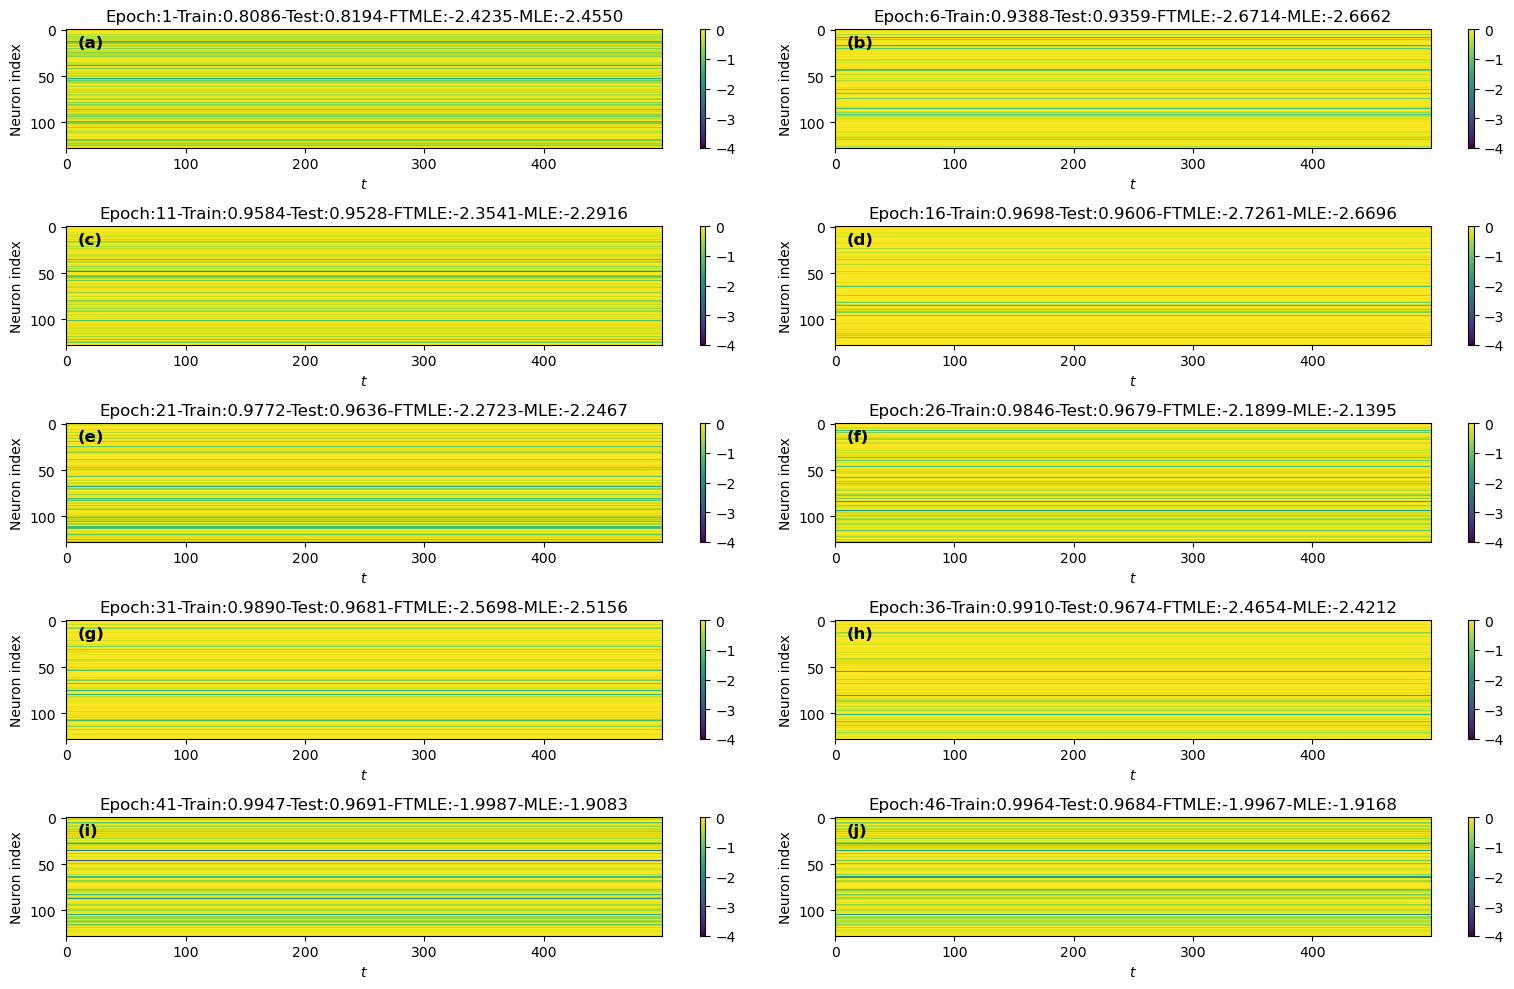

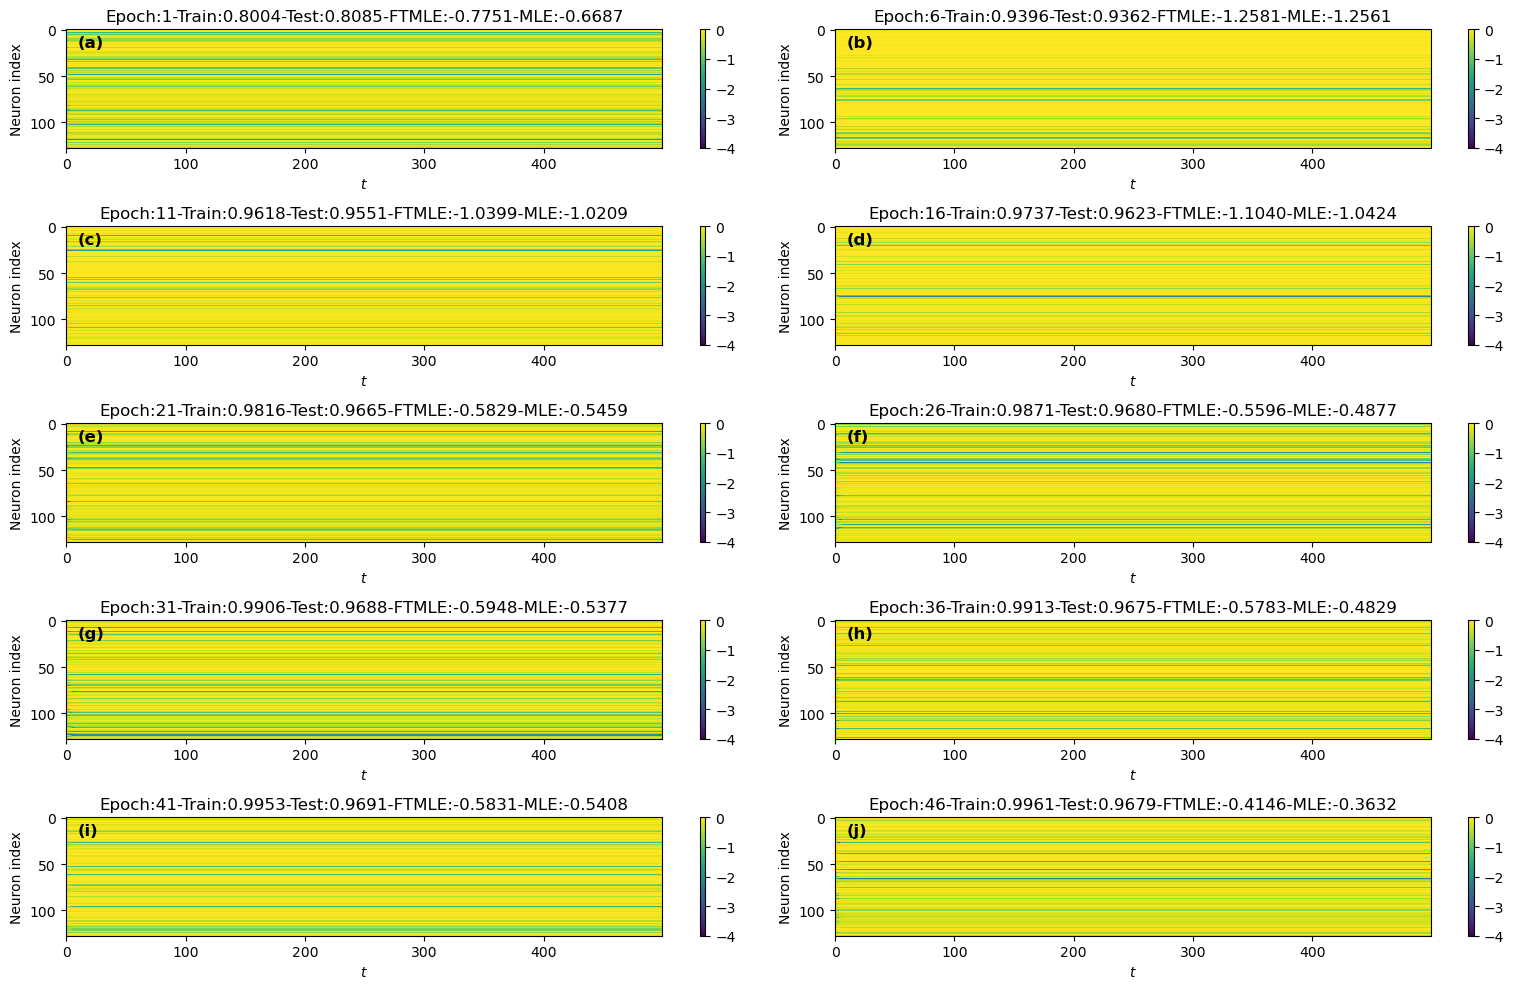

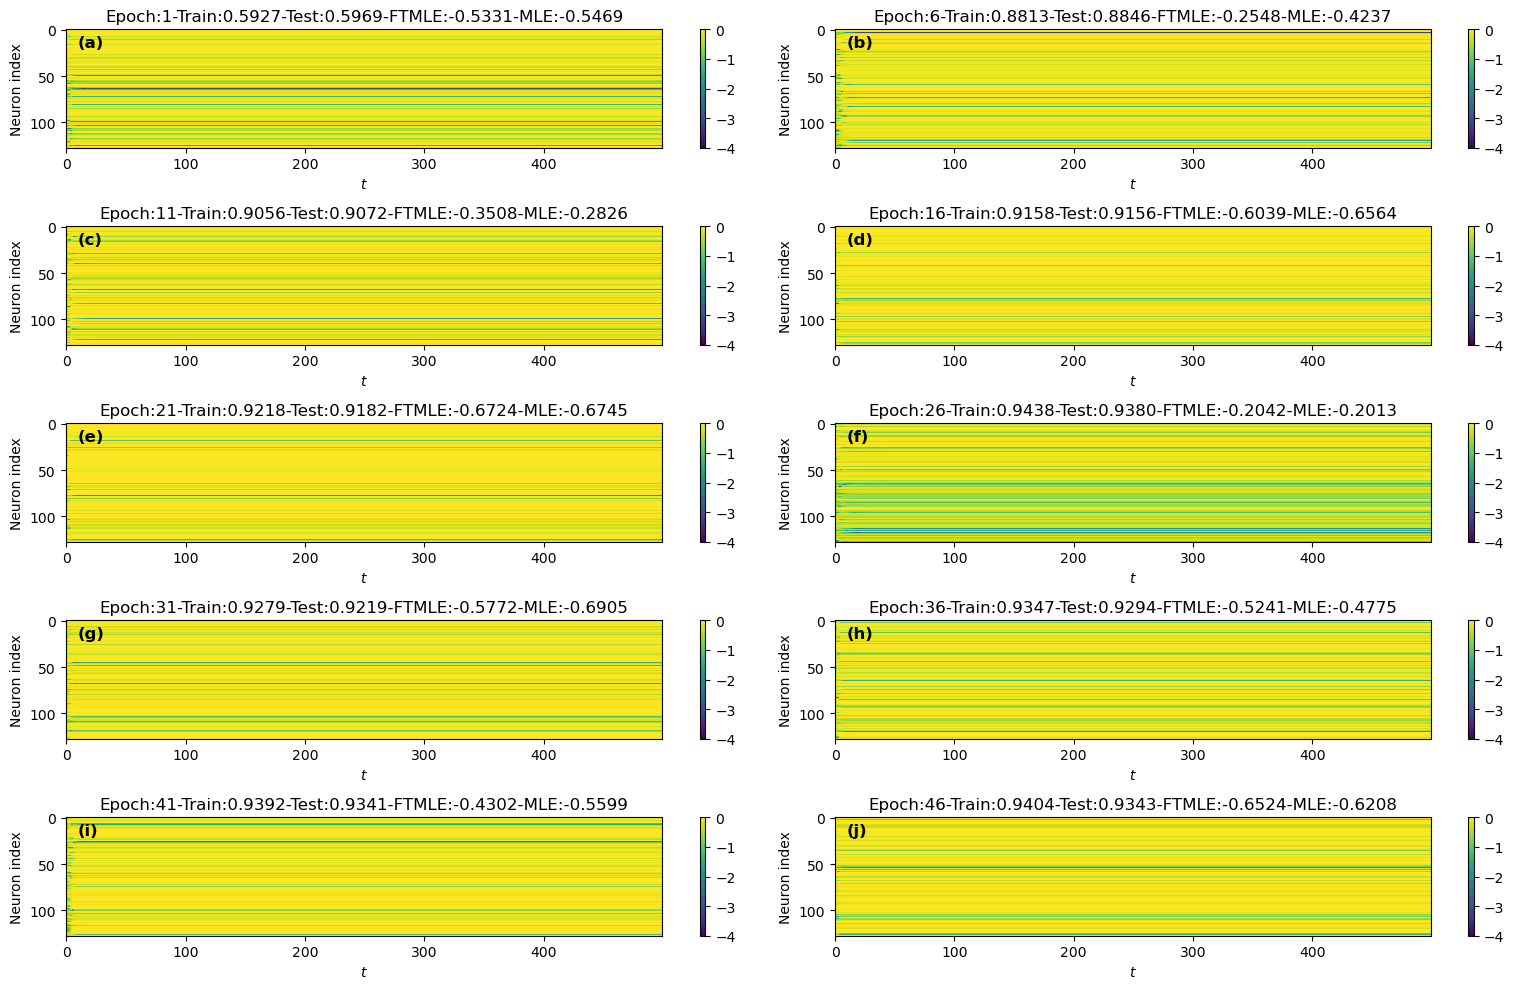

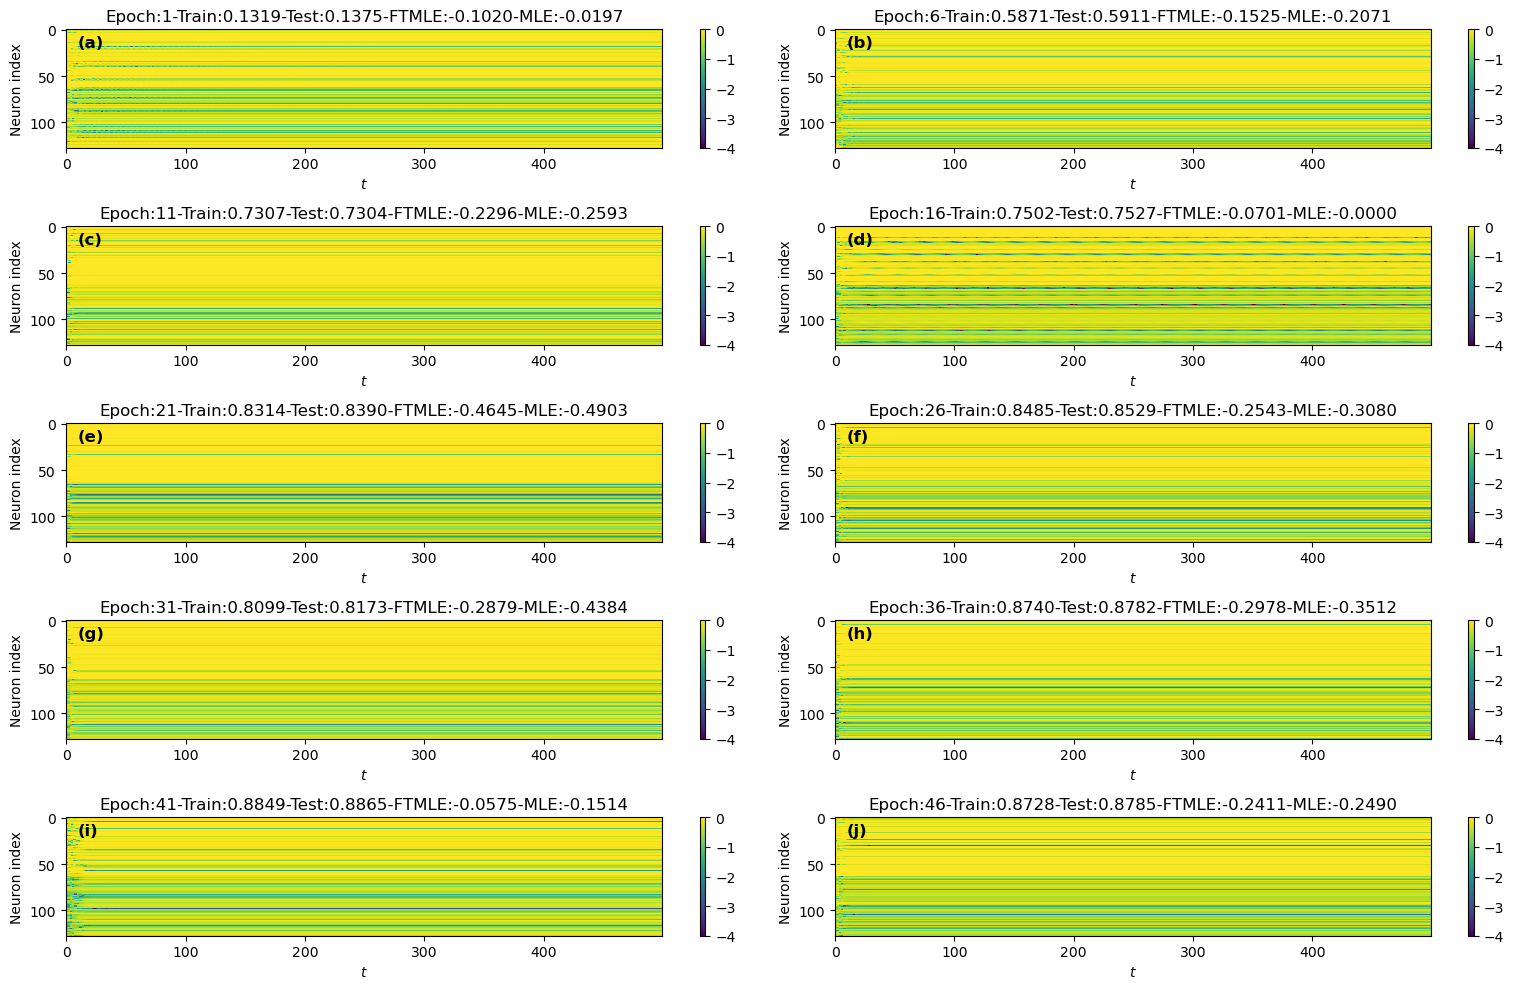

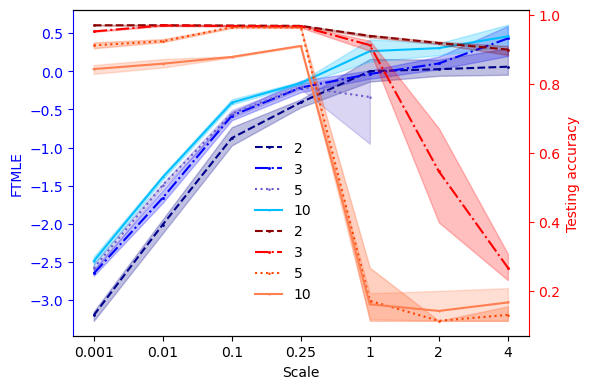

In [10]:
# -----------------------------------
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', '+', 'x', '|', '_']
linestyles = ['--', '-.', ':', '-']
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'lime', 'teal', 'olive', 'hotpink']
colors_r = ['darkred', 'red', 'orangered','coral','sandybrown']
colors_b = ['darkblue', 'blue', 'slateblue','deepskyblue','skyblue']
colors_g = ['darkgreen', 'green', 'seagreen','lime','mediumspringgreen']

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)']
# #----------------
res_dynfigs_path = Path(res_path/f"dynfigs")
res_dynfigs_path.mkdir(parents=True, exist_ok=True)
nfig = 10
c_lim = [-4, 0]
M_range_s, ParaRange_s, multitest_s=M_range, ParaRange, multitest
M_range_s = [0.01, 0.25, 1, 4]
ParaRange_s = [2]
multitest_s = 1
for iM in range( len(M_range) ):
    for iPara in range( len(ParaRange) ):
        for  imultitest in range((multitest)):    
                if (M_range[iM] in M_range_s) and (ParaRange[iPara] in ParaRange_s) and (imultitest < multitest_s) :
                    fig, axes = plt.subplots(5, 2, figsize=(16, 10))
                    (zall) = zall_list[iM][iPara]         
                    info = f'EP_L{ParaRange[iPara]}_b_sc{M_range[iM]}-{imultitest}-{Einfo}'
                    train_n_epochs = len(res[iM][iPara][imultitest][3])
                    for fepoch in range(nfig):
                        epoch = train_n_epochs*fepoch//nfig
                        plt.subplot(5,2,fepoch+1)
                        plt.imshow(np.log10(np.abs(zall[epoch])+1e-20), aspect='auto', cmap='viridis', interpolation='nearest', clim=c_lim)
                        plt.title(f'Epoch:{epoch+1}-Train:{res[iM][iPara][imultitest][1][epoch]:.4f}-Test:{res[iM][iPara][imultitest][2][epoch]:.4f}'+\
                                f'-FTMLE:{res[iM][iPara][imultitest][3][epoch]:.4f}-MLE:{res[iM][iPara][imultitest][4][epoch]:.4f}')
                        plt.xlabel(r'$t$')
                        plt.ylabel('Neuron index')
                        plt.colorbar()

                    
                    for i, ax in enumerate(axes.flatten()):
                        ax.text(0.02, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
                    plt.tight_layout()
                    
                    plt.savefig(res_dynfigs_path / f"{info}.svg", format="svg")

#------------------
fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
for iPara in range( len(ParaRange) ): 
    tmp0 =  np.max(res[:,iPara,:,3,:], axis=2)
    tmp = np.mean(tmp0,axis=1)

    ax1.plot(range(len(tmp)), tmp, color=colors_b[iPara], marker=markers[iPara], markersize=1, linestyle=linestyles[iPara], label=f'{ParaRange[iPara]}')  # 
    ax1.fill_between(range(len(tmp)), np.min(tmp0, axis=1), np.max(tmp0, axis=1), alpha=0.25, color=colors_b[iPara])
    ax1.set_xlabel('Scale')
    ax1.set_xticks(range(len(tmp)))
    ax1.set_xticklabels([f'{M_range[i]}' for i in range(len(M_range))])
    ax1.set_ylabel('FTMLE', color='b')
    ax1.tick_params(axis='y', labelcolor='b', color='b')
    ax1.spines['left'].set_color('b')  # 
    ax1.spines['right'].set_linewidth(0)  # 

    tmp0 =  np.max(res[:,iPara,:,2,:], axis=2)
    tmp = np.mean(tmp0,axis=1)
    ax2.plot(range(len(tmp)), tmp, color=colors_r[iPara], marker=markers[iPara], markersize=1, linestyle=linestyles[iPara], label=f'{ParaRange[iPara]}')  # 
    ax2.fill_between(range(len(tmp)), np.min(tmp0, axis=1), np.max(tmp0, axis=1), alpha=0.25, color=colors_r[iPara])
    ax2.set_ylabel('Testing accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r', color='r')
    ax2.spines['right'].set_color('r')  # 
    ax2.spines['left'].set_linewidth(0)  # 

# 
fig.tight_layout()  # 
fig.legend(frameon=False, fancybox=False, shadow=False, loc='lower center', bbox_to_anchor=(0.48, 0.2)) # loc='best', 

plt.title('')
if config.save:  plt.savefig(res_path / f"plot_all.svg", format="svg")  #  
# plt.show()


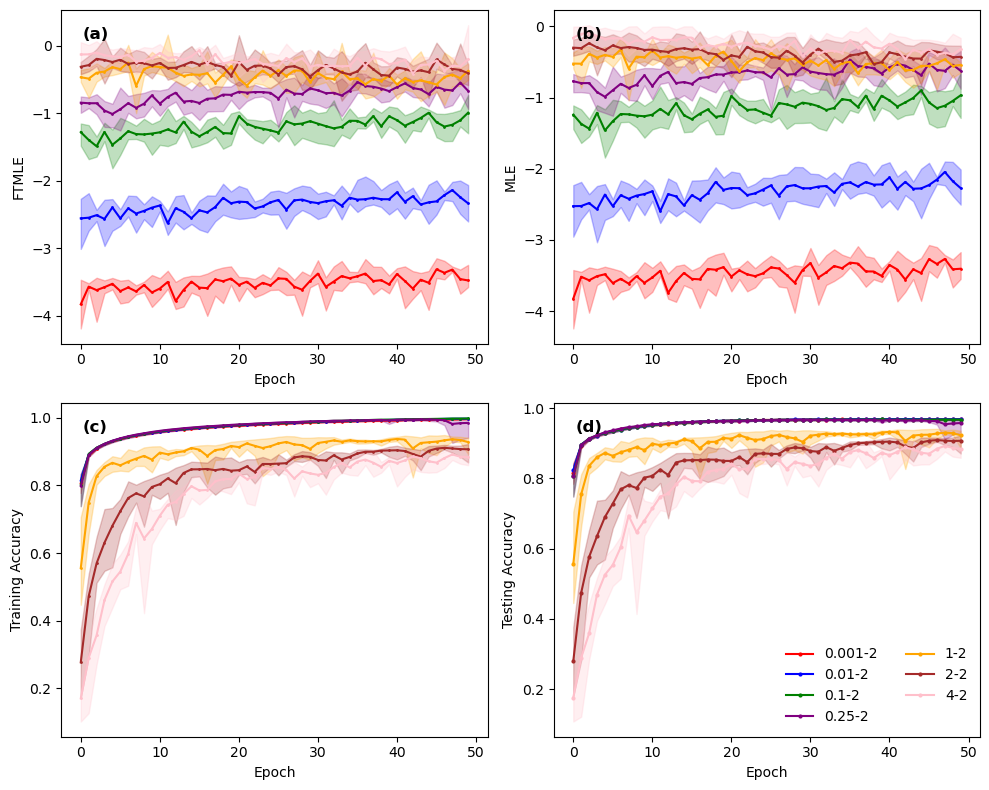

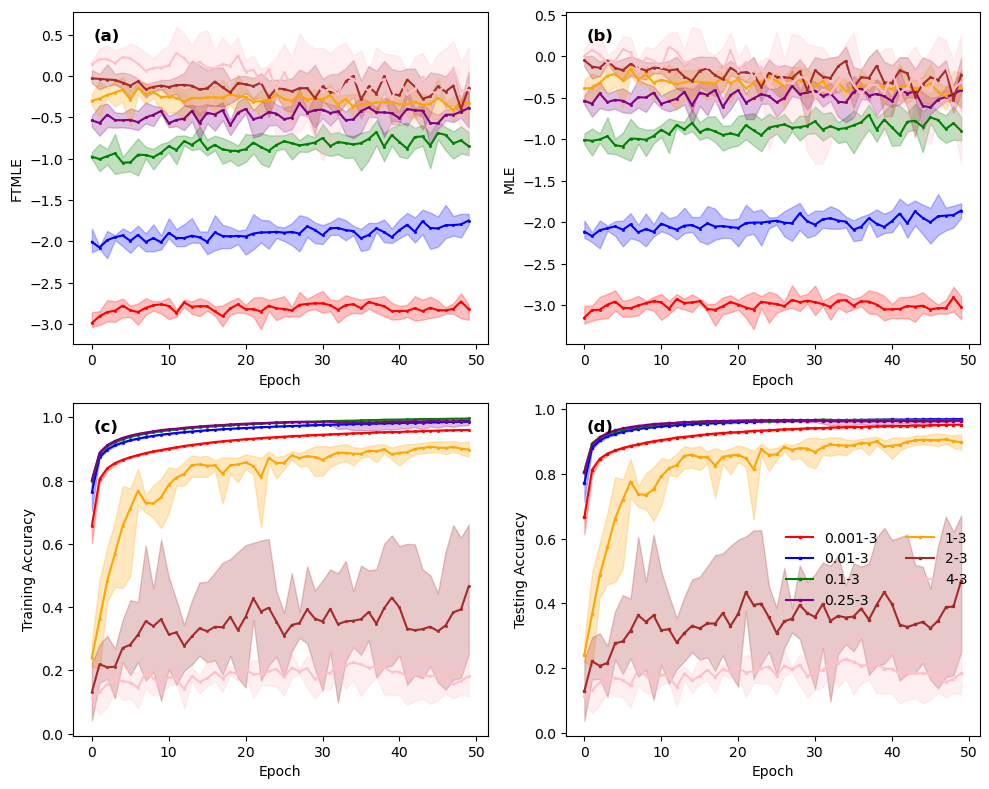

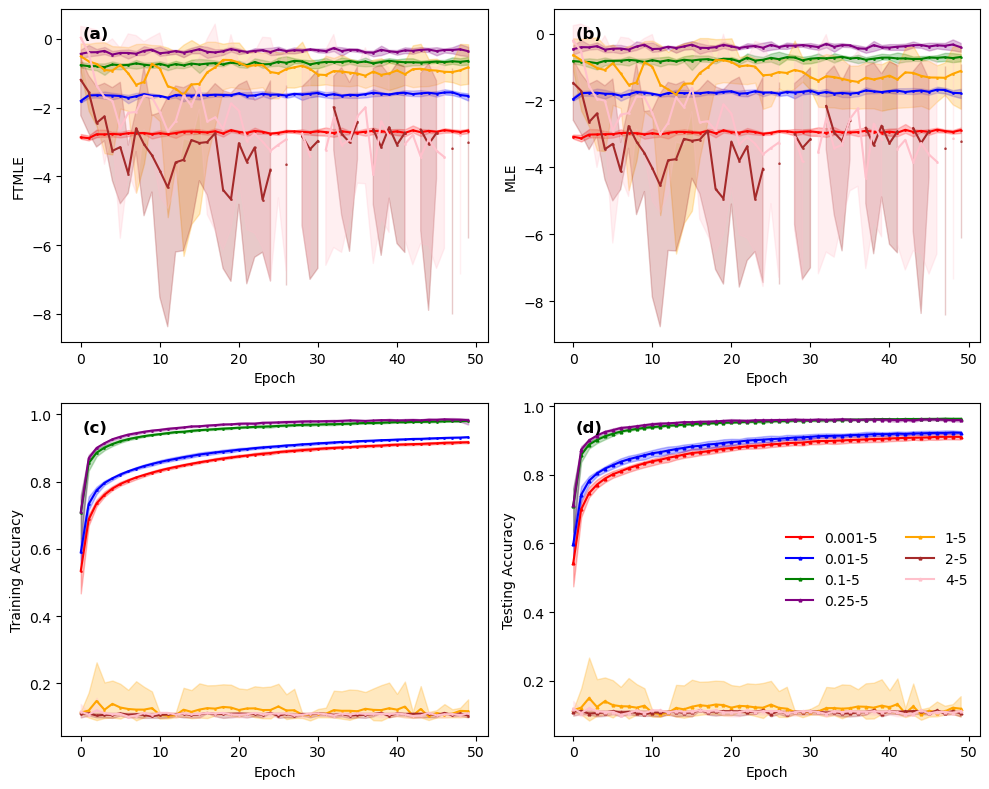

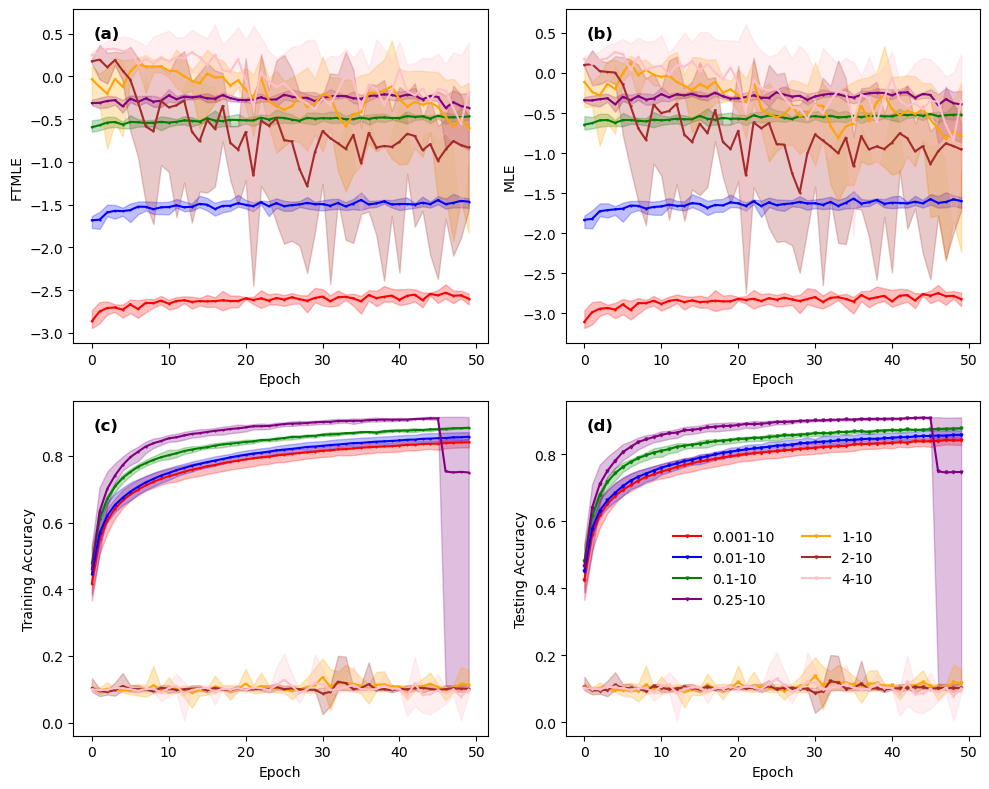

0


In [11]:

# --------------------------------------------------
for iPara in range( len(ParaRange) ):  
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    #----------------
    plt.subplot(221)
    for iM in range(len(M_range)):
        # for iPara in range( len(ParaRange) ):  
            tmp = res[iM,iPara,:,3,:]
            plt.plot(np.arange(len(np.mean(tmp, axis=0))), np.mean(tmp, axis=0), color=colors[iM], marker=markers[iPara], markersize=1, label=f'{M_range[iM]}-{ParaRange[iPara]}')  #  plot
            plt.fill_between(np.arange(len(np.mean(tmp, axis=0))), np.min(tmp, axis=0), np.max(tmp, axis=0), alpha=0.25, color=colors[iM])
    # plt.xticks(index_range, ParaRange)

    plt.title('')
    plt.xlabel(f'Epoch')
    plt.ylabel('FTMLE')
    # plt.legend(frameon=False, fancybox=False, shadow=False)

    #----------------
    plt.subplot(222)
    for iM in range(len(M_range)):
        # for iPara in range( len(ParaRange) ):        
            tmp = res[iM,iPara,:,4,:]
            plt.plot(np.arange(len(np.mean(tmp, axis=0))), np.mean(tmp, axis=0), color=colors[iM], marker=markers[iPara], markersize=1, label=f'{M_range[iM]}-{ParaRange[iPara]}')  #  plot
            plt.fill_between(np.arange(len(np.mean(tmp, axis=0))), np.min(tmp, axis=0), np.max(tmp, axis=0), alpha=0.25, color=colors[iM])
    plt.title('')
    plt.xlabel(f'Epoch')
    plt.ylabel('MLE')
    # plt.legend(frameon=False, fancybox=False, shadow=False)

    #----------------
    plt.subplot(223)
    for iM in range(len(M_range)):
        # for iPara in range( len(ParaRange) ):        
            tmp = res[iM,iPara,:,1,:]
            plt.plot(np.arange(len(np.mean(tmp, axis=0))), np.mean(tmp, axis=0), color=colors[iM], marker=markers[iPara], markersize=1, label=f'{M_range[iM]}-{ParaRange[iPara]}')  #  plot
            plt.fill_between(np.arange(len(np.mean(tmp, axis=0))), np.min(tmp, axis=0), np.max(tmp, axis=0), alpha=0.25, color=colors[iM])
    plt.title('')
    plt.xlabel(f'Epoch')
    plt.ylabel('Training Accuracy')
    # plt.legend(frameon=False, fancybox=False, shadow=False)

    #----------------
    plt.subplot(224)
    for iM in range(len(M_range)):
        # for iPara in range( len(ParaRange) ):        
            tmp = res[iM,iPara,:,2,:]
            plt.plot(np.arange(len(np.mean(tmp, axis=0))), np.mean(tmp, axis=0), color=colors[iM], marker=markers[iPara], markersize=2, label=f'{M_range[iM]}-{ParaRange[iPara]}')  #  plot
            plt.fill_between(np.arange(len(np.mean(tmp, axis=0))), np.min(tmp, axis=0), np.max(tmp, axis=0), alpha=0.25, color=colors[iM])
    plt.title('')
    plt.xlabel(f'Epoch')
    plt.ylabel('Testing Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False, ncol=2)

    # 
    labels = ['(a)', '(b)', '(c)', '(d)']
    for i, ax in enumerate(axes.flatten()):
        ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
    plt.tight_layout()

    # if fsave: plt.savefig(res_path / f"plot_{ParaRange[iPara]}.pdf", format="pdf")  # 
    if config.save: plt.savefig(res_path / f"plot_{ParaRange[iPara]}.svg", format="svg")  #  

    
plt.show()

print('0')